# LSTM Trainer
为防止过拟合，在这一版本中加入验证集

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
from tensorflow.contrib.rnn import LSTMCell, LSTMStateTuple
from tensorflow.python.util import nest
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

import numpy as np
from vocab import Vocab
import os
import time
import pickle

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
VOCAB_SIZE = 1564
TRAIN_DATA = "train_data.txt"           # 训练数据路径
TRAIN_LABEL = "train_label.txt"         # 训练数据路径
VOCAB_PATH = "vocab.txt"                # 词表路径
OUTPUT_PATH = "model/o=sgd_"      # 输出路径

MAX_SEQ_LEN = None
SHARE_EMB_AND_SOFTMAX = False
MAX_GRAD_NORM = 5
EMBEDDING_LEARNING_RATE_FACTOR = 0.1
KEEP_PROB = 0.8                         # Keep_prob
BATCH_SIZE = 64                         # batch大小

实验参数

In [3]:
HIDDEN_SIZE = 250                        # 隐层大小
NUM_LAYER = 2                            # LSTM层数
lr = 0.002                               # 学习率
NUM_EPOCH = 20                           # 迭代次数

In [4]:
OUTPUT_PATH = OUTPUT_PATH + "v="+ str(VOCAB_SIZE) +"h="+ str(HIDDEN_SIZE) +"l="+ str(NUM_LAYER) +"b="+ str(BATCH_SIZE) +"e="+ str(NUM_EPOCH) +"lr="+ str(lr) + "/"

In [5]:
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

In [6]:
MODEL_PATH = OUTPUT_PATH + "model"      # 模型输出
LOG_PATH = OUTPUT_PATH + "log"          # log输出

In [7]:
vocab = Vocab(VOCAB_PATH)
weight_matrix = np.random.uniform(-0.05,0.05,(VOCAB_SIZE,50)).astype(np.float32)

In [8]:
# 定义可以忽略0因素的LSTM
class ComLSTM(object):
    
    def __init__(self):
        
        self.inputs = tf.placeholder(shape=(None, None), dtype=tf.int64, name='inputs')
        self.inputs_length = tf.placeholder(shape=(None,), dtype=tf.int64, name='inputs_length')
        self.labels = tf.placeholder(shape=(None,), dtype=tf.int64, name='labels')
        
        # 定义LSTM单元, NUM_LAYER 为多层LSTM的层数
        self.cell = tf.contrib.rnn.MultiRNNCell(
             [tf.contrib.rnn.BasicLSTMCell(HIDDEN_SIZE)
             for _ in range(NUM_LAYER)])
        
        # 定义embedding矩阵
        self.embedding = tf.Variable(initial_value=weight_matrix,dtype=tf.float32)
            
    def forward(self):
        
        batch_size = BATCH_SIZE
        
        # 将输入id转换为词向量
        embedding = tf.nn.embedding_lookup(self.embedding,self.inputs)
        print(embedding)
        # 进行dropout
        embedding = tf.nn.dropout(embedding,KEEP_PROB)
        
        # 使用dynamic_rnn
        with tf.variable_scope("dynamic_rnn"):
            outputs, last_state = tf.nn.dynamic_rnn(
                self.cell, 
                embedding, 
                self.inputs_length, 
                dtype=tf.float32)
            
            # 在计算平均损失时，需要将填充位置的权重设置为0，以避免无效位置的预测干扰
            # 这里的 last_state 是有输入的最后一个h输出，因此可以直接使用这个输出来作为计算损失的newoutputs
            # 因为有使用了dynamic，有部分的output会置零
            print(last_state)
            newoutputs = last_state[-1][1]
                    
        #logits = tf.matmul(newoutputs,self.softmax_weight) + self.softmax_bias
        logits = tf.layers.dense(newoutputs,VOCAB_SIZE)
    
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=self.labels)

        # 定义损失函数
        cost = tf.reduce_mean(loss)
        tf.summary.scalar("cost",cost)

        # 计算正确率
        accuracy = tf.equal(tf.argmax(logits, 1), self.labels)
        evaluation = tf.reduce_mean(tf.cast(accuracy, tf.float32))
        tf.summary.scalar("top1_accuracy",evaluation)


        # 定义反向传播操作
        trainable_variables = tf.trainable_variables()
        
        # 控制梯度大小，定义优化方法和训练步骤
        #grads = tf.gradients(cost / tf.to_float(batch_size), trainable_variables)
        
#         grads, _ = tf.clip_by_global_norm(grads, .MAX_GRAD_NORM)
#         optimizer = tf.train.AdamOptimizer(learning_rate=lr)
        
#         train_op = optimizer.apply_gradients(zip(grads, trainable_variables))

        # opt = tf.train.AdamOptimizer(learning_rate=lr)
        opt = tf.train.GradientDescentOptimizer(learning_rate=lr)
        grads_and_vars = opt.compute_gradients(loss) 
        clip_grads = [(tf.clip_by_value(grad,-1.,1.),var) for grad,var in grads_and_vars if grad is not None]

        found = 0
        for i,(grad,var) in enumerate(clip_grads):
            if var == self.embedding:
                found += 1
                grad = tf.scalar_mul(EMBEDDING_LEARNING_RATE_FACTOR, grad)
                clip_grads[i] = (grad,var)
        assert found == 1# internal consistency check

        train_op = opt.apply_gradients(clip_grads)
            
        return self.inputs,self.inputs_length,self.labels,cost,train_op,evaluation

In [9]:
def getBatch(dataset,labelset,batchsize):
    
    total = int(len(dataset)/batchsize)
    if len(dataset)%batchsize > 0:
        total += 1
    for i in range(total):
        tempdata = dataset[i*batchsize:(i+1)*batchsize]
        templabel = labelset[i*batchsize:(i+1)*batchsize]
        yield tempdata,templabel

In [10]:
def batch_major(inputs, max_sequence_length=None):
    
    sequence_lengths = [len(seq) for seq in inputs]
    batch_size = len(inputs)
    
    if max_sequence_length is None:
        max_sequence_length = max(sequence_lengths)
    
    inputs_batch_major = np.zeros(shape=[batch_size, max_sequence_length], dtype=np.int64) # == PAD
    
    for i, seq in enumerate(inputs):
        for j, element in enumerate(seq):
            inputs_batch_major[i,j] = element
    
    return inputs_batch_major, sequence_lengths

### 加载训练集、验证集

In [11]:
def load_data():
    
    trainingdata = []
    traininglabel = []
    with open(TRAIN_DATA, "r") as fd:
        with open(TRAIN_LABEL, "r") as fl:
            for line in fd.readlines():
                trainingdata.append([int(w) for w in line.split()])
            for line in fl.readlines():
                traininglabel.append(int(line))
    # 加入验证集提取，验证集的大小为训练集的10%
    trainingdata, validdata, traininglabel, validlabel = train_test_split(
    trainingdata, traininglabel, test_size=0.1, random_state=42)
    return trainingdata, traininglabel, validdata, validlabel

In [12]:
# 使用给定的模型训练结果
def run_epoch(session, cost, train_op, inputs, inputs_length, labels, accuracy, saver):

    # 准备写入日志
    summary = tf.summary.merge_all()
    writer = tf.summary.FileWriter(LOG_PATH, tf.get_default_graph())

    losses = []
    validlosses = []
    validaccuracies = []
    global_step = 0
    train_feed_dict = {}
    valid_feed_dict = {}

    # 读取训练数据
    read_start = time.time()
    print('read data_set')
    trainingdata, traininglabel, valid_data, valid_label = load_data()
    
    # 对验证集进行补零的操作先
    valid_data,valid_length = batch_major(valid_data)
    print('completed read data_set, time: %.4f' % (time.time()-read_start))

    save_path = MODEL_PATH
    dataCount = 0
    
    #labelcount = 0
    for num in range(NUM_EPOCH):
        numOfEpoch = 0
        tempCount = 0
        start0 = time.time()
        
        dataset_temp, label_temp = shuffle(trainingdata,traininglabel)
        
        for databatch,batchlabel in getBatch(dataset_temp,label_temp,BATCH_SIZE):
            start = time.time()

            # 获得每一个batch下的训练数据以及对应数据的len
            databatch,length = batch_major(databatch)

            train_feed_dict[inputs] = databatch
            train_feed_dict[inputs_length] = length
            train_feed_dict[labels] = batchlabel
            
            _,batchloss,batchaccuracy,summaries = session.run([train_op,cost,accuracy,summary],train_feed_dict)

            numOfEpoch += 1
            global_step += 1
            
            #summary
            writer.add_summary(summaries,global_step)

            if global_step % 1000 == 1:
                losses.append(batchloss)
            end = time.time()
            
            print('batch %d---%d, loss: %.3e, accuracy: %.3e, time: %f' % (num+1, numOfEpoch, batchloss, batchaccuracy, end-start))
        end0 = time.time()
        print('epoch:%d, time:%f' % (num+1,end0-start0))        
        
        valid_feed_dict[inputs] = valid_data
        valid_feed_dict[inputs_length] = valid_length
        valid_feed_dict[labels] = valid_label
        validloss,validaccuracy = session.run([cost,accuracy],valid_feed_dict)
        validlosses.append(validloss)
        validaccuracies.append(validaccuracy)
        print('epoch:%d, valid_loss: %.3e, valid_accuracy: %.3e' % (num+1, validloss, validaccuracy))

    # 保存日志 ================
    writer.flush()
    writer.close()

    checkpoint_path = saver.save(session, save_path, global_step = 1)
    print('model saved in file: %s' % checkpoint_path) 
        
    return losses, validlosses, validaccuracies

In [13]:
# 训练代码 ================
tf.reset_default_graph()
train_model = ComLSTM()

inputs, length, labels, cost, train_op, accuracy = train_model.forward()

print('start training...')
init = tf.global_variables_initializer()
saver = tf.train.Saver()

sess = tf.InteractiveSession()
sess.run(init)
losses,validlosses,validaccuracies = run_epoch(sess, cost, train_op, inputs, length, labels, accuracy, saver)

Tensor("embedding_lookup:0", shape=(?, ?, 50), dtype=float32)
(LSTMStateTuple(c=<tf.Tensor 'dynamic_rnn/rnn/while/Exit_2:0' shape=(?, 250) dtype=float32>, h=<tf.Tensor 'dynamic_rnn/rnn/while/Exit_3:0' shape=(?, 250) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'dynamic_rnn/rnn/while/Exit_4:0' shape=(?, 250) dtype=float32>, h=<tf.Tensor 'dynamic_rnn/rnn/while/Exit_5:0' shape=(?, 250) dtype=float32>))
start training...
read data_set
completed read data_set, time: 2.3563
batch 1---1, loss: 7.355e+00, accuracy: 0.000e+00, time: 0.332387
batch 1---2, loss: 7.352e+00, accuracy: 4.688e-02, time: 0.074160
batch 1---3, loss: 7.351e+00, accuracy: 7.812e-02, time: 0.061221
batch 1---4, loss: 7.347e+00, accuracy: 1.094e-01, time: 0.067326
batch 1---5, loss: 7.342e+00, accuracy: 1.562e-01, time: 0.064356
batch 1---6, loss: 7.343e+00, accuracy: 9.375e-02, time: 0.053959
batch 1---7, loss: 7.341e+00, accuracy: 1.406e-01, time: 0.048292
batch 1---8, loss: 7.335e+00, accuracy: 1.719e-01, time: 0.049195

batch 1---120, loss: 4.992e+00, accuracy: 1.562e-01, time: 0.072042
batch 1---121, loss: 4.640e+00, accuracy: 1.719e-01, time: 0.044415
batch 1---122, loss: 5.452e+00, accuracy: 7.812e-02, time: 0.048968
batch 1---123, loss: 5.431e+00, accuracy: 6.250e-02, time: 0.053068
batch 1---124, loss: 5.715e+00, accuracy: 9.375e-02, time: 0.060149
batch 1---125, loss: 5.444e+00, accuracy: 9.375e-02, time: 0.054439
batch 1---126, loss: 5.010e+00, accuracy: 1.094e-01, time: 0.036667
batch 1---127, loss: 5.368e+00, accuracy: 9.375e-02, time: 0.054139
batch 1---128, loss: 5.325e+00, accuracy: 7.812e-02, time: 0.058093
batch 1---129, loss: 5.210e+00, accuracy: 1.094e-01, time: 0.055720
batch 1---130, loss: 4.833e+00, accuracy: 9.375e-02, time: 0.082864
batch 1---131, loss: 4.916e+00, accuracy: 1.562e-01, time: 0.038691
batch 1---132, loss: 4.912e+00, accuracy: 1.094e-01, time: 0.047623
batch 1---133, loss: 4.957e+00, accuracy: 1.406e-01, time: 0.060961
batch 1---134, loss: 5.023e+00, accuracy: 1.406e

batch 1---242, loss: 4.718e+00, accuracy: 1.406e-01, time: 0.102265
batch 1---243, loss: 4.821e+00, accuracy: 1.250e-01, time: 0.065393
batch 1---244, loss: 4.938e+00, accuracy: 1.562e-01, time: 0.027935
batch 1---245, loss: 4.699e+00, accuracy: 7.812e-02, time: 0.046552
batch 1---246, loss: 5.176e+00, accuracy: 6.250e-02, time: 0.052488
batch 1---247, loss: 4.748e+00, accuracy: 7.812e-02, time: 0.050832
batch 1---248, loss: 5.230e+00, accuracy: 6.250e-02, time: 0.073643
batch 1---249, loss: 4.721e+00, accuracy: 7.812e-02, time: 0.047134
batch 1---250, loss: 5.083e+00, accuracy: 1.094e-01, time: 0.031249
batch 1---251, loss: 4.905e+00, accuracy: 1.094e-01, time: 0.041576
batch 1---252, loss: 4.973e+00, accuracy: 1.562e-01, time: 0.035386
batch 1---253, loss: 4.701e+00, accuracy: 4.688e-02, time: 0.036727
batch 1---254, loss: 5.116e+00, accuracy: 1.250e-01, time: 0.052398
batch 1---255, loss: 4.409e+00, accuracy: 1.094e-01, time: 0.080383
batch 1---256, loss: 5.069e+00, accuracy: 9.375e

batch 1---365, loss: 4.745e+00, accuracy: 1.250e-01, time: 0.069384
batch 1---366, loss: 4.436e+00, accuracy: 4.688e-02, time: 0.058943
batch 1---367, loss: 4.351e+00, accuracy: 9.375e-02, time: 0.079420
batch 1---368, loss: 4.547e+00, accuracy: 6.250e-02, time: 0.073579
batch 1---369, loss: 4.824e+00, accuracy: 4.688e-02, time: 0.066820
batch 1---370, loss: 4.353e+00, accuracy: 1.250e-01, time: 0.073983
batch 1---371, loss: 4.755e+00, accuracy: 7.812e-02, time: 0.082136
batch 1---372, loss: 4.826e+00, accuracy: 1.406e-01, time: 0.039126
batch 1---373, loss: 4.675e+00, accuracy: 1.094e-01, time: 0.039593
batch 1---374, loss: 4.248e+00, accuracy: 1.406e-01, time: 0.048141
batch 1---375, loss: 4.342e+00, accuracy: 1.562e-01, time: 0.034021
batch 1---376, loss: 4.548e+00, accuracy: 1.094e-01, time: 0.040541
batch 1---377, loss: 5.013e+00, accuracy: 1.094e-01, time: 0.046820
batch 1---378, loss: 4.972e+00, accuracy: 1.719e-01, time: 0.031176
batch 1---379, loss: 4.247e+00, accuracy: 1.094e

batch 1---489, loss: 4.548e+00, accuracy: 7.812e-02, time: 0.096960
batch 1---490, loss: 4.251e+00, accuracy: 1.094e-01, time: 0.074659
batch 1---491, loss: 4.794e+00, accuracy: 1.094e-01, time: 0.062110
batch 1---492, loss: 4.693e+00, accuracy: 1.406e-01, time: 0.086537
batch 1---493, loss: 4.568e+00, accuracy: 7.812e-02, time: 0.043241
batch 1---494, loss: 4.308e+00, accuracy: 1.094e-01, time: 0.051468
batch 1---495, loss: 4.334e+00, accuracy: 1.250e-01, time: 0.060583
batch 1---496, loss: 4.594e+00, accuracy: 1.094e-01, time: 0.044505
batch 1---497, loss: 4.642e+00, accuracy: 1.719e-01, time: 0.033219
batch 1---498, loss: 4.609e+00, accuracy: 1.719e-01, time: 0.035438
batch 1---499, loss: 4.102e+00, accuracy: 1.250e-01, time: 0.029398
batch 1---500, loss: 3.980e+00, accuracy: 1.094e-01, time: 0.061635
batch 1---501, loss: 4.684e+00, accuracy: 1.094e-01, time: 0.045057
batch 1---502, loss: 4.715e+00, accuracy: 4.688e-02, time: 0.081354
batch 1---503, loss: 4.436e+00, accuracy: 1.562e

batch 1---610, loss: 4.296e+00, accuracy: 1.250e-01, time: 0.048766
batch 1---611, loss: 4.464e+00, accuracy: 4.688e-02, time: 0.035051
batch 1---612, loss: 4.472e+00, accuracy: 9.375e-02, time: 0.039431
batch 1---613, loss: 4.513e+00, accuracy: 7.812e-02, time: 0.049328
batch 1---614, loss: 4.457e+00, accuracy: 4.688e-02, time: 0.033925
batch 1---615, loss: 4.425e+00, accuracy: 9.375e-02, time: 0.057662
batch 1---616, loss: 4.689e+00, accuracy: 9.375e-02, time: 0.045472
batch 1---617, loss: 4.662e+00, accuracy: 1.562e-01, time: 0.037920
batch 1---618, loss: 4.717e+00, accuracy: 1.094e-01, time: 0.056144
batch 1---619, loss: 4.487e+00, accuracy: 1.250e-01, time: 0.054159
batch 1---620, loss: 4.504e+00, accuracy: 1.094e-01, time: 0.051192
batch 1---621, loss: 4.728e+00, accuracy: 1.094e-01, time: 0.054902
batch 1---622, loss: 4.444e+00, accuracy: 6.250e-02, time: 0.039446
batch 1---623, loss: 4.213e+00, accuracy: 9.375e-02, time: 0.054769
batch 1---624, loss: 4.273e+00, accuracy: 1.250e

batch 1---731, loss: 4.440e+00, accuracy: 1.250e-01, time: 0.039329
batch 1---732, loss: 4.882e+00, accuracy: 1.094e-01, time: 0.056309
batch 1---733, loss: 4.373e+00, accuracy: 9.375e-02, time: 0.084104
batch 1---734, loss: 4.434e+00, accuracy: 7.812e-02, time: 0.038823
batch 1---735, loss: 4.348e+00, accuracy: 6.250e-02, time: 0.038668
batch 1---736, loss: 4.599e+00, accuracy: 1.094e-01, time: 0.051599
batch 1---737, loss: 4.611e+00, accuracy: 4.688e-02, time: 0.052442
batch 1---738, loss: 4.722e+00, accuracy: 7.812e-02, time: 0.035301
batch 1---739, loss: 4.560e+00, accuracy: 7.812e-02, time: 0.048994
batch 1---740, loss: 4.267e+00, accuracy: 1.406e-01, time: 0.037249
batch 1---741, loss: 5.048e+00, accuracy: 9.375e-02, time: 0.052553
batch 1---742, loss: 4.487e+00, accuracy: 4.688e-02, time: 0.038261
batch 1---743, loss: 4.273e+00, accuracy: 7.812e-02, time: 0.037339
batch 1---744, loss: 4.348e+00, accuracy: 1.719e-01, time: 0.029571
batch 1---745, loss: 4.195e+00, accuracy: 1.250e

batch 1---854, loss: 4.481e+00, accuracy: 1.406e-01, time: 0.049139
batch 1---855, loss: 4.348e+00, accuracy: 1.562e-01, time: 0.064746
batch 1---856, loss: 4.229e+00, accuracy: 1.562e-01, time: 0.067365
batch 1---857, loss: 4.334e+00, accuracy: 1.406e-01, time: 0.066118
batch 1---858, loss: 4.331e+00, accuracy: 1.406e-01, time: 0.068299
batch 1---859, loss: 4.342e+00, accuracy: 1.250e-01, time: 0.078583
batch 1---860, loss: 4.338e+00, accuracy: 1.719e-01, time: 0.042213
batch 1---861, loss: 4.302e+00, accuracy: 1.094e-01, time: 0.089048
batch 1---862, loss: 4.604e+00, accuracy: 3.125e-02, time: 0.068575
batch 1---863, loss: 4.586e+00, accuracy: 6.250e-02, time: 0.048659
batch 1---864, loss: 4.165e+00, accuracy: 9.375e-02, time: 0.074712
batch 1---865, loss: 4.561e+00, accuracy: 9.375e-02, time: 0.076667
batch 1---866, loss: 4.197e+00, accuracy: 1.094e-01, time: 0.044323
batch 1---867, loss: 4.546e+00, accuracy: 7.812e-02, time: 0.093281
batch 1---868, loss: 4.202e+00, accuracy: 1.094e

batch 1---978, loss: 4.635e+00, accuracy: 1.094e-01, time: 0.058624
batch 1---979, loss: 4.264e+00, accuracy: 4.688e-02, time: 0.067965
batch 1---980, loss: 4.560e+00, accuracy: 4.688e-02, time: 0.053463
batch 1---981, loss: 4.240e+00, accuracy: 9.375e-02, time: 0.065158
batch 1---982, loss: 4.301e+00, accuracy: 1.719e-01, time: 0.036730
batch 1---983, loss: 4.639e+00, accuracy: 7.812e-02, time: 0.058644
batch 1---984, loss: 4.622e+00, accuracy: 1.406e-01, time: 0.047740
batch 1---985, loss: 4.579e+00, accuracy: 4.688e-02, time: 0.068906
batch 1---986, loss: 4.135e+00, accuracy: 1.406e-01, time: 0.081519
batch 1---987, loss: 4.354e+00, accuracy: 1.094e-01, time: 0.075158
batch 1---988, loss: 4.220e+00, accuracy: 7.812e-02, time: 0.043270
batch 1---989, loss: 4.365e+00, accuracy: 1.094e-01, time: 0.039791
batch 1---990, loss: 4.300e+00, accuracy: 6.250e-02, time: 0.040111
batch 1---991, loss: 4.124e+00, accuracy: 1.250e-01, time: 0.032840
batch 1---992, loss: 4.300e+00, accuracy: 1.406e

batch 1---1098, loss: 4.293e+00, accuracy: 1.094e-01, time: 0.050307
batch 1---1099, loss: 4.436e+00, accuracy: 7.812e-02, time: 0.058450
batch 1---1100, loss: 4.436e+00, accuracy: 7.812e-02, time: 0.040516
batch 1---1101, loss: 4.411e+00, accuracy: 1.406e-01, time: 0.063400
batch 1---1102, loss: 3.970e+00, accuracy: 1.875e-01, time: 0.072336
batch 1---1103, loss: 4.246e+00, accuracy: 9.375e-02, time: 0.065813
batch 1---1104, loss: 4.224e+00, accuracy: 7.812e-02, time: 0.048239
batch 1---1105, loss: 4.398e+00, accuracy: 1.250e-01, time: 0.037633
batch 1---1106, loss: 4.265e+00, accuracy: 9.375e-02, time: 0.033427
batch 1---1107, loss: 4.243e+00, accuracy: 1.406e-01, time: 0.052691
batch 1---1108, loss: 4.405e+00, accuracy: 4.688e-02, time: 0.030897
batch 1---1109, loss: 4.581e+00, accuracy: 1.250e-01, time: 0.041606
batch 1---1110, loss: 4.146e+00, accuracy: 1.094e-01, time: 0.090258
batch 1---1111, loss: 4.351e+00, accuracy: 3.125e-02, time: 0.044708
batch 1---1112, loss: 4.148e+00, a

batch 1---1217, loss: 4.125e+00, accuracy: 9.375e-02, time: 0.041920
batch 1---1218, loss: 4.451e+00, accuracy: 1.875e-01, time: 0.034420
batch 1---1219, loss: 4.342e+00, accuracy: 1.094e-01, time: 0.050655
batch 1---1220, loss: 4.595e+00, accuracy: 6.250e-02, time: 0.031597
batch 1---1221, loss: 4.719e+00, accuracy: 7.812e-02, time: 0.042645
batch 1---1222, loss: 4.162e+00, accuracy: 1.250e-01, time: 0.048915
batch 1---1223, loss: 4.293e+00, accuracy: 1.250e-01, time: 0.028102
batch 1---1224, loss: 4.189e+00, accuracy: 1.562e-01, time: 0.026477
batch 1---1225, loss: 4.022e+00, accuracy: 1.406e-01, time: 0.048249
batch 1---1226, loss: 4.247e+00, accuracy: 1.406e-01, time: 0.077778
batch 1---1227, loss: 4.517e+00, accuracy: 7.812e-02, time: 0.062745
batch 1---1228, loss: 4.506e+00, accuracy: 9.375e-02, time: 0.070590
batch 1---1229, loss: 4.277e+00, accuracy: 1.406e-01, time: 0.037271
batch 1---1230, loss: 4.603e+00, accuracy: 7.812e-02, time: 0.043517
batch 1---1231, loss: 4.258e+00, a

batch 1---1336, loss: 4.461e+00, accuracy: 1.562e-01, time: 0.073180
batch 1---1337, loss: 4.331e+00, accuracy: 1.094e-01, time: 0.056374
batch 1---1338, loss: 3.989e+00, accuracy: 1.562e-01, time: 0.042573
batch 1---1339, loss: 4.394e+00, accuracy: 1.250e-01, time: 0.038365
batch 1---1340, loss: 4.309e+00, accuracy: 1.250e-01, time: 0.033829
batch 1---1341, loss: 4.362e+00, accuracy: 1.094e-01, time: 0.047902
batch 1---1342, loss: 4.397e+00, accuracy: 1.562e-01, time: 0.041619
batch 1---1343, loss: 4.119e+00, accuracy: 1.406e-01, time: 0.053237
batch 1---1344, loss: 4.144e+00, accuracy: 1.250e-01, time: 0.037201
batch 1---1345, loss: 4.219e+00, accuracy: 7.812e-02, time: 0.032661
batch 1---1346, loss: 3.917e+00, accuracy: 1.562e-01, time: 0.055512
batch 1---1347, loss: 4.516e+00, accuracy: 9.375e-02, time: 0.033032
batch 1---1348, loss: 3.795e+00, accuracy: 7.812e-02, time: 0.042673
batch 1---1349, loss: 4.279e+00, accuracy: 1.562e-01, time: 0.053182
batch 1---1350, loss: 4.066e+00, a

batch 1---1459, loss: 4.262e+00, accuracy: 7.812e-02, time: 0.055804
batch 1---1460, loss: 4.036e+00, accuracy: 6.250e-02, time: 0.063480
batch 1---1461, loss: 4.285e+00, accuracy: 1.094e-01, time: 0.054335
batch 1---1462, loss: 3.957e+00, accuracy: 1.094e-01, time: 0.073817
batch 1---1463, loss: 3.979e+00, accuracy: 1.406e-01, time: 0.056974
batch 1---1464, loss: 4.302e+00, accuracy: 7.812e-02, time: 0.052682
batch 1---1465, loss: 4.315e+00, accuracy: 1.250e-01, time: 0.042053
batch 1---1466, loss: 4.091e+00, accuracy: 1.250e-01, time: 0.083493
batch 1---1467, loss: 3.913e+00, accuracy: 1.250e-01, time: 0.045617
batch 1---1468, loss: 3.861e+00, accuracy: 1.875e-01, time: 0.045050
batch 1---1469, loss: 3.862e+00, accuracy: 7.812e-02, time: 0.058153
batch 1---1470, loss: 4.049e+00, accuracy: 1.875e-01, time: 0.043018
batch 1---1471, loss: 4.175e+00, accuracy: 1.406e-01, time: 0.063882
batch 1---1472, loss: 4.018e+00, accuracy: 1.406e-01, time: 0.058577
batch 1---1473, loss: 3.965e+00, a

batch 1---1581, loss: 4.115e+00, accuracy: 1.562e-01, time: 0.034771
batch 1---1582, loss: 4.331e+00, accuracy: 1.250e-01, time: 0.042650
batch 1---1583, loss: 3.805e+00, accuracy: 1.094e-01, time: 0.062165
batch 1---1584, loss: 3.939e+00, accuracy: 1.562e-01, time: 0.055072
batch 1---1585, loss: 3.941e+00, accuracy: 1.250e-01, time: 0.042024
batch 1---1586, loss: 4.164e+00, accuracy: 1.094e-01, time: 0.030224
batch 1---1587, loss: 4.218e+00, accuracy: 1.094e-01, time: 0.053980
batch 1---1588, loss: 4.386e+00, accuracy: 4.688e-02, time: 0.083287
batch 1---1589, loss: 3.991e+00, accuracy: 1.250e-01, time: 0.068642
batch 1---1590, loss: 3.765e+00, accuracy: 1.562e-01, time: 0.093667
batch 1---1591, loss: 4.530e+00, accuracy: 9.375e-02, time: 0.066206
batch 1---1592, loss: 4.159e+00, accuracy: 9.375e-02, time: 0.059212
batch 1---1593, loss: 4.514e+00, accuracy: 1.250e-01, time: 0.052817
batch 1---1594, loss: 4.265e+00, accuracy: 7.812e-02, time: 0.051735
batch 1---1595, loss: 4.387e+00, a

batch 1---1703, loss: 4.324e+00, accuracy: 7.812e-02, time: 0.047836
batch 1---1704, loss: 4.040e+00, accuracy: 1.406e-01, time: 0.033099
batch 1---1705, loss: 4.111e+00, accuracy: 1.875e-01, time: 0.062616
batch 1---1706, loss: 4.019e+00, accuracy: 1.094e-01, time: 0.045646
batch 1---1707, loss: 4.085e+00, accuracy: 1.406e-01, time: 0.041374
batch 1---1708, loss: 4.261e+00, accuracy: 1.250e-01, time: 0.047899
batch 1---1709, loss: 4.042e+00, accuracy: 9.375e-02, time: 0.071893
batch 1---1710, loss: 3.714e+00, accuracy: 1.562e-01, time: 0.054039
batch 1---1711, loss: 4.137e+00, accuracy: 6.250e-02, time: 0.074788
batch 1---1712, loss: 4.046e+00, accuracy: 1.406e-01, time: 0.089696
batch 1---1713, loss: 3.977e+00, accuracy: 1.406e-01, time: 0.054238
batch 1---1714, loss: 4.271e+00, accuracy: 1.250e-01, time: 0.044851
batch 1---1715, loss: 4.028e+00, accuracy: 7.812e-02, time: 0.040863
batch 1---1716, loss: 3.939e+00, accuracy: 2.188e-01, time: 0.033255
batch 1---1717, loss: 3.920e+00, a

batch 1---1824, loss: 4.191e+00, accuracy: 1.250e-01, time: 0.085459
batch 1---1825, loss: 4.219e+00, accuracy: 1.562e-01, time: 0.089441
batch 1---1826, loss: 4.386e+00, accuracy: 3.125e-02, time: 0.087308
batch 1---1827, loss: 4.055e+00, accuracy: 1.250e-01, time: 0.058817
batch 1---1828, loss: 4.215e+00, accuracy: 9.375e-02, time: 0.057645
batch 1---1829, loss: 4.130e+00, accuracy: 9.375e-02, time: 0.051082
batch 1---1830, loss: 4.028e+00, accuracy: 6.250e-02, time: 0.060523
batch 1---1831, loss: 3.975e+00, accuracy: 9.375e-02, time: 0.077310
batch 1---1832, loss: 4.064e+00, accuracy: 1.719e-01, time: 0.079083
batch 1---1833, loss: 4.283e+00, accuracy: 9.375e-02, time: 0.052743
batch 1---1834, loss: 4.275e+00, accuracy: 2.188e-01, time: 0.069177
batch 1---1835, loss: 4.106e+00, accuracy: 1.250e-01, time: 0.055667
batch 1---1836, loss: 4.064e+00, accuracy: 1.406e-01, time: 0.084794
batch 1---1837, loss: 3.887e+00, accuracy: 1.406e-01, time: 0.075705
batch 1---1838, loss: 3.996e+00, a

batch 1---1943, loss: 4.132e+00, accuracy: 1.094e-01, time: 0.054027
batch 1---1944, loss: 3.779e+00, accuracy: 1.719e-01, time: 0.065555
batch 1---1945, loss: 4.026e+00, accuracy: 9.375e-02, time: 0.064981
batch 1---1946, loss: 4.030e+00, accuracy: 1.250e-01, time: 0.043450
batch 1---1947, loss: 3.973e+00, accuracy: 4.688e-02, time: 0.055407
batch 1---1948, loss: 3.845e+00, accuracy: 1.094e-01, time: 0.087364
batch 1---1949, loss: 4.257e+00, accuracy: 3.125e-02, time: 0.049867
batch 1---1950, loss: 4.276e+00, accuracy: 1.250e-01, time: 0.042446
batch 1---1951, loss: 4.017e+00, accuracy: 1.875e-01, time: 0.040845
batch 1---1952, loss: 4.684e+00, accuracy: 1.406e-01, time: 0.036487
batch 1---1953, loss: 3.873e+00, accuracy: 1.562e-01, time: 0.029974
batch 1---1954, loss: 4.201e+00, accuracy: 1.562e-01, time: 0.037381
batch 1---1955, loss: 4.273e+00, accuracy: 7.812e-02, time: 0.102141
batch 1---1956, loss: 4.264e+00, accuracy: 7.812e-02, time: 0.069409
batch 1---1957, loss: 4.323e+00, a

batch 1---2064, loss: 4.062e+00, accuracy: 1.562e-01, time: 0.071599
batch 1---2065, loss: 4.142e+00, accuracy: 1.562e-01, time: 0.070128
batch 1---2066, loss: 4.134e+00, accuracy: 7.812e-02, time: 0.041051
batch 1---2067, loss: 4.237e+00, accuracy: 9.375e-02, time: 0.045264
batch 1---2068, loss: 4.046e+00, accuracy: 1.406e-01, time: 0.050095
batch 1---2069, loss: 4.020e+00, accuracy: 4.688e-02, time: 0.050604
batch 1---2070, loss: 3.988e+00, accuracy: 1.250e-01, time: 0.036198
batch 1---2071, loss: 4.225e+00, accuracy: 4.688e-02, time: 0.054406
batch 1---2072, loss: 4.253e+00, accuracy: 7.812e-02, time: 0.059735
batch 1---2073, loss: 4.417e+00, accuracy: 1.094e-01, time: 0.048615
batch 1---2074, loss: 3.760e+00, accuracy: 1.562e-01, time: 0.036576
batch 1---2075, loss: 4.361e+00, accuracy: 1.094e-01, time: 0.050040
batch 1---2076, loss: 3.990e+00, accuracy: 1.094e-01, time: 0.038066
batch 1---2077, loss: 3.893e+00, accuracy: 1.719e-01, time: 0.039181
batch 1---2078, loss: 4.236e+00, a

batch 1---2183, loss: 4.340e+00, accuracy: 2.188e-01, time: 0.036989
batch 1---2184, loss: 4.224e+00, accuracy: 1.719e-01, time: 0.046957
batch 1---2185, loss: 3.899e+00, accuracy: 1.406e-01, time: 0.026139
batch 1---2186, loss: 4.168e+00, accuracy: 6.250e-02, time: 0.051917
batch 1---2187, loss: 3.924e+00, accuracy: 1.250e-01, time: 0.078206
batch 1---2188, loss: 4.366e+00, accuracy: 9.375e-02, time: 0.066560
batch 1---2189, loss: 4.329e+00, accuracy: 4.688e-02, time: 0.047423
batch 1---2190, loss: 4.344e+00, accuracy: 1.406e-01, time: 0.047169
batch 1---2191, loss: 4.247e+00, accuracy: 9.375e-02, time: 0.054429
batch 1---2192, loss: 3.458e+00, accuracy: 2.031e-01, time: 0.060178
batch 1---2193, loss: 4.286e+00, accuracy: 1.562e-01, time: 0.054136
batch 1---2194, loss: 3.928e+00, accuracy: 1.875e-01, time: 0.044406
batch 1---2195, loss: 4.049e+00, accuracy: 9.375e-02, time: 0.036956
batch 1---2196, loss: 4.073e+00, accuracy: 1.250e-01, time: 0.051366
batch 1---2197, loss: 4.600e+00, a

batch 1---2305, loss: 4.256e+00, accuracy: 6.250e-02, time: 0.074744
batch 1---2306, loss: 4.303e+00, accuracy: 1.250e-01, time: 0.058578
batch 1---2307, loss: 4.437e+00, accuracy: 3.125e-02, time: 0.039603
batch 1---2308, loss: 4.516e+00, accuracy: 1.094e-01, time: 0.037584
batch 1---2309, loss: 3.852e+00, accuracy: 1.875e-01, time: 0.063631
batch 1---2310, loss: 4.555e+00, accuracy: 1.094e-01, time: 0.038885
batch 1---2311, loss: 4.242e+00, accuracy: 1.094e-01, time: 0.061052
batch 1---2312, loss: 3.770e+00, accuracy: 1.406e-01, time: 0.067239
batch 1---2313, loss: 4.086e+00, accuracy: 6.250e-02, time: 0.052162
batch 1---2314, loss: 4.293e+00, accuracy: 1.250e-01, time: 0.054696
batch 1---2315, loss: 4.099e+00, accuracy: 1.094e-01, time: 0.053108
batch 1---2316, loss: 4.454e+00, accuracy: 9.375e-02, time: 0.033642
batch 1---2317, loss: 4.200e+00, accuracy: 6.250e-02, time: 0.041225
batch 1---2318, loss: 3.819e+00, accuracy: 1.406e-01, time: 0.028885
batch 1---2319, loss: 4.303e+00, a

batch 1---2426, loss: 3.742e+00, accuracy: 1.406e-01, time: 0.059844
batch 1---2427, loss: 4.446e+00, accuracy: 9.375e-02, time: 0.048180
batch 1---2428, loss: 4.161e+00, accuracy: 1.250e-01, time: 0.044174
batch 1---2429, loss: 4.268e+00, accuracy: 1.406e-01, time: 0.045873
batch 1---2430, loss: 4.104e+00, accuracy: 1.094e-01, time: 0.035753
batch 1---2431, loss: 4.050e+00, accuracy: 7.812e-02, time: 0.080743
batch 1---2432, loss: 4.241e+00, accuracy: 9.375e-02, time: 0.052883
batch 1---2433, loss: 4.225e+00, accuracy: 6.250e-02, time: 0.058291
batch 1---2434, loss: 4.455e+00, accuracy: 1.250e-01, time: 0.050562
batch 1---2435, loss: 3.387e+00, accuracy: 1.250e-01, time: 0.025890
batch 1---2436, loss: 4.543e+00, accuracy: 6.250e-02, time: 0.078266
batch 1---2437, loss: 3.997e+00, accuracy: 1.719e-01, time: 0.062071
batch 1---2438, loss: 4.255e+00, accuracy: 1.250e-01, time: 0.080228
batch 1---2439, loss: 3.869e+00, accuracy: 1.094e-01, time: 0.031337
batch 1---2440, loss: 3.996e+00, a

batch 1---2548, loss: 4.297e+00, accuracy: 7.812e-02, time: 0.052216
batch 1---2549, loss: 4.035e+00, accuracy: 9.375e-02, time: 0.073350
batch 1---2550, loss: 4.144e+00, accuracy: 1.250e-01, time: 0.038135
batch 1---2551, loss: 4.263e+00, accuracy: 1.094e-01, time: 0.038350
batch 1---2552, loss: 3.857e+00, accuracy: 6.250e-02, time: 0.083127
batch 1---2553, loss: 3.989e+00, accuracy: 1.562e-01, time: 0.055321
batch 1---2554, loss: 4.224e+00, accuracy: 6.250e-02, time: 0.036619
batch 1---2555, loss: 3.935e+00, accuracy: 1.719e-01, time: 0.071561
batch 1---2556, loss: 4.212e+00, accuracy: 7.812e-02, time: 0.034445
batch 1---2557, loss: 3.971e+00, accuracy: 1.250e-01, time: 0.031680
batch 1---2558, loss: 4.009e+00, accuracy: 7.812e-02, time: 0.043053
batch 1---2559, loss: 4.166e+00, accuracy: 9.375e-02, time: 0.042571
batch 1---2560, loss: 3.854e+00, accuracy: 1.875e-01, time: 0.051959
batch 1---2561, loss: 4.066e+00, accuracy: 1.562e-01, time: 0.065623
batch 1---2562, loss: 3.905e+00, a

batch 1---2670, loss: 4.631e+00, accuracy: 1.250e-01, time: 0.056016
batch 1---2671, loss: 3.979e+00, accuracy: 7.812e-02, time: 0.060795
batch 1---2672, loss: 3.728e+00, accuracy: 1.875e-01, time: 0.055874
batch 1---2673, loss: 4.398e+00, accuracy: 7.812e-02, time: 0.038948
batch 1---2674, loss: 4.155e+00, accuracy: 7.812e-02, time: 0.034448
batch 1---2675, loss: 4.203e+00, accuracy: 1.094e-01, time: 0.037065
batch 1---2676, loss: 4.589e+00, accuracy: 9.375e-02, time: 0.047799
batch 1---2677, loss: 3.742e+00, accuracy: 7.812e-02, time: 0.046746
batch 1---2678, loss: 3.881e+00, accuracy: 1.094e-01, time: 0.033880
batch 1---2679, loss: 4.227e+00, accuracy: 6.250e-02, time: 0.062163
batch 1---2680, loss: 3.832e+00, accuracy: 1.094e-01, time: 0.053210
batch 1---2681, loss: 4.212e+00, accuracy: 1.406e-01, time: 0.040179
batch 1---2682, loss: 4.157e+00, accuracy: 1.250e-01, time: 0.027420
batch 1---2683, loss: 4.058e+00, accuracy: 1.719e-01, time: 0.067065
batch 1---2684, loss: 3.743e+00, a

batch 1---2789, loss: 4.936e+00, accuracy: 7.812e-02, time: 0.057656
batch 1---2790, loss: 4.110e+00, accuracy: 1.094e-01, time: 0.056933
batch 1---2791, loss: 3.802e+00, accuracy: 1.406e-01, time: 0.077832
batch 1---2792, loss: 3.907e+00, accuracy: 9.375e-02, time: 0.066442
batch 1---2793, loss: 3.889e+00, accuracy: 7.812e-02, time: 0.043357
batch 1---2794, loss: 3.678e+00, accuracy: 2.031e-01, time: 0.096887
batch 1---2795, loss: 3.826e+00, accuracy: 1.562e-01, time: 0.068333
batch 1---2796, loss: 4.342e+00, accuracy: 4.688e-02, time: 0.044204
batch 1---2797, loss: 4.241e+00, accuracy: 1.094e-01, time: 0.042429
batch 1---2798, loss: 3.711e+00, accuracy: 1.250e-01, time: 0.084466
batch 1---2799, loss: 4.077e+00, accuracy: 1.406e-01, time: 0.074507
batch 1---2800, loss: 4.313e+00, accuracy: 9.375e-02, time: 0.057172
batch 1---2801, loss: 4.369e+00, accuracy: 7.812e-02, time: 0.047007
batch 1---2802, loss: 4.170e+00, accuracy: 1.562e-01, time: 0.057039
batch 1---2803, loss: 3.922e+00, a

batch 1---2908, loss: 4.282e+00, accuracy: 7.812e-02, time: 0.042768
batch 1---2909, loss: 4.064e+00, accuracy: 1.719e-01, time: 0.055610
batch 1---2910, loss: 3.631e+00, accuracy: 1.875e-01, time: 0.049842
batch 1---2911, loss: 3.999e+00, accuracy: 9.375e-02, time: 0.063142
batch 1---2912, loss: 4.228e+00, accuracy: 6.250e-02, time: 0.056690
batch 1---2913, loss: 3.993e+00, accuracy: 1.250e-01, time: 0.049048
batch 1---2914, loss: 4.028e+00, accuracy: 4.688e-02, time: 0.025849
batch 1---2915, loss: 3.778e+00, accuracy: 1.250e-01, time: 0.028902
batch 1---2916, loss: 3.938e+00, accuracy: 1.562e-01, time: 0.058954
batch 1---2917, loss: 4.284e+00, accuracy: 1.094e-01, time: 0.064579
batch 1---2918, loss: 4.315e+00, accuracy: 7.812e-02, time: 0.039933
batch 1---2919, loss: 4.286e+00, accuracy: 6.250e-02, time: 0.041564
batch 1---2920, loss: 4.174e+00, accuracy: 1.094e-01, time: 0.057341
batch 1---2921, loss: 3.766e+00, accuracy: 9.375e-02, time: 0.037400
batch 1---2922, loss: 3.825e+00, a

batch 1---3028, loss: 3.966e+00, accuracy: 1.250e-01, time: 0.070798
batch 1---3029, loss: 4.229e+00, accuracy: 9.375e-02, time: 0.047734
batch 1---3030, loss: 4.277e+00, accuracy: 7.812e-02, time: 0.051403
batch 1---3031, loss: 3.814e+00, accuracy: 9.375e-02, time: 0.065154
batch 1---3032, loss: 3.777e+00, accuracy: 1.094e-01, time: 0.081904
batch 1---3033, loss: 4.184e+00, accuracy: 3.125e-02, time: 0.045606
batch 1---3034, loss: 4.100e+00, accuracy: 9.375e-02, time: 0.053441
batch 1---3035, loss: 3.879e+00, accuracy: 1.719e-01, time: 0.056765
batch 1---3036, loss: 4.214e+00, accuracy: 9.375e-02, time: 0.065960
batch 1---3037, loss: 4.563e+00, accuracy: 1.562e-02, time: 0.064787
batch 1---3038, loss: 4.163e+00, accuracy: 1.719e-01, time: 0.087781
batch 1---3039, loss: 4.153e+00, accuracy: 9.375e-02, time: 0.035603
batch 1---3040, loss: 3.705e+00, accuracy: 1.250e-01, time: 0.046241
batch 1---3041, loss: 3.773e+00, accuracy: 1.250e-01, time: 0.048209
batch 1---3042, loss: 4.343e+00, a

batch 1---3148, loss: 3.629e+00, accuracy: 1.562e-01, time: 0.067592
batch 1---3149, loss: 3.920e+00, accuracy: 1.406e-01, time: 0.078652
batch 1---3150, loss: 4.014e+00, accuracy: 1.406e-01, time: 0.044968
batch 1---3151, loss: 4.088e+00, accuracy: 6.250e-02, time: 0.092767
batch 1---3152, loss: 4.315e+00, accuracy: 7.812e-02, time: 0.052436
batch 1---3153, loss: 3.705e+00, accuracy: 1.719e-01, time: 0.059586
batch 1---3154, loss: 4.167e+00, accuracy: 1.250e-01, time: 0.049066
batch 1---3155, loss: 3.862e+00, accuracy: 1.875e-01, time: 0.051153
batch 1---3156, loss: 3.684e+00, accuracy: 1.250e-01, time: 0.028003
batch 1---3157, loss: 3.990e+00, accuracy: 1.406e-01, time: 0.060535
batch 1---3158, loss: 4.415e+00, accuracy: 1.250e-01, time: 0.085918
batch 1---3159, loss: 4.002e+00, accuracy: 1.406e-01, time: 0.043140
batch 1---3160, loss: 3.837e+00, accuracy: 1.094e-01, time: 0.089924
batch 1---3161, loss: 4.253e+00, accuracy: 9.375e-02, time: 0.042819
batch 1---3162, loss: 3.965e+00, a

batch 1---3268, loss: 4.297e+00, accuracy: 9.375e-02, time: 0.068255
batch 1---3269, loss: 4.230e+00, accuracy: 1.406e-01, time: 0.055688
batch 1---3270, loss: 4.190e+00, accuracy: 7.812e-02, time: 0.052269
batch 1---3271, loss: 4.150e+00, accuracy: 1.250e-01, time: 0.037346
batch 1---3272, loss: 4.223e+00, accuracy: 2.031e-01, time: 0.053226
batch 1---3273, loss: 3.963e+00, accuracy: 9.375e-02, time: 0.031845
batch 1---3274, loss: 3.993e+00, accuracy: 1.094e-01, time: 0.030964
batch 1---3275, loss: 4.014e+00, accuracy: 1.875e-01, time: 0.033362
batch 1---3276, loss: 3.837e+00, accuracy: 1.406e-01, time: 0.038115
batch 1---3277, loss: 4.006e+00, accuracy: 1.094e-01, time: 0.050806
batch 1---3278, loss: 4.332e+00, accuracy: 9.375e-02, time: 0.059234
batch 1---3279, loss: 4.058e+00, accuracy: 1.250e-01, time: 0.042686
batch 1---3280, loss: 4.172e+00, accuracy: 1.250e-01, time: 0.036105
batch 1---3281, loss: 4.158e+00, accuracy: 1.250e-01, time: 0.037867
batch 1---3282, loss: 3.957e+00, a

batch 1---3387, loss: 4.289e+00, accuracy: 9.375e-02, time: 0.048429
batch 1---3388, loss: 4.118e+00, accuracy: 4.688e-02, time: 0.062580
batch 1---3389, loss: 3.797e+00, accuracy: 1.094e-01, time: 0.084820
batch 1---3390, loss: 4.409e+00, accuracy: 6.250e-02, time: 0.040560
batch 1---3391, loss: 3.883e+00, accuracy: 1.094e-01, time: 0.030825
batch 1---3392, loss: 3.936e+00, accuracy: 1.719e-01, time: 0.034370
batch 1---3393, loss: 4.219e+00, accuracy: 6.250e-02, time: 0.047254
batch 1---3394, loss: 3.682e+00, accuracy: 1.562e-01, time: 0.033207
batch 1---3395, loss: 4.014e+00, accuracy: 1.250e-01, time: 0.060334
batch 1---3396, loss: 3.808e+00, accuracy: 1.250e-01, time: 0.055048
batch 1---3397, loss: 3.735e+00, accuracy: 9.375e-02, time: 0.030962
batch 1---3398, loss: 3.981e+00, accuracy: 1.719e-01, time: 0.084661
batch 1---3399, loss: 3.661e+00, accuracy: 1.406e-01, time: 0.067411
batch 1---3400, loss: 3.788e+00, accuracy: 6.250e-02, time: 0.030134
batch 1---3401, loss: 3.949e+00, a

batch 1---3507, loss: 4.122e+00, accuracy: 9.375e-02, time: 0.053724
batch 1---3508, loss: 3.895e+00, accuracy: 1.719e-01, time: 0.045374
batch 1---3509, loss: 3.929e+00, accuracy: 1.875e-01, time: 0.058260
batch 1---3510, loss: 4.030e+00, accuracy: 1.562e-01, time: 0.059275
batch 1---3511, loss: 3.860e+00, accuracy: 1.250e-01, time: 0.042766
batch 1---3512, loss: 4.044e+00, accuracy: 1.094e-01, time: 0.061893
batch 1---3513, loss: 3.762e+00, accuracy: 1.719e-01, time: 0.045232
batch 1---3514, loss: 4.089e+00, accuracy: 1.094e-01, time: 0.063060
batch 1---3515, loss: 4.246e+00, accuracy: 1.250e-01, time: 0.033226
batch 1---3516, loss: 4.020e+00, accuracy: 7.812e-02, time: 0.082161
batch 1---3517, loss: 4.268e+00, accuracy: 1.094e-01, time: 0.065656
batch 1---3518, loss: 4.182e+00, accuracy: 1.406e-01, time: 0.036253
batch 1---3519, loss: 4.172e+00, accuracy: 1.562e-01, time: 0.058223
batch 1---3520, loss: 3.971e+00, accuracy: 1.562e-01, time: 0.041031
batch 1---3521, loss: 4.350e+00, a

batch 1---3629, loss: 4.734e+00, accuracy: 7.812e-02, time: 0.049731
batch 1---3630, loss: 4.050e+00, accuracy: 1.406e-01, time: 0.041979
batch 1---3631, loss: 4.032e+00, accuracy: 1.250e-01, time: 0.040967
batch 1---3632, loss: 3.938e+00, accuracy: 9.375e-02, time: 0.060157
batch 1---3633, loss: 4.043e+00, accuracy: 1.250e-01, time: 0.047724
batch 1---3634, loss: 4.006e+00, accuracy: 1.719e-01, time: 0.045904
batch 1---3635, loss: 4.010e+00, accuracy: 1.094e-01, time: 0.078686
batch 1---3636, loss: 4.028e+00, accuracy: 1.250e-01, time: 0.055709
batch 1---3637, loss: 3.758e+00, accuracy: 1.875e-01, time: 0.065974
batch 1---3638, loss: 4.226e+00, accuracy: 1.094e-01, time: 0.051934
batch 1---3639, loss: 3.947e+00, accuracy: 2.188e-01, time: 0.046570
batch 1---3640, loss: 3.933e+00, accuracy: 7.812e-02, time: 0.036485
batch 1---3641, loss: 4.046e+00, accuracy: 3.125e-02, time: 0.067827
batch 1---3642, loss: 3.800e+00, accuracy: 1.406e-01, time: 0.083630
batch 1---3643, loss: 3.834e+00, a

batch 1---3749, loss: 3.954e+00, accuracy: 1.250e-01, time: 0.065289
batch 1---3750, loss: 3.597e+00, accuracy: 1.562e-01, time: 0.075159
batch 1---3751, loss: 4.263e+00, accuracy: 9.375e-02, time: 0.067277
batch 1---3752, loss: 4.101e+00, accuracy: 6.250e-02, time: 0.094937
batch 1---3753, loss: 4.281e+00, accuracy: 1.406e-01, time: 0.066734
batch 1---3754, loss: 4.266e+00, accuracy: 1.406e-01, time: 0.088594
batch 1---3755, loss: 3.842e+00, accuracy: 9.375e-02, time: 0.056151
batch 1---3756, loss: 4.199e+00, accuracy: 1.094e-01, time: 0.065397
batch 1---3757, loss: 3.840e+00, accuracy: 1.406e-01, time: 0.086763
batch 1---3758, loss: 3.839e+00, accuracy: 6.250e-02, time: 0.093242
batch 1---3759, loss: 4.285e+00, accuracy: 6.250e-02, time: 0.048751
batch 1---3760, loss: 3.914e+00, accuracy: 1.250e-01, time: 0.046166
batch 1---3761, loss: 4.089e+00, accuracy: 1.250e-01, time: 0.057629
batch 1---3762, loss: 4.585e+00, accuracy: 4.688e-02, time: 0.087712
batch 1---3763, loss: 3.849e+00, a

batch 1---3871, loss: 3.796e+00, accuracy: 1.719e-01, time: 0.059029
batch 1---3872, loss: 4.131e+00, accuracy: 6.250e-02, time: 0.033518
batch 1---3873, loss: 3.837e+00, accuracy: 1.094e-01, time: 0.042450
batch 1---3874, loss: 4.155e+00, accuracy: 7.812e-02, time: 0.045714
batch 1---3875, loss: 3.814e+00, accuracy: 9.375e-02, time: 0.041485
batch 1---3876, loss: 4.091e+00, accuracy: 9.375e-02, time: 0.064722
batch 1---3877, loss: 3.572e+00, accuracy: 1.250e-01, time: 0.049429
batch 1---3878, loss: 4.042e+00, accuracy: 6.250e-02, time: 0.036083
batch 1---3879, loss: 3.820e+00, accuracy: 1.094e-01, time: 0.056805
batch 1---3880, loss: 3.904e+00, accuracy: 1.094e-01, time: 0.044469
batch 1---3881, loss: 4.140e+00, accuracy: 1.406e-01, time: 0.037820
batch 1---3882, loss: 4.026e+00, accuracy: 1.094e-01, time: 0.025836
batch 1---3883, loss: 4.158e+00, accuracy: 1.094e-01, time: 0.055105
batch 1---3884, loss: 4.039e+00, accuracy: 1.406e-01, time: 0.056572
batch 1---3885, loss: 3.760e+00, a

batch 1---3990, loss: 3.965e+00, accuracy: 1.406e-01, time: 0.067017
batch 1---3991, loss: 4.246e+00, accuracy: 1.406e-01, time: 0.036448
batch 1---3992, loss: 4.166e+00, accuracy: 1.094e-01, time: 0.044084
batch 1---3993, loss: 3.833e+00, accuracy: 7.812e-02, time: 0.044552
batch 1---3994, loss: 4.145e+00, accuracy: 1.875e-01, time: 0.039803
batch 1---3995, loss: 4.306e+00, accuracy: 1.094e-01, time: 0.037566
batch 1---3996, loss: 4.409e+00, accuracy: 7.812e-02, time: 0.049570
batch 1---3997, loss: 4.348e+00, accuracy: 1.250e-01, time: 0.040042
batch 1---3998, loss: 4.045e+00, accuracy: 9.375e-02, time: 0.038483
batch 1---3999, loss: 3.951e+00, accuracy: 1.562e-01, time: 0.033693
batch 1---4000, loss: 4.015e+00, accuracy: 1.406e-01, time: 0.039526
batch 1---4001, loss: 4.347e+00, accuracy: 9.375e-02, time: 0.052606
batch 1---4002, loss: 3.855e+00, accuracy: 1.250e-01, time: 0.056684
batch 1---4003, loss: 3.892e+00, accuracy: 1.875e-01, time: 0.056667
batch 1---4004, loss: 4.066e+00, a

batch 1---4113, loss: 4.103e+00, accuracy: 1.250e-01, time: 0.066166
batch 1---4114, loss: 4.344e+00, accuracy: 9.375e-02, time: 0.034249
batch 1---4115, loss: 3.765e+00, accuracy: 1.250e-01, time: 0.046915
batch 1---4116, loss: 3.886e+00, accuracy: 7.812e-02, time: 0.049227
batch 1---4117, loss: 4.217e+00, accuracy: 6.250e-02, time: 0.061110
batch 1---4118, loss: 4.142e+00, accuracy: 7.812e-02, time: 0.056108
batch 1---4119, loss: 3.983e+00, accuracy: 1.406e-01, time: 0.085987
batch 1---4120, loss: 4.126e+00, accuracy: 1.250e-01, time: 0.038056
batch 1---4121, loss: 3.905e+00, accuracy: 1.094e-01, time: 0.067676
batch 1---4122, loss: 4.162e+00, accuracy: 1.719e-01, time: 0.041143
batch 1---4123, loss: 4.196e+00, accuracy: 7.812e-02, time: 0.068406
batch 1---4124, loss: 4.272e+00, accuracy: 3.125e-02, time: 0.052201
batch 1---4125, loss: 3.955e+00, accuracy: 7.812e-02, time: 0.062845
batch 1---4126, loss: 3.853e+00, accuracy: 1.719e-01, time: 0.059948
batch 1---4127, loss: 3.923e+00, a

batch 1---4233, loss: 3.917e+00, accuracy: 1.250e-01, time: 0.070481
batch 1---4234, loss: 4.543e+00, accuracy: 9.375e-02, time: 0.033136
batch 1---4235, loss: 4.082e+00, accuracy: 2.031e-01, time: 0.067329
batch 1---4236, loss: 4.104e+00, accuracy: 7.812e-02, time: 0.043734
batch 1---4237, loss: 4.034e+00, accuracy: 6.250e-02, time: 0.104374
batch 1---4238, loss: 3.839e+00, accuracy: 1.875e-01, time: 0.047841
batch 1---4239, loss: 3.904e+00, accuracy: 1.250e-01, time: 0.042352
batch 1---4240, loss: 4.090e+00, accuracy: 1.562e-01, time: 0.056317
batch 1---4241, loss: 4.361e+00, accuracy: 1.250e-01, time: 0.064929
batch 1---4242, loss: 4.005e+00, accuracy: 1.250e-01, time: 0.089386
batch 1---4243, loss: 3.821e+00, accuracy: 2.031e-01, time: 0.068910
batch 1---4244, loss: 4.159e+00, accuracy: 1.094e-01, time: 0.052653
batch 1---4245, loss: 3.878e+00, accuracy: 1.562e-01, time: 0.045132
batch 1---4246, loss: 3.967e+00, accuracy: 1.250e-01, time: 0.044805
batch 1---4247, loss: 4.250e+00, a

batch 1---4354, loss: 4.287e+00, accuracy: 7.812e-02, time: 0.052825
batch 1---4355, loss: 4.043e+00, accuracy: 2.031e-01, time: 0.056234
batch 1---4356, loss: 4.194e+00, accuracy: 3.125e-02, time: 0.067617
batch 1---4357, loss: 4.247e+00, accuracy: 9.375e-02, time: 0.053158
batch 1---4358, loss: 4.175e+00, accuracy: 1.094e-01, time: 0.066340
batch 1---4359, loss: 3.807e+00, accuracy: 1.406e-01, time: 0.033736
batch 1---4360, loss: 3.841e+00, accuracy: 1.875e-01, time: 0.039671
batch 1---4361, loss: 3.939e+00, accuracy: 9.375e-02, time: 0.050860
batch 1---4362, loss: 3.680e+00, accuracy: 1.719e-01, time: 0.043247
batch 1---4363, loss: 3.884e+00, accuracy: 1.406e-01, time: 0.051207
batch 1---4364, loss: 4.171e+00, accuracy: 6.250e-02, time: 0.047049
batch 1---4365, loss: 4.051e+00, accuracy: 6.250e-02, time: 0.062875
batch 1---4366, loss: 3.981e+00, accuracy: 1.719e-01, time: 0.031524
batch 1---4367, loss: 3.594e+00, accuracy: 9.375e-02, time: 0.043553
batch 1---4368, loss: 4.305e+00, a

batch 1---4475, loss: 4.065e+00, accuracy: 1.406e-01, time: 0.055488
batch 1---4476, loss: 4.091e+00, accuracy: 1.875e-01, time: 0.045207
batch 1---4477, loss: 4.191e+00, accuracy: 1.094e-01, time: 0.047034
batch 1---4478, loss: 4.110e+00, accuracy: 9.375e-02, time: 0.059119
batch 1---4479, loss: 3.708e+00, accuracy: 2.656e-01, time: 0.056444
batch 1---4480, loss: 3.678e+00, accuracy: 1.719e-01, time: 0.064579
batch 1---4481, loss: 4.240e+00, accuracy: 1.094e-01, time: 0.036013
batch 1---4482, loss: 4.061e+00, accuracy: 6.250e-02, time: 0.062548
batch 1---4483, loss: 3.868e+00, accuracy: 9.375e-02, time: 0.060421
batch 1---4484, loss: 3.913e+00, accuracy: 9.375e-02, time: 0.060770
batch 1---4485, loss: 4.350e+00, accuracy: 9.375e-02, time: 0.037124
batch 1---4486, loss: 4.155e+00, accuracy: 4.688e-02, time: 0.060930
batch 1---4487, loss: 3.985e+00, accuracy: 1.250e-01, time: 0.056691
batch 1---4488, loss: 3.318e+00, accuracy: 1.875e-01, time: 0.047887
batch 1---4489, loss: 3.638e+00, a

batch 1---4595, loss: 3.928e+00, accuracy: 1.562e-01, time: 0.048055
batch 1---4596, loss: 4.591e+00, accuracy: 1.094e-01, time: 0.046704
batch 1---4597, loss: 3.940e+00, accuracy: 1.250e-01, time: 0.033881
batch 1---4598, loss: 3.910e+00, accuracy: 1.719e-01, time: 0.039065
batch 1---4599, loss: 4.045e+00, accuracy: 1.562e-01, time: 0.048894
batch 1---4600, loss: 4.377e+00, accuracy: 6.250e-02, time: 0.065095
batch 1---4601, loss: 3.951e+00, accuracy: 1.250e-01, time: 0.045291
batch 1---4602, loss: 4.432e+00, accuracy: 9.375e-02, time: 0.060533
batch 1---4603, loss: 4.150e+00, accuracy: 1.562e-01, time: 0.052162
batch 1---4604, loss: 4.108e+00, accuracy: 9.375e-02, time: 0.056093
batch 1---4605, loss: 3.837e+00, accuracy: 1.250e-01, time: 0.052983
batch 1---4606, loss: 4.281e+00, accuracy: 9.375e-02, time: 0.052244
batch 1---4607, loss: 3.865e+00, accuracy: 1.562e-01, time: 0.067708
batch 1---4608, loss: 4.091e+00, accuracy: 6.250e-02, time: 0.067242
batch 1---4609, loss: 4.257e+00, a

batch 1---4715, loss: 3.819e+00, accuracy: 7.812e-02, time: 0.052670
batch 1---4716, loss: 3.757e+00, accuracy: 1.250e-01, time: 0.069937
batch 1---4717, loss: 4.058e+00, accuracy: 9.375e-02, time: 0.067104
batch 1---4718, loss: 3.578e+00, accuracy: 1.562e-01, time: 0.089503
batch 1---4719, loss: 4.160e+00, accuracy: 2.031e-01, time: 0.059615
batch 1---4720, loss: 4.177e+00, accuracy: 1.562e-01, time: 0.053275
batch 1---4721, loss: 3.857e+00, accuracy: 1.094e-01, time: 0.080949
batch 1---4722, loss: 3.829e+00, accuracy: 7.812e-02, time: 0.044349
batch 1---4723, loss: 4.076e+00, accuracy: 1.875e-01, time: 0.046326
batch 1---4724, loss: 4.200e+00, accuracy: 1.250e-01, time: 0.068221
batch 1---4725, loss: 4.097e+00, accuracy: 4.688e-02, time: 0.053814
batch 1---4726, loss: 4.243e+00, accuracy: 1.094e-01, time: 0.064707
batch 1---4727, loss: 4.198e+00, accuracy: 7.812e-02, time: 0.057164
batch 1---4728, loss: 3.784e+00, accuracy: 1.562e-01, time: 0.068952
batch 1---4729, loss: 3.732e+00, a

batch 1---4834, loss: 3.992e+00, accuracy: 1.094e-01, time: 0.048400
batch 1---4835, loss: 3.684e+00, accuracy: 1.562e-01, time: 0.039300
batch 1---4836, loss: 3.636e+00, accuracy: 1.250e-01, time: 0.054892
batch 1---4837, loss: 4.222e+00, accuracy: 6.250e-02, time: 0.047591
batch 1---4838, loss: 3.994e+00, accuracy: 1.406e-01, time: 0.049171
batch 1---4839, loss: 4.199e+00, accuracy: 9.375e-02, time: 0.071049
batch 1---4840, loss: 3.942e+00, accuracy: 1.562e-01, time: 0.057261
batch 1---4841, loss: 3.983e+00, accuracy: 1.250e-01, time: 0.076303
batch 1---4842, loss: 4.153e+00, accuracy: 9.375e-02, time: 0.069057
batch 1---4843, loss: 4.433e+00, accuracy: 6.250e-02, time: 0.043493
batch 1---4844, loss: 4.155e+00, accuracy: 1.406e-01, time: 0.045612
batch 1---4845, loss: 4.125e+00, accuracy: 6.250e-02, time: 0.068712
batch 1---4846, loss: 3.878e+00, accuracy: 1.250e-01, time: 0.067006
batch 1---4847, loss: 3.733e+00, accuracy: 1.562e-01, time: 0.079744
batch 1---4848, loss: 3.427e+00, a

batch 1---4956, loss: 3.731e+00, accuracy: 1.719e-01, time: 0.058253
batch 1---4957, loss: 3.811e+00, accuracy: 9.375e-02, time: 0.039128
batch 1---4958, loss: 3.864e+00, accuracy: 1.875e-01, time: 0.043911
batch 1---4959, loss: 4.064e+00, accuracy: 7.812e-02, time: 0.047709
batch 1---4960, loss: 3.841e+00, accuracy: 9.375e-02, time: 0.070085
batch 1---4961, loss: 3.950e+00, accuracy: 7.812e-02, time: 0.085708
batch 1---4962, loss: 4.389e+00, accuracy: 1.094e-01, time: 0.101363
batch 1---4963, loss: 4.562e+00, accuracy: 1.094e-01, time: 0.090384
batch 1---4964, loss: 3.614e+00, accuracy: 2.656e-01, time: 0.084900
batch 1---4965, loss: 4.394e+00, accuracy: 1.094e-01, time: 0.073904
batch 1---4966, loss: 3.796e+00, accuracy: 1.719e-01, time: 0.040097
batch 1---4967, loss: 4.301e+00, accuracy: 1.094e-01, time: 0.062119
batch 1---4968, loss: 4.236e+00, accuracy: 6.250e-02, time: 0.046015
batch 1---4969, loss: 3.946e+00, accuracy: 9.375e-02, time: 0.033717
batch 1---4970, loss: 3.820e+00, a

batch 1---5075, loss: 3.537e+00, accuracy: 1.562e-01, time: 0.052877
batch 1---5076, loss: 3.948e+00, accuracy: 1.250e-01, time: 0.057484
batch 1---5077, loss: 3.769e+00, accuracy: 1.250e-01, time: 0.039720
batch 1---5078, loss: 3.685e+00, accuracy: 1.719e-01, time: 0.071761
batch 1---5079, loss: 3.594e+00, accuracy: 1.562e-01, time: 0.071884
batch 1---5080, loss: 4.010e+00, accuracy: 9.375e-02, time: 0.073146
batch 1---5081, loss: 3.730e+00, accuracy: 1.719e-01, time: 0.090945
batch 1---5082, loss: 3.681e+00, accuracy: 1.094e-01, time: 0.060325
batch 1---5083, loss: 3.941e+00, accuracy: 1.094e-01, time: 0.053347
batch 1---5084, loss: 4.435e+00, accuracy: 1.250e-01, time: 0.082318
batch 1---5085, loss: 3.821e+00, accuracy: 1.562e-01, time: 0.042072
batch 1---5086, loss: 3.655e+00, accuracy: 1.406e-01, time: 0.086881
batch 1---5087, loss: 3.775e+00, accuracy: 1.406e-01, time: 0.033090
batch 1---5088, loss: 3.999e+00, accuracy: 1.719e-01, time: 0.040905
batch 1---5089, loss: 4.163e+00, a

batch 1---5197, loss: 4.249e+00, accuracy: 9.375e-02, time: 0.048370
batch 1---5198, loss: 4.162e+00, accuracy: 1.406e-01, time: 0.063910
batch 1---5199, loss: 4.103e+00, accuracy: 9.375e-02, time: 0.056732
batch 1---5200, loss: 4.205e+00, accuracy: 7.812e-02, time: 0.073211
batch 1---5201, loss: 3.960e+00, accuracy: 1.094e-01, time: 0.055814
batch 1---5202, loss: 4.273e+00, accuracy: 1.094e-01, time: 0.038033
batch 1---5203, loss: 3.454e+00, accuracy: 1.406e-01, time: 0.062923
batch 1---5204, loss: 3.735e+00, accuracy: 1.406e-01, time: 0.047339
batch 1---5205, loss: 4.378e+00, accuracy: 1.562e-02, time: 0.068643
batch 1---5206, loss: 4.217e+00, accuracy: 1.094e-01, time: 0.060291
batch 1---5207, loss: 3.801e+00, accuracy: 6.250e-02, time: 0.035942
batch 1---5208, loss: 4.149e+00, accuracy: 4.688e-02, time: 0.073398
batch 1---5209, loss: 4.604e+00, accuracy: 1.094e-01, time: 0.064515
batch 1---5210, loss: 4.212e+00, accuracy: 9.375e-02, time: 0.082575
batch 1---5211, loss: 3.928e+00, a

batch 1---5317, loss: 3.885e+00, accuracy: 1.406e-01, time: 0.066559
batch 1---5318, loss: 3.646e+00, accuracy: 1.250e-01, time: 0.043372
batch 1---5319, loss: 3.616e+00, accuracy: 1.719e-01, time: 0.089242
batch 1---5320, loss: 4.070e+00, accuracy: 9.375e-02, time: 0.070648
batch 1---5321, loss: 4.233e+00, accuracy: 7.812e-02, time: 0.060782
batch 1---5322, loss: 3.939e+00, accuracy: 1.406e-01, time: 0.032052
batch 1---5323, loss: 3.653e+00, accuracy: 1.406e-01, time: 0.066950
batch 1---5324, loss: 4.223e+00, accuracy: 1.719e-01, time: 0.066349
batch 1---5325, loss: 3.924e+00, accuracy: 9.375e-02, time: 0.038764
batch 1---5326, loss: 3.432e+00, accuracy: 2.031e-01, time: 0.069811
batch 1---5327, loss: 4.194e+00, accuracy: 1.719e-01, time: 0.064436
batch 1---5328, loss: 4.195e+00, accuracy: 1.406e-01, time: 0.044921
batch 1---5329, loss: 3.984e+00, accuracy: 7.812e-02, time: 0.035093
batch 1---5330, loss: 3.730e+00, accuracy: 6.250e-02, time: 0.083790
batch 1---5331, loss: 4.349e+00, a

batch 1---5437, loss: 4.271e+00, accuracy: 1.406e-01, time: 0.054668
batch 1---5438, loss: 3.416e+00, accuracy: 1.562e-01, time: 0.062688
batch 1---5439, loss: 3.685e+00, accuracy: 9.375e-02, time: 0.045749
batch 1---5440, loss: 4.364e+00, accuracy: 1.094e-01, time: 0.041661
batch 1---5441, loss: 3.879e+00, accuracy: 1.406e-01, time: 0.056742
batch 1---5442, loss: 3.833e+00, accuracy: 1.719e-01, time: 0.041581
batch 1---5443, loss: 4.065e+00, accuracy: 7.812e-02, time: 0.039666
batch 1---5444, loss: 4.326e+00, accuracy: 6.250e-02, time: 0.059276
batch 1---5445, loss: 4.344e+00, accuracy: 1.562e-01, time: 0.043046
batch 1---5446, loss: 3.931e+00, accuracy: 1.250e-01, time: 0.098454
batch 1---5447, loss: 3.656e+00, accuracy: 2.188e-01, time: 0.064380
batch 1---5448, loss: 3.962e+00, accuracy: 1.250e-01, time: 0.073566
batch 1---5449, loss: 3.915e+00, accuracy: 1.719e-01, time: 0.076223
batch 1---5450, loss: 4.372e+00, accuracy: 1.562e-01, time: 0.078790
batch 1---5451, loss: 3.989e+00, a

batch 2---90, loss: 4.058e+00, accuracy: 9.375e-02, time: 0.063182
batch 2---91, loss: 3.970e+00, accuracy: 1.094e-01, time: 0.078127
batch 2---92, loss: 3.971e+00, accuracy: 9.375e-02, time: 0.048523
batch 2---93, loss: 3.335e+00, accuracy: 2.031e-01, time: 0.051149
batch 2---94, loss: 4.349e+00, accuracy: 9.375e-02, time: 0.027843
batch 2---95, loss: 3.761e+00, accuracy: 1.250e-01, time: 0.041155
batch 2---96, loss: 3.944e+00, accuracy: 6.250e-02, time: 0.072331
batch 2---97, loss: 3.827e+00, accuracy: 1.094e-01, time: 0.048445
batch 2---98, loss: 4.025e+00, accuracy: 1.562e-01, time: 0.098399
batch 2---99, loss: 3.720e+00, accuracy: 1.406e-01, time: 0.075321
batch 2---100, loss: 4.176e+00, accuracy: 1.250e-01, time: 0.040857
batch 2---101, loss: 3.757e+00, accuracy: 2.656e-01, time: 0.051889
batch 2---102, loss: 4.067e+00, accuracy: 9.375e-02, time: 0.051050
batch 2---103, loss: 3.803e+00, accuracy: 1.875e-01, time: 0.045191
batch 2---104, loss: 3.919e+00, accuracy: 1.719e-01, time:

batch 2---212, loss: 4.156e+00, accuracy: 1.719e-01, time: 0.053880
batch 2---213, loss: 4.130e+00, accuracy: 1.562e-01, time: 0.055635
batch 2---214, loss: 3.926e+00, accuracy: 1.875e-01, time: 0.048712
batch 2---215, loss: 4.417e+00, accuracy: 1.094e-01, time: 0.055864
batch 2---216, loss: 3.517e+00, accuracy: 2.188e-01, time: 0.062469
batch 2---217, loss: 3.681e+00, accuracy: 1.562e-01, time: 0.063257
batch 2---218, loss: 3.813e+00, accuracy: 1.562e-01, time: 0.042316
batch 2---219, loss: 4.001e+00, accuracy: 1.094e-01, time: 0.052134
batch 2---220, loss: 3.615e+00, accuracy: 2.031e-01, time: 0.044849
batch 2---221, loss: 4.239e+00, accuracy: 1.094e-01, time: 0.056209
batch 2---222, loss: 3.724e+00, accuracy: 1.719e-01, time: 0.026074
batch 2---223, loss: 4.778e+00, accuracy: 7.812e-02, time: 0.040867
batch 2---224, loss: 3.672e+00, accuracy: 4.688e-02, time: 0.049539
batch 2---225, loss: 4.278e+00, accuracy: 9.375e-02, time: 0.048209
batch 2---226, loss: 3.252e+00, accuracy: 2.031e

batch 2---336, loss: 4.251e+00, accuracy: 1.250e-01, time: 0.070421
batch 2---337, loss: 3.684e+00, accuracy: 2.031e-01, time: 0.054838
batch 2---338, loss: 4.189e+00, accuracy: 1.875e-01, time: 0.042666
batch 2---339, loss: 3.724e+00, accuracy: 1.406e-01, time: 0.045229
batch 2---340, loss: 3.226e+00, accuracy: 2.031e-01, time: 0.067532
batch 2---341, loss: 4.204e+00, accuracy: 1.406e-01, time: 0.061004
batch 2---342, loss: 4.258e+00, accuracy: 1.562e-01, time: 0.058617
batch 2---343, loss: 3.788e+00, accuracy: 2.031e-01, time: 0.035050
batch 2---344, loss: 3.655e+00, accuracy: 2.031e-01, time: 0.071517
batch 2---345, loss: 3.657e+00, accuracy: 1.562e-01, time: 0.045118
batch 2---346, loss: 3.808e+00, accuracy: 1.562e-01, time: 0.050251
batch 2---347, loss: 3.589e+00, accuracy: 1.250e-01, time: 0.041130
batch 2---348, loss: 3.951e+00, accuracy: 1.406e-01, time: 0.030906
batch 2---349, loss: 3.747e+00, accuracy: 2.188e-01, time: 0.031522
batch 2---350, loss: 4.141e+00, accuracy: 1.406e

batch 2---458, loss: 3.846e+00, accuracy: 2.031e-01, time: 0.065676
batch 2---459, loss: 3.389e+00, accuracy: 2.188e-01, time: 0.060962
batch 2---460, loss: 3.303e+00, accuracy: 1.406e-01, time: 0.055546
batch 2---461, loss: 4.083e+00, accuracy: 1.406e-01, time: 0.054155
batch 2---462, loss: 3.443e+00, accuracy: 1.875e-01, time: 0.057414
batch 2---463, loss: 3.743e+00, accuracy: 1.250e-01, time: 0.061306
batch 2---464, loss: 3.788e+00, accuracy: 1.094e-01, time: 0.064696
batch 2---465, loss: 3.747e+00, accuracy: 1.875e-01, time: 0.046105
batch 2---466, loss: 3.824e+00, accuracy: 2.344e-01, time: 0.058609
batch 2---467, loss: 3.806e+00, accuracy: 2.188e-01, time: 0.072142
batch 2---468, loss: 3.412e+00, accuracy: 2.188e-01, time: 0.047466
batch 2---469, loss: 4.018e+00, accuracy: 1.250e-01, time: 0.074583
batch 2---470, loss: 3.459e+00, accuracy: 2.344e-01, time: 0.051064
batch 2---471, loss: 3.559e+00, accuracy: 1.562e-01, time: 0.044410
batch 2---472, loss: 3.883e+00, accuracy: 2.188e

batch 2---579, loss: 3.536e+00, accuracy: 1.719e-01, time: 0.049174
batch 2---580, loss: 3.689e+00, accuracy: 1.875e-01, time: 0.047248
batch 2---581, loss: 4.107e+00, accuracy: 1.094e-01, time: 0.043556
batch 2---582, loss: 3.203e+00, accuracy: 2.656e-01, time: 0.057508
batch 2---583, loss: 3.725e+00, accuracy: 1.875e-01, time: 0.056806
batch 2---584, loss: 3.622e+00, accuracy: 2.344e-01, time: 0.036580
batch 2---585, loss: 3.940e+00, accuracy: 1.250e-01, time: 0.057828
batch 2---586, loss: 3.154e+00, accuracy: 2.188e-01, time: 0.065628
batch 2---587, loss: 3.566e+00, accuracy: 1.562e-01, time: 0.053223
batch 2---588, loss: 3.253e+00, accuracy: 2.969e-01, time: 0.036861
batch 2---589, loss: 3.482e+00, accuracy: 2.031e-01, time: 0.059306
batch 2---590, loss: 3.797e+00, accuracy: 1.875e-01, time: 0.077585
batch 2---591, loss: 3.083e+00, accuracy: 1.875e-01, time: 0.046683
batch 2---592, loss: 3.337e+00, accuracy: 1.875e-01, time: 0.061014
batch 2---593, loss: 3.358e+00, accuracy: 2.344e

batch 2---700, loss: 3.956e+00, accuracy: 2.188e-01, time: 0.081321
batch 2---701, loss: 3.316e+00, accuracy: 2.188e-01, time: 0.078141
batch 2---702, loss: 4.176e+00, accuracy: 1.250e-01, time: 0.056845
batch 2---703, loss: 3.444e+00, accuracy: 1.875e-01, time: 0.065226
batch 2---704, loss: 3.504e+00, accuracy: 2.500e-01, time: 0.042149
batch 2---705, loss: 3.745e+00, accuracy: 1.719e-01, time: 0.038893
batch 2---706, loss: 3.892e+00, accuracy: 1.875e-01, time: 0.066371
batch 2---707, loss: 3.345e+00, accuracy: 3.438e-01, time: 0.053487
batch 2---708, loss: 3.792e+00, accuracy: 1.719e-01, time: 0.061834
batch 2---709, loss: 3.217e+00, accuracy: 2.188e-01, time: 0.074727
batch 2---710, loss: 3.516e+00, accuracy: 2.031e-01, time: 0.071154
batch 2---711, loss: 3.711e+00, accuracy: 2.344e-01, time: 0.039776
batch 2---712, loss: 3.289e+00, accuracy: 2.500e-01, time: 0.041941
batch 2---713, loss: 3.518e+00, accuracy: 1.719e-01, time: 0.061174
batch 2---714, loss: 3.400e+00, accuracy: 2.656e

batch 2---825, loss: 3.497e+00, accuracy: 1.406e-01, time: 0.040112
batch 2---826, loss: 4.246e+00, accuracy: 2.031e-01, time: 0.035076
batch 2---827, loss: 3.183e+00, accuracy: 2.500e-01, time: 0.056095
batch 2---828, loss: 3.619e+00, accuracy: 2.656e-01, time: 0.044395
batch 2---829, loss: 3.327e+00, accuracy: 2.344e-01, time: 0.047038
batch 2---830, loss: 2.954e+00, accuracy: 2.969e-01, time: 0.048191
batch 2---831, loss: 3.447e+00, accuracy: 2.500e-01, time: 0.063893
batch 2---832, loss: 3.498e+00, accuracy: 2.812e-01, time: 0.049915
batch 2---833, loss: 3.481e+00, accuracy: 2.188e-01, time: 0.058466
batch 2---834, loss: 3.568e+00, accuracy: 2.188e-01, time: 0.045579
batch 2---835, loss: 3.475e+00, accuracy: 2.812e-01, time: 0.041629
batch 2---836, loss: 2.878e+00, accuracy: 3.125e-01, time: 0.056863
batch 2---837, loss: 3.440e+00, accuracy: 2.188e-01, time: 0.062631
batch 2---838, loss: 3.920e+00, accuracy: 1.875e-01, time: 0.081968
batch 2---839, loss: 2.737e+00, accuracy: 3.594e

batch 2---948, loss: 3.407e+00, accuracy: 2.188e-01, time: 0.069697
batch 2---949, loss: 3.304e+00, accuracy: 2.812e-01, time: 0.076879
batch 2---950, loss: 2.983e+00, accuracy: 2.500e-01, time: 0.055854
batch 2---951, loss: 3.159e+00, accuracy: 2.812e-01, time: 0.060757
batch 2---952, loss: 3.625e+00, accuracy: 2.031e-01, time: 0.037851
batch 2---953, loss: 3.484e+00, accuracy: 2.188e-01, time: 0.043038
batch 2---954, loss: 2.711e+00, accuracy: 3.594e-01, time: 0.037579
batch 2---955, loss: 3.280e+00, accuracy: 2.031e-01, time: 0.053673
batch 2---956, loss: 3.410e+00, accuracy: 2.500e-01, time: 0.061948
batch 2---957, loss: 3.216e+00, accuracy: 2.031e-01, time: 0.071061
batch 2---958, loss: 3.931e+00, accuracy: 1.250e-01, time: 0.049614
batch 2---959, loss: 3.405e+00, accuracy: 2.969e-01, time: 0.039593
batch 2---960, loss: 3.858e+00, accuracy: 2.188e-01, time: 0.026997
batch 2---961, loss: 3.213e+00, accuracy: 3.438e-01, time: 0.061049
batch 2---962, loss: 3.649e+00, accuracy: 2.031e

batch 2---1068, loss: 3.385e+00, accuracy: 2.031e-01, time: 0.095011
batch 2---1069, loss: 3.760e+00, accuracy: 1.562e-01, time: 0.057952
batch 2---1070, loss: 3.284e+00, accuracy: 2.500e-01, time: 0.053462
batch 2---1071, loss: 3.003e+00, accuracy: 3.438e-01, time: 0.035909
batch 2---1072, loss: 3.633e+00, accuracy: 2.344e-01, time: 0.060176
batch 2---1073, loss: 3.327e+00, accuracy: 2.500e-01, time: 0.050319
batch 2---1074, loss: 3.085e+00, accuracy: 2.969e-01, time: 0.063090
batch 2---1075, loss: 3.316e+00, accuracy: 2.969e-01, time: 0.032279
batch 2---1076, loss: 3.284e+00, accuracy: 3.125e-01, time: 0.030039
batch 2---1077, loss: 3.200e+00, accuracy: 3.750e-01, time: 0.061887
batch 2---1078, loss: 3.409e+00, accuracy: 2.500e-01, time: 0.054076
batch 2---1079, loss: 3.108e+00, accuracy: 2.812e-01, time: 0.076095
batch 2---1080, loss: 3.890e+00, accuracy: 2.188e-01, time: 0.074510
batch 2---1081, loss: 3.461e+00, accuracy: 2.031e-01, time: 0.089848
batch 2---1082, loss: 3.093e+00, a

batch 2---1190, loss: 2.925e+00, accuracy: 3.438e-01, time: 0.033468
batch 2---1191, loss: 3.054e+00, accuracy: 3.594e-01, time: 0.033586
batch 2---1192, loss: 3.204e+00, accuracy: 2.969e-01, time: 0.053259
batch 2---1193, loss: 3.270e+00, accuracy: 2.656e-01, time: 0.056727
batch 2---1194, loss: 3.389e+00, accuracy: 2.969e-01, time: 0.071297
batch 2---1195, loss: 3.527e+00, accuracy: 2.969e-01, time: 0.080890
batch 2---1196, loss: 3.483e+00, accuracy: 3.281e-01, time: 0.059177
batch 2---1197, loss: 3.803e+00, accuracy: 2.344e-01, time: 0.049206
batch 2---1198, loss: 3.073e+00, accuracy: 3.750e-01, time: 0.052327
batch 2---1199, loss: 3.302e+00, accuracy: 3.281e-01, time: 0.046599
batch 2---1200, loss: 2.985e+00, accuracy: 3.594e-01, time: 0.037811
batch 2---1201, loss: 3.562e+00, accuracy: 1.875e-01, time: 0.063489
batch 2---1202, loss: 2.950e+00, accuracy: 3.594e-01, time: 0.076036
batch 2---1203, loss: 3.583e+00, accuracy: 2.188e-01, time: 0.067881
batch 2---1204, loss: 3.591e+00, a

batch 2---1310, loss: 3.474e+00, accuracy: 2.812e-01, time: 0.079696
batch 2---1311, loss: 3.201e+00, accuracy: 3.125e-01, time: 0.058220
batch 2---1312, loss: 3.399e+00, accuracy: 2.656e-01, time: 0.060721
batch 2---1313, loss: 3.060e+00, accuracy: 2.812e-01, time: 0.053378
batch 2---1314, loss: 3.110e+00, accuracy: 3.281e-01, time: 0.059698
batch 2---1315, loss: 3.707e+00, accuracy: 3.281e-01, time: 0.052944
batch 2---1316, loss: 3.392e+00, accuracy: 2.500e-01, time: 0.056749
batch 2---1317, loss: 3.535e+00, accuracy: 2.812e-01, time: 0.071711
batch 2---1318, loss: 3.348e+00, accuracy: 2.812e-01, time: 0.076100
batch 2---1319, loss: 3.435e+00, accuracy: 3.125e-01, time: 0.083350
batch 2---1320, loss: 3.674e+00, accuracy: 2.656e-01, time: 0.056259
batch 2---1321, loss: 3.358e+00, accuracy: 2.500e-01, time: 0.067997
batch 2---1322, loss: 3.719e+00, accuracy: 1.562e-01, time: 0.084563
batch 2---1323, loss: 3.580e+00, accuracy: 2.500e-01, time: 0.061966
batch 2---1324, loss: 3.140e+00, a

batch 2---1431, loss: 3.520e+00, accuracy: 2.500e-01, time: 0.063590
batch 2---1432, loss: 3.464e+00, accuracy: 2.500e-01, time: 0.034634
batch 2---1433, loss: 3.354e+00, accuracy: 2.500e-01, time: 0.067586
batch 2---1434, loss: 2.917e+00, accuracy: 2.812e-01, time: 0.056391
batch 2---1435, loss: 3.623e+00, accuracy: 2.656e-01, time: 0.045552
batch 2---1436, loss: 3.303e+00, accuracy: 2.344e-01, time: 0.059187
batch 2---1437, loss: 2.664e+00, accuracy: 4.375e-01, time: 0.049541
batch 2---1438, loss: 3.957e+00, accuracy: 2.812e-01, time: 0.058560
batch 2---1439, loss: 2.936e+00, accuracy: 3.438e-01, time: 0.054452
batch 2---1440, loss: 2.986e+00, accuracy: 3.438e-01, time: 0.037517
batch 2---1441, loss: 3.394e+00, accuracy: 2.969e-01, time: 0.060882
batch 2---1442, loss: 3.095e+00, accuracy: 3.281e-01, time: 0.041956
batch 2---1443, loss: 3.348e+00, accuracy: 3.125e-01, time: 0.042543
batch 2---1444, loss: 3.362e+00, accuracy: 2.969e-01, time: 0.056018
batch 2---1445, loss: 3.675e+00, a

batch 2---1554, loss: 3.121e+00, accuracy: 2.812e-01, time: 0.055583
batch 2---1555, loss: 3.524e+00, accuracy: 2.500e-01, time: 0.059458
batch 2---1556, loss: 3.129e+00, accuracy: 2.500e-01, time: 0.092789
batch 2---1557, loss: 3.069e+00, accuracy: 4.531e-01, time: 0.047194
batch 2---1558, loss: 3.545e+00, accuracy: 2.500e-01, time: 0.062451
batch 2---1559, loss: 3.398e+00, accuracy: 1.875e-01, time: 0.048917
batch 2---1560, loss: 3.302e+00, accuracy: 3.438e-01, time: 0.068654
batch 2---1561, loss: 2.763e+00, accuracy: 3.750e-01, time: 0.044386
batch 2---1562, loss: 3.383e+00, accuracy: 2.500e-01, time: 0.049938
batch 2---1563, loss: 3.174e+00, accuracy: 3.438e-01, time: 0.057544
batch 2---1564, loss: 3.028e+00, accuracy: 3.906e-01, time: 0.045283
batch 2---1565, loss: 3.341e+00, accuracy: 3.594e-01, time: 0.061334
batch 2---1566, loss: 3.358e+00, accuracy: 2.656e-01, time: 0.041402
batch 2---1567, loss: 3.243e+00, accuracy: 2.500e-01, time: 0.050628
batch 2---1568, loss: 3.550e+00, a

batch 2---1677, loss: 3.980e+00, accuracy: 2.031e-01, time: 0.110366
batch 2---1678, loss: 2.900e+00, accuracy: 2.656e-01, time: 0.047605
batch 2---1679, loss: 2.890e+00, accuracy: 3.594e-01, time: 0.060022
batch 2---1680, loss: 3.120e+00, accuracy: 3.281e-01, time: 0.039954
batch 2---1681, loss: 3.427e+00, accuracy: 2.344e-01, time: 0.060020
batch 2---1682, loss: 3.057e+00, accuracy: 3.281e-01, time: 0.039292
batch 2---1683, loss: 2.895e+00, accuracy: 3.750e-01, time: 0.064204
batch 2---1684, loss: 3.262e+00, accuracy: 4.375e-01, time: 0.037693
batch 2---1685, loss: 3.001e+00, accuracy: 3.125e-01, time: 0.026132
batch 2---1686, loss: 2.989e+00, accuracy: 3.438e-01, time: 0.061869
batch 2---1687, loss: 3.242e+00, accuracy: 2.969e-01, time: 0.084622
batch 2---1688, loss: 3.198e+00, accuracy: 2.656e-01, time: 0.033269
batch 2---1689, loss: 2.845e+00, accuracy: 3.594e-01, time: 0.058940
batch 2---1690, loss: 2.982e+00, accuracy: 3.594e-01, time: 0.045053
batch 2---1691, loss: 3.258e+00, a

batch 2---1797, loss: 3.437e+00, accuracy: 3.438e-01, time: 0.087883
batch 2---1798, loss: 3.248e+00, accuracy: 3.594e-01, time: 0.053802
batch 2---1799, loss: 3.240e+00, accuracy: 4.219e-01, time: 0.055932
batch 2---1800, loss: 3.390e+00, accuracy: 2.344e-01, time: 0.046727
batch 2---1801, loss: 3.151e+00, accuracy: 3.438e-01, time: 0.064118
batch 2---1802, loss: 3.450e+00, accuracy: 3.438e-01, time: 0.076562
batch 2---1803, loss: 3.225e+00, accuracy: 4.062e-01, time: 0.075027
batch 2---1804, loss: 3.333e+00, accuracy: 3.281e-01, time: 0.072237
batch 2---1805, loss: 3.142e+00, accuracy: 3.281e-01, time: 0.091164
batch 2---1806, loss: 3.629e+00, accuracy: 2.656e-01, time: 0.093147
batch 2---1807, loss: 3.646e+00, accuracy: 2.500e-01, time: 0.049816
batch 2---1808, loss: 3.154e+00, accuracy: 4.062e-01, time: 0.059096
batch 2---1809, loss: 2.926e+00, accuracy: 3.438e-01, time: 0.032908
batch 2---1810, loss: 2.611e+00, accuracy: 3.750e-01, time: 0.060742
batch 2---1811, loss: 3.293e+00, a

batch 2---1919, loss: 2.644e+00, accuracy: 4.219e-01, time: 0.031825
batch 2---1920, loss: 2.762e+00, accuracy: 3.594e-01, time: 0.030846
batch 2---1921, loss: 2.609e+00, accuracy: 5.000e-01, time: 0.041555
batch 2---1922, loss: 2.816e+00, accuracy: 4.062e-01, time: 0.055905
batch 2---1923, loss: 3.086e+00, accuracy: 3.125e-01, time: 0.058869
batch 2---1924, loss: 3.251e+00, accuracy: 3.281e-01, time: 0.065302
batch 2---1925, loss: 3.093e+00, accuracy: 3.125e-01, time: 0.046856
batch 2---1926, loss: 3.265e+00, accuracy: 3.125e-01, time: 0.052963
batch 2---1927, loss: 2.613e+00, accuracy: 4.219e-01, time: 0.036327
batch 2---1928, loss: 3.552e+00, accuracy: 2.031e-01, time: 0.028705
batch 2---1929, loss: 3.308e+00, accuracy: 2.188e-01, time: 0.039693
batch 2---1930, loss: 3.441e+00, accuracy: 2.812e-01, time: 0.059289
batch 2---1931, loss: 2.669e+00, accuracy: 3.906e-01, time: 0.058508
batch 2---1932, loss: 3.113e+00, accuracy: 2.969e-01, time: 0.078839
batch 2---1933, loss: 2.753e+00, a

batch 2---2038, loss: 2.944e+00, accuracy: 3.750e-01, time: 0.046907
batch 2---2039, loss: 3.113e+00, accuracy: 3.125e-01, time: 0.045517
batch 2---2040, loss: 3.540e+00, accuracy: 2.656e-01, time: 0.043500
batch 2---2041, loss: 2.797e+00, accuracy: 2.969e-01, time: 0.029618
batch 2---2042, loss: 3.113e+00, accuracy: 2.656e-01, time: 0.062200
batch 2---2043, loss: 3.281e+00, accuracy: 2.812e-01, time: 0.050372
batch 2---2044, loss: 3.247e+00, accuracy: 4.062e-01, time: 0.059423
batch 2---2045, loss: 3.267e+00, accuracy: 3.594e-01, time: 0.058436
batch 2---2046, loss: 3.484e+00, accuracy: 2.812e-01, time: 0.071103
batch 2---2047, loss: 3.263e+00, accuracy: 3.594e-01, time: 0.052648
batch 2---2048, loss: 2.692e+00, accuracy: 3.906e-01, time: 0.035687
batch 2---2049, loss: 2.972e+00, accuracy: 4.062e-01, time: 0.034690
batch 2---2050, loss: 3.222e+00, accuracy: 2.812e-01, time: 0.051486
batch 2---2051, loss: 3.568e+00, accuracy: 1.875e-01, time: 0.022984
batch 2---2052, loss: 3.574e+00, a

batch 2---2158, loss: 3.287e+00, accuracy: 2.500e-01, time: 0.101241
batch 2---2159, loss: 2.996e+00, accuracy: 3.906e-01, time: 0.059676
batch 2---2160, loss: 3.832e+00, accuracy: 2.500e-01, time: 0.099546
batch 2---2161, loss: 2.963e+00, accuracy: 3.281e-01, time: 0.094825
batch 2---2162, loss: 2.837e+00, accuracy: 3.750e-01, time: 0.068789
batch 2---2163, loss: 3.163e+00, accuracy: 3.125e-01, time: 0.071857
batch 2---2164, loss: 3.266e+00, accuracy: 3.281e-01, time: 0.066498
batch 2---2165, loss: 3.181e+00, accuracy: 3.125e-01, time: 0.100376
batch 2---2166, loss: 3.161e+00, accuracy: 3.750e-01, time: 0.060227
batch 2---2167, loss: 3.594e+00, accuracy: 2.656e-01, time: 0.051842
batch 2---2168, loss: 2.778e+00, accuracy: 3.750e-01, time: 0.072829
batch 2---2169, loss: 3.460e+00, accuracy: 2.656e-01, time: 0.087411
batch 2---2170, loss: 2.784e+00, accuracy: 3.281e-01, time: 0.072394
batch 2---2171, loss: 2.823e+00, accuracy: 3.281e-01, time: 0.041688
batch 2---2172, loss: 3.254e+00, a

batch 2---2280, loss: 2.520e+00, accuracy: 3.594e-01, time: 0.069712
batch 2---2281, loss: 2.824e+00, accuracy: 3.438e-01, time: 0.041630
batch 2---2282, loss: 3.236e+00, accuracy: 4.062e-01, time: 0.050882
batch 2---2283, loss: 3.527e+00, accuracy: 2.500e-01, time: 0.071542
batch 2---2284, loss: 3.207e+00, accuracy: 2.656e-01, time: 0.078054
batch 2---2285, loss: 2.666e+00, accuracy: 4.062e-01, time: 0.074445
batch 2---2286, loss: 3.419e+00, accuracy: 3.438e-01, time: 0.050307
batch 2---2287, loss: 2.945e+00, accuracy: 3.906e-01, time: 0.049466
batch 2---2288, loss: 3.223e+00, accuracy: 3.438e-01, time: 0.046198
batch 2---2289, loss: 3.389e+00, accuracy: 3.438e-01, time: 0.028934
batch 2---2290, loss: 3.208e+00, accuracy: 2.969e-01, time: 0.059249
batch 2---2291, loss: 3.488e+00, accuracy: 2.812e-01, time: 0.043803
batch 2---2292, loss: 2.980e+00, accuracy: 3.594e-01, time: 0.058493
batch 2---2293, loss: 2.781e+00, accuracy: 3.281e-01, time: 0.055481
batch 2---2294, loss: 3.140e+00, a

batch 2---2399, loss: 2.632e+00, accuracy: 5.000e-01, time: 0.041708
batch 2---2400, loss: 2.560e+00, accuracy: 4.375e-01, time: 0.051394
batch 2---2401, loss: 3.209e+00, accuracy: 3.125e-01, time: 0.055117
batch 2---2402, loss: 3.279e+00, accuracy: 2.500e-01, time: 0.049786
batch 2---2403, loss: 2.711e+00, accuracy: 4.219e-01, time: 0.051540
batch 2---2404, loss: 3.647e+00, accuracy: 2.188e-01, time: 0.032244
batch 2---2405, loss: 2.904e+00, accuracy: 3.438e-01, time: 0.047322
batch 2---2406, loss: 2.910e+00, accuracy: 4.375e-01, time: 0.034654
batch 2---2407, loss: 2.762e+00, accuracy: 4.375e-01, time: 0.055029
batch 2---2408, loss: 3.063e+00, accuracy: 2.969e-01, time: 0.035976
batch 2---2409, loss: 3.208e+00, accuracy: 3.281e-01, time: 0.048614
batch 2---2410, loss: 3.732e+00, accuracy: 2.969e-01, time: 0.028097
batch 2---2411, loss: 2.634e+00, accuracy: 4.062e-01, time: 0.038320
batch 2---2412, loss: 3.007e+00, accuracy: 3.281e-01, time: 0.046827
batch 2---2413, loss: 3.378e+00, a

batch 2---2518, loss: 3.370e+00, accuracy: 2.812e-01, time: 0.029613
batch 2---2519, loss: 2.821e+00, accuracy: 4.062e-01, time: 0.045476
batch 2---2520, loss: 2.924e+00, accuracy: 4.531e-01, time: 0.063505
batch 2---2521, loss: 2.830e+00, accuracy: 3.750e-01, time: 0.068506
batch 2---2522, loss: 3.238e+00, accuracy: 2.969e-01, time: 0.056246
batch 2---2523, loss: 3.099e+00, accuracy: 3.281e-01, time: 0.090427
batch 2---2524, loss: 3.330e+00, accuracy: 3.281e-01, time: 0.077972
batch 2---2525, loss: 3.224e+00, accuracy: 2.656e-01, time: 0.061329
batch 2---2526, loss: 2.794e+00, accuracy: 4.844e-01, time: 0.052660
batch 2---2527, loss: 3.103e+00, accuracy: 3.125e-01, time: 0.049599
batch 2---2528, loss: 3.249e+00, accuracy: 3.906e-01, time: 0.076332
batch 2---2529, loss: 3.394e+00, accuracy: 3.438e-01, time: 0.049634
batch 2---2530, loss: 2.786e+00, accuracy: 4.219e-01, time: 0.042173
batch 2---2531, loss: 2.996e+00, accuracy: 2.969e-01, time: 0.042951
batch 2---2532, loss: 3.297e+00, a

batch 2---2639, loss: 2.683e+00, accuracy: 4.688e-01, time: 0.053128
batch 2---2640, loss: 3.221e+00, accuracy: 3.125e-01, time: 0.043660
batch 2---2641, loss: 2.501e+00, accuracy: 3.750e-01, time: 0.044854
batch 2---2642, loss: 2.938e+00, accuracy: 4.062e-01, time: 0.047898
batch 2---2643, loss: 3.094e+00, accuracy: 3.594e-01, time: 0.053795
batch 2---2644, loss: 2.992e+00, accuracy: 3.750e-01, time: 0.046283
batch 2---2645, loss: 2.840e+00, accuracy: 4.219e-01, time: 0.044332
batch 2---2646, loss: 2.925e+00, accuracy: 4.219e-01, time: 0.045735
batch 2---2647, loss: 2.547e+00, accuracy: 4.219e-01, time: 0.034613
batch 2---2648, loss: 2.625e+00, accuracy: 4.531e-01, time: 0.048377
batch 2---2649, loss: 2.891e+00, accuracy: 3.750e-01, time: 0.062626
batch 2---2650, loss: 2.496e+00, accuracy: 4.062e-01, time: 0.080465
batch 2---2651, loss: 2.776e+00, accuracy: 4.531e-01, time: 0.075454
batch 2---2652, loss: 3.077e+00, accuracy: 4.062e-01, time: 0.050606
batch 2---2653, loss: 2.385e+00, a

batch 2---2759, loss: 2.827e+00, accuracy: 3.438e-01, time: 0.041067
batch 2---2760, loss: 3.050e+00, accuracy: 3.594e-01, time: 0.042817
batch 2---2761, loss: 2.585e+00, accuracy: 4.375e-01, time: 0.077463
batch 2---2762, loss: 3.403e+00, accuracy: 2.969e-01, time: 0.044962
batch 2---2763, loss: 2.654e+00, accuracy: 4.688e-01, time: 0.046295
batch 2---2764, loss: 2.378e+00, accuracy: 5.625e-01, time: 0.039108
batch 2---2765, loss: 2.713e+00, accuracy: 4.375e-01, time: 0.036229
batch 2---2766, loss: 3.193e+00, accuracy: 3.438e-01, time: 0.037218
batch 2---2767, loss: 3.057e+00, accuracy: 3.438e-01, time: 0.046599
batch 2---2768, loss: 3.038e+00, accuracy: 3.906e-01, time: 0.045203
batch 2---2769, loss: 3.346e+00, accuracy: 3.281e-01, time: 0.045541
batch 2---2770, loss: 2.978e+00, accuracy: 3.750e-01, time: 0.079054
batch 2---2771, loss: 2.898e+00, accuracy: 4.688e-01, time: 0.049519
batch 2---2772, loss: 2.628e+00, accuracy: 4.219e-01, time: 0.058092
batch 2---2773, loss: 2.489e+00, a

batch 2---2880, loss: 2.902e+00, accuracy: 4.219e-01, time: 0.059884
batch 2---2881, loss: 2.410e+00, accuracy: 4.844e-01, time: 0.048458
batch 2---2882, loss: 2.515e+00, accuracy: 3.594e-01, time: 0.054458
batch 2---2883, loss: 3.176e+00, accuracy: 4.219e-01, time: 0.057896
batch 2---2884, loss: 3.164e+00, accuracy: 2.969e-01, time: 0.028493
batch 2---2885, loss: 2.858e+00, accuracy: 4.062e-01, time: 0.054667
batch 2---2886, loss: 2.195e+00, accuracy: 5.469e-01, time: 0.060499
batch 2---2887, loss: 2.576e+00, accuracy: 3.125e-01, time: 0.063154
batch 2---2888, loss: 2.882e+00, accuracy: 3.594e-01, time: 0.061082
batch 2---2889, loss: 3.342e+00, accuracy: 3.750e-01, time: 0.055558
batch 2---2890, loss: 2.719e+00, accuracy: 3.906e-01, time: 0.047963
batch 2---2891, loss: 2.793e+00, accuracy: 3.438e-01, time: 0.026442
batch 2---2892, loss: 2.808e+00, accuracy: 3.438e-01, time: 0.052907
batch 2---2893, loss: 2.525e+00, accuracy: 4.844e-01, time: 0.048565
batch 2---2894, loss: 3.161e+00, a

batch 2---3001, loss: 2.941e+00, accuracy: 3.438e-01, time: 0.102239
batch 2---3002, loss: 2.873e+00, accuracy: 4.531e-01, time: 0.080752
batch 2---3003, loss: 2.992e+00, accuracy: 3.750e-01, time: 0.051317
batch 2---3004, loss: 2.890e+00, accuracy: 3.594e-01, time: 0.056282
batch 2---3005, loss: 2.416e+00, accuracy: 5.469e-01, time: 0.054834
batch 2---3006, loss: 3.324e+00, accuracy: 2.656e-01, time: 0.045248
batch 2---3007, loss: 3.371e+00, accuracy: 3.125e-01, time: 0.058195
batch 2---3008, loss: 2.830e+00, accuracy: 3.906e-01, time: 0.070701
batch 2---3009, loss: 2.773e+00, accuracy: 4.531e-01, time: 0.088720
batch 2---3010, loss: 3.211e+00, accuracy: 3.438e-01, time: 0.068137
batch 2---3011, loss: 2.729e+00, accuracy: 3.750e-01, time: 0.080380
batch 2---3012, loss: 2.678e+00, accuracy: 4.375e-01, time: 0.037552
batch 2---3013, loss: 2.456e+00, accuracy: 5.000e-01, time: 0.042241
batch 2---3014, loss: 2.799e+00, accuracy: 4.062e-01, time: 0.079962
batch 2---3015, loss: 2.568e+00, a

batch 2---3123, loss: 2.240e+00, accuracy: 5.000e-01, time: 0.049468
batch 2---3124, loss: 2.555e+00, accuracy: 4.688e-01, time: 0.045371
batch 2---3125, loss: 2.883e+00, accuracy: 3.281e-01, time: 0.057154
batch 2---3126, loss: 2.832e+00, accuracy: 4.375e-01, time: 0.069662
batch 2---3127, loss: 3.855e+00, accuracy: 3.125e-01, time: 0.055392
batch 2---3128, loss: 3.098e+00, accuracy: 3.750e-01, time: 0.046897
batch 2---3129, loss: 2.931e+00, accuracy: 3.594e-01, time: 0.057551
batch 2---3130, loss: 2.726e+00, accuracy: 3.750e-01, time: 0.041701
batch 2---3131, loss: 2.207e+00, accuracy: 5.156e-01, time: 0.074846
batch 2---3132, loss: 2.850e+00, accuracy: 3.750e-01, time: 0.098380
batch 2---3133, loss: 2.666e+00, accuracy: 4.062e-01, time: 0.095189
batch 2---3134, loss: 2.796e+00, accuracy: 4.688e-01, time: 0.055516
batch 2---3135, loss: 3.208e+00, accuracy: 3.750e-01, time: 0.085025
batch 2---3136, loss: 2.677e+00, accuracy: 4.062e-01, time: 0.094769
batch 2---3137, loss: 2.912e+00, a

batch 2---3245, loss: 2.644e+00, accuracy: 4.375e-01, time: 0.044721
batch 2---3246, loss: 2.385e+00, accuracy: 4.219e-01, time: 0.049495
batch 2---3247, loss: 2.788e+00, accuracy: 3.906e-01, time: 0.064212
batch 2---3248, loss: 3.392e+00, accuracy: 3.281e-01, time: 0.055911
batch 2---3249, loss: 2.271e+00, accuracy: 5.156e-01, time: 0.072691
batch 2---3250, loss: 2.430e+00, accuracy: 5.469e-01, time: 0.072510
batch 2---3251, loss: 2.506e+00, accuracy: 4.531e-01, time: 0.059377
batch 2---3252, loss: 2.584e+00, accuracy: 4.375e-01, time: 0.058960
batch 2---3253, loss: 2.703e+00, accuracy: 3.906e-01, time: 0.062220
batch 2---3254, loss: 2.383e+00, accuracy: 4.688e-01, time: 0.058354
batch 2---3255, loss: 2.916e+00, accuracy: 4.219e-01, time: 0.047962
batch 2---3256, loss: 2.662e+00, accuracy: 4.688e-01, time: 0.051968
batch 2---3257, loss: 2.864e+00, accuracy: 4.844e-01, time: 0.051133
batch 2---3258, loss: 2.867e+00, accuracy: 3.438e-01, time: 0.057684
batch 2---3259, loss: 3.163e+00, a

batch 2---3365, loss: 3.176e+00, accuracy: 3.750e-01, time: 0.081662
batch 2---3366, loss: 3.158e+00, accuracy: 3.125e-01, time: 0.071511
batch 2---3367, loss: 3.130e+00, accuracy: 3.438e-01, time: 0.069644
batch 2---3368, loss: 2.652e+00, accuracy: 4.219e-01, time: 0.064988
batch 2---3369, loss: 2.790e+00, accuracy: 4.375e-01, time: 0.050041
batch 2---3370, loss: 2.980e+00, accuracy: 4.375e-01, time: 0.046526
batch 2---3371, loss: 2.613e+00, accuracy: 4.688e-01, time: 0.054898
batch 2---3372, loss: 2.536e+00, accuracy: 4.688e-01, time: 0.037576
batch 2---3373, loss: 2.875e+00, accuracy: 3.281e-01, time: 0.073267
batch 2---3374, loss: 2.766e+00, accuracy: 3.906e-01, time: 0.048466
batch 2---3375, loss: 2.702e+00, accuracy: 5.000e-01, time: 0.062868
batch 2---3376, loss: 2.069e+00, accuracy: 5.000e-01, time: 0.061525
batch 2---3377, loss: 2.669e+00, accuracy: 4.375e-01, time: 0.047343
batch 2---3378, loss: 2.969e+00, accuracy: 3.594e-01, time: 0.057764
batch 2---3379, loss: 2.207e+00, a

batch 2---3488, loss: 2.775e+00, accuracy: 4.062e-01, time: 0.049627
batch 2---3489, loss: 3.084e+00, accuracy: 3.438e-01, time: 0.049609
batch 2---3490, loss: 2.564e+00, accuracy: 5.156e-01, time: 0.032382
batch 2---3491, loss: 2.813e+00, accuracy: 4.531e-01, time: 0.043038
batch 2---3492, loss: 2.573e+00, accuracy: 5.000e-01, time: 0.027552
batch 2---3493, loss: 3.000e+00, accuracy: 3.750e-01, time: 0.033410
batch 2---3494, loss: 2.831e+00, accuracy: 4.531e-01, time: 0.056321
batch 2---3495, loss: 2.193e+00, accuracy: 4.844e-01, time: 0.049259
batch 2---3496, loss: 2.434e+00, accuracy: 4.688e-01, time: 0.053982
batch 2---3497, loss: 2.396e+00, accuracy: 5.312e-01, time: 0.061078
batch 2---3498, loss: 3.098e+00, accuracy: 3.750e-01, time: 0.043239
batch 2---3499, loss: 2.566e+00, accuracy: 4.375e-01, time: 0.028046
batch 2---3500, loss: 2.630e+00, accuracy: 3.594e-01, time: 0.048346
batch 2---3501, loss: 3.104e+00, accuracy: 4.375e-01, time: 0.039311
batch 2---3502, loss: 3.351e+00, a

batch 2---3608, loss: 2.379e+00, accuracy: 5.312e-01, time: 0.060143
batch 2---3609, loss: 2.449e+00, accuracy: 4.688e-01, time: 0.031551
batch 2---3610, loss: 2.431e+00, accuracy: 5.000e-01, time: 0.065411
batch 2---3611, loss: 2.642e+00, accuracy: 3.750e-01, time: 0.066275
batch 2---3612, loss: 3.257e+00, accuracy: 3.125e-01, time: 0.052315
batch 2---3613, loss: 2.708e+00, accuracy: 4.844e-01, time: 0.034450
batch 2---3614, loss: 3.128e+00, accuracy: 3.125e-01, time: 0.049484
batch 2---3615, loss: 2.939e+00, accuracy: 3.750e-01, time: 0.055625
batch 2---3616, loss: 2.673e+00, accuracy: 4.688e-01, time: 0.043460
batch 2---3617, loss: 2.392e+00, accuracy: 4.531e-01, time: 0.048000
batch 2---3618, loss: 2.892e+00, accuracy: 3.750e-01, time: 0.044016
batch 2---3619, loss: 2.402e+00, accuracy: 3.750e-01, time: 0.052752
batch 2---3620, loss: 3.399e+00, accuracy: 2.812e-01, time: 0.053107
batch 2---3621, loss: 2.407e+00, accuracy: 4.688e-01, time: 0.042255
batch 2---3622, loss: 2.727e+00, a

batch 2---3727, loss: 2.587e+00, accuracy: 4.844e-01, time: 0.034658
batch 2---3728, loss: 2.984e+00, accuracy: 4.219e-01, time: 0.057889
batch 2---3729, loss: 3.269e+00, accuracy: 2.812e-01, time: 0.038167
batch 2---3730, loss: 2.529e+00, accuracy: 4.219e-01, time: 0.043229
batch 2---3731, loss: 2.345e+00, accuracy: 5.469e-01, time: 0.029404
batch 2---3732, loss: 2.685e+00, accuracy: 2.969e-01, time: 0.073523
batch 2---3733, loss: 2.811e+00, accuracy: 3.750e-01, time: 0.055280
batch 2---3734, loss: 2.955e+00, accuracy: 2.500e-01, time: 0.065672
batch 2---3735, loss: 2.542e+00, accuracy: 3.906e-01, time: 0.058065
batch 2---3736, loss: 2.414e+00, accuracy: 4.531e-01, time: 0.067980
batch 2---3737, loss: 2.636e+00, accuracy: 4.531e-01, time: 0.033373
batch 2---3738, loss: 2.603e+00, accuracy: 5.000e-01, time: 0.031275
batch 2---3739, loss: 2.238e+00, accuracy: 5.312e-01, time: 0.041431
batch 2---3740, loss: 2.324e+00, accuracy: 4.688e-01, time: 0.042803
batch 2---3741, loss: 2.697e+00, a

batch 2---3849, loss: 2.398e+00, accuracy: 4.531e-01, time: 0.072137
batch 2---3850, loss: 2.992e+00, accuracy: 4.219e-01, time: 0.043740
batch 2---3851, loss: 2.945e+00, accuracy: 3.750e-01, time: 0.037893
batch 2---3852, loss: 2.428e+00, accuracy: 5.000e-01, time: 0.066700
batch 2---3853, loss: 2.465e+00, accuracy: 4.844e-01, time: 0.070849
batch 2---3854, loss: 2.361e+00, accuracy: 5.312e-01, time: 0.080676
batch 2---3855, loss: 2.575e+00, accuracy: 4.375e-01, time: 0.061111
batch 2---3856, loss: 2.351e+00, accuracy: 5.000e-01, time: 0.064589
batch 2---3857, loss: 3.264e+00, accuracy: 4.062e-01, time: 0.063487
batch 2---3858, loss: 2.097e+00, accuracy: 6.094e-01, time: 0.055531
batch 2---3859, loss: 2.453e+00, accuracy: 4.375e-01, time: 0.061373
batch 2---3860, loss: 2.341e+00, accuracy: 5.781e-01, time: 0.053631
batch 2---3861, loss: 2.336e+00, accuracy: 5.000e-01, time: 0.053605
batch 2---3862, loss: 2.326e+00, accuracy: 5.156e-01, time: 0.065546
batch 2---3863, loss: 2.593e+00, a

batch 2---3969, loss: 2.270e+00, accuracy: 5.938e-01, time: 0.035433
batch 2---3970, loss: 2.986e+00, accuracy: 5.312e-01, time: 0.046934
batch 2---3971, loss: 2.344e+00, accuracy: 5.469e-01, time: 0.039593
batch 2---3972, loss: 2.937e+00, accuracy: 2.969e-01, time: 0.057855
batch 2---3973, loss: 2.373e+00, accuracy: 5.469e-01, time: 0.063779
batch 2---3974, loss: 2.352e+00, accuracy: 4.688e-01, time: 0.047657
batch 2---3975, loss: 2.726e+00, accuracy: 5.000e-01, time: 0.032736
batch 2---3976, loss: 2.538e+00, accuracy: 4.375e-01, time: 0.054371
batch 2---3977, loss: 2.632e+00, accuracy: 3.906e-01, time: 0.058147
batch 2---3978, loss: 2.894e+00, accuracy: 4.062e-01, time: 0.057045
batch 2---3979, loss: 2.456e+00, accuracy: 4.844e-01, time: 0.043876
batch 2---3980, loss: 2.809e+00, accuracy: 3.906e-01, time: 0.050602
batch 2---3981, loss: 2.757e+00, accuracy: 3.281e-01, time: 0.049699
batch 2---3982, loss: 2.774e+00, accuracy: 4.375e-01, time: 0.035126
batch 2---3983, loss: 1.834e+00, a

batch 2---4088, loss: 2.564e+00, accuracy: 5.000e-01, time: 0.048565
batch 2---4089, loss: 2.586e+00, accuracy: 3.906e-01, time: 0.043289
batch 2---4090, loss: 2.190e+00, accuracy: 5.938e-01, time: 0.044877
batch 2---4091, loss: 2.300e+00, accuracy: 5.312e-01, time: 0.042772
batch 2---4092, loss: 2.123e+00, accuracy: 5.781e-01, time: 0.038378
batch 2---4093, loss: 2.808e+00, accuracy: 4.219e-01, time: 0.059653
batch 2---4094, loss: 2.719e+00, accuracy: 4.062e-01, time: 0.072265
batch 2---4095, loss: 2.555e+00, accuracy: 4.844e-01, time: 0.048500
batch 2---4096, loss: 2.959e+00, accuracy: 3.750e-01, time: 0.067334
batch 2---4097, loss: 2.563e+00, accuracy: 5.156e-01, time: 0.057120
batch 2---4098, loss: 2.562e+00, accuracy: 4.688e-01, time: 0.031573
batch 2---4099, loss: 2.821e+00, accuracy: 3.906e-01, time: 0.055331
batch 2---4100, loss: 2.773e+00, accuracy: 3.438e-01, time: 0.038287
batch 2---4101, loss: 2.271e+00, accuracy: 5.156e-01, time: 0.057521
batch 2---4102, loss: 2.075e+00, a

batch 2---4208, loss: 2.351e+00, accuracy: 4.375e-01, time: 0.065959
batch 2---4209, loss: 2.365e+00, accuracy: 5.156e-01, time: 0.063491
batch 2---4210, loss: 2.387e+00, accuracy: 5.312e-01, time: 0.085462
batch 2---4211, loss: 2.213e+00, accuracy: 5.000e-01, time: 0.078240
batch 2---4212, loss: 2.325e+00, accuracy: 4.219e-01, time: 0.100724
batch 2---4213, loss: 2.724e+00, accuracy: 4.219e-01, time: 0.041109
batch 2---4214, loss: 2.154e+00, accuracy: 5.469e-01, time: 0.042400
batch 2---4215, loss: 2.223e+00, accuracy: 5.156e-01, time: 0.068463
batch 2---4216, loss: 2.443e+00, accuracy: 5.000e-01, time: 0.051780
batch 2---4217, loss: 2.123e+00, accuracy: 4.688e-01, time: 0.077153
batch 2---4218, loss: 2.236e+00, accuracy: 5.625e-01, time: 0.068510
batch 2---4219, loss: 2.247e+00, accuracy: 5.000e-01, time: 0.035207
batch 2---4220, loss: 2.694e+00, accuracy: 4.375e-01, time: 0.058777
batch 2---4221, loss: 2.773e+00, accuracy: 4.531e-01, time: 0.056200
batch 2---4222, loss: 2.699e+00, a

batch 2---4329, loss: 1.707e+00, accuracy: 6.719e-01, time: 0.043233
batch 2---4330, loss: 2.203e+00, accuracy: 5.469e-01, time: 0.068795
batch 2---4331, loss: 2.373e+00, accuracy: 5.000e-01, time: 0.107053
batch 2---4332, loss: 2.013e+00, accuracy: 5.156e-01, time: 0.055909
batch 2---4333, loss: 2.754e+00, accuracy: 4.688e-01, time: 0.084867
batch 2---4334, loss: 2.232e+00, accuracy: 5.469e-01, time: 0.072101
batch 2---4335, loss: 1.912e+00, accuracy: 5.625e-01, time: 0.082258
batch 2---4336, loss: 2.703e+00, accuracy: 4.375e-01, time: 0.071529
batch 2---4337, loss: 2.624e+00, accuracy: 4.688e-01, time: 0.047908
batch 2---4338, loss: 2.029e+00, accuracy: 5.312e-01, time: 0.053918
batch 2---4339, loss: 2.369e+00, accuracy: 4.688e-01, time: 0.052019
batch 2---4340, loss: 2.828e+00, accuracy: 4.062e-01, time: 0.049965
batch 2---4341, loss: 1.844e+00, accuracy: 6.094e-01, time: 0.071390
batch 2---4342, loss: 2.373e+00, accuracy: 4.688e-01, time: 0.066256
batch 2---4343, loss: 2.265e+00, a

batch 2---4449, loss: 2.605e+00, accuracy: 4.531e-01, time: 0.056030
batch 2---4450, loss: 2.917e+00, accuracy: 3.750e-01, time: 0.034163
batch 2---4451, loss: 2.886e+00, accuracy: 4.375e-01, time: 0.068274
batch 2---4452, loss: 2.342e+00, accuracy: 4.688e-01, time: 0.051276
batch 2---4453, loss: 2.593e+00, accuracy: 4.531e-01, time: 0.046253
batch 2---4454, loss: 2.221e+00, accuracy: 4.688e-01, time: 0.073601
batch 2---4455, loss: 1.993e+00, accuracy: 5.781e-01, time: 0.051983
batch 2---4456, loss: 2.600e+00, accuracy: 4.062e-01, time: 0.068658
batch 2---4457, loss: 2.568e+00, accuracy: 4.688e-01, time: 0.072867
batch 2---4458, loss: 2.759e+00, accuracy: 4.844e-01, time: 0.078394
batch 2---4459, loss: 2.798e+00, accuracy: 5.156e-01, time: 0.072677
batch 2---4460, loss: 2.345e+00, accuracy: 4.688e-01, time: 0.051364
batch 2---4461, loss: 2.635e+00, accuracy: 4.219e-01, time: 0.037680
batch 2---4462, loss: 2.624e+00, accuracy: 4.375e-01, time: 0.065562
batch 2---4463, loss: 1.967e+00, a

batch 2---4569, loss: 2.790e+00, accuracy: 4.531e-01, time: 0.069755
batch 2---4570, loss: 2.424e+00, accuracy: 4.375e-01, time: 0.063797
batch 2---4571, loss: 2.668e+00, accuracy: 4.219e-01, time: 0.076217
batch 2---4572, loss: 2.647e+00, accuracy: 4.219e-01, time: 0.050543
batch 2---4573, loss: 2.109e+00, accuracy: 6.562e-01, time: 0.049680
batch 2---4574, loss: 1.992e+00, accuracy: 5.156e-01, time: 0.058473
batch 2---4575, loss: 2.021e+00, accuracy: 5.156e-01, time: 0.055784
batch 2---4576, loss: 2.111e+00, accuracy: 5.312e-01, time: 0.083704
batch 2---4577, loss: 2.318e+00, accuracy: 5.156e-01, time: 0.066592
batch 2---4578, loss: 2.549e+00, accuracy: 5.156e-01, time: 0.063496
batch 2---4579, loss: 2.812e+00, accuracy: 4.062e-01, time: 0.045598
batch 2---4580, loss: 2.623e+00, accuracy: 4.062e-01, time: 0.051267
batch 2---4581, loss: 2.412e+00, accuracy: 4.688e-01, time: 0.052394
batch 2---4582, loss: 2.608e+00, accuracy: 4.844e-01, time: 0.048535
batch 2---4583, loss: 2.458e+00, a

batch 2---4689, loss: 2.327e+00, accuracy: 5.469e-01, time: 0.043254
batch 2---4690, loss: 2.446e+00, accuracy: 4.844e-01, time: 0.074388
batch 2---4691, loss: 2.870e+00, accuracy: 3.750e-01, time: 0.050363
batch 2---4692, loss: 2.355e+00, accuracy: 5.469e-01, time: 0.049337
batch 2---4693, loss: 2.357e+00, accuracy: 5.000e-01, time: 0.056534
batch 2---4694, loss: 2.268e+00, accuracy: 5.625e-01, time: 0.063143
batch 2---4695, loss: 2.266e+00, accuracy: 4.844e-01, time: 0.035560
batch 2---4696, loss: 2.583e+00, accuracy: 4.688e-01, time: 0.035788
batch 2---4697, loss: 2.769e+00, accuracy: 3.750e-01, time: 0.054536
batch 2---4698, loss: 2.489e+00, accuracy: 4.688e-01, time: 0.073756
batch 2---4699, loss: 2.724e+00, accuracy: 4.375e-01, time: 0.051260
batch 2---4700, loss: 1.828e+00, accuracy: 6.719e-01, time: 0.052799
batch 2---4701, loss: 2.931e+00, accuracy: 4.219e-01, time: 0.045576
batch 2---4702, loss: 2.311e+00, accuracy: 5.156e-01, time: 0.055372
batch 2---4703, loss: 2.717e+00, a

batch 2---4809, loss: 2.608e+00, accuracy: 4.375e-01, time: 0.057458
batch 2---4810, loss: 2.753e+00, accuracy: 3.906e-01, time: 0.064372
batch 2---4811, loss: 2.497e+00, accuracy: 4.062e-01, time: 0.046006
batch 2---4812, loss: 2.520e+00, accuracy: 4.531e-01, time: 0.037168
batch 2---4813, loss: 2.049e+00, accuracy: 4.844e-01, time: 0.056299
batch 2---4814, loss: 2.293e+00, accuracy: 5.000e-01, time: 0.039064
batch 2---4815, loss: 2.328e+00, accuracy: 4.531e-01, time: 0.042422
batch 2---4816, loss: 2.606e+00, accuracy: 4.219e-01, time: 0.041612
batch 2---4817, loss: 2.190e+00, accuracy: 5.156e-01, time: 0.053984
batch 2---4818, loss: 2.789e+00, accuracy: 3.906e-01, time: 0.058848
batch 2---4819, loss: 2.595e+00, accuracy: 4.688e-01, time: 0.038846
batch 2---4820, loss: 2.804e+00, accuracy: 4.688e-01, time: 0.049604
batch 2---4821, loss: 2.647e+00, accuracy: 4.531e-01, time: 0.036968
batch 2---4822, loss: 3.114e+00, accuracy: 4.062e-01, time: 0.045883
batch 2---4823, loss: 1.960e+00, a

batch 2---4929, loss: 2.626e+00, accuracy: 4.375e-01, time: 0.050440
batch 2---4930, loss: 2.689e+00, accuracy: 4.531e-01, time: 0.050767
batch 2---4931, loss: 1.998e+00, accuracy: 6.250e-01, time: 0.041494
batch 2---4932, loss: 2.710e+00, accuracy: 4.219e-01, time: 0.059644
batch 2---4933, loss: 2.456e+00, accuracy: 5.156e-01, time: 0.077671
batch 2---4934, loss: 2.770e+00, accuracy: 4.844e-01, time: 0.038005
batch 2---4935, loss: 2.900e+00, accuracy: 4.844e-01, time: 0.042884
batch 2---4936, loss: 2.094e+00, accuracy: 5.312e-01, time: 0.046249
batch 2---4937, loss: 2.429e+00, accuracy: 5.000e-01, time: 0.056574
batch 2---4938, loss: 2.984e+00, accuracy: 3.750e-01, time: 0.046242
batch 2---4939, loss: 2.272e+00, accuracy: 4.688e-01, time: 0.052409
batch 2---4940, loss: 2.572e+00, accuracy: 4.688e-01, time: 0.065427
batch 2---4941, loss: 2.523e+00, accuracy: 4.062e-01, time: 0.069388
batch 2---4942, loss: 2.810e+00, accuracy: 4.531e-01, time: 0.063479
batch 2---4943, loss: 2.121e+00, a

batch 2---5049, loss: 2.611e+00, accuracy: 4.219e-01, time: 0.070399
batch 2---5050, loss: 2.206e+00, accuracy: 4.844e-01, time: 0.054051
batch 2---5051, loss: 2.673e+00, accuracy: 4.688e-01, time: 0.034243
batch 2---5052, loss: 2.545e+00, accuracy: 4.844e-01, time: 0.054674
batch 2---5053, loss: 2.304e+00, accuracy: 5.312e-01, time: 0.090579
batch 2---5054, loss: 2.198e+00, accuracy: 5.781e-01, time: 0.037598
batch 2---5055, loss: 2.444e+00, accuracy: 5.938e-01, time: 0.064056
batch 2---5056, loss: 2.609e+00, accuracy: 4.844e-01, time: 0.034606
batch 2---5057, loss: 2.472e+00, accuracy: 5.156e-01, time: 0.082554
batch 2---5058, loss: 2.366e+00, accuracy: 5.156e-01, time: 0.066971
batch 2---5059, loss: 2.039e+00, accuracy: 5.312e-01, time: 0.095078
batch 2---5060, loss: 2.023e+00, accuracy: 5.000e-01, time: 0.065105
batch 2---5061, loss: 2.936e+00, accuracy: 4.688e-01, time: 0.053882
batch 2---5062, loss: 2.942e+00, accuracy: 3.906e-01, time: 0.069494
batch 2---5063, loss: 2.703e+00, a

batch 2---5169, loss: 2.346e+00, accuracy: 5.781e-01, time: 0.102211
batch 2---5170, loss: 2.045e+00, accuracy: 5.625e-01, time: 0.068827
batch 2---5171, loss: 2.394e+00, accuracy: 5.000e-01, time: 0.047832
batch 2---5172, loss: 2.020e+00, accuracy: 6.250e-01, time: 0.054551
batch 2---5173, loss: 2.529e+00, accuracy: 5.000e-01, time: 0.053450
batch 2---5174, loss: 2.376e+00, accuracy: 5.469e-01, time: 0.041383
batch 2---5175, loss: 2.491e+00, accuracy: 4.688e-01, time: 0.043458
batch 2---5176, loss: 2.000e+00, accuracy: 5.469e-01, time: 0.048962
batch 2---5177, loss: 2.258e+00, accuracy: 4.688e-01, time: 0.045059
batch 2---5178, loss: 2.462e+00, accuracy: 4.531e-01, time: 0.061112
batch 2---5179, loss: 2.427e+00, accuracy: 4.844e-01, time: 0.036928
batch 2---5180, loss: 2.106e+00, accuracy: 5.469e-01, time: 0.079095
batch 2---5181, loss: 2.508e+00, accuracy: 4.844e-01, time: 0.039044
batch 2---5182, loss: 2.660e+00, accuracy: 5.156e-01, time: 0.070145
batch 2---5183, loss: 2.256e+00, a

batch 2---5288, loss: 2.650e+00, accuracy: 4.688e-01, time: 0.075680
batch 2---5289, loss: 2.644e+00, accuracy: 4.219e-01, time: 0.046345
batch 2---5290, loss: 3.009e+00, accuracy: 3.438e-01, time: 0.073579
batch 2---5291, loss: 2.276e+00, accuracy: 5.312e-01, time: 0.080357
batch 2---5292, loss: 2.157e+00, accuracy: 5.625e-01, time: 0.076971
batch 2---5293, loss: 2.384e+00, accuracy: 5.312e-01, time: 0.044663
batch 2---5294, loss: 2.111e+00, accuracy: 5.156e-01, time: 0.067441
batch 2---5295, loss: 2.524e+00, accuracy: 4.688e-01, time: 0.051266
batch 2---5296, loss: 2.084e+00, accuracy: 4.844e-01, time: 0.089169
batch 2---5297, loss: 2.297e+00, accuracy: 4.531e-01, time: 0.098119
batch 2---5298, loss: 2.113e+00, accuracy: 4.844e-01, time: 0.049380
batch 2---5299, loss: 2.354e+00, accuracy: 5.000e-01, time: 0.072880
batch 2---5300, loss: 2.446e+00, accuracy: 5.156e-01, time: 0.079151
batch 2---5301, loss: 2.390e+00, accuracy: 5.000e-01, time: 0.121746
batch 2---5302, loss: 2.087e+00, a

batch 2---5407, loss: 2.721e+00, accuracy: 4.531e-01, time: 0.059601
batch 2---5408, loss: 2.335e+00, accuracy: 4.531e-01, time: 0.080712
batch 2---5409, loss: 2.611e+00, accuracy: 4.844e-01, time: 0.082475
batch 2---5410, loss: 2.341e+00, accuracy: 4.844e-01, time: 0.084113
batch 2---5411, loss: 2.053e+00, accuracy: 6.094e-01, time: 0.055673
batch 2---5412, loss: 2.566e+00, accuracy: 4.844e-01, time: 0.061572
batch 2---5413, loss: 2.473e+00, accuracy: 4.375e-01, time: 0.083326
batch 2---5414, loss: 2.494e+00, accuracy: 4.375e-01, time: 0.130226
batch 2---5415, loss: 2.345e+00, accuracy: 5.625e-01, time: 0.060068
batch 2---5416, loss: 2.180e+00, accuracy: 5.469e-01, time: 0.065316
batch 2---5417, loss: 2.455e+00, accuracy: 5.156e-01, time: 0.068579
batch 2---5418, loss: 2.661e+00, accuracy: 5.469e-01, time: 0.120245
batch 2---5419, loss: 2.319e+00, accuracy: 5.625e-01, time: 0.104394
batch 2---5420, loss: 2.832e+00, accuracy: 4.375e-01, time: 0.057992
batch 2---5421, loss: 2.216e+00, a

batch 3---58, loss: 2.692e+00, accuracy: 5.000e-01, time: 0.089792
batch 3---59, loss: 2.150e+00, accuracy: 5.625e-01, time: 0.037788
batch 3---60, loss: 2.445e+00, accuracy: 4.688e-01, time: 0.047690
batch 3---61, loss: 2.351e+00, accuracy: 4.844e-01, time: 0.040461
batch 3---62, loss: 1.848e+00, accuracy: 5.781e-01, time: 0.056261
batch 3---63, loss: 2.574e+00, accuracy: 3.906e-01, time: 0.051000
batch 3---64, loss: 1.834e+00, accuracy: 5.312e-01, time: 0.063513
batch 3---65, loss: 2.732e+00, accuracy: 4.531e-01, time: 0.076334
batch 3---66, loss: 1.758e+00, accuracy: 5.781e-01, time: 0.052100
batch 3---67, loss: 2.239e+00, accuracy: 5.312e-01, time: 0.043487
batch 3---68, loss: 2.633e+00, accuracy: 4.844e-01, time: 0.038959
batch 3---69, loss: 2.488e+00, accuracy: 4.219e-01, time: 0.059394
batch 3---70, loss: 2.049e+00, accuracy: 5.781e-01, time: 0.042818
batch 3---71, loss: 2.307e+00, accuracy: 4.688e-01, time: 0.077926
batch 3---72, loss: 2.318e+00, accuracy: 4.844e-01, time: 0.04

batch 3---183, loss: 2.214e+00, accuracy: 5.781e-01, time: 0.041158
batch 3---184, loss: 2.518e+00, accuracy: 4.375e-01, time: 0.049948
batch 3---185, loss: 2.240e+00, accuracy: 4.531e-01, time: 0.040243
batch 3---186, loss: 2.227e+00, accuracy: 4.688e-01, time: 0.041757
batch 3---187, loss: 1.952e+00, accuracy: 5.938e-01, time: 0.048705
batch 3---188, loss: 1.949e+00, accuracy: 6.250e-01, time: 0.042145
batch 3---189, loss: 2.735e+00, accuracy: 4.219e-01, time: 0.052240
batch 3---190, loss: 2.739e+00, accuracy: 4.531e-01, time: 0.025753
batch 3---191, loss: 2.396e+00, accuracy: 4.844e-01, time: 0.041430
batch 3---192, loss: 2.300e+00, accuracy: 6.094e-01, time: 0.036803
batch 3---193, loss: 2.010e+00, accuracy: 5.625e-01, time: 0.057619
batch 3---194, loss: 2.166e+00, accuracy: 4.688e-01, time: 0.053029
batch 3---195, loss: 2.517e+00, accuracy: 4.375e-01, time: 0.052045
batch 3---196, loss: 2.196e+00, accuracy: 5.000e-01, time: 0.052291
batch 3---197, loss: 2.314e+00, accuracy: 5.312e

batch 3---308, loss: 2.355e+00, accuracy: 5.781e-01, time: 0.036064
batch 3---309, loss: 1.735e+00, accuracy: 6.250e-01, time: 0.046028
batch 3---310, loss: 2.504e+00, accuracy: 4.844e-01, time: 0.052863
batch 3---311, loss: 2.583e+00, accuracy: 4.844e-01, time: 0.054773
batch 3---312, loss: 2.967e+00, accuracy: 4.375e-01, time: 0.043040
batch 3---313, loss: 2.272e+00, accuracy: 4.688e-01, time: 0.069371
batch 3---314, loss: 3.016e+00, accuracy: 3.906e-01, time: 0.042019
batch 3---315, loss: 2.439e+00, accuracy: 4.688e-01, time: 0.059634
batch 3---316, loss: 2.469e+00, accuracy: 4.531e-01, time: 0.045024
batch 3---317, loss: 2.404e+00, accuracy: 4.375e-01, time: 0.052091
batch 3---318, loss: 1.993e+00, accuracy: 6.250e-01, time: 0.055830
batch 3---319, loss: 2.213e+00, accuracy: 5.312e-01, time: 0.075686
batch 3---320, loss: 2.329e+00, accuracy: 5.312e-01, time: 0.047265
batch 3---321, loss: 2.498e+00, accuracy: 5.156e-01, time: 0.065498
batch 3---322, loss: 2.374e+00, accuracy: 4.844e

batch 3---430, loss: 2.683e+00, accuracy: 4.531e-01, time: 0.040516
batch 3---431, loss: 2.260e+00, accuracy: 5.469e-01, time: 0.037789
batch 3---432, loss: 2.371e+00, accuracy: 5.625e-01, time: 0.050632
batch 3---433, loss: 2.724e+00, accuracy: 4.375e-01, time: 0.047627
batch 3---434, loss: 2.290e+00, accuracy: 4.531e-01, time: 0.062660
batch 3---435, loss: 2.460e+00, accuracy: 4.688e-01, time: 0.077936
batch 3---436, loss: 2.313e+00, accuracy: 5.469e-01, time: 0.052521
batch 3---437, loss: 1.878e+00, accuracy: 5.312e-01, time: 0.042753
batch 3---438, loss: 1.645e+00, accuracy: 6.250e-01, time: 0.080732
batch 3---439, loss: 1.947e+00, accuracy: 5.469e-01, time: 0.057008
batch 3---440, loss: 1.903e+00, accuracy: 5.938e-01, time: 0.074407
batch 3---441, loss: 2.045e+00, accuracy: 4.844e-01, time: 0.080965
batch 3---442, loss: 2.502e+00, accuracy: 4.375e-01, time: 0.062759
batch 3---443, loss: 2.446e+00, accuracy: 5.469e-01, time: 0.050905
batch 3---444, loss: 2.512e+00, accuracy: 4.844e

batch 3---553, loss: 2.262e+00, accuracy: 5.156e-01, time: 0.033909
batch 3---554, loss: 2.104e+00, accuracy: 5.469e-01, time: 0.067281
batch 3---555, loss: 2.133e+00, accuracy: 4.844e-01, time: 0.028859
batch 3---556, loss: 2.315e+00, accuracy: 4.844e-01, time: 0.065729
batch 3---557, loss: 1.929e+00, accuracy: 5.625e-01, time: 0.073140
batch 3---558, loss: 1.958e+00, accuracy: 5.156e-01, time: 0.058403
batch 3---559, loss: 2.249e+00, accuracy: 5.000e-01, time: 0.058790
batch 3---560, loss: 2.053e+00, accuracy: 5.469e-01, time: 0.074668
batch 3---561, loss: 2.589e+00, accuracy: 4.844e-01, time: 0.067637
batch 3---562, loss: 1.998e+00, accuracy: 5.781e-01, time: 0.046882
batch 3---563, loss: 2.820e+00, accuracy: 4.375e-01, time: 0.044278
batch 3---564, loss: 2.305e+00, accuracy: 4.844e-01, time: 0.031651
batch 3---565, loss: 2.618e+00, accuracy: 4.219e-01, time: 0.029329
batch 3---566, loss: 2.181e+00, accuracy: 5.469e-01, time: 0.031044
batch 3---567, loss: 1.971e+00, accuracy: 5.938e

batch 3---678, loss: 2.214e+00, accuracy: 5.625e-01, time: 0.049018
batch 3---679, loss: 2.310e+00, accuracy: 5.000e-01, time: 0.059003
batch 3---680, loss: 2.603e+00, accuracy: 4.375e-01, time: 0.048456
batch 3---681, loss: 2.529e+00, accuracy: 4.531e-01, time: 0.061949
batch 3---682, loss: 2.207e+00, accuracy: 5.156e-01, time: 0.053738
batch 3---683, loss: 2.721e+00, accuracy: 3.906e-01, time: 0.054896
batch 3---684, loss: 2.075e+00, accuracy: 5.781e-01, time: 0.059202
batch 3---685, loss: 1.984e+00, accuracy: 5.625e-01, time: 0.071560
batch 3---686, loss: 2.203e+00, accuracy: 5.781e-01, time: 0.047980
batch 3---687, loss: 2.145e+00, accuracy: 5.469e-01, time: 0.044523
batch 3---688, loss: 2.482e+00, accuracy: 4.844e-01, time: 0.046358
batch 3---689, loss: 2.265e+00, accuracy: 5.156e-01, time: 0.053348
batch 3---690, loss: 2.633e+00, accuracy: 5.000e-01, time: 0.037838
batch 3---691, loss: 2.469e+00, accuracy: 4.844e-01, time: 0.055206
batch 3---692, loss: 1.908e+00, accuracy: 5.625e

batch 3---800, loss: 2.450e+00, accuracy: 5.312e-01, time: 0.036958
batch 3---801, loss: 2.172e+00, accuracy: 5.000e-01, time: 0.053359
batch 3---802, loss: 2.721e+00, accuracy: 4.531e-01, time: 0.067905
batch 3---803, loss: 2.092e+00, accuracy: 5.469e-01, time: 0.063576
batch 3---804, loss: 3.184e+00, accuracy: 3.906e-01, time: 0.036023
batch 3---805, loss: 2.401e+00, accuracy: 4.844e-01, time: 0.033988
batch 3---806, loss: 2.594e+00, accuracy: 4.219e-01, time: 0.053703
batch 3---807, loss: 1.826e+00, accuracy: 6.094e-01, time: 0.056349
batch 3---808, loss: 2.007e+00, accuracy: 5.625e-01, time: 0.061583
batch 3---809, loss: 2.709e+00, accuracy: 4.375e-01, time: 0.040754
batch 3---810, loss: 2.197e+00, accuracy: 5.312e-01, time: 0.046067
batch 3---811, loss: 2.158e+00, accuracy: 5.469e-01, time: 0.075771
batch 3---812, loss: 2.338e+00, accuracy: 5.156e-01, time: 0.078156
batch 3---813, loss: 2.372e+00, accuracy: 4.844e-01, time: 0.059661
batch 3---814, loss: 2.130e+00, accuracy: 5.625e

batch 3---924, loss: 2.150e+00, accuracy: 5.625e-01, time: 0.071696
batch 3---925, loss: 2.687e+00, accuracy: 5.000e-01, time: 0.069698
batch 3---926, loss: 2.189e+00, accuracy: 5.469e-01, time: 0.038123
batch 3---927, loss: 2.372e+00, accuracy: 5.000e-01, time: 0.054789
batch 3---928, loss: 2.601e+00, accuracy: 4.844e-01, time: 0.056207
batch 3---929, loss: 2.207e+00, accuracy: 5.156e-01, time: 0.044214
batch 3---930, loss: 2.717e+00, accuracy: 4.375e-01, time: 0.033601
batch 3---931, loss: 2.512e+00, accuracy: 4.531e-01, time: 0.049158
batch 3---932, loss: 2.586e+00, accuracy: 4.375e-01, time: 0.052663
batch 3---933, loss: 1.524e+00, accuracy: 6.406e-01, time: 0.048473
batch 3---934, loss: 2.225e+00, accuracy: 4.688e-01, time: 0.035291
batch 3---935, loss: 1.807e+00, accuracy: 5.625e-01, time: 0.044796
batch 3---936, loss: 2.323e+00, accuracy: 3.750e-01, time: 0.048036
batch 3---937, loss: 1.891e+00, accuracy: 6.250e-01, time: 0.046875
batch 3---938, loss: 1.993e+00, accuracy: 5.625e

batch 3---1045, loss: 2.443e+00, accuracy: 4.844e-01, time: 0.063818
batch 3---1046, loss: 2.232e+00, accuracy: 4.844e-01, time: 0.047966
batch 3---1047, loss: 2.273e+00, accuracy: 4.375e-01, time: 0.041518
batch 3---1048, loss: 2.802e+00, accuracy: 4.219e-01, time: 0.044136
batch 3---1049, loss: 2.180e+00, accuracy: 5.469e-01, time: 0.036547
batch 3---1050, loss: 2.964e+00, accuracy: 3.594e-01, time: 0.049632
batch 3---1051, loss: 2.149e+00, accuracy: 5.000e-01, time: 0.057146
batch 3---1052, loss: 2.300e+00, accuracy: 5.625e-01, time: 0.052138
batch 3---1053, loss: 2.542e+00, accuracy: 4.375e-01, time: 0.056049
batch 3---1054, loss: 2.065e+00, accuracy: 5.469e-01, time: 0.052909
batch 3---1055, loss: 2.117e+00, accuracy: 6.250e-01, time: 0.039385
batch 3---1056, loss: 2.284e+00, accuracy: 5.469e-01, time: 0.047674
batch 3---1057, loss: 2.540e+00, accuracy: 5.000e-01, time: 0.054046
batch 3---1058, loss: 1.810e+00, accuracy: 5.781e-01, time: 0.035072
batch 3---1059, loss: 2.188e+00, a

batch 3---1167, loss: 2.250e+00, accuracy: 5.000e-01, time: 0.032466
batch 3---1168, loss: 2.127e+00, accuracy: 5.312e-01, time: 0.038217
batch 3---1169, loss: 2.120e+00, accuracy: 5.312e-01, time: 0.059283
batch 3---1170, loss: 2.428e+00, accuracy: 4.844e-01, time: 0.035882
batch 3---1171, loss: 1.893e+00, accuracy: 5.781e-01, time: 0.083702
batch 3---1172, loss: 2.006e+00, accuracy: 5.625e-01, time: 0.056020
batch 3---1173, loss: 2.320e+00, accuracy: 4.375e-01, time: 0.061595
batch 3---1174, loss: 3.015e+00, accuracy: 3.594e-01, time: 0.038949
batch 3---1175, loss: 1.791e+00, accuracy: 6.875e-01, time: 0.057162
batch 3---1176, loss: 2.529e+00, accuracy: 4.844e-01, time: 0.081013
batch 3---1177, loss: 2.577e+00, accuracy: 5.469e-01, time: 0.061210
batch 3---1178, loss: 2.288e+00, accuracy: 5.000e-01, time: 0.078012
batch 3---1179, loss: 2.044e+00, accuracy: 5.625e-01, time: 0.046811
batch 3---1180, loss: 2.247e+00, accuracy: 3.750e-01, time: 0.067301
batch 3---1181, loss: 2.155e+00, a

batch 3---1289, loss: 1.982e+00, accuracy: 5.781e-01, time: 0.038739
batch 3---1290, loss: 2.038e+00, accuracy: 5.938e-01, time: 0.046079
batch 3---1291, loss: 2.379e+00, accuracy: 4.844e-01, time: 0.056645
batch 3---1292, loss: 2.217e+00, accuracy: 5.469e-01, time: 0.034434
batch 3---1293, loss: 2.585e+00, accuracy: 4.844e-01, time: 0.028698
batch 3---1294, loss: 2.455e+00, accuracy: 5.000e-01, time: 0.047356
batch 3---1295, loss: 2.085e+00, accuracy: 5.469e-01, time: 0.048449
batch 3---1296, loss: 2.589e+00, accuracy: 4.844e-01, time: 0.026935
batch 3---1297, loss: 2.423e+00, accuracy: 4.219e-01, time: 0.068560
batch 3---1298, loss: 2.146e+00, accuracy: 5.312e-01, time: 0.074513
batch 3---1299, loss: 2.346e+00, accuracy: 4.375e-01, time: 0.045857
batch 3---1300, loss: 1.827e+00, accuracy: 5.781e-01, time: 0.037281
batch 3---1301, loss: 2.073e+00, accuracy: 5.156e-01, time: 0.031508
batch 3---1302, loss: 1.881e+00, accuracy: 6.094e-01, time: 0.060206
batch 3---1303, loss: 2.742e+00, a

batch 3---1411, loss: 1.749e+00, accuracy: 6.406e-01, time: 0.039421
batch 3---1412, loss: 2.520e+00, accuracy: 3.906e-01, time: 0.028704
batch 3---1413, loss: 2.460e+00, accuracy: 5.312e-01, time: 0.036666
batch 3---1414, loss: 2.019e+00, accuracy: 5.938e-01, time: 0.059804
batch 3---1415, loss: 2.828e+00, accuracy: 4.375e-01, time: 0.041278
batch 3---1416, loss: 2.095e+00, accuracy: 5.469e-01, time: 0.051709
batch 3---1417, loss: 2.613e+00, accuracy: 4.531e-01, time: 0.055957
batch 3---1418, loss: 2.393e+00, accuracy: 5.156e-01, time: 0.034145
batch 3---1419, loss: 2.429e+00, accuracy: 4.844e-01, time: 0.043257
batch 3---1420, loss: 1.954e+00, accuracy: 5.938e-01, time: 0.042741
batch 3---1421, loss: 2.210e+00, accuracy: 5.312e-01, time: 0.036830
batch 3---1422, loss: 2.124e+00, accuracy: 5.469e-01, time: 0.080059
batch 3---1423, loss: 2.092e+00, accuracy: 6.406e-01, time: 0.046985
batch 3---1424, loss: 2.560e+00, accuracy: 4.844e-01, time: 0.059993
batch 3---1425, loss: 2.346e+00, a

batch 3---1533, loss: 2.222e+00, accuracy: 5.781e-01, time: 0.047907
batch 3---1534, loss: 1.977e+00, accuracy: 5.625e-01, time: 0.031940
batch 3---1535, loss: 1.590e+00, accuracy: 5.625e-01, time: 0.038419
batch 3---1536, loss: 1.840e+00, accuracy: 6.094e-01, time: 0.023364
batch 3---1537, loss: 2.418e+00, accuracy: 5.469e-01, time: 0.027757
batch 3---1538, loss: 2.004e+00, accuracy: 5.469e-01, time: 0.047589
batch 3---1539, loss: 2.091e+00, accuracy: 4.688e-01, time: 0.053329
batch 3---1540, loss: 2.234e+00, accuracy: 5.312e-01, time: 0.043052
batch 3---1541, loss: 2.767e+00, accuracy: 3.906e-01, time: 0.027095
batch 3---1542, loss: 2.137e+00, accuracy: 5.625e-01, time: 0.037610
batch 3---1543, loss: 1.655e+00, accuracy: 5.781e-01, time: 0.047551
batch 3---1544, loss: 1.428e+00, accuracy: 6.875e-01, time: 0.036813
batch 3---1545, loss: 2.122e+00, accuracy: 5.781e-01, time: 0.038988
batch 3---1546, loss: 2.319e+00, accuracy: 4.375e-01, time: 0.032499
batch 3---1547, loss: 2.213e+00, a

batch 3---1652, loss: 2.022e+00, accuracy: 5.938e-01, time: 0.069713
batch 3---1653, loss: 2.471e+00, accuracy: 4.531e-01, time: 0.046637
batch 3---1654, loss: 2.119e+00, accuracy: 5.000e-01, time: 0.083722
batch 3---1655, loss: 2.393e+00, accuracy: 5.156e-01, time: 0.051622
batch 3---1656, loss: 2.716e+00, accuracy: 4.531e-01, time: 0.049925
batch 3---1657, loss: 2.768e+00, accuracy: 4.219e-01, time: 0.060217
batch 3---1658, loss: 2.399e+00, accuracy: 5.781e-01, time: 0.048206
batch 3---1659, loss: 2.571e+00, accuracy: 4.531e-01, time: 0.056054
batch 3---1660, loss: 1.544e+00, accuracy: 6.562e-01, time: 0.051529
batch 3---1661, loss: 2.031e+00, accuracy: 5.938e-01, time: 0.061926
batch 3---1662, loss: 2.521e+00, accuracy: 5.469e-01, time: 0.051334
batch 3---1663, loss: 2.264e+00, accuracy: 5.469e-01, time: 0.098947
batch 3---1664, loss: 2.186e+00, accuracy: 4.062e-01, time: 0.073364
batch 3---1665, loss: 2.182e+00, accuracy: 5.312e-01, time: 0.054932
batch 3---1666, loss: 2.676e+00, a

batch 3---1773, loss: 1.878e+00, accuracy: 6.094e-01, time: 0.040281
batch 3---1774, loss: 2.031e+00, accuracy: 4.844e-01, time: 0.054612
batch 3---1775, loss: 2.715e+00, accuracy: 4.688e-01, time: 0.040460
batch 3---1776, loss: 1.989e+00, accuracy: 5.781e-01, time: 0.031860
batch 3---1777, loss: 1.743e+00, accuracy: 6.250e-01, time: 0.068152
batch 3---1778, loss: 2.273e+00, accuracy: 5.000e-01, time: 0.059664
batch 3---1779, loss: 2.074e+00, accuracy: 6.094e-01, time: 0.042111
batch 3---1780, loss: 2.374e+00, accuracy: 5.000e-01, time: 0.047372
batch 3---1781, loss: 2.156e+00, accuracy: 5.781e-01, time: 0.052673
batch 3---1782, loss: 2.498e+00, accuracy: 5.000e-01, time: 0.047904
batch 3---1783, loss: 1.987e+00, accuracy: 5.625e-01, time: 0.043536
batch 3---1784, loss: 1.925e+00, accuracy: 6.250e-01, time: 0.057695
batch 3---1785, loss: 2.159e+00, accuracy: 5.312e-01, time: 0.051799
batch 3---1786, loss: 2.399e+00, accuracy: 4.688e-01, time: 0.038565
batch 3---1787, loss: 1.853e+00, a

batch 3---1892, loss: 2.119e+00, accuracy: 5.781e-01, time: 0.039581
batch 3---1893, loss: 2.108e+00, accuracy: 5.469e-01, time: 0.069138
batch 3---1894, loss: 1.662e+00, accuracy: 6.406e-01, time: 0.095924
batch 3---1895, loss: 2.202e+00, accuracy: 5.156e-01, time: 0.064033
batch 3---1896, loss: 1.971e+00, accuracy: 6.562e-01, time: 0.055605
batch 3---1897, loss: 2.334e+00, accuracy: 5.156e-01, time: 0.045551
batch 3---1898, loss: 2.059e+00, accuracy: 4.844e-01, time: 0.085704
batch 3---1899, loss: 2.140e+00, accuracy: 5.156e-01, time: 0.082490
batch 3---1900, loss: 2.228e+00, accuracy: 4.688e-01, time: 0.071167
batch 3---1901, loss: 2.177e+00, accuracy: 4.688e-01, time: 0.065190
batch 3---1902, loss: 2.162e+00, accuracy: 5.312e-01, time: 0.027689
batch 3---1903, loss: 2.073e+00, accuracy: 5.156e-01, time: 0.062294
batch 3---1904, loss: 1.647e+00, accuracy: 6.562e-01, time: 0.053048
batch 3---1905, loss: 2.414e+00, accuracy: 4.844e-01, time: 0.034041
batch 3---1906, loss: 2.180e+00, a

batch 3---2013, loss: 2.169e+00, accuracy: 4.844e-01, time: 0.053721
batch 3---2014, loss: 1.779e+00, accuracy: 5.938e-01, time: 0.053626
batch 3---2015, loss: 1.999e+00, accuracy: 5.469e-01, time: 0.037445
batch 3---2016, loss: 2.716e+00, accuracy: 4.375e-01, time: 0.034366
batch 3---2017, loss: 1.937e+00, accuracy: 6.094e-01, time: 0.058448
batch 3---2018, loss: 2.214e+00, accuracy: 5.469e-01, time: 0.080836
batch 3---2019, loss: 2.206e+00, accuracy: 5.469e-01, time: 0.053639
batch 3---2020, loss: 2.002e+00, accuracy: 5.938e-01, time: 0.047601
batch 3---2021, loss: 2.285e+00, accuracy: 4.688e-01, time: 0.051838
batch 3---2022, loss: 2.157e+00, accuracy: 5.312e-01, time: 0.050177
batch 3---2023, loss: 2.131e+00, accuracy: 5.312e-01, time: 0.043725
batch 3---2024, loss: 2.195e+00, accuracy: 5.312e-01, time: 0.057689
batch 3---2025, loss: 1.860e+00, accuracy: 6.406e-01, time: 0.085699
batch 3---2026, loss: 1.978e+00, accuracy: 6.094e-01, time: 0.073991
batch 3---2027, loss: 2.403e+00, a

batch 3---2132, loss: 2.294e+00, accuracy: 4.531e-01, time: 0.078673
batch 3---2133, loss: 2.027e+00, accuracy: 4.688e-01, time: 0.049954
batch 3---2134, loss: 2.103e+00, accuracy: 5.781e-01, time: 0.056598
batch 3---2135, loss: 2.194e+00, accuracy: 5.625e-01, time: 0.056780
batch 3---2136, loss: 2.453e+00, accuracy: 4.688e-01, time: 0.055520
batch 3---2137, loss: 1.916e+00, accuracy: 5.625e-01, time: 0.065755
batch 3---2138, loss: 2.329e+00, accuracy: 5.312e-01, time: 0.057666
batch 3---2139, loss: 2.377e+00, accuracy: 5.312e-01, time: 0.051174
batch 3---2140, loss: 1.904e+00, accuracy: 5.781e-01, time: 0.052322
batch 3---2141, loss: 2.444e+00, accuracy: 5.312e-01, time: 0.055990
batch 3---2142, loss: 2.340e+00, accuracy: 5.156e-01, time: 0.057728
batch 3---2143, loss: 2.552e+00, accuracy: 5.000e-01, time: 0.065761
batch 3---2144, loss: 2.548e+00, accuracy: 4.062e-01, time: 0.057631
batch 3---2145, loss: 2.221e+00, accuracy: 4.844e-01, time: 0.042521
batch 3---2146, loss: 2.049e+00, a

batch 3---2254, loss: 2.079e+00, accuracy: 5.469e-01, time: 0.069756
batch 3---2255, loss: 2.025e+00, accuracy: 5.625e-01, time: 0.050045
batch 3---2256, loss: 2.745e+00, accuracy: 5.000e-01, time: 0.061877
batch 3---2257, loss: 1.798e+00, accuracy: 5.938e-01, time: 0.029890
batch 3---2258, loss: 2.012e+00, accuracy: 5.469e-01, time: 0.059559
batch 3---2259, loss: 2.199e+00, accuracy: 5.625e-01, time: 0.099341
batch 3---2260, loss: 2.941e+00, accuracy: 3.594e-01, time: 0.061524
batch 3---2261, loss: 1.833e+00, accuracy: 6.406e-01, time: 0.061834
batch 3---2262, loss: 1.926e+00, accuracy: 5.469e-01, time: 0.068665
batch 3---2263, loss: 1.791e+00, accuracy: 5.938e-01, time: 0.050313
batch 3---2264, loss: 2.486e+00, accuracy: 4.844e-01, time: 0.091308
batch 3---2265, loss: 2.410e+00, accuracy: 4.531e-01, time: 0.065759
batch 3---2266, loss: 2.353e+00, accuracy: 5.781e-01, time: 0.055587
batch 3---2267, loss: 2.122e+00, accuracy: 5.469e-01, time: 0.079801
batch 3---2268, loss: 1.950e+00, a

batch 3---2376, loss: 1.933e+00, accuracy: 5.938e-01, time: 0.072054
batch 3---2377, loss: 1.808e+00, accuracy: 6.719e-01, time: 0.060283
batch 3---2378, loss: 2.674e+00, accuracy: 5.000e-01, time: 0.072038
batch 3---2379, loss: 2.640e+00, accuracy: 4.844e-01, time: 0.051841
batch 3---2380, loss: 2.065e+00, accuracy: 5.625e-01, time: 0.067789
batch 3---2381, loss: 1.978e+00, accuracy: 5.000e-01, time: 0.034614
batch 3---2382, loss: 1.939e+00, accuracy: 5.781e-01, time: 0.057899
batch 3---2383, loss: 2.466e+00, accuracy: 5.156e-01, time: 0.045294
batch 3---2384, loss: 2.055e+00, accuracy: 5.938e-01, time: 0.049932
batch 3---2385, loss: 2.025e+00, accuracy: 5.938e-01, time: 0.038367
batch 3---2386, loss: 1.773e+00, accuracy: 6.562e-01, time: 0.042423
batch 3---2387, loss: 1.847e+00, accuracy: 5.469e-01, time: 0.075109
batch 3---2388, loss: 1.848e+00, accuracy: 5.312e-01, time: 0.054632
batch 3---2389, loss: 1.856e+00, accuracy: 5.938e-01, time: 0.045802
batch 3---2390, loss: 2.322e+00, a

batch 3---2498, loss: 2.173e+00, accuracy: 5.781e-01, time: 0.052306
batch 3---2499, loss: 1.928e+00, accuracy: 5.469e-01, time: 0.059300
batch 3---2500, loss: 2.377e+00, accuracy: 4.531e-01, time: 0.050744
batch 3---2501, loss: 2.462e+00, accuracy: 5.000e-01, time: 0.049754
batch 3---2502, loss: 2.674e+00, accuracy: 4.844e-01, time: 0.048019
batch 3---2503, loss: 2.496e+00, accuracy: 4.688e-01, time: 0.041277
batch 3---2504, loss: 2.226e+00, accuracy: 4.844e-01, time: 0.045904
batch 3---2505, loss: 2.323e+00, accuracy: 4.844e-01, time: 0.055116
batch 3---2506, loss: 2.547e+00, accuracy: 4.375e-01, time: 0.066646
batch 3---2507, loss: 2.100e+00, accuracy: 5.781e-01, time: 0.049622
batch 3---2508, loss: 1.933e+00, accuracy: 5.625e-01, time: 0.075364
batch 3---2509, loss: 2.009e+00, accuracy: 5.312e-01, time: 0.062176
batch 3---2510, loss: 2.401e+00, accuracy: 5.469e-01, time: 0.048949
batch 3---2511, loss: 1.858e+00, accuracy: 5.781e-01, time: 0.057496
batch 3---2512, loss: 2.225e+00, a

batch 3---2621, loss: 2.307e+00, accuracy: 5.938e-01, time: 0.056310
batch 3---2622, loss: 2.198e+00, accuracy: 5.156e-01, time: 0.024845
batch 3---2623, loss: 2.533e+00, accuracy: 4.531e-01, time: 0.027828
batch 3---2624, loss: 2.144e+00, accuracy: 5.312e-01, time: 0.047256
batch 3---2625, loss: 2.026e+00, accuracy: 5.156e-01, time: 0.067789
batch 3---2626, loss: 1.853e+00, accuracy: 5.469e-01, time: 0.052074
batch 3---2627, loss: 2.174e+00, accuracy: 5.312e-01, time: 0.077800
batch 3---2628, loss: 2.270e+00, accuracy: 5.625e-01, time: 0.077872
batch 3---2629, loss: 1.375e+00, accuracy: 6.719e-01, time: 0.046318
batch 3---2630, loss: 1.911e+00, accuracy: 5.938e-01, time: 0.061918
batch 3---2631, loss: 2.143e+00, accuracy: 5.469e-01, time: 0.044012
batch 3---2632, loss: 1.527e+00, accuracy: 6.094e-01, time: 0.038601
batch 3---2633, loss: 2.294e+00, accuracy: 5.312e-01, time: 0.027676
batch 3---2634, loss: 2.145e+00, accuracy: 5.156e-01, time: 0.039238
batch 3---2635, loss: 1.961e+00, a

batch 3---2742, loss: 1.790e+00, accuracy: 5.625e-01, time: 0.034899
batch 3---2743, loss: 2.112e+00, accuracy: 4.844e-01, time: 0.042005
batch 3---2744, loss: 2.423e+00, accuracy: 4.375e-01, time: 0.064627
batch 3---2745, loss: 2.032e+00, accuracy: 5.312e-01, time: 0.075836
batch 3---2746, loss: 1.526e+00, accuracy: 7.188e-01, time: 0.050824
batch 3---2747, loss: 2.052e+00, accuracy: 6.094e-01, time: 0.046795
batch 3---2748, loss: 1.658e+00, accuracy: 6.406e-01, time: 0.059612
batch 3---2749, loss: 2.373e+00, accuracy: 5.312e-01, time: 0.040929
batch 3---2750, loss: 2.366e+00, accuracy: 4.688e-01, time: 0.036681
batch 3---2751, loss: 1.968e+00, accuracy: 5.312e-01, time: 0.043635
batch 3---2752, loss: 2.097e+00, accuracy: 5.625e-01, time: 0.042800
batch 3---2753, loss: 2.048e+00, accuracy: 5.156e-01, time: 0.053177
batch 3---2754, loss: 2.216e+00, accuracy: 4.375e-01, time: 0.059655
batch 3---2755, loss: 2.542e+00, accuracy: 4.531e-01, time: 0.065255
batch 3---2756, loss: 2.475e+00, a

batch 3---2861, loss: 2.264e+00, accuracy: 5.469e-01, time: 0.076951
batch 3---2862, loss: 1.999e+00, accuracy: 5.938e-01, time: 0.043433
batch 3---2863, loss: 2.029e+00, accuracy: 5.312e-01, time: 0.052631
batch 3---2864, loss: 1.897e+00, accuracy: 5.938e-01, time: 0.036331
batch 3---2865, loss: 2.174e+00, accuracy: 5.312e-01, time: 0.077201
batch 3---2866, loss: 1.950e+00, accuracy: 5.000e-01, time: 0.028763
batch 3---2867, loss: 2.044e+00, accuracy: 5.625e-01, time: 0.041681
batch 3---2868, loss: 1.891e+00, accuracy: 5.938e-01, time: 0.059266
batch 3---2869, loss: 2.007e+00, accuracy: 5.469e-01, time: 0.056903
batch 3---2870, loss: 2.155e+00, accuracy: 5.156e-01, time: 0.048860
batch 3---2871, loss: 2.072e+00, accuracy: 6.094e-01, time: 0.053773
batch 3---2872, loss: 2.365e+00, accuracy: 4.375e-01, time: 0.068547
batch 3---2873, loss: 1.646e+00, accuracy: 6.562e-01, time: 0.080984
batch 3---2874, loss: 1.848e+00, accuracy: 6.406e-01, time: 0.077698
batch 3---2875, loss: 1.972e+00, a

batch 3---2980, loss: 2.253e+00, accuracy: 5.625e-01, time: 0.073730
batch 3---2981, loss: 2.252e+00, accuracy: 5.625e-01, time: 0.037121
batch 3---2982, loss: 1.937e+00, accuracy: 5.781e-01, time: 0.034075
batch 3---2983, loss: 2.210e+00, accuracy: 4.844e-01, time: 0.047920
batch 3---2984, loss: 2.302e+00, accuracy: 4.531e-01, time: 0.072613
batch 3---2985, loss: 2.481e+00, accuracy: 5.469e-01, time: 0.056391
batch 3---2986, loss: 2.046e+00, accuracy: 5.156e-01, time: 0.053620
batch 3---2987, loss: 2.130e+00, accuracy: 5.469e-01, time: 0.068615
batch 3---2988, loss: 2.056e+00, accuracy: 5.469e-01, time: 0.066279
batch 3---2989, loss: 2.362e+00, accuracy: 4.531e-01, time: 0.079840
batch 3---2990, loss: 1.950e+00, accuracy: 5.312e-01, time: 0.066562
batch 3---2991, loss: 2.447e+00, accuracy: 4.688e-01, time: 0.042810
batch 3---2992, loss: 2.049e+00, accuracy: 5.625e-01, time: 0.071404
batch 3---2993, loss: 2.197e+00, accuracy: 5.469e-01, time: 0.047591
batch 3---2994, loss: 2.166e+00, a

batch 3---3101, loss: 1.513e+00, accuracy: 7.031e-01, time: 0.034265
batch 3---3102, loss: 2.328e+00, accuracy: 4.688e-01, time: 0.048639
batch 3---3103, loss: 2.124e+00, accuracy: 5.938e-01, time: 0.048761
batch 3---3104, loss: 2.292e+00, accuracy: 5.312e-01, time: 0.030222
batch 3---3105, loss: 1.889e+00, accuracy: 5.938e-01, time: 0.033581
batch 3---3106, loss: 1.782e+00, accuracy: 5.312e-01, time: 0.071040
batch 3---3107, loss: 1.776e+00, accuracy: 5.625e-01, time: 0.047558
batch 3---3108, loss: 1.974e+00, accuracy: 5.000e-01, time: 0.044840
batch 3---3109, loss: 1.924e+00, accuracy: 5.625e-01, time: 0.059425
batch 3---3110, loss: 1.875e+00, accuracy: 6.406e-01, time: 0.038191
batch 3---3111, loss: 2.089e+00, accuracy: 5.156e-01, time: 0.035587
batch 3---3112, loss: 1.951e+00, accuracy: 5.312e-01, time: 0.029497
batch 3---3113, loss: 2.110e+00, accuracy: 5.469e-01, time: 0.038072
batch 3---3114, loss: 1.983e+00, accuracy: 4.844e-01, time: 0.039629
batch 3---3115, loss: 1.477e+00, a

batch 3---3222, loss: 2.471e+00, accuracy: 4.375e-01, time: 0.080329
batch 3---3223, loss: 2.256e+00, accuracy: 5.156e-01, time: 0.048970
batch 3---3224, loss: 2.096e+00, accuracy: 5.625e-01, time: 0.046471
batch 3---3225, loss: 1.861e+00, accuracy: 5.938e-01, time: 0.049552
batch 3---3226, loss: 2.210e+00, accuracy: 5.156e-01, time: 0.058405
batch 3---3227, loss: 2.134e+00, accuracy: 5.781e-01, time: 0.055392
batch 3---3228, loss: 2.117e+00, accuracy: 5.625e-01, time: 0.044167
batch 3---3229, loss: 1.750e+00, accuracy: 6.406e-01, time: 0.055500
batch 3---3230, loss: 1.611e+00, accuracy: 6.250e-01, time: 0.034505
batch 3---3231, loss: 2.058e+00, accuracy: 5.938e-01, time: 0.046368
batch 3---3232, loss: 1.725e+00, accuracy: 5.469e-01, time: 0.064147
batch 3---3233, loss: 1.741e+00, accuracy: 6.094e-01, time: 0.049134
batch 3---3234, loss: 1.696e+00, accuracy: 5.469e-01, time: 0.065788
batch 3---3235, loss: 2.064e+00, accuracy: 4.531e-01, time: 0.054801
batch 3---3236, loss: 1.985e+00, a

batch 3---3344, loss: 1.943e+00, accuracy: 6.094e-01, time: 0.025652
batch 3---3345, loss: 2.047e+00, accuracy: 5.938e-01, time: 0.046284
batch 3---3346, loss: 2.207e+00, accuracy: 5.156e-01, time: 0.027666
batch 3---3347, loss: 1.622e+00, accuracy: 6.875e-01, time: 0.043689
batch 3---3348, loss: 2.035e+00, accuracy: 5.312e-01, time: 0.046092
batch 3---3349, loss: 2.252e+00, accuracy: 5.156e-01, time: 0.060999
batch 3---3350, loss: 2.367e+00, accuracy: 4.844e-01, time: 0.042589
batch 3---3351, loss: 1.855e+00, accuracy: 5.625e-01, time: 0.058827
batch 3---3352, loss: 1.515e+00, accuracy: 6.250e-01, time: 0.049206
batch 3---3353, loss: 1.969e+00, accuracy: 4.844e-01, time: 0.060522
batch 3---3354, loss: 1.846e+00, accuracy: 5.781e-01, time: 0.066131
batch 3---3355, loss: 2.216e+00, accuracy: 5.625e-01, time: 0.060488
batch 3---3356, loss: 1.720e+00, accuracy: 5.938e-01, time: 0.037234
batch 3---3357, loss: 1.876e+00, accuracy: 6.250e-01, time: 0.054413
batch 3---3358, loss: 1.542e+00, a

batch 3---3464, loss: 2.188e+00, accuracy: 5.781e-01, time: 0.047363
batch 3---3465, loss: 2.105e+00, accuracy: 5.156e-01, time: 0.100727
batch 3---3466, loss: 1.967e+00, accuracy: 5.469e-01, time: 0.064216
batch 3---3467, loss: 1.485e+00, accuracy: 6.719e-01, time: 0.084264
batch 3---3468, loss: 1.594e+00, accuracy: 6.094e-01, time: 0.067721
batch 3---3469, loss: 1.354e+00, accuracy: 6.562e-01, time: 0.101837
batch 3---3470, loss: 1.897e+00, accuracy: 5.781e-01, time: 0.055279
batch 3---3471, loss: 2.102e+00, accuracy: 5.469e-01, time: 0.071256
batch 3---3472, loss: 2.289e+00, accuracy: 4.531e-01, time: 0.071914
batch 3---3473, loss: 2.069e+00, accuracy: 5.625e-01, time: 0.065975
batch 3---3474, loss: 2.264e+00, accuracy: 4.531e-01, time: 0.084226
batch 3---3475, loss: 1.807e+00, accuracy: 5.312e-01, time: 0.072135
batch 3---3476, loss: 1.751e+00, accuracy: 5.938e-01, time: 0.040805
batch 3---3477, loss: 2.430e+00, accuracy: 4.844e-01, time: 0.083968
batch 3---3478, loss: 1.956e+00, a

batch 3---3585, loss: 1.948e+00, accuracy: 5.156e-01, time: 0.036760
batch 3---3586, loss: 1.840e+00, accuracy: 5.625e-01, time: 0.040322
batch 3---3587, loss: 2.155e+00, accuracy: 5.000e-01, time: 0.033588
batch 3---3588, loss: 2.047e+00, accuracy: 5.000e-01, time: 0.062047
batch 3---3589, loss: 2.220e+00, accuracy: 4.375e-01, time: 0.050325
batch 3---3590, loss: 2.422e+00, accuracy: 5.000e-01, time: 0.086232
batch 3---3591, loss: 1.796e+00, accuracy: 5.625e-01, time: 0.048845
batch 3---3592, loss: 2.408e+00, accuracy: 5.000e-01, time: 0.033814
batch 3---3593, loss: 2.269e+00, accuracy: 5.312e-01, time: 0.044245
batch 3---3594, loss: 2.030e+00, accuracy: 5.938e-01, time: 0.054039
batch 3---3595, loss: 2.270e+00, accuracy: 5.312e-01, time: 0.043592
batch 3---3596, loss: 2.323e+00, accuracy: 5.469e-01, time: 0.041095
batch 3---3597, loss: 2.409e+00, accuracy: 4.531e-01, time: 0.056640
batch 3---3598, loss: 2.363e+00, accuracy: 5.312e-01, time: 0.053085
batch 3---3599, loss: 1.978e+00, a

batch 3---3706, loss: 2.406e+00, accuracy: 4.844e-01, time: 0.059597
batch 3---3707, loss: 1.542e+00, accuracy: 6.094e-01, time: 0.055478
batch 3---3708, loss: 2.381e+00, accuracy: 5.469e-01, time: 0.061209
batch 3---3709, loss: 1.971e+00, accuracy: 5.469e-01, time: 0.046503
batch 3---3710, loss: 2.216e+00, accuracy: 5.156e-01, time: 0.070353
batch 3---3711, loss: 2.046e+00, accuracy: 4.531e-01, time: 0.066075
batch 3---3712, loss: 2.440e+00, accuracy: 4.531e-01, time: 0.042847
batch 3---3713, loss: 1.786e+00, accuracy: 5.938e-01, time: 0.064570
batch 3---3714, loss: 1.456e+00, accuracy: 6.250e-01, time: 0.038989
batch 3---3715, loss: 1.321e+00, accuracy: 6.250e-01, time: 0.088381
batch 3---3716, loss: 2.227e+00, accuracy: 5.000e-01, time: 0.037566
batch 3---3717, loss: 2.159e+00, accuracy: 5.156e-01, time: 0.043791
batch 3---3718, loss: 1.870e+00, accuracy: 5.625e-01, time: 0.066223
batch 3---3719, loss: 2.096e+00, accuracy: 6.250e-01, time: 0.057898
batch 3---3720, loss: 2.017e+00, a

batch 3---3827, loss: 1.893e+00, accuracy: 5.156e-01, time: 0.034825
batch 3---3828, loss: 2.041e+00, accuracy: 5.156e-01, time: 0.052263
batch 3---3829, loss: 2.623e+00, accuracy: 4.531e-01, time: 0.068258
batch 3---3830, loss: 1.879e+00, accuracy: 5.781e-01, time: 0.086237
batch 3---3831, loss: 2.212e+00, accuracy: 5.469e-01, time: 0.076266
batch 3---3832, loss: 2.238e+00, accuracy: 4.688e-01, time: 0.068231
batch 3---3833, loss: 1.539e+00, accuracy: 7.031e-01, time: 0.081959
batch 3---3834, loss: 2.377e+00, accuracy: 5.156e-01, time: 0.081093
batch 3---3835, loss: 1.543e+00, accuracy: 6.250e-01, time: 0.083226
batch 3---3836, loss: 2.034e+00, accuracy: 5.781e-01, time: 0.053788
batch 3---3837, loss: 2.382e+00, accuracy: 5.000e-01, time: 0.086128
batch 3---3838, loss: 1.424e+00, accuracy: 6.719e-01, time: 0.068461
batch 3---3839, loss: 2.288e+00, accuracy: 4.844e-01, time: 0.080518
batch 3---3840, loss: 2.325e+00, accuracy: 5.156e-01, time: 0.078766
batch 3---3841, loss: 1.850e+00, a

batch 3---3947, loss: 2.050e+00, accuracy: 4.688e-01, time: 0.073575
batch 3---3948, loss: 1.616e+00, accuracy: 6.719e-01, time: 0.043323
batch 3---3949, loss: 2.196e+00, accuracy: 5.156e-01, time: 0.045039
batch 3---3950, loss: 1.690e+00, accuracy: 6.250e-01, time: 0.063530
batch 3---3951, loss: 1.974e+00, accuracy: 5.469e-01, time: 0.059243
batch 3---3952, loss: 2.247e+00, accuracy: 5.000e-01, time: 0.054105
batch 3---3953, loss: 1.767e+00, accuracy: 5.938e-01, time: 0.040192
batch 3---3954, loss: 1.673e+00, accuracy: 6.094e-01, time: 0.046496
batch 3---3955, loss: 2.152e+00, accuracy: 5.000e-01, time: 0.039671
batch 3---3956, loss: 2.196e+00, accuracy: 5.156e-01, time: 0.051545
batch 3---3957, loss: 1.893e+00, accuracy: 6.406e-01, time: 0.027911
batch 3---3958, loss: 2.063e+00, accuracy: 5.781e-01, time: 0.087495
batch 3---3959, loss: 2.057e+00, accuracy: 5.938e-01, time: 0.058467
batch 3---3960, loss: 2.203e+00, accuracy: 5.312e-01, time: 0.050367
batch 3---3961, loss: 1.981e+00, a

batch 3---4067, loss: 2.316e+00, accuracy: 5.469e-01, time: 0.057763
batch 3---4068, loss: 1.984e+00, accuracy: 5.469e-01, time: 0.039723
batch 3---4069, loss: 2.011e+00, accuracy: 5.469e-01, time: 0.062753
batch 3---4070, loss: 2.120e+00, accuracy: 5.938e-01, time: 0.057863
batch 3---4071, loss: 2.550e+00, accuracy: 4.375e-01, time: 0.032732
batch 3---4072, loss: 1.934e+00, accuracy: 5.625e-01, time: 0.064107
batch 3---4073, loss: 1.970e+00, accuracy: 5.625e-01, time: 0.037904
batch 3---4074, loss: 1.855e+00, accuracy: 5.781e-01, time: 0.037843
batch 3---4075, loss: 1.971e+00, accuracy: 5.781e-01, time: 0.038222
batch 3---4076, loss: 1.937e+00, accuracy: 5.469e-01, time: 0.027918
batch 3---4077, loss: 2.021e+00, accuracy: 5.312e-01, time: 0.047180
batch 3---4078, loss: 1.791e+00, accuracy: 7.188e-01, time: 0.042422
batch 3---4079, loss: 2.094e+00, accuracy: 5.469e-01, time: 0.038469
batch 3---4080, loss: 1.814e+00, accuracy: 6.094e-01, time: 0.056551
batch 3---4081, loss: 2.328e+00, a

batch 3---4186, loss: 1.792e+00, accuracy: 5.625e-01, time: 0.047736
batch 3---4187, loss: 1.539e+00, accuracy: 5.781e-01, time: 0.047253
batch 3---4188, loss: 2.159e+00, accuracy: 5.938e-01, time: 0.062426
batch 3---4189, loss: 2.496e+00, accuracy: 4.219e-01, time: 0.050861
batch 3---4190, loss: 1.598e+00, accuracy: 6.094e-01, time: 0.069845
batch 3---4191, loss: 1.888e+00, accuracy: 5.625e-01, time: 0.043142
batch 3---4192, loss: 2.056e+00, accuracy: 5.312e-01, time: 0.053144
batch 3---4193, loss: 2.047e+00, accuracy: 5.781e-01, time: 0.084252
batch 3---4194, loss: 1.719e+00, accuracy: 5.938e-01, time: 0.050503
batch 3---4195, loss: 1.723e+00, accuracy: 6.094e-01, time: 0.062691
batch 3---4196, loss: 2.292e+00, accuracy: 5.156e-01, time: 0.037521
batch 3---4197, loss: 1.883e+00, accuracy: 5.312e-01, time: 0.050839
batch 3---4198, loss: 2.132e+00, accuracy: 5.625e-01, time: 0.081367
batch 3---4199, loss: 1.969e+00, accuracy: 4.844e-01, time: 0.062828
batch 3---4200, loss: 2.111e+00, a

batch 3---4305, loss: 1.935e+00, accuracy: 5.781e-01, time: 0.079164
batch 3---4306, loss: 2.061e+00, accuracy: 5.156e-01, time: 0.069056
batch 3---4307, loss: 2.039e+00, accuracy: 5.469e-01, time: 0.079838
batch 3---4308, loss: 2.465e+00, accuracy: 4.375e-01, time: 0.053165
batch 3---4309, loss: 2.019e+00, accuracy: 5.938e-01, time: 0.053059
batch 3---4310, loss: 2.153e+00, accuracy: 5.156e-01, time: 0.030887
batch 3---4311, loss: 1.982e+00, accuracy: 5.156e-01, time: 0.087531
batch 3---4312, loss: 2.230e+00, accuracy: 5.312e-01, time: 0.066798
batch 3---4313, loss: 2.087e+00, accuracy: 5.625e-01, time: 0.083854
batch 3---4314, loss: 2.001e+00, accuracy: 5.469e-01, time: 0.043312
batch 3---4315, loss: 2.332e+00, accuracy: 4.375e-01, time: 0.053469
batch 3---4316, loss: 1.761e+00, accuracy: 6.094e-01, time: 0.059555
batch 3---4317, loss: 1.647e+00, accuracy: 6.250e-01, time: 0.036473
batch 3---4318, loss: 1.510e+00, accuracy: 6.406e-01, time: 0.034275
batch 3---4319, loss: 1.753e+00, a

batch 3---4425, loss: 2.079e+00, accuracy: 5.312e-01, time: 0.079028
batch 3---4426, loss: 2.075e+00, accuracy: 5.938e-01, time: 0.063129
batch 3---4427, loss: 2.247e+00, accuracy: 5.156e-01, time: 0.050457
batch 3---4428, loss: 1.791e+00, accuracy: 6.094e-01, time: 0.051826
batch 3---4429, loss: 2.145e+00, accuracy: 5.625e-01, time: 0.049183
batch 3---4430, loss: 1.512e+00, accuracy: 7.188e-01, time: 0.069158
batch 3---4431, loss: 2.501e+00, accuracy: 4.375e-01, time: 0.072752
batch 3---4432, loss: 1.501e+00, accuracy: 7.188e-01, time: 0.059617
batch 3---4433, loss: 1.717e+00, accuracy: 6.406e-01, time: 0.068431
batch 3---4434, loss: 1.757e+00, accuracy: 6.250e-01, time: 0.078781
batch 3---4435, loss: 2.216e+00, accuracy: 5.469e-01, time: 0.056108
batch 3---4436, loss: 2.365e+00, accuracy: 5.156e-01, time: 0.082404
batch 3---4437, loss: 2.208e+00, accuracy: 5.781e-01, time: 0.059884
batch 3---4438, loss: 2.263e+00, accuracy: 4.375e-01, time: 0.052793
batch 3---4439, loss: 2.111e+00, a

batch 3---4544, loss: 1.752e+00, accuracy: 5.156e-01, time: 0.061023
batch 3---4545, loss: 1.745e+00, accuracy: 5.938e-01, time: 0.048205
batch 3---4546, loss: 2.113e+00, accuracy: 5.000e-01, time: 0.046372
batch 3---4547, loss: 1.846e+00, accuracy: 5.625e-01, time: 0.038194
batch 3---4548, loss: 2.259e+00, accuracy: 4.844e-01, time: 0.046607
batch 3---4549, loss: 1.925e+00, accuracy: 5.312e-01, time: 0.053476
batch 3---4550, loss: 1.969e+00, accuracy: 5.781e-01, time: 0.026765
batch 3---4551, loss: 1.870e+00, accuracy: 6.250e-01, time: 0.086826
batch 3---4552, loss: 1.471e+00, accuracy: 6.875e-01, time: 0.057727
batch 3---4553, loss: 1.463e+00, accuracy: 6.406e-01, time: 0.049871
batch 3---4554, loss: 1.923e+00, accuracy: 5.781e-01, time: 0.047465
batch 3---4555, loss: 1.822e+00, accuracy: 6.406e-01, time: 0.077999
batch 3---4556, loss: 1.722e+00, accuracy: 6.250e-01, time: 0.052902
batch 3---4557, loss: 1.657e+00, accuracy: 6.250e-01, time: 0.083027
batch 3---4558, loss: 1.752e+00, a

batch 3---4665, loss: 1.836e+00, accuracy: 5.781e-01, time: 0.074370
batch 3---4666, loss: 2.242e+00, accuracy: 5.312e-01, time: 0.104749
batch 3---4667, loss: 1.874e+00, accuracy: 5.781e-01, time: 0.045420
batch 3---4668, loss: 2.203e+00, accuracy: 4.844e-01, time: 0.039754
batch 3---4669, loss: 1.869e+00, accuracy: 5.781e-01, time: 0.048440
batch 3---4670, loss: 1.767e+00, accuracy: 5.938e-01, time: 0.086003
batch 3---4671, loss: 1.760e+00, accuracy: 5.781e-01, time: 0.052144
batch 3---4672, loss: 1.446e+00, accuracy: 6.719e-01, time: 0.073550
batch 3---4673, loss: 2.303e+00, accuracy: 5.312e-01, time: 0.060316
batch 3---4674, loss: 2.028e+00, accuracy: 5.781e-01, time: 0.086093
batch 3---4675, loss: 2.284e+00, accuracy: 5.000e-01, time: 0.046514
batch 3---4676, loss: 1.795e+00, accuracy: 5.312e-01, time: 0.062453
batch 3---4677, loss: 2.210e+00, accuracy: 5.156e-01, time: 0.034898
batch 3---4678, loss: 2.288e+00, accuracy: 5.625e-01, time: 0.066425
batch 3---4679, loss: 1.749e+00, a

batch 3---4785, loss: 2.394e+00, accuracy: 4.844e-01, time: 0.093809
batch 3---4786, loss: 1.786e+00, accuracy: 6.094e-01, time: 0.080166
batch 3---4787, loss: 1.986e+00, accuracy: 6.094e-01, time: 0.061210
batch 3---4788, loss: 2.068e+00, accuracy: 6.250e-01, time: 0.059500
batch 3---4789, loss: 1.601e+00, accuracy: 6.562e-01, time: 0.050845
batch 3---4790, loss: 1.748e+00, accuracy: 5.938e-01, time: 0.059824
batch 3---4791, loss: 2.499e+00, accuracy: 5.156e-01, time: 0.062566
batch 3---4792, loss: 1.973e+00, accuracy: 5.781e-01, time: 0.044869
batch 3---4793, loss: 2.326e+00, accuracy: 5.000e-01, time: 0.054296
batch 3---4794, loss: 1.413e+00, accuracy: 6.406e-01, time: 0.064229
batch 3---4795, loss: 2.075e+00, accuracy: 5.469e-01, time: 0.062198
batch 3---4796, loss: 2.326e+00, accuracy: 4.688e-01, time: 0.043910
batch 3---4797, loss: 1.685e+00, accuracy: 5.625e-01, time: 0.051913
batch 3---4798, loss: 1.961e+00, accuracy: 5.469e-01, time: 0.057056
batch 3---4799, loss: 1.976e+00, a

batch 3---4905, loss: 1.914e+00, accuracy: 5.469e-01, time: 0.043331
batch 3---4906, loss: 1.613e+00, accuracy: 5.625e-01, time: 0.034955
batch 3---4907, loss: 1.847e+00, accuracy: 5.938e-01, time: 0.043218
batch 3---4908, loss: 1.994e+00, accuracy: 5.938e-01, time: 0.048653
batch 3---4909, loss: 2.125e+00, accuracy: 5.156e-01, time: 0.057683
batch 3---4910, loss: 1.979e+00, accuracy: 6.406e-01, time: 0.056647
batch 3---4911, loss: 1.748e+00, accuracy: 5.469e-01, time: 0.040088
batch 3---4912, loss: 2.042e+00, accuracy: 5.000e-01, time: 0.042667
batch 3---4913, loss: 2.496e+00, accuracy: 5.156e-01, time: 0.030741
batch 3---4914, loss: 1.734e+00, accuracy: 6.562e-01, time: 0.045952
batch 3---4915, loss: 1.707e+00, accuracy: 5.625e-01, time: 0.051994
batch 3---4916, loss: 2.004e+00, accuracy: 5.938e-01, time: 0.055690
batch 3---4917, loss: 2.022e+00, accuracy: 5.312e-01, time: 0.058743
batch 3---4918, loss: 1.883e+00, accuracy: 5.312e-01, time: 0.061936
batch 3---4919, loss: 1.938e+00, a

batch 3---5024, loss: 1.908e+00, accuracy: 5.938e-01, time: 0.066525
batch 3---5025, loss: 1.789e+00, accuracy: 6.094e-01, time: 0.075561
batch 3---5026, loss: 1.658e+00, accuracy: 6.406e-01, time: 0.096941
batch 3---5027, loss: 1.739e+00, accuracy: 6.094e-01, time: 0.061929
batch 3---5028, loss: 2.000e+00, accuracy: 4.844e-01, time: 0.056493
batch 3---5029, loss: 2.207e+00, accuracy: 5.469e-01, time: 0.034528
batch 3---5030, loss: 1.901e+00, accuracy: 5.781e-01, time: 0.051007
batch 3---5031, loss: 2.220e+00, accuracy: 5.469e-01, time: 0.039122
batch 3---5032, loss: 2.224e+00, accuracy: 5.312e-01, time: 0.053080
batch 3---5033, loss: 1.861e+00, accuracy: 6.094e-01, time: 0.056293
batch 3---5034, loss: 1.857e+00, accuracy: 5.625e-01, time: 0.063059
batch 3---5035, loss: 1.837e+00, accuracy: 5.156e-01, time: 0.060192
batch 3---5036, loss: 1.663e+00, accuracy: 5.938e-01, time: 0.042580
batch 3---5037, loss: 1.786e+00, accuracy: 5.469e-01, time: 0.032248
batch 3---5038, loss: 1.480e+00, a

batch 3---5144, loss: 1.487e+00, accuracy: 6.562e-01, time: 0.060055
batch 3---5145, loss: 1.851e+00, accuracy: 5.938e-01, time: 0.083179
batch 3---5146, loss: 1.932e+00, accuracy: 6.094e-01, time: 0.064531
batch 3---5147, loss: 2.029e+00, accuracy: 5.469e-01, time: 0.071057
batch 3---5148, loss: 1.635e+00, accuracy: 5.781e-01, time: 0.057156
batch 3---5149, loss: 2.267e+00, accuracy: 5.312e-01, time: 0.045299
batch 3---5150, loss: 2.232e+00, accuracy: 5.000e-01, time: 0.079895
batch 3---5151, loss: 2.053e+00, accuracy: 5.312e-01, time: 0.045398
batch 3---5152, loss: 1.824e+00, accuracy: 5.938e-01, time: 0.038346
batch 3---5153, loss: 2.203e+00, accuracy: 4.844e-01, time: 0.041358
batch 3---5154, loss: 1.938e+00, accuracy: 6.562e-01, time: 0.067935
batch 3---5155, loss: 1.771e+00, accuracy: 6.250e-01, time: 0.058728
batch 3---5156, loss: 1.993e+00, accuracy: 5.312e-01, time: 0.044752
batch 3---5157, loss: 2.028e+00, accuracy: 5.312e-01, time: 0.029347
batch 3---5158, loss: 1.645e+00, a

batch 3---5263, loss: 1.984e+00, accuracy: 5.312e-01, time: 0.036179
batch 3---5264, loss: 1.687e+00, accuracy: 6.406e-01, time: 0.103948
batch 3---5265, loss: 1.949e+00, accuracy: 5.625e-01, time: 0.058137
batch 3---5266, loss: 1.900e+00, accuracy: 5.312e-01, time: 0.054016
batch 3---5267, loss: 2.205e+00, accuracy: 4.688e-01, time: 0.053529
batch 3---5268, loss: 1.837e+00, accuracy: 5.938e-01, time: 0.065078
batch 3---5269, loss: 2.011e+00, accuracy: 5.156e-01, time: 0.062238
batch 3---5270, loss: 2.333e+00, accuracy: 4.688e-01, time: 0.063844
batch 3---5271, loss: 1.727e+00, accuracy: 5.625e-01, time: 0.048983
batch 3---5272, loss: 1.497e+00, accuracy: 6.719e-01, time: 0.094011
batch 3---5273, loss: 2.116e+00, accuracy: 5.000e-01, time: 0.069027
batch 3---5274, loss: 1.314e+00, accuracy: 7.500e-01, time: 0.053179
batch 3---5275, loss: 2.115e+00, accuracy: 5.469e-01, time: 0.052103
batch 3---5276, loss: 2.228e+00, accuracy: 5.312e-01, time: 0.085139
batch 3---5277, loss: 1.744e+00, a

batch 3---5382, loss: 2.292e+00, accuracy: 5.000e-01, time: 0.055014
batch 3---5383, loss: 1.398e+00, accuracy: 6.562e-01, time: 0.049965
batch 3---5384, loss: 1.771e+00, accuracy: 5.625e-01, time: 0.042012
batch 3---5385, loss: 2.297e+00, accuracy: 5.625e-01, time: 0.055766
batch 3---5386, loss: 1.596e+00, accuracy: 6.406e-01, time: 0.039212
batch 3---5387, loss: 2.164e+00, accuracy: 5.312e-01, time: 0.038889
batch 3---5388, loss: 2.145e+00, accuracy: 5.312e-01, time: 0.031569
batch 3---5389, loss: 2.292e+00, accuracy: 5.781e-01, time: 0.058707
batch 3---5390, loss: 2.279e+00, accuracy: 4.688e-01, time: 0.042820
batch 3---5391, loss: 1.854e+00, accuracy: 5.469e-01, time: 0.041010
batch 3---5392, loss: 2.194e+00, accuracy: 5.469e-01, time: 0.031213
batch 3---5393, loss: 2.023e+00, accuracy: 6.094e-01, time: 0.046768
batch 3---5394, loss: 1.560e+00, accuracy: 6.875e-01, time: 0.046111
batch 3---5395, loss: 2.086e+00, accuracy: 5.312e-01, time: 0.083672
batch 3---5396, loss: 1.451e+00, a

batch 4---34, loss: 2.483e+00, accuracy: 4.219e-01, time: 0.053834
batch 4---35, loss: 2.155e+00, accuracy: 5.469e-01, time: 0.057985
batch 4---36, loss: 1.480e+00, accuracy: 6.094e-01, time: 0.054863
batch 4---37, loss: 2.007e+00, accuracy: 5.625e-01, time: 0.083732
batch 4---38, loss: 2.217e+00, accuracy: 5.156e-01, time: 0.065257
batch 4---39, loss: 1.958e+00, accuracy: 5.156e-01, time: 0.065941
batch 4---40, loss: 1.347e+00, accuracy: 6.719e-01, time: 0.049848
batch 4---41, loss: 2.033e+00, accuracy: 5.781e-01, time: 0.051132
batch 4---42, loss: 1.476e+00, accuracy: 6.406e-01, time: 0.068210
batch 4---43, loss: 1.830e+00, accuracy: 6.406e-01, time: 0.062575
batch 4---44, loss: 1.961e+00, accuracy: 5.781e-01, time: 0.053572
batch 4---45, loss: 2.090e+00, accuracy: 6.250e-01, time: 0.041576
batch 4---46, loss: 2.092e+00, accuracy: 5.312e-01, time: 0.051701
batch 4---47, loss: 1.915e+00, accuracy: 6.250e-01, time: 0.058578
batch 4---48, loss: 1.943e+00, accuracy: 5.781e-01, time: 0.05

batch 4---157, loss: 1.898e+00, accuracy: 5.469e-01, time: 0.052192
batch 4---158, loss: 2.513e+00, accuracy: 4.688e-01, time: 0.029905
batch 4---159, loss: 2.136e+00, accuracy: 5.938e-01, time: 0.037591
batch 4---160, loss: 2.207e+00, accuracy: 5.000e-01, time: 0.039949
batch 4---161, loss: 1.796e+00, accuracy: 6.094e-01, time: 0.048035
batch 4---162, loss: 2.357e+00, accuracy: 5.000e-01, time: 0.066470
batch 4---163, loss: 1.545e+00, accuracy: 6.719e-01, time: 0.082324
batch 4---164, loss: 1.695e+00, accuracy: 6.094e-01, time: 0.057103
batch 4---165, loss: 1.523e+00, accuracy: 6.875e-01, time: 0.047246
batch 4---166, loss: 1.770e+00, accuracy: 6.250e-01, time: 0.037755
batch 4---167, loss: 2.609e+00, accuracy: 4.688e-01, time: 0.034889
batch 4---168, loss: 2.000e+00, accuracy: 5.469e-01, time: 0.049967
batch 4---169, loss: 2.059e+00, accuracy: 5.000e-01, time: 0.111361
batch 4---170, loss: 1.880e+00, accuracy: 5.781e-01, time: 0.060328
batch 4---171, loss: 2.064e+00, accuracy: 5.781e

batch 4---278, loss: 2.337e+00, accuracy: 5.469e-01, time: 0.051444
batch 4---279, loss: 2.453e+00, accuracy: 5.469e-01, time: 0.068311
batch 4---280, loss: 1.636e+00, accuracy: 6.250e-01, time: 0.057416
batch 4---281, loss: 1.879e+00, accuracy: 5.938e-01, time: 0.066967
batch 4---282, loss: 1.630e+00, accuracy: 6.250e-01, time: 0.064450
batch 4---283, loss: 1.626e+00, accuracy: 6.562e-01, time: 0.043654
batch 4---284, loss: 2.419e+00, accuracy: 4.688e-01, time: 0.055999
batch 4---285, loss: 1.674e+00, accuracy: 6.094e-01, time: 0.043865
batch 4---286, loss: 1.851e+00, accuracy: 6.406e-01, time: 0.090818
batch 4---287, loss: 1.761e+00, accuracy: 6.094e-01, time: 0.062814
batch 4---288, loss: 1.575e+00, accuracy: 5.938e-01, time: 0.064283
batch 4---289, loss: 1.481e+00, accuracy: 6.406e-01, time: 0.057702
batch 4---290, loss: 1.727e+00, accuracy: 6.562e-01, time: 0.076298
batch 4---291, loss: 1.992e+00, accuracy: 5.469e-01, time: 0.069532
batch 4---292, loss: 1.750e+00, accuracy: 5.156e

batch 4---400, loss: 2.371e+00, accuracy: 4.844e-01, time: 0.074604
batch 4---401, loss: 1.752e+00, accuracy: 6.094e-01, time: 0.060516
batch 4---402, loss: 1.896e+00, accuracy: 5.625e-01, time: 0.059065
batch 4---403, loss: 1.926e+00, accuracy: 5.781e-01, time: 0.053470
batch 4---404, loss: 1.509e+00, accuracy: 6.406e-01, time: 0.046352
batch 4---405, loss: 1.958e+00, accuracy: 5.781e-01, time: 0.062475
batch 4---406, loss: 2.014e+00, accuracy: 5.938e-01, time: 0.065861
batch 4---407, loss: 2.073e+00, accuracy: 5.156e-01, time: 0.080328
batch 4---408, loss: 2.284e+00, accuracy: 4.688e-01, time: 0.059217
batch 4---409, loss: 2.106e+00, accuracy: 5.625e-01, time: 0.052792
batch 4---410, loss: 1.788e+00, accuracy: 6.562e-01, time: 0.045126
batch 4---411, loss: 1.753e+00, accuracy: 5.312e-01, time: 0.099110
batch 4---412, loss: 1.101e+00, accuracy: 7.344e-01, time: 0.033567
batch 4---413, loss: 1.938e+00, accuracy: 5.469e-01, time: 0.068914
batch 4---414, loss: 1.885e+00, accuracy: 5.469e

batch 4---524, loss: 1.962e+00, accuracy: 5.938e-01, time: 0.031491
batch 4---525, loss: 2.698e+00, accuracy: 5.000e-01, time: 0.050229
batch 4---526, loss: 2.314e+00, accuracy: 4.844e-01, time: 0.068983
batch 4---527, loss: 2.148e+00, accuracy: 5.938e-01, time: 0.061184
batch 4---528, loss: 2.042e+00, accuracy: 5.938e-01, time: 0.064268
batch 4---529, loss: 1.553e+00, accuracy: 6.562e-01, time: 0.045493
batch 4---530, loss: 1.835e+00, accuracy: 5.781e-01, time: 0.062221
batch 4---531, loss: 1.908e+00, accuracy: 6.094e-01, time: 0.032977
batch 4---532, loss: 1.321e+00, accuracy: 7.344e-01, time: 0.029620
batch 4---533, loss: 1.766e+00, accuracy: 5.938e-01, time: 0.055357
batch 4---534, loss: 2.161e+00, accuracy: 5.625e-01, time: 0.046143
batch 4---535, loss: 2.053e+00, accuracy: 5.000e-01, time: 0.047836
batch 4---536, loss: 2.202e+00, accuracy: 5.625e-01, time: 0.048911
batch 4---537, loss: 1.761e+00, accuracy: 6.875e-01, time: 0.058629
batch 4---538, loss: 2.642e+00, accuracy: 4.375e

batch 4---645, loss: 1.739e+00, accuracy: 6.250e-01, time: 0.046711
batch 4---646, loss: 2.174e+00, accuracy: 5.312e-01, time: 0.056353
batch 4---647, loss: 2.185e+00, accuracy: 5.781e-01, time: 0.074358
batch 4---648, loss: 1.878e+00, accuracy: 6.094e-01, time: 0.072794
batch 4---649, loss: 1.572e+00, accuracy: 7.031e-01, time: 0.058294
batch 4---650, loss: 1.539e+00, accuracy: 6.562e-01, time: 0.051321
batch 4---651, loss: 1.731e+00, accuracy: 6.094e-01, time: 0.047986
batch 4---652, loss: 2.414e+00, accuracy: 5.625e-01, time: 0.053566
batch 4---653, loss: 1.478e+00, accuracy: 6.406e-01, time: 0.071876
batch 4---654, loss: 2.077e+00, accuracy: 5.156e-01, time: 0.085948
batch 4---655, loss: 2.031e+00, accuracy: 5.625e-01, time: 0.048383
batch 4---656, loss: 1.832e+00, accuracy: 5.938e-01, time: 0.060943
batch 4---657, loss: 2.037e+00, accuracy: 5.625e-01, time: 0.061836
batch 4---658, loss: 1.997e+00, accuracy: 5.312e-01, time: 0.091011
batch 4---659, loss: 2.187e+00, accuracy: 5.469e

batch 4---766, loss: 2.074e+00, accuracy: 4.844e-01, time: 0.065217
batch 4---767, loss: 2.247e+00, accuracy: 5.156e-01, time: 0.069505
batch 4---768, loss: 1.563e+00, accuracy: 6.250e-01, time: 0.057277
batch 4---769, loss: 2.066e+00, accuracy: 5.625e-01, time: 0.058205
batch 4---770, loss: 2.358e+00, accuracy: 5.000e-01, time: 0.060013
batch 4---771, loss: 1.813e+00, accuracy: 6.562e-01, time: 0.052690
batch 4---772, loss: 1.933e+00, accuracy: 5.781e-01, time: 0.089379
batch 4---773, loss: 1.684e+00, accuracy: 5.938e-01, time: 0.034808
batch 4---774, loss: 1.780e+00, accuracy: 5.781e-01, time: 0.046827
batch 4---775, loss: 2.183e+00, accuracy: 5.156e-01, time: 0.030968
batch 4---776, loss: 1.817e+00, accuracy: 6.250e-01, time: 0.061394
batch 4---777, loss: 1.844e+00, accuracy: 5.312e-01, time: 0.066559
batch 4---778, loss: 1.824e+00, accuracy: 6.562e-01, time: 0.050510
batch 4---779, loss: 1.689e+00, accuracy: 5.625e-01, time: 0.072014
batch 4---780, loss: 1.647e+00, accuracy: 6.562e

batch 4---890, loss: 1.738e+00, accuracy: 6.875e-01, time: 0.057011
batch 4---891, loss: 1.721e+00, accuracy: 5.312e-01, time: 0.051480
batch 4---892, loss: 2.016e+00, accuracy: 5.469e-01, time: 0.047439
batch 4---893, loss: 1.701e+00, accuracy: 6.406e-01, time: 0.062463
batch 4---894, loss: 1.863e+00, accuracy: 6.250e-01, time: 0.046562
batch 4---895, loss: 2.114e+00, accuracy: 5.469e-01, time: 0.050700
batch 4---896, loss: 1.329e+00, accuracy: 6.719e-01, time: 0.089777
batch 4---897, loss: 2.255e+00, accuracy: 4.688e-01, time: 0.067206
batch 4---898, loss: 1.860e+00, accuracy: 6.406e-01, time: 0.058569
batch 4---899, loss: 1.949e+00, accuracy: 6.250e-01, time: 0.048992
batch 4---900, loss: 1.575e+00, accuracy: 7.031e-01, time: 0.074180
batch 4---901, loss: 1.903e+00, accuracy: 5.469e-01, time: 0.094316
batch 4---902, loss: 1.910e+00, accuracy: 5.781e-01, time: 0.068082
batch 4---903, loss: 1.699e+00, accuracy: 5.625e-01, time: 0.058678
batch 4---904, loss: 2.159e+00, accuracy: 5.000e

batch 4---1011, loss: 1.825e+00, accuracy: 6.406e-01, time: 0.082390
batch 4---1012, loss: 1.637e+00, accuracy: 7.031e-01, time: 0.059046
batch 4---1013, loss: 1.857e+00, accuracy: 6.406e-01, time: 0.043438
batch 4---1014, loss: 1.955e+00, accuracy: 5.469e-01, time: 0.061663
batch 4---1015, loss: 2.233e+00, accuracy: 5.000e-01, time: 0.033957
batch 4---1016, loss: 1.637e+00, accuracy: 6.719e-01, time: 0.067314
batch 4---1017, loss: 1.409e+00, accuracy: 7.031e-01, time: 0.029553
batch 4---1018, loss: 2.005e+00, accuracy: 5.312e-01, time: 0.076399
batch 4---1019, loss: 1.807e+00, accuracy: 5.938e-01, time: 0.037320
batch 4---1020, loss: 1.981e+00, accuracy: 5.625e-01, time: 0.068041
batch 4---1021, loss: 1.889e+00, accuracy: 5.156e-01, time: 0.082703
batch 4---1022, loss: 2.191e+00, accuracy: 5.781e-01, time: 0.078157
batch 4---1023, loss: 1.740e+00, accuracy: 5.781e-01, time: 0.077174
batch 4---1024, loss: 1.908e+00, accuracy: 5.156e-01, time: 0.036272
batch 4---1025, loss: 1.510e+00, a

batch 4---1132, loss: 1.403e+00, accuracy: 5.781e-01, time: 0.051406
batch 4---1133, loss: 1.663e+00, accuracy: 6.250e-01, time: 0.045689
batch 4---1134, loss: 1.693e+00, accuracy: 5.938e-01, time: 0.063560
batch 4---1135, loss: 1.553e+00, accuracy: 6.406e-01, time: 0.043571
batch 4---1136, loss: 1.730e+00, accuracy: 6.250e-01, time: 0.047906
batch 4---1137, loss: 2.033e+00, accuracy: 4.844e-01, time: 0.051849
batch 4---1138, loss: 2.348e+00, accuracy: 4.844e-01, time: 0.051439
batch 4---1139, loss: 1.430e+00, accuracy: 6.406e-01, time: 0.066275
batch 4---1140, loss: 1.636e+00, accuracy: 5.469e-01, time: 0.046128
batch 4---1141, loss: 1.987e+00, accuracy: 5.781e-01, time: 0.067040
batch 4---1142, loss: 2.331e+00, accuracy: 5.156e-01, time: 0.099975
batch 4---1143, loss: 1.868e+00, accuracy: 6.250e-01, time: 0.072837
batch 4---1144, loss: 2.193e+00, accuracy: 4.844e-01, time: 0.068427
batch 4---1145, loss: 1.602e+00, accuracy: 5.625e-01, time: 0.051595
batch 4---1146, loss: 1.949e+00, a

batch 4---1254, loss: 1.775e+00, accuracy: 6.094e-01, time: 0.079662
batch 4---1255, loss: 1.914e+00, accuracy: 5.625e-01, time: 0.066618
batch 4---1256, loss: 2.218e+00, accuracy: 5.781e-01, time: 0.045602
batch 4---1257, loss: 1.439e+00, accuracy: 7.344e-01, time: 0.036179
batch 4---1258, loss: 1.726e+00, accuracy: 6.094e-01, time: 0.039913
batch 4---1259, loss: 1.941e+00, accuracy: 5.938e-01, time: 0.082507
batch 4---1260, loss: 1.688e+00, accuracy: 5.469e-01, time: 0.055657
batch 4---1261, loss: 1.979e+00, accuracy: 5.781e-01, time: 0.054648
batch 4---1262, loss: 1.550e+00, accuracy: 6.250e-01, time: 0.070539
batch 4---1263, loss: 2.003e+00, accuracy: 6.094e-01, time: 0.049445
batch 4---1264, loss: 2.026e+00, accuracy: 5.469e-01, time: 0.072698
batch 4---1265, loss: 1.564e+00, accuracy: 6.875e-01, time: 0.063286
batch 4---1266, loss: 2.225e+00, accuracy: 5.469e-01, time: 0.058680
batch 4---1267, loss: 1.941e+00, accuracy: 5.469e-01, time: 0.052612
batch 4---1268, loss: 2.077e+00, a

batch 4---1373, loss: 1.470e+00, accuracy: 6.875e-01, time: 0.054296
batch 4---1374, loss: 1.486e+00, accuracy: 7.188e-01, time: 0.042475
batch 4---1375, loss: 1.360e+00, accuracy: 6.875e-01, time: 0.041569
batch 4---1376, loss: 1.726e+00, accuracy: 6.562e-01, time: 0.057886
batch 4---1377, loss: 2.230e+00, accuracy: 5.312e-01, time: 0.061118
batch 4---1378, loss: 2.130e+00, accuracy: 5.312e-01, time: 0.045857
batch 4---1379, loss: 1.913e+00, accuracy: 6.250e-01, time: 0.031146
batch 4---1380, loss: 1.937e+00, accuracy: 6.094e-01, time: 0.045622
batch 4---1381, loss: 1.437e+00, accuracy: 6.250e-01, time: 0.075289
batch 4---1382, loss: 1.881e+00, accuracy: 5.781e-01, time: 0.053573
batch 4---1383, loss: 1.649e+00, accuracy: 6.250e-01, time: 0.065621
batch 4---1384, loss: 1.613e+00, accuracy: 6.250e-01, time: 0.058989
batch 4---1385, loss: 1.599e+00, accuracy: 6.094e-01, time: 0.041619
batch 4---1386, loss: 1.384e+00, accuracy: 5.938e-01, time: 0.061494
batch 4---1387, loss: 1.873e+00, a

batch 4---1496, loss: 1.450e+00, accuracy: 6.562e-01, time: 0.038480
batch 4---1497, loss: 1.984e+00, accuracy: 5.938e-01, time: 0.058814
batch 4---1498, loss: 1.465e+00, accuracy: 6.719e-01, time: 0.063672
batch 4---1499, loss: 1.371e+00, accuracy: 6.406e-01, time: 0.057417
batch 4---1500, loss: 1.752e+00, accuracy: 5.156e-01, time: 0.072854
batch 4---1501, loss: 1.986e+00, accuracy: 5.781e-01, time: 0.062387
batch 4---1502, loss: 1.813e+00, accuracy: 5.469e-01, time: 0.040727
batch 4---1503, loss: 2.031e+00, accuracy: 5.156e-01, time: 0.048470
batch 4---1504, loss: 1.611e+00, accuracy: 6.719e-01, time: 0.060116
batch 4---1505, loss: 1.535e+00, accuracy: 6.250e-01, time: 0.040788
batch 4---1506, loss: 1.250e+00, accuracy: 7.969e-01, time: 0.040387
batch 4---1507, loss: 1.374e+00, accuracy: 7.344e-01, time: 0.065656
batch 4---1508, loss: 2.128e+00, accuracy: 4.844e-01, time: 0.056886
batch 4---1509, loss: 2.316e+00, accuracy: 4.688e-01, time: 0.055975
batch 4---1510, loss: 2.166e+00, a

batch 4---1618, loss: 1.545e+00, accuracy: 6.875e-01, time: 0.063985
batch 4---1619, loss: 1.737e+00, accuracy: 5.781e-01, time: 0.072786
batch 4---1620, loss: 2.066e+00, accuracy: 5.469e-01, time: 0.070269
batch 4---1621, loss: 1.944e+00, accuracy: 5.469e-01, time: 0.047533
batch 4---1622, loss: 2.218e+00, accuracy: 5.156e-01, time: 0.065348
batch 4---1623, loss: 1.611e+00, accuracy: 6.406e-01, time: 0.052256
batch 4---1624, loss: 1.846e+00, accuracy: 6.094e-01, time: 0.070653
batch 4---1625, loss: 1.602e+00, accuracy: 6.562e-01, time: 0.074773
batch 4---1626, loss: 1.593e+00, accuracy: 5.781e-01, time: 0.065326
batch 4---1627, loss: 1.890e+00, accuracy: 5.312e-01, time: 0.053949
batch 4---1628, loss: 1.768e+00, accuracy: 6.406e-01, time: 0.044774
batch 4---1629, loss: 1.113e+00, accuracy: 7.500e-01, time: 0.037843
batch 4---1630, loss: 1.483e+00, accuracy: 6.406e-01, time: 0.047558
batch 4---1631, loss: 1.647e+00, accuracy: 6.406e-01, time: 0.041382
batch 4---1632, loss: 2.087e+00, a

batch 4---1740, loss: 2.398e+00, accuracy: 4.219e-01, time: 0.064169
batch 4---1741, loss: 1.885e+00, accuracy: 5.469e-01, time: 0.034455
batch 4---1742, loss: 1.822e+00, accuracy: 5.781e-01, time: 0.051340
batch 4---1743, loss: 1.941e+00, accuracy: 5.000e-01, time: 0.058928
batch 4---1744, loss: 1.772e+00, accuracy: 5.469e-01, time: 0.032696
batch 4---1745, loss: 1.802e+00, accuracy: 5.625e-01, time: 0.063381
batch 4---1746, loss: 1.803e+00, accuracy: 5.938e-01, time: 0.040460
batch 4---1747, loss: 1.632e+00, accuracy: 6.562e-01, time: 0.048681
batch 4---1748, loss: 1.461e+00, accuracy: 6.406e-01, time: 0.049371
batch 4---1749, loss: 2.207e+00, accuracy: 4.688e-01, time: 0.043952
batch 4---1750, loss: 1.393e+00, accuracy: 6.719e-01, time: 0.067339
batch 4---1751, loss: 1.900e+00, accuracy: 5.000e-01, time: 0.035532
batch 4---1752, loss: 2.152e+00, accuracy: 4.531e-01, time: 0.075645
batch 4---1753, loss: 2.102e+00, accuracy: 5.469e-01, time: 0.069184
batch 4---1754, loss: 1.873e+00, a

batch 4---1861, loss: 1.746e+00, accuracy: 6.250e-01, time: 0.038410
batch 4---1862, loss: 1.856e+00, accuracy: 6.250e-01, time: 0.038121
batch 4---1863, loss: 1.929e+00, accuracy: 5.938e-01, time: 0.046401
batch 4---1864, loss: 1.805e+00, accuracy: 6.250e-01, time: 0.057132
batch 4---1865, loss: 1.752e+00, accuracy: 5.781e-01, time: 0.042619
batch 4---1866, loss: 1.569e+00, accuracy: 6.719e-01, time: 0.064312
batch 4---1867, loss: 1.711e+00, accuracy: 6.562e-01, time: 0.072767
batch 4---1868, loss: 1.821e+00, accuracy: 5.469e-01, time: 0.047851
batch 4---1869, loss: 1.670e+00, accuracy: 6.250e-01, time: 0.069108
batch 4---1870, loss: 1.400e+00, accuracy: 6.562e-01, time: 0.032128
batch 4---1871, loss: 1.334e+00, accuracy: 7.031e-01, time: 0.036723
batch 4---1872, loss: 1.973e+00, accuracy: 5.469e-01, time: 0.047152
batch 4---1873, loss: 2.550e+00, accuracy: 4.688e-01, time: 0.057604
batch 4---1874, loss: 2.006e+00, accuracy: 5.781e-01, time: 0.026285
batch 4---1875, loss: 2.208e+00, a

batch 4---1981, loss: 1.799e+00, accuracy: 6.094e-01, time: 0.048840
batch 4---1982, loss: 1.700e+00, accuracy: 6.406e-01, time: 0.047693
batch 4---1983, loss: 1.581e+00, accuracy: 5.781e-01, time: 0.053142
batch 4---1984, loss: 1.362e+00, accuracy: 6.719e-01, time: 0.032630
batch 4---1985, loss: 2.318e+00, accuracy: 6.094e-01, time: 0.035698
batch 4---1986, loss: 1.909e+00, accuracy: 5.781e-01, time: 0.044787
batch 4---1987, loss: 1.628e+00, accuracy: 5.938e-01, time: 0.065720
batch 4---1988, loss: 1.768e+00, accuracy: 6.094e-01, time: 0.068377
batch 4---1989, loss: 2.019e+00, accuracy: 6.406e-01, time: 0.055820
batch 4---1990, loss: 1.749e+00, accuracy: 6.250e-01, time: 0.054865
batch 4---1991, loss: 1.853e+00, accuracy: 6.094e-01, time: 0.078906
batch 4---1992, loss: 2.093e+00, accuracy: 5.000e-01, time: 0.056637
batch 4---1993, loss: 1.725e+00, accuracy: 6.250e-01, time: 0.066838
batch 4---1994, loss: 1.565e+00, accuracy: 6.250e-01, time: 0.075976
batch 4---1995, loss: 1.777e+00, a

batch 4---2100, loss: 2.061e+00, accuracy: 5.938e-01, time: 0.088025
batch 4---2101, loss: 1.715e+00, accuracy: 6.250e-01, time: 0.073397
batch 4---2102, loss: 1.732e+00, accuracy: 6.875e-01, time: 0.057483
batch 4---2103, loss: 1.871e+00, accuracy: 5.312e-01, time: 0.041988
batch 4---2104, loss: 1.505e+00, accuracy: 7.031e-01, time: 0.058876
batch 4---2105, loss: 1.823e+00, accuracy: 6.406e-01, time: 0.096105
batch 4---2106, loss: 1.567e+00, accuracy: 6.250e-01, time: 0.094999
batch 4---2107, loss: 1.536e+00, accuracy: 7.188e-01, time: 0.079643
batch 4---2108, loss: 2.312e+00, accuracy: 4.844e-01, time: 0.053621
batch 4---2109, loss: 1.318e+00, accuracy: 6.719e-01, time: 0.054562
batch 4---2110, loss: 1.690e+00, accuracy: 5.938e-01, time: 0.049091
batch 4---2111, loss: 1.539e+00, accuracy: 6.562e-01, time: 0.046220
batch 4---2112, loss: 2.237e+00, accuracy: 5.625e-01, time: 0.046111
batch 4---2113, loss: 1.706e+00, accuracy: 5.938e-01, time: 0.036998
batch 4---2114, loss: 1.704e+00, a

batch 4---2222, loss: 1.764e+00, accuracy: 6.406e-01, time: 0.063827
batch 4---2223, loss: 1.989e+00, accuracy: 5.781e-01, time: 0.059480
batch 4---2224, loss: 1.811e+00, accuracy: 5.781e-01, time: 0.055321
batch 4---2225, loss: 1.719e+00, accuracy: 5.625e-01, time: 0.066334
batch 4---2226, loss: 2.125e+00, accuracy: 5.469e-01, time: 0.062306
batch 4---2227, loss: 2.098e+00, accuracy: 5.312e-01, time: 0.059488
batch 4---2228, loss: 2.243e+00, accuracy: 5.312e-01, time: 0.036796
batch 4---2229, loss: 1.059e+00, accuracy: 7.344e-01, time: 0.060719
batch 4---2230, loss: 1.685e+00, accuracy: 6.875e-01, time: 0.032676
batch 4---2231, loss: 1.777e+00, accuracy: 5.781e-01, time: 0.043735
batch 4---2232, loss: 1.835e+00, accuracy: 5.625e-01, time: 0.058348
batch 4---2233, loss: 1.642e+00, accuracy: 4.844e-01, time: 0.057808
batch 4---2234, loss: 1.842e+00, accuracy: 5.938e-01, time: 0.046479
batch 4---2235, loss: 1.548e+00, accuracy: 6.562e-01, time: 0.057764
batch 4---2236, loss: 1.924e+00, a

batch 4---2343, loss: 1.660e+00, accuracy: 6.250e-01, time: 0.044863
batch 4---2344, loss: 1.876e+00, accuracy: 5.312e-01, time: 0.047118
batch 4---2345, loss: 1.848e+00, accuracy: 5.469e-01, time: 0.072298
batch 4---2346, loss: 1.634e+00, accuracy: 5.781e-01, time: 0.059471
batch 4---2347, loss: 1.681e+00, accuracy: 5.781e-01, time: 0.054173
batch 4---2348, loss: 1.562e+00, accuracy: 6.250e-01, time: 0.062365
batch 4---2349, loss: 1.585e+00, accuracy: 5.469e-01, time: 0.066574
batch 4---2350, loss: 1.965e+00, accuracy: 5.625e-01, time: 0.063451
batch 4---2351, loss: 1.396e+00, accuracy: 6.562e-01, time: 0.056371
batch 4---2352, loss: 2.109e+00, accuracy: 5.625e-01, time: 0.056555
batch 4---2353, loss: 1.802e+00, accuracy: 6.406e-01, time: 0.047834
batch 4---2354, loss: 1.288e+00, accuracy: 7.188e-01, time: 0.062919
batch 4---2355, loss: 2.096e+00, accuracy: 5.469e-01, time: 0.037425
batch 4---2356, loss: 1.607e+00, accuracy: 6.875e-01, time: 0.032775
batch 4---2357, loss: 1.677e+00, a

batch 4---2464, loss: 1.934e+00, accuracy: 5.938e-01, time: 0.060897
batch 4---2465, loss: 1.674e+00, accuracy: 7.031e-01, time: 0.036727
batch 4---2466, loss: 1.560e+00, accuracy: 7.188e-01, time: 0.089532
batch 4---2467, loss: 1.119e+00, accuracy: 7.188e-01, time: 0.046112
batch 4---2468, loss: 1.607e+00, accuracy: 6.250e-01, time: 0.056195
batch 4---2469, loss: 1.741e+00, accuracy: 5.625e-01, time: 0.038595
batch 4---2470, loss: 1.654e+00, accuracy: 5.938e-01, time: 0.044754
batch 4---2471, loss: 2.436e+00, accuracy: 5.156e-01, time: 0.049802
batch 4---2472, loss: 1.341e+00, accuracy: 6.719e-01, time: 0.038082
batch 4---2473, loss: 1.675e+00, accuracy: 5.781e-01, time: 0.059951
batch 4---2474, loss: 2.055e+00, accuracy: 5.781e-01, time: 0.052934
batch 4---2475, loss: 1.707e+00, accuracy: 6.250e-01, time: 0.064647
batch 4---2476, loss: 1.741e+00, accuracy: 5.938e-01, time: 0.062637
batch 4---2477, loss: 1.653e+00, accuracy: 5.938e-01, time: 0.065102
batch 4---2478, loss: 1.908e+00, a

batch 4---2585, loss: 2.031e+00, accuracy: 5.781e-01, time: 0.052142
batch 4---2586, loss: 1.918e+00, accuracy: 5.938e-01, time: 0.044439
batch 4---2587, loss: 1.634e+00, accuracy: 6.562e-01, time: 0.076083
batch 4---2588, loss: 1.781e+00, accuracy: 6.250e-01, time: 0.090975
batch 4---2589, loss: 1.673e+00, accuracy: 6.250e-01, time: 0.068610
batch 4---2590, loss: 2.038e+00, accuracy: 5.469e-01, time: 0.038803
batch 4---2591, loss: 2.023e+00, accuracy: 5.000e-01, time: 0.061071
batch 4---2592, loss: 2.310e+00, accuracy: 5.469e-01, time: 0.078283
batch 4---2593, loss: 1.342e+00, accuracy: 7.031e-01, time: 0.082950
batch 4---2594, loss: 1.654e+00, accuracy: 6.094e-01, time: 0.045458
batch 4---2595, loss: 2.278e+00, accuracy: 4.688e-01, time: 0.037900
batch 4---2596, loss: 1.492e+00, accuracy: 6.406e-01, time: 0.061856
batch 4---2597, loss: 1.570e+00, accuracy: 6.562e-01, time: 0.071851
batch 4---2598, loss: 1.194e+00, accuracy: 6.562e-01, time: 0.041022
batch 4---2599, loss: 1.771e+00, a

batch 4---2705, loss: 1.731e+00, accuracy: 6.094e-01, time: 0.055552
batch 4---2706, loss: 1.996e+00, accuracy: 5.312e-01, time: 0.036453
batch 4---2707, loss: 2.158e+00, accuracy: 6.094e-01, time: 0.038072
batch 4---2708, loss: 2.206e+00, accuracy: 5.469e-01, time: 0.064633
batch 4---2709, loss: 1.360e+00, accuracy: 6.719e-01, time: 0.066569
batch 4---2710, loss: 2.075e+00, accuracy: 5.781e-01, time: 0.046579
batch 4---2711, loss: 1.963e+00, accuracy: 5.781e-01, time: 0.053092
batch 4---2712, loss: 1.827e+00, accuracy: 5.781e-01, time: 0.069926
batch 4---2713, loss: 1.809e+00, accuracy: 5.938e-01, time: 0.042486
batch 4---2714, loss: 1.896e+00, accuracy: 6.094e-01, time: 0.038220
batch 4---2715, loss: 1.914e+00, accuracy: 6.094e-01, time: 0.034478
batch 4---2716, loss: 1.786e+00, accuracy: 5.938e-01, time: 0.034263
batch 4---2717, loss: 1.677e+00, accuracy: 6.250e-01, time: 0.063119
batch 4---2718, loss: 2.049e+00, accuracy: 5.000e-01, time: 0.041343
batch 4---2719, loss: 1.437e+00, a

batch 4---2826, loss: 1.685e+00, accuracy: 6.562e-01, time: 0.043726
batch 4---2827, loss: 1.317e+00, accuracy: 6.875e-01, time: 0.040762
batch 4---2828, loss: 2.245e+00, accuracy: 5.781e-01, time: 0.035500
batch 4---2829, loss: 2.081e+00, accuracy: 5.625e-01, time: 0.050681
batch 4---2830, loss: 1.718e+00, accuracy: 6.406e-01, time: 0.045191
batch 4---2831, loss: 1.895e+00, accuracy: 6.406e-01, time: 0.056265
batch 4---2832, loss: 1.419e+00, accuracy: 7.031e-01, time: 0.034391
batch 4---2833, loss: 1.521e+00, accuracy: 6.406e-01, time: 0.033745
batch 4---2834, loss: 1.798e+00, accuracy: 6.094e-01, time: 0.082037
batch 4---2835, loss: 1.843e+00, accuracy: 5.156e-01, time: 0.036466
batch 4---2836, loss: 1.395e+00, accuracy: 7.188e-01, time: 0.081398
batch 4---2837, loss: 1.277e+00, accuracy: 6.406e-01, time: 0.051733
batch 4---2838, loss: 2.117e+00, accuracy: 4.844e-01, time: 0.053567
batch 4---2839, loss: 1.434e+00, accuracy: 6.719e-01, time: 0.045852
batch 4---2840, loss: 1.911e+00, a

batch 4---2946, loss: 1.874e+00, accuracy: 5.469e-01, time: 0.102096
batch 4---2947, loss: 1.399e+00, accuracy: 7.188e-01, time: 0.061524
batch 4---2948, loss: 1.775e+00, accuracy: 6.406e-01, time: 0.060502
batch 4---2949, loss: 1.426e+00, accuracy: 6.719e-01, time: 0.088928
batch 4---2950, loss: 2.166e+00, accuracy: 4.688e-01, time: 0.070280
batch 4---2951, loss: 1.687e+00, accuracy: 5.781e-01, time: 0.097097
batch 4---2952, loss: 1.415e+00, accuracy: 5.938e-01, time: 0.052558
batch 4---2953, loss: 1.773e+00, accuracy: 6.719e-01, time: 0.039469
batch 4---2954, loss: 1.444e+00, accuracy: 6.250e-01, time: 0.049421
batch 4---2955, loss: 2.092e+00, accuracy: 5.469e-01, time: 0.057657
batch 4---2956, loss: 1.810e+00, accuracy: 5.781e-01, time: 0.039183
batch 4---2957, loss: 1.601e+00, accuracy: 5.938e-01, time: 0.064517
batch 4---2958, loss: 1.826e+00, accuracy: 5.781e-01, time: 0.035880
batch 4---2959, loss: 1.631e+00, accuracy: 5.469e-01, time: 0.047031
batch 4---2960, loss: 2.081e+00, a

batch 4---3069, loss: 2.122e+00, accuracy: 5.312e-01, time: 0.038284
batch 4---3070, loss: 1.881e+00, accuracy: 5.938e-01, time: 0.049854
batch 4---3071, loss: 2.113e+00, accuracy: 5.469e-01, time: 0.071341
batch 4---3072, loss: 1.786e+00, accuracy: 6.094e-01, time: 0.036143
batch 4---3073, loss: 1.610e+00, accuracy: 6.406e-01, time: 0.057921
batch 4---3074, loss: 1.459e+00, accuracy: 6.719e-01, time: 0.056871
batch 4---3075, loss: 2.201e+00, accuracy: 5.312e-01, time: 0.060843
batch 4---3076, loss: 1.571e+00, accuracy: 6.875e-01, time: 0.060243
batch 4---3077, loss: 1.742e+00, accuracy: 6.562e-01, time: 0.063780
batch 4---3078, loss: 1.530e+00, accuracy: 6.875e-01, time: 0.050729
batch 4---3079, loss: 1.740e+00, accuracy: 6.250e-01, time: 0.045111
batch 4---3080, loss: 2.161e+00, accuracy: 4.688e-01, time: 0.045919
batch 4---3081, loss: 1.834e+00, accuracy: 5.781e-01, time: 0.048664
batch 4---3082, loss: 1.810e+00, accuracy: 5.781e-01, time: 0.052817
batch 4---3083, loss: 1.698e+00, a

batch 4---3189, loss: 2.401e+00, accuracy: 5.000e-01, time: 0.084084
batch 4---3190, loss: 1.758e+00, accuracy: 5.781e-01, time: 0.053211
batch 4---3191, loss: 1.357e+00, accuracy: 6.875e-01, time: 0.118256
batch 4---3192, loss: 1.898e+00, accuracy: 5.469e-01, time: 0.094928
batch 4---3193, loss: 2.082e+00, accuracy: 5.312e-01, time: 0.064941
batch 4---3194, loss: 1.809e+00, accuracy: 5.625e-01, time: 0.030602
batch 4---3195, loss: 1.580e+00, accuracy: 6.562e-01, time: 0.044128
batch 4---3196, loss: 1.553e+00, accuracy: 6.719e-01, time: 0.032009
batch 4---3197, loss: 1.518e+00, accuracy: 6.562e-01, time: 0.042322
batch 4---3198, loss: 1.624e+00, accuracy: 6.406e-01, time: 0.054216
batch 4---3199, loss: 2.096e+00, accuracy: 5.469e-01, time: 0.035616
batch 4---3200, loss: 1.269e+00, accuracy: 7.188e-01, time: 0.045641
batch 4---3201, loss: 1.618e+00, accuracy: 6.719e-01, time: 0.061544
batch 4---3202, loss: 2.057e+00, accuracy: 5.156e-01, time: 0.083922
batch 4---3203, loss: 1.510e+00, a

batch 4---3309, loss: 1.707e+00, accuracy: 6.250e-01, time: 0.045672
batch 4---3310, loss: 2.196e+00, accuracy: 5.469e-01, time: 0.071906
batch 4---3311, loss: 1.530e+00, accuracy: 6.719e-01, time: 0.058535
batch 4---3312, loss: 1.958e+00, accuracy: 5.312e-01, time: 0.047170
batch 4---3313, loss: 1.355e+00, accuracy: 7.188e-01, time: 0.055434
batch 4---3314, loss: 1.405e+00, accuracy: 7.344e-01, time: 0.048485
batch 4---3315, loss: 1.825e+00, accuracy: 5.156e-01, time: 0.050654
batch 4---3316, loss: 1.686e+00, accuracy: 5.938e-01, time: 0.045241
batch 4---3317, loss: 1.541e+00, accuracy: 6.719e-01, time: 0.076219
batch 4---3318, loss: 1.376e+00, accuracy: 6.562e-01, time: 0.044067
batch 4---3319, loss: 1.973e+00, accuracy: 5.781e-01, time: 0.054385
batch 4---3320, loss: 2.043e+00, accuracy: 5.469e-01, time: 0.071944
batch 4---3321, loss: 1.311e+00, accuracy: 7.031e-01, time: 0.066179
batch 4---3322, loss: 1.193e+00, accuracy: 7.500e-01, time: 0.043953
batch 4---3323, loss: 1.488e+00, a

batch 4---3430, loss: 1.994e+00, accuracy: 5.938e-01, time: 0.053586
batch 4---3431, loss: 1.770e+00, accuracy: 6.250e-01, time: 0.064928
batch 4---3432, loss: 2.111e+00, accuracy: 5.312e-01, time: 0.038682
batch 4---3433, loss: 2.472e+00, accuracy: 5.312e-01, time: 0.048363
batch 4---3434, loss: 1.656e+00, accuracy: 6.250e-01, time: 0.051072
batch 4---3435, loss: 1.468e+00, accuracy: 6.875e-01, time: 0.076821
batch 4---3436, loss: 1.823e+00, accuracy: 6.094e-01, time: 0.036564
batch 4---3437, loss: 1.395e+00, accuracy: 6.406e-01, time: 0.033734
batch 4---3438, loss: 1.620e+00, accuracy: 6.719e-01, time: 0.046111
batch 4---3439, loss: 1.662e+00, accuracy: 6.562e-01, time: 0.047551
batch 4---3440, loss: 1.474e+00, accuracy: 6.875e-01, time: 0.052100
batch 4---3441, loss: 1.873e+00, accuracy: 5.156e-01, time: 0.053322
batch 4---3442, loss: 1.865e+00, accuracy: 6.562e-01, time: 0.066750
batch 4---3443, loss: 1.928e+00, accuracy: 5.781e-01, time: 0.090913
batch 4---3444, loss: 1.518e+00, a

batch 4---3552, loss: 1.388e+00, accuracy: 7.344e-01, time: 0.054859
batch 4---3553, loss: 1.471e+00, accuracy: 6.562e-01, time: 0.038214
batch 4---3554, loss: 1.276e+00, accuracy: 7.031e-01, time: 0.032789
batch 4---3555, loss: 1.302e+00, accuracy: 6.406e-01, time: 0.033488
batch 4---3556, loss: 1.993e+00, accuracy: 5.156e-01, time: 0.039308
batch 4---3557, loss: 1.538e+00, accuracy: 6.719e-01, time: 0.046597
batch 4---3558, loss: 1.797e+00, accuracy: 6.094e-01, time: 0.059406
batch 4---3559, loss: 2.013e+00, accuracy: 5.469e-01, time: 0.043827
batch 4---3560, loss: 1.537e+00, accuracy: 7.031e-01, time: 0.044688
batch 4---3561, loss: 1.754e+00, accuracy: 6.250e-01, time: 0.043509
batch 4---3562, loss: 1.547e+00, accuracy: 6.406e-01, time: 0.037242
batch 4---3563, loss: 1.896e+00, accuracy: 5.625e-01, time: 0.047739
batch 4---3564, loss: 1.905e+00, accuracy: 5.781e-01, time: 0.080086
batch 4---3565, loss: 1.618e+00, accuracy: 6.719e-01, time: 0.041624
batch 4---3566, loss: 2.070e+00, a

batch 4---3672, loss: 1.530e+00, accuracy: 6.406e-01, time: 0.045835
batch 4---3673, loss: 1.526e+00, accuracy: 6.719e-01, time: 0.037565
batch 4---3674, loss: 1.731e+00, accuracy: 5.781e-01, time: 0.037222
batch 4---3675, loss: 1.499e+00, accuracy: 6.562e-01, time: 0.039715
batch 4---3676, loss: 1.766e+00, accuracy: 6.250e-01, time: 0.051726
batch 4---3677, loss: 1.349e+00, accuracy: 6.719e-01, time: 0.057576
batch 4---3678, loss: 1.579e+00, accuracy: 6.875e-01, time: 0.053314
batch 4---3679, loss: 1.872e+00, accuracy: 5.156e-01, time: 0.066646
batch 4---3680, loss: 1.691e+00, accuracy: 6.406e-01, time: 0.037649
batch 4---3681, loss: 1.570e+00, accuracy: 6.719e-01, time: 0.062489
batch 4---3682, loss: 1.209e+00, accuracy: 7.031e-01, time: 0.029210
batch 4---3683, loss: 1.521e+00, accuracy: 5.781e-01, time: 0.046756
batch 4---3684, loss: 1.415e+00, accuracy: 6.562e-01, time: 0.037582
batch 4---3685, loss: 1.488e+00, accuracy: 6.094e-01, time: 0.052349
batch 4---3686, loss: 1.835e+00, a

batch 4---3793, loss: 2.204e+00, accuracy: 5.312e-01, time: 0.035698
batch 4---3794, loss: 1.705e+00, accuracy: 6.406e-01, time: 0.038237
batch 4---3795, loss: 1.913e+00, accuracy: 5.781e-01, time: 0.055680
batch 4---3796, loss: 1.600e+00, accuracy: 6.250e-01, time: 0.057502
batch 4---3797, loss: 1.197e+00, accuracy: 7.344e-01, time: 0.067365
batch 4---3798, loss: 1.820e+00, accuracy: 6.406e-01, time: 0.030113
batch 4---3799, loss: 1.788e+00, accuracy: 5.938e-01, time: 0.058796
batch 4---3800, loss: 1.595e+00, accuracy: 6.406e-01, time: 0.053224
batch 4---3801, loss: 1.521e+00, accuracy: 6.719e-01, time: 0.057269
batch 4---3802, loss: 1.628e+00, accuracy: 6.094e-01, time: 0.057437
batch 4---3803, loss: 1.204e+00, accuracy: 7.031e-01, time: 0.082903
batch 4---3804, loss: 1.660e+00, accuracy: 6.406e-01, time: 0.040166
batch 4---3805, loss: 1.412e+00, accuracy: 6.875e-01, time: 0.059830
batch 4---3806, loss: 1.831e+00, accuracy: 5.625e-01, time: 0.055942
batch 4---3807, loss: 1.705e+00, a

batch 4---3916, loss: 1.709e+00, accuracy: 6.562e-01, time: 0.061536
batch 4---3917, loss: 1.829e+00, accuracy: 6.250e-01, time: 0.083718
batch 4---3918, loss: 1.752e+00, accuracy: 5.938e-01, time: 0.075026
batch 4---3919, loss: 1.618e+00, accuracy: 6.250e-01, time: 0.054613
batch 4---3920, loss: 2.179e+00, accuracy: 5.625e-01, time: 0.087104
batch 4---3921, loss: 1.740e+00, accuracy: 5.625e-01, time: 0.097706
batch 4---3922, loss: 1.743e+00, accuracy: 6.875e-01, time: 0.058345
batch 4---3923, loss: 1.595e+00, accuracy: 6.406e-01, time: 0.069963
batch 4---3924, loss: 1.818e+00, accuracy: 5.781e-01, time: 0.029251
batch 4---3925, loss: 1.313e+00, accuracy: 7.031e-01, time: 0.065766
batch 4---3926, loss: 1.876e+00, accuracy: 5.781e-01, time: 0.069630
batch 4---3927, loss: 1.746e+00, accuracy: 6.250e-01, time: 0.065403
batch 4---3928, loss: 1.915e+00, accuracy: 6.094e-01, time: 0.043007
batch 4---3929, loss: 1.366e+00, accuracy: 7.031e-01, time: 0.075777
batch 4---3930, loss: 1.526e+00, a

batch 4---4037, loss: 1.876e+00, accuracy: 5.469e-01, time: 0.058767
batch 4---4038, loss: 1.588e+00, accuracy: 7.031e-01, time: 0.052330
batch 4---4039, loss: 1.950e+00, accuracy: 6.094e-01, time: 0.060575
batch 4---4040, loss: 2.223e+00, accuracy: 5.781e-01, time: 0.043532
batch 4---4041, loss: 1.707e+00, accuracy: 6.094e-01, time: 0.042083
batch 4---4042, loss: 1.375e+00, accuracy: 6.719e-01, time: 0.064715
batch 4---4043, loss: 1.506e+00, accuracy: 6.562e-01, time: 0.054295
batch 4---4044, loss: 2.075e+00, accuracy: 5.781e-01, time: 0.044682
batch 4---4045, loss: 1.937e+00, accuracy: 5.625e-01, time: 0.061485
batch 4---4046, loss: 1.986e+00, accuracy: 5.156e-01, time: 0.067254
batch 4---4047, loss: 1.680e+00, accuracy: 6.719e-01, time: 0.034601
batch 4---4048, loss: 1.996e+00, accuracy: 5.469e-01, time: 0.031640
batch 4---4049, loss: 1.294e+00, accuracy: 7.344e-01, time: 0.075638
batch 4---4050, loss: 1.798e+00, accuracy: 5.469e-01, time: 0.069762
batch 4---4051, loss: 1.129e+00, a

batch 4---4156, loss: 2.382e+00, accuracy: 5.156e-01, time: 0.036826
batch 4---4157, loss: 2.088e+00, accuracy: 4.844e-01, time: 0.044498
batch 4---4158, loss: 1.307e+00, accuracy: 7.500e-01, time: 0.052327
batch 4---4159, loss: 1.235e+00, accuracy: 6.875e-01, time: 0.048676
batch 4---4160, loss: 1.653e+00, accuracy: 6.562e-01, time: 0.115390
batch 4---4161, loss: 1.611e+00, accuracy: 6.250e-01, time: 0.082337
batch 4---4162, loss: 2.592e+00, accuracy: 4.844e-01, time: 0.051822
batch 4---4163, loss: 1.815e+00, accuracy: 6.406e-01, time: 0.075100
batch 4---4164, loss: 1.159e+00, accuracy: 7.188e-01, time: 0.076114
batch 4---4165, loss: 1.472e+00, accuracy: 5.938e-01, time: 0.065546
batch 4---4166, loss: 1.614e+00, accuracy: 5.938e-01, time: 0.069656
batch 4---4167, loss: 1.615e+00, accuracy: 5.625e-01, time: 0.084752
batch 4---4168, loss: 1.664e+00, accuracy: 6.250e-01, time: 0.079479
batch 4---4169, loss: 1.503e+00, accuracy: 6.719e-01, time: 0.047388
batch 4---4170, loss: 1.567e+00, a

batch 4---4275, loss: 1.315e+00, accuracy: 6.875e-01, time: 0.050334
batch 4---4276, loss: 9.401e-01, accuracy: 7.969e-01, time: 0.058134
batch 4---4277, loss: 1.782e+00, accuracy: 5.938e-01, time: 0.048070
batch 4---4278, loss: 1.321e+00, accuracy: 7.344e-01, time: 0.057849
batch 4---4279, loss: 1.637e+00, accuracy: 5.938e-01, time: 0.036366
batch 4---4280, loss: 1.916e+00, accuracy: 6.406e-01, time: 0.063013
batch 4---4281, loss: 2.088e+00, accuracy: 5.000e-01, time: 0.090462
batch 4---4282, loss: 1.381e+00, accuracy: 6.719e-01, time: 0.083299
batch 4---4283, loss: 1.515e+00, accuracy: 6.406e-01, time: 0.088487
batch 4---4284, loss: 1.939e+00, accuracy: 5.938e-01, time: 0.071283
batch 4---4285, loss: 1.850e+00, accuracy: 5.000e-01, time: 0.074159
batch 4---4286, loss: 1.483e+00, accuracy: 6.406e-01, time: 0.105508
batch 4---4287, loss: 1.831e+00, accuracy: 5.781e-01, time: 0.031941
batch 4---4288, loss: 1.537e+00, accuracy: 6.562e-01, time: 0.065212
batch 4---4289, loss: 2.068e+00, a

batch 4---4394, loss: 2.490e+00, accuracy: 5.156e-01, time: 0.059404
batch 4---4395, loss: 1.338e+00, accuracy: 7.031e-01, time: 0.062918
batch 4---4396, loss: 1.660e+00, accuracy: 6.875e-01, time: 0.058317
batch 4---4397, loss: 1.966e+00, accuracy: 6.250e-01, time: 0.056966
batch 4---4398, loss: 1.645e+00, accuracy: 6.406e-01, time: 0.045724
batch 4---4399, loss: 1.656e+00, accuracy: 6.406e-01, time: 0.025509
batch 4---4400, loss: 1.957e+00, accuracy: 5.938e-01, time: 0.060018
batch 4---4401, loss: 1.858e+00, accuracy: 6.719e-01, time: 0.037126
batch 4---4402, loss: 2.025e+00, accuracy: 5.781e-01, time: 0.040133
batch 4---4403, loss: 1.719e+00, accuracy: 6.719e-01, time: 0.036527
batch 4---4404, loss: 1.879e+00, accuracy: 5.938e-01, time: 0.057561
batch 4---4405, loss: 2.206e+00, accuracy: 5.312e-01, time: 0.052996
batch 4---4406, loss: 1.562e+00, accuracy: 6.562e-01, time: 0.048366
batch 4---4407, loss: 1.495e+00, accuracy: 6.719e-01, time: 0.031952
batch 4---4408, loss: 1.775e+00, a

batch 4---4516, loss: 1.714e+00, accuracy: 6.250e-01, time: 0.046766
batch 4---4517, loss: 1.684e+00, accuracy: 5.938e-01, time: 0.036816
batch 4---4518, loss: 1.640e+00, accuracy: 5.625e-01, time: 0.051248
batch 4---4519, loss: 1.827e+00, accuracy: 5.312e-01, time: 0.038409
batch 4---4520, loss: 1.714e+00, accuracy: 6.250e-01, time: 0.027219
batch 4---4521, loss: 1.306e+00, accuracy: 6.875e-01, time: 0.038306
batch 4---4522, loss: 1.709e+00, accuracy: 6.250e-01, time: 0.079219
batch 4---4523, loss: 1.575e+00, accuracy: 6.250e-01, time: 0.035701
batch 4---4524, loss: 1.476e+00, accuracy: 6.094e-01, time: 0.044482
batch 4---4525, loss: 1.861e+00, accuracy: 5.781e-01, time: 0.065314
batch 4---4526, loss: 1.302e+00, accuracy: 7.188e-01, time: 0.056509
batch 4---4527, loss: 1.384e+00, accuracy: 7.031e-01, time: 0.043799
batch 4---4528, loss: 2.118e+00, accuracy: 6.094e-01, time: 0.071576
batch 4---4529, loss: 2.250e+00, accuracy: 4.688e-01, time: 0.057515
batch 4---4530, loss: 1.269e+00, a

batch 4---4637, loss: 1.274e+00, accuracy: 7.344e-01, time: 0.057259
batch 4---4638, loss: 2.187e+00, accuracy: 4.844e-01, time: 0.054593
batch 4---4639, loss: 2.334e+00, accuracy: 5.469e-01, time: 0.062835
batch 4---4640, loss: 1.643e+00, accuracy: 6.406e-01, time: 0.076358
batch 4---4641, loss: 1.510e+00, accuracy: 6.094e-01, time: 0.075429
batch 4---4642, loss: 1.735e+00, accuracy: 6.094e-01, time: 0.082483
batch 4---4643, loss: 1.585e+00, accuracy: 6.094e-01, time: 0.083306
batch 4---4644, loss: 2.336e+00, accuracy: 5.312e-01, time: 0.089069
batch 4---4645, loss: 1.766e+00, accuracy: 5.625e-01, time: 0.053823
batch 4---4646, loss: 1.664e+00, accuracy: 6.562e-01, time: 0.055505
batch 4---4647, loss: 1.580e+00, accuracy: 5.781e-01, time: 0.028390
batch 4---4648, loss: 1.856e+00, accuracy: 5.938e-01, time: 0.102035
batch 4---4649, loss: 1.956e+00, accuracy: 6.406e-01, time: 0.059439
batch 4---4650, loss: 1.535e+00, accuracy: 7.031e-01, time: 0.047796
batch 4---4651, loss: 1.324e+00, a

batch 4---4756, loss: 1.741e+00, accuracy: 5.781e-01, time: 0.032250
batch 4---4757, loss: 1.510e+00, accuracy: 6.719e-01, time: 0.042500
batch 4---4758, loss: 1.829e+00, accuracy: 6.562e-01, time: 0.042744
batch 4---4759, loss: 1.903e+00, accuracy: 5.938e-01, time: 0.049523
batch 4---4760, loss: 1.771e+00, accuracy: 6.094e-01, time: 0.048814
batch 4---4761, loss: 1.246e+00, accuracy: 6.406e-01, time: 0.044240
batch 4---4762, loss: 1.969e+00, accuracy: 5.938e-01, time: 0.052251
batch 4---4763, loss: 1.352e+00, accuracy: 7.188e-01, time: 0.092035
batch 4---4764, loss: 1.765e+00, accuracy: 5.625e-01, time: 0.063255
batch 4---4765, loss: 2.194e+00, accuracy: 5.156e-01, time: 0.053783
batch 4---4766, loss: 1.049e+00, accuracy: 7.500e-01, time: 0.049407
batch 4---4767, loss: 1.642e+00, accuracy: 5.938e-01, time: 0.037624
batch 4---4768, loss: 1.861e+00, accuracy: 5.781e-01, time: 0.059886
batch 4---4769, loss: 1.792e+00, accuracy: 5.469e-01, time: 0.034489
batch 4---4770, loss: 1.849e+00, a

batch 4---4876, loss: 1.643e+00, accuracy: 6.250e-01, time: 0.047826
batch 4---4877, loss: 1.456e+00, accuracy: 7.188e-01, time: 0.034035
batch 4---4878, loss: 1.899e+00, accuracy: 5.781e-01, time: 0.066195
batch 4---4879, loss: 1.184e+00, accuracy: 7.188e-01, time: 0.042063
batch 4---4880, loss: 2.002e+00, accuracy: 5.312e-01, time: 0.047500
batch 4---4881, loss: 1.513e+00, accuracy: 5.781e-01, time: 0.038941
batch 4---4882, loss: 1.183e+00, accuracy: 7.188e-01, time: 0.045117
batch 4---4883, loss: 1.882e+00, accuracy: 6.719e-01, time: 0.062124
batch 4---4884, loss: 1.677e+00, accuracy: 5.781e-01, time: 0.056486
batch 4---4885, loss: 2.379e+00, accuracy: 5.625e-01, time: 0.055456
batch 4---4886, loss: 1.822e+00, accuracy: 5.781e-01, time: 0.044196
batch 4---4887, loss: 2.060e+00, accuracy: 5.312e-01, time: 0.055315
batch 4---4888, loss: 2.002e+00, accuracy: 5.625e-01, time: 0.065797
batch 4---4889, loss: 1.768e+00, accuracy: 5.938e-01, time: 0.056652
batch 4---4890, loss: 2.328e+00, a

batch 4---4997, loss: 1.414e+00, accuracy: 6.562e-01, time: 0.033405
batch 4---4998, loss: 1.735e+00, accuracy: 6.406e-01, time: 0.037280
batch 4---4999, loss: 1.519e+00, accuracy: 5.938e-01, time: 0.029902
batch 4---5000, loss: 1.258e+00, accuracy: 6.875e-01, time: 0.039293
batch 4---5001, loss: 2.113e+00, accuracy: 5.781e-01, time: 0.044846
batch 4---5002, loss: 1.769e+00, accuracy: 6.562e-01, time: 0.040850
batch 4---5003, loss: 1.559e+00, accuracy: 6.094e-01, time: 0.030828
batch 4---5004, loss: 1.627e+00, accuracy: 6.250e-01, time: 0.034510
batch 4---5005, loss: 1.192e+00, accuracy: 7.031e-01, time: 0.052783
batch 4---5006, loss: 1.202e+00, accuracy: 6.719e-01, time: 0.054390
batch 4---5007, loss: 1.592e+00, accuracy: 6.406e-01, time: 0.036143
batch 4---5008, loss: 1.635e+00, accuracy: 6.719e-01, time: 0.028303
batch 4---5009, loss: 1.794e+00, accuracy: 5.938e-01, time: 0.066894
batch 4---5010, loss: 1.614e+00, accuracy: 7.031e-01, time: 0.075078
batch 4---5011, loss: 2.271e+00, a

batch 4---5117, loss: 1.593e+00, accuracy: 6.875e-01, time: 0.059480
batch 4---5118, loss: 1.632e+00, accuracy: 5.781e-01, time: 0.066506
batch 4---5119, loss: 1.653e+00, accuracy: 6.250e-01, time: 0.050435
batch 4---5120, loss: 1.814e+00, accuracy: 5.625e-01, time: 0.065741
batch 4---5121, loss: 1.383e+00, accuracy: 7.344e-01, time: 0.064490
batch 4---5122, loss: 1.654e+00, accuracy: 6.719e-01, time: 0.060872
batch 4---5123, loss: 2.469e+00, accuracy: 5.156e-01, time: 0.042759
batch 4---5124, loss: 1.664e+00, accuracy: 6.562e-01, time: 0.069996
batch 4---5125, loss: 1.764e+00, accuracy: 6.250e-01, time: 0.056982
batch 4---5126, loss: 1.520e+00, accuracy: 6.562e-01, time: 0.064342
batch 4---5127, loss: 1.872e+00, accuracy: 5.938e-01, time: 0.045710
batch 4---5128, loss: 1.560e+00, accuracy: 6.719e-01, time: 0.043187
batch 4---5129, loss: 1.846e+00, accuracy: 6.562e-01, time: 0.047624
batch 4---5130, loss: 1.648e+00, accuracy: 5.938e-01, time: 0.032298
batch 4---5131, loss: 1.527e+00, a

batch 4---5238, loss: 1.777e+00, accuracy: 6.562e-01, time: 0.049276
batch 4---5239, loss: 1.777e+00, accuracy: 6.094e-01, time: 0.032153
batch 4---5240, loss: 2.060e+00, accuracy: 5.625e-01, time: 0.044098
batch 4---5241, loss: 1.262e+00, accuracy: 7.031e-01, time: 0.040999
batch 4---5242, loss: 1.563e+00, accuracy: 6.250e-01, time: 0.054372
batch 4---5243, loss: 2.095e+00, accuracy: 5.156e-01, time: 0.064585
batch 4---5244, loss: 1.362e+00, accuracy: 6.719e-01, time: 0.062622
batch 4---5245, loss: 1.913e+00, accuracy: 5.469e-01, time: 0.048163
batch 4---5246, loss: 1.955e+00, accuracy: 5.312e-01, time: 0.037535
batch 4---5247, loss: 1.518e+00, accuracy: 6.562e-01, time: 0.045573
batch 4---5248, loss: 1.775e+00, accuracy: 5.938e-01, time: 0.080541
batch 4---5249, loss: 1.734e+00, accuracy: 5.938e-01, time: 0.106732
batch 4---5250, loss: 1.516e+00, accuracy: 6.719e-01, time: 0.061523
batch 4---5251, loss: 1.502e+00, accuracy: 6.875e-01, time: 0.036887
batch 4---5252, loss: 1.570e+00, a

batch 4---5357, loss: 1.816e+00, accuracy: 6.406e-01, time: 0.075010
batch 4---5358, loss: 1.980e+00, accuracy: 5.469e-01, time: 0.052504
batch 4---5359, loss: 2.185e+00, accuracy: 5.938e-01, time: 0.039612
batch 4---5360, loss: 1.406e+00, accuracy: 6.562e-01, time: 0.072467
batch 4---5361, loss: 2.090e+00, accuracy: 5.938e-01, time: 0.087714
batch 4---5362, loss: 1.765e+00, accuracy: 6.250e-01, time: 0.059869
batch 4---5363, loss: 1.587e+00, accuracy: 6.094e-01, time: 0.069062
batch 4---5364, loss: 1.473e+00, accuracy: 6.250e-01, time: 0.082590
batch 4---5365, loss: 1.690e+00, accuracy: 5.938e-01, time: 0.084582
batch 4---5366, loss: 1.876e+00, accuracy: 6.250e-01, time: 0.053130
batch 4---5367, loss: 1.723e+00, accuracy: 6.719e-01, time: 0.053096
batch 4---5368, loss: 1.726e+00, accuracy: 6.562e-01, time: 0.064393
batch 4---5369, loss: 1.494e+00, accuracy: 6.406e-01, time: 0.050655
batch 4---5370, loss: 1.567e+00, accuracy: 6.250e-01, time: 0.036952
batch 4---5371, loss: 1.652e+00, a

batch 5---6, loss: 1.415e+00, accuracy: 7.344e-01, time: 0.054057
batch 5---7, loss: 1.750e+00, accuracy: 6.719e-01, time: 0.041475
batch 5---8, loss: 2.128e+00, accuracy: 5.312e-01, time: 0.031366
batch 5---9, loss: 1.529e+00, accuracy: 6.562e-01, time: 0.048790
batch 5---10, loss: 1.601e+00, accuracy: 6.250e-01, time: 0.050525
batch 5---11, loss: 1.753e+00, accuracy: 6.250e-01, time: 0.041199
batch 5---12, loss: 1.297e+00, accuracy: 7.500e-01, time: 0.042004
batch 5---13, loss: 1.737e+00, accuracy: 6.094e-01, time: 0.048408
batch 5---14, loss: 2.053e+00, accuracy: 5.312e-01, time: 0.072461
batch 5---15, loss: 1.594e+00, accuracy: 5.781e-01, time: 0.056193
batch 5---16, loss: 1.302e+00, accuracy: 6.875e-01, time: 0.044219
batch 5---17, loss: 2.113e+00, accuracy: 5.312e-01, time: 0.050319
batch 5---18, loss: 1.271e+00, accuracy: 7.031e-01, time: 0.039171
batch 5---19, loss: 1.511e+00, accuracy: 6.562e-01, time: 0.044625
batch 5---20, loss: 2.316e+00, accuracy: 5.156e-01, time: 0.057732

batch 5---129, loss: 1.757e+00, accuracy: 6.094e-01, time: 0.088129
batch 5---130, loss: 1.403e+00, accuracy: 7.031e-01, time: 0.063995
batch 5---131, loss: 1.806e+00, accuracy: 6.250e-01, time: 0.065847
batch 5---132, loss: 1.686e+00, accuracy: 6.250e-01, time: 0.055166
batch 5---133, loss: 1.996e+00, accuracy: 5.938e-01, time: 0.101720
batch 5---134, loss: 1.485e+00, accuracy: 5.938e-01, time: 0.056776
batch 5---135, loss: 1.342e+00, accuracy: 6.875e-01, time: 0.039926
batch 5---136, loss: 1.582e+00, accuracy: 6.719e-01, time: 0.083673
batch 5---137, loss: 1.676e+00, accuracy: 6.094e-01, time: 0.050827
batch 5---138, loss: 1.392e+00, accuracy: 6.562e-01, time: 0.062116
batch 5---139, loss: 1.202e+00, accuracy: 6.562e-01, time: 0.064501
batch 5---140, loss: 2.074e+00, accuracy: 6.562e-01, time: 0.070235
batch 5---141, loss: 1.501e+00, accuracy: 7.188e-01, time: 0.081971
batch 5---142, loss: 1.455e+00, accuracy: 7.031e-01, time: 0.054362
batch 5---143, loss: 1.212e+00, accuracy: 7.500e

batch 5---253, loss: 1.939e+00, accuracy: 6.250e-01, time: 0.044845
batch 5---254, loss: 1.979e+00, accuracy: 6.250e-01, time: 0.043260
batch 5---255, loss: 1.755e+00, accuracy: 6.094e-01, time: 0.056045
batch 5---256, loss: 2.001e+00, accuracy: 5.000e-01, time: 0.048760
batch 5---257, loss: 1.976e+00, accuracy: 6.250e-01, time: 0.057362
batch 5---258, loss: 1.856e+00, accuracy: 5.469e-01, time: 0.065814
batch 5---259, loss: 2.064e+00, accuracy: 5.312e-01, time: 0.035857
batch 5---260, loss: 1.791e+00, accuracy: 6.406e-01, time: 0.050585
batch 5---261, loss: 1.939e+00, accuracy: 5.938e-01, time: 0.058779
batch 5---262, loss: 1.666e+00, accuracy: 6.406e-01, time: 0.045100
batch 5---263, loss: 1.662e+00, accuracy: 5.938e-01, time: 0.061645
batch 5---264, loss: 1.508e+00, accuracy: 6.250e-01, time: 0.038762
batch 5---265, loss: 1.545e+00, accuracy: 7.188e-01, time: 0.033145
batch 5---266, loss: 1.626e+00, accuracy: 6.406e-01, time: 0.035966
batch 5---267, loss: 1.493e+00, accuracy: 7.031e

batch 5---377, loss: 1.400e+00, accuracy: 5.625e-01, time: 0.057408
batch 5---378, loss: 1.797e+00, accuracy: 6.719e-01, time: 0.074838
batch 5---379, loss: 2.105e+00, accuracy: 5.938e-01, time: 0.042212
batch 5---380, loss: 1.743e+00, accuracy: 6.094e-01, time: 0.056543
batch 5---381, loss: 1.700e+00, accuracy: 6.250e-01, time: 0.030772
batch 5---382, loss: 1.230e+00, accuracy: 7.656e-01, time: 0.033490
batch 5---383, loss: 1.659e+00, accuracy: 7.031e-01, time: 0.055733
batch 5---384, loss: 1.443e+00, accuracy: 7.031e-01, time: 0.043057
batch 5---385, loss: 1.901e+00, accuracy: 6.562e-01, time: 0.085624
batch 5---386, loss: 1.999e+00, accuracy: 5.312e-01, time: 0.033080
batch 5---387, loss: 1.752e+00, accuracy: 7.188e-01, time: 0.086843
batch 5---388, loss: 2.174e+00, accuracy: 5.938e-01, time: 0.051618
batch 5---389, loss: 2.110e+00, accuracy: 5.938e-01, time: 0.056579
batch 5---390, loss: 1.697e+00, accuracy: 6.250e-01, time: 0.059228
batch 5---391, loss: 1.756e+00, accuracy: 6.094e

batch 5---499, loss: 2.078e+00, accuracy: 5.625e-01, time: 0.044119
batch 5---500, loss: 1.971e+00, accuracy: 5.625e-01, time: 0.048245
batch 5---501, loss: 1.524e+00, accuracy: 6.406e-01, time: 0.059732
batch 5---502, loss: 1.439e+00, accuracy: 6.719e-01, time: 0.029702
batch 5---503, loss: 1.794e+00, accuracy: 6.719e-01, time: 0.034173
batch 5---504, loss: 1.033e+00, accuracy: 7.344e-01, time: 0.055707
batch 5---505, loss: 1.148e+00, accuracy: 7.344e-01, time: 0.046587
batch 5---506, loss: 1.143e+00, accuracy: 7.812e-01, time: 0.077087
batch 5---507, loss: 1.151e+00, accuracy: 7.500e-01, time: 0.074532
batch 5---508, loss: 1.340e+00, accuracy: 6.875e-01, time: 0.073435
batch 5---509, loss: 1.166e+00, accuracy: 7.500e-01, time: 0.069527
batch 5---510, loss: 2.166e+00, accuracy: 5.469e-01, time: 0.072362
batch 5---511, loss: 1.713e+00, accuracy: 5.781e-01, time: 0.059604
batch 5---512, loss: 1.420e+00, accuracy: 6.562e-01, time: 0.045605
batch 5---513, loss: 1.908e+00, accuracy: 5.781e

batch 5---620, loss: 1.611e+00, accuracy: 6.250e-01, time: 0.048595
batch 5---621, loss: 2.118e+00, accuracy: 6.094e-01, time: 0.068400
batch 5---622, loss: 1.681e+00, accuracy: 6.562e-01, time: 0.053989
batch 5---623, loss: 1.730e+00, accuracy: 6.719e-01, time: 0.074695
batch 5---624, loss: 1.703e+00, accuracy: 5.938e-01, time: 0.045658
batch 5---625, loss: 1.239e+00, accuracy: 6.719e-01, time: 0.042539
batch 5---626, loss: 8.636e-01, accuracy: 7.812e-01, time: 0.050682
batch 5---627, loss: 1.401e+00, accuracy: 6.094e-01, time: 0.095813
batch 5---628, loss: 1.496e+00, accuracy: 7.031e-01, time: 0.071611
batch 5---629, loss: 1.429e+00, accuracy: 7.344e-01, time: 0.056975
batch 5---630, loss: 1.543e+00, accuracy: 6.562e-01, time: 0.061467
batch 5---631, loss: 1.693e+00, accuracy: 6.250e-01, time: 0.067324
batch 5---632, loss: 1.526e+00, accuracy: 6.562e-01, time: 0.075348
batch 5---633, loss: 1.535e+00, accuracy: 6.094e-01, time: 0.057365
batch 5---634, loss: 2.169e+00, accuracy: 5.312e

batch 5---742, loss: 1.381e+00, accuracy: 6.562e-01, time: 0.032595
batch 5---743, loss: 1.173e+00, accuracy: 7.500e-01, time: 0.050242
batch 5---744, loss: 1.826e+00, accuracy: 5.938e-01, time: 0.043926
batch 5---745, loss: 1.481e+00, accuracy: 6.406e-01, time: 0.049888
batch 5---746, loss: 1.414e+00, accuracy: 6.719e-01, time: 0.039623
batch 5---747, loss: 1.777e+00, accuracy: 6.719e-01, time: 0.023978
batch 5---748, loss: 1.533e+00, accuracy: 6.875e-01, time: 0.065217
batch 5---749, loss: 1.691e+00, accuracy: 6.094e-01, time: 0.045393
batch 5---750, loss: 1.325e+00, accuracy: 6.875e-01, time: 0.051018
batch 5---751, loss: 1.255e+00, accuracy: 7.500e-01, time: 0.060382
batch 5---752, loss: 1.853e+00, accuracy: 6.250e-01, time: 0.038457
batch 5---753, loss: 1.826e+00, accuracy: 5.625e-01, time: 0.036695
batch 5---754, loss: 1.034e+00, accuracy: 7.656e-01, time: 0.033233
batch 5---755, loss: 1.516e+00, accuracy: 6.719e-01, time: 0.060129
batch 5---756, loss: 1.584e+00, accuracy: 6.094e

batch 5---863, loss: 1.034e+00, accuracy: 7.656e-01, time: 0.073893
batch 5---864, loss: 1.686e+00, accuracy: 6.250e-01, time: 0.034718
batch 5---865, loss: 1.895e+00, accuracy: 6.562e-01, time: 0.036794
batch 5---866, loss: 1.327e+00, accuracy: 7.188e-01, time: 0.036806
batch 5---867, loss: 1.388e+00, accuracy: 7.344e-01, time: 0.055925
batch 5---868, loss: 1.117e+00, accuracy: 7.188e-01, time: 0.073444
batch 5---869, loss: 1.537e+00, accuracy: 6.250e-01, time: 0.061042
batch 5---870, loss: 1.474e+00, accuracy: 6.875e-01, time: 0.046573
batch 5---871, loss: 1.546e+00, accuracy: 7.500e-01, time: 0.058507
batch 5---872, loss: 1.347e+00, accuracy: 7.188e-01, time: 0.057957
batch 5---873, loss: 1.405e+00, accuracy: 7.188e-01, time: 0.030047
batch 5---874, loss: 1.978e+00, accuracy: 6.094e-01, time: 0.060139
batch 5---875, loss: 1.886e+00, accuracy: 5.781e-01, time: 0.055919
batch 5---876, loss: 2.101e+00, accuracy: 5.312e-01, time: 0.054178
batch 5---877, loss: 1.727e+00, accuracy: 5.938e

batch 5---989, loss: 1.191e+00, accuracy: 6.719e-01, time: 0.028654
batch 5---990, loss: 2.184e+00, accuracy: 5.625e-01, time: 0.063638
batch 5---991, loss: 1.430e+00, accuracy: 6.719e-01, time: 0.035108
batch 5---992, loss: 1.206e+00, accuracy: 7.188e-01, time: 0.054005
batch 5---993, loss: 1.878e+00, accuracy: 5.312e-01, time: 0.035891
batch 5---994, loss: 1.804e+00, accuracy: 5.469e-01, time: 0.060162
batch 5---995, loss: 1.491e+00, accuracy: 6.250e-01, time: 0.049942
batch 5---996, loss: 1.726e+00, accuracy: 5.625e-01, time: 0.034786
batch 5---997, loss: 1.449e+00, accuracy: 5.625e-01, time: 0.056543
batch 5---998, loss: 1.413e+00, accuracy: 6.406e-01, time: 0.036596
batch 5---999, loss: 1.699e+00, accuracy: 6.094e-01, time: 0.057507
batch 5---1000, loss: 1.556e+00, accuracy: 7.031e-01, time: 0.052770
batch 5---1001, loss: 1.265e+00, accuracy: 7.500e-01, time: 0.046846
batch 5---1002, loss: 1.093e+00, accuracy: 7.500e-01, time: 0.059947
batch 5---1003, loss: 2.036e+00, accuracy: 6.

batch 5---1110, loss: 1.505e+00, accuracy: 6.250e-01, time: 0.072482
batch 5---1111, loss: 1.414e+00, accuracy: 6.094e-01, time: 0.077503
batch 5---1112, loss: 1.343e+00, accuracy: 6.562e-01, time: 0.050709
batch 5---1113, loss: 1.208e+00, accuracy: 6.562e-01, time: 0.077586
batch 5---1114, loss: 1.441e+00, accuracy: 6.719e-01, time: 0.064935
batch 5---1115, loss: 1.075e+00, accuracy: 7.500e-01, time: 0.055770
batch 5---1116, loss: 1.863e+00, accuracy: 5.938e-01, time: 0.043536
batch 5---1117, loss: 1.694e+00, accuracy: 6.562e-01, time: 0.046009
batch 5---1118, loss: 1.864e+00, accuracy: 6.406e-01, time: 0.075833
batch 5---1119, loss: 1.632e+00, accuracy: 5.625e-01, time: 0.073513
batch 5---1120, loss: 2.163e+00, accuracy: 5.781e-01, time: 0.087245
batch 5---1121, loss: 1.985e+00, accuracy: 5.625e-01, time: 0.063943
batch 5---1122, loss: 1.725e+00, accuracy: 6.562e-01, time: 0.061363
batch 5---1123, loss: 1.513e+00, accuracy: 6.562e-01, time: 0.064720
batch 5---1124, loss: 1.534e+00, a

batch 5---1232, loss: 1.620e+00, accuracy: 6.406e-01, time: 0.048016
batch 5---1233, loss: 1.498e+00, accuracy: 7.031e-01, time: 0.061629
batch 5---1234, loss: 1.636e+00, accuracy: 6.406e-01, time: 0.063538
batch 5---1235, loss: 1.478e+00, accuracy: 6.562e-01, time: 0.056217
batch 5---1236, loss: 2.012e+00, accuracy: 5.781e-01, time: 0.052980
batch 5---1237, loss: 1.549e+00, accuracy: 6.719e-01, time: 0.055906
batch 5---1238, loss: 1.675e+00, accuracy: 6.250e-01, time: 0.052336
batch 5---1239, loss: 1.505e+00, accuracy: 6.875e-01, time: 0.060872
batch 5---1240, loss: 1.774e+00, accuracy: 5.781e-01, time: 0.056228
batch 5---1241, loss: 2.321e+00, accuracy: 4.375e-01, time: 0.042833
batch 5---1242, loss: 1.696e+00, accuracy: 6.250e-01, time: 0.072583
batch 5---1243, loss: 1.574e+00, accuracy: 6.250e-01, time: 0.042738
batch 5---1244, loss: 1.608e+00, accuracy: 6.094e-01, time: 0.048635
batch 5---1245, loss: 1.406e+00, accuracy: 6.719e-01, time: 0.032341
batch 5---1246, loss: 1.406e+00, a

batch 5---1351, loss: 1.618e+00, accuracy: 5.781e-01, time: 0.046394
batch 5---1352, loss: 1.732e+00, accuracy: 6.562e-01, time: 0.088055
batch 5---1353, loss: 1.562e+00, accuracy: 6.406e-01, time: 0.101714
batch 5---1354, loss: 1.572e+00, accuracy: 7.031e-01, time: 0.074259
batch 5---1355, loss: 1.026e+00, accuracy: 7.344e-01, time: 0.049376
batch 5---1356, loss: 1.509e+00, accuracy: 6.094e-01, time: 0.040654
batch 5---1357, loss: 1.202e+00, accuracy: 7.031e-01, time: 0.052718
batch 5---1358, loss: 1.744e+00, accuracy: 6.562e-01, time: 0.055883
batch 5---1359, loss: 1.601e+00, accuracy: 6.250e-01, time: 0.055450
batch 5---1360, loss: 1.899e+00, accuracy: 6.094e-01, time: 0.046156
batch 5---1361, loss: 2.108e+00, accuracy: 5.312e-01, time: 0.047555
batch 5---1362, loss: 1.080e+00, accuracy: 7.031e-01, time: 0.032092
batch 5---1363, loss: 1.808e+00, accuracy: 6.250e-01, time: 0.037767
batch 5---1364, loss: 1.525e+00, accuracy: 6.094e-01, time: 0.045250
batch 5---1365, loss: 1.573e+00, a

batch 5---1471, loss: 1.404e+00, accuracy: 6.875e-01, time: 0.068241
batch 5---1472, loss: 1.148e+00, accuracy: 6.406e-01, time: 0.057563
batch 5---1473, loss: 2.064e+00, accuracy: 6.094e-01, time: 0.073322
batch 5---1474, loss: 1.456e+00, accuracy: 6.875e-01, time: 0.058094
batch 5---1475, loss: 1.965e+00, accuracy: 5.781e-01, time: 0.055563
batch 5---1476, loss: 1.632e+00, accuracy: 6.250e-01, time: 0.046919
batch 5---1477, loss: 1.496e+00, accuracy: 7.031e-01, time: 0.052532
batch 5---1478, loss: 1.651e+00, accuracy: 6.562e-01, time: 0.032833
batch 5---1479, loss: 1.940e+00, accuracy: 5.625e-01, time: 0.070667
batch 5---1480, loss: 1.569e+00, accuracy: 7.031e-01, time: 0.042137
batch 5---1481, loss: 1.261e+00, accuracy: 7.344e-01, time: 0.058740
batch 5---1482, loss: 1.731e+00, accuracy: 6.250e-01, time: 0.079988
batch 5---1483, loss: 1.313e+00, accuracy: 7.031e-01, time: 0.038833
batch 5---1484, loss: 1.541e+00, accuracy: 6.719e-01, time: 0.040682
batch 5---1485, loss: 1.892e+00, a

batch 5---1593, loss: 1.441e+00, accuracy: 6.250e-01, time: 0.069257
batch 5---1594, loss: 1.916e+00, accuracy: 6.094e-01, time: 0.075755
batch 5---1595, loss: 1.196e+00, accuracy: 6.875e-01, time: 0.038685
batch 5---1596, loss: 1.616e+00, accuracy: 6.094e-01, time: 0.045627
batch 5---1597, loss: 1.242e+00, accuracy: 7.031e-01, time: 0.036023
batch 5---1598, loss: 1.905e+00, accuracy: 6.094e-01, time: 0.047789
batch 5---1599, loss: 1.850e+00, accuracy: 6.719e-01, time: 0.057836
batch 5---1600, loss: 1.651e+00, accuracy: 6.250e-01, time: 0.035434
batch 5---1601, loss: 1.645e+00, accuracy: 6.719e-01, time: 0.040124
batch 5---1602, loss: 1.857e+00, accuracy: 6.250e-01, time: 0.054919
batch 5---1603, loss: 1.599e+00, accuracy: 6.562e-01, time: 0.063364
batch 5---1604, loss: 1.275e+00, accuracy: 7.031e-01, time: 0.077181
batch 5---1605, loss: 9.663e-01, accuracy: 7.656e-01, time: 0.064659
batch 5---1606, loss: 1.907e+00, accuracy: 5.625e-01, time: 0.054348
batch 5---1607, loss: 1.237e+00, a

batch 5---1714, loss: 1.799e+00, accuracy: 6.094e-01, time: 0.075187
batch 5---1715, loss: 1.701e+00, accuracy: 6.250e-01, time: 0.050677
batch 5---1716, loss: 1.576e+00, accuracy: 6.406e-01, time: 0.039917
batch 5---1717, loss: 1.213e+00, accuracy: 7.031e-01, time: 0.046550
batch 5---1718, loss: 1.286e+00, accuracy: 7.188e-01, time: 0.065168
batch 5---1719, loss: 1.282e+00, accuracy: 6.562e-01, time: 0.067279
batch 5---1720, loss: 1.579e+00, accuracy: 6.250e-01, time: 0.052792
batch 5---1721, loss: 1.515e+00, accuracy: 6.250e-01, time: 0.074942
batch 5---1722, loss: 1.617e+00, accuracy: 6.875e-01, time: 0.038316
batch 5---1723, loss: 2.241e+00, accuracy: 5.000e-01, time: 0.052086
batch 5---1724, loss: 1.527e+00, accuracy: 6.719e-01, time: 0.033098
batch 5---1725, loss: 1.542e+00, accuracy: 5.781e-01, time: 0.039797
batch 5---1726, loss: 1.468e+00, accuracy: 6.406e-01, time: 0.054227
batch 5---1727, loss: 1.454e+00, accuracy: 6.875e-01, time: 0.055242
batch 5---1728, loss: 1.342e+00, a

batch 5---1836, loss: 1.811e+00, accuracy: 5.781e-01, time: 0.043228
batch 5---1837, loss: 1.455e+00, accuracy: 6.094e-01, time: 0.050917
batch 5---1838, loss: 1.073e+00, accuracy: 7.344e-01, time: 0.053115
batch 5---1839, loss: 1.403e+00, accuracy: 6.875e-01, time: 0.037157
batch 5---1840, loss: 1.373e+00, accuracy: 7.031e-01, time: 0.032475
batch 5---1841, loss: 9.577e-01, accuracy: 7.188e-01, time: 0.037715
batch 5---1842, loss: 1.240e+00, accuracy: 7.031e-01, time: 0.063472
batch 5---1843, loss: 1.809e+00, accuracy: 6.094e-01, time: 0.061301
batch 5---1844, loss: 1.384e+00, accuracy: 7.188e-01, time: 0.075936
batch 5---1845, loss: 1.610e+00, accuracy: 6.562e-01, time: 0.071509
batch 5---1846, loss: 1.595e+00, accuracy: 6.562e-01, time: 0.033037
batch 5---1847, loss: 1.809e+00, accuracy: 5.938e-01, time: 0.030009
batch 5---1848, loss: 1.108e+00, accuracy: 7.500e-01, time: 0.048845
batch 5---1849, loss: 1.333e+00, accuracy: 6.719e-01, time: 0.035134
batch 5---1850, loss: 1.288e+00, a

batch 5---1959, loss: 1.318e+00, accuracy: 7.031e-01, time: 0.043640
batch 5---1960, loss: 1.357e+00, accuracy: 6.562e-01, time: 0.031428
batch 5---1961, loss: 2.022e+00, accuracy: 5.938e-01, time: 0.036855
batch 5---1962, loss: 1.633e+00, accuracy: 6.875e-01, time: 0.044904
batch 5---1963, loss: 1.286e+00, accuracy: 6.875e-01, time: 0.037386
batch 5---1964, loss: 2.020e+00, accuracy: 5.938e-01, time: 0.046902
batch 5---1965, loss: 1.775e+00, accuracy: 6.719e-01, time: 0.055586
batch 5---1966, loss: 1.716e+00, accuracy: 6.094e-01, time: 0.047306
batch 5---1967, loss: 1.511e+00, accuracy: 6.562e-01, time: 0.045958
batch 5---1968, loss: 1.117e+00, accuracy: 7.500e-01, time: 0.044834
batch 5---1969, loss: 1.804e+00, accuracy: 5.938e-01, time: 0.047651
batch 5---1970, loss: 1.855e+00, accuracy: 5.781e-01, time: 0.053238
batch 5---1971, loss: 1.534e+00, accuracy: 5.938e-01, time: 0.039818
batch 5---1972, loss: 1.634e+00, accuracy: 6.250e-01, time: 0.040681
batch 5---1973, loss: 1.568e+00, a

batch 5---2081, loss: 1.480e+00, accuracy: 6.250e-01, time: 0.046829
batch 5---2082, loss: 1.703e+00, accuracy: 6.875e-01, time: 0.047829
batch 5---2083, loss: 1.382e+00, accuracy: 7.031e-01, time: 0.054887
batch 5---2084, loss: 1.918e+00, accuracy: 6.094e-01, time: 0.057278
batch 5---2085, loss: 1.653e+00, accuracy: 5.938e-01, time: 0.073243
batch 5---2086, loss: 1.212e+00, accuracy: 6.719e-01, time: 0.034447
batch 5---2087, loss: 1.060e+00, accuracy: 7.344e-01, time: 0.035437
batch 5---2088, loss: 1.129e+00, accuracy: 7.656e-01, time: 0.037868
batch 5---2089, loss: 1.836e+00, accuracy: 6.719e-01, time: 0.073955
batch 5---2090, loss: 1.436e+00, accuracy: 7.031e-01, time: 0.057111
batch 5---2091, loss: 1.314e+00, accuracy: 7.188e-01, time: 0.053422
batch 5---2092, loss: 1.154e+00, accuracy: 7.500e-01, time: 0.034739
batch 5---2093, loss: 1.378e+00, accuracy: 7.031e-01, time: 0.051405
batch 5---2094, loss: 1.869e+00, accuracy: 5.781e-01, time: 0.044574
batch 5---2095, loss: 1.814e+00, a

batch 5---2201, loss: 1.573e+00, accuracy: 5.625e-01, time: 0.048216
batch 5---2202, loss: 1.925e+00, accuracy: 5.469e-01, time: 0.038933
batch 5---2203, loss: 1.274e+00, accuracy: 7.344e-01, time: 0.064970
batch 5---2204, loss: 1.518e+00, accuracy: 6.719e-01, time: 0.050323
batch 5---2205, loss: 1.844e+00, accuracy: 6.094e-01, time: 0.044002
batch 5---2206, loss: 1.992e+00, accuracy: 5.625e-01, time: 0.030364
batch 5---2207, loss: 1.800e+00, accuracy: 6.094e-01, time: 0.065384
batch 5---2208, loss: 1.662e+00, accuracy: 5.781e-01, time: 0.059579
batch 5---2209, loss: 1.279e+00, accuracy: 7.344e-01, time: 0.063721
batch 5---2210, loss: 1.327e+00, accuracy: 7.031e-01, time: 0.032941
batch 5---2211, loss: 1.607e+00, accuracy: 6.719e-01, time: 0.044314
batch 5---2212, loss: 1.135e+00, accuracy: 7.812e-01, time: 0.062023
batch 5---2213, loss: 9.822e-01, accuracy: 7.656e-01, time: 0.035374
batch 5---2214, loss: 1.628e+00, accuracy: 6.094e-01, time: 0.049322
batch 5---2215, loss: 1.376e+00, a

batch 5---2321, loss: 1.338e+00, accuracy: 6.875e-01, time: 0.032823
batch 5---2322, loss: 1.596e+00, accuracy: 7.188e-01, time: 0.043492
batch 5---2323, loss: 1.716e+00, accuracy: 6.875e-01, time: 0.052565
batch 5---2324, loss: 1.471e+00, accuracy: 6.406e-01, time: 0.043641
batch 5---2325, loss: 1.425e+00, accuracy: 6.406e-01, time: 0.040489
batch 5---2326, loss: 1.323e+00, accuracy: 6.719e-01, time: 0.050997
batch 5---2327, loss: 1.523e+00, accuracy: 7.031e-01, time: 0.030155
batch 5---2328, loss: 1.610e+00, accuracy: 6.406e-01, time: 0.037631
batch 5---2329, loss: 1.516e+00, accuracy: 6.562e-01, time: 0.038932
batch 5---2330, loss: 1.814e+00, accuracy: 5.312e-01, time: 0.042700
batch 5---2331, loss: 1.640e+00, accuracy: 5.938e-01, time: 0.042608
batch 5---2332, loss: 1.542e+00, accuracy: 6.562e-01, time: 0.054326
batch 5---2333, loss: 1.684e+00, accuracy: 5.938e-01, time: 0.063813
batch 5---2334, loss: 1.900e+00, accuracy: 4.844e-01, time: 0.029947
batch 5---2335, loss: 9.848e-01, a

batch 5---2444, loss: 1.454e+00, accuracy: 7.188e-01, time: 0.050917
batch 5---2445, loss: 1.298e+00, accuracy: 7.812e-01, time: 0.052201
batch 5---2446, loss: 1.726e+00, accuracy: 6.406e-01, time: 0.061145
batch 5---2447, loss: 1.406e+00, accuracy: 6.250e-01, time: 0.036901
batch 5---2448, loss: 1.870e+00, accuracy: 5.625e-01, time: 0.032637
batch 5---2449, loss: 1.340e+00, accuracy: 7.188e-01, time: 0.070044
batch 5---2450, loss: 1.039e+00, accuracy: 8.281e-01, time: 0.052937
batch 5---2451, loss: 1.885e+00, accuracy: 6.250e-01, time: 0.054361
batch 5---2452, loss: 1.332e+00, accuracy: 7.500e-01, time: 0.038983
batch 5---2453, loss: 1.225e+00, accuracy: 7.500e-01, time: 0.066452
batch 5---2454, loss: 1.442e+00, accuracy: 7.188e-01, time: 0.050409
batch 5---2455, loss: 1.778e+00, accuracy: 6.094e-01, time: 0.063095
batch 5---2456, loss: 1.236e+00, accuracy: 6.875e-01, time: 0.041481
batch 5---2457, loss: 1.515e+00, accuracy: 6.094e-01, time: 0.057307
batch 5---2458, loss: 9.907e-01, a

batch 5---2565, loss: 1.356e+00, accuracy: 7.031e-01, time: 0.029046
batch 5---2566, loss: 1.627e+00, accuracy: 6.406e-01, time: 0.051887
batch 5---2567, loss: 1.581e+00, accuracy: 7.344e-01, time: 0.039617
batch 5---2568, loss: 1.387e+00, accuracy: 7.031e-01, time: 0.061660
batch 5---2569, loss: 1.481e+00, accuracy: 6.562e-01, time: 0.066294
batch 5---2570, loss: 1.326e+00, accuracy: 7.188e-01, time: 0.063954
batch 5---2571, loss: 1.853e+00, accuracy: 6.094e-01, time: 0.057574
batch 5---2572, loss: 1.493e+00, accuracy: 6.719e-01, time: 0.041459
batch 5---2573, loss: 1.431e+00, accuracy: 6.094e-01, time: 0.048152
batch 5---2574, loss: 1.825e+00, accuracy: 6.094e-01, time: 0.045563
batch 5---2575, loss: 1.713e+00, accuracy: 5.469e-01, time: 0.057431
batch 5---2576, loss: 1.374e+00, accuracy: 6.719e-01, time: 0.039227
batch 5---2577, loss: 1.502e+00, accuracy: 6.875e-01, time: 0.061070
batch 5---2578, loss: 1.760e+00, accuracy: 6.406e-01, time: 0.051673
batch 5---2579, loss: 1.687e+00, a

batch 5---2686, loss: 1.540e+00, accuracy: 6.562e-01, time: 0.048401
batch 5---2687, loss: 1.692e+00, accuracy: 6.250e-01, time: 0.038770
batch 5---2688, loss: 1.509e+00, accuracy: 5.781e-01, time: 0.048523
batch 5---2689, loss: 1.737e+00, accuracy: 6.094e-01, time: 0.083886
batch 5---2690, loss: 1.332e+00, accuracy: 6.875e-01, time: 0.051408
batch 5---2691, loss: 1.756e+00, accuracy: 6.250e-01, time: 0.056728
batch 5---2692, loss: 1.180e+00, accuracy: 7.344e-01, time: 0.065626
batch 5---2693, loss: 1.660e+00, accuracy: 6.875e-01, time: 0.047937
batch 5---2694, loss: 1.888e+00, accuracy: 6.094e-01, time: 0.119114
batch 5---2695, loss: 1.858e+00, accuracy: 6.250e-01, time: 0.054919
batch 5---2696, loss: 1.645e+00, accuracy: 6.250e-01, time: 0.073963
batch 5---2697, loss: 1.624e+00, accuracy: 6.562e-01, time: 0.053037
batch 5---2698, loss: 1.710e+00, accuracy: 6.406e-01, time: 0.040478
batch 5---2699, loss: 1.952e+00, accuracy: 5.938e-01, time: 0.058353
batch 5---2700, loss: 1.171e+00, a

batch 5---2807, loss: 1.526e+00, accuracy: 6.406e-01, time: 0.057184
batch 5---2808, loss: 1.468e+00, accuracy: 6.719e-01, time: 0.044248
batch 5---2809, loss: 1.646e+00, accuracy: 6.562e-01, time: 0.055669
batch 5---2810, loss: 1.494e+00, accuracy: 6.562e-01, time: 0.044960
batch 5---2811, loss: 1.204e+00, accuracy: 7.031e-01, time: 0.052206
batch 5---2812, loss: 1.338e+00, accuracy: 6.562e-01, time: 0.049815
batch 5---2813, loss: 1.286e+00, accuracy: 6.562e-01, time: 0.079995
batch 5---2814, loss: 2.091e+00, accuracy: 5.469e-01, time: 0.063128
batch 5---2815, loss: 1.468e+00, accuracy: 6.875e-01, time: 0.051546
batch 5---2816, loss: 1.815e+00, accuracy: 5.625e-01, time: 0.052489
batch 5---2817, loss: 1.575e+00, accuracy: 6.250e-01, time: 0.065470
batch 5---2818, loss: 1.498e+00, accuracy: 6.562e-01, time: 0.038470
batch 5---2819, loss: 1.537e+00, accuracy: 6.250e-01, time: 0.044291
batch 5---2820, loss: 1.360e+00, accuracy: 6.875e-01, time: 0.047198
batch 5---2821, loss: 1.542e+00, a

batch 5---2926, loss: 1.484e+00, accuracy: 6.719e-01, time: 0.089392
batch 5---2927, loss: 1.105e+00, accuracy: 7.500e-01, time: 0.069616
batch 5---2928, loss: 1.955e+00, accuracy: 5.156e-01, time: 0.040436
batch 5---2929, loss: 1.965e+00, accuracy: 5.625e-01, time: 0.058982
batch 5---2930, loss: 1.176e+00, accuracy: 7.188e-01, time: 0.081625
batch 5---2931, loss: 1.655e+00, accuracy: 6.562e-01, time: 0.066845
batch 5---2932, loss: 1.271e+00, accuracy: 7.031e-01, time: 0.095265
batch 5---2933, loss: 1.664e+00, accuracy: 6.094e-01, time: 0.037615
batch 5---2934, loss: 1.330e+00, accuracy: 7.188e-01, time: 0.070529
batch 5---2935, loss: 1.741e+00, accuracy: 6.094e-01, time: 0.091769
batch 5---2936, loss: 1.486e+00, accuracy: 6.719e-01, time: 0.061296
batch 5---2937, loss: 1.651e+00, accuracy: 6.094e-01, time: 0.063221
batch 5---2938, loss: 1.987e+00, accuracy: 6.250e-01, time: 0.029129
batch 5---2939, loss: 1.528e+00, accuracy: 6.875e-01, time: 0.073161
batch 5---2940, loss: 1.741e+00, a

batch 5---3046, loss: 1.755e+00, accuracy: 5.938e-01, time: 0.069143
batch 5---3047, loss: 1.110e+00, accuracy: 7.344e-01, time: 0.058399
batch 5---3048, loss: 1.440e+00, accuracy: 7.031e-01, time: 0.042756
batch 5---3049, loss: 1.637e+00, accuracy: 5.938e-01, time: 0.053473
batch 5---3050, loss: 1.704e+00, accuracy: 5.625e-01, time: 0.038292
batch 5---3051, loss: 1.381e+00, accuracy: 7.031e-01, time: 0.053993
batch 5---3052, loss: 1.690e+00, accuracy: 6.719e-01, time: 0.046410
batch 5---3053, loss: 1.618e+00, accuracy: 6.250e-01, time: 0.034570
batch 5---3054, loss: 1.308e+00, accuracy: 7.344e-01, time: 0.044113
batch 5---3055, loss: 1.723e+00, accuracy: 6.250e-01, time: 0.050257
batch 5---3056, loss: 1.452e+00, accuracy: 6.562e-01, time: 0.049718
batch 5---3057, loss: 1.631e+00, accuracy: 6.406e-01, time: 0.100356
batch 5---3058, loss: 1.344e+00, accuracy: 7.031e-01, time: 0.096668
batch 5---3059, loss: 1.529e+00, accuracy: 7.344e-01, time: 0.076274
batch 5---3060, loss: 1.331e+00, a

batch 5---3165, loss: 1.705e+00, accuracy: 6.094e-01, time: 0.068814
batch 5---3166, loss: 1.943e+00, accuracy: 6.406e-01, time: 0.045196
batch 5---3167, loss: 1.336e+00, accuracy: 6.875e-01, time: 0.040716
batch 5---3168, loss: 1.344e+00, accuracy: 7.188e-01, time: 0.050193
batch 5---3169, loss: 1.364e+00, accuracy: 6.719e-01, time: 0.051818
batch 5---3170, loss: 1.335e+00, accuracy: 6.875e-01, time: 0.049853
batch 5---3171, loss: 1.748e+00, accuracy: 6.094e-01, time: 0.059889
batch 5---3172, loss: 1.721e+00, accuracy: 5.625e-01, time: 0.039595
batch 5---3173, loss: 1.603e+00, accuracy: 6.406e-01, time: 0.042051
batch 5---3174, loss: 1.421e+00, accuracy: 6.406e-01, time: 0.088412
batch 5---3175, loss: 1.497e+00, accuracy: 6.250e-01, time: 0.097089
batch 5---3176, loss: 1.778e+00, accuracy: 6.094e-01, time: 0.080960
batch 5---3177, loss: 1.392e+00, accuracy: 7.031e-01, time: 0.063541
batch 5---3178, loss: 1.612e+00, accuracy: 6.719e-01, time: 0.029345
batch 5---3179, loss: 1.279e+00, a

batch 5---3284, loss: 2.174e+00, accuracy: 4.688e-01, time: 0.048566
batch 5---3285, loss: 1.743e+00, accuracy: 6.406e-01, time: 0.031955
batch 5---3286, loss: 1.653e+00, accuracy: 5.938e-01, time: 0.059357
batch 5---3287, loss: 1.533e+00, accuracy: 5.781e-01, time: 0.061356
batch 5---3288, loss: 1.577e+00, accuracy: 7.031e-01, time: 0.054017
batch 5---3289, loss: 1.412e+00, accuracy: 7.656e-01, time: 0.061116
batch 5---3290, loss: 1.344e+00, accuracy: 6.406e-01, time: 0.083730
batch 5---3291, loss: 1.658e+00, accuracy: 6.719e-01, time: 0.063487
batch 5---3292, loss: 1.633e+00, accuracy: 6.250e-01, time: 0.060030
batch 5---3293, loss: 1.150e+00, accuracy: 7.344e-01, time: 0.032575
batch 5---3294, loss: 1.325e+00, accuracy: 7.031e-01, time: 0.041990
batch 5---3295, loss: 1.478e+00, accuracy: 7.031e-01, time: 0.062831
batch 5---3296, loss: 1.449e+00, accuracy: 7.188e-01, time: 0.045670
batch 5---3297, loss: 1.576e+00, accuracy: 6.719e-01, time: 0.049107
batch 5---3298, loss: 1.457e+00, a

batch 5---3405, loss: 1.495e+00, accuracy: 6.562e-01, time: 0.037634
batch 5---3406, loss: 1.567e+00, accuracy: 7.031e-01, time: 0.047070
batch 5---3407, loss: 1.671e+00, accuracy: 6.406e-01, time: 0.087283
batch 5---3408, loss: 1.832e+00, accuracy: 5.781e-01, time: 0.053252
batch 5---3409, loss: 1.427e+00, accuracy: 6.250e-01, time: 0.037546
batch 5---3410, loss: 1.718e+00, accuracy: 5.781e-01, time: 0.039883
batch 5---3411, loss: 1.611e+00, accuracy: 6.562e-01, time: 0.053026
batch 5---3412, loss: 1.523e+00, accuracy: 6.562e-01, time: 0.115222
batch 5---3413, loss: 1.013e+00, accuracy: 7.969e-01, time: 0.077140
batch 5---3414, loss: 1.990e+00, accuracy: 5.938e-01, time: 0.108662
batch 5---3415, loss: 1.302e+00, accuracy: 6.875e-01, time: 0.079275
batch 5---3416, loss: 1.795e+00, accuracy: 5.781e-01, time: 0.056357
batch 5---3417, loss: 1.438e+00, accuracy: 6.250e-01, time: 0.070381
batch 5---3418, loss: 1.580e+00, accuracy: 7.031e-01, time: 0.067635
batch 5---3419, loss: 1.255e+00, a

batch 5---3527, loss: 1.318e+00, accuracy: 6.875e-01, time: 0.038574
batch 5---3528, loss: 1.485e+00, accuracy: 6.875e-01, time: 0.070706
batch 5---3529, loss: 1.503e+00, accuracy: 6.094e-01, time: 0.048734
batch 5---3530, loss: 1.326e+00, accuracy: 7.031e-01, time: 0.032146
batch 5---3531, loss: 2.097e+00, accuracy: 5.781e-01, time: 0.031454
batch 5---3532, loss: 1.060e+00, accuracy: 7.031e-01, time: 0.034118
batch 5---3533, loss: 1.776e+00, accuracy: 6.250e-01, time: 0.030062
batch 5---3534, loss: 1.688e+00, accuracy: 6.094e-01, time: 0.039299
batch 5---3535, loss: 1.039e+00, accuracy: 8.125e-01, time: 0.038314
batch 5---3536, loss: 1.179e+00, accuracy: 7.031e-01, time: 0.064190
batch 5---3537, loss: 1.104e+00, accuracy: 7.188e-01, time: 0.058993
batch 5---3538, loss: 1.545e+00, accuracy: 6.719e-01, time: 0.041235
batch 5---3539, loss: 1.948e+00, accuracy: 5.781e-01, time: 0.036701
batch 5---3540, loss: 1.341e+00, accuracy: 7.344e-01, time: 0.044303
batch 5---3541, loss: 1.961e+00, a

batch 5---3648, loss: 1.306e+00, accuracy: 7.500e-01, time: 0.064366
batch 5---3649, loss: 1.644e+00, accuracy: 6.250e-01, time: 0.040942
batch 5---3650, loss: 1.817e+00, accuracy: 6.250e-01, time: 0.043639
batch 5---3651, loss: 1.656e+00, accuracy: 5.781e-01, time: 0.054866
batch 5---3652, loss: 1.569e+00, accuracy: 6.719e-01, time: 0.051173
batch 5---3653, loss: 1.619e+00, accuracy: 6.406e-01, time: 0.038967
batch 5---3654, loss: 1.775e+00, accuracy: 6.094e-01, time: 0.036904
batch 5---3655, loss: 1.585e+00, accuracy: 6.094e-01, time: 0.035168
batch 5---3656, loss: 1.323e+00, accuracy: 6.875e-01, time: 0.049868
batch 5---3657, loss: 1.552e+00, accuracy: 6.875e-01, time: 0.065145
batch 5---3658, loss: 2.010e+00, accuracy: 5.781e-01, time: 0.030850
batch 5---3659, loss: 1.781e+00, accuracy: 5.781e-01, time: 0.033037
batch 5---3660, loss: 1.431e+00, accuracy: 6.250e-01, time: 0.034331
batch 5---3661, loss: 1.126e+00, accuracy: 7.188e-01, time: 0.046748
batch 5---3662, loss: 1.496e+00, a

batch 5---3768, loss: 9.490e-01, accuracy: 7.656e-01, time: 0.084261
batch 5---3769, loss: 1.496e+00, accuracy: 6.719e-01, time: 0.058012
batch 5---3770, loss: 1.837e+00, accuracy: 6.406e-01, time: 0.070725
batch 5---3771, loss: 1.735e+00, accuracy: 5.625e-01, time: 0.127324
batch 5---3772, loss: 1.711e+00, accuracy: 6.094e-01, time: 0.065011
batch 5---3773, loss: 1.571e+00, accuracy: 5.625e-01, time: 0.060898
batch 5---3774, loss: 1.196e+00, accuracy: 7.188e-01, time: 0.046795
batch 5---3775, loss: 1.566e+00, accuracy: 6.406e-01, time: 0.058252
batch 5---3776, loss: 1.018e+00, accuracy: 7.031e-01, time: 0.044396
batch 5---3777, loss: 1.669e+00, accuracy: 6.562e-01, time: 0.050837
batch 5---3778, loss: 1.674e+00, accuracy: 5.781e-01, time: 0.071930
batch 5---3779, loss: 1.613e+00, accuracy: 6.250e-01, time: 0.056321
batch 5---3780, loss: 1.984e+00, accuracy: 6.406e-01, time: 0.050452
batch 5---3781, loss: 1.610e+00, accuracy: 6.250e-01, time: 0.050353
batch 5---3782, loss: 1.575e+00, a

batch 5---3888, loss: 1.633e+00, accuracy: 6.250e-01, time: 0.050633
batch 5---3889, loss: 1.154e+00, accuracy: 7.500e-01, time: 0.038784
batch 5---3890, loss: 1.749e+00, accuracy: 6.250e-01, time: 0.059771
batch 5---3891, loss: 1.245e+00, accuracy: 6.562e-01, time: 0.047331
batch 5---3892, loss: 1.761e+00, accuracy: 6.406e-01, time: 0.029836
batch 5---3893, loss: 1.401e+00, accuracy: 7.344e-01, time: 0.064411
batch 5---3894, loss: 1.415e+00, accuracy: 7.031e-01, time: 0.051229
batch 5---3895, loss: 1.739e+00, accuracy: 6.875e-01, time: 0.045182
batch 5---3896, loss: 1.786e+00, accuracy: 5.781e-01, time: 0.039371
batch 5---3897, loss: 1.292e+00, accuracy: 7.344e-01, time: 0.041449
batch 5---3898, loss: 1.472e+00, accuracy: 6.562e-01, time: 0.081322
batch 5---3899, loss: 1.528e+00, accuracy: 6.562e-01, time: 0.054643
batch 5---3900, loss: 1.455e+00, accuracy: 6.250e-01, time: 0.037791
batch 5---3901, loss: 1.353e+00, accuracy: 6.875e-01, time: 0.050339
batch 5---3902, loss: 1.585e+00, a

batch 5---4007, loss: 1.596e+00, accuracy: 6.250e-01, time: 0.045309
batch 5---4008, loss: 1.577e+00, accuracy: 6.406e-01, time: 0.055631
batch 5---4009, loss: 1.818e+00, accuracy: 6.094e-01, time: 0.091060
batch 5---4010, loss: 1.240e+00, accuracy: 7.344e-01, time: 0.041767
batch 5---4011, loss: 1.430e+00, accuracy: 6.562e-01, time: 0.041404
batch 5---4012, loss: 1.915e+00, accuracy: 6.250e-01, time: 0.046684
batch 5---4013, loss: 2.025e+00, accuracy: 5.938e-01, time: 0.045933
batch 5---4014, loss: 1.101e+00, accuracy: 7.031e-01, time: 0.044881
batch 5---4015, loss: 1.465e+00, accuracy: 6.719e-01, time: 0.044325
batch 5---4016, loss: 1.422e+00, accuracy: 6.875e-01, time: 0.036116
batch 5---4017, loss: 1.477e+00, accuracy: 6.719e-01, time: 0.050942
batch 5---4018, loss: 1.178e+00, accuracy: 7.344e-01, time: 0.061670
batch 5---4019, loss: 1.162e+00, accuracy: 7.344e-01, time: 0.038691
batch 5---4020, loss: 1.509e+00, accuracy: 6.562e-01, time: 0.068957
batch 5---4021, loss: 1.304e+00, a

batch 5---4126, loss: 1.378e+00, accuracy: 7.344e-01, time: 0.063634
batch 5---4127, loss: 1.571e+00, accuracy: 6.094e-01, time: 0.064844
batch 5---4128, loss: 1.536e+00, accuracy: 6.406e-01, time: 0.050961
batch 5---4129, loss: 1.273e+00, accuracy: 6.875e-01, time: 0.055495
batch 5---4130, loss: 1.587e+00, accuracy: 6.719e-01, time: 0.036834
batch 5---4131, loss: 1.292e+00, accuracy: 7.500e-01, time: 0.030841
batch 5---4132, loss: 1.911e+00, accuracy: 5.625e-01, time: 0.066400
batch 5---4133, loss: 1.270e+00, accuracy: 7.031e-01, time: 0.056633
batch 5---4134, loss: 1.167e+00, accuracy: 7.344e-01, time: 0.064109
batch 5---4135, loss: 6.298e-01, accuracy: 8.906e-01, time: 0.046757
batch 5---4136, loss: 1.287e+00, accuracy: 6.875e-01, time: 0.039920
batch 5---4137, loss: 1.119e+00, accuracy: 7.656e-01, time: 0.049342
batch 5---4138, loss: 1.611e+00, accuracy: 6.094e-01, time: 0.058815
batch 5---4139, loss: 1.728e+00, accuracy: 5.781e-01, time: 0.053470
batch 5---4140, loss: 1.558e+00, a

batch 5---4246, loss: 1.420e+00, accuracy: 6.406e-01, time: 0.061205
batch 5---4247, loss: 1.898e+00, accuracy: 5.625e-01, time: 0.067987
batch 5---4248, loss: 1.528e+00, accuracy: 6.719e-01, time: 0.049659
batch 5---4249, loss: 1.843e+00, accuracy: 6.250e-01, time: 0.057097
batch 5---4250, loss: 1.746e+00, accuracy: 5.938e-01, time: 0.043949
batch 5---4251, loss: 1.018e+00, accuracy: 7.500e-01, time: 0.033357
batch 5---4252, loss: 1.330e+00, accuracy: 7.188e-01, time: 0.032487
batch 5---4253, loss: 1.685e+00, accuracy: 5.938e-01, time: 0.052121
batch 5---4254, loss: 1.184e+00, accuracy: 6.406e-01, time: 0.038663
batch 5---4255, loss: 1.431e+00, accuracy: 7.188e-01, time: 0.054011
batch 5---4256, loss: 1.183e+00, accuracy: 7.500e-01, time: 0.060540
batch 5---4257, loss: 1.558e+00, accuracy: 6.406e-01, time: 0.089423
batch 5---4258, loss: 1.638e+00, accuracy: 6.250e-01, time: 0.030824
batch 5---4259, loss: 1.415e+00, accuracy: 6.562e-01, time: 0.035826
batch 5---4260, loss: 1.266e+00, a

batch 5---4367, loss: 1.012e+00, accuracy: 8.281e-01, time: 0.047379
batch 5---4368, loss: 1.608e+00, accuracy: 7.031e-01, time: 0.046179
batch 5---4369, loss: 1.922e+00, accuracy: 6.094e-01, time: 0.040910
batch 5---4370, loss: 1.363e+00, accuracy: 6.562e-01, time: 0.035476
batch 5---4371, loss: 1.712e+00, accuracy: 5.625e-01, time: 0.052590
batch 5---4372, loss: 1.446e+00, accuracy: 7.031e-01, time: 0.050359
batch 5---4373, loss: 1.510e+00, accuracy: 7.031e-01, time: 0.050848
batch 5---4374, loss: 1.235e+00, accuracy: 7.031e-01, time: 0.060851
batch 5---4375, loss: 1.431e+00, accuracy: 6.719e-01, time: 0.065695
batch 5---4376, loss: 1.085e+00, accuracy: 7.656e-01, time: 0.112447
batch 5---4377, loss: 1.679e+00, accuracy: 5.781e-01, time: 0.045480
batch 5---4378, loss: 1.424e+00, accuracy: 6.875e-01, time: 0.036830
batch 5---4379, loss: 1.489e+00, accuracy: 6.719e-01, time: 0.062414
batch 5---4380, loss: 1.269e+00, accuracy: 7.031e-01, time: 0.090018
batch 5---4381, loss: 1.204e+00, a

batch 5---4486, loss: 1.700e+00, accuracy: 6.406e-01, time: 0.072195
batch 5---4487, loss: 1.253e+00, accuracy: 7.812e-01, time: 0.054618
batch 5---4488, loss: 1.690e+00, accuracy: 6.562e-01, time: 0.070182
batch 5---4489, loss: 1.681e+00, accuracy: 6.875e-01, time: 0.072017
batch 5---4490, loss: 1.866e+00, accuracy: 6.094e-01, time: 0.062187
batch 5---4491, loss: 1.491e+00, accuracy: 6.719e-01, time: 0.039186
batch 5---4492, loss: 1.594e+00, accuracy: 6.875e-01, time: 0.058120
batch 5---4493, loss: 1.741e+00, accuracy: 6.094e-01, time: 0.051725
batch 5---4494, loss: 9.747e-01, accuracy: 7.812e-01, time: 0.062606
batch 5---4495, loss: 1.790e+00, accuracy: 6.250e-01, time: 0.051146
batch 5---4496, loss: 9.362e-01, accuracy: 7.656e-01, time: 0.064151
batch 5---4497, loss: 1.018e+00, accuracy: 7.500e-01, time: 0.039714
batch 5---4498, loss: 1.081e+00, accuracy: 7.500e-01, time: 0.051304
batch 5---4499, loss: 1.097e+00, accuracy: 7.344e-01, time: 0.063789
batch 5---4500, loss: 1.445e+00, a

batch 5---4608, loss: 1.318e+00, accuracy: 7.031e-01, time: 0.051440
batch 5---4609, loss: 1.663e+00, accuracy: 6.719e-01, time: 0.046240
batch 5---4610, loss: 1.072e+00, accuracy: 7.188e-01, time: 0.071168
batch 5---4611, loss: 1.370e+00, accuracy: 6.562e-01, time: 0.057784
batch 5---4612, loss: 1.762e+00, accuracy: 5.469e-01, time: 0.040578
batch 5---4613, loss: 1.389e+00, accuracy: 7.188e-01, time: 0.044696
batch 5---4614, loss: 1.417e+00, accuracy: 6.875e-01, time: 0.043976
batch 5---4615, loss: 1.570e+00, accuracy: 6.562e-01, time: 0.080187
batch 5---4616, loss: 1.794e+00, accuracy: 6.250e-01, time: 0.057690
batch 5---4617, loss: 1.455e+00, accuracy: 6.719e-01, time: 0.065955
batch 5---4618, loss: 1.203e+00, accuracy: 6.719e-01, time: 0.057130
batch 5---4619, loss: 1.633e+00, accuracy: 6.250e-01, time: 0.071173
batch 5---4620, loss: 1.391e+00, accuracy: 7.031e-01, time: 0.058344
batch 5---4621, loss: 1.451e+00, accuracy: 6.250e-01, time: 0.049884
batch 5---4622, loss: 1.739e+00, a

batch 5---4731, loss: 1.653e+00, accuracy: 6.719e-01, time: 0.041696
batch 5---4732, loss: 1.600e+00, accuracy: 6.094e-01, time: 0.073551
batch 5---4733, loss: 1.309e+00, accuracy: 6.719e-01, time: 0.029444
batch 5---4734, loss: 1.339e+00, accuracy: 6.406e-01, time: 0.027716
batch 5---4735, loss: 1.559e+00, accuracy: 7.188e-01, time: 0.048025
batch 5---4736, loss: 1.598e+00, accuracy: 6.250e-01, time: 0.042034
batch 5---4737, loss: 1.835e+00, accuracy: 6.094e-01, time: 0.038420
batch 5---4738, loss: 1.832e+00, accuracy: 6.406e-01, time: 0.050909
batch 5---4739, loss: 1.608e+00, accuracy: 6.562e-01, time: 0.049265
batch 5---4740, loss: 1.303e+00, accuracy: 7.188e-01, time: 0.030829
batch 5---4741, loss: 1.083e+00, accuracy: 7.188e-01, time: 0.041852
batch 5---4742, loss: 1.319e+00, accuracy: 7.031e-01, time: 0.036448
batch 5---4743, loss: 1.509e+00, accuracy: 6.406e-01, time: 0.038661
batch 5---4744, loss: 1.358e+00, accuracy: 6.719e-01, time: 0.053621
batch 5---4745, loss: 1.395e+00, a

batch 5---4852, loss: 1.852e+00, accuracy: 5.625e-01, time: 0.082488
batch 5---4853, loss: 1.886e+00, accuracy: 5.312e-01, time: 0.094967
batch 5---4854, loss: 1.734e+00, accuracy: 6.250e-01, time: 0.061939
batch 5---4855, loss: 1.511e+00, accuracy: 6.875e-01, time: 0.054109
batch 5---4856, loss: 1.229e+00, accuracy: 6.719e-01, time: 0.058268
batch 5---4857, loss: 1.450e+00, accuracy: 6.719e-01, time: 0.048266
batch 5---4858, loss: 1.526e+00, accuracy: 6.250e-01, time: 0.055248
batch 5---4859, loss: 1.738e+00, accuracy: 5.781e-01, time: 0.039839
batch 5---4860, loss: 1.484e+00, accuracy: 7.031e-01, time: 0.050619
batch 5---4861, loss: 1.245e+00, accuracy: 6.406e-01, time: 0.059730
batch 5---4862, loss: 1.138e+00, accuracy: 7.656e-01, time: 0.026316
batch 5---4863, loss: 1.655e+00, accuracy: 6.562e-01, time: 0.066397
batch 5---4864, loss: 1.745e+00, accuracy: 6.562e-01, time: 0.078532
batch 5---4865, loss: 1.328e+00, accuracy: 7.031e-01, time: 0.054862
batch 5---4866, loss: 1.419e+00, a

batch 5---4972, loss: 1.523e+00, accuracy: 6.406e-01, time: 0.052804
batch 5---4973, loss: 1.222e+00, accuracy: 7.344e-01, time: 0.026100
batch 5---4974, loss: 1.442e+00, accuracy: 6.406e-01, time: 0.045863
batch 5---4975, loss: 1.410e+00, accuracy: 6.562e-01, time: 0.037070
batch 5---4976, loss: 1.826e+00, accuracy: 6.250e-01, time: 0.038773
batch 5---4977, loss: 1.462e+00, accuracy: 6.875e-01, time: 0.041366
batch 5---4978, loss: 1.307e+00, accuracy: 6.875e-01, time: 0.043572
batch 5---4979, loss: 1.551e+00, accuracy: 6.562e-01, time: 0.043228
batch 5---4980, loss: 1.410e+00, accuracy: 6.719e-01, time: 0.036130
batch 5---4981, loss: 1.603e+00, accuracy: 6.094e-01, time: 0.046465
batch 5---4982, loss: 1.854e+00, accuracy: 6.250e-01, time: 0.053411
batch 5---4983, loss: 1.292e+00, accuracy: 7.188e-01, time: 0.074655
batch 5---4984, loss: 1.243e+00, accuracy: 7.500e-01, time: 0.086797
batch 5---4985, loss: 1.974e+00, accuracy: 6.250e-01, time: 0.040639
batch 5---4986, loss: 1.362e+00, a

batch 5---5091, loss: 1.350e+00, accuracy: 6.875e-01, time: 0.040542
batch 5---5092, loss: 1.495e+00, accuracy: 6.719e-01, time: 0.059888
batch 5---5093, loss: 1.106e+00, accuracy: 7.188e-01, time: 0.054180
batch 5---5094, loss: 1.124e+00, accuracy: 7.500e-01, time: 0.053915
batch 5---5095, loss: 1.497e+00, accuracy: 6.250e-01, time: 0.072537
batch 5---5096, loss: 1.124e+00, accuracy: 7.344e-01, time: 0.051040
batch 5---5097, loss: 1.624e+00, accuracy: 6.562e-01, time: 0.037462
batch 5---5098, loss: 1.086e+00, accuracy: 7.812e-01, time: 0.079581
batch 5---5099, loss: 1.899e+00, accuracy: 5.469e-01, time: 0.071949
batch 5---5100, loss: 1.695e+00, accuracy: 6.406e-01, time: 0.065037
batch 5---5101, loss: 1.796e+00, accuracy: 6.094e-01, time: 0.055939
batch 5---5102, loss: 1.258e+00, accuracy: 7.656e-01, time: 0.042779
batch 5---5103, loss: 1.501e+00, accuracy: 6.875e-01, time: 0.040966
batch 5---5104, loss: 1.444e+00, accuracy: 6.406e-01, time: 0.028140
batch 5---5105, loss: 1.571e+00, a

batch 5---5210, loss: 9.802e-01, accuracy: 7.500e-01, time: 0.116424
batch 5---5211, loss: 1.718e+00, accuracy: 6.562e-01, time: 0.051270
batch 5---5212, loss: 8.570e-01, accuracy: 7.812e-01, time: 0.052763
batch 5---5213, loss: 1.121e+00, accuracy: 7.656e-01, time: 0.030549
batch 5---5214, loss: 1.572e+00, accuracy: 6.250e-01, time: 0.058490
batch 5---5215, loss: 1.320e+00, accuracy: 7.031e-01, time: 0.030419
batch 5---5216, loss: 1.231e+00, accuracy: 7.188e-01, time: 0.043835
batch 5---5217, loss: 1.134e+00, accuracy: 7.344e-01, time: 0.040024
batch 5---5218, loss: 1.165e+00, accuracy: 7.344e-01, time: 0.048714
batch 5---5219, loss: 1.360e+00, accuracy: 6.875e-01, time: 0.093142
batch 5---5220, loss: 1.511e+00, accuracy: 7.031e-01, time: 0.091685
batch 5---5221, loss: 1.095e+00, accuracy: 7.188e-01, time: 0.040602
batch 5---5222, loss: 1.341e+00, accuracy: 7.188e-01, time: 0.069743
batch 5---5223, loss: 1.273e+00, accuracy: 6.250e-01, time: 0.089322
batch 5---5224, loss: 1.466e+00, a

batch 5---5330, loss: 1.521e+00, accuracy: 6.562e-01, time: 0.066672
batch 5---5331, loss: 1.482e+00, accuracy: 6.094e-01, time: 0.057447
batch 5---5332, loss: 1.902e+00, accuracy: 5.781e-01, time: 0.041393
batch 5---5333, loss: 1.856e+00, accuracy: 5.781e-01, time: 0.035883
batch 5---5334, loss: 1.344e+00, accuracy: 6.406e-01, time: 0.056376
batch 5---5335, loss: 1.481e+00, accuracy: 6.250e-01, time: 0.058592
batch 5---5336, loss: 1.622e+00, accuracy: 6.875e-01, time: 0.050570
batch 5---5337, loss: 1.815e+00, accuracy: 6.875e-01, time: 0.030215
batch 5---5338, loss: 1.453e+00, accuracy: 6.719e-01, time: 0.034562
batch 5---5339, loss: 1.103e+00, accuracy: 7.031e-01, time: 0.039672
batch 5---5340, loss: 1.349e+00, accuracy: 6.875e-01, time: 0.054131
batch 5---5341, loss: 1.525e+00, accuracy: 6.406e-01, time: 0.033208
batch 5---5342, loss: 1.822e+00, accuracy: 6.094e-01, time: 0.030524
batch 5---5343, loss: 1.536e+00, accuracy: 6.562e-01, time: 0.052377
batch 5---5344, loss: 1.415e+00, a

batch 5---5449, loss: 1.468e+00, accuracy: 6.094e-01, time: 0.039527
batch 5---5450, loss: 1.946e+00, accuracy: 5.625e-01, time: 0.078475
batch 5---5451, loss: 1.603e+00, accuracy: 6.719e-01, time: 0.049071
batch 5---5452, loss: 1.266e+00, accuracy: 7.031e-01, time: 0.040934
batch 5---5453, loss: 1.688e+00, accuracy: 5.469e-01, time: 0.042093
batch 5---5454, loss: 1.128e+00, accuracy: 7.344e-01, time: 0.047648
batch 5---5455, loss: 1.571e+00, accuracy: 6.719e-01, time: 0.047871
batch 5---5456, loss: 1.734e+00, accuracy: 6.250e-01, time: 0.078650
batch 5---5457, loss: 1.739e+00, accuracy: 5.938e-01, time: 0.062479
batch 5---5458, loss: 1.295e+00, accuracy: 6.719e-01, time: 0.076033
batch 5---5459, loss: 1.137e+00, accuracy: 7.656e-01, time: 0.056076
batch 5---5460, loss: 1.690e+00, accuracy: 5.781e-01, time: 0.051993
batch 5---5461, loss: 1.669e+00, accuracy: 6.875e-01, time: 0.082912
batch 5---5462, loss: 9.659e-01, accuracy: 7.812e-01, time: 0.044782
batch 5---5463, loss: 1.769e+00, a

batch 6---104, loss: 1.564e+00, accuracy: 7.031e-01, time: 0.063300
batch 6---105, loss: 1.068e+00, accuracy: 6.719e-01, time: 0.078938
batch 6---106, loss: 1.813e+00, accuracy: 6.719e-01, time: 0.042023
batch 6---107, loss: 1.185e+00, accuracy: 7.344e-01, time: 0.071028
batch 6---108, loss: 1.742e+00, accuracy: 5.938e-01, time: 0.054026
batch 6---109, loss: 1.652e+00, accuracy: 5.938e-01, time: 0.043948
batch 6---110, loss: 1.372e+00, accuracy: 6.562e-01, time: 0.033979
batch 6---111, loss: 1.431e+00, accuracy: 6.875e-01, time: 0.059159
batch 6---112, loss: 1.242e+00, accuracy: 6.875e-01, time: 0.025178
batch 6---113, loss: 1.395e+00, accuracy: 6.406e-01, time: 0.054678
batch 6---114, loss: 1.795e+00, accuracy: 6.250e-01, time: 0.053064
batch 6---115, loss: 1.533e+00, accuracy: 5.938e-01, time: 0.054832
batch 6---116, loss: 1.471e+00, accuracy: 6.562e-01, time: 0.064214
batch 6---117, loss: 1.439e+00, accuracy: 6.562e-01, time: 0.049077
batch 6---118, loss: 1.279e+00, accuracy: 6.406e

batch 6---229, loss: 1.698e+00, accuracy: 6.719e-01, time: 0.067879
batch 6---230, loss: 1.857e+00, accuracy: 6.562e-01, time: 0.045279
batch 6---231, loss: 1.958e+00, accuracy: 6.094e-01, time: 0.051767
batch 6---232, loss: 1.514e+00, accuracy: 6.562e-01, time: 0.038530
batch 6---233, loss: 1.438e+00, accuracy: 6.719e-01, time: 0.089874
batch 6---234, loss: 1.641e+00, accuracy: 6.250e-01, time: 0.070161
batch 6---235, loss: 1.065e+00, accuracy: 7.969e-01, time: 0.057802
batch 6---236, loss: 1.352e+00, accuracy: 7.656e-01, time: 0.059576
batch 6---237, loss: 1.217e+00, accuracy: 7.031e-01, time: 0.050736
batch 6---238, loss: 1.619e+00, accuracy: 6.562e-01, time: 0.074567
batch 6---239, loss: 1.564e+00, accuracy: 6.875e-01, time: 0.074747
batch 6---240, loss: 1.447e+00, accuracy: 7.031e-01, time: 0.057612
batch 6---241, loss: 1.517e+00, accuracy: 6.875e-01, time: 0.067785
batch 6---242, loss: 1.514e+00, accuracy: 6.719e-01, time: 0.064708
batch 6---243, loss: 1.715e+00, accuracy: 6.406e

batch 6---353, loss: 1.503e+00, accuracy: 6.562e-01, time: 0.063245
batch 6---354, loss: 1.293e+00, accuracy: 7.031e-01, time: 0.052485
batch 6---355, loss: 1.561e+00, accuracy: 6.406e-01, time: 0.038534
batch 6---356, loss: 1.456e+00, accuracy: 6.406e-01, time: 0.051947
batch 6---357, loss: 1.591e+00, accuracy: 6.562e-01, time: 0.036680
batch 6---358, loss: 1.467e+00, accuracy: 6.094e-01, time: 0.026096
batch 6---359, loss: 1.344e+00, accuracy: 7.031e-01, time: 0.051264
batch 6---360, loss: 1.430e+00, accuracy: 6.250e-01, time: 0.038971
batch 6---361, loss: 1.168e+00, accuracy: 7.656e-01, time: 0.057342
batch 6---362, loss: 1.039e+00, accuracy: 7.812e-01, time: 0.044290
batch 6---363, loss: 1.461e+00, accuracy: 6.250e-01, time: 0.053498
batch 6---364, loss: 1.339e+00, accuracy: 6.875e-01, time: 0.036864
batch 6---365, loss: 1.272e+00, accuracy: 7.188e-01, time: 0.053304
batch 6---366, loss: 1.278e+00, accuracy: 6.875e-01, time: 0.044630
batch 6---367, loss: 1.279e+00, accuracy: 7.188e

batch 6---476, loss: 1.777e+00, accuracy: 6.406e-01, time: 0.059686
batch 6---477, loss: 1.353e+00, accuracy: 6.875e-01, time: 0.069754
batch 6---478, loss: 1.609e+00, accuracy: 6.562e-01, time: 0.057016
batch 6---479, loss: 1.227e+00, accuracy: 8.125e-01, time: 0.033161
batch 6---480, loss: 1.127e+00, accuracy: 7.344e-01, time: 0.053820
batch 6---481, loss: 1.319e+00, accuracy: 6.719e-01, time: 0.047491
batch 6---482, loss: 1.472e+00, accuracy: 6.875e-01, time: 0.040864
batch 6---483, loss: 1.583e+00, accuracy: 6.250e-01, time: 0.057495
batch 6---484, loss: 1.373e+00, accuracy: 7.188e-01, time: 0.033570
batch 6---485, loss: 1.895e+00, accuracy: 6.562e-01, time: 0.039568
batch 6---486, loss: 1.539e+00, accuracy: 6.406e-01, time: 0.079485
batch 6---487, loss: 1.343e+00, accuracy: 6.406e-01, time: 0.039596
batch 6---488, loss: 1.326e+00, accuracy: 6.875e-01, time: 0.076949
batch 6---489, loss: 1.318e+00, accuracy: 6.406e-01, time: 0.088042
batch 6---490, loss: 1.447e+00, accuracy: 7.031e

batch 6---600, loss: 2.086e+00, accuracy: 5.469e-01, time: 0.054363
batch 6---601, loss: 1.318e+00, accuracy: 7.031e-01, time: 0.059856
batch 6---602, loss: 1.226e+00, accuracy: 7.188e-01, time: 0.077550
batch 6---603, loss: 1.038e+00, accuracy: 7.031e-01, time: 0.063565
batch 6---604, loss: 1.766e+00, accuracy: 6.250e-01, time: 0.054919
batch 6---605, loss: 1.447e+00, accuracy: 6.562e-01, time: 0.037230
batch 6---606, loss: 1.557e+00, accuracy: 6.250e-01, time: 0.071815
batch 6---607, loss: 1.423e+00, accuracy: 6.875e-01, time: 0.061704
batch 6---608, loss: 1.669e+00, accuracy: 6.406e-01, time: 0.046144
batch 6---609, loss: 1.767e+00, accuracy: 6.250e-01, time: 0.046786
batch 6---610, loss: 1.309e+00, accuracy: 7.500e-01, time: 0.051156
batch 6---611, loss: 1.339e+00, accuracy: 7.500e-01, time: 0.051661
batch 6---612, loss: 1.214e+00, accuracy: 6.875e-01, time: 0.057663
batch 6---613, loss: 1.509e+00, accuracy: 5.938e-01, time: 0.062930
batch 6---614, loss: 1.250e+00, accuracy: 7.031e

batch 6---721, loss: 1.496e+00, accuracy: 6.719e-01, time: 0.048433
batch 6---722, loss: 1.028e+00, accuracy: 7.500e-01, time: 0.052715
batch 6---723, loss: 1.339e+00, accuracy: 7.031e-01, time: 0.041732
batch 6---724, loss: 1.215e+00, accuracy: 7.344e-01, time: 0.023204
batch 6---725, loss: 9.537e-01, accuracy: 7.656e-01, time: 0.053824
batch 6---726, loss: 1.753e+00, accuracy: 5.625e-01, time: 0.055299
batch 6---727, loss: 1.516e+00, accuracy: 6.875e-01, time: 0.036062
batch 6---728, loss: 1.716e+00, accuracy: 6.562e-01, time: 0.044920
batch 6---729, loss: 1.191e+00, accuracy: 7.031e-01, time: 0.038870
batch 6---730, loss: 1.563e+00, accuracy: 6.562e-01, time: 0.082401
batch 6---731, loss: 1.177e+00, accuracy: 6.875e-01, time: 0.077982
batch 6---732, loss: 1.282e+00, accuracy: 6.875e-01, time: 0.031834
batch 6---733, loss: 1.737e+00, accuracy: 5.938e-01, time: 0.045762
batch 6---734, loss: 1.163e+00, accuracy: 7.500e-01, time: 0.064304
batch 6---735, loss: 1.523e+00, accuracy: 6.875e

batch 6---845, loss: 1.173e+00, accuracy: 7.500e-01, time: 0.044169
batch 6---846, loss: 1.416e+00, accuracy: 6.875e-01, time: 0.039386
batch 6---847, loss: 1.149e+00, accuracy: 7.188e-01, time: 0.049335
batch 6---848, loss: 1.273e+00, accuracy: 6.875e-01, time: 0.047298
batch 6---849, loss: 1.310e+00, accuracy: 7.188e-01, time: 0.053202
batch 6---850, loss: 1.032e+00, accuracy: 7.344e-01, time: 0.055275
batch 6---851, loss: 1.020e+00, accuracy: 7.812e-01, time: 0.039511
batch 6---852, loss: 1.649e+00, accuracy: 6.094e-01, time: 0.030135
batch 6---853, loss: 1.589e+00, accuracy: 6.719e-01, time: 0.054639
batch 6---854, loss: 1.754e+00, accuracy: 5.938e-01, time: 0.055673
batch 6---855, loss: 1.118e+00, accuracy: 7.031e-01, time: 0.068071
batch 6---856, loss: 1.500e+00, accuracy: 6.562e-01, time: 0.048838
batch 6---857, loss: 1.220e+00, accuracy: 6.719e-01, time: 0.035984
batch 6---858, loss: 1.359e+00, accuracy: 6.406e-01, time: 0.064778
batch 6---859, loss: 1.550e+00, accuracy: 6.719e

batch 6---968, loss: 1.578e+00, accuracy: 6.406e-01, time: 0.037544
batch 6---969, loss: 1.354e+00, accuracy: 6.719e-01, time: 0.044441
batch 6---970, loss: 1.904e+00, accuracy: 5.938e-01, time: 0.042534
batch 6---971, loss: 1.579e+00, accuracy: 6.094e-01, time: 0.031420
batch 6---972, loss: 1.736e+00, accuracy: 6.406e-01, time: 0.065220
batch 6---973, loss: 1.466e+00, accuracy: 6.406e-01, time: 0.070536
batch 6---974, loss: 1.672e+00, accuracy: 6.562e-01, time: 0.054831
batch 6---975, loss: 1.543e+00, accuracy: 6.562e-01, time: 0.049512
batch 6---976, loss: 9.817e-01, accuracy: 7.500e-01, time: 0.068482
batch 6---977, loss: 2.388e+00, accuracy: 5.000e-01, time: 0.040698
batch 6---978, loss: 1.138e+00, accuracy: 7.344e-01, time: 0.052748
batch 6---979, loss: 1.853e+00, accuracy: 6.094e-01, time: 0.038540
batch 6---980, loss: 1.398e+00, accuracy: 6.562e-01, time: 0.046217
batch 6---981, loss: 1.007e+00, accuracy: 7.500e-01, time: 0.034462
batch 6---982, loss: 1.593e+00, accuracy: 6.250e

batch 6---1091, loss: 1.114e+00, accuracy: 7.500e-01, time: 0.060430
batch 6---1092, loss: 1.521e+00, accuracy: 6.875e-01, time: 0.027658
batch 6---1093, loss: 1.452e+00, accuracy: 6.406e-01, time: 0.065647
batch 6---1094, loss: 1.472e+00, accuracy: 7.344e-01, time: 0.037474
batch 6---1095, loss: 1.787e+00, accuracy: 5.781e-01, time: 0.071137
batch 6---1096, loss: 1.089e+00, accuracy: 7.656e-01, time: 0.053285
batch 6---1097, loss: 1.660e+00, accuracy: 6.406e-01, time: 0.064677
batch 6---1098, loss: 1.633e+00, accuracy: 6.562e-01, time: 0.054442
batch 6---1099, loss: 1.509e+00, accuracy: 6.562e-01, time: 0.059545
batch 6---1100, loss: 1.193e+00, accuracy: 7.188e-01, time: 0.076816
batch 6---1101, loss: 1.506e+00, accuracy: 7.031e-01, time: 0.047325
batch 6---1102, loss: 1.610e+00, accuracy: 6.250e-01, time: 0.048448
batch 6---1103, loss: 1.023e+00, accuracy: 8.125e-01, time: 0.076179
batch 6---1104, loss: 1.340e+00, accuracy: 6.250e-01, time: 0.091845
batch 6---1105, loss: 1.450e+00, a

batch 6---1212, loss: 1.499e+00, accuracy: 6.719e-01, time: 0.046849
batch 6---1213, loss: 1.371e+00, accuracy: 6.250e-01, time: 0.066081
batch 6---1214, loss: 1.474e+00, accuracy: 7.031e-01, time: 0.047992
batch 6---1215, loss: 1.619e+00, accuracy: 6.406e-01, time: 0.070036
batch 6---1216, loss: 1.250e+00, accuracy: 6.562e-01, time: 0.072884
batch 6---1217, loss: 9.250e-01, accuracy: 8.281e-01, time: 0.042565
batch 6---1218, loss: 1.676e+00, accuracy: 5.781e-01, time: 0.065818
batch 6---1219, loss: 1.453e+00, accuracy: 6.719e-01, time: 0.048873
batch 6---1220, loss: 1.295e+00, accuracy: 6.562e-01, time: 0.057748
batch 6---1221, loss: 1.686e+00, accuracy: 6.094e-01, time: 0.036544
batch 6---1222, loss: 1.470e+00, accuracy: 7.188e-01, time: 0.038260
batch 6---1223, loss: 1.246e+00, accuracy: 7.344e-01, time: 0.039654
batch 6---1224, loss: 1.385e+00, accuracy: 6.719e-01, time: 0.056008
batch 6---1225, loss: 9.796e-01, accuracy: 7.969e-01, time: 0.047268
batch 6---1226, loss: 1.705e+00, a

batch 6---1334, loss: 1.396e+00, accuracy: 6.562e-01, time: 0.036852
batch 6---1335, loss: 1.608e+00, accuracy: 6.094e-01, time: 0.057266
batch 6---1336, loss: 1.120e+00, accuracy: 7.812e-01, time: 0.060234
batch 6---1337, loss: 1.547e+00, accuracy: 6.719e-01, time: 0.060281
batch 6---1338, loss: 1.707e+00, accuracy: 6.406e-01, time: 0.045509
batch 6---1339, loss: 1.266e+00, accuracy: 7.031e-01, time: 0.051364
batch 6---1340, loss: 1.624e+00, accuracy: 6.094e-01, time: 0.042569
batch 6---1341, loss: 1.784e+00, accuracy: 5.938e-01, time: 0.071165
batch 6---1342, loss: 1.788e+00, accuracy: 6.719e-01, time: 0.078980
batch 6---1343, loss: 1.393e+00, accuracy: 6.250e-01, time: 0.064490
batch 6---1344, loss: 1.356e+00, accuracy: 6.719e-01, time: 0.064268
batch 6---1345, loss: 1.381e+00, accuracy: 6.719e-01, time: 0.072763
batch 6---1346, loss: 1.425e+00, accuracy: 6.719e-01, time: 0.076968
batch 6---1347, loss: 1.220e+00, accuracy: 7.969e-01, time: 0.076118
batch 6---1348, loss: 1.099e+00, a

batch 6---1455, loss: 1.001e+00, accuracy: 7.812e-01, time: 0.078799
batch 6---1456, loss: 1.752e+00, accuracy: 6.094e-01, time: 0.075525
batch 6---1457, loss: 1.693e+00, accuracy: 6.406e-01, time: 0.053411
batch 6---1458, loss: 1.983e+00, accuracy: 5.625e-01, time: 0.049102
batch 6---1459, loss: 1.430e+00, accuracy: 6.719e-01, time: 0.074690
batch 6---1460, loss: 1.580e+00, accuracy: 6.562e-01, time: 0.051822
batch 6---1461, loss: 1.204e+00, accuracy: 6.875e-01, time: 0.048247
batch 6---1462, loss: 1.298e+00, accuracy: 6.719e-01, time: 0.053964
batch 6---1463, loss: 1.495e+00, accuracy: 6.875e-01, time: 0.067926
batch 6---1464, loss: 1.458e+00, accuracy: 7.188e-01, time: 0.044607
batch 6---1465, loss: 1.533e+00, accuracy: 6.562e-01, time: 0.067824
batch 6---1466, loss: 1.273e+00, accuracy: 7.344e-01, time: 0.042796
batch 6---1467, loss: 1.751e+00, accuracy: 6.094e-01, time: 0.051107
batch 6---1468, loss: 1.866e+00, accuracy: 5.938e-01, time: 0.075378
batch 6---1469, loss: 1.334e+00, a

batch 6---1577, loss: 2.267e+00, accuracy: 5.469e-01, time: 0.055122
batch 6---1578, loss: 1.812e+00, accuracy: 6.094e-01, time: 0.034774
batch 6---1579, loss: 1.603e+00, accuracy: 6.875e-01, time: 0.045863
batch 6---1580, loss: 1.062e+00, accuracy: 7.656e-01, time: 0.039332
batch 6---1581, loss: 1.348e+00, accuracy: 7.344e-01, time: 0.039172
batch 6---1582, loss: 1.133e+00, accuracy: 7.188e-01, time: 0.046472
batch 6---1583, loss: 7.618e-01, accuracy: 8.438e-01, time: 0.054337
batch 6---1584, loss: 1.358e+00, accuracy: 6.719e-01, time: 0.037841
batch 6---1585, loss: 1.748e+00, accuracy: 6.406e-01, time: 0.032752
batch 6---1586, loss: 1.383e+00, accuracy: 7.188e-01, time: 0.061225
batch 6---1587, loss: 1.325e+00, accuracy: 6.875e-01, time: 0.049529
batch 6---1588, loss: 1.641e+00, accuracy: 6.719e-01, time: 0.059404
batch 6---1589, loss: 1.450e+00, accuracy: 6.719e-01, time: 0.041816
batch 6---1590, loss: 1.797e+00, accuracy: 6.094e-01, time: 0.061105
batch 6---1591, loss: 1.170e+00, a

batch 6---1699, loss: 1.584e+00, accuracy: 6.250e-01, time: 0.054153
batch 6---1700, loss: 1.508e+00, accuracy: 6.875e-01, time: 0.073243
batch 6---1701, loss: 1.479e+00, accuracy: 6.719e-01, time: 0.037803
batch 6---1702, loss: 1.053e+00, accuracy: 7.812e-01, time: 0.045612
batch 6---1703, loss: 1.223e+00, accuracy: 7.344e-01, time: 0.067588
batch 6---1704, loss: 1.525e+00, accuracy: 6.562e-01, time: 0.051014
batch 6---1705, loss: 1.802e+00, accuracy: 5.781e-01, time: 0.063028
batch 6---1706, loss: 1.173e+00, accuracy: 7.500e-01, time: 0.041224
batch 6---1707, loss: 1.610e+00, accuracy: 6.094e-01, time: 0.061747
batch 6---1708, loss: 1.374e+00, accuracy: 7.031e-01, time: 0.060459
batch 6---1709, loss: 1.301e+00, accuracy: 6.875e-01, time: 0.047894
batch 6---1710, loss: 1.159e+00, accuracy: 6.875e-01, time: 0.063925
batch 6---1711, loss: 1.847e+00, accuracy: 6.250e-01, time: 0.052118
batch 6---1712, loss: 1.153e+00, accuracy: 7.344e-01, time: 0.055895
batch 6---1713, loss: 1.410e+00, a

batch 6---1818, loss: 1.498e+00, accuracy: 6.562e-01, time: 0.068629
batch 6---1819, loss: 1.168e+00, accuracy: 6.875e-01, time: 0.064816
batch 6---1820, loss: 1.354e+00, accuracy: 7.500e-01, time: 0.049268
batch 6---1821, loss: 1.530e+00, accuracy: 6.719e-01, time: 0.054744
batch 6---1822, loss: 1.184e+00, accuracy: 6.562e-01, time: 0.065547
batch 6---1823, loss: 1.828e+00, accuracy: 5.469e-01, time: 0.050913
batch 6---1824, loss: 1.115e+00, accuracy: 7.344e-01, time: 0.045750
batch 6---1825, loss: 1.613e+00, accuracy: 6.406e-01, time: 0.060294
batch 6---1826, loss: 1.512e+00, accuracy: 6.875e-01, time: 0.052621
batch 6---1827, loss: 1.067e+00, accuracy: 7.656e-01, time: 0.043410
batch 6---1828, loss: 1.697e+00, accuracy: 7.031e-01, time: 0.075372
batch 6---1829, loss: 1.229e+00, accuracy: 7.188e-01, time: 0.049675
batch 6---1830, loss: 1.566e+00, accuracy: 6.719e-01, time: 0.040304
batch 6---1831, loss: 1.048e+00, accuracy: 7.656e-01, time: 0.053898
batch 6---1832, loss: 1.299e+00, a

batch 6---1941, loss: 1.642e+00, accuracy: 6.719e-01, time: 0.071330
batch 6---1942, loss: 1.423e+00, accuracy: 6.562e-01, time: 0.038652
batch 6---1943, loss: 1.541e+00, accuracy: 6.094e-01, time: 0.058630
batch 6---1944, loss: 1.637e+00, accuracy: 6.719e-01, time: 0.037671
batch 6---1945, loss: 1.364e+00, accuracy: 6.719e-01, time: 0.056772
batch 6---1946, loss: 1.532e+00, accuracy: 6.406e-01, time: 0.066162
batch 6---1947, loss: 1.447e+00, accuracy: 6.875e-01, time: 0.052409
batch 6---1948, loss: 1.469e+00, accuracy: 6.250e-01, time: 0.032222
batch 6---1949, loss: 1.511e+00, accuracy: 6.719e-01, time: 0.042149
batch 6---1950, loss: 1.495e+00, accuracy: 6.562e-01, time: 0.036711
batch 6---1951, loss: 1.377e+00, accuracy: 7.188e-01, time: 0.058050
batch 6---1952, loss: 1.777e+00, accuracy: 6.562e-01, time: 0.053314
batch 6---1953, loss: 1.711e+00, accuracy: 5.938e-01, time: 0.056979
batch 6---1954, loss: 1.755e+00, accuracy: 5.781e-01, time: 0.049000
batch 6---1955, loss: 1.502e+00, a

batch 6---2060, loss: 1.443e+00, accuracy: 6.875e-01, time: 0.070954
batch 6---2061, loss: 1.213e+00, accuracy: 6.875e-01, time: 0.058455
batch 6---2062, loss: 1.474e+00, accuracy: 7.031e-01, time: 0.063911
batch 6---2063, loss: 1.195e+00, accuracy: 7.188e-01, time: 0.056681
batch 6---2064, loss: 1.434e+00, accuracy: 6.719e-01, time: 0.049125
batch 6---2065, loss: 1.421e+00, accuracy: 6.562e-01, time: 0.041636
batch 6---2066, loss: 1.358e+00, accuracy: 6.562e-01, time: 0.042886
batch 6---2067, loss: 1.641e+00, accuracy: 6.094e-01, time: 0.050097
batch 6---2068, loss: 1.549e+00, accuracy: 5.781e-01, time: 0.064051
batch 6---2069, loss: 1.065e+00, accuracy: 7.812e-01, time: 0.054759
batch 6---2070, loss: 1.830e+00, accuracy: 6.250e-01, time: 0.064225
batch 6---2071, loss: 1.164e+00, accuracy: 7.188e-01, time: 0.034907
batch 6---2072, loss: 1.282e+00, accuracy: 6.719e-01, time: 0.059922
batch 6---2073, loss: 1.980e+00, accuracy: 5.625e-01, time: 0.076399
batch 6---2074, loss: 1.010e+00, a

batch 6---2182, loss: 1.814e+00, accuracy: 6.406e-01, time: 0.049266
batch 6---2183, loss: 2.339e+00, accuracy: 5.469e-01, time: 0.055337
batch 6---2184, loss: 1.430e+00, accuracy: 6.719e-01, time: 0.045950
batch 6---2185, loss: 1.425e+00, accuracy: 7.031e-01, time: 0.060401
batch 6---2186, loss: 9.477e-01, accuracy: 7.812e-01, time: 0.051090
batch 6---2187, loss: 1.157e+00, accuracy: 6.719e-01, time: 0.058898
batch 6---2188, loss: 1.203e+00, accuracy: 7.188e-01, time: 0.072313
batch 6---2189, loss: 1.445e+00, accuracy: 6.875e-01, time: 0.056297
batch 6---2190, loss: 1.186e+00, accuracy: 7.812e-01, time: 0.064073
batch 6---2191, loss: 1.281e+00, accuracy: 7.500e-01, time: 0.064231
batch 6---2192, loss: 1.013e+00, accuracy: 7.344e-01, time: 0.050418
batch 6---2193, loss: 1.636e+00, accuracy: 6.406e-01, time: 0.059536
batch 6---2194, loss: 1.774e+00, accuracy: 6.250e-01, time: 0.049465
batch 6---2195, loss: 1.285e+00, accuracy: 7.031e-01, time: 0.073691
batch 6---2196, loss: 1.441e+00, a

batch 6---2302, loss: 1.324e+00, accuracy: 7.344e-01, time: 0.042609
batch 6---2303, loss: 1.098e+00, accuracy: 7.031e-01, time: 0.054333
batch 6---2304, loss: 1.253e+00, accuracy: 7.188e-01, time: 0.034796
batch 6---2305, loss: 1.588e+00, accuracy: 6.719e-01, time: 0.030130
batch 6---2306, loss: 1.451e+00, accuracy: 6.406e-01, time: 0.052793
batch 6---2307, loss: 1.531e+00, accuracy: 5.781e-01, time: 0.041810
batch 6---2308, loss: 1.526e+00, accuracy: 5.781e-01, time: 0.058371
batch 6---2309, loss: 9.153e-01, accuracy: 7.031e-01, time: 0.043214
batch 6---2310, loss: 1.515e+00, accuracy: 6.562e-01, time: 0.071850
batch 6---2311, loss: 1.134e+00, accuracy: 7.500e-01, time: 0.042694
batch 6---2312, loss: 1.135e+00, accuracy: 6.875e-01, time: 0.050169
batch 6---2313, loss: 1.502e+00, accuracy: 7.188e-01, time: 0.033903
batch 6---2314, loss: 1.497e+00, accuracy: 6.719e-01, time: 0.041303
batch 6---2315, loss: 1.342e+00, accuracy: 6.719e-01, time: 0.043892
batch 6---2316, loss: 1.054e+00, a

batch 6---2424, loss: 1.599e+00, accuracy: 6.562e-01, time: 0.076703
batch 6---2425, loss: 9.587e-01, accuracy: 7.812e-01, time: 0.039699
batch 6---2426, loss: 1.238e+00, accuracy: 7.500e-01, time: 0.060465
batch 6---2427, loss: 1.641e+00, accuracy: 6.406e-01, time: 0.057667
batch 6---2428, loss: 1.371e+00, accuracy: 7.344e-01, time: 0.087221
batch 6---2429, loss: 1.547e+00, accuracy: 6.250e-01, time: 0.050228
batch 6---2430, loss: 1.618e+00, accuracy: 6.562e-01, time: 0.075224
batch 6---2431, loss: 1.609e+00, accuracy: 7.031e-01, time: 0.041784
batch 6---2432, loss: 1.470e+00, accuracy: 6.875e-01, time: 0.034838
batch 6---2433, loss: 1.443e+00, accuracy: 6.250e-01, time: 0.038315
batch 6---2434, loss: 1.072e+00, accuracy: 7.188e-01, time: 0.055528
batch 6---2435, loss: 1.723e+00, accuracy: 6.406e-01, time: 0.038047
batch 6---2436, loss: 1.011e+00, accuracy: 7.812e-01, time: 0.047425
batch 6---2437, loss: 1.816e+00, accuracy: 5.938e-01, time: 0.057638
batch 6---2438, loss: 9.949e-01, a

batch 6---2546, loss: 1.378e+00, accuracy: 6.562e-01, time: 0.054801
batch 6---2547, loss: 1.577e+00, accuracy: 6.719e-01, time: 0.032024
batch 6---2548, loss: 1.219e+00, accuracy: 6.875e-01, time: 0.054865
batch 6---2549, loss: 1.106e+00, accuracy: 6.719e-01, time: 0.057764
batch 6---2550, loss: 1.220e+00, accuracy: 7.500e-01, time: 0.051582
batch 6---2551, loss: 1.328e+00, accuracy: 7.188e-01, time: 0.046656
batch 6---2552, loss: 1.917e+00, accuracy: 6.094e-01, time: 0.045852
batch 6---2553, loss: 1.706e+00, accuracy: 6.406e-01, time: 0.042004
batch 6---2554, loss: 1.202e+00, accuracy: 7.812e-01, time: 0.056979
batch 6---2555, loss: 1.108e+00, accuracy: 7.656e-01, time: 0.051523
batch 6---2556, loss: 1.562e+00, accuracy: 6.406e-01, time: 0.054742
batch 6---2557, loss: 1.562e+00, accuracy: 6.094e-01, time: 0.050573
batch 6---2558, loss: 1.623e+00, accuracy: 6.719e-01, time: 0.052829
batch 6---2559, loss: 1.187e+00, accuracy: 6.875e-01, time: 0.038860
batch 6---2560, loss: 9.611e-01, a

batch 6---2666, loss: 1.245e+00, accuracy: 6.719e-01, time: 0.026317
batch 6---2667, loss: 2.034e+00, accuracy: 6.250e-01, time: 0.048168
batch 6---2668, loss: 1.096e+00, accuracy: 7.188e-01, time: 0.041445
batch 6---2669, loss: 1.552e+00, accuracy: 6.562e-01, time: 0.048145
batch 6---2670, loss: 1.447e+00, accuracy: 6.562e-01, time: 0.051993
batch 6---2671, loss: 1.695e+00, accuracy: 6.562e-01, time: 0.048582
batch 6---2672, loss: 1.185e+00, accuracy: 6.875e-01, time: 0.030486
batch 6---2673, loss: 1.146e+00, accuracy: 6.875e-01, time: 0.050266
batch 6---2674, loss: 1.142e+00, accuracy: 7.031e-01, time: 0.052421
batch 6---2675, loss: 1.763e+00, accuracy: 6.094e-01, time: 0.069761
batch 6---2676, loss: 1.630e+00, accuracy: 6.719e-01, time: 0.056442
batch 6---2677, loss: 1.566e+00, accuracy: 5.938e-01, time: 0.052458
batch 6---2678, loss: 1.179e+00, accuracy: 7.500e-01, time: 0.041920
batch 6---2679, loss: 1.069e+00, accuracy: 7.969e-01, time: 0.049588
batch 6---2680, loss: 1.389e+00, a

batch 6---2787, loss: 1.370e+00, accuracy: 6.719e-01, time: 0.050577
batch 6---2788, loss: 1.480e+00, accuracy: 6.406e-01, time: 0.042417
batch 6---2789, loss: 1.212e+00, accuracy: 7.188e-01, time: 0.053424
batch 6---2790, loss: 1.055e+00, accuracy: 6.875e-01, time: 0.064219
batch 6---2791, loss: 1.288e+00, accuracy: 7.188e-01, time: 0.051343
batch 6---2792, loss: 9.933e-01, accuracy: 7.188e-01, time: 0.057970
batch 6---2793, loss: 1.582e+00, accuracy: 6.250e-01, time: 0.054241
batch 6---2794, loss: 1.453e+00, accuracy: 6.562e-01, time: 0.066422
batch 6---2795, loss: 1.333e+00, accuracy: 7.188e-01, time: 0.034888
batch 6---2796, loss: 1.192e+00, accuracy: 6.562e-01, time: 0.055844
batch 6---2797, loss: 1.480e+00, accuracy: 6.562e-01, time: 0.047540
batch 6---2798, loss: 1.718e+00, accuracy: 5.781e-01, time: 0.057861
batch 6---2799, loss: 1.682e+00, accuracy: 6.406e-01, time: 0.033879
batch 6---2800, loss: 1.581e+00, accuracy: 6.562e-01, time: 0.068289
batch 6---2801, loss: 1.440e+00, a

batch 6---2906, loss: 1.460e+00, accuracy: 6.875e-01, time: 0.043650
batch 6---2907, loss: 1.323e+00, accuracy: 6.562e-01, time: 0.053112
batch 6---2908, loss: 1.255e+00, accuracy: 7.500e-01, time: 0.057766
batch 6---2909, loss: 1.700e+00, accuracy: 6.406e-01, time: 0.042517
batch 6---2910, loss: 2.035e+00, accuracy: 6.250e-01, time: 0.037551
batch 6---2911, loss: 1.698e+00, accuracy: 6.250e-01, time: 0.060070
batch 6---2912, loss: 1.769e+00, accuracy: 6.406e-01, time: 0.064105
batch 6---2913, loss: 1.616e+00, accuracy: 7.031e-01, time: 0.065959
batch 6---2914, loss: 1.485e+00, accuracy: 7.031e-01, time: 0.046642
batch 6---2915, loss: 1.380e+00, accuracy: 7.344e-01, time: 0.063822
batch 6---2916, loss: 1.411e+00, accuracy: 6.875e-01, time: 0.079152
batch 6---2917, loss: 9.663e-01, accuracy: 7.031e-01, time: 0.047872
batch 6---2918, loss: 1.382e+00, accuracy: 6.875e-01, time: 0.050488
batch 6---2919, loss: 1.138e+00, accuracy: 7.656e-01, time: 0.065296
batch 6---2920, loss: 1.012e+00, a

batch 6---3027, loss: 1.494e+00, accuracy: 6.094e-01, time: 0.045970
batch 6---3028, loss: 1.130e+00, accuracy: 7.500e-01, time: 0.066897
batch 6---3029, loss: 1.075e+00, accuracy: 7.500e-01, time: 0.054995
batch 6---3030, loss: 1.158e+00, accuracy: 7.031e-01, time: 0.042872
batch 6---3031, loss: 1.040e+00, accuracy: 7.969e-01, time: 0.054966
batch 6---3032, loss: 1.585e+00, accuracy: 6.094e-01, time: 0.036546
batch 6---3033, loss: 9.186e-01, accuracy: 7.812e-01, time: 0.037591
batch 6---3034, loss: 1.255e+00, accuracy: 7.031e-01, time: 0.051475
batch 6---3035, loss: 1.298e+00, accuracy: 6.875e-01, time: 0.054380
batch 6---3036, loss: 1.166e+00, accuracy: 7.656e-01, time: 0.095529
batch 6---3037, loss: 1.294e+00, accuracy: 6.719e-01, time: 0.071642
batch 6---3038, loss: 1.395e+00, accuracy: 7.656e-01, time: 0.039721
batch 6---3039, loss: 1.111e+00, accuracy: 7.812e-01, time: 0.053752
batch 6---3040, loss: 1.296e+00, accuracy: 6.562e-01, time: 0.064246
batch 6---3041, loss: 1.104e+00, a

batch 6---3147, loss: 1.715e+00, accuracy: 6.562e-01, time: 0.055665
batch 6---3148, loss: 1.184e+00, accuracy: 7.188e-01, time: 0.053180
batch 6---3149, loss: 1.215e+00, accuracy: 7.188e-01, time: 0.061449
batch 6---3150, loss: 1.601e+00, accuracy: 6.719e-01, time: 0.030894
batch 6---3151, loss: 1.193e+00, accuracy: 7.188e-01, time: 0.048738
batch 6---3152, loss: 1.243e+00, accuracy: 7.344e-01, time: 0.053182
batch 6---3153, loss: 1.442e+00, accuracy: 7.031e-01, time: 0.049140
batch 6---3154, loss: 1.655e+00, accuracy: 5.938e-01, time: 0.061659
batch 6---3155, loss: 1.172e+00, accuracy: 7.188e-01, time: 0.037032
batch 6---3156, loss: 1.454e+00, accuracy: 7.031e-01, time: 0.062474
batch 6---3157, loss: 1.273e+00, accuracy: 7.031e-01, time: 0.034971
batch 6---3158, loss: 1.435e+00, accuracy: 6.719e-01, time: 0.051853
batch 6---3159, loss: 1.519e+00, accuracy: 6.719e-01, time: 0.029659
batch 6---3160, loss: 1.089e+00, accuracy: 7.656e-01, time: 0.045322
batch 6---3161, loss: 1.134e+00, a

batch 6---3269, loss: 8.974e-01, accuracy: 7.656e-01, time: 0.053593
batch 6---3270, loss: 1.521e+00, accuracy: 7.031e-01, time: 0.054739
batch 6---3271, loss: 1.245e+00, accuracy: 6.562e-01, time: 0.044854
batch 6---3272, loss: 1.335e+00, accuracy: 6.562e-01, time: 0.051197
batch 6---3273, loss: 1.820e+00, accuracy: 5.938e-01, time: 0.040730
batch 6---3274, loss: 1.152e+00, accuracy: 7.500e-01, time: 0.061412
batch 6---3275, loss: 1.122e+00, accuracy: 8.125e-01, time: 0.043828
batch 6---3276, loss: 1.575e+00, accuracy: 7.188e-01, time: 0.048370
batch 6---3277, loss: 1.256e+00, accuracy: 7.031e-01, time: 0.055302
batch 6---3278, loss: 1.780e+00, accuracy: 5.938e-01, time: 0.052094
batch 6---3279, loss: 1.453e+00, accuracy: 6.406e-01, time: 0.031642
batch 6---3280, loss: 1.291e+00, accuracy: 7.812e-01, time: 0.033788
batch 6---3281, loss: 1.727e+00, accuracy: 5.625e-01, time: 0.061556
batch 6---3282, loss: 1.161e+00, accuracy: 6.875e-01, time: 0.065073
batch 6---3283, loss: 1.842e+00, a

batch 6---3389, loss: 1.372e+00, accuracy: 7.188e-01, time: 0.095853
batch 6---3390, loss: 1.373e+00, accuracy: 6.875e-01, time: 0.063897
batch 6---3391, loss: 1.583e+00, accuracy: 6.562e-01, time: 0.059315
batch 6---3392, loss: 1.276e+00, accuracy: 7.812e-01, time: 0.091301
batch 6---3393, loss: 1.421e+00, accuracy: 6.719e-01, time: 0.060312
batch 6---3394, loss: 1.509e+00, accuracy: 6.719e-01, time: 0.052714
batch 6---3395, loss: 1.297e+00, accuracy: 7.031e-01, time: 0.052320
batch 6---3396, loss: 1.794e+00, accuracy: 5.781e-01, time: 0.046346
batch 6---3397, loss: 1.868e+00, accuracy: 6.406e-01, time: 0.059757
batch 6---3398, loss: 1.335e+00, accuracy: 7.031e-01, time: 0.046865
batch 6---3399, loss: 1.269e+00, accuracy: 7.031e-01, time: 0.060539
batch 6---3400, loss: 2.174e+00, accuracy: 5.781e-01, time: 0.073768
batch 6---3401, loss: 9.188e-01, accuracy: 7.344e-01, time: 0.041927
batch 6---3402, loss: 1.463e+00, accuracy: 7.031e-01, time: 0.049434
batch 6---3403, loss: 1.265e+00, a

batch 6---3511, loss: 9.904e-01, accuracy: 7.656e-01, time: 0.041572
batch 6---3512, loss: 1.182e+00, accuracy: 7.344e-01, time: 0.070522
batch 6---3513, loss: 1.446e+00, accuracy: 6.719e-01, time: 0.093549
batch 6---3514, loss: 1.227e+00, accuracy: 7.812e-01, time: 0.055586
batch 6---3515, loss: 1.475e+00, accuracy: 7.031e-01, time: 0.053631
batch 6---3516, loss: 1.397e+00, accuracy: 7.031e-01, time: 0.077454
batch 6---3517, loss: 1.240e+00, accuracy: 7.500e-01, time: 0.040922
batch 6---3518, loss: 1.356e+00, accuracy: 7.031e-01, time: 0.039876
batch 6---3519, loss: 1.363e+00, accuracy: 6.719e-01, time: 0.063024
batch 6---3520, loss: 1.511e+00, accuracy: 6.250e-01, time: 0.057974
batch 6---3521, loss: 1.727e+00, accuracy: 5.781e-01, time: 0.048129
batch 6---3522, loss: 1.504e+00, accuracy: 6.406e-01, time: 0.057934
batch 6---3523, loss: 1.513e+00, accuracy: 6.250e-01, time: 0.047121
batch 6---3524, loss: 1.276e+00, accuracy: 7.188e-01, time: 0.077691
batch 6---3525, loss: 1.165e+00, a

batch 6---3632, loss: 1.854e+00, accuracy: 5.781e-01, time: 0.052388
batch 6---3633, loss: 1.691e+00, accuracy: 5.625e-01, time: 0.054767
batch 6---3634, loss: 1.193e+00, accuracy: 7.188e-01, time: 0.051779
batch 6---3635, loss: 1.686e+00, accuracy: 6.562e-01, time: 0.048007
batch 6---3636, loss: 9.238e-01, accuracy: 7.656e-01, time: 0.048210
batch 6---3637, loss: 1.405e+00, accuracy: 7.188e-01, time: 0.043685
batch 6---3638, loss: 1.246e+00, accuracy: 7.188e-01, time: 0.027852
batch 6---3639, loss: 1.629e+00, accuracy: 6.406e-01, time: 0.045827
batch 6---3640, loss: 1.073e+00, accuracy: 7.344e-01, time: 0.047534
batch 6---3641, loss: 1.033e+00, accuracy: 7.500e-01, time: 0.045457
batch 6---3642, loss: 1.544e+00, accuracy: 6.250e-01, time: 0.054302
batch 6---3643, loss: 1.102e+00, accuracy: 7.500e-01, time: 0.054906
batch 6---3644, loss: 1.754e+00, accuracy: 5.781e-01, time: 0.055246
batch 6---3645, loss: 1.287e+00, accuracy: 7.188e-01, time: 0.078821
batch 6---3646, loss: 1.150e+00, a

batch 6---3752, loss: 1.396e+00, accuracy: 6.719e-01, time: 0.055144
batch 6---3753, loss: 1.265e+00, accuracy: 5.781e-01, time: 0.029835
batch 6---3754, loss: 1.105e+00, accuracy: 7.656e-01, time: 0.045526
batch 6---3755, loss: 1.348e+00, accuracy: 6.875e-01, time: 0.058044
batch 6---3756, loss: 1.722e+00, accuracy: 5.938e-01, time: 0.084486
batch 6---3757, loss: 9.440e-01, accuracy: 7.656e-01, time: 0.050046
batch 6---3758, loss: 1.508e+00, accuracy: 7.188e-01, time: 0.046527
batch 6---3759, loss: 1.285e+00, accuracy: 7.500e-01, time: 0.080587
batch 6---3760, loss: 1.333e+00, accuracy: 6.875e-01, time: 0.053553
batch 6---3761, loss: 1.483e+00, accuracy: 6.719e-01, time: 0.028072
batch 6---3762, loss: 1.508e+00, accuracy: 6.875e-01, time: 0.039612
batch 6---3763, loss: 1.935e+00, accuracy: 6.250e-01, time: 0.070162
batch 6---3764, loss: 1.235e+00, accuracy: 7.031e-01, time: 0.046800
batch 6---3765, loss: 1.155e+00, accuracy: 7.031e-01, time: 0.068563
batch 6---3766, loss: 1.224e+00, a

batch 6---3873, loss: 1.731e+00, accuracy: 5.781e-01, time: 0.074741
batch 6---3874, loss: 1.262e+00, accuracy: 7.031e-01, time: 0.068761
batch 6---3875, loss: 9.683e-01, accuracy: 7.812e-01, time: 0.052260
batch 6---3876, loss: 1.222e+00, accuracy: 7.031e-01, time: 0.032142
batch 6---3877, loss: 1.021e+00, accuracy: 7.344e-01, time: 0.078716
batch 6---3878, loss: 1.392e+00, accuracy: 6.875e-01, time: 0.069964
batch 6---3879, loss: 1.360e+00, accuracy: 7.188e-01, time: 0.066727
batch 6---3880, loss: 1.230e+00, accuracy: 7.031e-01, time: 0.038168
batch 6---3881, loss: 1.361e+00, accuracy: 6.562e-01, time: 0.037117
batch 6---3882, loss: 1.387e+00, accuracy: 7.031e-01, time: 0.057044
batch 6---3883, loss: 1.240e+00, accuracy: 7.188e-01, time: 0.076842
batch 6---3884, loss: 1.253e+00, accuracy: 7.812e-01, time: 0.054021
batch 6---3885, loss: 1.368e+00, accuracy: 6.875e-01, time: 0.063269
batch 6---3886, loss: 1.423e+00, accuracy: 7.031e-01, time: 0.048199
batch 6---3887, loss: 1.728e+00, a

batch 6---3994, loss: 1.353e+00, accuracy: 7.500e-01, time: 0.059062
batch 6---3995, loss: 1.462e+00, accuracy: 6.719e-01, time: 0.039419
batch 6---3996, loss: 1.177e+00, accuracy: 7.656e-01, time: 0.057220
batch 6---3997, loss: 1.425e+00, accuracy: 6.250e-01, time: 0.036055
batch 6---3998, loss: 9.859e-01, accuracy: 7.188e-01, time: 0.049839
batch 6---3999, loss: 1.408e+00, accuracy: 6.875e-01, time: 0.044757
batch 6---4000, loss: 1.428e+00, accuracy: 7.188e-01, time: 0.050166
batch 6---4001, loss: 1.401e+00, accuracy: 5.781e-01, time: 0.045645
batch 6---4002, loss: 1.696e+00, accuracy: 6.562e-01, time: 0.051716
batch 6---4003, loss: 1.068e+00, accuracy: 7.188e-01, time: 0.063118
batch 6---4004, loss: 2.064e+00, accuracy: 5.156e-01, time: 0.049968
batch 6---4005, loss: 1.043e+00, accuracy: 7.500e-01, time: 0.066889
batch 6---4006, loss: 1.270e+00, accuracy: 6.562e-01, time: 0.037301
batch 6---4007, loss: 1.419e+00, accuracy: 7.031e-01, time: 0.040551
batch 6---4008, loss: 1.074e+00, a

batch 6---4114, loss: 1.244e+00, accuracy: 7.188e-01, time: 0.056804
batch 6---4115, loss: 1.059e+00, accuracy: 7.812e-01, time: 0.068701
batch 6---4116, loss: 1.210e+00, accuracy: 7.500e-01, time: 0.074002
batch 6---4117, loss: 1.458e+00, accuracy: 7.188e-01, time: 0.050550
batch 6---4118, loss: 1.397e+00, accuracy: 6.562e-01, time: 0.058533
batch 6---4119, loss: 1.259e+00, accuracy: 6.875e-01, time: 0.039092
batch 6---4120, loss: 1.304e+00, accuracy: 6.875e-01, time: 0.036104
batch 6---4121, loss: 1.008e+00, accuracy: 7.188e-01, time: 0.027116
batch 6---4122, loss: 1.417e+00, accuracy: 6.562e-01, time: 0.050900
batch 6---4123, loss: 1.675e+00, accuracy: 6.875e-01, time: 0.037662
batch 6---4124, loss: 1.132e+00, accuracy: 7.188e-01, time: 0.066936
batch 6---4125, loss: 1.017e+00, accuracy: 7.500e-01, time: 0.078720
batch 6---4126, loss: 1.093e+00, accuracy: 7.500e-01, time: 0.073313
batch 6---4127, loss: 1.096e+00, accuracy: 7.031e-01, time: 0.055254
batch 6---4128, loss: 1.258e+00, a

batch 6---4234, loss: 9.873e-01, accuracy: 7.969e-01, time: 0.041857
batch 6---4235, loss: 1.667e+00, accuracy: 6.406e-01, time: 0.043407
batch 6---4236, loss: 1.434e+00, accuracy: 6.562e-01, time: 0.048619
batch 6---4237, loss: 1.106e+00, accuracy: 6.719e-01, time: 0.057421
batch 6---4238, loss: 9.533e-01, accuracy: 7.344e-01, time: 0.043571
batch 6---4239, loss: 1.570e+00, accuracy: 6.250e-01, time: 0.032524
batch 6---4240, loss: 1.311e+00, accuracy: 7.188e-01, time: 0.047812
batch 6---4241, loss: 8.084e-01, accuracy: 7.812e-01, time: 0.035418
batch 6---4242, loss: 1.203e+00, accuracy: 7.344e-01, time: 0.044331
batch 6---4243, loss: 1.456e+00, accuracy: 6.094e-01, time: 0.045084
batch 6---4244, loss: 1.271e+00, accuracy: 6.562e-01, time: 0.069661
batch 6---4245, loss: 1.109e+00, accuracy: 7.812e-01, time: 0.056428
batch 6---4246, loss: 1.164e+00, accuracy: 6.875e-01, time: 0.035419
batch 6---4247, loss: 1.295e+00, accuracy: 7.344e-01, time: 0.061987
batch 6---4248, loss: 1.709e+00, a

batch 6---4355, loss: 1.428e+00, accuracy: 6.250e-01, time: 0.035593
batch 6---4356, loss: 1.487e+00, accuracy: 6.562e-01, time: 0.035422
batch 6---4357, loss: 1.255e+00, accuracy: 7.344e-01, time: 0.047949
batch 6---4358, loss: 1.275e+00, accuracy: 6.875e-01, time: 0.054723
batch 6---4359, loss: 1.185e+00, accuracy: 7.031e-01, time: 0.063801
batch 6---4360, loss: 1.659e+00, accuracy: 6.250e-01, time: 0.039885
batch 6---4361, loss: 1.123e+00, accuracy: 7.031e-01, time: 0.045254
batch 6---4362, loss: 1.699e+00, accuracy: 5.781e-01, time: 0.046925
batch 6---4363, loss: 8.525e-01, accuracy: 7.812e-01, time: 0.068011
batch 6---4364, loss: 1.145e+00, accuracy: 7.500e-01, time: 0.048395
batch 6---4365, loss: 1.578e+00, accuracy: 7.031e-01, time: 0.055755
batch 6---4366, loss: 1.298e+00, accuracy: 7.656e-01, time: 0.041173
batch 6---4367, loss: 1.758e+00, accuracy: 6.094e-01, time: 0.066161
batch 6---4368, loss: 1.466e+00, accuracy: 6.562e-01, time: 0.056745
batch 6---4369, loss: 1.379e+00, a

batch 6---4477, loss: 1.345e+00, accuracy: 6.719e-01, time: 0.089672
batch 6---4478, loss: 1.182e+00, accuracy: 7.031e-01, time: 0.079700
batch 6---4479, loss: 1.157e+00, accuracy: 7.344e-01, time: 0.059048
batch 6---4480, loss: 1.071e+00, accuracy: 7.500e-01, time: 0.068044
batch 6---4481, loss: 1.170e+00, accuracy: 7.656e-01, time: 0.077367
batch 6---4482, loss: 9.045e-01, accuracy: 7.344e-01, time: 0.051971
batch 6---4483, loss: 1.062e+00, accuracy: 7.188e-01, time: 0.078506
batch 6---4484, loss: 1.732e+00, accuracy: 6.875e-01, time: 0.041338
batch 6---4485, loss: 1.222e+00, accuracy: 7.344e-01, time: 0.041505
batch 6---4486, loss: 1.262e+00, accuracy: 6.719e-01, time: 0.038546
batch 6---4487, loss: 1.556e+00, accuracy: 6.250e-01, time: 0.053372
batch 6---4488, loss: 1.564e+00, accuracy: 6.406e-01, time: 0.042502
batch 6---4489, loss: 1.134e+00, accuracy: 7.188e-01, time: 0.057444
batch 6---4490, loss: 1.416e+00, accuracy: 7.031e-01, time: 0.052943
batch 6---4491, loss: 1.565e+00, a

batch 6---4600, loss: 1.483e+00, accuracy: 7.031e-01, time: 0.037327
batch 6---4601, loss: 1.116e+00, accuracy: 7.812e-01, time: 0.046635
batch 6---4602, loss: 1.556e+00, accuracy: 6.875e-01, time: 0.059769
batch 6---4603, loss: 9.619e-01, accuracy: 7.969e-01, time: 0.042262
batch 6---4604, loss: 2.049e+00, accuracy: 5.469e-01, time: 0.051711
batch 6---4605, loss: 1.402e+00, accuracy: 6.719e-01, time: 0.050467
batch 6---4606, loss: 7.496e-01, accuracy: 8.281e-01, time: 0.039772
batch 6---4607, loss: 1.363e+00, accuracy: 6.406e-01, time: 0.037865
batch 6---4608, loss: 1.114e+00, accuracy: 7.344e-01, time: 0.074771
batch 6---4609, loss: 1.300e+00, accuracy: 7.188e-01, time: 0.037239
batch 6---4610, loss: 1.741e+00, accuracy: 6.406e-01, time: 0.052030
batch 6---4611, loss: 1.451e+00, accuracy: 7.031e-01, time: 0.053291
batch 6---4612, loss: 1.406e+00, accuracy: 6.875e-01, time: 0.054603
batch 6---4613, loss: 1.315e+00, accuracy: 7.500e-01, time: 0.073260
batch 6---4614, loss: 1.269e+00, a

batch 6---4721, loss: 1.647e+00, accuracy: 6.250e-01, time: 0.075374
batch 6---4722, loss: 1.566e+00, accuracy: 6.719e-01, time: 0.052194
batch 6---4723, loss: 1.251e+00, accuracy: 7.188e-01, time: 0.072708
batch 6---4724, loss: 1.308e+00, accuracy: 7.031e-01, time: 0.046281
batch 6---4725, loss: 1.035e+00, accuracy: 7.344e-01, time: 0.078351
batch 6---4726, loss: 1.018e+00, accuracy: 7.656e-01, time: 0.046278
batch 6---4727, loss: 1.395e+00, accuracy: 6.250e-01, time: 0.035876
batch 6---4728, loss: 1.505e+00, accuracy: 7.031e-01, time: 0.039789
batch 6---4729, loss: 1.207e+00, accuracy: 6.875e-01, time: 0.045088
batch 6---4730, loss: 1.198e+00, accuracy: 7.812e-01, time: 0.038696
batch 6---4731, loss: 1.043e+00, accuracy: 7.188e-01, time: 0.032145
batch 6---4732, loss: 1.227e+00, accuracy: 7.500e-01, time: 0.032566
batch 6---4733, loss: 1.339e+00, accuracy: 7.188e-01, time: 0.061007
batch 6---4734, loss: 1.734e+00, accuracy: 5.156e-01, time: 0.039294
batch 6---4735, loss: 1.542e+00, a

batch 6---4840, loss: 1.259e+00, accuracy: 7.344e-01, time: 0.049224
batch 6---4841, loss: 1.361e+00, accuracy: 6.875e-01, time: 0.042467
batch 6---4842, loss: 1.272e+00, accuracy: 6.719e-01, time: 0.053059
batch 6---4843, loss: 9.552e-01, accuracy: 7.344e-01, time: 0.054635
batch 6---4844, loss: 1.220e+00, accuracy: 7.344e-01, time: 0.063288
batch 6---4845, loss: 1.439e+00, accuracy: 6.875e-01, time: 0.053078
batch 6---4846, loss: 1.710e+00, accuracy: 5.469e-01, time: 0.044619
batch 6---4847, loss: 1.711e+00, accuracy: 5.938e-01, time: 0.055496
batch 6---4848, loss: 1.394e+00, accuracy: 6.875e-01, time: 0.062351
batch 6---4849, loss: 1.205e+00, accuracy: 7.344e-01, time: 0.062103
batch 6---4850, loss: 1.086e+00, accuracy: 7.188e-01, time: 0.051407
batch 6---4851, loss: 9.854e-01, accuracy: 7.656e-01, time: 0.079791
batch 6---4852, loss: 1.566e+00, accuracy: 6.406e-01, time: 0.067434
batch 6---4853, loss: 1.362e+00, accuracy: 6.719e-01, time: 0.049888
batch 6---4854, loss: 1.731e+00, a

batch 6---4962, loss: 1.002e+00, accuracy: 7.656e-01, time: 0.058871
batch 6---4963, loss: 8.891e-01, accuracy: 7.500e-01, time: 0.047119
batch 6---4964, loss: 1.049e+00, accuracy: 7.500e-01, time: 0.054665
batch 6---4965, loss: 9.149e-01, accuracy: 7.656e-01, time: 0.048510
batch 6---4966, loss: 1.768e+00, accuracy: 5.781e-01, time: 0.044437
batch 6---4967, loss: 1.320e+00, accuracy: 6.562e-01, time: 0.045382
batch 6---4968, loss: 1.532e+00, accuracy: 6.719e-01, time: 0.036581
batch 6---4969, loss: 1.037e+00, accuracy: 7.500e-01, time: 0.052887
batch 6---4970, loss: 1.305e+00, accuracy: 6.875e-01, time: 0.038949
batch 6---4971, loss: 1.059e+00, accuracy: 6.562e-01, time: 0.050452
batch 6---4972, loss: 1.133e+00, accuracy: 7.344e-01, time: 0.028712
batch 6---4973, loss: 1.271e+00, accuracy: 6.562e-01, time: 0.031082
batch 6---4974, loss: 1.059e+00, accuracy: 7.812e-01, time: 0.035946
batch 6---4975, loss: 1.140e+00, accuracy: 7.344e-01, time: 0.056275
batch 6---4976, loss: 1.581e+00, a

batch 6---5083, loss: 1.647e+00, accuracy: 6.406e-01, time: 0.047394
batch 6---5084, loss: 1.428e+00, accuracy: 7.500e-01, time: 0.052268
batch 6---5085, loss: 1.608e+00, accuracy: 6.875e-01, time: 0.042941
batch 6---5086, loss: 1.697e+00, accuracy: 6.875e-01, time: 0.043459
batch 6---5087, loss: 1.213e+00, accuracy: 6.875e-01, time: 0.059777
batch 6---5088, loss: 9.272e-01, accuracy: 7.656e-01, time: 0.048783
batch 6---5089, loss: 1.063e+00, accuracy: 7.812e-01, time: 0.050045
batch 6---5090, loss: 8.668e-01, accuracy: 8.281e-01, time: 0.027621
batch 6---5091, loss: 1.059e+00, accuracy: 7.031e-01, time: 0.041036
batch 6---5092, loss: 1.515e+00, accuracy: 7.188e-01, time: 0.055239
batch 6---5093, loss: 1.594e+00, accuracy: 6.094e-01, time: 0.042637
batch 6---5094, loss: 1.026e+00, accuracy: 8.125e-01, time: 0.041212
batch 6---5095, loss: 1.396e+00, accuracy: 6.406e-01, time: 0.067263
batch 6---5096, loss: 1.333e+00, accuracy: 6.406e-01, time: 0.057913
batch 6---5097, loss: 1.204e+00, a

batch 6---5205, loss: 1.068e+00, accuracy: 7.500e-01, time: 0.034903
batch 6---5206, loss: 1.065e+00, accuracy: 8.125e-01, time: 0.064329
batch 6---5207, loss: 1.050e+00, accuracy: 6.875e-01, time: 0.059309
batch 6---5208, loss: 1.445e+00, accuracy: 7.188e-01, time: 0.037096
batch 6---5209, loss: 1.255e+00, accuracy: 6.406e-01, time: 0.062787
batch 6---5210, loss: 1.463e+00, accuracy: 7.188e-01, time: 0.065998
batch 6---5211, loss: 1.315e+00, accuracy: 6.562e-01, time: 0.076627
batch 6---5212, loss: 1.005e+00, accuracy: 7.969e-01, time: 0.071617
batch 6---5213, loss: 1.133e+00, accuracy: 7.344e-01, time: 0.061615
batch 6---5214, loss: 1.566e+00, accuracy: 6.094e-01, time: 0.067960
batch 6---5215, loss: 1.394e+00, accuracy: 6.406e-01, time: 0.092330
batch 6---5216, loss: 1.688e+00, accuracy: 6.250e-01, time: 0.048763
batch 6---5217, loss: 1.170e+00, accuracy: 7.344e-01, time: 0.059636
batch 6---5218, loss: 9.256e-01, accuracy: 7.969e-01, time: 0.041924
batch 6---5219, loss: 9.300e-01, a

batch 6---5326, loss: 1.128e+00, accuracy: 7.344e-01, time: 0.057779
batch 6---5327, loss: 1.207e+00, accuracy: 7.656e-01, time: 0.057946
batch 6---5328, loss: 8.686e-01, accuracy: 7.969e-01, time: 0.064914
batch 6---5329, loss: 9.950e-01, accuracy: 7.344e-01, time: 0.031431
batch 6---5330, loss: 1.426e+00, accuracy: 6.562e-01, time: 0.033646
batch 6---5331, loss: 1.566e+00, accuracy: 6.406e-01, time: 0.065323
batch 6---5332, loss: 1.442e+00, accuracy: 6.719e-01, time: 0.055650
batch 6---5333, loss: 1.768e+00, accuracy: 6.719e-01, time: 0.065459
batch 6---5334, loss: 1.394e+00, accuracy: 7.031e-01, time: 0.055401
batch 6---5335, loss: 1.303e+00, accuracy: 7.031e-01, time: 0.049028
batch 6---5336, loss: 1.103e+00, accuracy: 7.031e-01, time: 0.091387
batch 6---5337, loss: 9.709e-01, accuracy: 7.500e-01, time: 0.039894
batch 6---5338, loss: 1.328e+00, accuracy: 6.719e-01, time: 0.056789
batch 6---5339, loss: 1.373e+00, accuracy: 7.031e-01, time: 0.028331
batch 6---5340, loss: 1.046e+00, a

batch 6---5445, loss: 1.294e+00, accuracy: 6.875e-01, time: 0.038088
batch 6---5446, loss: 1.505e+00, accuracy: 6.562e-01, time: 0.066716
batch 6---5447, loss: 1.535e+00, accuracy: 6.406e-01, time: 0.040274
batch 6---5448, loss: 1.333e+00, accuracy: 7.656e-01, time: 0.026326
batch 6---5449, loss: 8.909e-01, accuracy: 7.812e-01, time: 0.055346
batch 6---5450, loss: 1.239e+00, accuracy: 7.188e-01, time: 0.064347
batch 6---5451, loss: 1.572e+00, accuracy: 6.719e-01, time: 0.046676
batch 6---5452, loss: 1.187e+00, accuracy: 6.250e-01, time: 0.034571
batch 6---5453, loss: 1.334e+00, accuracy: 7.500e-01, time: 0.035900
batch 6---5454, loss: 1.310e+00, accuracy: 7.188e-01, time: 0.038771
batch 6---5455, loss: 1.728e+00, accuracy: 6.719e-01, time: 0.065244
batch 6---5456, loss: 1.532e+00, accuracy: 6.250e-01, time: 0.057446
batch 6---5457, loss: 1.183e+00, accuracy: 7.188e-01, time: 0.067403
batch 6---5458, loss: 1.211e+00, accuracy: 6.875e-01, time: 0.067927
batch 6---5459, loss: 1.180e+00, a

batch 7---97, loss: 1.125e+00, accuracy: 7.031e-01, time: 0.072850
batch 7---98, loss: 1.757e+00, accuracy: 6.094e-01, time: 0.065687
batch 7---99, loss: 1.474e+00, accuracy: 6.875e-01, time: 0.047969
batch 7---100, loss: 1.044e+00, accuracy: 8.281e-01, time: 0.038808
batch 7---101, loss: 1.609e+00, accuracy: 5.938e-01, time: 0.052678
batch 7---102, loss: 1.430e+00, accuracy: 6.719e-01, time: 0.071655
batch 7---103, loss: 1.815e+00, accuracy: 5.781e-01, time: 0.042291
batch 7---104, loss: 1.439e+00, accuracy: 6.562e-01, time: 0.055410
batch 7---105, loss: 1.596e+00, accuracy: 6.250e-01, time: 0.023395
batch 7---106, loss: 1.749e+00, accuracy: 6.094e-01, time: 0.040876
batch 7---107, loss: 1.251e+00, accuracy: 6.875e-01, time: 0.055471
batch 7---108, loss: 1.070e+00, accuracy: 7.812e-01, time: 0.050101
batch 7---109, loss: 8.036e-01, accuracy: 7.812e-01, time: 0.038378
batch 7---110, loss: 1.224e+00, accuracy: 7.500e-01, time: 0.049156
batch 7---111, loss: 1.246e+00, accuracy: 7.031e-01

batch 7---219, loss: 1.466e+00, accuracy: 6.875e-01, time: 0.047648
batch 7---220, loss: 1.220e+00, accuracy: 7.656e-01, time: 0.050443
batch 7---221, loss: 1.426e+00, accuracy: 7.344e-01, time: 0.041185
batch 7---222, loss: 2.029e+00, accuracy: 5.000e-01, time: 0.063991
batch 7---223, loss: 1.298e+00, accuracy: 6.562e-01, time: 0.056202
batch 7---224, loss: 1.707e+00, accuracy: 5.625e-01, time: 0.057514
batch 7---225, loss: 1.492e+00, accuracy: 6.562e-01, time: 0.058096
batch 7---226, loss: 1.275e+00, accuracy: 7.188e-01, time: 0.071132
batch 7---227, loss: 1.375e+00, accuracy: 6.719e-01, time: 0.044756
batch 7---228, loss: 1.389e+00, accuracy: 6.875e-01, time: 0.068946
batch 7---229, loss: 1.070e+00, accuracy: 7.500e-01, time: 0.070340
batch 7---230, loss: 1.022e+00, accuracy: 6.875e-01, time: 0.051974
batch 7---231, loss: 1.242e+00, accuracy: 7.500e-01, time: 0.062484
batch 7---232, loss: 1.217e+00, accuracy: 6.406e-01, time: 0.053080
batch 7---233, loss: 1.472e+00, accuracy: 7.031e

batch 7---340, loss: 1.160e+00, accuracy: 7.344e-01, time: 0.040512
batch 7---341, loss: 1.366e+00, accuracy: 7.344e-01, time: 0.048766
batch 7---342, loss: 1.428e+00, accuracy: 7.188e-01, time: 0.060349
batch 7---343, loss: 1.611e+00, accuracy: 6.250e-01, time: 0.045231
batch 7---344, loss: 1.808e+00, accuracy: 6.406e-01, time: 0.042733
batch 7---345, loss: 1.507e+00, accuracy: 6.562e-01, time: 0.050501
batch 7---346, loss: 8.971e-01, accuracy: 8.125e-01, time: 0.057842
batch 7---347, loss: 9.971e-01, accuracy: 7.344e-01, time: 0.049690
batch 7---348, loss: 9.996e-01, accuracy: 7.500e-01, time: 0.052204
batch 7---349, loss: 1.426e+00, accuracy: 6.562e-01, time: 0.043861
batch 7---350, loss: 1.081e+00, accuracy: 7.812e-01, time: 0.052491
batch 7---351, loss: 1.228e+00, accuracy: 6.562e-01, time: 0.052057
batch 7---352, loss: 1.073e+00, accuracy: 7.656e-01, time: 0.045313
batch 7---353, loss: 8.289e-01, accuracy: 7.812e-01, time: 0.042711
batch 7---354, loss: 1.091e+00, accuracy: 7.031e

batch 7---464, loss: 1.564e+00, accuracy: 6.250e-01, time: 0.088421
batch 7---465, loss: 1.662e+00, accuracy: 6.562e-01, time: 0.065296
batch 7---466, loss: 1.235e+00, accuracy: 7.500e-01, time: 0.075441
batch 7---467, loss: 1.582e+00, accuracy: 5.781e-01, time: 0.061450
batch 7---468, loss: 1.613e+00, accuracy: 6.094e-01, time: 0.053623
batch 7---469, loss: 1.313e+00, accuracy: 7.188e-01, time: 0.049018
batch 7---470, loss: 1.039e+00, accuracy: 7.344e-01, time: 0.051200
batch 7---471, loss: 9.001e-01, accuracy: 7.969e-01, time: 0.054334
batch 7---472, loss: 1.378e+00, accuracy: 6.875e-01, time: 0.059374
batch 7---473, loss: 1.192e+00, accuracy: 7.031e-01, time: 0.060844
batch 7---474, loss: 1.385e+00, accuracy: 6.875e-01, time: 0.036144
batch 7---475, loss: 1.399e+00, accuracy: 7.500e-01, time: 0.056040
batch 7---476, loss: 1.469e+00, accuracy: 6.875e-01, time: 0.040555
batch 7---477, loss: 1.219e+00, accuracy: 7.188e-01, time: 0.051971
batch 7---478, loss: 1.049e+00, accuracy: 7.344e

batch 7---587, loss: 9.029e-01, accuracy: 7.812e-01, time: 0.033203
batch 7---588, loss: 1.239e+00, accuracy: 6.406e-01, time: 0.028341
batch 7---589, loss: 9.589e-01, accuracy: 7.656e-01, time: 0.052062
batch 7---590, loss: 1.330e+00, accuracy: 6.719e-01, time: 0.069565
batch 7---591, loss: 1.695e+00, accuracy: 6.562e-01, time: 0.043791
batch 7---592, loss: 1.277e+00, accuracy: 6.719e-01, time: 0.033899
batch 7---593, loss: 1.648e+00, accuracy: 7.188e-01, time: 0.061898
batch 7---594, loss: 6.255e-01, accuracy: 8.438e-01, time: 0.058885
batch 7---595, loss: 1.227e+00, accuracy: 7.031e-01, time: 0.058712
batch 7---596, loss: 1.186e+00, accuracy: 6.875e-01, time: 0.072403
batch 7---597, loss: 1.754e+00, accuracy: 6.094e-01, time: 0.061212
batch 7---598, loss: 1.137e+00, accuracy: 8.281e-01, time: 0.059977
batch 7---599, loss: 1.497e+00, accuracy: 6.562e-01, time: 0.036448
batch 7---600, loss: 1.207e+00, accuracy: 7.500e-01, time: 0.044990
batch 7---601, loss: 1.646e+00, accuracy: 7.031e

batch 7---709, loss: 1.238e+00, accuracy: 7.344e-01, time: 0.034858
batch 7---710, loss: 9.403e-01, accuracy: 7.812e-01, time: 0.037195
batch 7---711, loss: 1.139e+00, accuracy: 7.344e-01, time: 0.029992
batch 7---712, loss: 1.326e+00, accuracy: 6.875e-01, time: 0.044610
batch 7---713, loss: 1.079e+00, accuracy: 7.188e-01, time: 0.044926
batch 7---714, loss: 9.260e-01, accuracy: 7.969e-01, time: 0.060754
batch 7---715, loss: 1.218e+00, accuracy: 7.656e-01, time: 0.053862
batch 7---716, loss: 9.719e-01, accuracy: 7.500e-01, time: 0.046024
batch 7---717, loss: 1.362e+00, accuracy: 7.031e-01, time: 0.041502
batch 7---718, loss: 1.393e+00, accuracy: 6.406e-01, time: 0.055901
batch 7---719, loss: 1.465e+00, accuracy: 6.250e-01, time: 0.064528
batch 7---720, loss: 1.049e+00, accuracy: 7.500e-01, time: 0.086533
batch 7---721, loss: 1.041e+00, accuracy: 7.969e-01, time: 0.044925
batch 7---722, loss: 1.114e+00, accuracy: 7.188e-01, time: 0.045808
batch 7---723, loss: 1.517e+00, accuracy: 6.406e

batch 7---830, loss: 1.134e+00, accuracy: 7.031e-01, time: 0.061555
batch 7---831, loss: 1.677e+00, accuracy: 6.406e-01, time: 0.047213
batch 7---832, loss: 1.382e+00, accuracy: 6.875e-01, time: 0.057493
batch 7---833, loss: 1.016e+00, accuracy: 7.500e-01, time: 0.037705
batch 7---834, loss: 1.324e+00, accuracy: 7.500e-01, time: 0.036798
batch 7---835, loss: 1.214e+00, accuracy: 7.500e-01, time: 0.066936
batch 7---836, loss: 1.217e+00, accuracy: 6.719e-01, time: 0.046258
batch 7---837, loss: 1.218e+00, accuracy: 7.188e-01, time: 0.071350
batch 7---838, loss: 1.436e+00, accuracy: 6.719e-01, time: 0.055429
batch 7---839, loss: 1.255e+00, accuracy: 7.500e-01, time: 0.080921
batch 7---840, loss: 1.561e+00, accuracy: 6.094e-01, time: 0.058029
batch 7---841, loss: 1.236e+00, accuracy: 7.969e-01, time: 0.055782
batch 7---842, loss: 1.577e+00, accuracy: 6.719e-01, time: 0.056819
batch 7---843, loss: 1.180e+00, accuracy: 7.344e-01, time: 0.056335
batch 7---844, loss: 1.634e+00, accuracy: 6.875e

batch 7---953, loss: 9.947e-01, accuracy: 7.500e-01, time: 0.049187
batch 7---954, loss: 1.001e+00, accuracy: 7.656e-01, time: 0.035034
batch 7---955, loss: 1.071e+00, accuracy: 7.344e-01, time: 0.051503
batch 7---956, loss: 1.614e+00, accuracy: 6.406e-01, time: 0.052226
batch 7---957, loss: 9.765e-01, accuracy: 7.188e-01, time: 0.040464
batch 7---958, loss: 1.484e+00, accuracy: 6.562e-01, time: 0.044245
batch 7---959, loss: 1.610e+00, accuracy: 6.875e-01, time: 0.051973
batch 7---960, loss: 1.311e+00, accuracy: 7.188e-01, time: 0.056124
batch 7---961, loss: 1.046e+00, accuracy: 8.125e-01, time: 0.067349
batch 7---962, loss: 1.371e+00, accuracy: 7.656e-01, time: 0.050612
batch 7---963, loss: 1.670e+00, accuracy: 5.938e-01, time: 0.034768
batch 7---964, loss: 9.159e-01, accuracy: 7.500e-01, time: 0.055732
batch 7---965, loss: 9.399e-01, accuracy: 7.656e-01, time: 0.027163
batch 7---966, loss: 1.199e+00, accuracy: 6.875e-01, time: 0.061468
batch 7---967, loss: 1.609e+00, accuracy: 6.719e

batch 7---1075, loss: 1.742e+00, accuracy: 6.250e-01, time: 0.045428
batch 7---1076, loss: 1.439e+00, accuracy: 6.562e-01, time: 0.054863
batch 7---1077, loss: 1.137e+00, accuracy: 7.344e-01, time: 0.060402
batch 7---1078, loss: 8.730e-01, accuracy: 7.969e-01, time: 0.027676
batch 7---1079, loss: 1.272e+00, accuracy: 6.562e-01, time: 0.035970
batch 7---1080, loss: 1.482e+00, accuracy: 6.562e-01, time: 0.045340
batch 7---1081, loss: 1.240e+00, accuracy: 7.031e-01, time: 0.036611
batch 7---1082, loss: 1.451e+00, accuracy: 6.562e-01, time: 0.063865
batch 7---1083, loss: 8.896e-01, accuracy: 7.812e-01, time: 0.068293
batch 7---1084, loss: 1.234e+00, accuracy: 7.344e-01, time: 0.069186
batch 7---1085, loss: 1.471e+00, accuracy: 6.875e-01, time: 0.072764
batch 7---1086, loss: 1.422e+00, accuracy: 7.031e-01, time: 0.072409
batch 7---1087, loss: 1.432e+00, accuracy: 7.188e-01, time: 0.058875
batch 7---1088, loss: 1.513e+00, accuracy: 6.406e-01, time: 0.074407
batch 7---1089, loss: 1.303e+00, a

batch 7---1196, loss: 1.158e+00, accuracy: 6.719e-01, time: 0.085504
batch 7---1197, loss: 1.556e+00, accuracy: 6.562e-01, time: 0.058898
batch 7---1198, loss: 1.146e+00, accuracy: 7.656e-01, time: 0.039728
batch 7---1199, loss: 1.390e+00, accuracy: 6.250e-01, time: 0.068824
batch 7---1200, loss: 1.311e+00, accuracy: 6.875e-01, time: 0.041047
batch 7---1201, loss: 1.327e+00, accuracy: 7.031e-01, time: 0.040681
batch 7---1202, loss: 1.158e+00, accuracy: 7.812e-01, time: 0.066961
batch 7---1203, loss: 1.297e+00, accuracy: 6.719e-01, time: 0.055692
batch 7---1204, loss: 1.226e+00, accuracy: 7.188e-01, time: 0.052227
batch 7---1205, loss: 1.241e+00, accuracy: 7.344e-01, time: 0.058129
batch 7---1206, loss: 1.324e+00, accuracy: 7.344e-01, time: 0.056409
batch 7---1207, loss: 1.236e+00, accuracy: 7.500e-01, time: 0.056276
batch 7---1208, loss: 1.337e+00, accuracy: 7.031e-01, time: 0.044625
batch 7---1209, loss: 1.471e+00, accuracy: 6.875e-01, time: 0.062855
batch 7---1210, loss: 1.264e+00, a

batch 7---1317, loss: 1.385e+00, accuracy: 7.188e-01, time: 0.060768
batch 7---1318, loss: 1.310e+00, accuracy: 7.500e-01, time: 0.032332
batch 7---1319, loss: 1.819e+00, accuracy: 6.250e-01, time: 0.051170
batch 7---1320, loss: 1.021e+00, accuracy: 7.344e-01, time: 0.031904
batch 7---1321, loss: 1.336e+00, accuracy: 7.500e-01, time: 0.038743
batch 7---1322, loss: 1.325e+00, accuracy: 7.031e-01, time: 0.045324
batch 7---1323, loss: 1.322e+00, accuracy: 7.656e-01, time: 0.092112
batch 7---1324, loss: 1.496e+00, accuracy: 7.344e-01, time: 0.033178
batch 7---1325, loss: 1.461e+00, accuracy: 7.188e-01, time: 0.053165
batch 7---1326, loss: 1.000e+00, accuracy: 7.812e-01, time: 0.061029
batch 7---1327, loss: 1.290e+00, accuracy: 7.188e-01, time: 0.059157
batch 7---1328, loss: 1.278e+00, accuracy: 6.875e-01, time: 0.049160
batch 7---1329, loss: 1.676e+00, accuracy: 6.406e-01, time: 0.063138
batch 7---1330, loss: 1.292e+00, accuracy: 7.344e-01, time: 0.051077
batch 7---1331, loss: 9.056e-01, a

batch 7---1437, loss: 9.606e-01, accuracy: 7.969e-01, time: 0.040531
batch 7---1438, loss: 9.519e-01, accuracy: 7.500e-01, time: 0.045259
batch 7---1439, loss: 8.712e-01, accuracy: 7.500e-01, time: 0.044590
batch 7---1440, loss: 1.153e+00, accuracy: 7.188e-01, time: 0.038790
batch 7---1441, loss: 1.203e+00, accuracy: 7.344e-01, time: 0.051451
batch 7---1442, loss: 1.566e+00, accuracy: 5.781e-01, time: 0.051480
batch 7---1443, loss: 1.453e+00, accuracy: 6.875e-01, time: 0.042570
batch 7---1444, loss: 9.598e-01, accuracy: 7.656e-01, time: 0.051213
batch 7---1445, loss: 1.186e+00, accuracy: 7.344e-01, time: 0.036754
batch 7---1446, loss: 1.456e+00, accuracy: 6.719e-01, time: 0.039280
batch 7---1447, loss: 1.636e+00, accuracy: 6.250e-01, time: 0.041701
batch 7---1448, loss: 1.003e+00, accuracy: 7.656e-01, time: 0.044136
batch 7---1449, loss: 1.245e+00, accuracy: 6.875e-01, time: 0.055174
batch 7---1450, loss: 1.165e+00, accuracy: 6.875e-01, time: 0.043542
batch 7---1451, loss: 7.534e-01, a

batch 7---1559, loss: 1.464e+00, accuracy: 7.031e-01, time: 0.062663
batch 7---1560, loss: 1.401e+00, accuracy: 6.250e-01, time: 0.069152
batch 7---1561, loss: 1.797e+00, accuracy: 5.781e-01, time: 0.047571
batch 7---1562, loss: 1.479e+00, accuracy: 6.562e-01, time: 0.064187
batch 7---1563, loss: 8.697e-01, accuracy: 7.969e-01, time: 0.047542
batch 7---1564, loss: 1.226e+00, accuracy: 7.500e-01, time: 0.058972
batch 7---1565, loss: 1.078e+00, accuracy: 6.875e-01, time: 0.046534
batch 7---1566, loss: 1.087e+00, accuracy: 7.812e-01, time: 0.069205
batch 7---1567, loss: 1.574e+00, accuracy: 6.562e-01, time: 0.074576
batch 7---1568, loss: 1.468e+00, accuracy: 7.031e-01, time: 0.060131
batch 7---1569, loss: 1.426e+00, accuracy: 6.875e-01, time: 0.029413
batch 7---1570, loss: 1.125e+00, accuracy: 7.656e-01, time: 0.055292
batch 7---1571, loss: 1.509e+00, accuracy: 6.875e-01, time: 0.062361
batch 7---1572, loss: 1.520e+00, accuracy: 6.875e-01, time: 0.057665
batch 7---1573, loss: 1.488e+00, a

batch 7---1679, loss: 1.154e+00, accuracy: 7.969e-01, time: 0.059817
batch 7---1680, loss: 8.165e-01, accuracy: 8.281e-01, time: 0.034354
batch 7---1681, loss: 1.193e+00, accuracy: 7.344e-01, time: 0.042375
batch 7---1682, loss: 8.040e-01, accuracy: 7.656e-01, time: 0.062396
batch 7---1683, loss: 1.137e+00, accuracy: 7.344e-01, time: 0.068899
batch 7---1684, loss: 1.312e+00, accuracy: 7.031e-01, time: 0.058522
batch 7---1685, loss: 1.130e+00, accuracy: 7.500e-01, time: 0.058185
batch 7---1686, loss: 1.852e+00, accuracy: 6.406e-01, time: 0.054672
batch 7---1687, loss: 1.226e+00, accuracy: 7.031e-01, time: 0.072650
batch 7---1688, loss: 1.435e+00, accuracy: 6.719e-01, time: 0.032494
batch 7---1689, loss: 1.161e+00, accuracy: 7.031e-01, time: 0.033569
batch 7---1690, loss: 1.317e+00, accuracy: 7.188e-01, time: 0.060563
batch 7---1691, loss: 1.316e+00, accuracy: 6.875e-01, time: 0.033610
batch 7---1692, loss: 1.267e+00, accuracy: 7.344e-01, time: 0.083576
batch 7---1693, loss: 1.186e+00, a

batch 7---1801, loss: 1.290e+00, accuracy: 7.031e-01, time: 0.078408
batch 7---1802, loss: 7.016e-01, accuracy: 8.125e-01, time: 0.049441
batch 7---1803, loss: 1.474e+00, accuracy: 6.562e-01, time: 0.046165
batch 7---1804, loss: 1.112e+00, accuracy: 7.188e-01, time: 0.053224
batch 7---1805, loss: 1.118e+00, accuracy: 7.656e-01, time: 0.027406
batch 7---1806, loss: 1.048e+00, accuracy: 7.812e-01, time: 0.074428
batch 7---1807, loss: 1.199e+00, accuracy: 7.031e-01, time: 0.049072
batch 7---1808, loss: 9.328e-01, accuracy: 7.812e-01, time: 0.069169
batch 7---1809, loss: 1.030e+00, accuracy: 8.125e-01, time: 0.071888
batch 7---1810, loss: 1.569e+00, accuracy: 5.781e-01, time: 0.036372
batch 7---1811, loss: 1.501e+00, accuracy: 6.562e-01, time: 0.041595
batch 7---1812, loss: 1.339e+00, accuracy: 7.500e-01, time: 0.045629
batch 7---1813, loss: 1.280e+00, accuracy: 7.344e-01, time: 0.080144
batch 7---1814, loss: 9.369e-01, accuracy: 7.188e-01, time: 0.061220
batch 7---1815, loss: 9.884e-01, a

batch 7---1920, loss: 1.587e+00, accuracy: 6.250e-01, time: 0.052095
batch 7---1921, loss: 1.172e+00, accuracy: 7.344e-01, time: 0.035268
batch 7---1922, loss: 1.063e+00, accuracy: 7.812e-01, time: 0.047148
batch 7---1923, loss: 1.081e+00, accuracy: 7.344e-01, time: 0.051844
batch 7---1924, loss: 1.688e+00, accuracy: 6.562e-01, time: 0.040693
batch 7---1925, loss: 1.347e+00, accuracy: 6.562e-01, time: 0.049161
batch 7---1926, loss: 1.017e+00, accuracy: 7.656e-01, time: 0.061105
batch 7---1927, loss: 1.270e+00, accuracy: 6.875e-01, time: 0.054755
batch 7---1928, loss: 1.352e+00, accuracy: 7.500e-01, time: 0.049246
batch 7---1929, loss: 1.217e+00, accuracy: 7.188e-01, time: 0.061959
batch 7---1930, loss: 1.365e+00, accuracy: 6.719e-01, time: 0.049432
batch 7---1931, loss: 1.178e+00, accuracy: 7.656e-01, time: 0.047037
batch 7---1932, loss: 1.163e+00, accuracy: 6.875e-01, time: 0.075326
batch 7---1933, loss: 1.286e+00, accuracy: 7.031e-01, time: 0.072767
batch 7---1934, loss: 1.047e+00, a

batch 7---2039, loss: 1.371e+00, accuracy: 7.188e-01, time: 0.081618
batch 7---2040, loss: 1.334e+00, accuracy: 7.031e-01, time: 0.047282
batch 7---2041, loss: 8.918e-01, accuracy: 7.500e-01, time: 0.065482
batch 7---2042, loss: 9.572e-01, accuracy: 7.188e-01, time: 0.055433
batch 7---2043, loss: 1.355e+00, accuracy: 7.031e-01, time: 0.053228
batch 7---2044, loss: 1.181e+00, accuracy: 7.500e-01, time: 0.051934
batch 7---2045, loss: 1.285e+00, accuracy: 7.188e-01, time: 0.058557
batch 7---2046, loss: 1.304e+00, accuracy: 6.562e-01, time: 0.064544
batch 7---2047, loss: 1.277e+00, accuracy: 6.719e-01, time: 0.060295
batch 7---2048, loss: 1.139e+00, accuracy: 7.031e-01, time: 0.037994
batch 7---2049, loss: 1.369e+00, accuracy: 6.875e-01, time: 0.071974
batch 7---2050, loss: 1.336e+00, accuracy: 6.719e-01, time: 0.047882
batch 7---2051, loss: 1.082e+00, accuracy: 7.344e-01, time: 0.044692
batch 7---2052, loss: 1.216e+00, accuracy: 6.719e-01, time: 0.056954
batch 7---2053, loss: 1.031e+00, a

batch 7---2158, loss: 9.139e-01, accuracy: 7.812e-01, time: 0.084881
batch 7---2159, loss: 8.332e-01, accuracy: 7.500e-01, time: 0.069698
batch 7---2160, loss: 9.651e-01, accuracy: 8.281e-01, time: 0.063805
batch 7---2161, loss: 1.421e+00, accuracy: 7.812e-01, time: 0.078528
batch 7---2162, loss: 1.862e+00, accuracy: 6.406e-01, time: 0.077115
batch 7---2163, loss: 1.442e+00, accuracy: 6.406e-01, time: 0.040018
batch 7---2164, loss: 1.116e+00, accuracy: 7.031e-01, time: 0.038785
batch 7---2165, loss: 9.649e-01, accuracy: 8.281e-01, time: 0.053466
batch 7---2166, loss: 1.435e+00, accuracy: 7.031e-01, time: 0.051111
batch 7---2167, loss: 1.569e+00, accuracy: 6.250e-01, time: 0.065969
batch 7---2168, loss: 9.718e-01, accuracy: 7.656e-01, time: 0.071879
batch 7---2169, loss: 9.402e-01, accuracy: 7.812e-01, time: 0.050723
batch 7---2170, loss: 1.307e+00, accuracy: 7.188e-01, time: 0.041829
batch 7---2171, loss: 1.514e+00, accuracy: 6.719e-01, time: 0.044774
batch 7---2172, loss: 1.213e+00, a

batch 7---2281, loss: 1.637e+00, accuracy: 6.719e-01, time: 0.060574
batch 7---2282, loss: 1.824e+00, accuracy: 6.250e-01, time: 0.054287
batch 7---2283, loss: 1.295e+00, accuracy: 7.031e-01, time: 0.062587
batch 7---2284, loss: 1.381e+00, accuracy: 6.094e-01, time: 0.031531
batch 7---2285, loss: 1.192e+00, accuracy: 7.031e-01, time: 0.037638
batch 7---2286, loss: 1.358e+00, accuracy: 6.719e-01, time: 0.056525
batch 7---2287, loss: 1.036e+00, accuracy: 7.656e-01, time: 0.033529
batch 7---2288, loss: 1.304e+00, accuracy: 7.188e-01, time: 0.045127
batch 7---2289, loss: 9.425e-01, accuracy: 8.281e-01, time: 0.068292
batch 7---2290, loss: 1.259e+00, accuracy: 6.719e-01, time: 0.071337
batch 7---2291, loss: 1.069e+00, accuracy: 7.344e-01, time: 0.038359
batch 7---2292, loss: 1.090e+00, accuracy: 7.344e-01, time: 0.054858
batch 7---2293, loss: 1.305e+00, accuracy: 6.719e-01, time: 0.056166
batch 7---2294, loss: 1.363e+00, accuracy: 6.875e-01, time: 0.040592
batch 7---2295, loss: 1.239e+00, a

batch 7---2403, loss: 9.735e-01, accuracy: 7.344e-01, time: 0.053425
batch 7---2404, loss: 1.163e+00, accuracy: 7.344e-01, time: 0.067682
batch 7---2405, loss: 1.288e+00, accuracy: 7.344e-01, time: 0.039211
batch 7---2406, loss: 9.124e-01, accuracy: 7.812e-01, time: 0.034811
batch 7---2407, loss: 1.319e+00, accuracy: 7.031e-01, time: 0.036445
batch 7---2408, loss: 7.921e-01, accuracy: 8.281e-01, time: 0.057400
batch 7---2409, loss: 8.398e-01, accuracy: 7.969e-01, time: 0.030405
batch 7---2410, loss: 1.298e+00, accuracy: 6.719e-01, time: 0.060112
batch 7---2411, loss: 1.265e+00, accuracy: 7.031e-01, time: 0.052902
batch 7---2412, loss: 1.376e+00, accuracy: 5.938e-01, time: 0.059889
batch 7---2413, loss: 1.125e+00, accuracy: 7.188e-01, time: 0.051004
batch 7---2414, loss: 1.124e+00, accuracy: 7.500e-01, time: 0.049557
batch 7---2415, loss: 1.517e+00, accuracy: 6.875e-01, time: 0.055338
batch 7---2416, loss: 1.535e+00, accuracy: 6.719e-01, time: 0.067538
batch 7---2417, loss: 1.294e+00, a

batch 7---2525, loss: 1.006e+00, accuracy: 7.656e-01, time: 0.065775
batch 7---2526, loss: 1.079e+00, accuracy: 7.969e-01, time: 0.077870
batch 7---2527, loss: 1.346e+00, accuracy: 7.188e-01, time: 0.044978
batch 7---2528, loss: 1.331e+00, accuracy: 7.500e-01, time: 0.078441
batch 7---2529, loss: 1.536e+00, accuracy: 6.719e-01, time: 0.075877
batch 7---2530, loss: 1.461e+00, accuracy: 6.562e-01, time: 0.058047
batch 7---2531, loss: 1.441e+00, accuracy: 6.719e-01, time: 0.093652
batch 7---2532, loss: 1.019e+00, accuracy: 7.656e-01, time: 0.050215
batch 7---2533, loss: 1.112e+00, accuracy: 7.500e-01, time: 0.045961
batch 7---2534, loss: 1.506e+00, accuracy: 7.031e-01, time: 0.044522
batch 7---2535, loss: 9.750e-01, accuracy: 7.812e-01, time: 0.065416
batch 7---2536, loss: 1.512e+00, accuracy: 5.938e-01, time: 0.038024
batch 7---2537, loss: 1.352e+00, accuracy: 6.562e-01, time: 0.057183
batch 7---2538, loss: 1.419e+00, accuracy: 7.188e-01, time: 0.044184
batch 7---2539, loss: 1.382e+00, a

batch 7---2646, loss: 1.027e+00, accuracy: 7.500e-01, time: 0.089405
batch 7---2647, loss: 1.183e+00, accuracy: 7.344e-01, time: 0.042905
batch 7---2648, loss: 8.497e-01, accuracy: 7.812e-01, time: 0.039782
batch 7---2649, loss: 1.505e+00, accuracy: 6.250e-01, time: 0.058987
batch 7---2650, loss: 1.260e+00, accuracy: 7.344e-01, time: 0.063317
batch 7---2651, loss: 1.214e+00, accuracy: 7.031e-01, time: 0.052697
batch 7---2652, loss: 8.721e-01, accuracy: 7.656e-01, time: 0.055913
batch 7---2653, loss: 9.797e-01, accuracy: 7.656e-01, time: 0.065469
batch 7---2654, loss: 9.110e-01, accuracy: 7.656e-01, time: 0.063590
batch 7---2655, loss: 1.093e+00, accuracy: 7.344e-01, time: 0.062786
batch 7---2656, loss: 1.385e+00, accuracy: 6.562e-01, time: 0.080423
batch 7---2657, loss: 1.109e+00, accuracy: 7.500e-01, time: 0.055212
batch 7---2658, loss: 7.356e-01, accuracy: 7.969e-01, time: 0.070211
batch 7---2659, loss: 1.354e+00, accuracy: 7.344e-01, time: 0.044690
batch 7---2660, loss: 1.250e+00, a

batch 7---2767, loss: 1.355e+00, accuracy: 6.875e-01, time: 0.056288
batch 7---2768, loss: 1.433e+00, accuracy: 7.031e-01, time: 0.065920
batch 7---2769, loss: 1.350e+00, accuracy: 6.875e-01, time: 0.041872
batch 7---2770, loss: 1.380e+00, accuracy: 7.031e-01, time: 0.059937
batch 7---2771, loss: 1.296e+00, accuracy: 7.031e-01, time: 0.071783
batch 7---2772, loss: 1.710e+00, accuracy: 6.406e-01, time: 0.039421
batch 7---2773, loss: 1.857e+00, accuracy: 6.562e-01, time: 0.038213
batch 7---2774, loss: 1.617e+00, accuracy: 6.406e-01, time: 0.050796
batch 7---2775, loss: 1.338e+00, accuracy: 7.031e-01, time: 0.052119
batch 7---2776, loss: 1.040e+00, accuracy: 7.500e-01, time: 0.048327
batch 7---2777, loss: 1.078e+00, accuracy: 7.031e-01, time: 0.045473
batch 7---2778, loss: 6.837e-01, accuracy: 8.750e-01, time: 0.050083
batch 7---2779, loss: 1.607e+00, accuracy: 7.344e-01, time: 0.046855
batch 7---2780, loss: 1.492e+00, accuracy: 6.875e-01, time: 0.054602
batch 7---2781, loss: 1.248e+00, a

batch 7---2887, loss: 1.517e+00, accuracy: 6.719e-01, time: 0.075642
batch 7---2888, loss: 1.689e+00, accuracy: 6.406e-01, time: 0.041669
batch 7---2889, loss: 1.302e+00, accuracy: 6.875e-01, time: 0.049288
batch 7---2890, loss: 1.053e+00, accuracy: 6.875e-01, time: 0.082911
batch 7---2891, loss: 1.419e+00, accuracy: 7.344e-01, time: 0.041949
batch 7---2892, loss: 9.910e-01, accuracy: 7.031e-01, time: 0.061442
batch 7---2893, loss: 1.154e+00, accuracy: 7.188e-01, time: 0.038995
batch 7---2894, loss: 1.764e+00, accuracy: 5.781e-01, time: 0.035616
batch 7---2895, loss: 1.319e+00, accuracy: 6.875e-01, time: 0.059518
batch 7---2896, loss: 1.175e+00, accuracy: 7.500e-01, time: 0.042418
batch 7---2897, loss: 1.762e+00, accuracy: 6.250e-01, time: 0.034089
batch 7---2898, loss: 1.024e+00, accuracy: 7.812e-01, time: 0.056885
batch 7---2899, loss: 1.087e+00, accuracy: 7.500e-01, time: 0.043488
batch 7---2900, loss: 1.350e+00, accuracy: 7.500e-01, time: 0.035258
batch 7---2901, loss: 1.535e+00, a

batch 7---3008, loss: 9.011e-01, accuracy: 7.500e-01, time: 0.061861
batch 7---3009, loss: 1.373e+00, accuracy: 6.562e-01, time: 0.067243
batch 7---3010, loss: 1.034e+00, accuracy: 7.188e-01, time: 0.057603
batch 7---3011, loss: 9.853e-01, accuracy: 7.656e-01, time: 0.080472
batch 7---3012, loss: 9.452e-01, accuracy: 7.812e-01, time: 0.071666
batch 7---3013, loss: 1.107e+00, accuracy: 7.344e-01, time: 0.056186
batch 7---3014, loss: 1.230e+00, accuracy: 7.031e-01, time: 0.054570
batch 7---3015, loss: 1.341e+00, accuracy: 7.188e-01, time: 0.059318
batch 7---3016, loss: 1.411e+00, accuracy: 5.938e-01, time: 0.050254
batch 7---3017, loss: 1.073e+00, accuracy: 7.031e-01, time: 0.048188
batch 7---3018, loss: 1.150e+00, accuracy: 7.188e-01, time: 0.043340
batch 7---3019, loss: 1.240e+00, accuracy: 7.188e-01, time: 0.062189
batch 7---3020, loss: 1.258e+00, accuracy: 7.188e-01, time: 0.033399
batch 7---3021, loss: 1.518e+00, accuracy: 6.406e-01, time: 0.041798
batch 7---3022, loss: 1.417e+00, a

batch 7---3127, loss: 1.263e+00, accuracy: 6.562e-01, time: 0.054860
batch 7---3128, loss: 8.756e-01, accuracy: 8.125e-01, time: 0.049832
batch 7---3129, loss: 1.287e+00, accuracy: 7.031e-01, time: 0.061645
batch 7---3130, loss: 1.396e+00, accuracy: 6.875e-01, time: 0.055128
batch 7---3131, loss: 1.505e+00, accuracy: 7.031e-01, time: 0.042321
batch 7---3132, loss: 8.738e-01, accuracy: 7.969e-01, time: 0.035448
batch 7---3133, loss: 1.145e+00, accuracy: 7.500e-01, time: 0.056394
batch 7---3134, loss: 1.226e+00, accuracy: 6.719e-01, time: 0.083829
batch 7---3135, loss: 1.599e+00, accuracy: 5.469e-01, time: 0.074304
batch 7---3136, loss: 1.061e+00, accuracy: 7.188e-01, time: 0.099562
batch 7---3137, loss: 1.101e+00, accuracy: 7.656e-01, time: 0.073017
batch 7---3138, loss: 1.284e+00, accuracy: 7.031e-01, time: 0.056600
batch 7---3139, loss: 1.725e+00, accuracy: 6.250e-01, time: 0.050017
batch 7---3140, loss: 1.207e+00, accuracy: 7.344e-01, time: 0.062128
batch 7---3141, loss: 1.285e+00, a

batch 7---3246, loss: 1.255e+00, accuracy: 7.344e-01, time: 0.088828
batch 7---3247, loss: 9.950e-01, accuracy: 7.188e-01, time: 0.053653
batch 7---3248, loss: 1.503e+00, accuracy: 6.250e-01, time: 0.059757
batch 7---3249, loss: 1.267e+00, accuracy: 7.500e-01, time: 0.052872
batch 7---3250, loss: 1.356e+00, accuracy: 6.875e-01, time: 0.045973
batch 7---3251, loss: 1.529e+00, accuracy: 6.562e-01, time: 0.058114
batch 7---3252, loss: 1.322e+00, accuracy: 6.719e-01, time: 0.054923
batch 7---3253, loss: 1.273e+00, accuracy: 6.250e-01, time: 0.052135
batch 7---3254, loss: 1.286e+00, accuracy: 6.719e-01, time: 0.068444
batch 7---3255, loss: 9.583e-01, accuracy: 8.125e-01, time: 0.055786
batch 7---3256, loss: 1.304e+00, accuracy: 6.719e-01, time: 0.050047
batch 7---3257, loss: 1.777e+00, accuracy: 6.562e-01, time: 0.031047
batch 7---3258, loss: 1.375e+00, accuracy: 6.875e-01, time: 0.076804
batch 7---3259, loss: 1.144e+00, accuracy: 7.656e-01, time: 0.058045
batch 7---3260, loss: 1.231e+00, a

batch 7---3369, loss: 1.903e+00, accuracy: 5.469e-01, time: 0.042629
batch 7---3370, loss: 1.025e+00, accuracy: 8.125e-01, time: 0.026524
batch 7---3371, loss: 1.098e+00, accuracy: 7.656e-01, time: 0.043955
batch 7---3372, loss: 1.441e+00, accuracy: 6.719e-01, time: 0.050773
batch 7---3373, loss: 1.461e+00, accuracy: 7.344e-01, time: 0.061343
batch 7---3374, loss: 1.053e+00, accuracy: 7.656e-01, time: 0.065643
batch 7---3375, loss: 1.031e+00, accuracy: 6.875e-01, time: 0.066228
batch 7---3376, loss: 1.246e+00, accuracy: 6.562e-01, time: 0.033887
batch 7---3377, loss: 9.516e-01, accuracy: 7.031e-01, time: 0.042088
batch 7---3378, loss: 1.401e+00, accuracy: 6.250e-01, time: 0.040162
batch 7---3379, loss: 1.293e+00, accuracy: 7.188e-01, time: 0.059386
batch 7---3380, loss: 1.593e+00, accuracy: 7.188e-01, time: 0.067364
batch 7---3381, loss: 1.357e+00, accuracy: 6.875e-01, time: 0.027055
batch 7---3382, loss: 1.126e+00, accuracy: 7.188e-01, time: 0.038354
batch 7---3383, loss: 1.047e+00, a

batch 7---3492, loss: 1.206e+00, accuracy: 7.500e-01, time: 0.044037
batch 7---3493, loss: 1.091e+00, accuracy: 8.125e-01, time: 0.038139
batch 7---3494, loss: 1.572e+00, accuracy: 6.719e-01, time: 0.061736
batch 7---3495, loss: 1.356e+00, accuracy: 7.188e-01, time: 0.035406
batch 7---3496, loss: 1.397e+00, accuracy: 7.031e-01, time: 0.063446
batch 7---3497, loss: 1.120e+00, accuracy: 6.406e-01, time: 0.049419
batch 7---3498, loss: 1.411e+00, accuracy: 6.562e-01, time: 0.077523
batch 7---3499, loss: 1.381e+00, accuracy: 7.188e-01, time: 0.045993
batch 7---3500, loss: 1.866e+00, accuracy: 5.938e-01, time: 0.047077
batch 7---3501, loss: 1.331e+00, accuracy: 6.875e-01, time: 0.039851
batch 7---3502, loss: 1.168e+00, accuracy: 7.344e-01, time: 0.044546
batch 7---3503, loss: 1.261e+00, accuracy: 7.656e-01, time: 0.052950
batch 7---3504, loss: 1.290e+00, accuracy: 7.188e-01, time: 0.047636
batch 7---3505, loss: 1.979e+00, accuracy: 6.250e-01, time: 0.033416
batch 7---3506, loss: 1.254e+00, a

batch 7---3611, loss: 1.131e+00, accuracy: 7.969e-01, time: 0.033622
batch 7---3612, loss: 1.798e+00, accuracy: 6.562e-01, time: 0.047298
batch 7---3613, loss: 9.700e-01, accuracy: 7.500e-01, time: 0.052425
batch 7---3614, loss: 8.242e-01, accuracy: 7.656e-01, time: 0.054902
batch 7---3615, loss: 1.228e+00, accuracy: 7.656e-01, time: 0.038010
batch 7---3616, loss: 1.017e+00, accuracy: 7.188e-01, time: 0.051652
batch 7---3617, loss: 1.301e+00, accuracy: 6.562e-01, time: 0.034393
batch 7---3618, loss: 7.695e-01, accuracy: 8.281e-01, time: 0.052163
batch 7---3619, loss: 1.402e+00, accuracy: 6.719e-01, time: 0.036004
batch 7---3620, loss: 9.646e-01, accuracy: 7.344e-01, time: 0.043252
batch 7---3621, loss: 1.072e+00, accuracy: 7.656e-01, time: 0.038379
batch 7---3622, loss: 1.149e+00, accuracy: 7.344e-01, time: 0.056652
batch 7---3623, loss: 1.614e+00, accuracy: 6.406e-01, time: 0.062188
batch 7---3624, loss: 1.379e+00, accuracy: 7.500e-01, time: 0.047926
batch 7---3625, loss: 1.124e+00, a

batch 7---3734, loss: 1.206e+00, accuracy: 7.031e-01, time: 0.050508
batch 7---3735, loss: 8.838e-01, accuracy: 8.125e-01, time: 0.054841
batch 7---3736, loss: 1.479e+00, accuracy: 6.250e-01, time: 0.078701
batch 7---3737, loss: 1.155e+00, accuracy: 7.188e-01, time: 0.053015
batch 7---3738, loss: 1.201e+00, accuracy: 7.031e-01, time: 0.038552
batch 7---3739, loss: 1.159e+00, accuracy: 6.562e-01, time: 0.049948
batch 7---3740, loss: 9.911e-01, accuracy: 7.188e-01, time: 0.031248
batch 7---3741, loss: 1.344e+00, accuracy: 7.344e-01, time: 0.035746
batch 7---3742, loss: 1.037e+00, accuracy: 7.656e-01, time: 0.057350
batch 7---3743, loss: 1.552e+00, accuracy: 6.406e-01, time: 0.051822
batch 7---3744, loss: 1.231e+00, accuracy: 7.031e-01, time: 0.063103
batch 7---3745, loss: 1.394e+00, accuracy: 7.344e-01, time: 0.055794
batch 7---3746, loss: 1.169e+00, accuracy: 6.719e-01, time: 0.041979
batch 7---3747, loss: 1.189e+00, accuracy: 7.344e-01, time: 0.066912
batch 7---3748, loss: 1.239e+00, a

batch 7---3853, loss: 1.103e+00, accuracy: 7.500e-01, time: 0.081924
batch 7---3854, loss: 1.272e+00, accuracy: 7.344e-01, time: 0.095216
batch 7---3855, loss: 1.044e+00, accuracy: 7.344e-01, time: 0.090095
batch 7---3856, loss: 1.587e+00, accuracy: 6.406e-01, time: 0.086136
batch 7---3857, loss: 1.110e+00, accuracy: 7.188e-01, time: 0.065571
batch 7---3858, loss: 1.220e+00, accuracy: 7.344e-01, time: 0.045505
batch 7---3859, loss: 1.296e+00, accuracy: 6.562e-01, time: 0.072220
batch 7---3860, loss: 9.667e-01, accuracy: 7.812e-01, time: 0.047019
batch 7---3861, loss: 1.146e+00, accuracy: 7.188e-01, time: 0.038734
batch 7---3862, loss: 1.186e+00, accuracy: 7.031e-01, time: 0.062542
batch 7---3863, loss: 9.557e-01, accuracy: 7.656e-01, time: 0.045165
batch 7---3864, loss: 1.304e+00, accuracy: 7.031e-01, time: 0.079039
batch 7---3865, loss: 1.487e+00, accuracy: 6.719e-01, time: 0.067549
batch 7---3866, loss: 1.717e+00, accuracy: 6.250e-01, time: 0.072981
batch 7---3867, loss: 1.120e+00, a

batch 7---3974, loss: 1.417e+00, accuracy: 6.875e-01, time: 0.056021
batch 7---3975, loss: 1.626e+00, accuracy: 6.562e-01, time: 0.048314
batch 7---3976, loss: 1.157e+00, accuracy: 6.875e-01, time: 0.050530
batch 7---3977, loss: 1.106e+00, accuracy: 7.656e-01, time: 0.054560
batch 7---3978, loss: 1.177e+00, accuracy: 7.344e-01, time: 0.051969
batch 7---3979, loss: 8.079e-01, accuracy: 7.656e-01, time: 0.061510
batch 7---3980, loss: 1.321e+00, accuracy: 6.406e-01, time: 0.037572
batch 7---3981, loss: 9.156e-01, accuracy: 7.656e-01, time: 0.055138
batch 7---3982, loss: 1.340e+00, accuracy: 6.562e-01, time: 0.041850
batch 7---3983, loss: 1.413e+00, accuracy: 6.250e-01, time: 0.043906
batch 7---3984, loss: 1.205e+00, accuracy: 6.875e-01, time: 0.031914
batch 7---3985, loss: 1.733e+00, accuracy: 6.562e-01, time: 0.086006
batch 7---3986, loss: 1.967e+00, accuracy: 5.938e-01, time: 0.060351
batch 7---3987, loss: 1.441e+00, accuracy: 6.875e-01, time: 0.041251
batch 7---3988, loss: 1.009e+00, a

batch 7---4095, loss: 1.351e+00, accuracy: 7.344e-01, time: 0.044433
batch 7---4096, loss: 1.132e+00, accuracy: 7.812e-01, time: 0.049932
batch 7---4097, loss: 1.459e+00, accuracy: 6.562e-01, time: 0.053889
batch 7---4098, loss: 1.328e+00, accuracy: 6.719e-01, time: 0.065616
batch 7---4099, loss: 1.255e+00, accuracy: 6.875e-01, time: 0.044846
batch 7---4100, loss: 1.099e+00, accuracy: 6.875e-01, time: 0.077035
batch 7---4101, loss: 1.349e+00, accuracy: 7.188e-01, time: 0.051283
batch 7---4102, loss: 1.221e+00, accuracy: 7.344e-01, time: 0.056638
batch 7---4103, loss: 1.236e+00, accuracy: 7.344e-01, time: 0.048737
batch 7---4104, loss: 1.027e+00, accuracy: 7.344e-01, time: 0.052012
batch 7---4105, loss: 1.241e+00, accuracy: 7.812e-01, time: 0.040423
batch 7---4106, loss: 1.012e+00, accuracy: 7.656e-01, time: 0.033915
batch 7---4107, loss: 9.711e-01, accuracy: 7.656e-01, time: 0.056504
batch 7---4108, loss: 1.276e+00, accuracy: 7.344e-01, time: 0.054677
batch 7---4109, loss: 1.598e+00, a

batch 7---4215, loss: 1.009e+00, accuracy: 7.656e-01, time: 0.063302
batch 7---4216, loss: 8.702e-01, accuracy: 7.656e-01, time: 0.052700
batch 7---4217, loss: 9.744e-01, accuracy: 7.188e-01, time: 0.074261
batch 7---4218, loss: 1.598e+00, accuracy: 6.250e-01, time: 0.049270
batch 7---4219, loss: 1.391e+00, accuracy: 6.875e-01, time: 0.056288
batch 7---4220, loss: 1.300e+00, accuracy: 7.188e-01, time: 0.026997
batch 7---4221, loss: 1.102e+00, accuracy: 7.656e-01, time: 0.047510
batch 7---4222, loss: 1.146e+00, accuracy: 7.188e-01, time: 0.036308
batch 7---4223, loss: 9.238e-01, accuracy: 7.812e-01, time: 0.057747
batch 7---4224, loss: 1.079e+00, accuracy: 7.188e-01, time: 0.034622
batch 7---4225, loss: 1.269e+00, accuracy: 7.031e-01, time: 0.032185
batch 7---4226, loss: 9.215e-01, accuracy: 8.125e-01, time: 0.031741
batch 7---4227, loss: 6.146e-01, accuracy: 8.281e-01, time: 0.031259
batch 7---4228, loss: 1.010e+00, accuracy: 7.812e-01, time: 0.048027
batch 7---4229, loss: 1.203e+00, a

batch 7---4336, loss: 1.039e+00, accuracy: 7.500e-01, time: 0.057859
batch 7---4337, loss: 1.116e+00, accuracy: 7.031e-01, time: 0.037312
batch 7---4338, loss: 1.416e+00, accuracy: 6.719e-01, time: 0.042844
batch 7---4339, loss: 1.633e+00, accuracy: 6.562e-01, time: 0.055649
batch 7---4340, loss: 1.282e+00, accuracy: 7.031e-01, time: 0.046243
batch 7---4341, loss: 1.380e+00, accuracy: 6.875e-01, time: 0.044308
batch 7---4342, loss: 8.935e-01, accuracy: 7.969e-01, time: 0.048262
batch 7---4343, loss: 1.339e+00, accuracy: 7.031e-01, time: 0.071883
batch 7---4344, loss: 1.190e+00, accuracy: 7.031e-01, time: 0.044764
batch 7---4345, loss: 1.520e+00, accuracy: 6.719e-01, time: 0.065829
batch 7---4346, loss: 1.911e+00, accuracy: 5.781e-01, time: 0.051904
batch 7---4347, loss: 1.505e+00, accuracy: 7.188e-01, time: 0.046596
batch 7---4348, loss: 1.341e+00, accuracy: 7.188e-01, time: 0.036597
batch 7---4349, loss: 1.174e+00, accuracy: 7.344e-01, time: 0.042354
batch 7---4350, loss: 1.418e+00, a

batch 7---4457, loss: 1.122e+00, accuracy: 7.344e-01, time: 0.073873
batch 7---4458, loss: 1.123e+00, accuracy: 7.656e-01, time: 0.048289
batch 7---4459, loss: 1.180e+00, accuracy: 6.562e-01, time: 0.044862
batch 7---4460, loss: 1.332e+00, accuracy: 6.719e-01, time: 0.060626
batch 7---4461, loss: 9.685e-01, accuracy: 7.500e-01, time: 0.037720
batch 7---4462, loss: 1.398e+00, accuracy: 6.875e-01, time: 0.067998
batch 7---4463, loss: 9.806e-01, accuracy: 7.656e-01, time: 0.059306
batch 7---4464, loss: 8.181e-01, accuracy: 8.281e-01, time: 0.070303
batch 7---4465, loss: 9.247e-01, accuracy: 7.500e-01, time: 0.039289
batch 7---4466, loss: 1.271e+00, accuracy: 7.188e-01, time: 0.054087
batch 7---4467, loss: 1.069e+00, accuracy: 7.812e-01, time: 0.064119
batch 7---4468, loss: 1.421e+00, accuracy: 6.875e-01, time: 0.080169
batch 7---4469, loss: 1.187e+00, accuracy: 7.188e-01, time: 0.075363
batch 7---4470, loss: 1.248e+00, accuracy: 7.188e-01, time: 0.038988
batch 7---4471, loss: 1.290e+00, a

batch 7---4578, loss: 1.077e+00, accuracy: 7.188e-01, time: 0.067457
batch 7---4579, loss: 1.413e+00, accuracy: 6.719e-01, time: 0.049052
batch 7---4580, loss: 1.127e+00, accuracy: 7.500e-01, time: 0.047641
batch 7---4581, loss: 1.325e+00, accuracy: 7.344e-01, time: 0.053609
batch 7---4582, loss: 1.079e+00, accuracy: 6.875e-01, time: 0.049768
batch 7---4583, loss: 1.172e+00, accuracy: 7.500e-01, time: 0.052951
batch 7---4584, loss: 1.296e+00, accuracy: 6.562e-01, time: 0.043768
batch 7---4585, loss: 1.552e+00, accuracy: 6.875e-01, time: 0.041982
batch 7---4586, loss: 1.280e+00, accuracy: 7.031e-01, time: 0.026083
batch 7---4587, loss: 9.359e-01, accuracy: 7.500e-01, time: 0.038263
batch 7---4588, loss: 1.330e+00, accuracy: 7.344e-01, time: 0.031258
batch 7---4589, loss: 8.052e-01, accuracy: 7.969e-01, time: 0.025078
batch 7---4590, loss: 1.164e+00, accuracy: 7.344e-01, time: 0.047992
batch 7---4591, loss: 1.009e+00, accuracy: 7.969e-01, time: 0.068465
batch 7---4592, loss: 9.876e-01, a

batch 7---4700, loss: 1.404e+00, accuracy: 6.562e-01, time: 0.045310
batch 7---4701, loss: 1.332e+00, accuracy: 7.188e-01, time: 0.043051
batch 7---4702, loss: 1.356e+00, accuracy: 7.188e-01, time: 0.069482
batch 7---4703, loss: 1.511e+00, accuracy: 6.250e-01, time: 0.040919
batch 7---4704, loss: 1.483e+00, accuracy: 6.719e-01, time: 0.044855
batch 7---4705, loss: 1.256e+00, accuracy: 7.031e-01, time: 0.054126
batch 7---4706, loss: 1.203e+00, accuracy: 7.656e-01, time: 0.056488
batch 7---4707, loss: 1.191e+00, accuracy: 7.188e-01, time: 0.061839
batch 7---4708, loss: 1.058e+00, accuracy: 7.188e-01, time: 0.051289
batch 7---4709, loss: 1.325e+00, accuracy: 7.188e-01, time: 0.045133
batch 7---4710, loss: 1.302e+00, accuracy: 7.344e-01, time: 0.066397
batch 7---4711, loss: 1.155e+00, accuracy: 6.719e-01, time: 0.040816
batch 7---4712, loss: 1.383e+00, accuracy: 6.406e-01, time: 0.039548
batch 7---4713, loss: 9.794e-01, accuracy: 7.500e-01, time: 0.047548
batch 7---4714, loss: 1.338e+00, a

batch 7---4821, loss: 9.776e-01, accuracy: 7.188e-01, time: 0.071947
batch 7---4822, loss: 1.224e+00, accuracy: 7.188e-01, time: 0.057882
batch 7---4823, loss: 8.581e-01, accuracy: 7.969e-01, time: 0.088255
batch 7---4824, loss: 1.133e+00, accuracy: 7.344e-01, time: 0.040724
batch 7---4825, loss: 1.339e+00, accuracy: 7.031e-01, time: 0.042266
batch 7---4826, loss: 1.097e+00, accuracy: 7.500e-01, time: 0.055026
batch 7---4827, loss: 1.500e+00, accuracy: 6.406e-01, time: 0.058936
batch 7---4828, loss: 1.566e+00, accuracy: 6.562e-01, time: 0.046901
batch 7---4829, loss: 1.537e+00, accuracy: 7.031e-01, time: 0.048477
batch 7---4830, loss: 1.400e+00, accuracy: 6.719e-01, time: 0.089579
batch 7---4831, loss: 1.205e+00, accuracy: 6.875e-01, time: 0.044326
batch 7---4832, loss: 9.493e-01, accuracy: 8.125e-01, time: 0.088270
batch 7---4833, loss: 1.304e+00, accuracy: 6.406e-01, time: 0.040195
batch 7---4834, loss: 1.131e+00, accuracy: 7.188e-01, time: 0.055401
batch 7---4835, loss: 7.168e-01, a

batch 7---4941, loss: 1.119e+00, accuracy: 7.344e-01, time: 0.064592
batch 7---4942, loss: 9.738e-01, accuracy: 7.969e-01, time: 0.047667
batch 7---4943, loss: 1.122e+00, accuracy: 7.344e-01, time: 0.041718
batch 7---4944, loss: 1.513e+00, accuracy: 6.719e-01, time: 0.045188
batch 7---4945, loss: 9.152e-01, accuracy: 7.500e-01, time: 0.059916
batch 7---4946, loss: 1.109e+00, accuracy: 7.812e-01, time: 0.071037
batch 7---4947, loss: 8.641e-01, accuracy: 7.500e-01, time: 0.046001
batch 7---4948, loss: 1.539e+00, accuracy: 6.719e-01, time: 0.030407
batch 7---4949, loss: 1.408e+00, accuracy: 6.406e-01, time: 0.034470
batch 7---4950, loss: 1.258e+00, accuracy: 6.875e-01, time: 0.068731
batch 7---4951, loss: 1.227e+00, accuracy: 7.344e-01, time: 0.074905
batch 7---4952, loss: 1.532e+00, accuracy: 6.875e-01, time: 0.052590
batch 7---4953, loss: 1.194e+00, accuracy: 6.875e-01, time: 0.055659
batch 7---4954, loss: 1.077e+00, accuracy: 7.812e-01, time: 0.043207
batch 7---4955, loss: 1.060e+00, a

batch 7---5063, loss: 1.904e+00, accuracy: 5.781e-01, time: 0.072622
batch 7---5064, loss: 8.837e-01, accuracy: 7.969e-01, time: 0.067159
batch 7---5065, loss: 1.349e+00, accuracy: 7.031e-01, time: 0.044661
batch 7---5066, loss: 1.755e+00, accuracy: 5.781e-01, time: 0.057122
batch 7---5067, loss: 9.345e-01, accuracy: 8.281e-01, time: 0.052272
batch 7---5068, loss: 1.256e+00, accuracy: 7.500e-01, time: 0.060421
batch 7---5069, loss: 1.220e+00, accuracy: 7.344e-01, time: 0.051171
batch 7---5070, loss: 9.721e-01, accuracy: 7.500e-01, time: 0.065600
batch 7---5071, loss: 9.712e-01, accuracy: 7.500e-01, time: 0.044113
batch 7---5072, loss: 1.354e+00, accuracy: 6.094e-01, time: 0.065814
batch 7---5073, loss: 9.568e-01, accuracy: 7.344e-01, time: 0.053099
batch 7---5074, loss: 7.527e-01, accuracy: 7.812e-01, time: 0.081871
batch 7---5075, loss: 1.446e+00, accuracy: 6.250e-01, time: 0.043194
batch 7---5076, loss: 1.139e+00, accuracy: 7.344e-01, time: 0.047374
batch 7---5077, loss: 1.418e+00, a

batch 7---5184, loss: 1.349e+00, accuracy: 6.562e-01, time: 0.058799
batch 7---5185, loss: 1.520e+00, accuracy: 6.719e-01, time: 0.076194
batch 7---5186, loss: 1.051e+00, accuracy: 7.500e-01, time: 0.064791
batch 7---5187, loss: 1.422e+00, accuracy: 6.875e-01, time: 0.058070
batch 7---5188, loss: 1.271e+00, accuracy: 7.344e-01, time: 0.060214
batch 7---5189, loss: 1.505e+00, accuracy: 7.031e-01, time: 0.037118
batch 7---5190, loss: 1.269e+00, accuracy: 6.875e-01, time: 0.050539
batch 7---5191, loss: 1.635e+00, accuracy: 6.719e-01, time: 0.052635
batch 7---5192, loss: 1.081e+00, accuracy: 7.344e-01, time: 0.062781
batch 7---5193, loss: 1.329e+00, accuracy: 7.188e-01, time: 0.068775
batch 7---5194, loss: 1.239e+00, accuracy: 7.500e-01, time: 0.071593
batch 7---5195, loss: 1.321e+00, accuracy: 6.875e-01, time: 0.044942
batch 7---5196, loss: 9.972e-01, accuracy: 7.344e-01, time: 0.036670
batch 7---5197, loss: 1.792e+00, accuracy: 6.562e-01, time: 0.062033
batch 7---5198, loss: 1.173e+00, a

batch 7---5305, loss: 1.503e+00, accuracy: 6.406e-01, time: 0.061016
batch 7---5306, loss: 1.018e+00, accuracy: 8.125e-01, time: 0.052234
batch 7---5307, loss: 1.035e+00, accuracy: 7.656e-01, time: 0.054341
batch 7---5308, loss: 1.558e+00, accuracy: 6.250e-01, time: 0.045175
batch 7---5309, loss: 1.142e+00, accuracy: 7.656e-01, time: 0.033788
batch 7---5310, loss: 1.072e+00, accuracy: 6.875e-01, time: 0.037359
batch 7---5311, loss: 1.111e+00, accuracy: 6.719e-01, time: 0.037877
batch 7---5312, loss: 9.947e-01, accuracy: 7.188e-01, time: 0.042011
batch 7---5313, loss: 1.228e+00, accuracy: 7.031e-01, time: 0.042097
batch 7---5314, loss: 1.376e+00, accuracy: 6.094e-01, time: 0.054674
batch 7---5315, loss: 1.396e+00, accuracy: 7.031e-01, time: 0.077166
batch 7---5316, loss: 1.064e+00, accuracy: 7.656e-01, time: 0.043411
batch 7---5317, loss: 1.379e+00, accuracy: 7.188e-01, time: 0.050002
batch 7---5318, loss: 9.972e-01, accuracy: 7.656e-01, time: 0.058018
batch 7---5319, loss: 7.553e-01, a

batch 7---5425, loss: 1.329e+00, accuracy: 6.719e-01, time: 0.038165
batch 7---5426, loss: 1.212e+00, accuracy: 6.562e-01, time: 0.050071
batch 7---5427, loss: 9.776e-01, accuracy: 7.500e-01, time: 0.057067
batch 7---5428, loss: 1.074e+00, accuracy: 7.344e-01, time: 0.047730
batch 7---5429, loss: 7.047e-01, accuracy: 8.125e-01, time: 0.035511
batch 7---5430, loss: 8.585e-01, accuracy: 7.969e-01, time: 0.049780
batch 7---5431, loss: 1.307e+00, accuracy: 6.875e-01, time: 0.049756
batch 7---5432, loss: 1.253e+00, accuracy: 6.719e-01, time: 0.063754
batch 7---5433, loss: 1.266e+00, accuracy: 7.031e-01, time: 0.051657
batch 7---5434, loss: 6.922e-01, accuracy: 8.125e-01, time: 0.036514
batch 7---5435, loss: 9.882e-01, accuracy: 8.125e-01, time: 0.050359
batch 7---5436, loss: 1.072e+00, accuracy: 7.969e-01, time: 0.055326
batch 7---5437, loss: 1.082e+00, accuracy: 7.656e-01, time: 0.031962
batch 7---5438, loss: 1.094e+00, accuracy: 6.875e-01, time: 0.041650
batch 7---5439, loss: 1.184e+00, a

batch 8---75, loss: 6.350e-01, accuracy: 8.438e-01, time: 0.079611
batch 8---76, loss: 1.491e+00, accuracy: 6.406e-01, time: 0.071522
batch 8---77, loss: 7.106e-01, accuracy: 8.125e-01, time: 0.033514
batch 8---78, loss: 1.115e+00, accuracy: 7.500e-01, time: 0.057554
batch 8---79, loss: 1.134e+00, accuracy: 7.031e-01, time: 0.071160
batch 8---80, loss: 1.006e+00, accuracy: 7.656e-01, time: 0.048935
batch 8---81, loss: 1.663e+00, accuracy: 7.031e-01, time: 0.059385
batch 8---82, loss: 1.217e+00, accuracy: 7.656e-01, time: 0.049221
batch 8---83, loss: 1.197e+00, accuracy: 6.875e-01, time: 0.069775
batch 8---84, loss: 1.041e+00, accuracy: 7.500e-01, time: 0.053656
batch 8---85, loss: 1.616e+00, accuracy: 6.562e-01, time: 0.058746
batch 8---86, loss: 1.174e+00, accuracy: 7.344e-01, time: 0.064548
batch 8---87, loss: 1.047e+00, accuracy: 7.969e-01, time: 0.054251
batch 8---88, loss: 1.585e+00, accuracy: 6.719e-01, time: 0.052650
batch 8---89, loss: 9.846e-01, accuracy: 7.656e-01, time: 0.03

batch 8---199, loss: 8.835e-01, accuracy: 7.812e-01, time: 0.054908
batch 8---200, loss: 8.485e-01, accuracy: 8.125e-01, time: 0.047337
batch 8---201, loss: 1.023e+00, accuracy: 7.812e-01, time: 0.059204
batch 8---202, loss: 8.782e-01, accuracy: 7.500e-01, time: 0.051166
batch 8---203, loss: 9.822e-01, accuracy: 7.500e-01, time: 0.047400
batch 8---204, loss: 1.239e+00, accuracy: 7.500e-01, time: 0.110770
batch 8---205, loss: 1.031e+00, accuracy: 7.500e-01, time: 0.043023
batch 8---206, loss: 1.109e+00, accuracy: 7.344e-01, time: 0.043318
batch 8---207, loss: 1.277e+00, accuracy: 7.031e-01, time: 0.058761
batch 8---208, loss: 9.050e-01, accuracy: 7.812e-01, time: 0.054897
batch 8---209, loss: 1.584e+00, accuracy: 6.719e-01, time: 0.068842
batch 8---210, loss: 9.362e-01, accuracy: 7.656e-01, time: 0.040428
batch 8---211, loss: 1.755e+00, accuracy: 6.250e-01, time: 0.066571
batch 8---212, loss: 1.567e+00, accuracy: 6.719e-01, time: 0.030235
batch 8---213, loss: 1.203e+00, accuracy: 6.562e

batch 8---322, loss: 9.242e-01, accuracy: 7.656e-01, time: 0.066338
batch 8---323, loss: 1.119e+00, accuracy: 7.344e-01, time: 0.049454
batch 8---324, loss: 1.618e+00, accuracy: 5.469e-01, time: 0.092217
batch 8---325, loss: 1.713e+00, accuracy: 6.562e-01, time: 0.047367
batch 8---326, loss: 1.126e+00, accuracy: 7.656e-01, time: 0.058871
batch 8---327, loss: 8.444e-01, accuracy: 7.656e-01, time: 0.060483
batch 8---328, loss: 9.461e-01, accuracy: 7.656e-01, time: 0.065693
batch 8---329, loss: 1.334e+00, accuracy: 6.875e-01, time: 0.049615
batch 8---330, loss: 1.259e+00, accuracy: 6.875e-01, time: 0.040124
batch 8---331, loss: 1.294e+00, accuracy: 7.031e-01, time: 0.054704
batch 8---332, loss: 7.585e-01, accuracy: 8.125e-01, time: 0.036624
batch 8---333, loss: 9.316e-01, accuracy: 7.812e-01, time: 0.038479
batch 8---334, loss: 1.486e+00, accuracy: 7.500e-01, time: 0.057709
batch 8---335, loss: 7.658e-01, accuracy: 8.125e-01, time: 0.048209
batch 8---336, loss: 9.969e-01, accuracy: 7.969e

batch 8---444, loss: 1.353e+00, accuracy: 7.188e-01, time: 0.062058
batch 8---445, loss: 1.558e+00, accuracy: 6.406e-01, time: 0.057503
batch 8---446, loss: 9.011e-01, accuracy: 7.500e-01, time: 0.051173
batch 8---447, loss: 1.276e+00, accuracy: 6.094e-01, time: 0.027135
batch 8---448, loss: 1.341e+00, accuracy: 6.250e-01, time: 0.031192
batch 8---449, loss: 1.146e+00, accuracy: 7.344e-01, time: 0.043867
batch 8---450, loss: 1.242e+00, accuracy: 7.188e-01, time: 0.055776
batch 8---451, loss: 1.351e+00, accuracy: 7.031e-01, time: 0.031513
batch 8---452, loss: 1.028e+00, accuracy: 7.500e-01, time: 0.030535
batch 8---453, loss: 1.098e+00, accuracy: 7.031e-01, time: 0.062580
batch 8---454, loss: 1.193e+00, accuracy: 7.969e-01, time: 0.062240
batch 8---455, loss: 1.018e+00, accuracy: 7.500e-01, time: 0.052071
batch 8---456, loss: 8.897e-01, accuracy: 8.125e-01, time: 0.067221
batch 8---457, loss: 1.656e+00, accuracy: 6.719e-01, time: 0.069761
batch 8---458, loss: 1.125e+00, accuracy: 7.188e

batch 8---567, loss: 1.276e+00, accuracy: 6.562e-01, time: 0.052137
batch 8---568, loss: 1.379e+00, accuracy: 7.500e-01, time: 0.044772
batch 8---569, loss: 1.683e+00, accuracy: 5.781e-01, time: 0.045333
batch 8---570, loss: 9.102e-01, accuracy: 7.344e-01, time: 0.063226
batch 8---571, loss: 1.111e+00, accuracy: 7.188e-01, time: 0.042715
batch 8---572, loss: 1.160e+00, accuracy: 8.125e-01, time: 0.062907
batch 8---573, loss: 1.046e+00, accuracy: 7.344e-01, time: 0.064794
batch 8---574, loss: 1.468e+00, accuracy: 7.656e-01, time: 0.048952
batch 8---575, loss: 1.206e+00, accuracy: 6.875e-01, time: 0.060298
batch 8---576, loss: 1.420e+00, accuracy: 7.031e-01, time: 0.068370
batch 8---577, loss: 1.173e+00, accuracy: 7.031e-01, time: 0.062269
batch 8---578, loss: 9.149e-01, accuracy: 8.281e-01, time: 0.059339
batch 8---579, loss: 9.987e-01, accuracy: 7.812e-01, time: 0.062102
batch 8---580, loss: 1.321e+00, accuracy: 6.562e-01, time: 0.042079
batch 8---581, loss: 1.063e+00, accuracy: 7.500e

batch 8---690, loss: 1.808e+00, accuracy: 6.094e-01, time: 0.041278
batch 8---691, loss: 1.150e+00, accuracy: 7.344e-01, time: 0.070792
batch 8---692, loss: 1.541e+00, accuracy: 6.719e-01, time: 0.057638
batch 8---693, loss: 1.181e+00, accuracy: 6.719e-01, time: 0.044150
batch 8---694, loss: 1.361e+00, accuracy: 6.406e-01, time: 0.045593
batch 8---695, loss: 9.568e-01, accuracy: 7.344e-01, time: 0.032836
batch 8---696, loss: 9.258e-01, accuracy: 7.500e-01, time: 0.054774
batch 8---697, loss: 1.094e+00, accuracy: 7.500e-01, time: 0.051065
batch 8---698, loss: 1.165e+00, accuracy: 6.406e-01, time: 0.052406
batch 8---699, loss: 9.016e-01, accuracy: 7.500e-01, time: 0.049109
batch 8---700, loss: 1.633e+00, accuracy: 6.406e-01, time: 0.053993
batch 8---701, loss: 1.096e+00, accuracy: 7.344e-01, time: 0.063586
batch 8---702, loss: 9.987e-01, accuracy: 7.344e-01, time: 0.036492
batch 8---703, loss: 1.716e+00, accuracy: 6.562e-01, time: 0.070592
batch 8---704, loss: 1.197e+00, accuracy: 7.344e

batch 8---811, loss: 1.455e+00, accuracy: 7.188e-01, time: 0.026009
batch 8---812, loss: 1.388e+00, accuracy: 6.562e-01, time: 0.042412
batch 8---813, loss: 9.322e-01, accuracy: 8.438e-01, time: 0.042706
batch 8---814, loss: 9.456e-01, accuracy: 7.344e-01, time: 0.025520
batch 8---815, loss: 1.753e+00, accuracy: 5.938e-01, time: 0.056139
batch 8---816, loss: 1.307e+00, accuracy: 7.500e-01, time: 0.039509
batch 8---817, loss: 1.188e+00, accuracy: 7.344e-01, time: 0.046046
batch 8---818, loss: 1.243e+00, accuracy: 7.344e-01, time: 0.026088
batch 8---819, loss: 7.592e-01, accuracy: 8.594e-01, time: 0.057908
batch 8---820, loss: 9.805e-01, accuracy: 7.656e-01, time: 0.039559
batch 8---821, loss: 8.610e-01, accuracy: 7.344e-01, time: 0.050566
batch 8---822, loss: 1.201e+00, accuracy: 7.812e-01, time: 0.051881
batch 8---823, loss: 8.880e-01, accuracy: 8.438e-01, time: 0.057486
batch 8---824, loss: 9.598e-01, accuracy: 7.656e-01, time: 0.054777
batch 8---825, loss: 9.681e-01, accuracy: 7.031e

batch 8---933, loss: 1.473e+00, accuracy: 6.250e-01, time: 0.061054
batch 8---934, loss: 1.006e+00, accuracy: 7.344e-01, time: 0.073724
batch 8---935, loss: 8.319e-01, accuracy: 7.656e-01, time: 0.047706
batch 8---936, loss: 1.038e+00, accuracy: 7.812e-01, time: 0.074940
batch 8---937, loss: 1.075e+00, accuracy: 8.125e-01, time: 0.055959
batch 8---938, loss: 1.061e+00, accuracy: 7.344e-01, time: 0.047134
batch 8---939, loss: 1.488e+00, accuracy: 6.250e-01, time: 0.059035
batch 8---940, loss: 1.171e+00, accuracy: 7.031e-01, time: 0.067554
batch 8---941, loss: 9.391e-01, accuracy: 7.812e-01, time: 0.059889
batch 8---942, loss: 1.133e+00, accuracy: 7.344e-01, time: 0.044183
batch 8---943, loss: 1.502e+00, accuracy: 6.562e-01, time: 0.055617
batch 8---944, loss: 1.790e+00, accuracy: 6.406e-01, time: 0.048688
batch 8---945, loss: 1.206e+00, accuracy: 7.500e-01, time: 0.043166
batch 8---946, loss: 8.829e-01, accuracy: 7.500e-01, time: 0.061226
batch 8---947, loss: 1.183e+00, accuracy: 7.344e

batch 8---1054, loss: 1.571e+00, accuracy: 6.719e-01, time: 0.059499
batch 8---1055, loss: 1.411e+00, accuracy: 7.188e-01, time: 0.039458
batch 8---1056, loss: 1.330e+00, accuracy: 6.875e-01, time: 0.048021
batch 8---1057, loss: 1.567e+00, accuracy: 6.875e-01, time: 0.036660
batch 8---1058, loss: 1.438e+00, accuracy: 6.562e-01, time: 0.061085
batch 8---1059, loss: 1.100e+00, accuracy: 7.031e-01, time: 0.044656
batch 8---1060, loss: 8.587e-01, accuracy: 7.500e-01, time: 0.068919
batch 8---1061, loss: 6.235e-01, accuracy: 8.750e-01, time: 0.067751
batch 8---1062, loss: 1.219e+00, accuracy: 6.406e-01, time: 0.078390
batch 8---1063, loss: 1.170e+00, accuracy: 7.500e-01, time: 0.053812
batch 8---1064, loss: 1.086e+00, accuracy: 7.188e-01, time: 0.032585
batch 8---1065, loss: 1.226e+00, accuracy: 6.875e-01, time: 0.037066
batch 8---1066, loss: 1.327e+00, accuracy: 6.094e-01, time: 0.045041
batch 8---1067, loss: 1.240e+00, accuracy: 7.344e-01, time: 0.035851
batch 8---1068, loss: 1.513e+00, a

batch 8---1173, loss: 9.966e-01, accuracy: 7.969e-01, time: 0.050745
batch 8---1174, loss: 9.338e-01, accuracy: 7.656e-01, time: 0.031055
batch 8---1175, loss: 1.195e+00, accuracy: 7.188e-01, time: 0.043403
batch 8---1176, loss: 1.139e+00, accuracy: 7.969e-01, time: 0.054671
batch 8---1177, loss: 1.414e+00, accuracy: 6.719e-01, time: 0.038044
batch 8---1178, loss: 9.650e-01, accuracy: 7.656e-01, time: 0.036604
batch 8---1179, loss: 1.146e+00, accuracy: 6.875e-01, time: 0.027487
batch 8---1180, loss: 1.179e+00, accuracy: 7.031e-01, time: 0.061602
batch 8---1181, loss: 1.162e+00, accuracy: 7.188e-01, time: 0.056549
batch 8---1182, loss: 1.243e+00, accuracy: 7.344e-01, time: 0.061620
batch 8---1183, loss: 9.417e-01, accuracy: 7.500e-01, time: 0.062295
batch 8---1184, loss: 8.268e-01, accuracy: 7.969e-01, time: 0.029018
batch 8---1185, loss: 1.143e+00, accuracy: 7.188e-01, time: 0.053430
batch 8---1186, loss: 1.191e+00, accuracy: 7.188e-01, time: 0.050446
batch 8---1187, loss: 1.303e+00, a

batch 8---1292, loss: 1.686e+00, accuracy: 5.938e-01, time: 0.079420
batch 8---1293, loss: 1.512e+00, accuracy: 7.188e-01, time: 0.073917
batch 8---1294, loss: 1.597e+00, accuracy: 5.781e-01, time: 0.054813
batch 8---1295, loss: 1.169e+00, accuracy: 7.031e-01, time: 0.054076
batch 8---1296, loss: 1.049e+00, accuracy: 7.344e-01, time: 0.053876
batch 8---1297, loss: 9.738e-01, accuracy: 7.344e-01, time: 0.056437
batch 8---1298, loss: 1.699e+00, accuracy: 6.406e-01, time: 0.055112
batch 8---1299, loss: 1.320e+00, accuracy: 7.188e-01, time: 0.044121
batch 8---1300, loss: 1.395e+00, accuracy: 6.719e-01, time: 0.045714
batch 8---1301, loss: 1.024e+00, accuracy: 7.344e-01, time: 0.048011
batch 8---1302, loss: 1.453e+00, accuracy: 6.875e-01, time: 0.067802
batch 8---1303, loss: 1.169e+00, accuracy: 7.812e-01, time: 0.051797
batch 8---1304, loss: 9.279e-01, accuracy: 8.438e-01, time: 0.065189
batch 8---1305, loss: 9.914e-01, accuracy: 7.500e-01, time: 0.053704
batch 8---1306, loss: 1.055e+00, a

batch 8---1413, loss: 1.290e+00, accuracy: 7.500e-01, time: 0.096289
batch 8---1414, loss: 1.190e+00, accuracy: 7.500e-01, time: 0.095369
batch 8---1415, loss: 1.145e+00, accuracy: 7.500e-01, time: 0.043972
batch 8---1416, loss: 1.041e+00, accuracy: 7.812e-01, time: 0.084239
batch 8---1417, loss: 7.259e-01, accuracy: 8.281e-01, time: 0.083237
batch 8---1418, loss: 1.395e+00, accuracy: 7.344e-01, time: 0.075326
batch 8---1419, loss: 8.603e-01, accuracy: 7.969e-01, time: 0.090235
batch 8---1420, loss: 1.024e+00, accuracy: 7.812e-01, time: 0.071002
batch 8---1421, loss: 1.268e+00, accuracy: 7.031e-01, time: 0.039494
batch 8---1422, loss: 1.620e+00, accuracy: 6.562e-01, time: 0.034581
batch 8---1423, loss: 1.057e+00, accuracy: 7.188e-01, time: 0.046068
batch 8---1424, loss: 1.280e+00, accuracy: 7.188e-01, time: 0.049965
batch 8---1425, loss: 9.339e-01, accuracy: 7.812e-01, time: 0.042827
batch 8---1426, loss: 1.057e+00, accuracy: 7.969e-01, time: 0.063641
batch 8---1427, loss: 1.239e+00, a

batch 8---1533, loss: 9.682e-01, accuracy: 7.500e-01, time: 0.054980
batch 8---1534, loss: 1.029e+00, accuracy: 6.562e-01, time: 0.046353
batch 8---1535, loss: 1.022e+00, accuracy: 7.969e-01, time: 0.037872
batch 8---1536, loss: 1.410e+00, accuracy: 6.875e-01, time: 0.036767
batch 8---1537, loss: 1.385e+00, accuracy: 6.562e-01, time: 0.041814
batch 8---1538, loss: 8.279e-01, accuracy: 8.281e-01, time: 0.031683
batch 8---1539, loss: 1.147e+00, accuracy: 7.188e-01, time: 0.036682
batch 8---1540, loss: 1.206e+00, accuracy: 7.188e-01, time: 0.048549
batch 8---1541, loss: 1.023e+00, accuracy: 7.812e-01, time: 0.059849
batch 8---1542, loss: 1.121e+00, accuracy: 7.031e-01, time: 0.087725
batch 8---1543, loss: 1.016e+00, accuracy: 7.188e-01, time: 0.060605
batch 8---1544, loss: 1.260e+00, accuracy: 6.875e-01, time: 0.082618
batch 8---1545, loss: 1.336e+00, accuracy: 7.031e-01, time: 0.050207
batch 8---1546, loss: 1.542e+00, accuracy: 6.875e-01, time: 0.044878
batch 8---1547, loss: 8.793e-01, a

batch 8---1655, loss: 1.189e+00, accuracy: 6.719e-01, time: 0.041934
batch 8---1656, loss: 9.576e-01, accuracy: 8.438e-01, time: 0.026874
batch 8---1657, loss: 1.139e+00, accuracy: 7.188e-01, time: 0.086384
batch 8---1658, loss: 1.078e+00, accuracy: 7.031e-01, time: 0.046884
batch 8---1659, loss: 1.806e+00, accuracy: 6.562e-01, time: 0.048131
batch 8---1660, loss: 1.214e+00, accuracy: 6.406e-01, time: 0.037180
batch 8---1661, loss: 8.950e-01, accuracy: 7.656e-01, time: 0.048051
batch 8---1662, loss: 9.440e-01, accuracy: 8.125e-01, time: 0.057146
batch 8---1663, loss: 1.680e+00, accuracy: 6.562e-01, time: 0.050430
batch 8---1664, loss: 8.775e-01, accuracy: 7.656e-01, time: 0.048802
batch 8---1665, loss: 1.023e+00, accuracy: 7.812e-01, time: 0.036648
batch 8---1666, loss: 1.192e+00, accuracy: 7.188e-01, time: 0.101771
batch 8---1667, loss: 1.159e+00, accuracy: 7.188e-01, time: 0.044174
batch 8---1668, loss: 1.414e+00, accuracy: 7.031e-01, time: 0.058416
batch 8---1669, loss: 1.273e+00, a

batch 8---1776, loss: 9.323e-01, accuracy: 7.656e-01, time: 0.050221
batch 8---1777, loss: 7.906e-01, accuracy: 7.812e-01, time: 0.052370
batch 8---1778, loss: 8.815e-01, accuracy: 8.281e-01, time: 0.025195
batch 8---1779, loss: 9.907e-01, accuracy: 7.188e-01, time: 0.046658
batch 8---1780, loss: 1.083e+00, accuracy: 7.344e-01, time: 0.069389
batch 8---1781, loss: 1.204e+00, accuracy: 7.188e-01, time: 0.053038
batch 8---1782, loss: 1.091e+00, accuracy: 7.656e-01, time: 0.053514
batch 8---1783, loss: 1.292e+00, accuracy: 7.344e-01, time: 0.051048
batch 8---1784, loss: 1.443e+00, accuracy: 6.875e-01, time: 0.060004
batch 8---1785, loss: 1.284e+00, accuracy: 7.031e-01, time: 0.055227
batch 8---1786, loss: 1.194e+00, accuracy: 6.875e-01, time: 0.045617
batch 8---1787, loss: 1.135e+00, accuracy: 7.500e-01, time: 0.055389
batch 8---1788, loss: 1.290e+00, accuracy: 6.562e-01, time: 0.039035
batch 8---1789, loss: 1.260e+00, accuracy: 7.031e-01, time: 0.047661
batch 8---1790, loss: 9.527e-01, a

batch 8---1898, loss: 8.456e-01, accuracy: 7.969e-01, time: 0.032254
batch 8---1899, loss: 1.167e+00, accuracy: 7.656e-01, time: 0.046194
batch 8---1900, loss: 9.362e-01, accuracy: 7.500e-01, time: 0.042084
batch 8---1901, loss: 1.178e+00, accuracy: 6.719e-01, time: 0.040751
batch 8---1902, loss: 1.253e+00, accuracy: 7.656e-01, time: 0.060102
batch 8---1903, loss: 1.333e+00, accuracy: 7.344e-01, time: 0.073314
batch 8---1904, loss: 1.068e+00, accuracy: 7.500e-01, time: 0.028329
batch 8---1905, loss: 1.263e+00, accuracy: 6.562e-01, time: 0.035321
batch 8---1906, loss: 1.204e+00, accuracy: 6.875e-01, time: 0.076909
batch 8---1907, loss: 9.755e-01, accuracy: 7.656e-01, time: 0.041833
batch 8---1908, loss: 1.528e+00, accuracy: 7.031e-01, time: 0.038646
batch 8---1909, loss: 1.049e+00, accuracy: 7.188e-01, time: 0.032138
batch 8---1910, loss: 1.068e+00, accuracy: 7.031e-01, time: 0.060832
batch 8---1911, loss: 1.063e+00, accuracy: 7.344e-01, time: 0.032796
batch 8---1912, loss: 1.094e+00, a

batch 8---2021, loss: 1.256e+00, accuracy: 7.031e-01, time: 0.057946
batch 8---2022, loss: 8.701e-01, accuracy: 8.438e-01, time: 0.057929
batch 8---2023, loss: 1.053e+00, accuracy: 7.500e-01, time: 0.046409
batch 8---2024, loss: 1.243e+00, accuracy: 7.344e-01, time: 0.036841
batch 8---2025, loss: 1.213e+00, accuracy: 7.344e-01, time: 0.051186
batch 8---2026, loss: 1.500e+00, accuracy: 7.188e-01, time: 0.040938
batch 8---2027, loss: 1.197e+00, accuracy: 7.344e-01, time: 0.064032
batch 8---2028, loss: 1.412e+00, accuracy: 6.406e-01, time: 0.029250
batch 8---2029, loss: 8.741e-01, accuracy: 8.281e-01, time: 0.056404
batch 8---2030, loss: 1.139e+00, accuracy: 7.500e-01, time: 0.055576
batch 8---2031, loss: 1.321e+00, accuracy: 6.562e-01, time: 0.077442
batch 8---2032, loss: 1.283e+00, accuracy: 7.344e-01, time: 0.071033
batch 8---2033, loss: 1.581e+00, accuracy: 6.250e-01, time: 0.078905
batch 8---2034, loss: 1.193e+00, accuracy: 7.344e-01, time: 0.044453
batch 8---2035, loss: 1.134e+00, a

batch 8---2143, loss: 8.995e-01, accuracy: 7.344e-01, time: 0.053086
batch 8---2144, loss: 1.120e+00, accuracy: 7.656e-01, time: 0.034030
batch 8---2145, loss: 1.060e+00, accuracy: 7.344e-01, time: 0.044812
batch 8---2146, loss: 1.375e+00, accuracy: 6.875e-01, time: 0.038296
batch 8---2147, loss: 1.004e+00, accuracy: 7.812e-01, time: 0.057304
batch 8---2148, loss: 1.032e+00, accuracy: 7.500e-01, time: 0.042580
batch 8---2149, loss: 1.122e+00, accuracy: 7.812e-01, time: 0.052134
batch 8---2150, loss: 1.153e+00, accuracy: 7.031e-01, time: 0.060155
batch 8---2151, loss: 1.253e+00, accuracy: 6.719e-01, time: 0.061919
batch 8---2152, loss: 1.212e+00, accuracy: 7.188e-01, time: 0.042151
batch 8---2153, loss: 1.188e+00, accuracy: 7.500e-01, time: 0.047406
batch 8---2154, loss: 9.348e-01, accuracy: 7.656e-01, time: 0.042081
batch 8---2155, loss: 1.790e+00, accuracy: 5.781e-01, time: 0.060314
batch 8---2156, loss: 1.169e+00, accuracy: 7.188e-01, time: 0.042856
batch 8---2157, loss: 1.311e+00, a

batch 8---2264, loss: 1.266e+00, accuracy: 7.031e-01, time: 0.038471
batch 8---2265, loss: 1.030e+00, accuracy: 7.656e-01, time: 0.039816
batch 8---2266, loss: 1.618e+00, accuracy: 6.406e-01, time: 0.045299
batch 8---2267, loss: 1.056e+00, accuracy: 7.656e-01, time: 0.043544
batch 8---2268, loss: 1.164e+00, accuracy: 6.562e-01, time: 0.062071
batch 8---2269, loss: 1.155e+00, accuracy: 7.812e-01, time: 0.046271
batch 8---2270, loss: 1.406e+00, accuracy: 7.344e-01, time: 0.050602
batch 8---2271, loss: 1.069e+00, accuracy: 7.500e-01, time: 0.035507
batch 8---2272, loss: 1.408e+00, accuracy: 6.719e-01, time: 0.041480
batch 8---2273, loss: 1.161e+00, accuracy: 7.188e-01, time: 0.053951
batch 8---2274, loss: 9.311e-01, accuracy: 7.188e-01, time: 0.044567
batch 8---2275, loss: 9.635e-01, accuracy: 7.969e-01, time: 0.052213
batch 8---2276, loss: 1.190e+00, accuracy: 7.500e-01, time: 0.054423
batch 8---2277, loss: 1.230e+00, accuracy: 7.500e-01, time: 0.066516
batch 8---2278, loss: 1.397e+00, a

batch 8---2385, loss: 8.899e-01, accuracy: 8.125e-01, time: 0.032401
batch 8---2386, loss: 8.261e-01, accuracy: 7.812e-01, time: 0.044992
batch 8---2387, loss: 1.188e+00, accuracy: 7.188e-01, time: 0.054970
batch 8---2388, loss: 1.065e+00, accuracy: 7.969e-01, time: 0.041380
batch 8---2389, loss: 9.777e-01, accuracy: 7.500e-01, time: 0.036957
batch 8---2390, loss: 1.215e+00, accuracy: 7.344e-01, time: 0.039512
batch 8---2391, loss: 1.549e+00, accuracy: 6.562e-01, time: 0.043270
batch 8---2392, loss: 1.362e+00, accuracy: 7.188e-01, time: 0.039196
batch 8---2393, loss: 1.269e+00, accuracy: 7.344e-01, time: 0.051336
batch 8---2394, loss: 9.168e-01, accuracy: 7.656e-01, time: 0.047591
batch 8---2395, loss: 1.102e+00, accuracy: 7.812e-01, time: 0.056094
batch 8---2396, loss: 1.027e+00, accuracy: 7.656e-01, time: 0.052788
batch 8---2397, loss: 1.631e+00, accuracy: 6.719e-01, time: 0.036955
batch 8---2398, loss: 1.331e+00, accuracy: 7.031e-01, time: 0.051409
batch 8---2399, loss: 1.049e+00, a

batch 8---2508, loss: 1.349e+00, accuracy: 7.031e-01, time: 0.057166
batch 8---2509, loss: 1.186e+00, accuracy: 7.188e-01, time: 0.048671
batch 8---2510, loss: 1.498e+00, accuracy: 6.562e-01, time: 0.050717
batch 8---2511, loss: 1.336e+00, accuracy: 6.719e-01, time: 0.059920
batch 8---2512, loss: 9.455e-01, accuracy: 7.969e-01, time: 0.063154
batch 8---2513, loss: 1.335e+00, accuracy: 6.562e-01, time: 0.065116
batch 8---2514, loss: 1.001e+00, accuracy: 7.188e-01, time: 0.063958
batch 8---2515, loss: 9.387e-01, accuracy: 7.344e-01, time: 0.056881
batch 8---2516, loss: 1.334e+00, accuracy: 6.875e-01, time: 0.055011
batch 8---2517, loss: 1.208e+00, accuracy: 6.875e-01, time: 0.052339
batch 8---2518, loss: 1.203e+00, accuracy: 6.562e-01, time: 0.027851
batch 8---2519, loss: 1.039e+00, accuracy: 6.719e-01, time: 0.063724
batch 8---2520, loss: 1.498e+00, accuracy: 6.406e-01, time: 0.083249
batch 8---2521, loss: 1.566e+00, accuracy: 6.250e-01, time: 0.074676
batch 8---2522, loss: 1.117e+00, a

batch 8---2629, loss: 9.374e-01, accuracy: 7.656e-01, time: 0.085904
batch 8---2630, loss: 9.582e-01, accuracy: 7.344e-01, time: 0.073790
batch 8---2631, loss: 1.182e+00, accuracy: 7.500e-01, time: 0.050275
batch 8---2632, loss: 1.169e+00, accuracy: 7.500e-01, time: 0.032887
batch 8---2633, loss: 1.481e+00, accuracy: 6.562e-01, time: 0.075740
batch 8---2634, loss: 1.020e+00, accuracy: 7.344e-01, time: 0.042449
batch 8---2635, loss: 1.183e+00, accuracy: 7.188e-01, time: 0.056350
batch 8---2636, loss: 1.125e+00, accuracy: 7.656e-01, time: 0.056093
batch 8---2637, loss: 1.033e+00, accuracy: 7.500e-01, time: 0.088685
batch 8---2638, loss: 8.861e-01, accuracy: 7.188e-01, time: 0.084224
batch 8---2639, loss: 1.139e+00, accuracy: 7.500e-01, time: 0.063595
batch 8---2640, loss: 1.397e+00, accuracy: 7.188e-01, time: 0.064730
batch 8---2641, loss: 9.724e-01, accuracy: 7.969e-01, time: 0.099444
batch 8---2642, loss: 1.065e+00, accuracy: 7.031e-01, time: 0.042600
batch 8---2643, loss: 1.437e+00, a

batch 8---2749, loss: 1.366e+00, accuracy: 7.188e-01, time: 0.047546
batch 8---2750, loss: 7.402e-01, accuracy: 8.281e-01, time: 0.036941
batch 8---2751, loss: 9.065e-01, accuracy: 7.656e-01, time: 0.055892
batch 8---2752, loss: 1.082e+00, accuracy: 7.344e-01, time: 0.039368
batch 8---2753, loss: 1.200e+00, accuracy: 7.031e-01, time: 0.032508
batch 8---2754, loss: 1.428e+00, accuracy: 6.719e-01, time: 0.052308
batch 8---2755, loss: 1.636e+00, accuracy: 6.406e-01, time: 0.027337
batch 8---2756, loss: 8.992e-01, accuracy: 7.656e-01, time: 0.051397
batch 8---2757, loss: 1.755e+00, accuracy: 6.406e-01, time: 0.031116
batch 8---2758, loss: 9.787e-01, accuracy: 7.656e-01, time: 0.039267
batch 8---2759, loss: 1.372e+00, accuracy: 6.875e-01, time: 0.028543
batch 8---2760, loss: 1.016e+00, accuracy: 7.500e-01, time: 0.074184
batch 8---2761, loss: 1.055e+00, accuracy: 7.500e-01, time: 0.057294
batch 8---2762, loss: 1.310e+00, accuracy: 7.188e-01, time: 0.095510
batch 8---2763, loss: 1.072e+00, a

batch 8---2868, loss: 1.213e+00, accuracy: 7.344e-01, time: 0.062630
batch 8---2869, loss: 9.224e-01, accuracy: 8.125e-01, time: 0.051481
batch 8---2870, loss: 8.703e-01, accuracy: 7.969e-01, time: 0.070509
batch 8---2871, loss: 1.085e+00, accuracy: 7.500e-01, time: 0.074833
batch 8---2872, loss: 1.018e+00, accuracy: 7.969e-01, time: 0.050367
batch 8---2873, loss: 1.264e+00, accuracy: 6.875e-01, time: 0.074535
batch 8---2874, loss: 1.422e+00, accuracy: 6.875e-01, time: 0.047312
batch 8---2875, loss: 1.150e+00, accuracy: 7.188e-01, time: 0.049385
batch 8---2876, loss: 1.249e+00, accuracy: 7.344e-01, time: 0.062874
batch 8---2877, loss: 1.478e+00, accuracy: 6.406e-01, time: 0.034842
batch 8---2878, loss: 1.404e+00, accuracy: 7.344e-01, time: 0.075724
batch 8---2879, loss: 1.813e+00, accuracy: 5.938e-01, time: 0.057337
batch 8---2880, loss: 9.015e-01, accuracy: 7.500e-01, time: 0.028570
batch 8---2881, loss: 9.691e-01, accuracy: 7.812e-01, time: 0.042683
batch 8---2882, loss: 1.027e+00, a

batch 8---2987, loss: 1.054e+00, accuracy: 7.969e-01, time: 0.038355
batch 8---2988, loss: 1.600e+00, accuracy: 6.094e-01, time: 0.035310
batch 8---2989, loss: 9.711e-01, accuracy: 7.656e-01, time: 0.052053
batch 8---2990, loss: 9.565e-01, accuracy: 7.656e-01, time: 0.073085
batch 8---2991, loss: 1.057e+00, accuracy: 7.500e-01, time: 0.030281
batch 8---2992, loss: 1.279e+00, accuracy: 7.188e-01, time: 0.051599
batch 8---2993, loss: 1.279e+00, accuracy: 7.031e-01, time: 0.067151
batch 8---2994, loss: 1.111e+00, accuracy: 7.188e-01, time: 0.043204
batch 8---2995, loss: 1.180e+00, accuracy: 7.812e-01, time: 0.054534
batch 8---2996, loss: 1.563e+00, accuracy: 7.031e-01, time: 0.031465
batch 8---2997, loss: 1.044e+00, accuracy: 7.500e-01, time: 0.035044
batch 8---2998, loss: 1.278e+00, accuracy: 7.188e-01, time: 0.048035
batch 8---2999, loss: 1.404e+00, accuracy: 6.406e-01, time: 0.053560
batch 8---3000, loss: 1.533e+00, accuracy: 7.188e-01, time: 0.029790
batch 8---3001, loss: 1.142e+00, a

batch 8---3109, loss: 1.122e+00, accuracy: 7.344e-01, time: 0.031365
batch 8---3110, loss: 1.215e+00, accuracy: 7.031e-01, time: 0.057721
batch 8---3111, loss: 1.445e+00, accuracy: 7.188e-01, time: 0.053326
batch 8---3112, loss: 1.137e+00, accuracy: 6.875e-01, time: 0.051352
batch 8---3113, loss: 1.319e+00, accuracy: 7.344e-01, time: 0.042699
batch 8---3114, loss: 1.253e+00, accuracy: 7.188e-01, time: 0.039102
batch 8---3115, loss: 1.154e+00, accuracy: 6.875e-01, time: 0.044769
batch 8---3116, loss: 1.192e+00, accuracy: 7.031e-01, time: 0.039476
batch 8---3117, loss: 8.654e-01, accuracy: 8.438e-01, time: 0.041487
batch 8---3118, loss: 1.482e+00, accuracy: 6.719e-01, time: 0.038240
batch 8---3119, loss: 1.291e+00, accuracy: 6.875e-01, time: 0.029894
batch 8---3120, loss: 8.493e-01, accuracy: 7.969e-01, time: 0.060139
batch 8---3121, loss: 1.281e+00, accuracy: 7.500e-01, time: 0.044065
batch 8---3122, loss: 1.069e+00, accuracy: 7.500e-01, time: 0.039926
batch 8---3123, loss: 9.300e-01, a

batch 8---3231, loss: 1.150e+00, accuracy: 7.656e-01, time: 0.052041
batch 8---3232, loss: 1.228e+00, accuracy: 7.500e-01, time: 0.046479
batch 8---3233, loss: 1.483e+00, accuracy: 6.406e-01, time: 0.041976
batch 8---3234, loss: 1.661e+00, accuracy: 7.031e-01, time: 0.038131
batch 8---3235, loss: 1.059e+00, accuracy: 7.344e-01, time: 0.049922
batch 8---3236, loss: 1.024e+00, accuracy: 7.812e-01, time: 0.041251
batch 8---3237, loss: 1.043e+00, accuracy: 7.656e-01, time: 0.073640
batch 8---3238, loss: 8.882e-01, accuracy: 8.281e-01, time: 0.083823
batch 8---3239, loss: 1.605e+00, accuracy: 6.562e-01, time: 0.043029
batch 8---3240, loss: 7.338e-01, accuracy: 8.125e-01, time: 0.052537
batch 8---3241, loss: 1.002e+00, accuracy: 7.344e-01, time: 0.046327
batch 8---3242, loss: 9.252e-01, accuracy: 7.812e-01, time: 0.062680
batch 8---3243, loss: 1.073e+00, accuracy: 6.719e-01, time: 0.071918
batch 8---3244, loss: 9.037e-01, accuracy: 8.125e-01, time: 0.050489
batch 8---3245, loss: 8.679e-01, a

batch 8---3350, loss: 1.192e+00, accuracy: 7.500e-01, time: 0.052578
batch 8---3351, loss: 1.433e+00, accuracy: 6.719e-01, time: 0.044175
batch 8---3352, loss: 1.116e+00, accuracy: 7.500e-01, time: 0.040815
batch 8---3353, loss: 1.472e+00, accuracy: 6.562e-01, time: 0.117205
batch 8---3354, loss: 1.210e+00, accuracy: 6.406e-01, time: 0.065704
batch 8---3355, loss: 1.823e+00, accuracy: 6.250e-01, time: 0.062668
batch 8---3356, loss: 1.267e+00, accuracy: 7.969e-01, time: 0.057590
batch 8---3357, loss: 1.261e+00, accuracy: 6.719e-01, time: 0.056343
batch 8---3358, loss: 1.168e+00, accuracy: 7.344e-01, time: 0.071972
batch 8---3359, loss: 1.225e+00, accuracy: 6.875e-01, time: 0.050186
batch 8---3360, loss: 1.109e+00, accuracy: 8.125e-01, time: 0.067261
batch 8---3361, loss: 1.253e+00, accuracy: 7.188e-01, time: 0.056485
batch 8---3362, loss: 1.409e+00, accuracy: 7.031e-01, time: 0.052521
batch 8---3363, loss: 7.835e-01, accuracy: 8.125e-01, time: 0.035437
batch 8---3364, loss: 8.409e-01, a

batch 8---3470, loss: 1.104e+00, accuracy: 7.188e-01, time: 0.073033
batch 8---3471, loss: 1.184e+00, accuracy: 7.344e-01, time: 0.064752
batch 8---3472, loss: 1.108e+00, accuracy: 7.500e-01, time: 0.086451
batch 8---3473, loss: 1.255e+00, accuracy: 7.188e-01, time: 0.048227
batch 8---3474, loss: 1.720e+00, accuracy: 6.250e-01, time: 0.052941
batch 8---3475, loss: 1.212e+00, accuracy: 7.344e-01, time: 0.031476
batch 8---3476, loss: 1.239e+00, accuracy: 7.344e-01, time: 0.042050
batch 8---3477, loss: 9.828e-01, accuracy: 6.875e-01, time: 0.044354
batch 8---3478, loss: 1.001e+00, accuracy: 8.281e-01, time: 0.065063
batch 8---3479, loss: 1.098e+00, accuracy: 8.125e-01, time: 0.055470
batch 8---3480, loss: 9.715e-01, accuracy: 7.812e-01, time: 0.056201
batch 8---3481, loss: 8.618e-01, accuracy: 7.969e-01, time: 0.055700
batch 8---3482, loss: 9.671e-01, accuracy: 7.344e-01, time: 0.057840
batch 8---3483, loss: 1.251e+00, accuracy: 6.719e-01, time: 0.104389
batch 8---3484, loss: 8.823e-01, a

batch 8---3592, loss: 7.512e-01, accuracy: 7.812e-01, time: 0.056536
batch 8---3593, loss: 1.350e+00, accuracy: 6.875e-01, time: 0.081243
batch 8---3594, loss: 1.002e+00, accuracy: 7.656e-01, time: 0.042285
batch 8---3595, loss: 1.097e+00, accuracy: 6.406e-01, time: 0.049894
batch 8---3596, loss: 1.109e+00, accuracy: 7.188e-01, time: 0.035415
batch 8---3597, loss: 9.134e-01, accuracy: 7.656e-01, time: 0.053013
batch 8---3598, loss: 1.107e+00, accuracy: 7.031e-01, time: 0.066996
batch 8---3599, loss: 9.627e-01, accuracy: 7.656e-01, time: 0.050638
batch 8---3600, loss: 1.095e+00, accuracy: 7.656e-01, time: 0.029283
batch 8---3601, loss: 1.192e+00, accuracy: 7.344e-01, time: 0.036078
batch 8---3602, loss: 7.137e-01, accuracy: 8.125e-01, time: 0.030535
batch 8---3603, loss: 1.486e+00, accuracy: 7.344e-01, time: 0.034331
batch 8---3604, loss: 1.285e+00, accuracy: 7.344e-01, time: 0.052101
batch 8---3605, loss: 1.640e+00, accuracy: 6.875e-01, time: 0.034283
batch 8---3606, loss: 1.551e+00, a

batch 8---3711, loss: 1.126e+00, accuracy: 7.344e-01, time: 0.032024
batch 8---3712, loss: 1.341e+00, accuracy: 6.719e-01, time: 0.051920
batch 8---3713, loss: 1.174e+00, accuracy: 7.812e-01, time: 0.040276
batch 8---3714, loss: 1.807e+00, accuracy: 5.938e-01, time: 0.054745
batch 8---3715, loss: 9.943e-01, accuracy: 7.344e-01, time: 0.040371
batch 8---3716, loss: 9.671e-01, accuracy: 7.812e-01, time: 0.060384
batch 8---3717, loss: 1.330e+00, accuracy: 6.719e-01, time: 0.059232
batch 8---3718, loss: 1.217e+00, accuracy: 7.031e-01, time: 0.040574
batch 8---3719, loss: 8.844e-01, accuracy: 7.656e-01, time: 0.057458
batch 8---3720, loss: 9.862e-01, accuracy: 7.344e-01, time: 0.049614
batch 8---3721, loss: 1.658e+00, accuracy: 6.719e-01, time: 0.046557
batch 8---3722, loss: 1.078e+00, accuracy: 7.656e-01, time: 0.036570
batch 8---3723, loss: 1.375e+00, accuracy: 6.875e-01, time: 0.038065
batch 8---3724, loss: 1.373e+00, accuracy: 6.406e-01, time: 0.029881
batch 8---3725, loss: 9.541e-01, a

batch 8---3833, loss: 1.748e+00, accuracy: 5.938e-01, time: 0.062353
batch 8---3834, loss: 1.299e+00, accuracy: 7.188e-01, time: 0.062344
batch 8---3835, loss: 1.101e+00, accuracy: 7.812e-01, time: 0.053096
batch 8---3836, loss: 1.463e+00, accuracy: 7.031e-01, time: 0.054050
batch 8---3837, loss: 1.242e+00, accuracy: 7.344e-01, time: 0.063972
batch 8---3838, loss: 1.002e+00, accuracy: 7.812e-01, time: 0.074019
batch 8---3839, loss: 9.709e-01, accuracy: 7.031e-01, time: 0.064680
batch 8---3840, loss: 1.397e+00, accuracy: 6.562e-01, time: 0.056537
batch 8---3841, loss: 1.026e+00, accuracy: 7.344e-01, time: 0.055303
batch 8---3842, loss: 1.579e+00, accuracy: 6.719e-01, time: 0.034560
batch 8---3843, loss: 9.963e-01, accuracy: 7.500e-01, time: 0.041907
batch 8---3844, loss: 1.362e+00, accuracy: 7.031e-01, time: 0.037778
batch 8---3845, loss: 1.367e+00, accuracy: 6.406e-01, time: 0.064375
batch 8---3846, loss: 1.021e+00, accuracy: 7.812e-01, time: 0.045300
batch 8---3847, loss: 8.762e-01, a

batch 8---3956, loss: 1.207e+00, accuracy: 7.031e-01, time: 0.044699
batch 8---3957, loss: 1.158e+00, accuracy: 7.344e-01, time: 0.041385
batch 8---3958, loss: 1.227e+00, accuracy: 7.188e-01, time: 0.056490
batch 8---3959, loss: 1.154e+00, accuracy: 6.875e-01, time: 0.039799
batch 8---3960, loss: 1.321e+00, accuracy: 6.562e-01, time: 0.052989
batch 8---3961, loss: 1.125e+00, accuracy: 7.188e-01, time: 0.046248
batch 8---3962, loss: 8.528e-01, accuracy: 8.281e-01, time: 0.039811
batch 8---3963, loss: 8.683e-01, accuracy: 7.812e-01, time: 0.071507
batch 8---3964, loss: 1.291e+00, accuracy: 6.406e-01, time: 0.053736
batch 8---3965, loss: 8.833e-01, accuracy: 7.031e-01, time: 0.054168
batch 8---3966, loss: 1.130e+00, accuracy: 6.406e-01, time: 0.049769
batch 8---3967, loss: 1.195e+00, accuracy: 7.500e-01, time: 0.053874
batch 8---3968, loss: 1.060e+00, accuracy: 7.812e-01, time: 0.047107
batch 8---3969, loss: 1.096e+00, accuracy: 7.969e-01, time: 0.057856
batch 8---3970, loss: 8.765e-01, a

batch 8---4075, loss: 1.483e+00, accuracy: 6.406e-01, time: 0.055019
batch 8---4076, loss: 1.369e+00, accuracy: 6.719e-01, time: 0.052866
batch 8---4077, loss: 1.022e+00, accuracy: 7.656e-01, time: 0.039242
batch 8---4078, loss: 1.414e+00, accuracy: 6.719e-01, time: 0.038306
batch 8---4079, loss: 1.348e+00, accuracy: 7.188e-01, time: 0.046577
batch 8---4080, loss: 1.259e+00, accuracy: 6.719e-01, time: 0.061286
batch 8---4081, loss: 1.088e+00, accuracy: 7.344e-01, time: 0.056764
batch 8---4082, loss: 1.184e+00, accuracy: 6.875e-01, time: 0.036905
batch 8---4083, loss: 1.564e+00, accuracy: 7.656e-01, time: 0.060515
batch 8---4084, loss: 7.609e-01, accuracy: 8.438e-01, time: 0.050461
batch 8---4085, loss: 1.192e+00, accuracy: 6.719e-01, time: 0.059074
batch 8---4086, loss: 1.020e+00, accuracy: 7.656e-01, time: 0.047709
batch 8---4087, loss: 1.624e+00, accuracy: 6.562e-01, time: 0.062439
batch 8---4088, loss: 1.071e+00, accuracy: 7.500e-01, time: 0.079810
batch 8---4089, loss: 1.046e+00, a

batch 8---4194, loss: 1.091e+00, accuracy: 7.344e-01, time: 0.057446
batch 8---4195, loss: 8.966e-01, accuracy: 7.969e-01, time: 0.026244
batch 8---4196, loss: 1.624e+00, accuracy: 6.562e-01, time: 0.109123
batch 8---4197, loss: 1.542e+00, accuracy: 6.406e-01, time: 0.043195
batch 8---4198, loss: 8.202e-01, accuracy: 8.281e-01, time: 0.065776
batch 8---4199, loss: 1.128e+00, accuracy: 6.406e-01, time: 0.077514
batch 8---4200, loss: 9.270e-01, accuracy: 8.281e-01, time: 0.052763
batch 8---4201, loss: 6.305e-01, accuracy: 8.125e-01, time: 0.041451
batch 8---4202, loss: 9.007e-01, accuracy: 7.812e-01, time: 0.053396
batch 8---4203, loss: 1.444e+00, accuracy: 6.250e-01, time: 0.082951
batch 8---4204, loss: 1.485e+00, accuracy: 6.875e-01, time: 0.067236
batch 8---4205, loss: 1.095e+00, accuracy: 7.031e-01, time: 0.077970
batch 8---4206, loss: 1.401e+00, accuracy: 6.875e-01, time: 0.060473
batch 8---4207, loss: 9.056e-01, accuracy: 7.812e-01, time: 0.081156
batch 8---4208, loss: 1.130e+00, a

batch 8---4316, loss: 1.016e+00, accuracy: 7.344e-01, time: 0.085291
batch 8---4317, loss: 1.642e+00, accuracy: 6.250e-01, time: 0.035768
batch 8---4318, loss: 1.750e+00, accuracy: 6.719e-01, time: 0.073290
batch 8---4319, loss: 1.143e+00, accuracy: 7.344e-01, time: 0.071377
batch 8---4320, loss: 1.199e+00, accuracy: 7.031e-01, time: 0.051084
batch 8---4321, loss: 1.095e+00, accuracy: 7.188e-01, time: 0.042130
batch 8---4322, loss: 1.920e+00, accuracy: 6.406e-01, time: 0.082921
batch 8---4323, loss: 1.293e+00, accuracy: 7.656e-01, time: 0.048961
batch 8---4324, loss: 1.183e+00, accuracy: 7.500e-01, time: 0.072199
batch 8---4325, loss: 1.148e+00, accuracy: 7.500e-01, time: 0.058878
batch 8---4326, loss: 8.736e-01, accuracy: 7.812e-01, time: 0.065553
batch 8---4327, loss: 1.500e+00, accuracy: 6.719e-01, time: 0.029832
batch 8---4328, loss: 6.818e-01, accuracy: 7.188e-01, time: 0.038224
batch 8---4329, loss: 9.331e-01, accuracy: 7.188e-01, time: 0.072660
batch 8---4330, loss: 1.146e+00, a

batch 8---4439, loss: 1.011e+00, accuracy: 8.125e-01, time: 0.027654
batch 8---4440, loss: 1.216e+00, accuracy: 7.031e-01, time: 0.044552
batch 8---4441, loss: 1.228e+00, accuracy: 7.344e-01, time: 0.038920
batch 8---4442, loss: 1.247e+00, accuracy: 7.344e-01, time: 0.041327
batch 8---4443, loss: 9.302e-01, accuracy: 7.500e-01, time: 0.051878
batch 8---4444, loss: 1.210e+00, accuracy: 6.719e-01, time: 0.066454
batch 8---4445, loss: 9.490e-01, accuracy: 7.969e-01, time: 0.042443
batch 8---4446, loss: 9.608e-01, accuracy: 7.500e-01, time: 0.033509
batch 8---4447, loss: 1.572e+00, accuracy: 6.562e-01, time: 0.050014
batch 8---4448, loss: 7.641e-01, accuracy: 8.281e-01, time: 0.059802
batch 8---4449, loss: 1.087e+00, accuracy: 7.500e-01, time: 0.116474
batch 8---4450, loss: 6.391e-01, accuracy: 8.438e-01, time: 0.062432
batch 8---4451, loss: 1.007e+00, accuracy: 7.031e-01, time: 0.043265
batch 8---4452, loss: 1.392e+00, accuracy: 6.406e-01, time: 0.067655
batch 8---4453, loss: 1.397e+00, a

batch 8---4562, loss: 1.033e+00, accuracy: 7.812e-01, time: 0.053932
batch 8---4563, loss: 1.014e+00, accuracy: 7.344e-01, time: 0.072944
batch 8---4564, loss: 1.310e+00, accuracy: 7.500e-01, time: 0.036728
batch 8---4565, loss: 1.380e+00, accuracy: 6.562e-01, time: 0.060338
batch 8---4566, loss: 1.164e+00, accuracy: 6.875e-01, time: 0.040197
batch 8---4567, loss: 7.022e-01, accuracy: 7.969e-01, time: 0.049587
batch 8---4568, loss: 1.050e+00, accuracy: 7.344e-01, time: 0.071250
batch 8---4569, loss: 1.222e+00, accuracy: 6.875e-01, time: 0.076733
batch 8---4570, loss: 1.004e+00, accuracy: 7.500e-01, time: 0.062990
batch 8---4571, loss: 1.332e+00, accuracy: 7.188e-01, time: 0.074264
batch 8---4572, loss: 1.071e+00, accuracy: 7.188e-01, time: 0.040918
batch 8---4573, loss: 1.417e+00, accuracy: 6.719e-01, time: 0.048901
batch 8---4574, loss: 1.225e+00, accuracy: 7.656e-01, time: 0.063483
batch 8---4575, loss: 8.505e-01, accuracy: 7.969e-01, time: 0.095574
batch 8---4576, loss: 9.307e-01, a

batch 8---4684, loss: 1.180e+00, accuracy: 7.656e-01, time: 0.045477
batch 8---4685, loss: 1.451e+00, accuracy: 6.250e-01, time: 0.065805
batch 8---4686, loss: 1.206e+00, accuracy: 7.031e-01, time: 0.030117
batch 8---4687, loss: 1.317e+00, accuracy: 7.031e-01, time: 0.051793
batch 8---4688, loss: 1.258e+00, accuracy: 7.188e-01, time: 0.039744
batch 8---4689, loss: 9.625e-01, accuracy: 7.969e-01, time: 0.047689
batch 8---4690, loss: 1.162e+00, accuracy: 7.344e-01, time: 0.032441
batch 8---4691, loss: 8.044e-01, accuracy: 8.125e-01, time: 0.036462
batch 8---4692, loss: 1.102e+00, accuracy: 7.500e-01, time: 0.038344
batch 8---4693, loss: 1.012e+00, accuracy: 7.812e-01, time: 0.033809
batch 8---4694, loss: 1.008e+00, accuracy: 7.969e-01, time: 0.058358
batch 8---4695, loss: 8.752e-01, accuracy: 7.812e-01, time: 0.046934
batch 8---4696, loss: 1.270e+00, accuracy: 7.344e-01, time: 0.072848
batch 8---4697, loss: 1.130e+00, accuracy: 7.500e-01, time: 0.057270
batch 8---4698, loss: 1.112e+00, a

batch 8---4806, loss: 9.718e-01, accuracy: 7.344e-01, time: 0.054893
batch 8---4807, loss: 1.138e+00, accuracy: 7.812e-01, time: 0.078091
batch 8---4808, loss: 8.846e-01, accuracy: 8.281e-01, time: 0.071828
batch 8---4809, loss: 1.342e+00, accuracy: 7.188e-01, time: 0.057113
batch 8---4810, loss: 1.251e+00, accuracy: 6.719e-01, time: 0.066180
batch 8---4811, loss: 1.328e+00, accuracy: 7.344e-01, time: 0.048650
batch 8---4812, loss: 1.151e+00, accuracy: 7.188e-01, time: 0.042636
batch 8---4813, loss: 1.155e+00, accuracy: 6.719e-01, time: 0.062803
batch 8---4814, loss: 1.213e+00, accuracy: 7.031e-01, time: 0.076478
batch 8---4815, loss: 5.950e-01, accuracy: 8.281e-01, time: 0.081894
batch 8---4816, loss: 1.190e+00, accuracy: 7.969e-01, time: 0.058940
batch 8---4817, loss: 9.077e-01, accuracy: 8.125e-01, time: 0.074009
batch 8---4818, loss: 1.161e+00, accuracy: 6.875e-01, time: 0.095014
batch 8---4819, loss: 9.190e-01, accuracy: 7.656e-01, time: 0.091004
batch 8---4820, loss: 8.712e-01, a

batch 8---4928, loss: 1.108e+00, accuracy: 7.344e-01, time: 0.057287
batch 8---4929, loss: 1.194e+00, accuracy: 7.500e-01, time: 0.045936
batch 8---4930, loss: 9.328e-01, accuracy: 7.344e-01, time: 0.045165
batch 8---4931, loss: 1.047e+00, accuracy: 7.656e-01, time: 0.035027
batch 8---4932, loss: 1.311e+00, accuracy: 6.094e-01, time: 0.040654
batch 8---4933, loss: 1.359e+00, accuracy: 6.719e-01, time: 0.037390
batch 8---4934, loss: 9.107e-01, accuracy: 7.812e-01, time: 0.056664
batch 8---4935, loss: 1.574e+00, accuracy: 6.875e-01, time: 0.035331
batch 8---4936, loss: 1.025e+00, accuracy: 7.500e-01, time: 0.091279
batch 8---4937, loss: 9.800e-01, accuracy: 7.969e-01, time: 0.069838
batch 8---4938, loss: 1.579e+00, accuracy: 6.562e-01, time: 0.053488
batch 8---4939, loss: 8.172e-01, accuracy: 7.969e-01, time: 0.048929
batch 8---4940, loss: 1.380e+00, accuracy: 6.406e-01, time: 0.062087
batch 8---4941, loss: 1.063e+00, accuracy: 7.812e-01, time: 0.068791
batch 8---4942, loss: 1.314e+00, a

batch 8---5047, loss: 1.485e+00, accuracy: 7.031e-01, time: 0.072825
batch 8---5048, loss: 1.298e+00, accuracy: 7.500e-01, time: 0.041551
batch 8---5049, loss: 1.100e+00, accuracy: 7.500e-01, time: 0.062030
batch 8---5050, loss: 9.996e-01, accuracy: 7.500e-01, time: 0.049313
batch 8---5051, loss: 1.137e+00, accuracy: 7.344e-01, time: 0.047395
batch 8---5052, loss: 7.373e-01, accuracy: 7.500e-01, time: 0.044926
batch 8---5053, loss: 9.545e-01, accuracy: 7.500e-01, time: 0.045260
batch 8---5054, loss: 1.450e+00, accuracy: 6.719e-01, time: 0.072710
batch 8---5055, loss: 1.125e+00, accuracy: 7.188e-01, time: 0.053550
batch 8---5056, loss: 1.195e+00, accuracy: 7.188e-01, time: 0.037342
batch 8---5057, loss: 1.444e+00, accuracy: 7.031e-01, time: 0.054892
batch 8---5058, loss: 1.463e+00, accuracy: 6.875e-01, time: 0.050273
batch 8---5059, loss: 1.182e+00, accuracy: 6.875e-01, time: 0.038178
batch 8---5060, loss: 9.620e-01, accuracy: 7.812e-01, time: 0.051181
batch 8---5061, loss: 1.527e+00, a

batch 8---5168, loss: 9.366e-01, accuracy: 7.656e-01, time: 0.049158
batch 8---5169, loss: 9.378e-01, accuracy: 8.281e-01, time: 0.094263
batch 8---5170, loss: 9.217e-01, accuracy: 7.344e-01, time: 0.042221
batch 8---5171, loss: 8.891e-01, accuracy: 7.656e-01, time: 0.049599
batch 8---5172, loss: 1.035e+00, accuracy: 7.344e-01, time: 0.046057
batch 8---5173, loss: 1.148e+00, accuracy: 7.500e-01, time: 0.049031
batch 8---5174, loss: 1.354e+00, accuracy: 6.562e-01, time: 0.067234
batch 8---5175, loss: 7.272e-01, accuracy: 8.281e-01, time: 0.026630
batch 8---5176, loss: 1.372e+00, accuracy: 6.406e-01, time: 0.073398
batch 8---5177, loss: 5.355e-01, accuracy: 8.125e-01, time: 0.061908
batch 8---5178, loss: 1.079e+00, accuracy: 7.344e-01, time: 0.043775
batch 8---5179, loss: 8.970e-01, accuracy: 7.500e-01, time: 0.044220
batch 8---5180, loss: 9.857e-01, accuracy: 7.812e-01, time: 0.040866
batch 8---5181, loss: 1.077e+00, accuracy: 6.875e-01, time: 0.046211
batch 8---5182, loss: 1.313e+00, a

batch 8---5290, loss: 1.114e+00, accuracy: 7.500e-01, time: 0.044566
batch 8---5291, loss: 1.148e+00, accuracy: 7.188e-01, time: 0.042311
batch 8---5292, loss: 9.965e-01, accuracy: 7.344e-01, time: 0.044206
batch 8---5293, loss: 1.197e+00, accuracy: 7.500e-01, time: 0.031569
batch 8---5294, loss: 9.972e-01, accuracy: 7.500e-01, time: 0.051954
batch 8---5295, loss: 1.134e+00, accuracy: 7.969e-01, time: 0.060617
batch 8---5296, loss: 1.264e+00, accuracy: 7.344e-01, time: 0.054993
batch 8---5297, loss: 1.096e+00, accuracy: 7.969e-01, time: 0.056178
batch 8---5298, loss: 1.235e+00, accuracy: 7.344e-01, time: 0.039381
batch 8---5299, loss: 1.185e+00, accuracy: 6.875e-01, time: 0.064846
batch 8---5300, loss: 1.225e+00, accuracy: 7.031e-01, time: 0.091839
batch 8---5301, loss: 1.045e+00, accuracy: 7.500e-01, time: 0.041112
batch 8---5302, loss: 8.614e-01, accuracy: 7.812e-01, time: 0.065968
batch 8---5303, loss: 9.709e-01, accuracy: 7.500e-01, time: 0.061964
batch 8---5304, loss: 1.280e+00, a

batch 8---5412, loss: 1.472e+00, accuracy: 6.719e-01, time: 0.075793
batch 8---5413, loss: 1.059e+00, accuracy: 7.188e-01, time: 0.060255
batch 8---5414, loss: 1.212e+00, accuracy: 7.656e-01, time: 0.043015
batch 8---5415, loss: 1.053e+00, accuracy: 7.969e-01, time: 0.054579
batch 8---5416, loss: 1.210e+00, accuracy: 7.500e-01, time: 0.048224
batch 8---5417, loss: 1.165e+00, accuracy: 7.344e-01, time: 0.040093
batch 8---5418, loss: 1.426e+00, accuracy: 6.875e-01, time: 0.048541
batch 8---5419, loss: 8.950e-01, accuracy: 7.812e-01, time: 0.043781
batch 8---5420, loss: 9.467e-01, accuracy: 7.344e-01, time: 0.065432
batch 8---5421, loss: 1.187e+00, accuracy: 7.344e-01, time: 0.032829
batch 8---5422, loss: 1.038e+00, accuracy: 7.031e-01, time: 0.072542
batch 8---5423, loss: 1.272e+00, accuracy: 6.875e-01, time: 0.039144
batch 8---5424, loss: 1.040e+00, accuracy: 7.188e-01, time: 0.038433
batch 8---5425, loss: 9.256e-01, accuracy: 7.344e-01, time: 0.030648
batch 8---5426, loss: 1.462e+00, a

batch 9---67, loss: 1.057e+00, accuracy: 7.500e-01, time: 0.047744
batch 9---68, loss: 1.514e+00, accuracy: 7.344e-01, time: 0.053577
batch 9---69, loss: 9.564e-01, accuracy: 8.125e-01, time: 0.083154
batch 9---70, loss: 1.066e+00, accuracy: 7.344e-01, time: 0.066771
batch 9---71, loss: 1.452e+00, accuracy: 6.562e-01, time: 0.060357
batch 9---72, loss: 1.139e+00, accuracy: 7.188e-01, time: 0.044633
batch 9---73, loss: 1.202e+00, accuracy: 7.188e-01, time: 0.050841
batch 9---74, loss: 8.295e-01, accuracy: 7.812e-01, time: 0.029661
batch 9---75, loss: 1.062e+00, accuracy: 7.344e-01, time: 0.050910
batch 9---76, loss: 1.714e+00, accuracy: 6.406e-01, time: 0.041755
batch 9---77, loss: 1.374e+00, accuracy: 6.250e-01, time: 0.057292
batch 9---78, loss: 1.222e+00, accuracy: 6.719e-01, time: 0.045908
batch 9---79, loss: 1.109e+00, accuracy: 7.344e-01, time: 0.045805
batch 9---80, loss: 1.130e+00, accuracy: 7.344e-01, time: 0.040672
batch 9---81, loss: 1.269e+00, accuracy: 7.031e-01, time: 0.04

batch 9---190, loss: 6.389e-01, accuracy: 7.812e-01, time: 0.068030
batch 9---191, loss: 9.994e-01, accuracy: 7.344e-01, time: 0.029765
batch 9---192, loss: 1.507e+00, accuracy: 6.562e-01, time: 0.024495
batch 9---193, loss: 1.117e+00, accuracy: 7.969e-01, time: 0.053797
batch 9---194, loss: 1.042e+00, accuracy: 6.562e-01, time: 0.051524
batch 9---195, loss: 1.141e+00, accuracy: 7.188e-01, time: 0.051966
batch 9---196, loss: 6.753e-01, accuracy: 8.750e-01, time: 0.050535
batch 9---197, loss: 1.339e+00, accuracy: 7.031e-01, time: 0.061812
batch 9---198, loss: 1.097e+00, accuracy: 6.875e-01, time: 0.052324
batch 9---199, loss: 1.202e+00, accuracy: 7.656e-01, time: 0.036290
batch 9---200, loss: 1.191e+00, accuracy: 7.500e-01, time: 0.032594
batch 9---201, loss: 1.423e+00, accuracy: 6.719e-01, time: 0.054475
batch 9---202, loss: 1.024e+00, accuracy: 7.031e-01, time: 0.062910
batch 9---203, loss: 1.288e+00, accuracy: 7.344e-01, time: 0.031869
batch 9---204, loss: 9.923e-01, accuracy: 7.344e

batch 9---314, loss: 1.149e+00, accuracy: 7.188e-01, time: 0.053462
batch 9---315, loss: 1.210e+00, accuracy: 7.188e-01, time: 0.054744
batch 9---316, loss: 1.161e+00, accuracy: 7.188e-01, time: 0.044113
batch 9---317, loss: 1.272e+00, accuracy: 7.031e-01, time: 0.051151
batch 9---318, loss: 1.084e+00, accuracy: 7.188e-01, time: 0.045676
batch 9---319, loss: 9.190e-01, accuracy: 7.969e-01, time: 0.040173
batch 9---320, loss: 1.277e+00, accuracy: 7.188e-01, time: 0.037586
batch 9---321, loss: 1.182e+00, accuracy: 7.656e-01, time: 0.075484
batch 9---322, loss: 1.163e+00, accuracy: 7.500e-01, time: 0.060268
batch 9---323, loss: 6.731e-01, accuracy: 8.125e-01, time: 0.038049
batch 9---324, loss: 9.746e-01, accuracy: 7.812e-01, time: 0.045024
batch 9---325, loss: 9.390e-01, accuracy: 7.500e-01, time: 0.053882
batch 9---326, loss: 1.104e+00, accuracy: 7.656e-01, time: 0.052191
batch 9---327, loss: 1.090e+00, accuracy: 7.656e-01, time: 0.044057
batch 9---328, loss: 1.095e+00, accuracy: 7.188e

batch 9---439, loss: 1.159e+00, accuracy: 7.344e-01, time: 0.030364
batch 9---440, loss: 8.124e-01, accuracy: 7.969e-01, time: 0.058374
batch 9---441, loss: 1.030e+00, accuracy: 8.125e-01, time: 0.044739
batch 9---442, loss: 1.075e+00, accuracy: 7.344e-01, time: 0.027535
batch 9---443, loss: 1.110e+00, accuracy: 7.812e-01, time: 0.047102
batch 9---444, loss: 1.505e+00, accuracy: 7.031e-01, time: 0.054257
batch 9---445, loss: 2.125e+00, accuracy: 5.938e-01, time: 0.032200
batch 9---446, loss: 1.221e+00, accuracy: 7.500e-01, time: 0.059005
batch 9---447, loss: 1.189e+00, accuracy: 7.031e-01, time: 0.038765
batch 9---448, loss: 9.810e-01, accuracy: 7.656e-01, time: 0.062830
batch 9---449, loss: 1.301e+00, accuracy: 6.875e-01, time: 0.025575
batch 9---450, loss: 1.276e+00, accuracy: 7.344e-01, time: 0.046349
batch 9---451, loss: 9.883e-01, accuracy: 7.500e-01, time: 0.068933
batch 9---452, loss: 8.894e-01, accuracy: 7.656e-01, time: 0.042515
batch 9---453, loss: 1.087e+00, accuracy: 8.438e

batch 9---562, loss: 1.256e+00, accuracy: 7.188e-01, time: 0.051563
batch 9---563, loss: 1.105e+00, accuracy: 7.656e-01, time: 0.046206
batch 9---564, loss: 1.214e+00, accuracy: 7.188e-01, time: 0.028521
batch 9---565, loss: 1.372e+00, accuracy: 7.188e-01, time: 0.043202
batch 9---566, loss: 1.143e+00, accuracy: 7.812e-01, time: 0.051877
batch 9---567, loss: 8.499e-01, accuracy: 8.281e-01, time: 0.031221
batch 9---568, loss: 8.879e-01, accuracy: 7.969e-01, time: 0.047074
batch 9---569, loss: 9.239e-01, accuracy: 7.812e-01, time: 0.045159
batch 9---570, loss: 1.297e+00, accuracy: 6.094e-01, time: 0.029421
batch 9---571, loss: 1.117e+00, accuracy: 6.719e-01, time: 0.061523
batch 9---572, loss: 1.055e+00, accuracy: 6.875e-01, time: 0.050208
batch 9---573, loss: 1.225e+00, accuracy: 6.875e-01, time: 0.027696
batch 9---574, loss: 9.406e-01, accuracy: 7.969e-01, time: 0.050404
batch 9---575, loss: 1.055e+00, accuracy: 7.344e-01, time: 0.056840
batch 9---576, loss: 9.112e-01, accuracy: 7.344e

batch 9---687, loss: 1.019e+00, accuracy: 7.500e-01, time: 0.067865
batch 9---688, loss: 1.130e+00, accuracy: 7.812e-01, time: 0.035886
batch 9---689, loss: 1.415e+00, accuracy: 6.875e-01, time: 0.071427
batch 9---690, loss: 1.061e+00, accuracy: 7.656e-01, time: 0.068948
batch 9---691, loss: 6.994e-01, accuracy: 7.969e-01, time: 0.037113
batch 9---692, loss: 6.588e-01, accuracy: 8.125e-01, time: 0.057247
batch 9---693, loss: 1.046e+00, accuracy: 7.812e-01, time: 0.043276
batch 9---694, loss: 1.203e+00, accuracy: 6.875e-01, time: 0.035973
batch 9---695, loss: 1.162e+00, accuracy: 7.188e-01, time: 0.032450
batch 9---696, loss: 1.144e+00, accuracy: 7.812e-01, time: 0.034708
batch 9---697, loss: 1.262e+00, accuracy: 6.719e-01, time: 0.041786
batch 9---698, loss: 1.099e+00, accuracy: 7.656e-01, time: 0.035324
batch 9---699, loss: 9.071e-01, accuracy: 7.656e-01, time: 0.057440
batch 9---700, loss: 1.158e+00, accuracy: 7.344e-01, time: 0.028012
batch 9---701, loss: 1.173e+00, accuracy: 6.562e

batch 9---809, loss: 1.218e+00, accuracy: 6.875e-01, time: 0.033433
batch 9---810, loss: 9.165e-01, accuracy: 7.812e-01, time: 0.023458
batch 9---811, loss: 1.153e+00, accuracy: 7.031e-01, time: 0.052432
batch 9---812, loss: 1.243e+00, accuracy: 6.562e-01, time: 0.024076
batch 9---813, loss: 1.418e+00, accuracy: 6.406e-01, time: 0.060571
batch 9---814, loss: 8.767e-01, accuracy: 7.969e-01, time: 0.057523
batch 9---815, loss: 9.553e-01, accuracy: 7.656e-01, time: 0.050848
batch 9---816, loss: 1.364e+00, accuracy: 6.875e-01, time: 0.075656
batch 9---817, loss: 1.176e+00, accuracy: 7.344e-01, time: 0.046754
batch 9---818, loss: 1.075e+00, accuracy: 7.969e-01, time: 0.042407
batch 9---819, loss: 9.930e-01, accuracy: 7.812e-01, time: 0.059094
batch 9---820, loss: 1.108e+00, accuracy: 7.344e-01, time: 0.026855
batch 9---821, loss: 1.097e+00, accuracy: 7.656e-01, time: 0.057626
batch 9---822, loss: 1.098e+00, accuracy: 7.500e-01, time: 0.035091
batch 9---823, loss: 8.944e-01, accuracy: 7.812e

batch 9---933, loss: 1.403e+00, accuracy: 6.406e-01, time: 0.050510
batch 9---934, loss: 8.582e-01, accuracy: 8.125e-01, time: 0.044710
batch 9---935, loss: 7.626e-01, accuracy: 8.125e-01, time: 0.056099
batch 9---936, loss: 1.209e+00, accuracy: 7.188e-01, time: 0.082569
batch 9---937, loss: 8.362e-01, accuracy: 8.125e-01, time: 0.057964
batch 9---938, loss: 9.099e-01, accuracy: 7.969e-01, time: 0.041800
batch 9---939, loss: 9.548e-01, accuracy: 7.969e-01, time: 0.042436
batch 9---940, loss: 8.983e-01, accuracy: 6.562e-01, time: 0.055510
batch 9---941, loss: 1.250e+00, accuracy: 6.562e-01, time: 0.058484
batch 9---942, loss: 1.316e+00, accuracy: 7.031e-01, time: 0.076142
batch 9---943, loss: 1.084e+00, accuracy: 7.344e-01, time: 0.062436
batch 9---944, loss: 9.232e-01, accuracy: 7.500e-01, time: 0.078372
batch 9---945, loss: 8.218e-01, accuracy: 7.500e-01, time: 0.056085
batch 9---946, loss: 9.561e-01, accuracy: 7.500e-01, time: 0.062660
batch 9---947, loss: 1.265e+00, accuracy: 7.344e

batch 9---1054, loss: 9.865e-01, accuracy: 7.344e-01, time: 0.058602
batch 9---1055, loss: 8.698e-01, accuracy: 7.969e-01, time: 0.048436
batch 9---1056, loss: 1.027e+00, accuracy: 7.500e-01, time: 0.053720
batch 9---1057, loss: 9.397e-01, accuracy: 7.969e-01, time: 0.029018
batch 9---1058, loss: 1.312e+00, accuracy: 6.719e-01, time: 0.082083
batch 9---1059, loss: 1.220e+00, accuracy: 7.812e-01, time: 0.044755
batch 9---1060, loss: 1.480e+00, accuracy: 7.031e-01, time: 0.057025
batch 9---1061, loss: 8.845e-01, accuracy: 7.500e-01, time: 0.033606
batch 9---1062, loss: 9.010e-01, accuracy: 7.969e-01, time: 0.039229
batch 9---1063, loss: 9.835e-01, accuracy: 7.812e-01, time: 0.075944
batch 9---1064, loss: 1.390e+00, accuracy: 7.344e-01, time: 0.052076
batch 9---1065, loss: 9.086e-01, accuracy: 7.812e-01, time: 0.044246
batch 9---1066, loss: 1.060e+00, accuracy: 7.500e-01, time: 0.055660
batch 9---1067, loss: 1.002e+00, accuracy: 7.969e-01, time: 0.071286
batch 9---1068, loss: 1.177e+00, a

batch 9---1173, loss: 9.914e-01, accuracy: 8.281e-01, time: 0.048053
batch 9---1174, loss: 1.279e+00, accuracy: 7.188e-01, time: 0.024169
batch 9---1175, loss: 1.132e+00, accuracy: 7.344e-01, time: 0.033899
batch 9---1176, loss: 1.071e+00, accuracy: 7.500e-01, time: 0.027456
batch 9---1177, loss: 1.109e+00, accuracy: 7.969e-01, time: 0.054072
batch 9---1178, loss: 8.349e-01, accuracy: 7.969e-01, time: 0.033511
batch 9---1179, loss: 7.453e-01, accuracy: 8.594e-01, time: 0.047201
batch 9---1180, loss: 9.609e-01, accuracy: 7.812e-01, time: 0.062734
batch 9---1181, loss: 1.023e+00, accuracy: 7.031e-01, time: 0.041084
batch 9---1182, loss: 1.515e+00, accuracy: 6.719e-01, time: 0.032196
batch 9---1183, loss: 1.129e+00, accuracy: 6.875e-01, time: 0.025678
batch 9---1184, loss: 1.517e+00, accuracy: 6.250e-01, time: 0.072830
batch 9---1185, loss: 8.898e-01, accuracy: 7.344e-01, time: 0.024078
batch 9---1186, loss: 8.431e-01, accuracy: 7.812e-01, time: 0.032988
batch 9---1187, loss: 7.854e-01, a

batch 9---1294, loss: 1.379e+00, accuracy: 6.719e-01, time: 0.045719
batch 9---1295, loss: 1.577e+00, accuracy: 6.250e-01, time: 0.069157
batch 9---1296, loss: 7.741e-01, accuracy: 7.969e-01, time: 0.075264
batch 9---1297, loss: 7.126e-01, accuracy: 8.125e-01, time: 0.069504
batch 9---1298, loss: 1.147e+00, accuracy: 7.500e-01, time: 0.030569
batch 9---1299, loss: 1.485e+00, accuracy: 6.875e-01, time: 0.058137
batch 9---1300, loss: 1.028e+00, accuracy: 7.500e-01, time: 0.047879
batch 9---1301, loss: 1.086e+00, accuracy: 7.500e-01, time: 0.035738
batch 9---1302, loss: 8.626e-01, accuracy: 7.812e-01, time: 0.041401
batch 9---1303, loss: 4.734e-01, accuracy: 8.750e-01, time: 0.043840
batch 9---1304, loss: 1.191e+00, accuracy: 7.344e-01, time: 0.057427
batch 9---1305, loss: 1.003e+00, accuracy: 7.656e-01, time: 0.036477
batch 9---1306, loss: 8.946e-01, accuracy: 8.281e-01, time: 0.067396
batch 9---1307, loss: 1.314e+00, accuracy: 6.719e-01, time: 0.041762
batch 9---1308, loss: 8.673e-01, a

batch 9---1413, loss: 1.199e+00, accuracy: 7.031e-01, time: 0.073082
batch 9---1414, loss: 1.267e+00, accuracy: 6.562e-01, time: 0.041822
batch 9---1415, loss: 1.120e+00, accuracy: 7.500e-01, time: 0.056376
batch 9---1416, loss: 1.227e+00, accuracy: 8.281e-01, time: 0.065864
batch 9---1417, loss: 1.029e+00, accuracy: 7.500e-01, time: 0.070340
batch 9---1418, loss: 1.278e+00, accuracy: 6.719e-01, time: 0.053948
batch 9---1419, loss: 1.391e+00, accuracy: 7.031e-01, time: 0.041822
batch 9---1420, loss: 8.710e-01, accuracy: 7.500e-01, time: 0.048700
batch 9---1421, loss: 1.250e+00, accuracy: 6.875e-01, time: 0.047633
batch 9---1422, loss: 1.051e+00, accuracy: 7.969e-01, time: 0.058571
batch 9---1423, loss: 1.763e+00, accuracy: 5.938e-01, time: 0.047275
batch 9---1424, loss: 1.110e+00, accuracy: 7.500e-01, time: 0.059567
batch 9---1425, loss: 1.039e+00, accuracy: 7.500e-01, time: 0.049743
batch 9---1426, loss: 9.255e-01, accuracy: 7.969e-01, time: 0.054201
batch 9---1427, loss: 1.062e+00, a

batch 9---1534, loss: 1.096e+00, accuracy: 6.719e-01, time: 0.097389
batch 9---1535, loss: 1.421e+00, accuracy: 6.406e-01, time: 0.084611
batch 9---1536, loss: 1.255e+00, accuracy: 7.500e-01, time: 0.037123
batch 9---1537, loss: 1.302e+00, accuracy: 7.188e-01, time: 0.045428
batch 9---1538, loss: 1.038e+00, accuracy: 7.812e-01, time: 0.039928
batch 9---1539, loss: 1.190e+00, accuracy: 7.188e-01, time: 0.048061
batch 9---1540, loss: 1.251e+00, accuracy: 7.500e-01, time: 0.051064
batch 9---1541, loss: 1.130e+00, accuracy: 6.719e-01, time: 0.041280
batch 9---1542, loss: 1.203e+00, accuracy: 7.344e-01, time: 0.045761
batch 9---1543, loss: 7.396e-01, accuracy: 7.656e-01, time: 0.034766
batch 9---1544, loss: 1.166e+00, accuracy: 7.188e-01, time: 0.046307
batch 9---1545, loss: 1.314e+00, accuracy: 7.188e-01, time: 0.050367
batch 9---1546, loss: 9.287e-01, accuracy: 7.656e-01, time: 0.061262
batch 9---1547, loss: 1.170e+00, accuracy: 7.500e-01, time: 0.066269
batch 9---1548, loss: 1.086e+00, a

batch 9---1656, loss: 7.118e-01, accuracy: 7.188e-01, time: 0.057513
batch 9---1657, loss: 9.831e-01, accuracy: 7.656e-01, time: 0.067898
batch 9---1658, loss: 9.878e-01, accuracy: 7.656e-01, time: 0.048018
batch 9---1659, loss: 1.438e+00, accuracy: 6.250e-01, time: 0.092629
batch 9---1660, loss: 6.290e-01, accuracy: 8.594e-01, time: 0.060613
batch 9---1661, loss: 7.075e-01, accuracy: 8.281e-01, time: 0.054140
batch 9---1662, loss: 5.694e-01, accuracy: 9.062e-01, time: 0.042944
batch 9---1663, loss: 9.608e-01, accuracy: 8.281e-01, time: 0.070915
batch 9---1664, loss: 9.212e-01, accuracy: 7.500e-01, time: 0.058424
batch 9---1665, loss: 1.299e+00, accuracy: 6.875e-01, time: 0.038969
batch 9---1666, loss: 7.532e-01, accuracy: 8.281e-01, time: 0.043735
batch 9---1667, loss: 8.214e-01, accuracy: 8.438e-01, time: 0.066533
batch 9---1668, loss: 6.874e-01, accuracy: 8.125e-01, time: 0.069070
batch 9---1669, loss: 8.659e-01, accuracy: 7.812e-01, time: 0.035967
batch 9---1670, loss: 1.380e+00, a

batch 9---1778, loss: 1.333e+00, accuracy: 7.031e-01, time: 0.104995
batch 9---1779, loss: 1.479e+00, accuracy: 7.500e-01, time: 0.048574
batch 9---1780, loss: 1.315e+00, accuracy: 7.031e-01, time: 0.055296
batch 9---1781, loss: 1.044e+00, accuracy: 7.344e-01, time: 0.060219
batch 9---1782, loss: 4.566e-01, accuracy: 8.594e-01, time: 0.034121
batch 9---1783, loss: 1.088e+00, accuracy: 7.500e-01, time: 0.060962
batch 9---1784, loss: 9.729e-01, accuracy: 7.812e-01, time: 0.046853
batch 9---1785, loss: 1.218e+00, accuracy: 7.500e-01, time: 0.036536
batch 9---1786, loss: 1.303e+00, accuracy: 7.031e-01, time: 0.071013
batch 9---1787, loss: 1.227e+00, accuracy: 7.344e-01, time: 0.054462
batch 9---1788, loss: 1.049e+00, accuracy: 6.719e-01, time: 0.050796
batch 9---1789, loss: 7.609e-01, accuracy: 7.500e-01, time: 0.040393
batch 9---1790, loss: 7.810e-01, accuracy: 7.969e-01, time: 0.053406
batch 9---1791, loss: 1.277e+00, accuracy: 7.344e-01, time: 0.040836
batch 9---1792, loss: 1.248e+00, a

batch 9---1899, loss: 1.146e+00, accuracy: 7.188e-01, time: 0.035555
batch 9---1900, loss: 1.291e+00, accuracy: 7.031e-01, time: 0.050089
batch 9---1901, loss: 1.241e+00, accuracy: 7.500e-01, time: 0.037399
batch 9---1902, loss: 1.176e+00, accuracy: 7.500e-01, time: 0.040310
batch 9---1903, loss: 1.134e+00, accuracy: 7.656e-01, time: 0.071495
batch 9---1904, loss: 1.097e+00, accuracy: 7.500e-01, time: 0.049125
batch 9---1905, loss: 1.188e+00, accuracy: 7.500e-01, time: 0.056606
batch 9---1906, loss: 9.625e-01, accuracy: 7.656e-01, time: 0.073630
batch 9---1907, loss: 1.041e+00, accuracy: 7.812e-01, time: 0.063482
batch 9---1908, loss: 9.634e-01, accuracy: 7.656e-01, time: 0.063916
batch 9---1909, loss: 1.147e+00, accuracy: 7.812e-01, time: 0.051038
batch 9---1910, loss: 7.701e-01, accuracy: 7.656e-01, time: 0.063604
batch 9---1911, loss: 6.663e-01, accuracy: 7.969e-01, time: 0.069435
batch 9---1912, loss: 1.192e+00, accuracy: 7.188e-01, time: 0.049356
batch 9---1913, loss: 1.194e+00, a

batch 9---2019, loss: 6.390e-01, accuracy: 8.438e-01, time: 0.082520
batch 9---2020, loss: 1.213e+00, accuracy: 7.969e-01, time: 0.039021
batch 9---2021, loss: 1.409e+00, accuracy: 6.406e-01, time: 0.034913
batch 9---2022, loss: 1.215e+00, accuracy: 7.031e-01, time: 0.058426
batch 9---2023, loss: 1.025e+00, accuracy: 7.344e-01, time: 0.054580
batch 9---2024, loss: 9.702e-01, accuracy: 7.969e-01, time: 0.056648
batch 9---2025, loss: 1.043e+00, accuracy: 7.812e-01, time: 0.039517
batch 9---2026, loss: 1.029e+00, accuracy: 7.656e-01, time: 0.051234
batch 9---2027, loss: 8.641e-01, accuracy: 8.438e-01, time: 0.054305
batch 9---2028, loss: 8.900e-01, accuracy: 7.969e-01, time: 0.064832
batch 9---2029, loss: 1.278e+00, accuracy: 7.031e-01, time: 0.058982
batch 9---2030, loss: 8.134e-01, accuracy: 8.438e-01, time: 0.061602
batch 9---2031, loss: 1.508e+00, accuracy: 6.406e-01, time: 0.068221
batch 9---2032, loss: 9.157e-01, accuracy: 7.969e-01, time: 0.069797
batch 9---2033, loss: 1.222e+00, a

batch 9---2141, loss: 1.140e+00, accuracy: 7.344e-01, time: 0.053686
batch 9---2142, loss: 1.281e+00, accuracy: 6.719e-01, time: 0.032296
batch 9---2143, loss: 1.552e+00, accuracy: 7.031e-01, time: 0.055992
batch 9---2144, loss: 1.007e+00, accuracy: 7.656e-01, time: 0.071574
batch 9---2145, loss: 7.241e-01, accuracy: 7.656e-01, time: 0.066405
batch 9---2146, loss: 8.447e-01, accuracy: 8.438e-01, time: 0.078110
batch 9---2147, loss: 1.325e+00, accuracy: 6.406e-01, time: 0.040782
batch 9---2148, loss: 7.481e-01, accuracy: 8.125e-01, time: 0.050254
batch 9---2149, loss: 1.246e+00, accuracy: 6.875e-01, time: 0.041780
batch 9---2150, loss: 9.934e-01, accuracy: 7.500e-01, time: 0.055020
batch 9---2151, loss: 1.094e+00, accuracy: 7.188e-01, time: 0.036360
batch 9---2152, loss: 1.186e+00, accuracy: 7.031e-01, time: 0.050106
batch 9---2153, loss: 1.022e+00, accuracy: 7.812e-01, time: 0.051761
batch 9---2154, loss: 9.305e-01, accuracy: 8.125e-01, time: 0.068971
batch 9---2155, loss: 1.096e+00, a

batch 9---2262, loss: 1.340e+00, accuracy: 5.938e-01, time: 0.050498
batch 9---2263, loss: 1.106e+00, accuracy: 7.500e-01, time: 0.039630
batch 9---2264, loss: 7.189e-01, accuracy: 8.281e-01, time: 0.034075
batch 9---2265, loss: 1.278e+00, accuracy: 7.188e-01, time: 0.049462
batch 9---2266, loss: 9.181e-01, accuracy: 8.125e-01, time: 0.053638
batch 9---2267, loss: 1.392e+00, accuracy: 6.719e-01, time: 0.031007
batch 9---2268, loss: 6.831e-01, accuracy: 8.125e-01, time: 0.033855
batch 9---2269, loss: 1.422e+00, accuracy: 6.562e-01, time: 0.058891
batch 9---2270, loss: 1.274e+00, accuracy: 7.656e-01, time: 0.024661
batch 9---2271, loss: 9.766e-01, accuracy: 7.969e-01, time: 0.046297
batch 9---2272, loss: 9.842e-01, accuracy: 7.656e-01, time: 0.053771
batch 9---2273, loss: 5.764e-01, accuracy: 8.906e-01, time: 0.063751
batch 9---2274, loss: 1.496e+00, accuracy: 6.875e-01, time: 0.043518
batch 9---2275, loss: 7.319e-01, accuracy: 7.656e-01, time: 0.039290
batch 9---2276, loss: 1.390e+00, a

batch 9---2381, loss: 1.202e+00, accuracy: 7.188e-01, time: 0.065095
batch 9---2382, loss: 1.213e+00, accuracy: 7.344e-01, time: 0.046987
batch 9---2383, loss: 1.513e+00, accuracy: 6.562e-01, time: 0.054654
batch 9---2384, loss: 9.064e-01, accuracy: 7.969e-01, time: 0.037004
batch 9---2385, loss: 1.600e+00, accuracy: 5.938e-01, time: 0.058870
batch 9---2386, loss: 1.025e+00, accuracy: 7.812e-01, time: 0.046914
batch 9---2387, loss: 6.875e-01, accuracy: 8.125e-01, time: 0.047582
batch 9---2388, loss: 1.184e+00, accuracy: 6.250e-01, time: 0.046809
batch 9---2389, loss: 1.037e+00, accuracy: 7.344e-01, time: 0.054222
batch 9---2390, loss: 1.141e+00, accuracy: 7.188e-01, time: 0.069650
batch 9---2391, loss: 1.356e+00, accuracy: 7.188e-01, time: 0.059623
batch 9---2392, loss: 1.045e+00, accuracy: 8.125e-01, time: 0.043920
batch 9---2393, loss: 7.818e-01, accuracy: 7.656e-01, time: 0.061634
batch 9---2394, loss: 1.387e+00, accuracy: 7.188e-01, time: 0.050286
batch 9---2395, loss: 8.465e-01, a

batch 9---2501, loss: 1.051e+00, accuracy: 6.719e-01, time: 0.089245
batch 9---2502, loss: 1.137e+00, accuracy: 6.719e-01, time: 0.058724
batch 9---2503, loss: 8.314e-01, accuracy: 7.812e-01, time: 0.072064
batch 9---2504, loss: 1.128e+00, accuracy: 7.500e-01, time: 0.041630
batch 9---2505, loss: 1.523e+00, accuracy: 6.406e-01, time: 0.052851
batch 9---2506, loss: 1.087e+00, accuracy: 7.500e-01, time: 0.048216
batch 9---2507, loss: 1.375e+00, accuracy: 7.188e-01, time: 0.055138
batch 9---2508, loss: 1.126e+00, accuracy: 6.719e-01, time: 0.046957
batch 9---2509, loss: 1.015e+00, accuracy: 7.656e-01, time: 0.059442
batch 9---2510, loss: 1.070e+00, accuracy: 7.188e-01, time: 0.047306
batch 9---2511, loss: 7.853e-01, accuracy: 8.438e-01, time: 0.054728
batch 9---2512, loss: 1.117e+00, accuracy: 7.969e-01, time: 0.047793
batch 9---2513, loss: 1.097e+00, accuracy: 6.875e-01, time: 0.046459
batch 9---2514, loss: 7.552e-01, accuracy: 7.656e-01, time: 0.052161
batch 9---2515, loss: 7.047e-01, a

batch 9---2620, loss: 1.018e+00, accuracy: 7.656e-01, time: 0.079560
batch 9---2621, loss: 1.107e+00, accuracy: 7.656e-01, time: 0.037927
batch 9---2622, loss: 1.114e+00, accuracy: 7.500e-01, time: 0.081532
batch 9---2623, loss: 1.259e+00, accuracy: 6.719e-01, time: 0.075588
batch 9---2624, loss: 8.138e-01, accuracy: 8.281e-01, time: 0.038502
batch 9---2625, loss: 1.358e+00, accuracy: 6.250e-01, time: 0.049978
batch 9---2626, loss: 7.965e-01, accuracy: 8.438e-01, time: 0.052096
batch 9---2627, loss: 1.133e+00, accuracy: 7.031e-01, time: 0.051803
batch 9---2628, loss: 1.042e+00, accuracy: 7.812e-01, time: 0.053675
batch 9---2629, loss: 1.047e+00, accuracy: 7.500e-01, time: 0.059262
batch 9---2630, loss: 1.255e+00, accuracy: 6.562e-01, time: 0.065017
batch 9---2631, loss: 1.254e+00, accuracy: 7.344e-01, time: 0.058889
batch 9---2632, loss: 8.122e-01, accuracy: 7.812e-01, time: 0.045173
batch 9---2633, loss: 1.097e+00, accuracy: 7.500e-01, time: 0.040383
batch 9---2634, loss: 1.054e+00, a

batch 9---2743, loss: 8.662e-01, accuracy: 7.812e-01, time: 0.064468
batch 9---2744, loss: 1.109e+00, accuracy: 6.875e-01, time: 0.028044
batch 9---2745, loss: 1.177e+00, accuracy: 7.500e-01, time: 0.062370
batch 9---2746, loss: 1.249e+00, accuracy: 7.188e-01, time: 0.032546
batch 9---2747, loss: 1.179e+00, accuracy: 7.031e-01, time: 0.046965
batch 9---2748, loss: 8.621e-01, accuracy: 7.969e-01, time: 0.049910
batch 9---2749, loss: 1.029e+00, accuracy: 7.656e-01, time: 0.049010
batch 9---2750, loss: 1.022e+00, accuracy: 7.812e-01, time: 0.049579
batch 9---2751, loss: 1.162e+00, accuracy: 7.344e-01, time: 0.085788
batch 9---2752, loss: 9.061e-01, accuracy: 7.969e-01, time: 0.076162
batch 9---2753, loss: 1.208e+00, accuracy: 6.719e-01, time: 0.110369
batch 9---2754, loss: 9.489e-01, accuracy: 7.656e-01, time: 0.075283
batch 9---2755, loss: 8.499e-01, accuracy: 7.969e-01, time: 0.064147
batch 9---2756, loss: 1.175e+00, accuracy: 7.812e-01, time: 0.088456
batch 9---2757, loss: 9.128e-01, a

batch 9---2862, loss: 1.200e+00, accuracy: 7.344e-01, time: 0.034351
batch 9---2863, loss: 1.151e+00, accuracy: 6.406e-01, time: 0.032568
batch 9---2864, loss: 9.865e-01, accuracy: 7.656e-01, time: 0.052060
batch 9---2865, loss: 1.097e+00, accuracy: 7.344e-01, time: 0.045951
batch 9---2866, loss: 9.821e-01, accuracy: 7.656e-01, time: 0.034355
batch 9---2867, loss: 9.803e-01, accuracy: 7.500e-01, time: 0.035412
batch 9---2868, loss: 1.250e+00, accuracy: 7.500e-01, time: 0.054924
batch 9---2869, loss: 8.347e-01, accuracy: 7.656e-01, time: 0.036253
batch 9---2870, loss: 1.135e+00, accuracy: 6.562e-01, time: 0.041805
batch 9---2871, loss: 1.103e+00, accuracy: 7.500e-01, time: 0.031967
batch 9---2872, loss: 1.136e+00, accuracy: 7.188e-01, time: 0.040627
batch 9---2873, loss: 1.337e+00, accuracy: 6.875e-01, time: 0.033858
batch 9---2874, loss: 1.280e+00, accuracy: 7.188e-01, time: 0.051034
batch 9---2875, loss: 1.339e+00, accuracy: 7.188e-01, time: 0.029519
batch 9---2876, loss: 1.212e+00, a

batch 9---2984, loss: 1.294e+00, accuracy: 6.875e-01, time: 0.045329
batch 9---2985, loss: 1.550e+00, accuracy: 6.406e-01, time: 0.052317
batch 9---2986, loss: 1.116e+00, accuracy: 7.344e-01, time: 0.046905
batch 9---2987, loss: 9.839e-01, accuracy: 7.344e-01, time: 0.041962
batch 9---2988, loss: 1.262e+00, accuracy: 7.812e-01, time: 0.054562
batch 9---2989, loss: 1.269e+00, accuracy: 6.875e-01, time: 0.039131
batch 9---2990, loss: 1.015e+00, accuracy: 7.188e-01, time: 0.043481
batch 9---2991, loss: 1.024e+00, accuracy: 7.344e-01, time: 0.039292
batch 9---2992, loss: 1.051e+00, accuracy: 7.031e-01, time: 0.053025
batch 9---2993, loss: 1.132e+00, accuracy: 7.188e-01, time: 0.047375
batch 9---2994, loss: 1.146e+00, accuracy: 7.500e-01, time: 0.050478
batch 9---2995, loss: 1.063e+00, accuracy: 8.281e-01, time: 0.059317
batch 9---2996, loss: 8.632e-01, accuracy: 7.969e-01, time: 0.040343
batch 9---2997, loss: 1.435e+00, accuracy: 6.719e-01, time: 0.063160
batch 9---2998, loss: 1.165e+00, a

batch 9---3103, loss: 1.088e+00, accuracy: 7.344e-01, time: 0.031172
batch 9---3104, loss: 1.291e+00, accuracy: 7.031e-01, time: 0.031183
batch 9---3105, loss: 1.223e+00, accuracy: 7.188e-01, time: 0.043579
batch 9---3106, loss: 6.700e-01, accuracy: 8.594e-01, time: 0.059552
batch 9---3107, loss: 1.082e+00, accuracy: 7.969e-01, time: 0.052405
batch 9---3108, loss: 1.181e+00, accuracy: 6.875e-01, time: 0.067927
batch 9---3109, loss: 1.148e+00, accuracy: 8.125e-01, time: 0.051382
batch 9---3110, loss: 7.602e-01, accuracy: 8.438e-01, time: 0.039820
batch 9---3111, loss: 1.296e+00, accuracy: 7.500e-01, time: 0.044146
batch 9---3112, loss: 7.157e-01, accuracy: 8.594e-01, time: 0.052766
batch 9---3113, loss: 1.024e+00, accuracy: 7.812e-01, time: 0.080829
batch 9---3114, loss: 9.530e-01, accuracy: 7.500e-01, time: 0.052013
batch 9---3115, loss: 1.005e+00, accuracy: 7.656e-01, time: 0.068714
batch 9---3116, loss: 1.003e+00, accuracy: 7.969e-01, time: 0.060041
batch 9---3117, loss: 1.043e+00, a

batch 9---3223, loss: 7.558e-01, accuracy: 7.812e-01, time: 0.050325
batch 9---3224, loss: 1.038e+00, accuracy: 7.031e-01, time: 0.081461
batch 9---3225, loss: 1.211e+00, accuracy: 7.344e-01, time: 0.063879
batch 9---3226, loss: 9.475e-01, accuracy: 7.812e-01, time: 0.061608
batch 9---3227, loss: 1.425e+00, accuracy: 6.719e-01, time: 0.046260
batch 9---3228, loss: 1.061e+00, accuracy: 7.812e-01, time: 0.050484
batch 9---3229, loss: 1.010e+00, accuracy: 7.656e-01, time: 0.035352
batch 9---3230, loss: 5.408e-01, accuracy: 8.281e-01, time: 0.089524
batch 9---3231, loss: 1.095e+00, accuracy: 7.344e-01, time: 0.051367
batch 9---3232, loss: 1.014e+00, accuracy: 7.031e-01, time: 0.088096
batch 9---3233, loss: 1.101e+00, accuracy: 8.125e-01, time: 0.048353
batch 9---3234, loss: 1.066e+00, accuracy: 7.500e-01, time: 0.050466
batch 9---3235, loss: 1.230e+00, accuracy: 7.500e-01, time: 0.058630
batch 9---3236, loss: 1.239e+00, accuracy: 7.344e-01, time: 0.038595
batch 9---3237, loss: 1.845e+00, a

batch 9---3342, loss: 8.958e-01, accuracy: 7.344e-01, time: 0.077104
batch 9---3343, loss: 1.074e+00, accuracy: 7.656e-01, time: 0.057864
batch 9---3344, loss: 1.338e+00, accuracy: 6.406e-01, time: 0.042487
batch 9---3345, loss: 1.015e+00, accuracy: 7.344e-01, time: 0.048869
batch 9---3346, loss: 1.234e+00, accuracy: 6.562e-01, time: 0.039307
batch 9---3347, loss: 1.047e+00, accuracy: 7.500e-01, time: 0.061133
batch 9---3348, loss: 7.164e-01, accuracy: 7.656e-01, time: 0.027810
batch 9---3349, loss: 1.332e+00, accuracy: 6.719e-01, time: 0.063706
batch 9---3350, loss: 1.285e+00, accuracy: 6.562e-01, time: 0.045727
batch 9---3351, loss: 8.785e-01, accuracy: 7.812e-01, time: 0.064718
batch 9---3352, loss: 1.375e+00, accuracy: 7.344e-01, time: 0.053305
batch 9---3353, loss: 1.462e+00, accuracy: 6.250e-01, time: 0.091506
batch 9---3354, loss: 1.076e+00, accuracy: 7.344e-01, time: 0.062455
batch 9---3355, loss: 7.491e-01, accuracy: 7.969e-01, time: 0.041614
batch 9---3356, loss: 8.857e-01, a

batch 9---3465, loss: 1.150e+00, accuracy: 7.344e-01, time: 0.043683
batch 9---3466, loss: 1.343e+00, accuracy: 6.719e-01, time: 0.037817
batch 9---3467, loss: 7.215e-01, accuracy: 8.281e-01, time: 0.040755
batch 9---3468, loss: 1.316e+00, accuracy: 7.656e-01, time: 0.040141
batch 9---3469, loss: 9.914e-01, accuracy: 7.812e-01, time: 0.042112
batch 9---3470, loss: 1.042e+00, accuracy: 7.031e-01, time: 0.037218
batch 9---3471, loss: 1.116e+00, accuracy: 7.031e-01, time: 0.033153
batch 9---3472, loss: 9.701e-01, accuracy: 8.594e-01, time: 0.060834
batch 9---3473, loss: 9.141e-01, accuracy: 7.969e-01, time: 0.047792
batch 9---3474, loss: 8.981e-01, accuracy: 7.969e-01, time: 0.057280
batch 9---3475, loss: 1.319e+00, accuracy: 7.500e-01, time: 0.062985
batch 9---3476, loss: 1.464e+00, accuracy: 6.875e-01, time: 0.055461
batch 9---3477, loss: 1.220e+00, accuracy: 7.500e-01, time: 0.050228
batch 9---3478, loss: 9.262e-01, accuracy: 7.656e-01, time: 0.083621
batch 9---3479, loss: 7.230e-01, a

batch 9---3585, loss: 1.275e+00, accuracy: 7.031e-01, time: 0.058577
batch 9---3586, loss: 9.767e-01, accuracy: 7.656e-01, time: 0.045168
batch 9---3587, loss: 9.909e-01, accuracy: 7.031e-01, time: 0.074785
batch 9---3588, loss: 1.161e+00, accuracy: 7.969e-01, time: 0.031452
batch 9---3589, loss: 8.050e-01, accuracy: 7.969e-01, time: 0.031427
batch 9---3590, loss: 1.088e+00, accuracy: 7.344e-01, time: 0.044989
batch 9---3591, loss: 9.616e-01, accuracy: 7.812e-01, time: 0.036672
batch 9---3592, loss: 1.484e+00, accuracy: 6.719e-01, time: 0.034288
batch 9---3593, loss: 1.160e+00, accuracy: 6.875e-01, time: 0.050431
batch 9---3594, loss: 9.350e-01, accuracy: 7.969e-01, time: 0.059423
batch 9---3595, loss: 8.651e-01, accuracy: 7.656e-01, time: 0.036095
batch 9---3596, loss: 9.178e-01, accuracy: 7.500e-01, time: 0.047181
batch 9---3597, loss: 1.000e+00, accuracy: 7.656e-01, time: 0.050297
batch 9---3598, loss: 5.972e-01, accuracy: 8.594e-01, time: 0.038963
batch 9---3599, loss: 1.164e+00, a

batch 9---3706, loss: 1.043e+00, accuracy: 7.656e-01, time: 0.040169
batch 9---3707, loss: 9.779e-01, accuracy: 7.812e-01, time: 0.049861
batch 9---3708, loss: 9.575e-01, accuracy: 7.656e-01, time: 0.040579
batch 9---3709, loss: 1.078e+00, accuracy: 7.500e-01, time: 0.038973
batch 9---3710, loss: 7.015e-01, accuracy: 8.438e-01, time: 0.036053
batch 9---3711, loss: 1.230e+00, accuracy: 7.031e-01, time: 0.030444
batch 9---3712, loss: 1.074e+00, accuracy: 7.656e-01, time: 0.045922
batch 9---3713, loss: 1.242e+00, accuracy: 7.344e-01, time: 0.051965
batch 9---3714, loss: 1.354e+00, accuracy: 7.188e-01, time: 0.044423
batch 9---3715, loss: 1.114e+00, accuracy: 7.812e-01, time: 0.061868
batch 9---3716, loss: 1.133e+00, accuracy: 7.656e-01, time: 0.037581
batch 9---3717, loss: 1.548e+00, accuracy: 7.500e-01, time: 0.031756
batch 9---3718, loss: 8.801e-01, accuracy: 7.969e-01, time: 0.077791
batch 9---3719, loss: 9.117e-01, accuracy: 7.812e-01, time: 0.038084
batch 9---3720, loss: 1.004e+00, a

batch 9---3827, loss: 1.047e+00, accuracy: 7.344e-01, time: 0.039652
batch 9---3828, loss: 1.116e+00, accuracy: 7.500e-01, time: 0.045188
batch 9---3829, loss: 9.527e-01, accuracy: 7.969e-01, time: 0.040981
batch 9---3830, loss: 1.361e+00, accuracy: 6.406e-01, time: 0.029345
batch 9---3831, loss: 9.587e-01, accuracy: 7.812e-01, time: 0.047801
batch 9---3832, loss: 6.723e-01, accuracy: 8.125e-01, time: 0.036278
batch 9---3833, loss: 1.213e+00, accuracy: 6.875e-01, time: 0.058527
batch 9---3834, loss: 1.524e+00, accuracy: 6.562e-01, time: 0.052248
batch 9---3835, loss: 1.447e+00, accuracy: 6.719e-01, time: 0.031468
batch 9---3836, loss: 1.035e+00, accuracy: 7.344e-01, time: 0.031613
batch 9---3837, loss: 1.082e+00, accuracy: 7.969e-01, time: 0.044528
batch 9---3838, loss: 1.197e+00, accuracy: 7.344e-01, time: 0.054298
batch 9---3839, loss: 7.952e-01, accuracy: 7.500e-01, time: 0.054507
batch 9---3840, loss: 9.890e-01, accuracy: 7.969e-01, time: 0.040275
batch 9---3841, loss: 7.171e-01, a

batch 9---3946, loss: 1.118e+00, accuracy: 7.188e-01, time: 0.058274
batch 9---3947, loss: 1.302e+00, accuracy: 6.562e-01, time: 0.054141
batch 9---3948, loss: 1.311e+00, accuracy: 7.344e-01, time: 0.053887
batch 9---3949, loss: 8.497e-01, accuracy: 8.281e-01, time: 0.077023
batch 9---3950, loss: 1.137e+00, accuracy: 7.500e-01, time: 0.070400
batch 9---3951, loss: 9.048e-01, accuracy: 7.969e-01, time: 0.062513
batch 9---3952, loss: 9.236e-01, accuracy: 7.969e-01, time: 0.054366
batch 9---3953, loss: 1.170e+00, accuracy: 7.031e-01, time: 0.087992
batch 9---3954, loss: 8.909e-01, accuracy: 7.656e-01, time: 0.083437
batch 9---3955, loss: 1.129e+00, accuracy: 7.188e-01, time: 0.094335
batch 9---3956, loss: 1.109e+00, accuracy: 7.344e-01, time: 0.076429
batch 9---3957, loss: 9.139e-01, accuracy: 7.656e-01, time: 0.074536
batch 9---3958, loss: 9.251e-01, accuracy: 7.500e-01, time: 0.086929
batch 9---3959, loss: 9.072e-01, accuracy: 7.812e-01, time: 0.035149
batch 9---3960, loss: 9.990e-01, a

batch 9---4068, loss: 1.272e+00, accuracy: 6.719e-01, time: 0.049339
batch 9---4069, loss: 1.681e+00, accuracy: 6.562e-01, time: 0.051805
batch 9---4070, loss: 1.217e+00, accuracy: 6.875e-01, time: 0.058465
batch 9---4071, loss: 9.173e-01, accuracy: 8.125e-01, time: 0.061087
batch 9---4072, loss: 1.205e+00, accuracy: 7.031e-01, time: 0.039771
batch 9---4073, loss: 7.313e-01, accuracy: 8.906e-01, time: 0.072501
batch 9---4074, loss: 1.176e+00, accuracy: 7.656e-01, time: 0.048642
batch 9---4075, loss: 1.591e+00, accuracy: 6.406e-01, time: 0.060610
batch 9---4076, loss: 8.324e-01, accuracy: 8.125e-01, time: 0.066471
batch 9---4077, loss: 1.252e+00, accuracy: 6.562e-01, time: 0.039612
batch 9---4078, loss: 1.074e+00, accuracy: 6.875e-01, time: 0.046750
batch 9---4079, loss: 1.024e+00, accuracy: 8.125e-01, time: 0.058176
batch 9---4080, loss: 8.870e-01, accuracy: 7.656e-01, time: 0.041141
batch 9---4081, loss: 1.062e+00, accuracy: 7.500e-01, time: 0.045338
batch 9---4082, loss: 1.141e+00, a

batch 9---4187, loss: 1.012e+00, accuracy: 7.656e-01, time: 0.058534
batch 9---4188, loss: 1.056e+00, accuracy: 7.188e-01, time: 0.051598
batch 9---4189, loss: 1.121e+00, accuracy: 6.719e-01, time: 0.044570
batch 9---4190, loss: 1.289e+00, accuracy: 6.719e-01, time: 0.033327
batch 9---4191, loss: 1.044e+00, accuracy: 8.281e-01, time: 0.061470
batch 9---4192, loss: 7.901e-01, accuracy: 7.656e-01, time: 0.068300
batch 9---4193, loss: 1.340e+00, accuracy: 7.500e-01, time: 0.073110
batch 9---4194, loss: 1.002e+00, accuracy: 7.031e-01, time: 0.054809
batch 9---4195, loss: 1.377e+00, accuracy: 7.656e-01, time: 0.051066
batch 9---4196, loss: 1.319e+00, accuracy: 7.500e-01, time: 0.070908
batch 9---4197, loss: 1.117e+00, accuracy: 7.188e-01, time: 0.059956
batch 9---4198, loss: 1.178e+00, accuracy: 7.500e-01, time: 0.056500
batch 9---4199, loss: 9.489e-01, accuracy: 8.125e-01, time: 0.063510
batch 9---4200, loss: 9.591e-01, accuracy: 7.031e-01, time: 0.055228
batch 9---4201, loss: 1.301e+00, a

batch 9---4309, loss: 7.538e-01, accuracy: 8.125e-01, time: 0.077178
batch 9---4310, loss: 1.030e+00, accuracy: 7.656e-01, time: 0.046109
batch 9---4311, loss: 1.291e+00, accuracy: 7.344e-01, time: 0.049105
batch 9---4312, loss: 1.417e+00, accuracy: 7.031e-01, time: 0.047303
batch 9---4313, loss: 8.038e-01, accuracy: 7.500e-01, time: 0.061197
batch 9---4314, loss: 1.167e+00, accuracy: 7.656e-01, time: 0.046754
batch 9---4315, loss: 1.500e+00, accuracy: 6.250e-01, time: 0.094554
batch 9---4316, loss: 1.099e+00, accuracy: 6.719e-01, time: 0.090071
batch 9---4317, loss: 9.848e-01, accuracy: 7.812e-01, time: 0.072354
batch 9---4318, loss: 1.112e+00, accuracy: 7.344e-01, time: 0.044013
batch 9---4319, loss: 7.304e-01, accuracy: 8.438e-01, time: 0.055392
batch 9---4320, loss: 9.417e-01, accuracy: 7.500e-01, time: 0.079437
batch 9---4321, loss: 8.819e-01, accuracy: 7.656e-01, time: 0.067141
batch 9---4322, loss: 1.155e+00, accuracy: 6.719e-01, time: 0.041869
batch 9---4323, loss: 1.099e+00, a

batch 9---4429, loss: 6.386e-01, accuracy: 8.750e-01, time: 0.078710
batch 9---4430, loss: 9.945e-01, accuracy: 7.344e-01, time: 0.064682
batch 9---4431, loss: 1.211e+00, accuracy: 7.031e-01, time: 0.050090
batch 9---4432, loss: 8.017e-01, accuracy: 7.812e-01, time: 0.061944
batch 9---4433, loss: 1.295e+00, accuracy: 6.562e-01, time: 0.050106
batch 9---4434, loss: 1.030e+00, accuracy: 7.344e-01, time: 0.046810
batch 9---4435, loss: 1.081e+00, accuracy: 7.031e-01, time: 0.049705
batch 9---4436, loss: 9.686e-01, accuracy: 8.125e-01, time: 0.073206
batch 9---4437, loss: 1.141e+00, accuracy: 7.500e-01, time: 0.053686
batch 9---4438, loss: 9.511e-01, accuracy: 7.969e-01, time: 0.035198
batch 9---4439, loss: 9.141e-01, accuracy: 7.969e-01, time: 0.035715
batch 9---4440, loss: 8.096e-01, accuracy: 8.125e-01, time: 0.059919
batch 9---4441, loss: 1.359e+00, accuracy: 6.562e-01, time: 0.046931
batch 9---4442, loss: 6.627e-01, accuracy: 8.438e-01, time: 0.066051
batch 9---4443, loss: 7.084e-01, a

batch 9---4549, loss: 9.435e-01, accuracy: 7.500e-01, time: 0.056485
batch 9---4550, loss: 1.122e+00, accuracy: 6.875e-01, time: 0.040992
batch 9---4551, loss: 1.309e+00, accuracy: 6.719e-01, time: 0.067859
batch 9---4552, loss: 1.047e+00, accuracy: 7.188e-01, time: 0.052755
batch 9---4553, loss: 9.280e-01, accuracy: 7.812e-01, time: 0.052059
batch 9---4554, loss: 1.253e+00, accuracy: 7.031e-01, time: 0.065170
batch 9---4555, loss: 8.041e-01, accuracy: 8.281e-01, time: 0.052690
batch 9---4556, loss: 1.002e+00, accuracy: 7.656e-01, time: 0.106357
batch 9---4557, loss: 9.389e-01, accuracy: 7.969e-01, time: 0.057072
batch 9---4558, loss: 8.579e-01, accuracy: 8.281e-01, time: 0.056490
batch 9---4559, loss: 7.875e-01, accuracy: 8.281e-01, time: 0.044206
batch 9---4560, loss: 1.533e+00, accuracy: 6.875e-01, time: 0.071606
batch 9---4561, loss: 1.040e+00, accuracy: 7.500e-01, time: 0.051874
batch 9---4562, loss: 1.009e+00, accuracy: 7.188e-01, time: 0.041873
batch 9---4563, loss: 1.466e+00, a

batch 9---4670, loss: 8.698e-01, accuracy: 7.500e-01, time: 0.102678
batch 9---4671, loss: 1.306e+00, accuracy: 6.719e-01, time: 0.057436
batch 9---4672, loss: 8.760e-01, accuracy: 7.812e-01, time: 0.112819
batch 9---4673, loss: 1.144e+00, accuracy: 7.188e-01, time: 0.084525
batch 9---4674, loss: 1.210e+00, accuracy: 7.656e-01, time: 0.060028
batch 9---4675, loss: 1.149e+00, accuracy: 7.656e-01, time: 0.062257
batch 9---4676, loss: 5.559e-01, accuracy: 8.125e-01, time: 0.067397
batch 9---4677, loss: 1.180e+00, accuracy: 7.031e-01, time: 0.084499
batch 9---4678, loss: 8.913e-01, accuracy: 8.125e-01, time: 0.047089
batch 9---4679, loss: 1.324e+00, accuracy: 6.406e-01, time: 0.050351
batch 9---4680, loss: 1.089e+00, accuracy: 7.188e-01, time: 0.067863
batch 9---4681, loss: 7.194e-01, accuracy: 8.281e-01, time: 0.057229
batch 9---4682, loss: 1.078e+00, accuracy: 7.656e-01, time: 0.071899
batch 9---4683, loss: 1.239e+00, accuracy: 6.875e-01, time: 0.045354
batch 9---4684, loss: 9.464e-01, a

batch 9---4793, loss: 8.403e-01, accuracy: 7.969e-01, time: 0.048555
batch 9---4794, loss: 1.268e+00, accuracy: 7.344e-01, time: 0.049179
batch 9---4795, loss: 9.375e-01, accuracy: 7.656e-01, time: 0.046402
batch 9---4796, loss: 7.207e-01, accuracy: 7.812e-01, time: 0.040756
batch 9---4797, loss: 1.315e+00, accuracy: 7.344e-01, time: 0.035715
batch 9---4798, loss: 1.201e+00, accuracy: 7.500e-01, time: 0.082554
batch 9---4799, loss: 9.956e-01, accuracy: 8.281e-01, time: 0.062271
batch 9---4800, loss: 1.043e+00, accuracy: 7.812e-01, time: 0.056575
batch 9---4801, loss: 1.236e+00, accuracy: 6.719e-01, time: 0.049419
batch 9---4802, loss: 1.216e+00, accuracy: 7.188e-01, time: 0.064822
batch 9---4803, loss: 8.176e-01, accuracy: 8.281e-01, time: 0.047883
batch 9---4804, loss: 8.860e-01, accuracy: 7.812e-01, time: 0.062052
batch 9---4805, loss: 1.062e+00, accuracy: 7.344e-01, time: 0.032073
batch 9---4806, loss: 1.073e+00, accuracy: 7.344e-01, time: 0.053198
batch 9---4807, loss: 1.068e+00, a

batch 9---4912, loss: 1.633e+00, accuracy: 7.656e-01, time: 0.043510
batch 9---4913, loss: 1.188e+00, accuracy: 7.656e-01, time: 0.046505
batch 9---4914, loss: 9.989e-01, accuracy: 7.031e-01, time: 0.057482
batch 9---4915, loss: 1.268e+00, accuracy: 7.031e-01, time: 0.061875
batch 9---4916, loss: 5.579e-01, accuracy: 8.438e-01, time: 0.064425
batch 9---4917, loss: 9.182e-01, accuracy: 7.656e-01, time: 0.048414
batch 9---4918, loss: 1.154e+00, accuracy: 7.812e-01, time: 0.040086
batch 9---4919, loss: 8.305e-01, accuracy: 8.125e-01, time: 0.057259
batch 9---4920, loss: 8.634e-01, accuracy: 7.500e-01, time: 0.053301
batch 9---4921, loss: 1.665e+00, accuracy: 5.938e-01, time: 0.060018
batch 9---4922, loss: 6.429e-01, accuracy: 8.906e-01, time: 0.065260
batch 9---4923, loss: 1.271e+00, accuracy: 6.875e-01, time: 0.028783
batch 9---4924, loss: 8.114e-01, accuracy: 7.969e-01, time: 0.054185
batch 9---4925, loss: 1.064e+00, accuracy: 7.656e-01, time: 0.054349
batch 9---4926, loss: 9.344e-01, a

batch 9---5031, loss: 1.150e+00, accuracy: 6.562e-01, time: 0.040549
batch 9---5032, loss: 8.081e-01, accuracy: 8.125e-01, time: 0.054957
batch 9---5033, loss: 1.493e+00, accuracy: 6.250e-01, time: 0.103298
batch 9---5034, loss: 1.018e+00, accuracy: 7.188e-01, time: 0.062387
batch 9---5035, loss: 1.273e+00, accuracy: 6.875e-01, time: 0.048717
batch 9---5036, loss: 1.104e+00, accuracy: 7.344e-01, time: 0.048456
batch 9---5037, loss: 7.382e-01, accuracy: 7.969e-01, time: 0.082122
batch 9---5038, loss: 1.131e+00, accuracy: 6.562e-01, time: 0.085340
batch 9---5039, loss: 1.037e+00, accuracy: 7.812e-01, time: 0.044511
batch 9---5040, loss: 1.046e+00, accuracy: 7.188e-01, time: 0.070141
batch 9---5041, loss: 9.814e-01, accuracy: 7.188e-01, time: 0.049887
batch 9---5042, loss: 8.678e-01, accuracy: 8.438e-01, time: 0.042925
batch 9---5043, loss: 9.175e-01, accuracy: 7.188e-01, time: 0.032815
batch 9---5044, loss: 9.315e-01, accuracy: 7.656e-01, time: 0.028180
batch 9---5045, loss: 9.897e-01, a

batch 9---5151, loss: 1.269e+00, accuracy: 7.188e-01, time: 0.105172
batch 9---5152, loss: 8.927e-01, accuracy: 7.812e-01, time: 0.073817
batch 9---5153, loss: 8.703e-01, accuracy: 8.281e-01, time: 0.075315
batch 9---5154, loss: 9.137e-01, accuracy: 7.969e-01, time: 0.046259
batch 9---5155, loss: 8.564e-01, accuracy: 7.969e-01, time: 0.050073
batch 9---5156, loss: 1.229e+00, accuracy: 6.562e-01, time: 0.058804
batch 9---5157, loss: 7.862e-01, accuracy: 7.812e-01, time: 0.053655
batch 9---5158, loss: 7.775e-01, accuracy: 8.281e-01, time: 0.041666
batch 9---5159, loss: 1.344e+00, accuracy: 7.188e-01, time: 0.047577
batch 9---5160, loss: 1.115e+00, accuracy: 7.969e-01, time: 0.054286
batch 9---5161, loss: 1.046e+00, accuracy: 7.969e-01, time: 0.064599
batch 9---5162, loss: 8.956e-01, accuracy: 7.656e-01, time: 0.065279
batch 9---5163, loss: 1.257e+00, accuracy: 6.719e-01, time: 0.060813
batch 9---5164, loss: 9.232e-01, accuracy: 7.812e-01, time: 0.047728
batch 9---5165, loss: 1.068e+00, a

batch 9---5273, loss: 1.388e+00, accuracy: 6.562e-01, time: 0.033218
batch 9---5274, loss: 1.191e+00, accuracy: 6.875e-01, time: 0.059781
batch 9---5275, loss: 1.279e+00, accuracy: 7.344e-01, time: 0.057251
batch 9---5276, loss: 1.065e+00, accuracy: 7.656e-01, time: 0.036956
batch 9---5277, loss: 1.064e+00, accuracy: 7.500e-01, time: 0.049401
batch 9---5278, loss: 1.242e+00, accuracy: 7.031e-01, time: 0.037867
batch 9---5279, loss: 7.376e-01, accuracy: 8.438e-01, time: 0.055731
batch 9---5280, loss: 1.021e+00, accuracy: 7.656e-01, time: 0.059921
batch 9---5281, loss: 8.841e-01, accuracy: 7.969e-01, time: 0.075322
batch 9---5282, loss: 7.764e-01, accuracy: 7.812e-01, time: 0.056507
batch 9---5283, loss: 9.610e-01, accuracy: 7.344e-01, time: 0.061841
batch 9---5284, loss: 1.278e+00, accuracy: 6.406e-01, time: 0.044914
batch 9---5285, loss: 1.122e+00, accuracy: 7.188e-01, time: 0.043807
batch 9---5286, loss: 1.050e+00, accuracy: 7.500e-01, time: 0.071705
batch 9---5287, loss: 9.579e-01, a

batch 9---5393, loss: 1.000e+00, accuracy: 7.812e-01, time: 0.046464
batch 9---5394, loss: 9.522e-01, accuracy: 7.344e-01, time: 0.034410
batch 9---5395, loss: 1.118e+00, accuracy: 7.344e-01, time: 0.049876
batch 9---5396, loss: 1.183e+00, accuracy: 7.344e-01, time: 0.034202
batch 9---5397, loss: 1.517e+00, accuracy: 6.250e-01, time: 0.078525
batch 9---5398, loss: 9.480e-01, accuracy: 7.969e-01, time: 0.081863
batch 9---5399, loss: 1.115e+00, accuracy: 7.500e-01, time: 0.042950
batch 9---5400, loss: 1.123e+00, accuracy: 7.344e-01, time: 0.067982
batch 9---5401, loss: 1.073e+00, accuracy: 7.969e-01, time: 0.082511
batch 9---5402, loss: 1.102e+00, accuracy: 7.031e-01, time: 0.061539
batch 9---5403, loss: 1.412e+00, accuracy: 6.719e-01, time: 0.064389
batch 9---5404, loss: 8.159e-01, accuracy: 8.281e-01, time: 0.033385
batch 9---5405, loss: 1.303e+00, accuracy: 7.500e-01, time: 0.055131
batch 9---5406, loss: 9.936e-01, accuracy: 7.188e-01, time: 0.081245
batch 9---5407, loss: 1.004e+00, a

batch 10---43, loss: 1.084e+00, accuracy: 7.969e-01, time: 0.060546
batch 10---44, loss: 1.050e+00, accuracy: 6.875e-01, time: 0.087992
batch 10---45, loss: 1.153e+00, accuracy: 7.344e-01, time: 0.085716
batch 10---46, loss: 1.237e+00, accuracy: 7.344e-01, time: 0.061851
batch 10---47, loss: 9.702e-01, accuracy: 8.125e-01, time: 0.077944
batch 10---48, loss: 9.875e-01, accuracy: 7.812e-01, time: 0.043591
batch 10---49, loss: 9.178e-01, accuracy: 7.344e-01, time: 0.065477
batch 10---50, loss: 6.811e-01, accuracy: 8.125e-01, time: 0.050175
batch 10---51, loss: 1.276e+00, accuracy: 6.875e-01, time: 0.065540
batch 10---52, loss: 1.155e+00, accuracy: 6.875e-01, time: 0.056577
batch 10---53, loss: 9.503e-01, accuracy: 7.344e-01, time: 0.072065
batch 10---54, loss: 9.134e-01, accuracy: 7.812e-01, time: 0.044751
batch 10---55, loss: 1.474e+00, accuracy: 6.719e-01, time: 0.037862
batch 10---56, loss: 1.111e+00, accuracy: 7.500e-01, time: 0.070676
batch 10---57, loss: 1.733e+00, accuracy: 6.406e

batch 10---166, loss: 1.126e+00, accuracy: 7.656e-01, time: 0.073473
batch 10---167, loss: 1.095e+00, accuracy: 7.188e-01, time: 0.041955
batch 10---168, loss: 7.832e-01, accuracy: 7.500e-01, time: 0.027732
batch 10---169, loss: 9.121e-01, accuracy: 7.656e-01, time: 0.056941
batch 10---170, loss: 1.270e+00, accuracy: 6.250e-01, time: 0.056209
batch 10---171, loss: 9.456e-01, accuracy: 7.500e-01, time: 0.056596
batch 10---172, loss: 9.942e-01, accuracy: 7.500e-01, time: 0.077600
batch 10---173, loss: 1.265e+00, accuracy: 7.031e-01, time: 0.034209
batch 10---174, loss: 9.698e-01, accuracy: 7.969e-01, time: 0.050360
batch 10---175, loss: 9.093e-01, accuracy: 7.812e-01, time: 0.075341
batch 10---176, loss: 7.571e-01, accuracy: 8.125e-01, time: 0.052290
batch 10---177, loss: 6.892e-01, accuracy: 8.281e-01, time: 0.060346
batch 10---178, loss: 1.599e+00, accuracy: 6.406e-01, time: 0.054815
batch 10---179, loss: 1.630e+00, accuracy: 6.250e-01, time: 0.100673
batch 10---180, loss: 1.080e+00, a

batch 10---288, loss: 8.178e-01, accuracy: 7.500e-01, time: 0.064885
batch 10---289, loss: 9.301e-01, accuracy: 7.812e-01, time: 0.057922
batch 10---290, loss: 1.345e+00, accuracy: 6.875e-01, time: 0.054729
batch 10---291, loss: 9.408e-01, accuracy: 8.281e-01, time: 0.055243
batch 10---292, loss: 9.977e-01, accuracy: 7.969e-01, time: 0.053262
batch 10---293, loss: 1.274e+00, accuracy: 7.344e-01, time: 0.059566
batch 10---294, loss: 9.434e-01, accuracy: 7.969e-01, time: 0.038002
batch 10---295, loss: 9.573e-01, accuracy: 7.031e-01, time: 0.041891
batch 10---296, loss: 9.948e-01, accuracy: 7.969e-01, time: 0.048218
batch 10---297, loss: 1.141e+00, accuracy: 7.188e-01, time: 0.040087
batch 10---298, loss: 1.549e+00, accuracy: 6.562e-01, time: 0.049084
batch 10---299, loss: 9.104e-01, accuracy: 7.656e-01, time: 0.036603
batch 10---300, loss: 1.526e+00, accuracy: 6.562e-01, time: 0.053387
batch 10---301, loss: 7.272e-01, accuracy: 8.125e-01, time: 0.034087
batch 10---302, loss: 1.060e+00, a

batch 10---410, loss: 1.179e+00, accuracy: 7.188e-01, time: 0.063472
batch 10---411, loss: 1.346e+00, accuracy: 6.875e-01, time: 0.051445
batch 10---412, loss: 9.169e-01, accuracy: 8.125e-01, time: 0.093918
batch 10---413, loss: 8.596e-01, accuracy: 7.812e-01, time: 0.078828
batch 10---414, loss: 1.116e+00, accuracy: 7.344e-01, time: 0.063157
batch 10---415, loss: 1.329e+00, accuracy: 7.188e-01, time: 0.048347
batch 10---416, loss: 1.001e+00, accuracy: 7.656e-01, time: 0.044098
batch 10---417, loss: 8.594e-01, accuracy: 8.125e-01, time: 0.036484
batch 10---418, loss: 1.074e+00, accuracy: 8.438e-01, time: 0.037112
batch 10---419, loss: 7.696e-01, accuracy: 8.594e-01, time: 0.058420
batch 10---420, loss: 9.815e-01, accuracy: 7.188e-01, time: 0.071357
batch 10---421, loss: 4.905e-01, accuracy: 8.750e-01, time: 0.056519
batch 10---422, loss: 1.066e+00, accuracy: 7.656e-01, time: 0.047311
batch 10---423, loss: 1.609e+00, accuracy: 6.250e-01, time: 0.042940
batch 10---424, loss: 8.088e-01, a

batch 10---532, loss: 1.190e+00, accuracy: 6.875e-01, time: 0.051352
batch 10---533, loss: 9.376e-01, accuracy: 8.125e-01, time: 0.065031
batch 10---534, loss: 8.352e-01, accuracy: 8.125e-01, time: 0.026729
batch 10---535, loss: 1.074e+00, accuracy: 8.125e-01, time: 0.051049
batch 10---536, loss: 8.141e-01, accuracy: 7.969e-01, time: 0.050526
batch 10---537, loss: 1.274e+00, accuracy: 6.719e-01, time: 0.047543
batch 10---538, loss: 8.034e-01, accuracy: 8.281e-01, time: 0.059216
batch 10---539, loss: 1.100e+00, accuracy: 7.031e-01, time: 0.059075
batch 10---540, loss: 1.510e+00, accuracy: 6.719e-01, time: 0.056133
batch 10---541, loss: 1.209e+00, accuracy: 6.719e-01, time: 0.071140
batch 10---542, loss: 8.668e-01, accuracy: 7.656e-01, time: 0.051542
batch 10---543, loss: 1.630e+00, accuracy: 6.250e-01, time: 0.102212
batch 10---544, loss: 9.994e-01, accuracy: 7.188e-01, time: 0.072047
batch 10---545, loss: 1.075e+00, accuracy: 7.656e-01, time: 0.091150
batch 10---546, loss: 1.033e+00, a

batch 10---652, loss: 1.248e+00, accuracy: 7.031e-01, time: 0.055623
batch 10---653, loss: 1.088e+00, accuracy: 7.969e-01, time: 0.079587
batch 10---654, loss: 1.283e+00, accuracy: 7.500e-01, time: 0.042431
batch 10---655, loss: 8.929e-01, accuracy: 8.125e-01, time: 0.059984
batch 10---656, loss: 1.164e+00, accuracy: 7.500e-01, time: 0.069174
batch 10---657, loss: 1.110e+00, accuracy: 7.656e-01, time: 0.032774
batch 10---658, loss: 7.708e-01, accuracy: 7.969e-01, time: 0.043499
batch 10---659, loss: 9.492e-01, accuracy: 7.656e-01, time: 0.087369
batch 10---660, loss: 1.176e+00, accuracy: 7.344e-01, time: 0.066622
batch 10---661, loss: 7.944e-01, accuracy: 8.281e-01, time: 0.061525
batch 10---662, loss: 9.712e-01, accuracy: 7.812e-01, time: 0.068303
batch 10---663, loss: 1.120e+00, accuracy: 7.344e-01, time: 0.053000
batch 10---664, loss: 6.697e-01, accuracy: 7.969e-01, time: 0.036395
batch 10---665, loss: 9.186e-01, accuracy: 7.969e-01, time: 0.034718
batch 10---666, loss: 1.623e+00, a

batch 10---773, loss: 1.423e+00, accuracy: 7.344e-01, time: 0.061319
batch 10---774, loss: 7.080e-01, accuracy: 7.344e-01, time: 0.049889
batch 10---775, loss: 7.578e-01, accuracy: 7.969e-01, time: 0.049450
batch 10---776, loss: 8.582e-01, accuracy: 7.969e-01, time: 0.027476
batch 10---777, loss: 1.580e+00, accuracy: 7.188e-01, time: 0.049712
batch 10---778, loss: 7.240e-01, accuracy: 8.438e-01, time: 0.060212
batch 10---779, loss: 1.326e+00, accuracy: 5.625e-01, time: 0.045990
batch 10---780, loss: 9.657e-01, accuracy: 7.969e-01, time: 0.038993
batch 10---781, loss: 5.489e-01, accuracy: 8.281e-01, time: 0.048595
batch 10---782, loss: 9.246e-01, accuracy: 7.031e-01, time: 0.078879
batch 10---783, loss: 1.057e+00, accuracy: 8.125e-01, time: 0.037104
batch 10---784, loss: 1.176e+00, accuracy: 7.656e-01, time: 0.070118
batch 10---785, loss: 8.767e-01, accuracy: 7.656e-01, time: 0.052703
batch 10---786, loss: 1.189e+00, accuracy: 7.344e-01, time: 0.089501
batch 10---787, loss: 1.089e+00, a

batch 10---895, loss: 6.734e-01, accuracy: 8.594e-01, time: 0.052396
batch 10---896, loss: 1.078e+00, accuracy: 7.344e-01, time: 0.060319
batch 10---897, loss: 9.650e-01, accuracy: 7.500e-01, time: 0.048408
batch 10---898, loss: 1.157e+00, accuracy: 7.188e-01, time: 0.030282
batch 10---899, loss: 1.270e+00, accuracy: 6.875e-01, time: 0.064388
batch 10---900, loss: 9.615e-01, accuracy: 7.500e-01, time: 0.059319
batch 10---901, loss: 9.422e-01, accuracy: 8.125e-01, time: 0.055194
batch 10---902, loss: 1.116e+00, accuracy: 6.875e-01, time: 0.059891
batch 10---903, loss: 1.402e+00, accuracy: 7.031e-01, time: 0.049703
batch 10---904, loss: 7.752e-01, accuracy: 8.125e-01, time: 0.037342
batch 10---905, loss: 1.333e+00, accuracy: 7.344e-01, time: 0.052119
batch 10---906, loss: 1.143e+00, accuracy: 7.344e-01, time: 0.077589
batch 10---907, loss: 8.694e-01, accuracy: 7.812e-01, time: 0.061699
batch 10---908, loss: 6.910e-01, accuracy: 8.438e-01, time: 0.052236
batch 10---909, loss: 1.053e+00, a

batch 10---1016, loss: 1.053e+00, accuracy: 7.812e-01, time: 0.034535
batch 10---1017, loss: 6.890e-01, accuracy: 8.906e-01, time: 0.061500
batch 10---1018, loss: 1.607e+00, accuracy: 6.250e-01, time: 0.046968
batch 10---1019, loss: 1.457e+00, accuracy: 6.719e-01, time: 0.048824
batch 10---1020, loss: 8.325e-01, accuracy: 7.656e-01, time: 0.052743
batch 10---1021, loss: 1.207e+00, accuracy: 7.031e-01, time: 0.044256
batch 10---1022, loss: 1.112e+00, accuracy: 7.344e-01, time: 0.062738
batch 10---1023, loss: 1.044e+00, accuracy: 7.188e-01, time: 0.072584
batch 10---1024, loss: 1.015e+00, accuracy: 7.656e-01, time: 0.059749
batch 10---1025, loss: 1.395e+00, accuracy: 5.938e-01, time: 0.041096
batch 10---1026, loss: 1.231e+00, accuracy: 6.875e-01, time: 0.043939
batch 10---1027, loss: 8.175e-01, accuracy: 7.812e-01, time: 0.042324
batch 10---1028, loss: 9.654e-01, accuracy: 7.969e-01, time: 0.069981
batch 10---1029, loss: 1.162e+00, accuracy: 7.500e-01, time: 0.043711
batch 10---1030, los

batch 10---1136, loss: 1.072e+00, accuracy: 7.344e-01, time: 0.036757
batch 10---1137, loss: 9.638e-01, accuracy: 8.281e-01, time: 0.053619
batch 10---1138, loss: 4.649e-01, accuracy: 8.594e-01, time: 0.040115
batch 10---1139, loss: 9.904e-01, accuracy: 7.500e-01, time: 0.028347
batch 10---1140, loss: 1.143e+00, accuracy: 6.562e-01, time: 0.073353
batch 10---1141, loss: 1.046e+00, accuracy: 7.500e-01, time: 0.082345
batch 10---1142, loss: 9.617e-01, accuracy: 7.500e-01, time: 0.041583
batch 10---1143, loss: 1.177e+00, accuracy: 7.188e-01, time: 0.065238
batch 10---1144, loss: 8.714e-01, accuracy: 7.656e-01, time: 0.068959
batch 10---1145, loss: 1.284e+00, accuracy: 7.344e-01, time: 0.057847
batch 10---1146, loss: 1.248e+00, accuracy: 7.812e-01, time: 0.052288
batch 10---1147, loss: 5.478e-01, accuracy: 8.281e-01, time: 0.047458
batch 10---1148, loss: 1.012e+00, accuracy: 7.656e-01, time: 0.053247
batch 10---1149, loss: 6.838e-01, accuracy: 8.281e-01, time: 0.040511
batch 10---1150, los

batch 10---1255, loss: 9.394e-01, accuracy: 7.656e-01, time: 0.041240
batch 10---1256, loss: 8.208e-01, accuracy: 7.812e-01, time: 0.058284
batch 10---1257, loss: 1.124e+00, accuracy: 7.188e-01, time: 0.048291
batch 10---1258, loss: 1.040e+00, accuracy: 7.500e-01, time: 0.060912
batch 10---1259, loss: 1.631e+00, accuracy: 6.719e-01, time: 0.043805
batch 10---1260, loss: 6.527e-01, accuracy: 8.750e-01, time: 0.046077
batch 10---1261, loss: 6.962e-01, accuracy: 8.281e-01, time: 0.050096
batch 10---1262, loss: 9.000e-01, accuracy: 7.812e-01, time: 0.065185
batch 10---1263, loss: 8.969e-01, accuracy: 8.281e-01, time: 0.037222
batch 10---1264, loss: 1.261e+00, accuracy: 7.969e-01, time: 0.064158
batch 10---1265, loss: 9.364e-01, accuracy: 7.500e-01, time: 0.033222
batch 10---1266, loss: 9.649e-01, accuracy: 7.031e-01, time: 0.052383
batch 10---1267, loss: 8.625e-01, accuracy: 7.969e-01, time: 0.047712
batch 10---1268, loss: 1.583e+00, accuracy: 6.250e-01, time: 0.060825
batch 10---1269, los

batch 10---1375, loss: 1.146e+00, accuracy: 7.188e-01, time: 0.046973
batch 10---1376, loss: 6.624e-01, accuracy: 8.594e-01, time: 0.039204
batch 10---1377, loss: 6.605e-01, accuracy: 8.125e-01, time: 0.048825
batch 10---1378, loss: 1.090e+00, accuracy: 7.188e-01, time: 0.052297
batch 10---1379, loss: 1.087e+00, accuracy: 7.500e-01, time: 0.055778
batch 10---1380, loss: 1.277e+00, accuracy: 7.188e-01, time: 0.084825
batch 10---1381, loss: 1.130e+00, accuracy: 7.031e-01, time: 0.040398
batch 10---1382, loss: 8.193e-01, accuracy: 7.812e-01, time: 0.046911
batch 10---1383, loss: 8.677e-01, accuracy: 7.656e-01, time: 0.040386
batch 10---1384, loss: 5.696e-01, accuracy: 8.438e-01, time: 0.057702
batch 10---1385, loss: 8.776e-01, accuracy: 8.281e-01, time: 0.050152
batch 10---1386, loss: 9.848e-01, accuracy: 7.344e-01, time: 0.037725
batch 10---1387, loss: 1.478e+00, accuracy: 7.188e-01, time: 0.056395
batch 10---1388, loss: 8.815e-01, accuracy: 7.812e-01, time: 0.043892
batch 10---1389, los

batch 10---1495, loss: 1.121e+00, accuracy: 7.500e-01, time: 0.037149
batch 10---1496, loss: 9.464e-01, accuracy: 7.344e-01, time: 0.038457
batch 10---1497, loss: 8.860e-01, accuracy: 7.656e-01, time: 0.066315
batch 10---1498, loss: 1.738e+00, accuracy: 6.250e-01, time: 0.055356
batch 10---1499, loss: 7.888e-01, accuracy: 7.656e-01, time: 0.063534
batch 10---1500, loss: 1.572e+00, accuracy: 7.031e-01, time: 0.048140
batch 10---1501, loss: 1.219e+00, accuracy: 7.969e-01, time: 0.055252
batch 10---1502, loss: 1.422e+00, accuracy: 7.031e-01, time: 0.061321
batch 10---1503, loss: 1.099e+00, accuracy: 7.188e-01, time: 0.058190
batch 10---1504, loss: 1.159e+00, accuracy: 7.656e-01, time: 0.052146
batch 10---1505, loss: 1.250e+00, accuracy: 7.188e-01, time: 0.067282
batch 10---1506, loss: 9.264e-01, accuracy: 7.656e-01, time: 0.034255
batch 10---1507, loss: 1.128e+00, accuracy: 7.344e-01, time: 0.042810
batch 10---1508, loss: 8.944e-01, accuracy: 7.656e-01, time: 0.051823
batch 10---1509, los

batch 10---1614, loss: 1.227e+00, accuracy: 7.500e-01, time: 0.057698
batch 10---1615, loss: 1.037e+00, accuracy: 7.812e-01, time: 0.041763
batch 10---1616, loss: 9.949e-01, accuracy: 7.344e-01, time: 0.058005
batch 10---1617, loss: 1.335e+00, accuracy: 6.562e-01, time: 0.069623
batch 10---1618, loss: 1.064e+00, accuracy: 8.125e-01, time: 0.038692
batch 10---1619, loss: 1.047e+00, accuracy: 7.500e-01, time: 0.058707
batch 10---1620, loss: 1.369e+00, accuracy: 6.875e-01, time: 0.042114
batch 10---1621, loss: 1.740e+00, accuracy: 6.250e-01, time: 0.047343
batch 10---1622, loss: 1.002e+00, accuracy: 6.875e-01, time: 0.080731
batch 10---1623, loss: 1.068e+00, accuracy: 7.500e-01, time: 0.056582
batch 10---1624, loss: 1.195e+00, accuracy: 6.875e-01, time: 0.048080
batch 10---1625, loss: 1.175e+00, accuracy: 7.969e-01, time: 0.053270
batch 10---1626, loss: 1.001e+00, accuracy: 7.188e-01, time: 0.044643
batch 10---1627, loss: 1.422e+00, accuracy: 6.562e-01, time: 0.051217
batch 10---1628, los

batch 10---1734, loss: 1.055e+00, accuracy: 7.031e-01, time: 0.052228
batch 10---1735, loss: 7.871e-01, accuracy: 7.969e-01, time: 0.041808
batch 10---1736, loss: 1.029e+00, accuracy: 7.812e-01, time: 0.047391
batch 10---1737, loss: 9.393e-01, accuracy: 8.438e-01, time: 0.065948
batch 10---1738, loss: 1.023e+00, accuracy: 7.812e-01, time: 0.049997
batch 10---1739, loss: 1.017e+00, accuracy: 7.344e-01, time: 0.046206
batch 10---1740, loss: 7.196e-01, accuracy: 8.750e-01, time: 0.056387
batch 10---1741, loss: 1.012e+00, accuracy: 7.188e-01, time: 0.043520
batch 10---1742, loss: 1.052e+00, accuracy: 7.344e-01, time: 0.041961
batch 10---1743, loss: 9.850e-01, accuracy: 6.875e-01, time: 0.059987
batch 10---1744, loss: 9.021e-01, accuracy: 7.969e-01, time: 0.029882
batch 10---1745, loss: 1.072e+00, accuracy: 7.031e-01, time: 0.030002
batch 10---1746, loss: 9.098e-01, accuracy: 7.031e-01, time: 0.051457
batch 10---1747, loss: 8.913e-01, accuracy: 7.188e-01, time: 0.035543
batch 10---1748, los

batch 10---1854, loss: 8.025e-01, accuracy: 8.281e-01, time: 0.052971
batch 10---1855, loss: 5.964e-01, accuracy: 8.125e-01, time: 0.051801
batch 10---1856, loss: 1.335e+00, accuracy: 6.719e-01, time: 0.059674
batch 10---1857, loss: 1.217e+00, accuracy: 7.031e-01, time: 0.055605
batch 10---1858, loss: 1.201e+00, accuracy: 7.812e-01, time: 0.055418
batch 10---1859, loss: 1.077e+00, accuracy: 7.969e-01, time: 0.059423
batch 10---1860, loss: 1.067e+00, accuracy: 7.656e-01, time: 0.089925
batch 10---1861, loss: 1.152e+00, accuracy: 7.500e-01, time: 0.033158
batch 10---1862, loss: 1.241e+00, accuracy: 6.719e-01, time: 0.050491
batch 10---1863, loss: 1.169e+00, accuracy: 7.500e-01, time: 0.069354
batch 10---1864, loss: 6.654e-01, accuracy: 8.125e-01, time: 0.048725
batch 10---1865, loss: 6.361e-01, accuracy: 8.281e-01, time: 0.066662
batch 10---1866, loss: 1.244e+00, accuracy: 7.500e-01, time: 0.033030
batch 10---1867, loss: 9.325e-01, accuracy: 7.969e-01, time: 0.057331
batch 10---1868, los

batch 10---1976, loss: 6.997e-01, accuracy: 8.125e-01, time: 0.058962
batch 10---1977, loss: 1.091e+00, accuracy: 7.344e-01, time: 0.051603
batch 10---1978, loss: 8.615e-01, accuracy: 7.969e-01, time: 0.035779
batch 10---1979, loss: 1.333e+00, accuracy: 6.719e-01, time: 0.036196
batch 10---1980, loss: 8.564e-01, accuracy: 7.656e-01, time: 0.048846
batch 10---1981, loss: 7.708e-01, accuracy: 7.969e-01, time: 0.036858
batch 10---1982, loss: 8.232e-01, accuracy: 7.812e-01, time: 0.040596
batch 10---1983, loss: 9.235e-01, accuracy: 7.969e-01, time: 0.031381
batch 10---1984, loss: 9.176e-01, accuracy: 7.812e-01, time: 0.052842
batch 10---1985, loss: 1.125e+00, accuracy: 7.344e-01, time: 0.033523
batch 10---1986, loss: 1.142e+00, accuracy: 6.719e-01, time: 0.058307
batch 10---1987, loss: 1.047e+00, accuracy: 7.812e-01, time: 0.030647
batch 10---1988, loss: 1.025e+00, accuracy: 7.344e-01, time: 0.038167
batch 10---1989, loss: 8.034e-01, accuracy: 8.281e-01, time: 0.059862
batch 10---1990, los

batch 10---2095, loss: 8.077e-01, accuracy: 7.656e-01, time: 0.091153
batch 10---2096, loss: 1.137e+00, accuracy: 6.875e-01, time: 0.042427
batch 10---2097, loss: 7.644e-01, accuracy: 7.812e-01, time: 0.049028
batch 10---2098, loss: 9.321e-01, accuracy: 8.125e-01, time: 0.055528
batch 10---2099, loss: 1.332e+00, accuracy: 6.094e-01, time: 0.048150
batch 10---2100, loss: 1.011e+00, accuracy: 7.656e-01, time: 0.068625
batch 10---2101, loss: 1.203e+00, accuracy: 7.500e-01, time: 0.046842
batch 10---2102, loss: 9.022e-01, accuracy: 7.656e-01, time: 0.053452
batch 10---2103, loss: 1.030e+00, accuracy: 8.281e-01, time: 0.047984
batch 10---2104, loss: 1.210e+00, accuracy: 7.344e-01, time: 0.036686
batch 10---2105, loss: 1.133e+00, accuracy: 7.500e-01, time: 0.048643
batch 10---2106, loss: 1.341e+00, accuracy: 7.188e-01, time: 0.063587
batch 10---2107, loss: 9.821e-01, accuracy: 8.281e-01, time: 0.064206
batch 10---2108, loss: 1.023e+00, accuracy: 7.656e-01, time: 0.045858
batch 10---2109, los

batch 10---2215, loss: 1.027e+00, accuracy: 7.969e-01, time: 0.053009
batch 10---2216, loss: 6.934e-01, accuracy: 7.812e-01, time: 0.062296
batch 10---2217, loss: 1.131e+00, accuracy: 7.656e-01, time: 0.050158
batch 10---2218, loss: 8.775e-01, accuracy: 7.656e-01, time: 0.029870
batch 10---2219, loss: 9.773e-01, accuracy: 7.969e-01, time: 0.077276
batch 10---2220, loss: 9.677e-01, accuracy: 7.344e-01, time: 0.055245
batch 10---2221, loss: 7.386e-01, accuracy: 7.969e-01, time: 0.077677
batch 10---2222, loss: 7.217e-01, accuracy: 8.438e-01, time: 0.068897
batch 10---2223, loss: 8.687e-01, accuracy: 7.500e-01, time: 0.060362
batch 10---2224, loss: 1.181e+00, accuracy: 7.344e-01, time: 0.065399
batch 10---2225, loss: 8.660e-01, accuracy: 7.344e-01, time: 0.034257
batch 10---2226, loss: 9.580e-01, accuracy: 7.812e-01, time: 0.052564
batch 10---2227, loss: 8.973e-01, accuracy: 7.969e-01, time: 0.065692
batch 10---2228, loss: 1.096e+00, accuracy: 7.969e-01, time: 0.084103
batch 10---2229, los

batch 10---2334, loss: 1.689e+00, accuracy: 6.094e-01, time: 0.039695
batch 10---2335, loss: 7.377e-01, accuracy: 8.438e-01, time: 0.067994
batch 10---2336, loss: 1.368e+00, accuracy: 6.562e-01, time: 0.072233
batch 10---2337, loss: 9.336e-01, accuracy: 7.812e-01, time: 0.043005
batch 10---2338, loss: 1.089e+00, accuracy: 7.188e-01, time: 0.057650
batch 10---2339, loss: 1.184e+00, accuracy: 7.031e-01, time: 0.079325
batch 10---2340, loss: 1.347e+00, accuracy: 6.719e-01, time: 0.037397
batch 10---2341, loss: 7.942e-01, accuracy: 8.438e-01, time: 0.043742
batch 10---2342, loss: 8.961e-01, accuracy: 7.656e-01, time: 0.051538
batch 10---2343, loss: 9.263e-01, accuracy: 8.125e-01, time: 0.046462
batch 10---2344, loss: 8.311e-01, accuracy: 7.969e-01, time: 0.082252
batch 10---2345, loss: 9.270e-01, accuracy: 8.125e-01, time: 0.058688
batch 10---2346, loss: 1.153e+00, accuracy: 7.344e-01, time: 0.044597
batch 10---2347, loss: 1.188e+00, accuracy: 7.188e-01, time: 0.044567
batch 10---2348, los

batch 10---2453, loss: 7.494e-01, accuracy: 8.125e-01, time: 0.081592
batch 10---2454, loss: 8.497e-01, accuracy: 8.125e-01, time: 0.054795
batch 10---2455, loss: 8.946e-01, accuracy: 7.344e-01, time: 0.063384
batch 10---2456, loss: 1.358e+00, accuracy: 6.406e-01, time: 0.063905
batch 10---2457, loss: 9.880e-01, accuracy: 7.344e-01, time: 0.052714
batch 10---2458, loss: 7.565e-01, accuracy: 7.812e-01, time: 0.041556
batch 10---2459, loss: 1.061e+00, accuracy: 7.188e-01, time: 0.060254
batch 10---2460, loss: 7.641e-01, accuracy: 8.281e-01, time: 0.042284
batch 10---2461, loss: 7.746e-01, accuracy: 7.969e-01, time: 0.033001
batch 10---2462, loss: 1.101e+00, accuracy: 7.500e-01, time: 0.055891
batch 10---2463, loss: 1.025e+00, accuracy: 8.125e-01, time: 0.079906
batch 10---2464, loss: 9.429e-01, accuracy: 7.344e-01, time: 0.044392
batch 10---2465, loss: 7.237e-01, accuracy: 8.125e-01, time: 0.051448
batch 10---2466, loss: 1.130e+00, accuracy: 7.656e-01, time: 0.048817
batch 10---2467, los

batch 10---2572, loss: 6.156e-01, accuracy: 8.281e-01, time: 0.060313
batch 10---2573, loss: 1.256e+00, accuracy: 6.875e-01, time: 0.070712
batch 10---2574, loss: 8.742e-01, accuracy: 7.812e-01, time: 0.071530
batch 10---2575, loss: 1.047e+00, accuracy: 7.500e-01, time: 0.061395
batch 10---2576, loss: 9.065e-01, accuracy: 8.125e-01, time: 0.058187
batch 10---2577, loss: 1.282e+00, accuracy: 7.031e-01, time: 0.051221
batch 10---2578, loss: 9.778e-01, accuracy: 7.969e-01, time: 0.071142
batch 10---2579, loss: 9.764e-01, accuracy: 6.875e-01, time: 0.046770
batch 10---2580, loss: 8.923e-01, accuracy: 7.344e-01, time: 0.057940
batch 10---2581, loss: 1.081e+00, accuracy: 7.812e-01, time: 0.029517
batch 10---2582, loss: 1.051e+00, accuracy: 7.344e-01, time: 0.044873
batch 10---2583, loss: 1.014e+00, accuracy: 7.656e-01, time: 0.027918
batch 10---2584, loss: 9.155e-01, accuracy: 8.281e-01, time: 0.029340
batch 10---2585, loss: 1.159e+00, accuracy: 7.344e-01, time: 0.044070
batch 10---2586, los

batch 10---2694, loss: 6.481e-01, accuracy: 8.125e-01, time: 0.028405
batch 10---2695, loss: 7.823e-01, accuracy: 8.281e-01, time: 0.030862
batch 10---2696, loss: 8.107e-01, accuracy: 7.656e-01, time: 0.072084
batch 10---2697, loss: 8.072e-01, accuracy: 8.594e-01, time: 0.069406
batch 10---2698, loss: 1.126e+00, accuracy: 7.344e-01, time: 0.066549
batch 10---2699, loss: 9.219e-01, accuracy: 7.500e-01, time: 0.056117
batch 10---2700, loss: 1.462e+00, accuracy: 6.875e-01, time: 0.037232
batch 10---2701, loss: 9.213e-01, accuracy: 7.969e-01, time: 0.050956
batch 10---2702, loss: 8.951e-01, accuracy: 7.500e-01, time: 0.085287
batch 10---2703, loss: 8.815e-01, accuracy: 7.656e-01, time: 0.066041
batch 10---2704, loss: 1.129e+00, accuracy: 7.656e-01, time: 0.048334
batch 10---2705, loss: 1.020e+00, accuracy: 7.031e-01, time: 0.041971
batch 10---2706, loss: 9.379e-01, accuracy: 8.125e-01, time: 0.055653
batch 10---2707, loss: 8.546e-01, accuracy: 8.125e-01, time: 0.048175
batch 10---2708, los

batch 10---2815, loss: 1.109e+00, accuracy: 7.344e-01, time: 0.039492
batch 10---2816, loss: 1.186e+00, accuracy: 7.031e-01, time: 0.053673
batch 10---2817, loss: 9.177e-01, accuracy: 7.969e-01, time: 0.047865
batch 10---2818, loss: 9.411e-01, accuracy: 7.656e-01, time: 0.035252
batch 10---2819, loss: 8.397e-01, accuracy: 8.281e-01, time: 0.094396
batch 10---2820, loss: 9.127e-01, accuracy: 7.656e-01, time: 0.062246
batch 10---2821, loss: 1.272e+00, accuracy: 7.188e-01, time: 0.050515
batch 10---2822, loss: 1.091e+00, accuracy: 7.812e-01, time: 0.033203
batch 10---2823, loss: 1.117e+00, accuracy: 7.031e-01, time: 0.070093
batch 10---2824, loss: 1.013e+00, accuracy: 7.344e-01, time: 0.035082
batch 10---2825, loss: 9.290e-01, accuracy: 8.125e-01, time: 0.053455
batch 10---2826, loss: 1.338e+00, accuracy: 7.344e-01, time: 0.051210
batch 10---2827, loss: 6.738e-01, accuracy: 8.594e-01, time: 0.052112
batch 10---2828, loss: 1.319e+00, accuracy: 6.562e-01, time: 0.044474
batch 10---2829, los

batch 10---2937, loss: 1.045e+00, accuracy: 7.812e-01, time: 0.052698
batch 10---2938, loss: 1.355e+00, accuracy: 7.344e-01, time: 0.036325
batch 10---2939, loss: 7.002e-01, accuracy: 8.281e-01, time: 0.058090
batch 10---2940, loss: 7.496e-01, accuracy: 8.594e-01, time: 0.051876
batch 10---2941, loss: 7.361e-01, accuracy: 8.125e-01, time: 0.040379
batch 10---2942, loss: 9.993e-01, accuracy: 7.500e-01, time: 0.040938
batch 10---2943, loss: 1.032e+00, accuracy: 7.812e-01, time: 0.046235
batch 10---2944, loss: 8.840e-01, accuracy: 7.656e-01, time: 0.047507
batch 10---2945, loss: 8.866e-01, accuracy: 8.438e-01, time: 0.046217
batch 10---2946, loss: 1.117e+00, accuracy: 6.875e-01, time: 0.068362
batch 10---2947, loss: 1.087e+00, accuracy: 7.812e-01, time: 0.032172
batch 10---2948, loss: 9.547e-01, accuracy: 7.969e-01, time: 0.036884
batch 10---2949, loss: 9.665e-01, accuracy: 7.812e-01, time: 0.039202
batch 10---2950, loss: 1.072e+00, accuracy: 7.031e-01, time: 0.065678
batch 10---2951, los

batch 10---3056, loss: 1.188e+00, accuracy: 7.031e-01, time: 0.059736
batch 10---3057, loss: 1.158e+00, accuracy: 7.656e-01, time: 0.052824
batch 10---3058, loss: 1.130e+00, accuracy: 7.656e-01, time: 0.028117
batch 10---3059, loss: 9.301e-01, accuracy: 7.656e-01, time: 0.037681
batch 10---3060, loss: 1.013e+00, accuracy: 7.812e-01, time: 0.054986
batch 10---3061, loss: 7.060e-01, accuracy: 8.125e-01, time: 0.077696
batch 10---3062, loss: 1.271e+00, accuracy: 7.656e-01, time: 0.046283
batch 10---3063, loss: 1.309e+00, accuracy: 7.188e-01, time: 0.045045
batch 10---3064, loss: 1.336e+00, accuracy: 6.406e-01, time: 0.056963
batch 10---3065, loss: 1.056e+00, accuracy: 7.500e-01, time: 0.064085
batch 10---3066, loss: 5.875e-01, accuracy: 8.594e-01, time: 0.066229
batch 10---3067, loss: 1.158e+00, accuracy: 7.344e-01, time: 0.068422
batch 10---3068, loss: 1.307e+00, accuracy: 7.188e-01, time: 0.081749
batch 10---3069, loss: 6.266e-01, accuracy: 8.125e-01, time: 0.037580
batch 10---3070, los

batch 10---3176, loss: 6.634e-01, accuracy: 8.438e-01, time: 0.047743
batch 10---3177, loss: 8.275e-01, accuracy: 8.438e-01, time: 0.029512
batch 10---3178, loss: 1.289e+00, accuracy: 7.188e-01, time: 0.047861
batch 10---3179, loss: 1.136e+00, accuracy: 7.500e-01, time: 0.048056
batch 10---3180, loss: 7.860e-01, accuracy: 8.125e-01, time: 0.032755
batch 10---3181, loss: 1.135e+00, accuracy: 7.344e-01, time: 0.034738
batch 10---3182, loss: 8.381e-01, accuracy: 8.438e-01, time: 0.053237
batch 10---3183, loss: 1.458e+00, accuracy: 6.094e-01, time: 0.025947
batch 10---3184, loss: 9.156e-01, accuracy: 7.500e-01, time: 0.052517
batch 10---3185, loss: 1.380e+00, accuracy: 7.188e-01, time: 0.048287
batch 10---3186, loss: 8.137e-01, accuracy: 7.500e-01, time: 0.048058
batch 10---3187, loss: 1.009e+00, accuracy: 7.656e-01, time: 0.054671
batch 10---3188, loss: 6.524e-01, accuracy: 8.438e-01, time: 0.047392
batch 10---3189, loss: 1.124e+00, accuracy: 6.719e-01, time: 0.062087
batch 10---3190, los

batch 10---3296, loss: 6.350e-01, accuracy: 8.125e-01, time: 0.048600
batch 10---3297, loss: 1.369e+00, accuracy: 6.719e-01, time: 0.052829
batch 10---3298, loss: 8.009e-01, accuracy: 7.812e-01, time: 0.061739
batch 10---3299, loss: 9.959e-01, accuracy: 7.500e-01, time: 0.044414
batch 10---3300, loss: 9.216e-01, accuracy: 7.812e-01, time: 0.032928
batch 10---3301, loss: 1.248e+00, accuracy: 6.875e-01, time: 0.074720
batch 10---3302, loss: 1.200e+00, accuracy: 6.094e-01, time: 0.071455
batch 10---3303, loss: 8.860e-01, accuracy: 7.656e-01, time: 0.053854
batch 10---3304, loss: 1.059e+00, accuracy: 7.500e-01, time: 0.045228
batch 10---3305, loss: 1.368e+00, accuracy: 6.719e-01, time: 0.033115
batch 10---3306, loss: 7.937e-01, accuracy: 8.281e-01, time: 0.036976
batch 10---3307, loss: 1.537e+00, accuracy: 5.938e-01, time: 0.039561
batch 10---3308, loss: 9.751e-01, accuracy: 8.281e-01, time: 0.046606
batch 10---3309, loss: 1.369e+00, accuracy: 7.188e-01, time: 0.066498
batch 10---3310, los

batch 10---3414, loss: 1.473e+00, accuracy: 7.344e-01, time: 0.053523
batch 10---3415, loss: 1.070e+00, accuracy: 7.656e-01, time: 0.072681
batch 10---3416, loss: 9.685e-01, accuracy: 7.969e-01, time: 0.083177
batch 10---3417, loss: 1.619e+00, accuracy: 6.094e-01, time: 0.093581
batch 10---3418, loss: 1.524e+00, accuracy: 7.031e-01, time: 0.051409
batch 10---3419, loss: 1.074e+00, accuracy: 7.031e-01, time: 0.028610
batch 10---3420, loss: 1.028e+00, accuracy: 7.656e-01, time: 0.044531
batch 10---3421, loss: 1.394e+00, accuracy: 6.406e-01, time: 0.043575
batch 10---3422, loss: 8.273e-01, accuracy: 7.969e-01, time: 0.059806
batch 10---3423, loss: 9.453e-01, accuracy: 7.500e-01, time: 0.070457
batch 10---3424, loss: 1.451e+00, accuracy: 7.031e-01, time: 0.059376
batch 10---3425, loss: 9.631e-01, accuracy: 7.656e-01, time: 0.046007
batch 10---3426, loss: 1.087e+00, accuracy: 6.875e-01, time: 0.086826
batch 10---3427, loss: 1.268e+00, accuracy: 7.344e-01, time: 0.060101
batch 10---3428, los

batch 10---3536, loss: 7.856e-01, accuracy: 8.281e-01, time: 0.043723
batch 10---3537, loss: 8.860e-01, accuracy: 7.500e-01, time: 0.072815
batch 10---3538, loss: 1.108e+00, accuracy: 7.656e-01, time: 0.063323
batch 10---3539, loss: 9.189e-01, accuracy: 8.281e-01, time: 0.034008
batch 10---3540, loss: 1.119e+00, accuracy: 6.875e-01, time: 0.056791
batch 10---3541, loss: 1.091e+00, accuracy: 7.656e-01, time: 0.049091
batch 10---3542, loss: 1.355e+00, accuracy: 6.562e-01, time: 0.043771
batch 10---3543, loss: 1.147e+00, accuracy: 7.500e-01, time: 0.037421
batch 10---3544, loss: 7.499e-01, accuracy: 8.438e-01, time: 0.045138
batch 10---3545, loss: 1.087e+00, accuracy: 7.344e-01, time: 0.053292
batch 10---3546, loss: 1.073e+00, accuracy: 7.344e-01, time: 0.041615
batch 10---3547, loss: 8.370e-01, accuracy: 7.969e-01, time: 0.036902
batch 10---3548, loss: 8.722e-01, accuracy: 7.969e-01, time: 0.043904
batch 10---3549, loss: 6.956e-01, accuracy: 8.125e-01, time: 0.054565
batch 10---3550, los

batch 10---3656, loss: 1.357e+00, accuracy: 7.031e-01, time: 0.052283
batch 10---3657, loss: 9.697e-01, accuracy: 7.188e-01, time: 0.053885
batch 10---3658, loss: 1.250e+00, accuracy: 7.344e-01, time: 0.060198
batch 10---3659, loss: 1.023e+00, accuracy: 7.344e-01, time: 0.030110
batch 10---3660, loss: 1.130e+00, accuracy: 7.500e-01, time: 0.048875
batch 10---3661, loss: 9.913e-01, accuracy: 7.500e-01, time: 0.047568
batch 10---3662, loss: 1.009e+00, accuracy: 7.812e-01, time: 0.044525
batch 10---3663, loss: 9.084e-01, accuracy: 7.812e-01, time: 0.046146
batch 10---3664, loss: 1.140e+00, accuracy: 7.344e-01, time: 0.036454
batch 10---3665, loss: 9.868e-01, accuracy: 7.031e-01, time: 0.047018
batch 10---3666, loss: 9.292e-01, accuracy: 8.125e-01, time: 0.072603
batch 10---3667, loss: 1.197e+00, accuracy: 7.344e-01, time: 0.036190
batch 10---3668, loss: 1.442e+00, accuracy: 6.562e-01, time: 0.068316
batch 10---3669, loss: 1.226e+00, accuracy: 7.344e-01, time: 0.062411
batch 10---3670, los

batch 10---3776, loss: 1.533e+00, accuracy: 7.188e-01, time: 0.052415
batch 10---3777, loss: 9.308e-01, accuracy: 8.125e-01, time: 0.042207
batch 10---3778, loss: 1.050e+00, accuracy: 7.188e-01, time: 0.035455
batch 10---3779, loss: 1.086e+00, accuracy: 7.188e-01, time: 0.044331
batch 10---3780, loss: 1.003e+00, accuracy: 7.812e-01, time: 0.036031
batch 10---3781, loss: 9.059e-01, accuracy: 7.656e-01, time: 0.044993
batch 10---3782, loss: 6.468e-01, accuracy: 8.125e-01, time: 0.061938
batch 10---3783, loss: 9.007e-01, accuracy: 7.656e-01, time: 0.053270
batch 10---3784, loss: 7.107e-01, accuracy: 8.438e-01, time: 0.056106
batch 10---3785, loss: 7.515e-01, accuracy: 8.125e-01, time: 0.031511
batch 10---3786, loss: 9.332e-01, accuracy: 7.656e-01, time: 0.073222
batch 10---3787, loss: 1.391e+00, accuracy: 7.344e-01, time: 0.055825
batch 10---3788, loss: 1.105e+00, accuracy: 7.656e-01, time: 0.055120
batch 10---3789, loss: 1.024e+00, accuracy: 7.812e-01, time: 0.050060
batch 10---3790, los

batch 10---3895, loss: 9.830e-01, accuracy: 7.656e-01, time: 0.066197
batch 10---3896, loss: 1.655e+00, accuracy: 6.562e-01, time: 0.034164
batch 10---3897, loss: 1.444e+00, accuracy: 6.562e-01, time: 0.048031
batch 10---3898, loss: 9.617e-01, accuracy: 7.344e-01, time: 0.049853
batch 10---3899, loss: 1.226e+00, accuracy: 7.656e-01, time: 0.055851
batch 10---3900, loss: 9.620e-01, accuracy: 7.656e-01, time: 0.044989
batch 10---3901, loss: 8.583e-01, accuracy: 8.125e-01, time: 0.046858
batch 10---3902, loss: 7.739e-01, accuracy: 7.500e-01, time: 0.044981
batch 10---3903, loss: 1.237e+00, accuracy: 7.344e-01, time: 0.040495
batch 10---3904, loss: 6.244e-01, accuracy: 7.969e-01, time: 0.059821
batch 10---3905, loss: 8.660e-01, accuracy: 7.344e-01, time: 0.051074
batch 10---3906, loss: 1.282e+00, accuracy: 7.656e-01, time: 0.062021
batch 10---3907, loss: 1.142e+00, accuracy: 7.344e-01, time: 0.046398
batch 10---3908, loss: 7.587e-01, accuracy: 7.344e-01, time: 0.036562
batch 10---3909, los

batch 10---4014, loss: 9.808e-01, accuracy: 7.656e-01, time: 0.040291
batch 10---4015, loss: 8.182e-01, accuracy: 8.438e-01, time: 0.049318
batch 10---4016, loss: 1.357e+00, accuracy: 6.875e-01, time: 0.075353
batch 10---4017, loss: 1.033e+00, accuracy: 8.125e-01, time: 0.056650
batch 10---4018, loss: 9.795e-01, accuracy: 7.500e-01, time: 0.050536
batch 10---4019, loss: 7.793e-01, accuracy: 8.438e-01, time: 0.032327
batch 10---4020, loss: 1.051e+00, accuracy: 7.812e-01, time: 0.043471
batch 10---4021, loss: 1.221e+00, accuracy: 7.812e-01, time: 0.056746
batch 10---4022, loss: 5.832e-01, accuracy: 8.906e-01, time: 0.053076
batch 10---4023, loss: 9.212e-01, accuracy: 7.344e-01, time: 0.038095
batch 10---4024, loss: 1.293e+00, accuracy: 7.188e-01, time: 0.048693
batch 10---4025, loss: 8.794e-01, accuracy: 7.656e-01, time: 0.069475
batch 10---4026, loss: 6.540e-01, accuracy: 8.281e-01, time: 0.045747
batch 10---4027, loss: 6.328e-01, accuracy: 8.281e-01, time: 0.056354
batch 10---4028, los

batch 10---4136, loss: 7.461e-01, accuracy: 7.969e-01, time: 0.084600
batch 10---4137, loss: 1.346e+00, accuracy: 6.719e-01, time: 0.066149
batch 10---4138, loss: 8.958e-01, accuracy: 7.969e-01, time: 0.073202
batch 10---4139, loss: 1.011e+00, accuracy: 8.125e-01, time: 0.053082
batch 10---4140, loss: 9.496e-01, accuracy: 7.969e-01, time: 0.053937
batch 10---4141, loss: 1.108e+00, accuracy: 7.344e-01, time: 0.046783
batch 10---4142, loss: 9.922e-01, accuracy: 8.125e-01, time: 0.049721
batch 10---4143, loss: 1.156e+00, accuracy: 7.812e-01, time: 0.050461
batch 10---4144, loss: 1.315e+00, accuracy: 6.562e-01, time: 0.066411
batch 10---4145, loss: 1.034e+00, accuracy: 8.125e-01, time: 0.065951
batch 10---4146, loss: 7.242e-01, accuracy: 8.125e-01, time: 0.067623
batch 10---4147, loss: 1.160e+00, accuracy: 7.031e-01, time: 0.060204
batch 10---4148, loss: 1.371e+00, accuracy: 7.188e-01, time: 0.073437
batch 10---4149, loss: 9.143e-01, accuracy: 7.344e-01, time: 0.091072
batch 10---4150, los

batch 10---4254, loss: 1.095e+00, accuracy: 7.500e-01, time: 0.075900
batch 10---4255, loss: 9.647e-01, accuracy: 7.188e-01, time: 0.047705
batch 10---4256, loss: 1.085e+00, accuracy: 7.500e-01, time: 0.068150
batch 10---4257, loss: 8.808e-01, accuracy: 7.500e-01, time: 0.050689
batch 10---4258, loss: 7.908e-01, accuracy: 7.812e-01, time: 0.038184
batch 10---4259, loss: 6.818e-01, accuracy: 8.594e-01, time: 0.036978
batch 10---4260, loss: 1.022e+00, accuracy: 7.344e-01, time: 0.066572
batch 10---4261, loss: 6.913e-01, accuracy: 8.594e-01, time: 0.053554
batch 10---4262, loss: 1.730e+00, accuracy: 6.406e-01, time: 0.082065
batch 10---4263, loss: 9.405e-01, accuracy: 7.500e-01, time: 0.040020
batch 10---4264, loss: 1.211e+00, accuracy: 6.562e-01, time: 0.034820
batch 10---4265, loss: 5.896e-01, accuracy: 8.906e-01, time: 0.074357
batch 10---4266, loss: 7.534e-01, accuracy: 8.281e-01, time: 0.066175
batch 10---4267, loss: 9.570e-01, accuracy: 7.969e-01, time: 0.043140
batch 10---4268, los

batch 10---4373, loss: 1.274e+00, accuracy: 7.031e-01, time: 0.062141
batch 10---4374, loss: 8.066e-01, accuracy: 7.812e-01, time: 0.034733
batch 10---4375, loss: 9.710e-01, accuracy: 8.125e-01, time: 0.054798
batch 10---4376, loss: 9.924e-01, accuracy: 7.031e-01, time: 0.060727
batch 10---4377, loss: 8.727e-01, accuracy: 7.188e-01, time: 0.052250
batch 10---4378, loss: 9.514e-01, accuracy: 6.875e-01, time: 0.061657
batch 10---4379, loss: 1.372e+00, accuracy: 7.188e-01, time: 0.062729
batch 10---4380, loss: 7.734e-01, accuracy: 7.969e-01, time: 0.036520
batch 10---4381, loss: 1.511e+00, accuracy: 6.406e-01, time: 0.039489
batch 10---4382, loss: 1.050e+00, accuracy: 8.125e-01, time: 0.052625
batch 10---4383, loss: 1.006e+00, accuracy: 7.656e-01, time: 0.057418
batch 10---4384, loss: 7.739e-01, accuracy: 8.750e-01, time: 0.043222
batch 10---4385, loss: 8.652e-01, accuracy: 7.500e-01, time: 0.067236
batch 10---4386, loss: 1.030e+00, accuracy: 7.188e-01, time: 0.059901
batch 10---4387, los

batch 10---4493, loss: 7.599e-01, accuracy: 7.969e-01, time: 0.029783
batch 10---4494, loss: 1.162e+00, accuracy: 7.500e-01, time: 0.035512
batch 10---4495, loss: 1.014e+00, accuracy: 7.812e-01, time: 0.040113
batch 10---4496, loss: 1.194e+00, accuracy: 7.188e-01, time: 0.055526
batch 10---4497, loss: 9.528e-01, accuracy: 7.969e-01, time: 0.034813
batch 10---4498, loss: 9.597e-01, accuracy: 8.125e-01, time: 0.048836
batch 10---4499, loss: 1.494e+00, accuracy: 6.719e-01, time: 0.041414
batch 10---4500, loss: 1.330e+00, accuracy: 7.656e-01, time: 0.040716
batch 10---4501, loss: 7.113e-01, accuracy: 7.969e-01, time: 0.036621
batch 10---4502, loss: 1.176e+00, accuracy: 7.031e-01, time: 0.052267
batch 10---4503, loss: 1.049e+00, accuracy: 7.344e-01, time: 0.029051
batch 10---4504, loss: 7.523e-01, accuracy: 8.125e-01, time: 0.050521
batch 10---4505, loss: 1.212e+00, accuracy: 7.500e-01, time: 0.048852
batch 10---4506, loss: 1.243e+00, accuracy: 7.500e-01, time: 0.073256
batch 10---4507, los

batch 10---4611, loss: 1.182e+00, accuracy: 7.188e-01, time: 0.048566
batch 10---4612, loss: 9.860e-01, accuracy: 7.344e-01, time: 0.084699
batch 10---4613, loss: 7.262e-01, accuracy: 8.438e-01, time: 0.043428
batch 10---4614, loss: 1.104e+00, accuracy: 7.656e-01, time: 0.096803
batch 10---4615, loss: 6.934e-01, accuracy: 8.125e-01, time: 0.051338
batch 10---4616, loss: 1.050e+00, accuracy: 7.812e-01, time: 0.061033
batch 10---4617, loss: 1.126e+00, accuracy: 6.875e-01, time: 0.062107
batch 10---4618, loss: 1.045e+00, accuracy: 7.500e-01, time: 0.079385
batch 10---4619, loss: 5.225e-01, accuracy: 8.594e-01, time: 0.047398
batch 10---4620, loss: 9.291e-01, accuracy: 7.656e-01, time: 0.062403
batch 10---4621, loss: 7.925e-01, accuracy: 8.125e-01, time: 0.037778
batch 10---4622, loss: 8.989e-01, accuracy: 7.969e-01, time: 0.046473
batch 10---4623, loss: 1.329e+00, accuracy: 6.406e-01, time: 0.028788
batch 10---4624, loss: 1.157e+00, accuracy: 7.500e-01, time: 0.064064
batch 10---4625, los

batch 10---4729, loss: 1.058e+00, accuracy: 7.188e-01, time: 0.047909
batch 10---4730, loss: 1.254e+00, accuracy: 7.812e-01, time: 0.067966
batch 10---4731, loss: 1.132e+00, accuracy: 7.500e-01, time: 0.034258
batch 10---4732, loss: 9.333e-01, accuracy: 7.656e-01, time: 0.044821
batch 10---4733, loss: 1.094e+00, accuracy: 7.500e-01, time: 0.040263
batch 10---4734, loss: 7.801e-01, accuracy: 8.125e-01, time: 0.046761
batch 10---4735, loss: 8.680e-01, accuracy: 7.969e-01, time: 0.040873
batch 10---4736, loss: 4.035e-01, accuracy: 8.750e-01, time: 0.068250
batch 10---4737, loss: 9.381e-01, accuracy: 7.344e-01, time: 0.056259
batch 10---4738, loss: 9.256e-01, accuracy: 7.656e-01, time: 0.057221
batch 10---4739, loss: 1.007e+00, accuracy: 8.125e-01, time: 0.045610
batch 10---4740, loss: 7.737e-01, accuracy: 8.438e-01, time: 0.081049
batch 10---4741, loss: 8.229e-01, accuracy: 7.812e-01, time: 0.039473
batch 10---4742, loss: 9.860e-01, accuracy: 7.969e-01, time: 0.058488
batch 10---4743, los

batch 10---4849, loss: 8.179e-01, accuracy: 8.125e-01, time: 0.069306
batch 10---4850, loss: 7.001e-01, accuracy: 8.281e-01, time: 0.051400
batch 10---4851, loss: 8.968e-01, accuracy: 7.188e-01, time: 0.072331
batch 10---4852, loss: 8.099e-01, accuracy: 8.281e-01, time: 0.061877
batch 10---4853, loss: 7.259e-01, accuracy: 8.125e-01, time: 0.049656
batch 10---4854, loss: 1.102e+00, accuracy: 7.031e-01, time: 0.042827
batch 10---4855, loss: 9.855e-01, accuracy: 7.812e-01, time: 0.040980
batch 10---4856, loss: 1.010e+00, accuracy: 7.500e-01, time: 0.063090
batch 10---4857, loss: 1.021e+00, accuracy: 7.969e-01, time: 0.091646
batch 10---4858, loss: 1.136e+00, accuracy: 7.031e-01, time: 0.086548
batch 10---4859, loss: 9.042e-01, accuracy: 7.812e-01, time: 0.069031
batch 10---4860, loss: 8.068e-01, accuracy: 7.969e-01, time: 0.062436
batch 10---4861, loss: 8.811e-01, accuracy: 7.969e-01, time: 0.060716
batch 10---4862, loss: 1.187e+00, accuracy: 7.031e-01, time: 0.062238
batch 10---4863, los

batch 10---4970, loss: 1.250e+00, accuracy: 7.344e-01, time: 0.074169
batch 10---4971, loss: 1.360e+00, accuracy: 7.188e-01, time: 0.068381
batch 10---4972, loss: 9.599e-01, accuracy: 7.344e-01, time: 0.098874
batch 10---4973, loss: 1.324e+00, accuracy: 7.188e-01, time: 0.053547
batch 10---4974, loss: 7.579e-01, accuracy: 7.812e-01, time: 0.064891
batch 10---4975, loss: 1.216e+00, accuracy: 6.719e-01, time: 0.056871
batch 10---4976, loss: 1.076e+00, accuracy: 7.344e-01, time: 0.055037
batch 10---4977, loss: 1.086e+00, accuracy: 7.344e-01, time: 0.059075
batch 10---4978, loss: 1.274e+00, accuracy: 7.188e-01, time: 0.060042
batch 10---4979, loss: 1.003e+00, accuracy: 7.500e-01, time: 0.052049
batch 10---4980, loss: 8.720e-01, accuracy: 7.812e-01, time: 0.064516
batch 10---4981, loss: 9.073e-01, accuracy: 7.812e-01, time: 0.072070
batch 10---4982, loss: 1.067e+00, accuracy: 7.344e-01, time: 0.055004
batch 10---4983, loss: 9.861e-01, accuracy: 7.969e-01, time: 0.039797
batch 10---4984, los

batch 10---5089, loss: 8.611e-01, accuracy: 7.656e-01, time: 0.040342
batch 10---5090, loss: 1.342e+00, accuracy: 6.875e-01, time: 0.038934
batch 10---5091, loss: 1.289e+00, accuracy: 7.031e-01, time: 0.066451
batch 10---5092, loss: 1.002e+00, accuracy: 7.188e-01, time: 0.039141
batch 10---5093, loss: 1.045e+00, accuracy: 7.500e-01, time: 0.059760
batch 10---5094, loss: 8.944e-01, accuracy: 8.281e-01, time: 0.055266
batch 10---5095, loss: 9.594e-01, accuracy: 7.812e-01, time: 0.072848
batch 10---5096, loss: 7.501e-01, accuracy: 8.125e-01, time: 0.102042
batch 10---5097, loss: 1.278e+00, accuracy: 7.188e-01, time: 0.055672
batch 10---5098, loss: 1.099e+00, accuracy: 7.031e-01, time: 0.056157
batch 10---5099, loss: 1.003e+00, accuracy: 8.594e-01, time: 0.063771
batch 10---5100, loss: 7.340e-01, accuracy: 7.969e-01, time: 0.060315
batch 10---5101, loss: 6.160e-01, accuracy: 8.750e-01, time: 0.047824
batch 10---5102, loss: 1.158e+00, accuracy: 7.344e-01, time: 0.048355
batch 10---5103, los

batch 10---5208, loss: 1.099e+00, accuracy: 7.188e-01, time: 0.045812
batch 10---5209, loss: 1.076e+00, accuracy: 7.031e-01, time: 0.040269
batch 10---5210, loss: 1.111e+00, accuracy: 7.344e-01, time: 0.025084
batch 10---5211, loss: 1.542e+00, accuracy: 6.875e-01, time: 0.029596
batch 10---5212, loss: 9.186e-01, accuracy: 8.281e-01, time: 0.039198
batch 10---5213, loss: 8.094e-01, accuracy: 8.281e-01, time: 0.038343
batch 10---5214, loss: 1.249e+00, accuracy: 7.031e-01, time: 0.058742
batch 10---5215, loss: 1.449e+00, accuracy: 6.719e-01, time: 0.051586
batch 10---5216, loss: 1.013e+00, accuracy: 8.125e-01, time: 0.055042
batch 10---5217, loss: 1.410e+00, accuracy: 7.188e-01, time: 0.063559
batch 10---5218, loss: 1.226e+00, accuracy: 6.562e-01, time: 0.056548
batch 10---5219, loss: 8.042e-01, accuracy: 7.500e-01, time: 0.052987
batch 10---5220, loss: 8.381e-01, accuracy: 7.812e-01, time: 0.052996
batch 10---5221, loss: 1.329e+00, accuracy: 7.031e-01, time: 0.071877
batch 10---5222, los

batch 10---5326, loss: 1.048e+00, accuracy: 7.344e-01, time: 0.076483
batch 10---5327, loss: 1.258e+00, accuracy: 6.562e-01, time: 0.049714
batch 10---5328, loss: 1.066e+00, accuracy: 6.875e-01, time: 0.053009
batch 10---5329, loss: 7.046e-01, accuracy: 8.125e-01, time: 0.056112
batch 10---5330, loss: 7.528e-01, accuracy: 7.656e-01, time: 0.058722
batch 10---5331, loss: 1.364e+00, accuracy: 7.031e-01, time: 0.064365
batch 10---5332, loss: 1.090e+00, accuracy: 7.031e-01, time: 0.066162
batch 10---5333, loss: 8.329e-01, accuracy: 7.969e-01, time: 0.050221
batch 10---5334, loss: 1.197e+00, accuracy: 7.344e-01, time: 0.061946
batch 10---5335, loss: 1.069e+00, accuracy: 7.656e-01, time: 0.045049
batch 10---5336, loss: 7.905e-01, accuracy: 7.812e-01, time: 0.045867
batch 10---5337, loss: 1.160e+00, accuracy: 7.344e-01, time: 0.056443
batch 10---5338, loss: 1.106e+00, accuracy: 7.344e-01, time: 0.038831
batch 10---5339, loss: 8.715e-01, accuracy: 7.500e-01, time: 0.058743
batch 10---5340, los

batch 10---5446, loss: 6.024e-01, accuracy: 8.125e-01, time: 0.067830
batch 10---5447, loss: 9.596e-01, accuracy: 7.188e-01, time: 0.052182
batch 10---5448, loss: 1.103e+00, accuracy: 7.656e-01, time: 0.040875
batch 10---5449, loss: 1.040e+00, accuracy: 7.188e-01, time: 0.060648
batch 10---5450, loss: 1.076e+00, accuracy: 7.969e-01, time: 0.039131
batch 10---5451, loss: 9.618e-01, accuracy: 7.500e-01, time: 0.040659
batch 10---5452, loss: 1.149e+00, accuracy: 7.031e-01, time: 0.053309
batch 10---5453, loss: 8.787e-01, accuracy: 8.125e-01, time: 0.056955
batch 10---5454, loss: 1.018e+00, accuracy: 7.500e-01, time: 0.050817
batch 10---5455, loss: 1.295e+00, accuracy: 6.875e-01, time: 0.068369
batch 10---5456, loss: 8.892e-01, accuracy: 8.281e-01, time: 0.066360
batch 10---5457, loss: 1.164e+00, accuracy: 7.812e-01, time: 0.056295
batch 10---5458, loss: 1.304e+00, accuracy: 7.500e-01, time: 0.049513
batch 10---5459, loss: 1.171e+00, accuracy: 6.719e-01, time: 0.043998
batch 10---5460, los

batch 11---98, loss: 1.050e+00, accuracy: 7.812e-01, time: 0.071995
batch 11---99, loss: 9.099e-01, accuracy: 7.812e-01, time: 0.084670
batch 11---100, loss: 7.830e-01, accuracy: 7.812e-01, time: 0.086735
batch 11---101, loss: 8.702e-01, accuracy: 7.500e-01, time: 0.089768
batch 11---102, loss: 1.030e+00, accuracy: 7.812e-01, time: 0.072519
batch 11---103, loss: 8.186e-01, accuracy: 7.812e-01, time: 0.052759
batch 11---104, loss: 1.191e+00, accuracy: 6.719e-01, time: 0.056006
batch 11---105, loss: 8.136e-01, accuracy: 7.812e-01, time: 0.071879
batch 11---106, loss: 8.894e-01, accuracy: 7.656e-01, time: 0.076370
batch 11---107, loss: 1.254e+00, accuracy: 6.875e-01, time: 0.061181
batch 11---108, loss: 1.009e+00, accuracy: 8.125e-01, time: 0.046525
batch 11---109, loss: 1.290e+00, accuracy: 6.875e-01, time: 0.070686
batch 11---110, loss: 8.063e-01, accuracy: 7.969e-01, time: 0.044613
batch 11---111, loss: 8.212e-01, accuracy: 7.500e-01, time: 0.028550
batch 11---112, loss: 7.759e-01, acc

batch 11---217, loss: 5.776e-01, accuracy: 8.281e-01, time: 0.061132
batch 11---218, loss: 8.481e-01, accuracy: 7.812e-01, time: 0.064556
batch 11---219, loss: 8.217e-01, accuracy: 7.500e-01, time: 0.044765
batch 11---220, loss: 8.467e-01, accuracy: 7.344e-01, time: 0.059022
batch 11---221, loss: 9.622e-01, accuracy: 7.812e-01, time: 0.071429
batch 11---222, loss: 7.040e-01, accuracy: 8.281e-01, time: 0.048516
batch 11---223, loss: 1.243e+00, accuracy: 6.875e-01, time: 0.042169
batch 11---224, loss: 1.458e+00, accuracy: 6.875e-01, time: 0.043959
batch 11---225, loss: 8.030e-01, accuracy: 8.281e-01, time: 0.060721
batch 11---226, loss: 1.001e+00, accuracy: 7.500e-01, time: 0.035084
batch 11---227, loss: 8.729e-01, accuracy: 7.188e-01, time: 0.056141
batch 11---228, loss: 9.127e-01, accuracy: 7.344e-01, time: 0.052356
batch 11---229, loss: 9.730e-01, accuracy: 7.500e-01, time: 0.040192
batch 11---230, loss: 1.105e+00, accuracy: 7.969e-01, time: 0.069970
batch 11---231, loss: 1.472e+00, a

batch 11---340, loss: 5.668e-01, accuracy: 8.906e-01, time: 0.055239
batch 11---341, loss: 1.044e+00, accuracy: 7.344e-01, time: 0.057786
batch 11---342, loss: 1.130e+00, accuracy: 7.500e-01, time: 0.034263
batch 11---343, loss: 9.385e-01, accuracy: 7.500e-01, time: 0.046848
batch 11---344, loss: 1.195e+00, accuracy: 7.500e-01, time: 0.044870
batch 11---345, loss: 8.113e-01, accuracy: 7.656e-01, time: 0.045045
batch 11---346, loss: 5.692e-01, accuracy: 8.750e-01, time: 0.055753
batch 11---347, loss: 9.551e-01, accuracy: 7.812e-01, time: 0.086567
batch 11---348, loss: 1.021e+00, accuracy: 7.188e-01, time: 0.059826
batch 11---349, loss: 1.246e+00, accuracy: 6.875e-01, time: 0.061440
batch 11---350, loss: 9.879e-01, accuracy: 7.500e-01, time: 0.041540
batch 11---351, loss: 1.043e+00, accuracy: 7.188e-01, time: 0.062717
batch 11---352, loss: 7.122e-01, accuracy: 7.656e-01, time: 0.060759
batch 11---353, loss: 1.064e+00, accuracy: 7.812e-01, time: 0.076818
batch 11---354, loss: 1.173e+00, a

batch 11---460, loss: 8.814e-01, accuracy: 8.125e-01, time: 0.048914
batch 11---461, loss: 7.374e-01, accuracy: 8.594e-01, time: 0.042161
batch 11---462, loss: 1.151e+00, accuracy: 7.656e-01, time: 0.050628
batch 11---463, loss: 7.704e-01, accuracy: 7.656e-01, time: 0.042263
batch 11---464, loss: 8.909e-01, accuracy: 8.125e-01, time: 0.033821
batch 11---465, loss: 7.756e-01, accuracy: 8.594e-01, time: 0.043470
batch 11---466, loss: 9.866e-01, accuracy: 7.812e-01, time: 0.040542
batch 11---467, loss: 8.197e-01, accuracy: 7.812e-01, time: 0.045919
batch 11---468, loss: 9.398e-01, accuracy: 7.969e-01, time: 0.029016
batch 11---469, loss: 1.059e+00, accuracy: 7.344e-01, time: 0.082554
batch 11---470, loss: 1.249e+00, accuracy: 7.500e-01, time: 0.066224
batch 11---471, loss: 8.937e-01, accuracy: 8.125e-01, time: 0.037094
batch 11---472, loss: 1.107e+00, accuracy: 7.812e-01, time: 0.049910
batch 11---473, loss: 1.199e+00, accuracy: 7.500e-01, time: 0.032893
batch 11---474, loss: 9.624e-01, a

batch 11---579, loss: 9.695e-01, accuracy: 7.500e-01, time: 0.072509
batch 11---580, loss: 8.564e-01, accuracy: 7.812e-01, time: 0.043711
batch 11---581, loss: 1.178e+00, accuracy: 7.031e-01, time: 0.052136
batch 11---582, loss: 1.027e+00, accuracy: 8.125e-01, time: 0.035059
batch 11---583, loss: 8.115e-01, accuracy: 7.812e-01, time: 0.035955
batch 11---584, loss: 8.667e-01, accuracy: 7.812e-01, time: 0.065259
batch 11---585, loss: 7.297e-01, accuracy: 7.969e-01, time: 0.036831
batch 11---586, loss: 1.030e+00, accuracy: 7.656e-01, time: 0.037355
batch 11---587, loss: 1.079e+00, accuracy: 7.812e-01, time: 0.064275
batch 11---588, loss: 1.059e+00, accuracy: 7.500e-01, time: 0.049487
batch 11---589, loss: 7.404e-01, accuracy: 7.500e-01, time: 0.052484
batch 11---590, loss: 1.396e+00, accuracy: 6.562e-01, time: 0.048043
batch 11---591, loss: 8.150e-01, accuracy: 7.812e-01, time: 0.038531
batch 11---592, loss: 6.897e-01, accuracy: 8.750e-01, time: 0.059884
batch 11---593, loss: 1.393e+00, a

batch 11---699, loss: 9.691e-01, accuracy: 7.969e-01, time: 0.052595
batch 11---700, loss: 9.274e-01, accuracy: 7.500e-01, time: 0.033551
batch 11---701, loss: 8.540e-01, accuracy: 8.125e-01, time: 0.048266
batch 11---702, loss: 8.516e-01, accuracy: 7.344e-01, time: 0.054759
batch 11---703, loss: 1.315e+00, accuracy: 6.719e-01, time: 0.048782
batch 11---704, loss: 8.997e-01, accuracy: 8.125e-01, time: 0.049078
batch 11---705, loss: 1.101e+00, accuracy: 7.500e-01, time: 0.026470
batch 11---706, loss: 6.137e-01, accuracy: 8.750e-01, time: 0.038796
batch 11---707, loss: 6.466e-01, accuracy: 8.438e-01, time: 0.050080
batch 11---708, loss: 1.225e+00, accuracy: 6.875e-01, time: 0.055399
batch 11---709, loss: 8.999e-01, accuracy: 7.812e-01, time: 0.044715
batch 11---710, loss: 1.214e+00, accuracy: 7.344e-01, time: 0.059148
batch 11---711, loss: 7.480e-01, accuracy: 8.281e-01, time: 0.058587
batch 11---712, loss: 9.553e-01, accuracy: 7.344e-01, time: 0.057092
batch 11---713, loss: 9.103e-01, a

batch 11---818, loss: 1.131e+00, accuracy: 7.656e-01, time: 0.056467
batch 11---819, loss: 9.384e-01, accuracy: 7.812e-01, time: 0.055025
batch 11---820, loss: 7.541e-01, accuracy: 7.969e-01, time: 0.049778
batch 11---821, loss: 1.108e+00, accuracy: 7.344e-01, time: 0.082099
batch 11---822, loss: 8.753e-01, accuracy: 8.594e-01, time: 0.075798
batch 11---823, loss: 9.301e-01, accuracy: 8.125e-01, time: 0.052818
batch 11---824, loss: 1.310e+00, accuracy: 7.031e-01, time: 0.038299
batch 11---825, loss: 8.205e-01, accuracy: 8.125e-01, time: 0.062285
batch 11---826, loss: 1.453e+00, accuracy: 7.656e-01, time: 0.066172
batch 11---827, loss: 6.843e-01, accuracy: 8.438e-01, time: 0.059214
batch 11---828, loss: 7.366e-01, accuracy: 8.438e-01, time: 0.052232
batch 11---829, loss: 8.695e-01, accuracy: 8.281e-01, time: 0.030986
batch 11---830, loss: 1.212e+00, accuracy: 7.500e-01, time: 0.050409
batch 11---831, loss: 9.611e-01, accuracy: 7.656e-01, time: 0.040871
batch 11---832, loss: 8.402e-01, a

batch 11---938, loss: 1.106e+00, accuracy: 7.656e-01, time: 0.037756
batch 11---939, loss: 9.390e-01, accuracy: 7.656e-01, time: 0.039480
batch 11---940, loss: 7.834e-01, accuracy: 8.594e-01, time: 0.047756
batch 11---941, loss: 9.433e-01, accuracy: 7.500e-01, time: 0.049690
batch 11---942, loss: 1.167e+00, accuracy: 6.875e-01, time: 0.086627
batch 11---943, loss: 1.329e+00, accuracy: 7.031e-01, time: 0.072938
batch 11---944, loss: 1.029e+00, accuracy: 7.812e-01, time: 0.052063
batch 11---945, loss: 1.002e+00, accuracy: 7.500e-01, time: 0.041070
batch 11---946, loss: 9.183e-01, accuracy: 7.344e-01, time: 0.036815
batch 11---947, loss: 1.143e+00, accuracy: 6.562e-01, time: 0.039506
batch 11---948, loss: 8.801e-01, accuracy: 7.969e-01, time: 0.049912
batch 11---949, loss: 7.238e-01, accuracy: 8.125e-01, time: 0.058164
batch 11---950, loss: 8.706e-01, accuracy: 7.969e-01, time: 0.050003
batch 11---951, loss: 1.122e+00, accuracy: 7.188e-01, time: 0.048263
batch 11---952, loss: 8.771e-01, a

batch 11---1057, loss: 9.306e-01, accuracy: 7.188e-01, time: 0.084780
batch 11---1058, loss: 9.671e-01, accuracy: 7.656e-01, time: 0.051664
batch 11---1059, loss: 1.416e+00, accuracy: 6.875e-01, time: 0.051319
batch 11---1060, loss: 7.797e-01, accuracy: 7.812e-01, time: 0.054780
batch 11---1061, loss: 7.610e-01, accuracy: 7.969e-01, time: 0.072335
batch 11---1062, loss: 1.104e+00, accuracy: 7.344e-01, time: 0.038552
batch 11---1063, loss: 9.771e-01, accuracy: 7.812e-01, time: 0.049975
batch 11---1064, loss: 9.202e-01, accuracy: 7.344e-01, time: 0.057702
batch 11---1065, loss: 1.034e+00, accuracy: 7.656e-01, time: 0.066591
batch 11---1066, loss: 1.089e+00, accuracy: 7.344e-01, time: 0.047465
batch 11---1067, loss: 1.282e+00, accuracy: 7.500e-01, time: 0.032472
batch 11---1068, loss: 1.020e+00, accuracy: 7.344e-01, time: 0.036391
batch 11---1069, loss: 8.495e-01, accuracy: 7.969e-01, time: 0.043706
batch 11---1070, loss: 1.231e+00, accuracy: 7.500e-01, time: 0.052256
batch 11---1071, los

batch 11---1175, loss: 1.086e+00, accuracy: 7.344e-01, time: 0.067204
batch 11---1176, loss: 8.747e-01, accuracy: 7.344e-01, time: 0.069361
batch 11---1177, loss: 1.053e+00, accuracy: 6.875e-01, time: 0.103943
batch 11---1178, loss: 8.495e-01, accuracy: 7.812e-01, time: 0.086919
batch 11---1179, loss: 6.551e-01, accuracy: 8.125e-01, time: 0.049366
batch 11---1180, loss: 9.753e-01, accuracy: 7.656e-01, time: 0.061078
batch 11---1181, loss: 9.361e-01, accuracy: 8.125e-01, time: 0.049908
batch 11---1182, loss: 1.171e+00, accuracy: 7.500e-01, time: 0.053922
batch 11---1183, loss: 1.298e+00, accuracy: 7.344e-01, time: 0.060522
batch 11---1184, loss: 1.394e+00, accuracy: 6.406e-01, time: 0.050630
batch 11---1185, loss: 8.150e-01, accuracy: 8.125e-01, time: 0.047619
batch 11---1186, loss: 6.216e-01, accuracy: 8.281e-01, time: 0.037973
batch 11---1187, loss: 1.089e+00, accuracy: 7.500e-01, time: 0.033761
batch 11---1188, loss: 8.002e-01, accuracy: 7.969e-01, time: 0.053264
batch 11---1189, los

batch 11---1296, loss: 9.854e-01, accuracy: 7.969e-01, time: 0.055654
batch 11---1297, loss: 1.279e+00, accuracy: 6.875e-01, time: 0.051027
batch 11---1298, loss: 1.185e+00, accuracy: 7.188e-01, time: 0.046245
batch 11---1299, loss: 1.429e+00, accuracy: 6.719e-01, time: 0.046395
batch 11---1300, loss: 1.126e+00, accuracy: 7.188e-01, time: 0.033694
batch 11---1301, loss: 8.316e-01, accuracy: 7.812e-01, time: 0.058563
batch 11---1302, loss: 1.124e+00, accuracy: 7.344e-01, time: 0.052201
batch 11---1303, loss: 6.923e-01, accuracy: 8.594e-01, time: 0.059310
batch 11---1304, loss: 1.478e+00, accuracy: 5.938e-01, time: 0.055956
batch 11---1305, loss: 6.329e-01, accuracy: 8.281e-01, time: 0.039467
batch 11---1306, loss: 8.615e-01, accuracy: 8.281e-01, time: 0.058962
batch 11---1307, loss: 8.470e-01, accuracy: 7.812e-01, time: 0.032402
batch 11---1308, loss: 7.858e-01, accuracy: 8.281e-01, time: 0.049624
batch 11---1309, loss: 9.805e-01, accuracy: 7.969e-01, time: 0.042275
batch 11---1310, los

batch 11---1418, loss: 1.410e+00, accuracy: 7.031e-01, time: 0.032909
batch 11---1419, loss: 1.141e+00, accuracy: 7.344e-01, time: 0.036929
batch 11---1420, loss: 8.288e-01, accuracy: 8.281e-01, time: 0.037539
batch 11---1421, loss: 1.191e+00, accuracy: 7.188e-01, time: 0.044974
batch 11---1422, loss: 9.141e-01, accuracy: 8.125e-01, time: 0.057765
batch 11---1423, loss: 9.874e-01, accuracy: 7.500e-01, time: 0.065330
batch 11---1424, loss: 9.701e-01, accuracy: 7.812e-01, time: 0.110640
batch 11---1425, loss: 1.265e+00, accuracy: 6.562e-01, time: 0.046942
batch 11---1426, loss: 1.246e+00, accuracy: 6.875e-01, time: 0.079296
batch 11---1427, loss: 1.159e+00, accuracy: 6.875e-01, time: 0.046215
batch 11---1428, loss: 9.538e-01, accuracy: 7.500e-01, time: 0.043187
batch 11---1429, loss: 9.226e-01, accuracy: 8.125e-01, time: 0.048572
batch 11---1430, loss: 8.226e-01, accuracy: 7.188e-01, time: 0.070377
batch 11---1431, loss: 1.012e+00, accuracy: 7.344e-01, time: 0.056695
batch 11---1432, los

batch 11---1538, loss: 9.032e-01, accuracy: 7.188e-01, time: 0.070809
batch 11---1539, loss: 8.852e-01, accuracy: 7.969e-01, time: 0.063356
batch 11---1540, loss: 1.483e+00, accuracy: 6.875e-01, time: 0.060298
batch 11---1541, loss: 8.321e-01, accuracy: 7.969e-01, time: 0.050878
batch 11---1542, loss: 1.032e+00, accuracy: 7.500e-01, time: 0.050666
batch 11---1543, loss: 1.159e+00, accuracy: 7.188e-01, time: 0.046917
batch 11---1544, loss: 7.372e-01, accuracy: 8.281e-01, time: 0.040041
batch 11---1545, loss: 1.125e+00, accuracy: 7.344e-01, time: 0.034696
batch 11---1546, loss: 6.880e-01, accuracy: 7.656e-01, time: 0.029621
batch 11---1547, loss: 1.055e+00, accuracy: 7.188e-01, time: 0.057301
batch 11---1548, loss: 6.828e-01, accuracy: 8.750e-01, time: 0.049966
batch 11---1549, loss: 1.299e+00, accuracy: 7.188e-01, time: 0.059236
batch 11---1550, loss: 1.202e+00, accuracy: 7.188e-01, time: 0.055747
batch 11---1551, loss: 9.250e-01, accuracy: 8.438e-01, time: 0.031866
batch 11---1552, los

batch 11---1657, loss: 1.270e+00, accuracy: 6.719e-01, time: 0.055101
batch 11---1658, loss: 1.205e+00, accuracy: 6.875e-01, time: 0.061089
batch 11---1659, loss: 7.894e-01, accuracy: 8.438e-01, time: 0.055809
batch 11---1660, loss: 6.224e-01, accuracy: 8.438e-01, time: 0.104679
batch 11---1661, loss: 8.002e-01, accuracy: 8.281e-01, time: 0.048447
batch 11---1662, loss: 8.864e-01, accuracy: 7.812e-01, time: 0.051150
batch 11---1663, loss: 9.099e-01, accuracy: 7.812e-01, time: 0.038758
batch 11---1664, loss: 1.005e+00, accuracy: 7.812e-01, time: 0.057887
batch 11---1665, loss: 7.709e-01, accuracy: 7.812e-01, time: 0.060120
batch 11---1666, loss: 9.173e-01, accuracy: 7.344e-01, time: 0.063672
batch 11---1667, loss: 1.033e+00, accuracy: 7.500e-01, time: 0.044138
batch 11---1668, loss: 9.233e-01, accuracy: 7.969e-01, time: 0.032014
batch 11---1669, loss: 1.127e+00, accuracy: 7.188e-01, time: 0.111164
batch 11---1670, loss: 8.348e-01, accuracy: 7.812e-01, time: 0.091624
batch 11---1671, los

batch 11---1777, loss: 8.634e-01, accuracy: 7.969e-01, time: 0.044140
batch 11---1778, loss: 8.951e-01, accuracy: 8.125e-01, time: 0.055668
batch 11---1779, loss: 8.680e-01, accuracy: 8.438e-01, time: 0.044204
batch 11---1780, loss: 1.090e+00, accuracy: 7.188e-01, time: 0.081650
batch 11---1781, loss: 9.331e-01, accuracy: 8.281e-01, time: 0.074425
batch 11---1782, loss: 1.023e+00, accuracy: 7.969e-01, time: 0.070326
batch 11---1783, loss: 8.226e-01, accuracy: 7.969e-01, time: 0.094694
batch 11---1784, loss: 9.159e-01, accuracy: 8.125e-01, time: 0.064338
batch 11---1785, loss: 9.664e-01, accuracy: 7.812e-01, time: 0.055013
batch 11---1786, loss: 6.926e-01, accuracy: 8.438e-01, time: 0.043702
batch 11---1787, loss: 8.983e-01, accuracy: 7.500e-01, time: 0.051116
batch 11---1788, loss: 9.260e-01, accuracy: 8.125e-01, time: 0.045759
batch 11---1789, loss: 9.568e-01, accuracy: 8.281e-01, time: 0.032012
batch 11---1790, loss: 9.426e-01, accuracy: 7.969e-01, time: 0.058336
batch 11---1791, los

batch 11---1896, loss: 1.317e+00, accuracy: 6.719e-01, time: 0.053364
batch 11---1897, loss: 1.083e+00, accuracy: 8.281e-01, time: 0.062580
batch 11---1898, loss: 1.275e+00, accuracy: 6.719e-01, time: 0.062924
batch 11---1899, loss: 8.325e-01, accuracy: 7.812e-01, time: 0.075768
batch 11---1900, loss: 1.268e+00, accuracy: 7.500e-01, time: 0.105856
batch 11---1901, loss: 1.046e+00, accuracy: 6.719e-01, time: 0.049013
batch 11---1902, loss: 9.636e-01, accuracy: 7.188e-01, time: 0.070350
batch 11---1903, loss: 1.126e+00, accuracy: 7.031e-01, time: 0.057951
batch 11---1904, loss: 5.418e-01, accuracy: 8.906e-01, time: 0.044936
batch 11---1905, loss: 9.290e-01, accuracy: 7.031e-01, time: 0.055956
batch 11---1906, loss: 1.281e+00, accuracy: 7.031e-01, time: 0.039227
batch 11---1907, loss: 8.820e-01, accuracy: 7.812e-01, time: 0.056253
batch 11---1908, loss: 1.047e+00, accuracy: 7.031e-01, time: 0.064285
batch 11---1909, loss: 9.967e-01, accuracy: 7.656e-01, time: 0.042141
batch 11---1910, los

batch 11---2017, loss: 7.937e-01, accuracy: 7.812e-01, time: 0.059481
batch 11---2018, loss: 9.901e-01, accuracy: 7.500e-01, time: 0.063622
batch 11---2019, loss: 7.409e-01, accuracy: 8.281e-01, time: 0.036834
batch 11---2020, loss: 1.133e+00, accuracy: 7.031e-01, time: 0.057937
batch 11---2021, loss: 1.326e+00, accuracy: 6.562e-01, time: 0.051242
batch 11---2022, loss: 7.413e-01, accuracy: 8.438e-01, time: 0.053851
batch 11---2023, loss: 7.340e-01, accuracy: 7.812e-01, time: 0.055846
batch 11---2024, loss: 1.046e+00, accuracy: 7.188e-01, time: 0.069426
batch 11---2025, loss: 1.138e+00, accuracy: 7.188e-01, time: 0.061976
batch 11---2026, loss: 8.581e-01, accuracy: 7.812e-01, time: 0.045413
batch 11---2027, loss: 1.518e+00, accuracy: 7.031e-01, time: 0.078473
batch 11---2028, loss: 1.099e+00, accuracy: 7.188e-01, time: 0.043592
batch 11---2029, loss: 1.022e+00, accuracy: 7.500e-01, time: 0.066675
batch 11---2030, loss: 1.106e+00, accuracy: 7.500e-01, time: 0.055573
batch 11---2031, los

batch 11---2136, loss: 7.488e-01, accuracy: 8.125e-01, time: 0.077528
batch 11---2137, loss: 8.954e-01, accuracy: 8.125e-01, time: 0.046021
batch 11---2138, loss: 1.012e+00, accuracy: 7.188e-01, time: 0.069970
batch 11---2139, loss: 7.576e-01, accuracy: 7.812e-01, time: 0.036764
batch 11---2140, loss: 8.391e-01, accuracy: 7.969e-01, time: 0.056953
batch 11---2141, loss: 1.108e+00, accuracy: 7.031e-01, time: 0.080688
batch 11---2142, loss: 1.203e+00, accuracy: 7.344e-01, time: 0.052223
batch 11---2143, loss: 1.061e+00, accuracy: 7.500e-01, time: 0.085696
batch 11---2144, loss: 8.575e-01, accuracy: 7.812e-01, time: 0.061369
batch 11---2145, loss: 6.884e-01, accuracy: 7.812e-01, time: 0.095980
batch 11---2146, loss: 1.376e+00, accuracy: 7.031e-01, time: 0.073802
batch 11---2147, loss: 1.091e+00, accuracy: 6.875e-01, time: 0.083002
batch 11---2148, loss: 7.176e-01, accuracy: 8.281e-01, time: 0.073867
batch 11---2149, loss: 7.585e-01, accuracy: 7.969e-01, time: 0.052877
batch 11---2150, los

batch 11---2257, loss: 6.523e-01, accuracy: 8.438e-01, time: 0.062401
batch 11---2258, loss: 6.120e-01, accuracy: 8.125e-01, time: 0.046918
batch 11---2259, loss: 1.296e+00, accuracy: 7.031e-01, time: 0.038117
batch 11---2260, loss: 6.286e-01, accuracy: 8.281e-01, time: 0.049006
batch 11---2261, loss: 1.143e+00, accuracy: 7.656e-01, time: 0.046795
batch 11---2262, loss: 9.599e-01, accuracy: 7.812e-01, time: 0.055012
batch 11---2263, loss: 1.096e+00, accuracy: 7.344e-01, time: 0.055657
batch 11---2264, loss: 1.102e+00, accuracy: 7.031e-01, time: 0.056316
batch 11---2265, loss: 8.668e-01, accuracy: 7.812e-01, time: 0.064204
batch 11---2266, loss: 1.127e+00, accuracy: 7.344e-01, time: 0.057366
batch 11---2267, loss: 6.255e-01, accuracy: 8.438e-01, time: 0.060254
batch 11---2268, loss: 8.573e-01, accuracy: 8.125e-01, time: 0.056260
batch 11---2269, loss: 1.483e+00, accuracy: 6.875e-01, time: 0.068161
batch 11---2270, loss: 1.232e+00, accuracy: 7.344e-01, time: 0.053611
batch 11---2271, los

batch 11---2375, loss: 1.205e+00, accuracy: 7.031e-01, time: 0.047640
batch 11---2376, loss: 1.387e+00, accuracy: 6.875e-01, time: 0.051156
batch 11---2377, loss: 1.320e+00, accuracy: 6.406e-01, time: 0.048787
batch 11---2378, loss: 8.982e-01, accuracy: 7.969e-01, time: 0.047058
batch 11---2379, loss: 7.125e-01, accuracy: 7.500e-01, time: 0.063686
batch 11---2380, loss: 1.356e+00, accuracy: 7.031e-01, time: 0.067382
batch 11---2381, loss: 6.346e-01, accuracy: 7.969e-01, time: 0.106401
batch 11---2382, loss: 7.689e-01, accuracy: 7.969e-01, time: 0.065585
batch 11---2383, loss: 8.739e-01, accuracy: 7.500e-01, time: 0.046189
batch 11---2384, loss: 8.899e-01, accuracy: 7.031e-01, time: 0.042949
batch 11---2385, loss: 8.541e-01, accuracy: 7.656e-01, time: 0.067777
batch 11---2386, loss: 1.117e+00, accuracy: 7.500e-01, time: 0.045868
batch 11---2387, loss: 9.312e-01, accuracy: 7.969e-01, time: 0.046019
batch 11---2388, loss: 8.954e-01, accuracy: 7.500e-01, time: 0.055721
batch 11---2389, los

batch 11---2495, loss: 8.085e-01, accuracy: 7.812e-01, time: 0.041410
batch 11---2496, loss: 9.397e-01, accuracy: 7.812e-01, time: 0.042215
batch 11---2497, loss: 1.202e+00, accuracy: 7.500e-01, time: 0.055646
batch 11---2498, loss: 1.274e+00, accuracy: 6.719e-01, time: 0.051891
batch 11---2499, loss: 1.105e+00, accuracy: 7.500e-01, time: 0.061181
batch 11---2500, loss: 9.637e-01, accuracy: 8.281e-01, time: 0.042510
batch 11---2501, loss: 5.879e-01, accuracy: 8.281e-01, time: 0.051366
batch 11---2502, loss: 1.068e+00, accuracy: 7.344e-01, time: 0.080141
batch 11---2503, loss: 7.414e-01, accuracy: 8.125e-01, time: 0.059350
batch 11---2504, loss: 1.137e+00, accuracy: 7.344e-01, time: 0.045690
batch 11---2505, loss: 7.228e-01, accuracy: 8.438e-01, time: 0.079385
batch 11---2506, loss: 6.366e-01, accuracy: 7.969e-01, time: 0.041849
batch 11---2507, loss: 9.713e-01, accuracy: 7.656e-01, time: 0.064869
batch 11---2508, loss: 6.875e-01, accuracy: 9.062e-01, time: 0.050428
batch 11---2509, los

batch 11---2615, loss: 9.691e-01, accuracy: 7.656e-01, time: 0.038711
batch 11---2616, loss: 1.111e+00, accuracy: 7.188e-01, time: 0.059592
batch 11---2617, loss: 1.027e+00, accuracy: 7.344e-01, time: 0.075299
batch 11---2618, loss: 8.870e-01, accuracy: 7.969e-01, time: 0.044196
batch 11---2619, loss: 8.861e-01, accuracy: 7.344e-01, time: 0.036462
batch 11---2620, loss: 8.367e-01, accuracy: 7.969e-01, time: 0.046069
batch 11---2621, loss: 1.025e+00, accuracy: 7.344e-01, time: 0.050583
batch 11---2622, loss: 9.405e-01, accuracy: 7.812e-01, time: 0.054886
batch 11---2623, loss: 6.079e-01, accuracy: 8.750e-01, time: 0.057943
batch 11---2624, loss: 9.399e-01, accuracy: 7.500e-01, time: 0.035679
batch 11---2625, loss: 7.501e-01, accuracy: 7.969e-01, time: 0.039123
batch 11---2626, loss: 1.210e+00, accuracy: 7.344e-01, time: 0.058469
batch 11---2627, loss: 9.076e-01, accuracy: 7.812e-01, time: 0.053598
batch 11---2628, loss: 9.230e-01, accuracy: 7.656e-01, time: 0.046462
batch 11---2629, los

batch 11---2733, loss: 7.288e-01, accuracy: 8.438e-01, time: 0.066463
batch 11---2734, loss: 9.375e-01, accuracy: 7.656e-01, time: 0.109266
batch 11---2735, loss: 9.870e-01, accuracy: 7.500e-01, time: 0.071059
batch 11---2736, loss: 1.245e+00, accuracy: 7.031e-01, time: 0.083207
batch 11---2737, loss: 1.178e+00, accuracy: 6.875e-01, time: 0.074961
batch 11---2738, loss: 6.316e-01, accuracy: 8.125e-01, time: 0.040189
batch 11---2739, loss: 8.936e-01, accuracy: 7.656e-01, time: 0.057409
batch 11---2740, loss: 9.380e-01, accuracy: 7.969e-01, time: 0.068171
batch 11---2741, loss: 1.047e+00, accuracy: 7.500e-01, time: 0.051607
batch 11---2742, loss: 8.367e-01, accuracy: 7.812e-01, time: 0.067787
batch 11---2743, loss: 9.845e-01, accuracy: 7.656e-01, time: 0.056024
batch 11---2744, loss: 1.183e+00, accuracy: 7.344e-01, time: 0.047577
batch 11---2745, loss: 1.150e+00, accuracy: 7.188e-01, time: 0.047392
batch 11---2746, loss: 1.173e+00, accuracy: 7.812e-01, time: 0.081126
batch 11---2747, los

batch 11---2851, loss: 7.161e-01, accuracy: 7.812e-01, time: 0.061387
batch 11---2852, loss: 1.358e+00, accuracy: 6.719e-01, time: 0.054479
batch 11---2853, loss: 9.351e-01, accuracy: 7.500e-01, time: 0.071498
batch 11---2854, loss: 7.553e-01, accuracy: 8.438e-01, time: 0.029586
batch 11---2855, loss: 7.904e-01, accuracy: 8.594e-01, time: 0.056896
batch 11---2856, loss: 9.318e-01, accuracy: 7.969e-01, time: 0.048550
batch 11---2857, loss: 1.013e+00, accuracy: 7.812e-01, time: 0.057711
batch 11---2858, loss: 8.447e-01, accuracy: 8.125e-01, time: 0.071737
batch 11---2859, loss: 1.249e+00, accuracy: 6.719e-01, time: 0.063598
batch 11---2860, loss: 5.202e-01, accuracy: 8.594e-01, time: 0.068959
batch 11---2861, loss: 7.799e-01, accuracy: 7.812e-01, time: 0.050733
batch 11---2862, loss: 1.200e+00, accuracy: 7.656e-01, time: 0.055740
batch 11---2863, loss: 7.901e-01, accuracy: 8.125e-01, time: 0.043463
batch 11---2864, loss: 6.295e-01, accuracy: 8.438e-01, time: 0.034452
batch 11---2865, los

batch 11---2971, loss: 8.419e-01, accuracy: 8.125e-01, time: 0.072281
batch 11---2972, loss: 8.428e-01, accuracy: 7.969e-01, time: 0.057451
batch 11---2973, loss: 1.169e+00, accuracy: 7.031e-01, time: 0.031825
batch 11---2974, loss: 1.169e+00, accuracy: 7.344e-01, time: 0.046323
batch 11---2975, loss: 9.356e-01, accuracy: 7.188e-01, time: 0.058152
batch 11---2976, loss: 5.378e-01, accuracy: 8.594e-01, time: 0.043429
batch 11---2977, loss: 1.081e+00, accuracy: 7.031e-01, time: 0.037374
batch 11---2978, loss: 7.315e-01, accuracy: 8.281e-01, time: 0.078709
batch 11---2979, loss: 1.343e+00, accuracy: 6.719e-01, time: 0.067887
batch 11---2980, loss: 1.476e+00, accuracy: 7.188e-01, time: 0.042773
batch 11---2981, loss: 8.474e-01, accuracy: 7.812e-01, time: 0.053722
batch 11---2982, loss: 1.162e+00, accuracy: 6.562e-01, time: 0.032785
batch 11---2983, loss: 1.056e+00, accuracy: 7.344e-01, time: 0.068580
batch 11---2984, loss: 7.579e-01, accuracy: 8.281e-01, time: 0.083165
batch 11---2985, los

batch 11---3091, loss: 1.032e+00, accuracy: 7.500e-01, time: 0.077732
batch 11---3092, loss: 1.111e+00, accuracy: 7.656e-01, time: 0.084800
batch 11---3093, loss: 1.103e+00, accuracy: 6.875e-01, time: 0.051709
batch 11---3094, loss: 8.388e-01, accuracy: 7.656e-01, time: 0.050578
batch 11---3095, loss: 6.878e-01, accuracy: 8.281e-01, time: 0.071463
batch 11---3096, loss: 6.572e-01, accuracy: 8.125e-01, time: 0.084933
batch 11---3097, loss: 9.734e-01, accuracy: 7.656e-01, time: 0.068157
batch 11---3098, loss: 8.432e-01, accuracy: 8.594e-01, time: 0.055968
batch 11---3099, loss: 1.166e+00, accuracy: 7.812e-01, time: 0.044120
batch 11---3100, loss: 1.225e+00, accuracy: 7.188e-01, time: 0.055479
batch 11---3101, loss: 6.913e-01, accuracy: 8.438e-01, time: 0.035587
batch 11---3102, loss: 1.089e+00, accuracy: 7.656e-01, time: 0.061982
batch 11---3103, loss: 1.273e+00, accuracy: 6.562e-01, time: 0.058355
batch 11---3104, loss: 1.245e+00, accuracy: 7.188e-01, time: 0.046777
batch 11---3105, los

batch 11---3213, loss: 7.469e-01, accuracy: 7.812e-01, time: 0.061651
batch 11---3214, loss: 1.092e+00, accuracy: 7.656e-01, time: 0.035366
batch 11---3215, loss: 8.854e-01, accuracy: 8.125e-01, time: 0.037818
batch 11---3216, loss: 8.328e-01, accuracy: 8.281e-01, time: 0.053667
batch 11---3217, loss: 9.904e-01, accuracy: 7.344e-01, time: 0.066247
batch 11---3218, loss: 1.173e+00, accuracy: 7.500e-01, time: 0.070212
batch 11---3219, loss: 7.235e-01, accuracy: 8.594e-01, time: 0.074363
batch 11---3220, loss: 1.152e+00, accuracy: 7.812e-01, time: 0.069594
batch 11---3221, loss: 8.308e-01, accuracy: 7.656e-01, time: 0.062483
batch 11---3222, loss: 1.249e+00, accuracy: 7.031e-01, time: 0.045674
batch 11---3223, loss: 1.231e+00, accuracy: 7.031e-01, time: 0.061885
batch 11---3224, loss: 8.330e-01, accuracy: 8.125e-01, time: 0.063083
batch 11---3225, loss: 7.417e-01, accuracy: 8.438e-01, time: 0.076671
batch 11---3226, loss: 1.248e+00, accuracy: 7.500e-01, time: 0.057977
batch 11---3227, los

batch 11---3331, loss: 1.234e+00, accuracy: 7.656e-01, time: 0.068758
batch 11---3332, loss: 1.118e+00, accuracy: 7.031e-01, time: 0.060548
batch 11---3333, loss: 1.586e+00, accuracy: 6.562e-01, time: 0.058695
batch 11---3334, loss: 1.059e+00, accuracy: 7.344e-01, time: 0.033816
batch 11---3335, loss: 8.964e-01, accuracy: 7.969e-01, time: 0.109952
batch 11---3336, loss: 7.315e-01, accuracy: 8.438e-01, time: 0.071570
batch 11---3337, loss: 1.138e+00, accuracy: 7.656e-01, time: 0.036474
batch 11---3338, loss: 1.049e+00, accuracy: 7.969e-01, time: 0.065894
batch 11---3339, loss: 8.825e-01, accuracy: 7.812e-01, time: 0.072498
batch 11---3340, loss: 1.013e+00, accuracy: 8.281e-01, time: 0.053527
batch 11---3341, loss: 1.858e+00, accuracy: 5.625e-01, time: 0.046567
batch 11---3342, loss: 1.001e+00, accuracy: 7.344e-01, time: 0.042225
batch 11---3343, loss: 8.572e-01, accuracy: 7.969e-01, time: 0.048094
batch 11---3344, loss: 6.559e-01, accuracy: 7.656e-01, time: 0.042090
batch 11---3345, los

batch 11---3451, loss: 6.336e-01, accuracy: 8.281e-01, time: 0.060727
batch 11---3452, loss: 1.094e+00, accuracy: 7.656e-01, time: 0.062182
batch 11---3453, loss: 9.879e-01, accuracy: 6.719e-01, time: 0.063704
batch 11---3454, loss: 8.818e-01, accuracy: 7.969e-01, time: 0.048570
batch 11---3455, loss: 8.355e-01, accuracy: 7.969e-01, time: 0.047415
batch 11---3456, loss: 9.377e-01, accuracy: 7.188e-01, time: 0.051308
batch 11---3457, loss: 1.028e+00, accuracy: 7.344e-01, time: 0.045966
batch 11---3458, loss: 8.964e-01, accuracy: 8.125e-01, time: 0.111821
batch 11---3459, loss: 7.377e-01, accuracy: 8.438e-01, time: 0.052889
batch 11---3460, loss: 1.357e+00, accuracy: 7.344e-01, time: 0.058378
batch 11---3461, loss: 1.277e+00, accuracy: 6.875e-01, time: 0.058695
batch 11---3462, loss: 8.318e-01, accuracy: 7.969e-01, time: 0.030086
batch 11---3463, loss: 8.478e-01, accuracy: 7.031e-01, time: 0.048784
batch 11---3464, loss: 1.157e+00, accuracy: 7.500e-01, time: 0.050138
batch 11---3465, los

batch 11---3573, loss: 1.083e+00, accuracy: 7.656e-01, time: 0.030999
batch 11---3574, loss: 6.366e-01, accuracy: 8.281e-01, time: 0.070571
batch 11---3575, loss: 1.240e+00, accuracy: 7.500e-01, time: 0.070187
batch 11---3576, loss: 1.309e+00, accuracy: 6.719e-01, time: 0.058059
batch 11---3577, loss: 8.863e-01, accuracy: 8.281e-01, time: 0.102789
batch 11---3578, loss: 1.242e+00, accuracy: 7.500e-01, time: 0.040736
batch 11---3579, loss: 9.507e-01, accuracy: 7.812e-01, time: 0.051019
batch 11---3580, loss: 8.066e-01, accuracy: 7.656e-01, time: 0.061927
batch 11---3581, loss: 5.257e-01, accuracy: 8.750e-01, time: 0.043237
batch 11---3582, loss: 5.693e-01, accuracy: 8.438e-01, time: 0.081141
batch 11---3583, loss: 8.417e-01, accuracy: 6.875e-01, time: 0.071489
batch 11---3584, loss: 1.006e+00, accuracy: 7.812e-01, time: 0.043425
batch 11---3585, loss: 1.163e+00, accuracy: 7.656e-01, time: 0.044471
batch 11---3586, loss: 9.270e-01, accuracy: 7.500e-01, time: 0.042401
batch 11---3587, los

batch 11---3692, loss: 8.311e-01, accuracy: 8.438e-01, time: 0.093996
batch 11---3693, loss: 6.696e-01, accuracy: 8.281e-01, time: 0.049900
batch 11---3694, loss: 1.047e+00, accuracy: 7.500e-01, time: 0.073341
batch 11---3695, loss: 1.281e+00, accuracy: 7.031e-01, time: 0.052586
batch 11---3696, loss: 9.450e-01, accuracy: 7.969e-01, time: 0.056606
batch 11---3697, loss: 8.053e-01, accuracy: 8.125e-01, time: 0.062324
batch 11---3698, loss: 9.856e-01, accuracy: 7.656e-01, time: 0.052598
batch 11---3699, loss: 1.022e+00, accuracy: 7.500e-01, time: 0.065751
batch 11---3700, loss: 1.460e+00, accuracy: 6.875e-01, time: 0.064934
batch 11---3701, loss: 1.029e+00, accuracy: 7.812e-01, time: 0.085686
batch 11---3702, loss: 9.861e-01, accuracy: 7.188e-01, time: 0.054123
batch 11---3703, loss: 8.056e-01, accuracy: 7.969e-01, time: 0.128485
batch 11---3704, loss: 9.808e-01, accuracy: 7.344e-01, time: 0.074116
batch 11---3705, loss: 9.672e-01, accuracy: 7.656e-01, time: 0.032492
batch 11---3706, los

batch 11---3815, loss: 1.051e+00, accuracy: 7.656e-01, time: 0.031114
batch 11---3816, loss: 1.057e+00, accuracy: 8.125e-01, time: 0.042862
batch 11---3817, loss: 9.645e-01, accuracy: 6.875e-01, time: 0.030247
batch 11---3818, loss: 9.811e-01, accuracy: 7.344e-01, time: 0.038905
batch 11---3819, loss: 1.174e+00, accuracy: 7.188e-01, time: 0.034926
batch 11---3820, loss: 1.039e+00, accuracy: 7.969e-01, time: 0.055306
batch 11---3821, loss: 1.267e+00, accuracy: 6.719e-01, time: 0.053209
batch 11---3822, loss: 9.024e-01, accuracy: 7.656e-01, time: 0.039870
batch 11---3823, loss: 6.004e-01, accuracy: 8.438e-01, time: 0.065572
batch 11---3824, loss: 1.070e+00, accuracy: 6.719e-01, time: 0.043983
batch 11---3825, loss: 9.525e-01, accuracy: 8.281e-01, time: 0.075696
batch 11---3826, loss: 1.162e+00, accuracy: 7.344e-01, time: 0.047592
batch 11---3827, loss: 9.786e-01, accuracy: 7.656e-01, time: 0.049156
batch 11---3828, loss: 1.015e+00, accuracy: 7.812e-01, time: 0.053530
batch 11---3829, los

batch 11---3933, loss: 9.201e-01, accuracy: 7.656e-01, time: 0.078394
batch 11---3934, loss: 6.079e-01, accuracy: 8.281e-01, time: 0.067280
batch 11---3935, loss: 8.765e-01, accuracy: 7.500e-01, time: 0.074981
batch 11---3936, loss: 1.020e+00, accuracy: 7.188e-01, time: 0.057532
batch 11---3937, loss: 1.176e+00, accuracy: 7.500e-01, time: 0.045035
batch 11---3938, loss: 7.688e-01, accuracy: 7.969e-01, time: 0.056943
batch 11---3939, loss: 5.240e-01, accuracy: 8.750e-01, time: 0.084778
batch 11---3940, loss: 8.289e-01, accuracy: 7.656e-01, time: 0.053846
batch 11---3941, loss: 1.359e+00, accuracy: 6.719e-01, time: 0.073829
batch 11---3942, loss: 1.218e+00, accuracy: 6.875e-01, time: 0.054125
batch 11---3943, loss: 1.082e+00, accuracy: 7.500e-01, time: 0.052384
batch 11---3944, loss: 1.455e+00, accuracy: 6.875e-01, time: 0.041889
batch 11---3945, loss: 9.860e-01, accuracy: 7.344e-01, time: 0.050049
batch 11---3946, loss: 6.146e-01, accuracy: 7.812e-01, time: 0.084673
batch 11---3947, los

batch 11---4053, loss: 7.423e-01, accuracy: 7.969e-01, time: 0.044097
batch 11---4054, loss: 6.097e-01, accuracy: 8.438e-01, time: 0.057462
batch 11---4055, loss: 1.106e+00, accuracy: 7.812e-01, time: 0.061638
batch 11---4056, loss: 1.136e+00, accuracy: 7.656e-01, time: 0.055406
batch 11---4057, loss: 8.339e-01, accuracy: 7.344e-01, time: 0.048587
batch 11---4058, loss: 8.119e-01, accuracy: 7.656e-01, time: 0.069537
batch 11---4059, loss: 8.793e-01, accuracy: 7.500e-01, time: 0.073634
batch 11---4060, loss: 1.205e+00, accuracy: 7.656e-01, time: 0.058344
batch 11---4061, loss: 1.285e+00, accuracy: 6.562e-01, time: 0.040025
batch 11---4062, loss: 9.236e-01, accuracy: 7.188e-01, time: 0.032282
batch 11---4063, loss: 9.701e-01, accuracy: 7.812e-01, time: 0.046169
batch 11---4064, loss: 8.136e-01, accuracy: 7.969e-01, time: 0.063845
batch 11---4065, loss: 9.841e-01, accuracy: 7.500e-01, time: 0.052703
batch 11---4066, loss: 7.261e-01, accuracy: 7.656e-01, time: 0.041182
batch 11---4067, los

batch 11---4175, loss: 7.024e-01, accuracy: 8.594e-01, time: 0.042094
batch 11---4176, loss: 7.664e-01, accuracy: 7.656e-01, time: 0.039397
batch 11---4177, loss: 8.863e-01, accuracy: 7.812e-01, time: 0.083943
batch 11---4178, loss: 1.102e+00, accuracy: 7.500e-01, time: 0.049613
batch 11---4179, loss: 7.952e-01, accuracy: 7.969e-01, time: 0.034499
batch 11---4180, loss: 4.460e-01, accuracy: 8.750e-01, time: 0.044423
batch 11---4181, loss: 6.145e-01, accuracy: 8.281e-01, time: 0.030010
batch 11---4182, loss: 6.620e-01, accuracy: 8.125e-01, time: 0.038105
batch 11---4183, loss: 1.089e+00, accuracy: 7.812e-01, time: 0.052979
batch 11---4184, loss: 1.254e+00, accuracy: 6.562e-01, time: 0.058738
batch 11---4185, loss: 7.903e-01, accuracy: 8.281e-01, time: 0.042516
batch 11---4186, loss: 9.771e-01, accuracy: 8.125e-01, time: 0.046280
batch 11---4187, loss: 6.646e-01, accuracy: 8.125e-01, time: 0.036384
batch 11---4188, loss: 8.306e-01, accuracy: 7.969e-01, time: 0.062210
batch 11---4189, los

batch 11---4294, loss: 9.641e-01, accuracy: 7.344e-01, time: 0.081157
batch 11---4295, loss: 9.131e-01, accuracy: 7.344e-01, time: 0.060942
batch 11---4296, loss: 1.413e+00, accuracy: 6.875e-01, time: 0.085652
batch 11---4297, loss: 1.375e+00, accuracy: 6.719e-01, time: 0.070511
batch 11---4298, loss: 8.181e-01, accuracy: 7.344e-01, time: 0.059863
batch 11---4299, loss: 6.019e-01, accuracy: 8.438e-01, time: 0.056065
batch 11---4300, loss: 9.651e-01, accuracy: 7.969e-01, time: 0.082935
batch 11---4301, loss: 1.156e+00, accuracy: 7.969e-01, time: 0.050636
batch 11---4302, loss: 9.321e-01, accuracy: 7.812e-01, time: 0.051595
batch 11---4303, loss: 8.215e-01, accuracy: 7.969e-01, time: 0.065377
batch 11---4304, loss: 8.859e-01, accuracy: 7.656e-01, time: 0.080349
batch 11---4305, loss: 1.476e+00, accuracy: 7.031e-01, time: 0.094565
batch 11---4306, loss: 1.057e+00, accuracy: 7.188e-01, time: 0.058958
batch 11---4307, loss: 7.654e-01, accuracy: 7.656e-01, time: 0.072421
batch 11---4308, los

batch 11---4415, loss: 9.332e-01, accuracy: 7.500e-01, time: 0.077679
batch 11---4416, loss: 1.505e+00, accuracy: 6.406e-01, time: 0.066546
batch 11---4417, loss: 8.508e-01, accuracy: 8.125e-01, time: 0.072898
batch 11---4418, loss: 8.122e-01, accuracy: 8.125e-01, time: 0.070693
batch 11---4419, loss: 8.681e-01, accuracy: 8.438e-01, time: 0.050867
batch 11---4420, loss: 9.101e-01, accuracy: 7.344e-01, time: 0.042759
batch 11---4421, loss: 6.992e-01, accuracy: 8.281e-01, time: 0.062379
batch 11---4422, loss: 1.372e+00, accuracy: 7.656e-01, time: 0.075722
batch 11---4423, loss: 1.104e+00, accuracy: 7.344e-01, time: 0.036127
batch 11---4424, loss: 8.991e-01, accuracy: 8.281e-01, time: 0.064486
batch 11---4425, loss: 9.980e-01, accuracy: 7.500e-01, time: 0.048253
batch 11---4426, loss: 7.309e-01, accuracy: 7.812e-01, time: 0.057229
batch 11---4427, loss: 1.415e+00, accuracy: 7.031e-01, time: 0.064217
batch 11---4428, loss: 6.162e-01, accuracy: 8.281e-01, time: 0.052465
batch 11---4429, los

batch 11---4534, loss: 7.152e-01, accuracy: 8.281e-01, time: 0.058265
batch 11---4535, loss: 1.027e+00, accuracy: 7.500e-01, time: 0.067343
batch 11---4536, loss: 7.612e-01, accuracy: 8.594e-01, time: 0.050404
batch 11---4537, loss: 1.010e+00, accuracy: 7.969e-01, time: 0.057507
batch 11---4538, loss: 7.250e-01, accuracy: 8.281e-01, time: 0.053907
batch 11---4539, loss: 8.811e-01, accuracy: 7.188e-01, time: 0.042045
batch 11---4540, loss: 1.094e+00, accuracy: 7.812e-01, time: 0.041560
batch 11---4541, loss: 1.335e+00, accuracy: 7.031e-01, time: 0.062789
batch 11---4542, loss: 1.194e+00, accuracy: 7.344e-01, time: 0.043135
batch 11---4543, loss: 8.241e-01, accuracy: 8.438e-01, time: 0.077115
batch 11---4544, loss: 1.430e+00, accuracy: 6.875e-01, time: 0.047004
batch 11---4545, loss: 1.056e+00, accuracy: 7.500e-01, time: 0.057965
batch 11---4546, loss: 9.982e-01, accuracy: 7.188e-01, time: 0.084594
batch 11---4547, loss: 6.598e-01, accuracy: 8.750e-01, time: 0.043815
batch 11---4548, los

batch 11---4654, loss: 9.048e-01, accuracy: 7.500e-01, time: 0.048703
batch 11---4655, loss: 7.688e-01, accuracy: 8.125e-01, time: 0.032731
batch 11---4656, loss: 8.143e-01, accuracy: 8.281e-01, time: 0.037268
batch 11---4657, loss: 9.187e-01, accuracy: 7.188e-01, time: 0.046359
batch 11---4658, loss: 1.050e+00, accuracy: 7.188e-01, time: 0.042574
batch 11---4659, loss: 1.078e+00, accuracy: 8.281e-01, time: 0.039800
batch 11---4660, loss: 9.859e-01, accuracy: 8.125e-01, time: 0.046853
batch 11---4661, loss: 5.172e-01, accuracy: 8.594e-01, time: 0.029925
batch 11---4662, loss: 6.800e-01, accuracy: 8.125e-01, time: 0.058542
batch 11---4663, loss: 7.815e-01, accuracy: 8.438e-01, time: 0.025646
batch 11---4664, loss: 1.057e+00, accuracy: 7.500e-01, time: 0.051729
batch 11---4665, loss: 8.524e-01, accuracy: 7.500e-01, time: 0.063237
batch 11---4666, loss: 6.951e-01, accuracy: 8.438e-01, time: 0.067541
batch 11---4667, loss: 7.740e-01, accuracy: 7.969e-01, time: 0.052297
batch 11---4668, los

batch 11---4772, loss: 1.032e+00, accuracy: 7.812e-01, time: 0.056916
batch 11---4773, loss: 1.192e+00, accuracy: 7.188e-01, time: 0.054693
batch 11---4774, loss: 1.334e+00, accuracy: 7.031e-01, time: 0.074011
batch 11---4775, loss: 7.287e-01, accuracy: 7.188e-01, time: 0.053243
batch 11---4776, loss: 8.360e-01, accuracy: 7.812e-01, time: 0.041169
batch 11---4777, loss: 1.210e+00, accuracy: 7.656e-01, time: 0.064124
batch 11---4778, loss: 7.695e-01, accuracy: 8.281e-01, time: 0.056604
batch 11---4779, loss: 6.496e-01, accuracy: 7.969e-01, time: 0.049126
batch 11---4780, loss: 7.547e-01, accuracy: 8.438e-01, time: 0.069273
batch 11---4781, loss: 1.061e+00, accuracy: 7.500e-01, time: 0.051831
batch 11---4782, loss: 1.048e+00, accuracy: 7.500e-01, time: 0.035319
batch 11---4783, loss: 6.418e-01, accuracy: 8.438e-01, time: 0.039536
batch 11---4784, loss: 7.876e-01, accuracy: 7.812e-01, time: 0.056798
batch 11---4785, loss: 7.849e-01, accuracy: 8.125e-01, time: 0.043528
batch 11---4786, los

batch 11---4894, loss: 1.313e+00, accuracy: 6.562e-01, time: 0.061654
batch 11---4895, loss: 9.077e-01, accuracy: 8.125e-01, time: 0.050969
batch 11---4896, loss: 7.922e-01, accuracy: 8.125e-01, time: 0.047985
batch 11---4897, loss: 1.450e+00, accuracy: 7.031e-01, time: 0.029598
batch 11---4898, loss: 9.794e-01, accuracy: 8.125e-01, time: 0.040314
batch 11---4899, loss: 1.044e+00, accuracy: 7.344e-01, time: 0.055976
batch 11---4900, loss: 1.076e+00, accuracy: 7.656e-01, time: 0.052282
batch 11---4901, loss: 1.103e+00, accuracy: 7.344e-01, time: 0.035822
batch 11---4902, loss: 1.056e+00, accuracy: 7.969e-01, time: 0.062689
batch 11---4903, loss: 8.545e-01, accuracy: 7.656e-01, time: 0.031204
batch 11---4904, loss: 1.180e+00, accuracy: 7.188e-01, time: 0.028777
batch 11---4905, loss: 9.613e-01, accuracy: 8.125e-01, time: 0.033205
batch 11---4906, loss: 7.303e-01, accuracy: 8.125e-01, time: 0.047836
batch 11---4907, loss: 1.605e+00, accuracy: 7.031e-01, time: 0.080754
batch 11---4908, los

batch 11---5013, loss: 1.047e+00, accuracy: 7.031e-01, time: 0.072251
batch 11---5014, loss: 1.080e+00, accuracy: 7.656e-01, time: 0.052986
batch 11---5015, loss: 1.205e+00, accuracy: 7.031e-01, time: 0.042325
batch 11---5016, loss: 8.612e-01, accuracy: 7.500e-01, time: 0.070376
batch 11---5017, loss: 1.110e+00, accuracy: 7.344e-01, time: 0.061691
batch 11---5018, loss: 1.435e+00, accuracy: 6.562e-01, time: 0.087943
batch 11---5019, loss: 7.525e-01, accuracy: 7.969e-01, time: 0.040757
batch 11---5020, loss: 9.244e-01, accuracy: 7.812e-01, time: 0.042595
batch 11---5021, loss: 1.059e+00, accuracy: 6.875e-01, time: 0.058500
batch 11---5022, loss: 8.634e-01, accuracy: 8.125e-01, time: 0.065365
batch 11---5023, loss: 7.608e-01, accuracy: 8.125e-01, time: 0.061157
batch 11---5024, loss: 8.227e-01, accuracy: 7.812e-01, time: 0.056893
batch 11---5025, loss: 1.237e+00, accuracy: 7.031e-01, time: 0.065242
batch 11---5026, loss: 9.968e-01, accuracy: 7.500e-01, time: 0.052500
batch 11---5027, los

batch 11---5131, loss: 4.081e-01, accuracy: 9.062e-01, time: 0.046626
batch 11---5132, loss: 6.670e-01, accuracy: 7.812e-01, time: 0.048962
batch 11---5133, loss: 1.168e+00, accuracy: 7.344e-01, time: 0.040627
batch 11---5134, loss: 9.804e-01, accuracy: 7.500e-01, time: 0.040433
batch 11---5135, loss: 8.088e-01, accuracy: 7.656e-01, time: 0.033768
batch 11---5136, loss: 1.145e+00, accuracy: 7.344e-01, time: 0.044327
batch 11---5137, loss: 9.146e-01, accuracy: 7.969e-01, time: 0.039436
batch 11---5138, loss: 9.248e-01, accuracy: 7.500e-01, time: 0.040230
batch 11---5139, loss: 7.677e-01, accuracy: 7.812e-01, time: 0.042747
batch 11---5140, loss: 8.291e-01, accuracy: 7.656e-01, time: 0.052338
batch 11---5141, loss: 8.484e-01, accuracy: 7.969e-01, time: 0.048616
batch 11---5142, loss: 8.443e-01, accuracy: 8.594e-01, time: 0.068124
batch 11---5143, loss: 9.389e-01, accuracy: 7.344e-01, time: 0.050845
batch 11---5144, loss: 8.428e-01, accuracy: 7.812e-01, time: 0.055553
batch 11---5145, los

batch 11---5251, loss: 1.100e+00, accuracy: 7.344e-01, time: 0.049753
batch 11---5252, loss: 4.001e-01, accuracy: 9.062e-01, time: 0.039859
batch 11---5253, loss: 1.081e+00, accuracy: 7.969e-01, time: 0.047997
batch 11---5254, loss: 9.013e-01, accuracy: 7.812e-01, time: 0.049899
batch 11---5255, loss: 1.126e+00, accuracy: 8.125e-01, time: 0.030991
batch 11---5256, loss: 7.933e-01, accuracy: 7.812e-01, time: 0.028570
batch 11---5257, loss: 1.463e+00, accuracy: 7.031e-01, time: 0.048578
batch 11---5258, loss: 1.090e+00, accuracy: 7.188e-01, time: 0.046140
batch 11---5259, loss: 1.366e+00, accuracy: 7.344e-01, time: 0.050090
batch 11---5260, loss: 1.035e+00, accuracy: 7.969e-01, time: 0.064064
batch 11---5261, loss: 9.712e-01, accuracy: 7.500e-01, time: 0.030502
batch 11---5262, loss: 8.115e-01, accuracy: 7.812e-01, time: 0.041779
batch 11---5263, loss: 1.041e+00, accuracy: 7.031e-01, time: 0.044312
batch 11---5264, loss: 1.214e+00, accuracy: 7.188e-01, time: 0.058002
batch 11---5265, los

batch 11---5369, loss: 1.010e+00, accuracy: 7.812e-01, time: 0.085120
batch 11---5370, loss: 9.382e-01, accuracy: 7.969e-01, time: 0.057002
batch 11---5371, loss: 1.120e+00, accuracy: 6.719e-01, time: 0.055460
batch 11---5372, loss: 1.022e+00, accuracy: 7.500e-01, time: 0.057810
batch 11---5373, loss: 9.757e-01, accuracy: 7.812e-01, time: 0.080649
batch 11---5374, loss: 1.077e+00, accuracy: 7.969e-01, time: 0.029377
batch 11---5375, loss: 9.296e-01, accuracy: 7.188e-01, time: 0.033904
batch 11---5376, loss: 1.167e+00, accuracy: 7.656e-01, time: 0.054119
batch 11---5377, loss: 8.234e-01, accuracy: 7.812e-01, time: 0.044878
batch 11---5378, loss: 1.405e+00, accuracy: 7.031e-01, time: 0.052518
batch 11---5379, loss: 1.031e+00, accuracy: 7.656e-01, time: 0.043827
batch 11---5380, loss: 8.685e-01, accuracy: 8.125e-01, time: 0.036988
batch 11---5381, loss: 9.023e-01, accuracy: 8.125e-01, time: 0.045631
batch 11---5382, loss: 9.399e-01, accuracy: 7.500e-01, time: 0.050819
batch 11---5383, los

batch 12---19, loss: 1.005e+00, accuracy: 7.812e-01, time: 0.045825
batch 12---20, loss: 8.476e-01, accuracy: 7.812e-01, time: 0.060376
batch 12---21, loss: 8.991e-01, accuracy: 7.500e-01, time: 0.054771
batch 12---22, loss: 1.050e+00, accuracy: 7.188e-01, time: 0.063036
batch 12---23, loss: 9.444e-01, accuracy: 7.812e-01, time: 0.048992
batch 12---24, loss: 5.636e-01, accuracy: 8.594e-01, time: 0.037401
batch 12---25, loss: 9.261e-01, accuracy: 7.344e-01, time: 0.087626
batch 12---26, loss: 1.160e+00, accuracy: 7.656e-01, time: 0.058627
batch 12---27, loss: 1.416e+00, accuracy: 6.406e-01, time: 0.033599
batch 12---28, loss: 1.256e+00, accuracy: 7.188e-01, time: 0.066041
batch 12---29, loss: 1.066e+00, accuracy: 7.500e-01, time: 0.053228
batch 12---30, loss: 1.067e+00, accuracy: 7.812e-01, time: 0.047966
batch 12---31, loss: 7.338e-01, accuracy: 7.969e-01, time: 0.057253
batch 12---32, loss: 1.010e+00, accuracy: 7.812e-01, time: 0.079370
batch 12---33, loss: 1.132e+00, accuracy: 7.656e

batch 12---143, loss: 1.054e+00, accuracy: 7.188e-01, time: 0.089893
batch 12---144, loss: 9.962e-01, accuracy: 7.656e-01, time: 0.057228
batch 12---145, loss: 8.329e-01, accuracy: 7.500e-01, time: 0.049896
batch 12---146, loss: 1.170e+00, accuracy: 7.500e-01, time: 0.044797
batch 12---147, loss: 9.231e-01, accuracy: 7.031e-01, time: 0.050603
batch 12---148, loss: 7.752e-01, accuracy: 8.281e-01, time: 0.037319
batch 12---149, loss: 1.128e+00, accuracy: 7.500e-01, time: 0.044585
batch 12---150, loss: 8.873e-01, accuracy: 8.281e-01, time: 0.057427
batch 12---151, loss: 8.946e-01, accuracy: 7.188e-01, time: 0.062937
batch 12---152, loss: 9.526e-01, accuracy: 7.344e-01, time: 0.056344
batch 12---153, loss: 9.186e-01, accuracy: 7.812e-01, time: 0.051184
batch 12---154, loss: 8.095e-01, accuracy: 7.969e-01, time: 0.051563
batch 12---155, loss: 1.142e+00, accuracy: 7.344e-01, time: 0.026218
batch 12---156, loss: 1.279e+00, accuracy: 6.875e-01, time: 0.030879
batch 12---157, loss: 8.255e-01, a

batch 12---262, loss: 7.654e-01, accuracy: 8.125e-01, time: 0.041913
batch 12---263, loss: 1.117e+00, accuracy: 7.500e-01, time: 0.058799
batch 12---264, loss: 8.797e-01, accuracy: 7.500e-01, time: 0.057990
batch 12---265, loss: 6.091e-01, accuracy: 8.125e-01, time: 0.052218
batch 12---266, loss: 1.197e+00, accuracy: 7.031e-01, time: 0.036592
batch 12---267, loss: 1.208e+00, accuracy: 7.031e-01, time: 0.057176
batch 12---268, loss: 1.153e+00, accuracy: 7.031e-01, time: 0.071564
batch 12---269, loss: 8.594e-01, accuracy: 7.812e-01, time: 0.042433
batch 12---270, loss: 1.156e+00, accuracy: 7.344e-01, time: 0.046743
batch 12---271, loss: 1.052e+00, accuracy: 7.188e-01, time: 0.051531
batch 12---272, loss: 9.316e-01, accuracy: 7.656e-01, time: 0.062067
batch 12---273, loss: 1.078e+00, accuracy: 7.500e-01, time: 0.032242
batch 12---274, loss: 1.207e+00, accuracy: 7.656e-01, time: 0.041284
batch 12---275, loss: 7.106e-01, accuracy: 8.125e-01, time: 0.039038
batch 12---276, loss: 8.191e-01, a

batch 12---381, loss: 1.027e+00, accuracy: 7.500e-01, time: 0.046319
batch 12---382, loss: 1.106e+00, accuracy: 7.344e-01, time: 0.045073
batch 12---383, loss: 8.528e-01, accuracy: 7.500e-01, time: 0.032841
batch 12---384, loss: 1.051e+00, accuracy: 7.344e-01, time: 0.045189
batch 12---385, loss: 8.133e-01, accuracy: 8.438e-01, time: 0.047846
batch 12---386, loss: 1.046e+00, accuracy: 7.188e-01, time: 0.037498
batch 12---387, loss: 1.056e+00, accuracy: 6.875e-01, time: 0.054106
batch 12---388, loss: 1.189e+00, accuracy: 7.812e-01, time: 0.050364
batch 12---389, loss: 9.128e-01, accuracy: 8.125e-01, time: 0.038047
batch 12---390, loss: 8.674e-01, accuracy: 8.125e-01, time: 0.038671
batch 12---391, loss: 8.952e-01, accuracy: 7.969e-01, time: 0.043632
batch 12---392, loss: 1.103e+00, accuracy: 8.594e-01, time: 0.046576
batch 12---393, loss: 6.829e-01, accuracy: 7.812e-01, time: 0.039789
batch 12---394, loss: 7.714e-01, accuracy: 7.656e-01, time: 0.038872
batch 12---395, loss: 8.079e-01, a

batch 12---504, loss: 1.338e+00, accuracy: 6.875e-01, time: 0.044304
batch 12---505, loss: 1.255e+00, accuracy: 7.031e-01, time: 0.059215
batch 12---506, loss: 1.083e+00, accuracy: 7.500e-01, time: 0.049557
batch 12---507, loss: 1.221e+00, accuracy: 7.344e-01, time: 0.040541
batch 12---508, loss: 1.389e+00, accuracy: 7.500e-01, time: 0.034696
batch 12---509, loss: 8.816e-01, accuracy: 8.281e-01, time: 0.032951
batch 12---510, loss: 6.440e-01, accuracy: 8.125e-01, time: 0.058821
batch 12---511, loss: 1.005e+00, accuracy: 7.500e-01, time: 0.052488
batch 12---512, loss: 9.410e-01, accuracy: 8.125e-01, time: 0.056257
batch 12---513, loss: 1.079e+00, accuracy: 7.031e-01, time: 0.090135
batch 12---514, loss: 6.879e-01, accuracy: 8.906e-01, time: 0.045395
batch 12---515, loss: 5.970e-01, accuracy: 8.125e-01, time: 0.058188
batch 12---516, loss: 9.448e-01, accuracy: 7.969e-01, time: 0.055133
batch 12---517, loss: 1.143e+00, accuracy: 7.500e-01, time: 0.063382
batch 12---518, loss: 6.997e-01, a

batch 12---623, loss: 6.082e-01, accuracy: 8.438e-01, time: 0.044680
batch 12---624, loss: 7.312e-01, accuracy: 7.656e-01, time: 0.037433
batch 12---625, loss: 7.736e-01, accuracy: 7.656e-01, time: 0.049340
batch 12---626, loss: 7.593e-01, accuracy: 7.656e-01, time: 0.039600
batch 12---627, loss: 8.888e-01, accuracy: 7.344e-01, time: 0.052445
batch 12---628, loss: 1.544e+00, accuracy: 6.250e-01, time: 0.044400
batch 12---629, loss: 7.830e-01, accuracy: 8.125e-01, time: 0.046950
batch 12---630, loss: 6.247e-01, accuracy: 8.750e-01, time: 0.030178
batch 12---631, loss: 1.129e+00, accuracy: 7.500e-01, time: 0.065771
batch 12---632, loss: 1.218e+00, accuracy: 7.812e-01, time: 0.051929
batch 12---633, loss: 1.107e+00, accuracy: 7.656e-01, time: 0.055605
batch 12---634, loss: 1.284e+00, accuracy: 7.188e-01, time: 0.050570
batch 12---635, loss: 8.467e-01, accuracy: 7.500e-01, time: 0.036886
batch 12---636, loss: 1.014e+00, accuracy: 7.969e-01, time: 0.040930
batch 12---637, loss: 8.719e-01, a

batch 12---746, loss: 1.308e+00, accuracy: 6.562e-01, time: 0.038021
batch 12---747, loss: 1.014e+00, accuracy: 7.656e-01, time: 0.050265
batch 12---748, loss: 9.833e-01, accuracy: 7.969e-01, time: 0.036252
batch 12---749, loss: 1.033e+00, accuracy: 7.656e-01, time: 0.032787
batch 12---750, loss: 1.180e+00, accuracy: 7.031e-01, time: 0.059741
batch 12---751, loss: 1.053e+00, accuracy: 7.812e-01, time: 0.070559
batch 12---752, loss: 6.783e-01, accuracy: 8.750e-01, time: 0.064125
batch 12---753, loss: 9.223e-01, accuracy: 7.188e-01, time: 0.044471
batch 12---754, loss: 1.270e+00, accuracy: 7.344e-01, time: 0.031801
batch 12---755, loss: 6.609e-01, accuracy: 8.125e-01, time: 0.048482
batch 12---756, loss: 8.986e-01, accuracy: 8.125e-01, time: 0.072936
batch 12---757, loss: 8.078e-01, accuracy: 8.125e-01, time: 0.084933
batch 12---758, loss: 7.291e-01, accuracy: 8.750e-01, time: 0.044711
batch 12---759, loss: 1.044e+00, accuracy: 8.281e-01, time: 0.059691
batch 12---760, loss: 1.032e+00, a

batch 12---867, loss: 1.406e+00, accuracy: 7.031e-01, time: 0.042893
batch 12---868, loss: 5.312e-01, accuracy: 8.906e-01, time: 0.071008
batch 12---869, loss: 1.080e+00, accuracy: 7.031e-01, time: 0.039997
batch 12---870, loss: 5.006e-01, accuracy: 8.750e-01, time: 0.046669
batch 12---871, loss: 8.019e-01, accuracy: 8.281e-01, time: 0.057342
batch 12---872, loss: 1.126e+00, accuracy: 7.969e-01, time: 0.051537
batch 12---873, loss: 6.712e-01, accuracy: 8.281e-01, time: 0.059365
batch 12---874, loss: 9.681e-01, accuracy: 7.188e-01, time: 0.062129
batch 12---875, loss: 7.627e-01, accuracy: 7.969e-01, time: 0.054499
batch 12---876, loss: 8.855e-01, accuracy: 7.969e-01, time: 0.055077
batch 12---877, loss: 8.833e-01, accuracy: 7.812e-01, time: 0.088715
batch 12---878, loss: 9.686e-01, accuracy: 7.344e-01, time: 0.048220
batch 12---879, loss: 9.511e-01, accuracy: 7.812e-01, time: 0.031760
batch 12---880, loss: 6.397e-01, accuracy: 7.969e-01, time: 0.038366
batch 12---881, loss: 1.069e+00, a

batch 12---987, loss: 1.353e+00, accuracy: 7.188e-01, time: 0.045572
batch 12---988, loss: 8.185e-01, accuracy: 7.656e-01, time: 0.065542
batch 12---989, loss: 1.028e+00, accuracy: 7.188e-01, time: 0.039538
batch 12---990, loss: 1.142e+00, accuracy: 7.500e-01, time: 0.052926
batch 12---991, loss: 9.189e-01, accuracy: 7.969e-01, time: 0.051225
batch 12---992, loss: 1.451e+00, accuracy: 7.031e-01, time: 0.083742
batch 12---993, loss: 8.183e-01, accuracy: 8.125e-01, time: 0.068449
batch 12---994, loss: 6.043e-01, accuracy: 8.281e-01, time: 0.066740
batch 12---995, loss: 1.090e+00, accuracy: 7.344e-01, time: 0.038649
batch 12---996, loss: 6.446e-01, accuracy: 8.125e-01, time: 0.074880
batch 12---997, loss: 7.939e-01, accuracy: 8.281e-01, time: 0.054694
batch 12---998, loss: 8.284e-01, accuracy: 7.656e-01, time: 0.027175
batch 12---999, loss: 6.624e-01, accuracy: 8.438e-01, time: 0.049230
batch 12---1000, loss: 1.100e+00, accuracy: 7.500e-01, time: 0.046847
batch 12---1001, loss: 9.576e-01,

batch 12---1105, loss: 1.040e+00, accuracy: 7.344e-01, time: 0.055818
batch 12---1106, loss: 7.689e-01, accuracy: 7.969e-01, time: 0.037414
batch 12---1107, loss: 7.181e-01, accuracy: 8.438e-01, time: 0.052376
batch 12---1108, loss: 1.483e+00, accuracy: 7.188e-01, time: 0.046076
batch 12---1109, loss: 8.014e-01, accuracy: 7.969e-01, time: 0.065145
batch 12---1110, loss: 8.988e-01, accuracy: 7.969e-01, time: 0.069488
batch 12---1111, loss: 1.028e+00, accuracy: 6.562e-01, time: 0.046865
batch 12---1112, loss: 8.270e-01, accuracy: 8.125e-01, time: 0.034362
batch 12---1113, loss: 8.019e-01, accuracy: 8.281e-01, time: 0.034834
batch 12---1114, loss: 1.175e+00, accuracy: 7.344e-01, time: 0.040478
batch 12---1115, loss: 9.970e-01, accuracy: 7.656e-01, time: 0.058431
batch 12---1116, loss: 6.453e-01, accuracy: 8.281e-01, time: 0.034516
batch 12---1117, loss: 1.005e+00, accuracy: 7.344e-01, time: 0.038255
batch 12---1118, loss: 8.479e-01, accuracy: 8.281e-01, time: 0.033537
batch 12---1119, los

batch 12---1225, loss: 9.303e-01, accuracy: 7.656e-01, time: 0.057645
batch 12---1226, loss: 1.382e+00, accuracy: 7.031e-01, time: 0.047844
batch 12---1227, loss: 7.632e-01, accuracy: 8.125e-01, time: 0.051890
batch 12---1228, loss: 5.668e-01, accuracy: 8.281e-01, time: 0.046750
batch 12---1229, loss: 1.229e+00, accuracy: 6.719e-01, time: 0.047017
batch 12---1230, loss: 1.006e+00, accuracy: 7.344e-01, time: 0.031894
batch 12---1231, loss: 1.006e+00, accuracy: 7.188e-01, time: 0.044366
batch 12---1232, loss: 1.189e+00, accuracy: 7.500e-01, time: 0.068178
batch 12---1233, loss: 1.262e+00, accuracy: 7.344e-01, time: 0.072122
batch 12---1234, loss: 1.066e+00, accuracy: 7.344e-01, time: 0.045689
batch 12---1235, loss: 7.588e-01, accuracy: 8.438e-01, time: 0.069322
batch 12---1236, loss: 6.864e-01, accuracy: 8.438e-01, time: 0.065964
batch 12---1237, loss: 1.133e+00, accuracy: 7.969e-01, time: 0.056210
batch 12---1238, loss: 7.014e-01, accuracy: 7.656e-01, time: 0.028781
batch 12---1239, los

batch 12---1344, loss: 8.632e-01, accuracy: 7.812e-01, time: 0.074562
batch 12---1345, loss: 5.924e-01, accuracy: 7.969e-01, time: 0.029122
batch 12---1346, loss: 7.949e-01, accuracy: 7.969e-01, time: 0.045259
batch 12---1347, loss: 7.943e-01, accuracy: 8.125e-01, time: 0.039705
batch 12---1348, loss: 1.410e+00, accuracy: 6.562e-01, time: 0.078978
batch 12---1349, loss: 8.753e-01, accuracy: 7.656e-01, time: 0.059455
batch 12---1350, loss: 7.648e-01, accuracy: 7.812e-01, time: 0.058627
batch 12---1351, loss: 1.052e+00, accuracy: 7.344e-01, time: 0.046260
batch 12---1352, loss: 7.523e-01, accuracy: 7.812e-01, time: 0.060527
batch 12---1353, loss: 1.075e+00, accuracy: 7.344e-01, time: 0.060380
batch 12---1354, loss: 9.338e-01, accuracy: 7.188e-01, time: 0.066405
batch 12---1355, loss: 1.065e+00, accuracy: 7.969e-01, time: 0.038904
batch 12---1356, loss: 8.907e-01, accuracy: 7.500e-01, time: 0.058261
batch 12---1357, loss: 1.194e+00, accuracy: 7.500e-01, time: 0.072613
batch 12---1358, los

batch 12---1462, loss: 7.827e-01, accuracy: 8.281e-01, time: 0.125623
batch 12---1463, loss: 8.994e-01, accuracy: 7.812e-01, time: 0.075943
batch 12---1464, loss: 9.467e-01, accuracy: 7.500e-01, time: 0.081094
batch 12---1465, loss: 8.830e-01, accuracy: 7.969e-01, time: 0.054429
batch 12---1466, loss: 1.081e+00, accuracy: 7.188e-01, time: 0.054835
batch 12---1467, loss: 1.066e+00, accuracy: 7.656e-01, time: 0.061593
batch 12---1468, loss: 1.156e+00, accuracy: 7.031e-01, time: 0.048096
batch 12---1469, loss: 8.176e-01, accuracy: 7.500e-01, time: 0.027266
batch 12---1470, loss: 5.120e-01, accuracy: 8.438e-01, time: 0.051911
batch 12---1471, loss: 1.383e+00, accuracy: 6.875e-01, time: 0.034945
batch 12---1472, loss: 9.782e-01, accuracy: 7.969e-01, time: 0.031184
batch 12---1473, loss: 8.267e-01, accuracy: 8.125e-01, time: 0.027711
batch 12---1474, loss: 1.081e+00, accuracy: 7.188e-01, time: 0.066898
batch 12---1475, loss: 1.248e+00, accuracy: 7.344e-01, time: 0.033413
batch 12---1476, los

batch 12---1582, loss: 1.165e+00, accuracy: 7.656e-01, time: 0.075847
batch 12---1583, loss: 9.215e-01, accuracy: 7.812e-01, time: 0.052679
batch 12---1584, loss: 1.133e+00, accuracy: 7.344e-01, time: 0.033971
batch 12---1585, loss: 9.519e-01, accuracy: 7.656e-01, time: 0.050318
batch 12---1586, loss: 1.022e+00, accuracy: 7.656e-01, time: 0.037767
batch 12---1587, loss: 1.134e+00, accuracy: 7.500e-01, time: 0.038731
batch 12---1588, loss: 8.785e-01, accuracy: 7.812e-01, time: 0.039745
batch 12---1589, loss: 8.060e-01, accuracy: 8.125e-01, time: 0.042769
batch 12---1590, loss: 1.181e+00, accuracy: 7.500e-01, time: 0.050733
batch 12---1591, loss: 1.081e+00, accuracy: 7.188e-01, time: 0.075528
batch 12---1592, loss: 6.677e-01, accuracy: 8.438e-01, time: 0.039257
batch 12---1593, loss: 7.277e-01, accuracy: 8.281e-01, time: 0.036715
batch 12---1594, loss: 6.909e-01, accuracy: 8.750e-01, time: 0.033759
batch 12---1595, loss: 1.008e+00, accuracy: 7.969e-01, time: 0.049243
batch 12---1596, los

batch 12---1700, loss: 5.536e-01, accuracy: 8.594e-01, time: 0.057017
batch 12---1701, loss: 9.966e-01, accuracy: 7.812e-01, time: 0.030976
batch 12---1702, loss: 9.713e-01, accuracy: 7.812e-01, time: 0.035136
batch 12---1703, loss: 1.085e+00, accuracy: 7.500e-01, time: 0.038047
batch 12---1704, loss: 1.274e+00, accuracy: 7.031e-01, time: 0.046273
batch 12---1705, loss: 8.088e-01, accuracy: 8.125e-01, time: 0.057456
batch 12---1706, loss: 9.756e-01, accuracy: 7.812e-01, time: 0.051151
batch 12---1707, loss: 8.712e-01, accuracy: 7.656e-01, time: 0.038039
batch 12---1708, loss: 8.692e-01, accuracy: 8.438e-01, time: 0.051078
batch 12---1709, loss: 9.360e-01, accuracy: 7.656e-01, time: 0.056729
batch 12---1710, loss: 8.243e-01, accuracy: 8.750e-01, time: 0.067053
batch 12---1711, loss: 6.766e-01, accuracy: 8.125e-01, time: 0.077784
batch 12---1712, loss: 9.529e-01, accuracy: 8.125e-01, time: 0.075396
batch 12---1713, loss: 1.104e+00, accuracy: 7.188e-01, time: 0.052922
batch 12---1714, los

batch 12---1819, loss: 5.866e-01, accuracy: 8.438e-01, time: 0.093521
batch 12---1820, loss: 1.227e+00, accuracy: 6.875e-01, time: 0.047971
batch 12---1821, loss: 1.001e+00, accuracy: 6.719e-01, time: 0.032119
batch 12---1822, loss: 4.566e-01, accuracy: 9.062e-01, time: 0.046638
batch 12---1823, loss: 7.671e-01, accuracy: 7.812e-01, time: 0.078030
batch 12---1824, loss: 6.395e-01, accuracy: 8.281e-01, time: 0.056518
batch 12---1825, loss: 5.929e-01, accuracy: 8.281e-01, time: 0.075602
batch 12---1826, loss: 8.532e-01, accuracy: 7.812e-01, time: 0.067618
batch 12---1827, loss: 8.624e-01, accuracy: 7.969e-01, time: 0.058697
batch 12---1828, loss: 9.889e-01, accuracy: 7.344e-01, time: 0.045087
batch 12---1829, loss: 1.004e+00, accuracy: 7.031e-01, time: 0.060482
batch 12---1830, loss: 1.037e+00, accuracy: 7.812e-01, time: 0.062983
batch 12---1831, loss: 7.667e-01, accuracy: 7.656e-01, time: 0.071514
batch 12---1832, loss: 1.191e+00, accuracy: 6.875e-01, time: 0.049982
batch 12---1833, los

batch 12---1938, loss: 9.952e-01, accuracy: 7.812e-01, time: 0.118368
batch 12---1939, loss: 6.180e-01, accuracy: 8.125e-01, time: 0.058651
batch 12---1940, loss: 5.715e-01, accuracy: 7.812e-01, time: 0.052920
batch 12---1941, loss: 7.083e-01, accuracy: 7.812e-01, time: 0.048326
batch 12---1942, loss: 6.912e-01, accuracy: 8.594e-01, time: 0.043537
batch 12---1943, loss: 6.937e-01, accuracy: 8.281e-01, time: 0.043214
batch 12---1944, loss: 8.821e-01, accuracy: 7.500e-01, time: 0.052144
batch 12---1945, loss: 9.568e-01, accuracy: 7.656e-01, time: 0.068659
batch 12---1946, loss: 9.214e-01, accuracy: 7.344e-01, time: 0.046882
batch 12---1947, loss: 8.504e-01, accuracy: 7.656e-01, time: 0.045751
batch 12---1948, loss: 1.213e+00, accuracy: 7.188e-01, time: 0.056055
batch 12---1949, loss: 9.161e-01, accuracy: 8.594e-01, time: 0.068870
batch 12---1950, loss: 9.013e-01, accuracy: 8.125e-01, time: 0.068342
batch 12---1951, loss: 1.131e+00, accuracy: 7.812e-01, time: 0.058880
batch 12---1952, los

batch 12---2056, loss: 6.871e-01, accuracy: 8.594e-01, time: 0.048648
batch 12---2057, loss: 5.904e-01, accuracy: 8.281e-01, time: 0.032372
batch 12---2058, loss: 9.550e-01, accuracy: 8.125e-01, time: 0.032373
batch 12---2059, loss: 8.915e-01, accuracy: 7.656e-01, time: 0.053664
batch 12---2060, loss: 1.004e+00, accuracy: 7.344e-01, time: 0.065759
batch 12---2061, loss: 5.276e-01, accuracy: 8.281e-01, time: 0.036967
batch 12---2062, loss: 9.335e-01, accuracy: 7.344e-01, time: 0.042116
batch 12---2063, loss: 6.559e-01, accuracy: 8.281e-01, time: 0.038915
batch 12---2064, loss: 1.044e+00, accuracy: 7.812e-01, time: 0.046268
batch 12---2065, loss: 9.615e-01, accuracy: 7.656e-01, time: 0.087404
batch 12---2066, loss: 1.207e+00, accuracy: 7.812e-01, time: 0.039286
batch 12---2067, loss: 8.983e-01, accuracy: 8.125e-01, time: 0.045062
batch 12---2068, loss: 6.585e-01, accuracy: 8.594e-01, time: 0.046584
batch 12---2069, loss: 1.218e+00, accuracy: 7.656e-01, time: 0.051156
batch 12---2070, los

batch 12---2174, loss: 9.400e-01, accuracy: 7.969e-01, time: 0.075401
batch 12---2175, loss: 8.364e-01, accuracy: 7.812e-01, time: 0.040819
batch 12---2176, loss: 7.487e-01, accuracy: 8.125e-01, time: 0.059594
batch 12---2177, loss: 9.753e-01, accuracy: 7.500e-01, time: 0.064288
batch 12---2178, loss: 1.088e+00, accuracy: 7.656e-01, time: 0.065763
batch 12---2179, loss: 6.630e-01, accuracy: 8.281e-01, time: 0.054210
batch 12---2180, loss: 9.033e-01, accuracy: 7.188e-01, time: 0.047395
batch 12---2181, loss: 8.382e-01, accuracy: 7.656e-01, time: 0.043835
batch 12---2182, loss: 1.058e+00, accuracy: 7.344e-01, time: 0.078317
batch 12---2183, loss: 9.273e-01, accuracy: 7.500e-01, time: 0.044042
batch 12---2184, loss: 9.839e-01, accuracy: 7.656e-01, time: 0.052888
batch 12---2185, loss: 1.217e+00, accuracy: 7.500e-01, time: 0.075542
batch 12---2186, loss: 7.471e-01, accuracy: 7.969e-01, time: 0.072141
batch 12---2187, loss: 1.190e+00, accuracy: 7.812e-01, time: 0.039151
batch 12---2188, los

batch 12---2292, loss: 8.963e-01, accuracy: 7.188e-01, time: 0.082209
batch 12---2293, loss: 9.564e-01, accuracy: 7.500e-01, time: 0.041218
batch 12---2294, loss: 6.656e-01, accuracy: 7.812e-01, time: 0.057046
batch 12---2295, loss: 7.926e-01, accuracy: 8.125e-01, time: 0.031522
batch 12---2296, loss: 6.465e-01, accuracy: 8.594e-01, time: 0.053067
batch 12---2297, loss: 5.092e-01, accuracy: 8.750e-01, time: 0.047902
batch 12---2298, loss: 9.567e-01, accuracy: 7.812e-01, time: 0.033906
batch 12---2299, loss: 8.632e-01, accuracy: 7.656e-01, time: 0.034999
batch 12---2300, loss: 1.193e+00, accuracy: 6.875e-01, time: 0.064567
batch 12---2301, loss: 9.382e-01, accuracy: 7.500e-01, time: 0.076290
batch 12---2302, loss: 5.278e-01, accuracy: 8.438e-01, time: 0.055604
batch 12---2303, loss: 1.217e+00, accuracy: 7.344e-01, time: 0.070089
batch 12---2304, loss: 8.833e-01, accuracy: 8.125e-01, time: 0.066767
batch 12---2305, loss: 9.012e-01, accuracy: 7.500e-01, time: 0.067668
batch 12---2306, los

batch 12---2412, loss: 5.811e-01, accuracy: 8.594e-01, time: 0.069091
batch 12---2413, loss: 9.215e-01, accuracy: 7.812e-01, time: 0.053923
batch 12---2414, loss: 1.276e+00, accuracy: 6.562e-01, time: 0.040440
batch 12---2415, loss: 1.387e+00, accuracy: 7.031e-01, time: 0.058077
batch 12---2416, loss: 6.189e-01, accuracy: 8.438e-01, time: 0.037809
batch 12---2417, loss: 1.692e+00, accuracy: 5.781e-01, time: 0.032870
batch 12---2418, loss: 1.052e+00, accuracy: 7.344e-01, time: 0.027349
batch 12---2419, loss: 9.247e-01, accuracy: 7.969e-01, time: 0.042927
batch 12---2420, loss: 1.027e+00, accuracy: 7.188e-01, time: 0.047231
batch 12---2421, loss: 1.323e+00, accuracy: 6.719e-01, time: 0.032928
batch 12---2422, loss: 7.657e-01, accuracy: 7.969e-01, time: 0.034496
batch 12---2423, loss: 1.224e+00, accuracy: 6.094e-01, time: 0.089800
batch 12---2424, loss: 1.285e+00, accuracy: 6.250e-01, time: 0.055777
batch 12---2425, loss: 6.730e-01, accuracy: 8.125e-01, time: 0.047937
batch 12---2426, los

batch 12---2530, loss: 1.114e+00, accuracy: 7.812e-01, time: 0.068472
batch 12---2531, loss: 8.757e-01, accuracy: 8.281e-01, time: 0.053226
batch 12---2532, loss: 7.243e-01, accuracy: 8.281e-01, time: 0.040728
batch 12---2533, loss: 9.463e-01, accuracy: 7.656e-01, time: 0.064419
batch 12---2534, loss: 7.894e-01, accuracy: 7.656e-01, time: 0.061127
batch 12---2535, loss: 1.000e+00, accuracy: 8.125e-01, time: 0.064638
batch 12---2536, loss: 6.205e-01, accuracy: 8.906e-01, time: 0.041584
batch 12---2537, loss: 1.027e+00, accuracy: 7.031e-01, time: 0.092263
batch 12---2538, loss: 1.031e+00, accuracy: 7.500e-01, time: 0.072789
batch 12---2539, loss: 9.922e-01, accuracy: 7.656e-01, time: 0.064928
batch 12---2540, loss: 8.525e-01, accuracy: 7.969e-01, time: 0.038768
batch 12---2541, loss: 1.184e+00, accuracy: 7.031e-01, time: 0.043264
batch 12---2542, loss: 7.051e-01, accuracy: 7.812e-01, time: 0.050673
batch 12---2543, loss: 1.144e+00, accuracy: 7.344e-01, time: 0.051199
batch 12---2544, los

batch 12---2648, loss: 1.046e+00, accuracy: 7.969e-01, time: 0.043324
batch 12---2649, loss: 8.590e-01, accuracy: 8.281e-01, time: 0.059930
batch 12---2650, loss: 7.091e-01, accuracy: 8.281e-01, time: 0.063376
batch 12---2651, loss: 8.497e-01, accuracy: 7.812e-01, time: 0.051033
batch 12---2652, loss: 9.278e-01, accuracy: 7.188e-01, time: 0.035640
batch 12---2653, loss: 9.800e-01, accuracy: 7.656e-01, time: 0.034954
batch 12---2654, loss: 7.220e-01, accuracy: 8.281e-01, time: 0.040582
batch 12---2655, loss: 9.375e-01, accuracy: 7.812e-01, time: 0.051355
batch 12---2656, loss: 1.017e+00, accuracy: 7.812e-01, time: 0.043790
batch 12---2657, loss: 9.777e-01, accuracy: 8.125e-01, time: 0.057462
batch 12---2658, loss: 9.512e-01, accuracy: 7.969e-01, time: 0.048827
batch 12---2659, loss: 8.543e-01, accuracy: 8.281e-01, time: 0.054469
batch 12---2660, loss: 1.365e+00, accuracy: 6.719e-01, time: 0.052614
batch 12---2661, loss: 1.175e+00, accuracy: 6.875e-01, time: 0.072402
batch 12---2662, los

batch 12---2768, loss: 9.572e-01, accuracy: 7.344e-01, time: 0.051902
batch 12---2769, loss: 8.959e-01, accuracy: 7.656e-01, time: 0.054965
batch 12---2770, loss: 8.940e-01, accuracy: 8.125e-01, time: 0.050870
batch 12---2771, loss: 9.737e-01, accuracy: 7.031e-01, time: 0.097328
batch 12---2772, loss: 9.674e-01, accuracy: 7.812e-01, time: 0.073250
batch 12---2773, loss: 1.105e+00, accuracy: 7.031e-01, time: 0.061009
batch 12---2774, loss: 9.046e-01, accuracy: 7.656e-01, time: 0.034205
batch 12---2775, loss: 9.882e-01, accuracy: 7.656e-01, time: 0.036778
batch 12---2776, loss: 1.184e+00, accuracy: 7.656e-01, time: 0.072542
batch 12---2777, loss: 8.659e-01, accuracy: 7.969e-01, time: 0.056598
batch 12---2778, loss: 9.399e-01, accuracy: 7.969e-01, time: 0.069662
batch 12---2779, loss: 1.166e+00, accuracy: 7.656e-01, time: 0.085043
batch 12---2780, loss: 1.339e+00, accuracy: 7.344e-01, time: 0.082052
batch 12---2781, loss: 1.053e+00, accuracy: 7.344e-01, time: 0.065003
batch 12---2782, los

batch 12---2888, loss: 9.419e-01, accuracy: 7.969e-01, time: 0.057654
batch 12---2889, loss: 7.886e-01, accuracy: 7.656e-01, time: 0.039913
batch 12---2890, loss: 9.143e-01, accuracy: 8.125e-01, time: 0.061111
batch 12---2891, loss: 1.069e+00, accuracy: 7.656e-01, time: 0.054376
batch 12---2892, loss: 1.066e+00, accuracy: 6.875e-01, time: 0.065301
batch 12---2893, loss: 9.931e-01, accuracy: 7.344e-01, time: 0.038697
batch 12---2894, loss: 6.787e-01, accuracy: 8.281e-01, time: 0.030367
batch 12---2895, loss: 1.131e+00, accuracy: 7.812e-01, time: 0.063062
batch 12---2896, loss: 7.413e-01, accuracy: 8.750e-01, time: 0.046867
batch 12---2897, loss: 6.553e-01, accuracy: 8.125e-01, time: 0.043014
batch 12---2898, loss: 1.027e+00, accuracy: 7.969e-01, time: 0.067326
batch 12---2899, loss: 9.654e-01, accuracy: 7.812e-01, time: 0.061866
batch 12---2900, loss: 1.153e+00, accuracy: 7.500e-01, time: 0.061959
batch 12---2901, loss: 7.894e-01, accuracy: 8.438e-01, time: 0.046040
batch 12---2902, los

batch 12---3008, loss: 7.137e-01, accuracy: 8.438e-01, time: 0.042799
batch 12---3009, loss: 9.722e-01, accuracy: 7.969e-01, time: 0.052157
batch 12---3010, loss: 1.349e+00, accuracy: 7.031e-01, time: 0.033725
batch 12---3011, loss: 1.129e+00, accuracy: 7.188e-01, time: 0.070635
batch 12---3012, loss: 1.277e+00, accuracy: 6.719e-01, time: 0.085307
batch 12---3013, loss: 8.123e-01, accuracy: 8.281e-01, time: 0.054811
batch 12---3014, loss: 1.235e+00, accuracy: 7.344e-01, time: 0.033644
batch 12---3015, loss: 1.431e+00, accuracy: 6.875e-01, time: 0.041334
batch 12---3016, loss: 8.669e-01, accuracy: 7.969e-01, time: 0.053942
batch 12---3017, loss: 9.811e-01, accuracy: 7.500e-01, time: 0.053913
batch 12---3018, loss: 1.105e+00, accuracy: 7.500e-01, time: 0.041932
batch 12---3019, loss: 7.091e-01, accuracy: 8.125e-01, time: 0.054568
batch 12---3020, loss: 1.234e+00, accuracy: 7.188e-01, time: 0.064838
batch 12---3021, loss: 1.028e+00, accuracy: 7.812e-01, time: 0.036049
batch 12---3022, los

batch 12---3129, loss: 1.428e+00, accuracy: 6.719e-01, time: 0.056862
batch 12---3130, loss: 7.649e-01, accuracy: 7.969e-01, time: 0.048542
batch 12---3131, loss: 7.436e-01, accuracy: 7.969e-01, time: 0.033838
batch 12---3132, loss: 1.178e+00, accuracy: 7.812e-01, time: 0.048475
batch 12---3133, loss: 6.233e-01, accuracy: 8.750e-01, time: 0.038547
batch 12---3134, loss: 9.158e-01, accuracy: 7.031e-01, time: 0.056230
batch 12---3135, loss: 1.156e+00, accuracy: 7.500e-01, time: 0.036758
batch 12---3136, loss: 6.277e-01, accuracy: 8.281e-01, time: 0.051305
batch 12---3137, loss: 7.994e-01, accuracy: 8.125e-01, time: 0.070869
batch 12---3138, loss: 4.209e-01, accuracy: 8.906e-01, time: 0.042866
batch 12---3139, loss: 9.638e-01, accuracy: 7.656e-01, time: 0.059443
batch 12---3140, loss: 9.418e-01, accuracy: 7.969e-01, time: 0.061842
batch 12---3141, loss: 1.044e+00, accuracy: 7.656e-01, time: 0.064687
batch 12---3142, loss: 9.630e-01, accuracy: 7.812e-01, time: 0.080145
batch 12---3143, los

batch 12---3249, loss: 1.084e+00, accuracy: 7.031e-01, time: 0.073593
batch 12---3250, loss: 7.974e-01, accuracy: 7.812e-01, time: 0.077183
batch 12---3251, loss: 1.004e+00, accuracy: 7.344e-01, time: 0.055559
batch 12---3252, loss: 8.213e-01, accuracy: 7.344e-01, time: 0.060824
batch 12---3253, loss: 1.025e+00, accuracy: 7.344e-01, time: 0.091831
batch 12---3254, loss: 8.558e-01, accuracy: 8.594e-01, time: 0.097444
batch 12---3255, loss: 8.221e-01, accuracy: 8.125e-01, time: 0.048898
batch 12---3256, loss: 8.136e-01, accuracy: 8.438e-01, time: 0.091043
batch 12---3257, loss: 1.110e+00, accuracy: 7.812e-01, time: 0.071748
batch 12---3258, loss: 1.040e+00, accuracy: 7.188e-01, time: 0.078129
batch 12---3259, loss: 7.139e-01, accuracy: 8.594e-01, time: 0.064569
batch 12---3260, loss: 9.838e-01, accuracy: 7.656e-01, time: 0.061742
batch 12---3261, loss: 6.371e-01, accuracy: 8.281e-01, time: 0.049118
batch 12---3262, loss: 6.395e-01, accuracy: 8.594e-01, time: 0.079014
batch 12---3263, los

batch 12---3371, loss: 1.029e+00, accuracy: 7.344e-01, time: 0.055504
batch 12---3372, loss: 1.268e+00, accuracy: 7.344e-01, time: 0.053700
batch 12---3373, loss: 1.078e+00, accuracy: 7.656e-01, time: 0.048740
batch 12---3374, loss: 1.331e+00, accuracy: 7.031e-01, time: 0.028612
batch 12---3375, loss: 8.764e-01, accuracy: 7.188e-01, time: 0.059751
batch 12---3376, loss: 9.358e-01, accuracy: 7.812e-01, time: 0.047013
batch 12---3377, loss: 9.209e-01, accuracy: 7.500e-01, time: 0.041563
batch 12---3378, loss: 1.224e+00, accuracy: 7.031e-01, time: 0.048639
batch 12---3379, loss: 7.030e-01, accuracy: 7.500e-01, time: 0.041352
batch 12---3380, loss: 1.080e+00, accuracy: 7.656e-01, time: 0.036399
batch 12---3381, loss: 9.837e-01, accuracy: 7.812e-01, time: 0.053254
batch 12---3382, loss: 9.542e-01, accuracy: 8.125e-01, time: 0.050642
batch 12---3383, loss: 8.747e-01, accuracy: 7.969e-01, time: 0.035392
batch 12---3384, loss: 7.966e-01, accuracy: 7.812e-01, time: 0.072941
batch 12---3385, los

batch 12---3491, loss: 6.723e-01, accuracy: 8.438e-01, time: 0.071565
batch 12---3492, loss: 1.041e+00, accuracy: 7.344e-01, time: 0.061350
batch 12---3493, loss: 8.099e-01, accuracy: 8.281e-01, time: 0.062255
batch 12---3494, loss: 1.215e+00, accuracy: 7.031e-01, time: 0.053600
batch 12---3495, loss: 8.643e-01, accuracy: 7.344e-01, time: 0.038658
batch 12---3496, loss: 9.689e-01, accuracy: 7.656e-01, time: 0.059241
batch 12---3497, loss: 1.052e+00, accuracy: 7.500e-01, time: 0.073127
batch 12---3498, loss: 1.258e+00, accuracy: 7.031e-01, time: 0.057877
batch 12---3499, loss: 9.495e-01, accuracy: 7.344e-01, time: 0.053148
batch 12---3500, loss: 9.023e-01, accuracy: 7.656e-01, time: 0.051167
batch 12---3501, loss: 7.680e-01, accuracy: 8.438e-01, time: 0.035238
batch 12---3502, loss: 1.203e+00, accuracy: 7.188e-01, time: 0.044642
batch 12---3503, loss: 1.049e+00, accuracy: 7.500e-01, time: 0.053834
batch 12---3504, loss: 1.070e+00, accuracy: 7.656e-01, time: 0.058440
batch 12---3505, los

batch 12---3612, loss: 8.326e-01, accuracy: 7.500e-01, time: 0.046234
batch 12---3613, loss: 9.633e-01, accuracy: 8.438e-01, time: 0.054207
batch 12---3614, loss: 8.765e-01, accuracy: 7.969e-01, time: 0.056849
batch 12---3615, loss: 1.124e+00, accuracy: 7.188e-01, time: 0.084384
batch 12---3616, loss: 1.201e+00, accuracy: 7.812e-01, time: 0.054601
batch 12---3617, loss: 1.246e+00, accuracy: 6.875e-01, time: 0.038649
batch 12---3618, loss: 1.079e+00, accuracy: 7.812e-01, time: 0.050056
batch 12---3619, loss: 1.245e+00, accuracy: 7.344e-01, time: 0.072838
batch 12---3620, loss: 8.380e-01, accuracy: 7.969e-01, time: 0.061668
batch 12---3621, loss: 1.204e+00, accuracy: 7.188e-01, time: 0.064453
batch 12---3622, loss: 1.011e+00, accuracy: 7.344e-01, time: 0.036526
batch 12---3623, loss: 1.007e+00, accuracy: 8.125e-01, time: 0.067939
batch 12---3624, loss: 1.501e+00, accuracy: 6.562e-01, time: 0.041230
batch 12---3625, loss: 7.067e-01, accuracy: 8.125e-01, time: 0.034430
batch 12---3626, los

batch 12---3733, loss: 8.609e-01, accuracy: 7.500e-01, time: 0.066497
batch 12---3734, loss: 8.381e-01, accuracy: 7.969e-01, time: 0.046137
batch 12---3735, loss: 1.404e+00, accuracy: 6.562e-01, time: 0.057585
batch 12---3736, loss: 5.108e-01, accuracy: 8.750e-01, time: 0.064031
batch 12---3737, loss: 1.558e+00, accuracy: 6.406e-01, time: 0.067972
batch 12---3738, loss: 9.889e-01, accuracy: 7.344e-01, time: 0.044237
batch 12---3739, loss: 8.222e-01, accuracy: 7.812e-01, time: 0.036212
batch 12---3740, loss: 7.946e-01, accuracy: 7.812e-01, time: 0.062339
batch 12---3741, loss: 7.579e-01, accuracy: 8.281e-01, time: 0.044820
batch 12---3742, loss: 1.049e+00, accuracy: 7.812e-01, time: 0.039013
batch 12---3743, loss: 8.830e-01, accuracy: 7.188e-01, time: 0.038261
batch 12---3744, loss: 9.890e-01, accuracy: 7.500e-01, time: 0.061088
batch 12---3745, loss: 1.794e+00, accuracy: 6.250e-01, time: 0.075028
batch 12---3746, loss: 7.720e-01, accuracy: 7.969e-01, time: 0.045237
batch 12---3747, los

batch 12---3851, loss: 8.088e-01, accuracy: 7.812e-01, time: 0.057803
batch 12---3852, loss: 1.204e+00, accuracy: 7.344e-01, time: 0.031927
batch 12---3853, loss: 1.240e+00, accuracy: 6.719e-01, time: 0.056826
batch 12---3854, loss: 4.989e-01, accuracy: 8.125e-01, time: 0.096133
batch 12---3855, loss: 8.970e-01, accuracy: 7.656e-01, time: 0.046240
batch 12---3856, loss: 9.149e-01, accuracy: 7.812e-01, time: 0.066787
batch 12---3857, loss: 1.011e+00, accuracy: 7.500e-01, time: 0.036498
batch 12---3858, loss: 5.767e-01, accuracy: 8.750e-01, time: 0.053073
batch 12---3859, loss: 9.335e-01, accuracy: 7.969e-01, time: 0.039787
batch 12---3860, loss: 8.858e-01, accuracy: 7.344e-01, time: 0.065402
batch 12---3861, loss: 7.730e-01, accuracy: 7.969e-01, time: 0.038641
batch 12---3862, loss: 8.518e-01, accuracy: 8.438e-01, time: 0.032166
batch 12---3863, loss: 1.084e+00, accuracy: 7.656e-01, time: 0.043123
batch 12---3864, loss: 9.895e-01, accuracy: 7.344e-01, time: 0.035535
batch 12---3865, los

batch 12---3971, loss: 1.005e+00, accuracy: 8.125e-01, time: 0.040657
batch 12---3972, loss: 9.280e-01, accuracy: 8.125e-01, time: 0.057726
batch 12---3973, loss: 1.242e+00, accuracy: 6.719e-01, time: 0.041194
batch 12---3974, loss: 1.059e+00, accuracy: 7.031e-01, time: 0.064184
batch 12---3975, loss: 8.495e-01, accuracy: 8.438e-01, time: 0.062608
batch 12---3976, loss: 8.466e-01, accuracy: 7.188e-01, time: 0.051391
batch 12---3977, loss: 1.224e+00, accuracy: 6.875e-01, time: 0.080711
batch 12---3978, loss: 1.078e+00, accuracy: 8.125e-01, time: 0.084238
batch 12---3979, loss: 7.669e-01, accuracy: 7.656e-01, time: 0.028110
batch 12---3980, loss: 6.856e-01, accuracy: 8.281e-01, time: 0.052496
batch 12---3981, loss: 8.753e-01, accuracy: 8.281e-01, time: 0.048007
batch 12---3982, loss: 8.853e-01, accuracy: 7.031e-01, time: 0.034145
batch 12---3983, loss: 8.371e-01, accuracy: 7.969e-01, time: 0.045383
batch 12---3984, loss: 1.046e+00, accuracy: 7.188e-01, time: 0.032393
batch 12---3985, los

batch 12---4090, loss: 7.177e-01, accuracy: 8.125e-01, time: 0.047971
batch 12---4091, loss: 9.962e-01, accuracy: 7.344e-01, time: 0.051956
batch 12---4092, loss: 1.012e+00, accuracy: 8.125e-01, time: 0.051884
batch 12---4093, loss: 6.995e-01, accuracy: 7.969e-01, time: 0.059015
batch 12---4094, loss: 9.354e-01, accuracy: 7.656e-01, time: 0.028750
batch 12---4095, loss: 6.517e-01, accuracy: 7.969e-01, time: 0.058482
batch 12---4096, loss: 8.899e-01, accuracy: 7.500e-01, time: 0.065279
batch 12---4097, loss: 1.164e+00, accuracy: 7.188e-01, time: 0.059525
batch 12---4098, loss: 8.604e-01, accuracy: 8.438e-01, time: 0.064992
batch 12---4099, loss: 9.950e-01, accuracy: 7.188e-01, time: 0.050109
batch 12---4100, loss: 9.586e-01, accuracy: 7.656e-01, time: 0.053147
batch 12---4101, loss: 1.011e+00, accuracy: 7.812e-01, time: 0.053570
batch 12---4102, loss: 9.207e-01, accuracy: 7.812e-01, time: 0.041453
batch 12---4103, loss: 8.702e-01, accuracy: 8.125e-01, time: 0.036056
batch 12---4104, los

batch 12---4210, loss: 8.031e-01, accuracy: 7.344e-01, time: 0.050208
batch 12---4211, loss: 5.907e-01, accuracy: 8.125e-01, time: 0.063677
batch 12---4212, loss: 1.171e+00, accuracy: 7.344e-01, time: 0.055588
batch 12---4213, loss: 9.218e-01, accuracy: 8.125e-01, time: 0.071523
batch 12---4214, loss: 6.865e-01, accuracy: 8.438e-01, time: 0.096902
batch 12---4215, loss: 1.205e+00, accuracy: 7.500e-01, time: 0.087770
batch 12---4216, loss: 1.047e+00, accuracy: 7.969e-01, time: 0.066960
batch 12---4217, loss: 1.028e+00, accuracy: 8.438e-01, time: 0.078091
batch 12---4218, loss: 1.178e+00, accuracy: 7.031e-01, time: 0.052106
batch 12---4219, loss: 7.277e-01, accuracy: 8.281e-01, time: 0.093863
batch 12---4220, loss: 7.287e-01, accuracy: 7.969e-01, time: 0.078565
batch 12---4221, loss: 1.054e+00, accuracy: 7.656e-01, time: 0.058483
batch 12---4222, loss: 8.535e-01, accuracy: 8.281e-01, time: 0.060766
batch 12---4223, loss: 1.265e+00, accuracy: 7.500e-01, time: 0.042001
batch 12---4224, los

batch 12---4331, loss: 8.754e-01, accuracy: 7.656e-01, time: 0.093660
batch 12---4332, loss: 1.083e+00, accuracy: 7.031e-01, time: 0.051781
batch 12---4333, loss: 1.031e+00, accuracy: 7.500e-01, time: 0.071508
batch 12---4334, loss: 7.858e-01, accuracy: 8.594e-01, time: 0.052712
batch 12---4335, loss: 8.549e-01, accuracy: 7.812e-01, time: 0.068357
batch 12---4336, loss: 1.050e+00, accuracy: 6.719e-01, time: 0.071532
batch 12---4337, loss: 1.262e+00, accuracy: 7.188e-01, time: 0.035454
batch 12---4338, loss: 7.847e-01, accuracy: 8.125e-01, time: 0.059412
batch 12---4339, loss: 1.101e+00, accuracy: 7.500e-01, time: 0.059333
batch 12---4340, loss: 8.106e-01, accuracy: 8.125e-01, time: 0.045685
batch 12---4341, loss: 1.016e+00, accuracy: 7.969e-01, time: 0.032584
batch 12---4342, loss: 7.538e-01, accuracy: 8.594e-01, time: 0.064532
batch 12---4343, loss: 7.458e-01, accuracy: 7.969e-01, time: 0.045997
batch 12---4344, loss: 8.147e-01, accuracy: 7.188e-01, time: 0.030676
batch 12---4345, los

batch 12---4451, loss: 8.569e-01, accuracy: 7.969e-01, time: 0.049955
batch 12---4452, loss: 6.806e-01, accuracy: 7.969e-01, time: 0.069108
batch 12---4453, loss: 8.285e-01, accuracy: 8.125e-01, time: 0.040062
batch 12---4454, loss: 1.089e+00, accuracy: 6.875e-01, time: 0.080785
batch 12---4455, loss: 1.197e+00, accuracy: 7.812e-01, time: 0.071526
batch 12---4456, loss: 9.049e-01, accuracy: 8.125e-01, time: 0.056529
batch 12---4457, loss: 9.867e-01, accuracy: 8.125e-01, time: 0.045567
batch 12---4458, loss: 1.172e+00, accuracy: 6.875e-01, time: 0.044939
batch 12---4459, loss: 1.172e+00, accuracy: 7.188e-01, time: 0.032598
batch 12---4460, loss: 8.355e-01, accuracy: 7.812e-01, time: 0.057307
batch 12---4461, loss: 6.508e-01, accuracy: 8.281e-01, time: 0.049705
batch 12---4462, loss: 1.368e+00, accuracy: 6.875e-01, time: 0.065440
batch 12---4463, loss: 5.919e-01, accuracy: 8.438e-01, time: 0.040538
batch 12---4464, loss: 5.016e-01, accuracy: 8.594e-01, time: 0.077563
batch 12---4465, los

batch 12---4572, loss: 7.378e-01, accuracy: 8.438e-01, time: 0.063136
batch 12---4573, loss: 9.345e-01, accuracy: 7.500e-01, time: 0.055139
batch 12---4574, loss: 1.056e+00, accuracy: 7.656e-01, time: 0.044411
batch 12---4575, loss: 1.074e+00, accuracy: 7.188e-01, time: 0.037677
batch 12---4576, loss: 1.376e+00, accuracy: 7.031e-01, time: 0.054028
batch 12---4577, loss: 1.024e+00, accuracy: 7.344e-01, time: 0.041924
batch 12---4578, loss: 1.262e+00, accuracy: 7.500e-01, time: 0.041512
batch 12---4579, loss: 1.037e+00, accuracy: 7.344e-01, time: 0.035701
batch 12---4580, loss: 5.412e-01, accuracy: 8.594e-01, time: 0.056845
batch 12---4581, loss: 1.070e+00, accuracy: 6.875e-01, time: 0.063161
batch 12---4582, loss: 9.090e-01, accuracy: 7.500e-01, time: 0.071489
batch 12---4583, loss: 8.966e-01, accuracy: 7.812e-01, time: 0.046270
batch 12---4584, loss: 8.583e-01, accuracy: 8.125e-01, time: 0.047832
batch 12---4585, loss: 1.039e+00, accuracy: 7.656e-01, time: 0.070979
batch 12---4586, los

batch 12---4690, loss: 8.508e-01, accuracy: 7.969e-01, time: 0.050629
batch 12---4691, loss: 6.930e-01, accuracy: 8.438e-01, time: 0.049326
batch 12---4692, loss: 4.849e-01, accuracy: 8.906e-01, time: 0.063780
batch 12---4693, loss: 7.859e-01, accuracy: 8.438e-01, time: 0.061351
batch 12---4694, loss: 8.339e-01, accuracy: 7.656e-01, time: 0.073034
batch 12---4695, loss: 9.417e-01, accuracy: 7.969e-01, time: 0.050112
batch 12---4696, loss: 9.855e-01, accuracy: 7.656e-01, time: 0.073855
batch 12---4697, loss: 1.088e+00, accuracy: 7.188e-01, time: 0.054973
batch 12---4698, loss: 9.288e-01, accuracy: 7.969e-01, time: 0.078350
batch 12---4699, loss: 9.419e-01, accuracy: 7.656e-01, time: 0.048686
batch 12---4700, loss: 9.151e-01, accuracy: 7.812e-01, time: 0.064497
batch 12---4701, loss: 1.280e+00, accuracy: 7.344e-01, time: 0.047648
batch 12---4702, loss: 8.080e-01, accuracy: 8.750e-01, time: 0.042815
batch 12---4703, loss: 1.112e+00, accuracy: 7.656e-01, time: 0.042320
batch 12---4704, los

batch 12---4808, loss: 1.073e+00, accuracy: 7.812e-01, time: 0.075029
batch 12---4809, loss: 9.395e-01, accuracy: 7.969e-01, time: 0.056616
batch 12---4810, loss: 1.067e+00, accuracy: 7.969e-01, time: 0.036038
batch 12---4811, loss: 9.135e-01, accuracy: 7.188e-01, time: 0.042947
batch 12---4812, loss: 9.156e-01, accuracy: 7.812e-01, time: 0.046977
batch 12---4813, loss: 6.354e-01, accuracy: 8.125e-01, time: 0.124729
batch 12---4814, loss: 6.922e-01, accuracy: 7.969e-01, time: 0.099860
batch 12---4815, loss: 9.244e-01, accuracy: 7.969e-01, time: 0.061956
batch 12---4816, loss: 6.503e-01, accuracy: 7.969e-01, time: 0.080651
batch 12---4817, loss: 9.143e-01, accuracy: 8.281e-01, time: 0.048841
batch 12---4818, loss: 8.858e-01, accuracy: 8.125e-01, time: 0.076474
batch 12---4819, loss: 9.155e-01, accuracy: 7.656e-01, time: 0.099798
batch 12---4820, loss: 7.780e-01, accuracy: 8.125e-01, time: 0.109405
batch 12---4821, loss: 1.393e+00, accuracy: 6.406e-01, time: 0.063321
batch 12---4822, los

batch 12---4928, loss: 1.043e+00, accuracy: 7.656e-01, time: 0.076017
batch 12---4929, loss: 1.038e+00, accuracy: 7.969e-01, time: 0.037702
batch 12---4930, loss: 9.569e-01, accuracy: 7.500e-01, time: 0.062813
batch 12---4931, loss: 1.046e+00, accuracy: 7.344e-01, time: 0.041192
batch 12---4932, loss: 6.977e-01, accuracy: 7.812e-01, time: 0.060791
batch 12---4933, loss: 9.758e-01, accuracy: 7.656e-01, time: 0.070455
batch 12---4934, loss: 7.264e-01, accuracy: 8.125e-01, time: 0.040544
batch 12---4935, loss: 8.172e-01, accuracy: 7.812e-01, time: 0.039091
batch 12---4936, loss: 6.526e-01, accuracy: 8.281e-01, time: 0.055367
batch 12---4937, loss: 7.381e-01, accuracy: 8.281e-01, time: 0.032147
batch 12---4938, loss: 1.362e+00, accuracy: 7.031e-01, time: 0.055725
batch 12---4939, loss: 9.932e-01, accuracy: 7.812e-01, time: 0.065154
batch 12---4940, loss: 1.107e+00, accuracy: 6.719e-01, time: 0.068572
batch 12---4941, loss: 9.552e-01, accuracy: 7.812e-01, time: 0.038898
batch 12---4942, los

batch 12---5046, loss: 8.671e-01, accuracy: 8.125e-01, time: 0.045587
batch 12---5047, loss: 8.398e-01, accuracy: 7.656e-01, time: 0.052960
batch 12---5048, loss: 1.054e+00, accuracy: 7.656e-01, time: 0.066880
batch 12---5049, loss: 1.211e+00, accuracy: 7.500e-01, time: 0.029651
batch 12---5050, loss: 8.043e-01, accuracy: 8.125e-01, time: 0.074963
batch 12---5051, loss: 1.009e+00, accuracy: 7.812e-01, time: 0.053316
batch 12---5052, loss: 8.578e-01, accuracy: 7.344e-01, time: 0.060338
batch 12---5053, loss: 7.155e-01, accuracy: 8.438e-01, time: 0.046549
batch 12---5054, loss: 1.001e+00, accuracy: 7.188e-01, time: 0.061113
batch 12---5055, loss: 1.405e+00, accuracy: 7.031e-01, time: 0.068466
batch 12---5056, loss: 9.885e-01, accuracy: 7.812e-01, time: 0.050543
batch 12---5057, loss: 1.220e+00, accuracy: 7.188e-01, time: 0.037872
batch 12---5058, loss: 5.902e-01, accuracy: 8.594e-01, time: 0.058890
batch 12---5059, loss: 6.661e-01, accuracy: 8.594e-01, time: 0.036360
batch 12---5060, los

batch 12---5166, loss: 6.722e-01, accuracy: 8.438e-01, time: 0.072806
batch 12---5167, loss: 8.125e-01, accuracy: 8.281e-01, time: 0.058976
batch 12---5168, loss: 8.996e-01, accuracy: 6.875e-01, time: 0.070472
batch 12---5169, loss: 8.421e-01, accuracy: 8.281e-01, time: 0.047111
batch 12---5170, loss: 1.223e+00, accuracy: 7.500e-01, time: 0.063505
batch 12---5171, loss: 7.130e-01, accuracy: 8.281e-01, time: 0.080313
batch 12---5172, loss: 9.566e-01, accuracy: 7.500e-01, time: 0.063052
batch 12---5173, loss: 1.106e+00, accuracy: 7.812e-01, time: 0.063077
batch 12---5174, loss: 7.631e-01, accuracy: 7.812e-01, time: 0.026603
batch 12---5175, loss: 8.665e-01, accuracy: 7.344e-01, time: 0.054405
batch 12---5176, loss: 9.098e-01, accuracy: 7.812e-01, time: 0.076864
batch 12---5177, loss: 1.077e+00, accuracy: 6.875e-01, time: 0.039792
batch 12---5178, loss: 9.925e-01, accuracy: 7.188e-01, time: 0.045705
batch 12---5179, loss: 8.073e-01, accuracy: 8.281e-01, time: 0.082974
batch 12---5180, los

batch 12---5287, loss: 1.313e+00, accuracy: 7.031e-01, time: 0.040656
batch 12---5288, loss: 9.557e-01, accuracy: 7.812e-01, time: 0.039579
batch 12---5289, loss: 9.708e-01, accuracy: 7.500e-01, time: 0.054108
batch 12---5290, loss: 5.513e-01, accuracy: 8.594e-01, time: 0.042753
batch 12---5291, loss: 8.608e-01, accuracy: 7.812e-01, time: 0.058518
batch 12---5292, loss: 9.042e-01, accuracy: 7.500e-01, time: 0.078691
batch 12---5293, loss: 7.497e-01, accuracy: 8.281e-01, time: 0.040779
batch 12---5294, loss: 6.454e-01, accuracy: 8.281e-01, time: 0.028379
batch 12---5295, loss: 9.053e-01, accuracy: 7.969e-01, time: 0.044468
batch 12---5296, loss: 1.021e+00, accuracy: 7.500e-01, time: 0.038035
batch 12---5297, loss: 8.517e-01, accuracy: 8.125e-01, time: 0.038075
batch 12---5298, loss: 1.461e+00, accuracy: 7.344e-01, time: 0.051792
batch 12---5299, loss: 1.095e+00, accuracy: 7.656e-01, time: 0.041975
batch 12---5300, loss: 9.406e-01, accuracy: 7.500e-01, time: 0.051263
batch 12---5301, los

batch 12---5407, loss: 1.079e+00, accuracy: 7.031e-01, time: 0.058898
batch 12---5408, loss: 1.064e+00, accuracy: 7.344e-01, time: 0.043637
batch 12---5409, loss: 1.041e+00, accuracy: 7.500e-01, time: 0.028403
batch 12---5410, loss: 8.456e-01, accuracy: 8.125e-01, time: 0.054999
batch 12---5411, loss: 7.794e-01, accuracy: 8.438e-01, time: 0.077231
batch 12---5412, loss: 8.917e-01, accuracy: 7.812e-01, time: 0.058398
batch 12---5413, loss: 6.397e-01, accuracy: 8.281e-01, time: 0.046217
batch 12---5414, loss: 5.878e-01, accuracy: 8.750e-01, time: 0.033616
batch 12---5415, loss: 8.594e-01, accuracy: 7.969e-01, time: 0.045360
batch 12---5416, loss: 1.115e+00, accuracy: 6.875e-01, time: 0.041742
batch 12---5417, loss: 1.014e+00, accuracy: 7.656e-01, time: 0.036607
batch 12---5418, loss: 1.034e+00, accuracy: 6.719e-01, time: 0.044566
batch 12---5419, loss: 6.592e-01, accuracy: 8.438e-01, time: 0.054891
batch 12---5420, loss: 8.492e-01, accuracy: 7.812e-01, time: 0.071319
batch 12---5421, los

batch 13---56, loss: 6.758e-01, accuracy: 8.281e-01, time: 0.070631
batch 13---57, loss: 5.497e-01, accuracy: 8.281e-01, time: 0.032822
batch 13---58, loss: 1.190e+00, accuracy: 7.500e-01, time: 0.072914
batch 13---59, loss: 8.193e-01, accuracy: 8.594e-01, time: 0.052763
batch 13---60, loss: 7.111e-01, accuracy: 7.969e-01, time: 0.034384
batch 13---61, loss: 1.040e+00, accuracy: 7.500e-01, time: 0.035008
batch 13---62, loss: 6.699e-01, accuracy: 7.969e-01, time: 0.041479
batch 13---63, loss: 7.954e-01, accuracy: 7.969e-01, time: 0.041583
batch 13---64, loss: 1.256e+00, accuracy: 6.562e-01, time: 0.055315
batch 13---65, loss: 8.893e-01, accuracy: 7.656e-01, time: 0.044534
batch 13---66, loss: 8.107e-01, accuracy: 7.656e-01, time: 0.080354
batch 13---67, loss: 7.457e-01, accuracy: 7.500e-01, time: 0.032384
batch 13---68, loss: 8.073e-01, accuracy: 7.812e-01, time: 0.077064
batch 13---69, loss: 7.913e-01, accuracy: 7.500e-01, time: 0.038590
batch 13---70, loss: 8.324e-01, accuracy: 7.812e

batch 13---176, loss: 1.061e+00, accuracy: 7.500e-01, time: 0.039024
batch 13---177, loss: 9.891e-01, accuracy: 7.969e-01, time: 0.052497
batch 13---178, loss: 8.947e-01, accuracy: 7.969e-01, time: 0.037076
batch 13---179, loss: 8.322e-01, accuracy: 8.438e-01, time: 0.052112
batch 13---180, loss: 5.980e-01, accuracy: 8.906e-01, time: 0.052879
batch 13---181, loss: 6.608e-01, accuracy: 7.812e-01, time: 0.083874
batch 13---182, loss: 6.774e-01, accuracy: 8.438e-01, time: 0.045017
batch 13---183, loss: 1.098e+00, accuracy: 7.969e-01, time: 0.056817
batch 13---184, loss: 8.131e-01, accuracy: 7.812e-01, time: 0.040283
batch 13---185, loss: 1.420e+00, accuracy: 6.875e-01, time: 0.053143
batch 13---186, loss: 6.712e-01, accuracy: 7.969e-01, time: 0.064072
batch 13---187, loss: 6.998e-01, accuracy: 8.125e-01, time: 0.064872
batch 13---188, loss: 1.169e+00, accuracy: 8.125e-01, time: 0.064108
batch 13---189, loss: 1.073e+00, accuracy: 7.188e-01, time: 0.033498
batch 13---190, loss: 6.034e-01, a

batch 13---296, loss: 8.309e-01, accuracy: 8.125e-01, time: 0.066683
batch 13---297, loss: 8.605e-01, accuracy: 7.656e-01, time: 0.047959
batch 13---298, loss: 7.608e-01, accuracy: 7.812e-01, time: 0.040447
batch 13---299, loss: 1.091e+00, accuracy: 7.656e-01, time: 0.043032
batch 13---300, loss: 4.698e-01, accuracy: 8.594e-01, time: 0.040067
batch 13---301, loss: 7.695e-01, accuracy: 7.812e-01, time: 0.047454
batch 13---302, loss: 1.270e+00, accuracy: 6.875e-01, time: 0.049275
batch 13---303, loss: 7.654e-01, accuracy: 8.125e-01, time: 0.039361
batch 13---304, loss: 5.116e-01, accuracy: 8.594e-01, time: 0.035187
batch 13---305, loss: 6.784e-01, accuracy: 7.500e-01, time: 0.036413
batch 13---306, loss: 8.951e-01, accuracy: 8.125e-01, time: 0.040159
batch 13---307, loss: 9.623e-01, accuracy: 7.344e-01, time: 0.049866
batch 13---308, loss: 8.323e-01, accuracy: 7.812e-01, time: 0.038918
batch 13---309, loss: 4.759e-01, accuracy: 8.906e-01, time: 0.038660
batch 13---310, loss: 8.276e-01, a

batch 13---418, loss: 1.075e+00, accuracy: 7.500e-01, time: 0.074811
batch 13---419, loss: 1.063e+00, accuracy: 7.500e-01, time: 0.066576
batch 13---420, loss: 5.732e-01, accuracy: 8.281e-01, time: 0.084173
batch 13---421, loss: 7.724e-01, accuracy: 8.281e-01, time: 0.062245
batch 13---422, loss: 9.908e-01, accuracy: 7.344e-01, time: 0.078773
batch 13---423, loss: 1.013e+00, accuracy: 7.969e-01, time: 0.037423
batch 13---424, loss: 1.249e+00, accuracy: 6.562e-01, time: 0.052861
batch 13---425, loss: 1.011e+00, accuracy: 7.656e-01, time: 0.046238
batch 13---426, loss: 9.839e-01, accuracy: 7.344e-01, time: 0.051122
batch 13---427, loss: 6.828e-01, accuracy: 7.656e-01, time: 0.047829
batch 13---428, loss: 9.577e-01, accuracy: 7.812e-01, time: 0.051185
batch 13---429, loss: 9.590e-01, accuracy: 7.344e-01, time: 0.038836
batch 13---430, loss: 6.439e-01, accuracy: 8.281e-01, time: 0.058748
batch 13---431, loss: 7.159e-01, accuracy: 8.125e-01, time: 0.044507
batch 13---432, loss: 6.346e-01, a

batch 13---539, loss: 1.103e+00, accuracy: 7.031e-01, time: 0.088133
batch 13---540, loss: 7.000e-01, accuracy: 8.281e-01, time: 0.062239
batch 13---541, loss: 6.695e-01, accuracy: 8.125e-01, time: 0.031864
batch 13---542, loss: 7.891e-01, accuracy: 7.969e-01, time: 0.055728
batch 13---543, loss: 1.034e+00, accuracy: 7.344e-01, time: 0.038496
batch 13---544, loss: 7.216e-01, accuracy: 8.125e-01, time: 0.026550
batch 13---545, loss: 1.014e+00, accuracy: 7.500e-01, time: 0.036604
batch 13---546, loss: 1.051e+00, accuracy: 7.188e-01, time: 0.046204
batch 13---547, loss: 8.479e-01, accuracy: 7.969e-01, time: 0.049923
batch 13---548, loss: 7.614e-01, accuracy: 8.125e-01, time: 0.038944
batch 13---549, loss: 9.429e-01, accuracy: 7.656e-01, time: 0.062288
batch 13---550, loss: 8.999e-01, accuracy: 8.125e-01, time: 0.030412
batch 13---551, loss: 1.581e+00, accuracy: 6.719e-01, time: 0.041815
batch 13---552, loss: 4.208e-01, accuracy: 8.906e-01, time: 0.054039
batch 13---553, loss: 1.212e+00, a

batch 13---660, loss: 9.288e-01, accuracy: 7.812e-01, time: 0.066726
batch 13---661, loss: 1.124e+00, accuracy: 7.656e-01, time: 0.040264
batch 13---662, loss: 1.246e+00, accuracy: 6.719e-01, time: 0.056678
batch 13---663, loss: 8.186e-01, accuracy: 7.344e-01, time: 0.062093
batch 13---664, loss: 9.112e-01, accuracy: 8.281e-01, time: 0.045646
batch 13---665, loss: 5.774e-01, accuracy: 8.750e-01, time: 0.063826
batch 13---666, loss: 1.004e+00, accuracy: 7.969e-01, time: 0.044426
batch 13---667, loss: 1.029e+00, accuracy: 7.500e-01, time: 0.063694
batch 13---668, loss: 1.088e+00, accuracy: 7.500e-01, time: 0.036317
batch 13---669, loss: 1.090e+00, accuracy: 6.875e-01, time: 0.049317
batch 13---670, loss: 5.066e-01, accuracy: 8.750e-01, time: 0.064435
batch 13---671, loss: 9.697e-01, accuracy: 7.812e-01, time: 0.036820
batch 13---672, loss: 6.223e-01, accuracy: 8.438e-01, time: 0.060201
batch 13---673, loss: 9.229e-01, accuracy: 7.812e-01, time: 0.033062
batch 13---674, loss: 1.041e+00, a

batch 13---782, loss: 1.151e+00, accuracy: 7.500e-01, time: 0.029088
batch 13---783, loss: 6.641e-01, accuracy: 8.594e-01, time: 0.035303
batch 13---784, loss: 7.745e-01, accuracy: 8.594e-01, time: 0.038239
batch 13---785, loss: 9.748e-01, accuracy: 7.344e-01, time: 0.048062
batch 13---786, loss: 1.039e+00, accuracy: 7.344e-01, time: 0.043022
batch 13---787, loss: 7.432e-01, accuracy: 7.969e-01, time: 0.053890
batch 13---788, loss: 8.417e-01, accuracy: 8.594e-01, time: 0.056713
batch 13---789, loss: 6.789e-01, accuracy: 7.812e-01, time: 0.091969
batch 13---790, loss: 1.073e+00, accuracy: 7.812e-01, time: 0.067227
batch 13---791, loss: 8.771e-01, accuracy: 7.188e-01, time: 0.056517
batch 13---792, loss: 7.059e-01, accuracy: 8.125e-01, time: 0.064471
batch 13---793, loss: 7.934e-01, accuracy: 8.281e-01, time: 0.032128
batch 13---794, loss: 7.239e-01, accuracy: 8.750e-01, time: 0.039642
batch 13---795, loss: 7.743e-01, accuracy: 8.125e-01, time: 0.036748
batch 13---796, loss: 7.878e-01, a

batch 13---904, loss: 9.530e-01, accuracy: 7.344e-01, time: 0.066378
batch 13---905, loss: 8.164e-01, accuracy: 8.281e-01, time: 0.034245
batch 13---906, loss: 7.869e-01, accuracy: 8.125e-01, time: 0.042471
batch 13---907, loss: 1.026e+00, accuracy: 7.812e-01, time: 0.080842
batch 13---908, loss: 8.359e-01, accuracy: 7.969e-01, time: 0.053302
batch 13---909, loss: 9.585e-01, accuracy: 7.969e-01, time: 0.045451
batch 13---910, loss: 6.145e-01, accuracy: 8.438e-01, time: 0.074119
batch 13---911, loss: 7.912e-01, accuracy: 7.812e-01, time: 0.059768
batch 13---912, loss: 1.017e+00, accuracy: 8.281e-01, time: 0.052105
batch 13---913, loss: 1.084e+00, accuracy: 7.188e-01, time: 0.057765
batch 13---914, loss: 7.252e-01, accuracy: 7.656e-01, time: 0.060213
batch 13---915, loss: 8.081e-01, accuracy: 8.281e-01, time: 0.033390
batch 13---916, loss: 8.822e-01, accuracy: 7.188e-01, time: 0.043754
batch 13---917, loss: 1.019e+00, accuracy: 6.875e-01, time: 0.050939
batch 13---918, loss: 5.614e-01, a

batch 13---1025, loss: 8.607e-01, accuracy: 7.656e-01, time: 0.066564
batch 13---1026, loss: 1.084e+00, accuracy: 7.500e-01, time: 0.066219
batch 13---1027, loss: 6.790e-01, accuracy: 8.750e-01, time: 0.060437
batch 13---1028, loss: 8.220e-01, accuracy: 7.812e-01, time: 0.041235
batch 13---1029, loss: 1.064e+00, accuracy: 7.500e-01, time: 0.039032
batch 13---1030, loss: 9.889e-01, accuracy: 7.656e-01, time: 0.045197
batch 13---1031, loss: 1.096e+00, accuracy: 7.344e-01, time: 0.028949
batch 13---1032, loss: 9.454e-01, accuracy: 7.500e-01, time: 0.055649
batch 13---1033, loss: 6.737e-01, accuracy: 7.812e-01, time: 0.061707
batch 13---1034, loss: 9.839e-01, accuracy: 7.812e-01, time: 0.043930
batch 13---1035, loss: 1.117e+00, accuracy: 7.344e-01, time: 0.030978
batch 13---1036, loss: 6.172e-01, accuracy: 8.750e-01, time: 0.030495
batch 13---1037, loss: 9.299e-01, accuracy: 7.500e-01, time: 0.064872
batch 13---1038, loss: 5.145e-01, accuracy: 8.594e-01, time: 0.043412
batch 13---1039, los

batch 13---1143, loss: 8.229e-01, accuracy: 7.969e-01, time: 0.056301
batch 13---1144, loss: 8.163e-01, accuracy: 7.656e-01, time: 0.048610
batch 13---1145, loss: 1.173e+00, accuracy: 7.031e-01, time: 0.042287
batch 13---1146, loss: 1.180e+00, accuracy: 6.875e-01, time: 0.050082
batch 13---1147, loss: 1.295e+00, accuracy: 6.719e-01, time: 0.042352
batch 13---1148, loss: 7.986e-01, accuracy: 7.969e-01, time: 0.045376
batch 13---1149, loss: 7.837e-01, accuracy: 7.656e-01, time: 0.056398
batch 13---1150, loss: 7.339e-01, accuracy: 8.281e-01, time: 0.076262
batch 13---1151, loss: 7.931e-01, accuracy: 8.281e-01, time: 0.042136
batch 13---1152, loss: 1.011e+00, accuracy: 7.656e-01, time: 0.055414
batch 13---1153, loss: 1.278e+00, accuracy: 6.875e-01, time: 0.049254
batch 13---1154, loss: 8.901e-01, accuracy: 7.969e-01, time: 0.035694
batch 13---1155, loss: 9.229e-01, accuracy: 7.969e-01, time: 0.044755
batch 13---1156, loss: 8.276e-01, accuracy: 7.969e-01, time: 0.023081
batch 13---1157, los

batch 13---1265, loss: 9.299e-01, accuracy: 7.969e-01, time: 0.062108
batch 13---1266, loss: 1.338e+00, accuracy: 6.562e-01, time: 0.050246
batch 13---1267, loss: 1.003e+00, accuracy: 7.500e-01, time: 0.060804
batch 13---1268, loss: 5.901e-01, accuracy: 8.594e-01, time: 0.041282
batch 13---1269, loss: 7.684e-01, accuracy: 7.969e-01, time: 0.038899
batch 13---1270, loss: 1.113e+00, accuracy: 7.344e-01, time: 0.025231
batch 13---1271, loss: 8.643e-01, accuracy: 7.656e-01, time: 0.065435
batch 13---1272, loss: 4.550e-01, accuracy: 8.438e-01, time: 0.053568
batch 13---1273, loss: 1.194e+00, accuracy: 6.875e-01, time: 0.048343
batch 13---1274, loss: 1.157e+00, accuracy: 7.188e-01, time: 0.050610
batch 13---1275, loss: 8.228e-01, accuracy: 8.125e-01, time: 0.038980
batch 13---1276, loss: 8.163e-01, accuracy: 8.125e-01, time: 0.047163
batch 13---1277, loss: 7.311e-01, accuracy: 8.125e-01, time: 0.065641
batch 13---1278, loss: 5.411e-01, accuracy: 8.281e-01, time: 0.031750
batch 13---1279, los

batch 13---1383, loss: 1.165e+00, accuracy: 7.500e-01, time: 0.058385
batch 13---1384, loss: 8.551e-01, accuracy: 7.500e-01, time: 0.047908
batch 13---1385, loss: 1.056e+00, accuracy: 7.344e-01, time: 0.046706
batch 13---1386, loss: 1.112e+00, accuracy: 7.188e-01, time: 0.053590
batch 13---1387, loss: 5.818e-01, accuracy: 8.125e-01, time: 0.045053
batch 13---1388, loss: 1.164e+00, accuracy: 6.875e-01, time: 0.053190
batch 13---1389, loss: 1.008e+00, accuracy: 7.344e-01, time: 0.026789
batch 13---1390, loss: 8.744e-01, accuracy: 7.344e-01, time: 0.035980
batch 13---1391, loss: 1.352e+00, accuracy: 6.719e-01, time: 0.036283
batch 13---1392, loss: 5.783e-01, accuracy: 8.750e-01, time: 0.056281
batch 13---1393, loss: 7.715e-01, accuracy: 7.812e-01, time: 0.040064
batch 13---1394, loss: 8.788e-01, accuracy: 7.188e-01, time: 0.061067
batch 13---1395, loss: 7.860e-01, accuracy: 8.594e-01, time: 0.056549
batch 13---1396, loss: 1.149e+00, accuracy: 7.031e-01, time: 0.052862
batch 13---1397, los

batch 13---1505, loss: 6.874e-01, accuracy: 7.969e-01, time: 0.065588
batch 13---1506, loss: 7.672e-01, accuracy: 7.969e-01, time: 0.082060
batch 13---1507, loss: 7.248e-01, accuracy: 8.125e-01, time: 0.031517
batch 13---1508, loss: 6.067e-01, accuracy: 8.438e-01, time: 0.056380
batch 13---1509, loss: 9.928e-01, accuracy: 7.812e-01, time: 0.072058
batch 13---1510, loss: 7.052e-01, accuracy: 8.438e-01, time: 0.112787
batch 13---1511, loss: 9.353e-01, accuracy: 7.500e-01, time: 0.069285
batch 13---1512, loss: 7.560e-01, accuracy: 7.344e-01, time: 0.097631
batch 13---1513, loss: 7.957e-01, accuracy: 7.969e-01, time: 0.067574
batch 13---1514, loss: 8.661e-01, accuracy: 8.281e-01, time: 0.063966
batch 13---1515, loss: 1.022e+00, accuracy: 7.656e-01, time: 0.063033
batch 13---1516, loss: 6.946e-01, accuracy: 7.812e-01, time: 0.062291
batch 13---1517, loss: 7.232e-01, accuracy: 8.281e-01, time: 0.031163
batch 13---1518, loss: 8.814e-01, accuracy: 8.125e-01, time: 0.071634
batch 13---1519, los

batch 13---1624, loss: 1.064e+00, accuracy: 7.344e-01, time: 0.080516
batch 13---1625, loss: 8.435e-01, accuracy: 7.969e-01, time: 0.074374
batch 13---1626, loss: 9.965e-01, accuracy: 7.812e-01, time: 0.063123
batch 13---1627, loss: 1.014e+00, accuracy: 7.188e-01, time: 0.038430
batch 13---1628, loss: 8.942e-01, accuracy: 7.656e-01, time: 0.045098
batch 13---1629, loss: 5.322e-01, accuracy: 8.750e-01, time: 0.046009
batch 13---1630, loss: 7.466e-01, accuracy: 7.969e-01, time: 0.042104
batch 13---1631, loss: 1.225e+00, accuracy: 7.031e-01, time: 0.053402
batch 13---1632, loss: 8.794e-01, accuracy: 8.125e-01, time: 0.040617
batch 13---1633, loss: 8.241e-01, accuracy: 7.500e-01, time: 0.036412
batch 13---1634, loss: 7.406e-01, accuracy: 7.500e-01, time: 0.041591
batch 13---1635, loss: 5.515e-01, accuracy: 8.906e-01, time: 0.069420
batch 13---1636, loss: 5.041e-01, accuracy: 8.125e-01, time: 0.029034
batch 13---1637, loss: 9.616e-01, accuracy: 7.031e-01, time: 0.042254
batch 13---1638, los

batch 13---1742, loss: 1.010e+00, accuracy: 7.656e-01, time: 0.041074
batch 13---1743, loss: 1.404e+00, accuracy: 6.719e-01, time: 0.055359
batch 13---1744, loss: 7.898e-01, accuracy: 8.594e-01, time: 0.055005
batch 13---1745, loss: 7.191e-01, accuracy: 7.656e-01, time: 0.037846
batch 13---1746, loss: 9.312e-01, accuracy: 8.125e-01, time: 0.044167
batch 13---1747, loss: 1.029e+00, accuracy: 6.875e-01, time: 0.061669
batch 13---1748, loss: 9.858e-01, accuracy: 7.812e-01, time: 0.068049
batch 13---1749, loss: 8.527e-01, accuracy: 7.500e-01, time: 0.061290
batch 13---1750, loss: 9.538e-01, accuracy: 7.656e-01, time: 0.054112
batch 13---1751, loss: 1.322e+00, accuracy: 7.031e-01, time: 0.057928
batch 13---1752, loss: 1.116e+00, accuracy: 7.500e-01, time: 0.047808
batch 13---1753, loss: 7.638e-01, accuracy: 7.812e-01, time: 0.042821
batch 13---1754, loss: 9.186e-01, accuracy: 7.656e-01, time: 0.037282
batch 13---1755, loss: 1.031e+00, accuracy: 7.656e-01, time: 0.056291
batch 13---1756, los

batch 13---1863, loss: 8.179e-01, accuracy: 8.125e-01, time: 0.036124
batch 13---1864, loss: 4.403e-01, accuracy: 9.219e-01, time: 0.073505
batch 13---1865, loss: 1.019e+00, accuracy: 7.344e-01, time: 0.062794
batch 13---1866, loss: 8.134e-01, accuracy: 8.125e-01, time: 0.084691
batch 13---1867, loss: 8.379e-01, accuracy: 8.125e-01, time: 0.062549
batch 13---1868, loss: 8.057e-01, accuracy: 7.812e-01, time: 0.043688
batch 13---1869, loss: 8.221e-01, accuracy: 7.969e-01, time: 0.052014
batch 13---1870, loss: 7.135e-01, accuracy: 8.125e-01, time: 0.057344
batch 13---1871, loss: 6.266e-01, accuracy: 8.281e-01, time: 0.051298
batch 13---1872, loss: 8.879e-01, accuracy: 7.500e-01, time: 0.039344
batch 13---1873, loss: 7.442e-01, accuracy: 7.812e-01, time: 0.028726
batch 13---1874, loss: 9.026e-01, accuracy: 7.812e-01, time: 0.065944
batch 13---1875, loss: 7.618e-01, accuracy: 8.125e-01, time: 0.044392
batch 13---1876, loss: 9.436e-01, accuracy: 6.875e-01, time: 0.049857
batch 13---1877, los

batch 13---1981, loss: 9.468e-01, accuracy: 7.188e-01, time: 0.064131
batch 13---1982, loss: 1.070e+00, accuracy: 7.344e-01, time: 0.048511
batch 13---1983, loss: 7.746e-01, accuracy: 8.125e-01, time: 0.052404
batch 13---1984, loss: 5.916e-01, accuracy: 8.438e-01, time: 0.079161
batch 13---1985, loss: 1.087e+00, accuracy: 7.969e-01, time: 0.092187
batch 13---1986, loss: 6.211e-01, accuracy: 8.594e-01, time: 0.069599
batch 13---1987, loss: 6.799e-01, accuracy: 8.438e-01, time: 0.072955
batch 13---1988, loss: 1.045e+00, accuracy: 7.344e-01, time: 0.116708
batch 13---1989, loss: 7.749e-01, accuracy: 7.656e-01, time: 0.058955
batch 13---1990, loss: 1.228e+00, accuracy: 6.875e-01, time: 0.062118
batch 13---1991, loss: 1.003e+00, accuracy: 8.125e-01, time: 0.052411
batch 13---1992, loss: 5.917e-01, accuracy: 8.281e-01, time: 0.042214
batch 13---1993, loss: 7.950e-01, accuracy: 8.281e-01, time: 0.044227
batch 13---1994, loss: 4.845e-01, accuracy: 8.594e-01, time: 0.045707
batch 13---1995, los

batch 13---2103, loss: 9.721e-01, accuracy: 7.656e-01, time: 0.051904
batch 13---2104, loss: 1.015e+00, accuracy: 7.500e-01, time: 0.049699
batch 13---2105, loss: 1.005e+00, accuracy: 7.656e-01, time: 0.052536
batch 13---2106, loss: 1.201e+00, accuracy: 7.344e-01, time: 0.040372
batch 13---2107, loss: 9.030e-01, accuracy: 7.656e-01, time: 0.050472
batch 13---2108, loss: 6.635e-01, accuracy: 8.281e-01, time: 0.043049
batch 13---2109, loss: 9.549e-01, accuracy: 7.812e-01, time: 0.057037
batch 13---2110, loss: 8.122e-01, accuracy: 7.969e-01, time: 0.049813
batch 13---2111, loss: 9.485e-01, accuracy: 7.500e-01, time: 0.046748
batch 13---2112, loss: 1.637e+00, accuracy: 6.250e-01, time: 0.048532
batch 13---2113, loss: 9.363e-01, accuracy: 7.344e-01, time: 0.039345
batch 13---2114, loss: 1.141e+00, accuracy: 7.500e-01, time: 0.048431
batch 13---2115, loss: 8.302e-01, accuracy: 7.656e-01, time: 0.038225
batch 13---2116, loss: 1.028e+00, accuracy: 7.188e-01, time: 0.035399
batch 13---2117, los

batch 13---2221, loss: 1.092e+00, accuracy: 7.500e-01, time: 0.055747
batch 13---2222, loss: 6.427e-01, accuracy: 8.281e-01, time: 0.067176
batch 13---2223, loss: 5.666e-01, accuracy: 8.438e-01, time: 0.109677
batch 13---2224, loss: 7.024e-01, accuracy: 8.125e-01, time: 0.113626
batch 13---2225, loss: 7.257e-01, accuracy: 8.281e-01, time: 0.080261
batch 13---2226, loss: 9.167e-01, accuracy: 7.500e-01, time: 0.067928
batch 13---2227, loss: 5.605e-01, accuracy: 8.125e-01, time: 0.076808
batch 13---2228, loss: 8.180e-01, accuracy: 8.281e-01, time: 0.072091
batch 13---2229, loss: 4.971e-01, accuracy: 9.062e-01, time: 0.045839
batch 13---2230, loss: 7.832e-01, accuracy: 7.969e-01, time: 0.050918
batch 13---2231, loss: 1.215e+00, accuracy: 7.500e-01, time: 0.042803
batch 13---2232, loss: 1.093e+00, accuracy: 7.500e-01, time: 0.066673
batch 13---2233, loss: 1.187e+00, accuracy: 7.344e-01, time: 0.064711
batch 13---2234, loss: 1.227e+00, accuracy: 7.344e-01, time: 0.044859
batch 13---2235, los

batch 13---2339, loss: 8.479e-01, accuracy: 7.656e-01, time: 0.055476
batch 13---2340, loss: 7.169e-01, accuracy: 8.125e-01, time: 0.067603
batch 13---2341, loss: 9.416e-01, accuracy: 7.500e-01, time: 0.034805
batch 13---2342, loss: 8.259e-01, accuracy: 7.969e-01, time: 0.079519
batch 13---2343, loss: 1.028e+00, accuracy: 7.188e-01, time: 0.074153
batch 13---2344, loss: 7.096e-01, accuracy: 8.125e-01, time: 0.045148
batch 13---2345, loss: 1.127e+00, accuracy: 7.188e-01, time: 0.076937
batch 13---2346, loss: 1.011e+00, accuracy: 7.969e-01, time: 0.087760
batch 13---2347, loss: 1.047e+00, accuracy: 7.344e-01, time: 0.044378
batch 13---2348, loss: 1.150e+00, accuracy: 7.031e-01, time: 0.099094
batch 13---2349, loss: 9.446e-01, accuracy: 7.188e-01, time: 0.067168
batch 13---2350, loss: 8.897e-01, accuracy: 7.969e-01, time: 0.086536
batch 13---2351, loss: 9.247e-01, accuracy: 7.500e-01, time: 0.072560
batch 13---2352, loss: 1.128e+00, accuracy: 7.344e-01, time: 0.065845
batch 13---2353, los

batch 13---2460, loss: 8.177e-01, accuracy: 8.281e-01, time: 0.095174
batch 13---2461, loss: 9.806e-01, accuracy: 7.031e-01, time: 0.067946
batch 13---2462, loss: 9.540e-01, accuracy: 7.812e-01, time: 0.037935
batch 13---2463, loss: 1.214e+00, accuracy: 7.969e-01, time: 0.050404
batch 13---2464, loss: 8.485e-01, accuracy: 8.438e-01, time: 0.062855
batch 13---2465, loss: 6.739e-01, accuracy: 8.281e-01, time: 0.069553
batch 13---2466, loss: 7.413e-01, accuracy: 8.281e-01, time: 0.041005
batch 13---2467, loss: 5.562e-01, accuracy: 8.594e-01, time: 0.041920
batch 13---2468, loss: 6.700e-01, accuracy: 8.125e-01, time: 0.043549
batch 13---2469, loss: 8.626e-01, accuracy: 7.656e-01, time: 0.070689
batch 13---2470, loss: 1.055e+00, accuracy: 7.344e-01, time: 0.049999
batch 13---2471, loss: 1.014e+00, accuracy: 7.500e-01, time: 0.033112
batch 13---2472, loss: 4.336e-01, accuracy: 8.906e-01, time: 0.039802
batch 13---2473, loss: 8.947e-01, accuracy: 8.125e-01, time: 0.063052
batch 13---2474, los

batch 13---2581, loss: 8.493e-01, accuracy: 7.969e-01, time: 0.077900
batch 13---2582, loss: 9.813e-01, accuracy: 7.500e-01, time: 0.068725
batch 13---2583, loss: 4.484e-01, accuracy: 8.594e-01, time: 0.041523
batch 13---2584, loss: 7.072e-01, accuracy: 7.812e-01, time: 0.056498
batch 13---2585, loss: 1.076e+00, accuracy: 7.812e-01, time: 0.089311
batch 13---2586, loss: 1.006e+00, accuracy: 7.500e-01, time: 0.028237
batch 13---2587, loss: 9.115e-01, accuracy: 7.812e-01, time: 0.052028
batch 13---2588, loss: 8.833e-01, accuracy: 7.812e-01, time: 0.058638
batch 13---2589, loss: 9.289e-01, accuracy: 7.812e-01, time: 0.054813
batch 13---2590, loss: 6.417e-01, accuracy: 8.594e-01, time: 0.047661
batch 13---2591, loss: 1.035e+00, accuracy: 7.656e-01, time: 0.054215
batch 13---2592, loss: 6.217e-01, accuracy: 8.281e-01, time: 0.063895
batch 13---2593, loss: 6.436e-01, accuracy: 8.438e-01, time: 0.056962
batch 13---2594, loss: 1.193e+00, accuracy: 7.188e-01, time: 0.048453
batch 13---2595, los

batch 13---2700, loss: 7.258e-01, accuracy: 8.125e-01, time: 0.058698
batch 13---2701, loss: 1.129e+00, accuracy: 7.500e-01, time: 0.063377
batch 13---2702, loss: 7.985e-01, accuracy: 7.812e-01, time: 0.062219
batch 13---2703, loss: 6.773e-01, accuracy: 8.750e-01, time: 0.048426
batch 13---2704, loss: 5.688e-01, accuracy: 8.281e-01, time: 0.046679
batch 13---2705, loss: 9.696e-01, accuracy: 7.656e-01, time: 0.070773
batch 13---2706, loss: 1.225e+00, accuracy: 7.031e-01, time: 0.066832
batch 13---2707, loss: 6.953e-01, accuracy: 8.594e-01, time: 0.068863
batch 13---2708, loss: 1.099e+00, accuracy: 7.344e-01, time: 0.063343
batch 13---2709, loss: 9.581e-01, accuracy: 7.188e-01, time: 0.058495
batch 13---2710, loss: 9.760e-01, accuracy: 7.500e-01, time: 0.050921
batch 13---2711, loss: 5.084e-01, accuracy: 8.594e-01, time: 0.036173
batch 13---2712, loss: 1.441e+00, accuracy: 6.562e-01, time: 0.053540
batch 13---2713, loss: 1.051e+00, accuracy: 7.812e-01, time: 0.042287
batch 13---2714, los

batch 13---2818, loss: 1.334e+00, accuracy: 7.344e-01, time: 0.050261
batch 13---2819, loss: 7.239e-01, accuracy: 7.969e-01, time: 0.050113
batch 13---2820, loss: 8.295e-01, accuracy: 7.969e-01, time: 0.034277
batch 13---2821, loss: 1.436e+00, accuracy: 7.344e-01, time: 0.056779
batch 13---2822, loss: 6.376e-01, accuracy: 8.594e-01, time: 0.040617
batch 13---2823, loss: 1.232e+00, accuracy: 7.188e-01, time: 0.043198
batch 13---2824, loss: 7.960e-01, accuracy: 7.500e-01, time: 0.024615
batch 13---2825, loss: 7.932e-01, accuracy: 7.969e-01, time: 0.047669
batch 13---2826, loss: 7.932e-01, accuracy: 7.656e-01, time: 0.048091
batch 13---2827, loss: 8.675e-01, accuracy: 7.969e-01, time: 0.039488
batch 13---2828, loss: 8.191e-01, accuracy: 7.812e-01, time: 0.032482
batch 13---2829, loss: 6.192e-01, accuracy: 8.594e-01, time: 0.071810
batch 13---2830, loss: 8.329e-01, accuracy: 7.812e-01, time: 0.052413
batch 13---2831, loss: 6.755e-01, accuracy: 7.969e-01, time: 0.043008
batch 13---2832, los

batch 13---2939, loss: 1.013e+00, accuracy: 7.969e-01, time: 0.040629
batch 13---2940, loss: 5.399e-01, accuracy: 8.750e-01, time: 0.048908
batch 13---2941, loss: 9.240e-01, accuracy: 7.812e-01, time: 0.048724
batch 13---2942, loss: 1.118e+00, accuracy: 7.188e-01, time: 0.091604
batch 13---2943, loss: 7.892e-01, accuracy: 8.438e-01, time: 0.042510
batch 13---2944, loss: 1.392e+00, accuracy: 6.875e-01, time: 0.054155
batch 13---2945, loss: 8.386e-01, accuracy: 7.500e-01, time: 0.036814
batch 13---2946, loss: 7.542e-01, accuracy: 8.438e-01, time: 0.084389
batch 13---2947, loss: 9.021e-01, accuracy: 8.281e-01, time: 0.052502
batch 13---2948, loss: 1.070e+00, accuracy: 7.500e-01, time: 0.062573
batch 13---2949, loss: 9.605e-01, accuracy: 7.812e-01, time: 0.047873
batch 13---2950, loss: 5.436e-01, accuracy: 8.594e-01, time: 0.048486
batch 13---2951, loss: 8.608e-01, accuracy: 7.344e-01, time: 0.047107
batch 13---2952, loss: 6.529e-01, accuracy: 8.281e-01, time: 0.050971
batch 13---2953, los

batch 13---3057, loss: 1.004e+00, accuracy: 7.344e-01, time: 0.059174
batch 13---3058, loss: 6.472e-01, accuracy: 8.281e-01, time: 0.045618
batch 13---3059, loss: 6.395e-01, accuracy: 8.125e-01, time: 0.028091
batch 13---3060, loss: 1.024e+00, accuracy: 7.500e-01, time: 0.029756
batch 13---3061, loss: 8.808e-01, accuracy: 7.969e-01, time: 0.067729
batch 13---3062, loss: 5.051e-01, accuracy: 8.438e-01, time: 0.050387
batch 13---3063, loss: 8.423e-01, accuracy: 7.500e-01, time: 0.065892
batch 13---3064, loss: 1.371e+00, accuracy: 6.875e-01, time: 0.042222
batch 13---3065, loss: 1.031e+00, accuracy: 7.500e-01, time: 0.042354
batch 13---3066, loss: 8.542e-01, accuracy: 7.656e-01, time: 0.042891
batch 13---3067, loss: 5.602e-01, accuracy: 7.656e-01, time: 0.064717
batch 13---3068, loss: 1.176e+00, accuracy: 7.188e-01, time: 0.032396
batch 13---3069, loss: 7.768e-01, accuracy: 7.812e-01, time: 0.059065
batch 13---3070, loss: 8.953e-01, accuracy: 7.500e-01, time: 0.038636
batch 13---3071, los

batch 13---3178, loss: 6.261e-01, accuracy: 8.281e-01, time: 0.067803
batch 13---3179, loss: 1.139e+00, accuracy: 6.719e-01, time: 0.062596
batch 13---3180, loss: 1.233e+00, accuracy: 7.031e-01, time: 0.047022
batch 13---3181, loss: 9.423e-01, accuracy: 7.969e-01, time: 0.059234
batch 13---3182, loss: 8.227e-01, accuracy: 8.125e-01, time: 0.046025
batch 13---3183, loss: 7.518e-01, accuracy: 8.438e-01, time: 0.062480
batch 13---3184, loss: 1.135e+00, accuracy: 7.500e-01, time: 0.041671
batch 13---3185, loss: 7.137e-01, accuracy: 8.438e-01, time: 0.060590
batch 13---3186, loss: 1.079e+00, accuracy: 7.500e-01, time: 0.058423
batch 13---3187, loss: 9.727e-01, accuracy: 8.125e-01, time: 0.065823
batch 13---3188, loss: 1.184e+00, accuracy: 7.500e-01, time: 0.049535
batch 13---3189, loss: 1.104e+00, accuracy: 7.188e-01, time: 0.081850
batch 13---3190, loss: 1.114e+00, accuracy: 7.188e-01, time: 0.066732
batch 13---3191, loss: 5.704e-01, accuracy: 8.750e-01, time: 0.056761
batch 13---3192, los

batch 13---3296, loss: 6.740e-01, accuracy: 8.438e-01, time: 0.059217
batch 13---3297, loss: 7.152e-01, accuracy: 8.125e-01, time: 0.056924
batch 13---3298, loss: 9.463e-01, accuracy: 7.812e-01, time: 0.035012
batch 13---3299, loss: 1.117e+00, accuracy: 7.344e-01, time: 0.064783
batch 13---3300, loss: 1.449e+00, accuracy: 6.250e-01, time: 0.066452
batch 13---3301, loss: 7.326e-01, accuracy: 7.812e-01, time: 0.068156
batch 13---3302, loss: 1.050e+00, accuracy: 7.656e-01, time: 0.051274
batch 13---3303, loss: 9.731e-01, accuracy: 8.125e-01, time: 0.055219
batch 13---3304, loss: 6.788e-01, accuracy: 8.750e-01, time: 0.062020
batch 13---3305, loss: 5.814e-01, accuracy: 8.438e-01, time: 0.056136
batch 13---3306, loss: 1.118e+00, accuracy: 7.344e-01, time: 0.025263
batch 13---3307, loss: 1.177e+00, accuracy: 7.344e-01, time: 0.062828
batch 13---3308, loss: 5.968e-01, accuracy: 8.125e-01, time: 0.048714
batch 13---3309, loss: 1.271e+00, accuracy: 6.250e-01, time: 0.055936
batch 13---3310, los

batch 13---3416, loss: 9.345e-01, accuracy: 7.656e-01, time: 0.054825
batch 13---3417, loss: 7.850e-01, accuracy: 7.812e-01, time: 0.032379
batch 13---3418, loss: 6.995e-01, accuracy: 8.438e-01, time: 0.061129
batch 13---3419, loss: 7.912e-01, accuracy: 7.969e-01, time: 0.043652
batch 13---3420, loss: 9.903e-01, accuracy: 7.656e-01, time: 0.082775
batch 13---3421, loss: 1.153e+00, accuracy: 7.656e-01, time: 0.058057
batch 13---3422, loss: 9.779e-01, accuracy: 7.188e-01, time: 0.039655
batch 13---3423, loss: 8.925e-01, accuracy: 7.500e-01, time: 0.071996
batch 13---3424, loss: 8.816e-01, accuracy: 7.656e-01, time: 0.042506
batch 13---3425, loss: 6.998e-01, accuracy: 7.969e-01, time: 0.062976
batch 13---3426, loss: 1.003e+00, accuracy: 7.656e-01, time: 0.030098
batch 13---3427, loss: 8.663e-01, accuracy: 7.812e-01, time: 0.039813
batch 13---3428, loss: 1.108e+00, accuracy: 7.500e-01, time: 0.090874
batch 13---3429, loss: 7.233e-01, accuracy: 7.969e-01, time: 0.041949
batch 13---3430, los

batch 13---3535, loss: 1.052e+00, accuracy: 8.125e-01, time: 0.069922
batch 13---3536, loss: 8.932e-01, accuracy: 8.281e-01, time: 0.062409
batch 13---3537, loss: 1.205e+00, accuracy: 7.188e-01, time: 0.106860
batch 13---3538, loss: 8.394e-01, accuracy: 7.969e-01, time: 0.075593
batch 13---3539, loss: 1.108e+00, accuracy: 7.188e-01, time: 0.063617
batch 13---3540, loss: 6.827e-01, accuracy: 8.125e-01, time: 0.042154
batch 13---3541, loss: 5.645e-01, accuracy: 8.125e-01, time: 0.039532
batch 13---3542, loss: 8.019e-01, accuracy: 7.969e-01, time: 0.036772
batch 13---3543, loss: 1.119e+00, accuracy: 7.656e-01, time: 0.044175
batch 13---3544, loss: 6.442e-01, accuracy: 8.594e-01, time: 0.037823
batch 13---3545, loss: 1.005e+00, accuracy: 6.875e-01, time: 0.070824
batch 13---3546, loss: 6.961e-01, accuracy: 8.281e-01, time: 0.082742
batch 13---3547, loss: 8.575e-01, accuracy: 7.500e-01, time: 0.050462
batch 13---3548, loss: 9.827e-01, accuracy: 7.500e-01, time: 0.052487
batch 13---3549, los

batch 13---3656, loss: 4.038e-01, accuracy: 9.531e-01, time: 0.068434
batch 13---3657, loss: 8.914e-01, accuracy: 7.656e-01, time: 0.053556
batch 13---3658, loss: 6.904e-01, accuracy: 8.594e-01, time: 0.048032
batch 13---3659, loss: 8.864e-01, accuracy: 7.812e-01, time: 0.054462
batch 13---3660, loss: 9.315e-01, accuracy: 8.594e-01, time: 0.036266
batch 13---3661, loss: 9.633e-01, accuracy: 7.812e-01, time: 0.061982
batch 13---3662, loss: 7.486e-01, accuracy: 7.812e-01, time: 0.056152
batch 13---3663, loss: 1.236e+00, accuracy: 7.031e-01, time: 0.064196
batch 13---3664, loss: 1.198e+00, accuracy: 7.188e-01, time: 0.048598
batch 13---3665, loss: 1.296e+00, accuracy: 6.875e-01, time: 0.036638
batch 13---3666, loss: 1.281e+00, accuracy: 7.344e-01, time: 0.059529
batch 13---3667, loss: 9.384e-01, accuracy: 7.188e-01, time: 0.055652
batch 13---3668, loss: 9.129e-01, accuracy: 7.656e-01, time: 0.066112
batch 13---3669, loss: 8.127e-01, accuracy: 8.125e-01, time: 0.057641
batch 13---3670, los

batch 13---3777, loss: 9.484e-01, accuracy: 7.344e-01, time: 0.038113
batch 13---3778, loss: 9.685e-01, accuracy: 7.500e-01, time: 0.059888
batch 13---3779, loss: 8.236e-01, accuracy: 8.125e-01, time: 0.069889
batch 13---3780, loss: 9.238e-01, accuracy: 7.656e-01, time: 0.065151
batch 13---3781, loss: 9.567e-01, accuracy: 7.188e-01, time: 0.052408
batch 13---3782, loss: 7.827e-01, accuracy: 7.812e-01, time: 0.056725
batch 13---3783, loss: 7.686e-01, accuracy: 8.281e-01, time: 0.051908
batch 13---3784, loss: 9.397e-01, accuracy: 8.125e-01, time: 0.045747
batch 13---3785, loss: 1.070e+00, accuracy: 7.188e-01, time: 0.053684
batch 13---3786, loss: 8.447e-01, accuracy: 8.125e-01, time: 0.080432
batch 13---3787, loss: 1.343e+00, accuracy: 7.031e-01, time: 0.064904
batch 13---3788, loss: 8.317e-01, accuracy: 8.125e-01, time: 0.035387
batch 13---3789, loss: 1.107e+00, accuracy: 7.344e-01, time: 0.054485
batch 13---3790, loss: 1.190e+00, accuracy: 6.875e-01, time: 0.061064
batch 13---3791, los

batch 13---3897, loss: 7.300e-01, accuracy: 7.656e-01, time: 0.044184
batch 13---3898, loss: 1.057e+00, accuracy: 7.812e-01, time: 0.031470
batch 13---3899, loss: 8.280e-01, accuracy: 7.812e-01, time: 0.041035
batch 13---3900, loss: 1.056e+00, accuracy: 7.656e-01, time: 0.039078
batch 13---3901, loss: 8.262e-01, accuracy: 7.344e-01, time: 0.059230
batch 13---3902, loss: 7.603e-01, accuracy: 7.812e-01, time: 0.064688
batch 13---3903, loss: 6.101e-01, accuracy: 8.281e-01, time: 0.064451
batch 13---3904, loss: 1.075e+00, accuracy: 7.500e-01, time: 0.060680
batch 13---3905, loss: 9.264e-01, accuracy: 7.656e-01, time: 0.048951
batch 13---3906, loss: 5.999e-01, accuracy: 7.969e-01, time: 0.098737
batch 13---3907, loss: 8.895e-01, accuracy: 7.812e-01, time: 0.104722
batch 13---3908, loss: 1.199e+00, accuracy: 6.562e-01, time: 0.047032
batch 13---3909, loss: 6.959e-01, accuracy: 7.969e-01, time: 0.048600
batch 13---3910, loss: 1.063e+00, accuracy: 7.344e-01, time: 0.053894
batch 13---3911, los

batch 13---4015, loss: 6.878e-01, accuracy: 8.438e-01, time: 0.086204
batch 13---4016, loss: 8.604e-01, accuracy: 7.656e-01, time: 0.039339
batch 13---4017, loss: 8.307e-01, accuracy: 7.969e-01, time: 0.056049
batch 13---4018, loss: 7.778e-01, accuracy: 8.594e-01, time: 0.034797
batch 13---4019, loss: 7.951e-01, accuracy: 8.281e-01, time: 0.038911
batch 13---4020, loss: 5.424e-01, accuracy: 8.281e-01, time: 0.068777
batch 13---4021, loss: 8.829e-01, accuracy: 7.500e-01, time: 0.045080
batch 13---4022, loss: 9.286e-01, accuracy: 7.812e-01, time: 0.047306
batch 13---4023, loss: 8.825e-01, accuracy: 7.812e-01, time: 0.053765
batch 13---4024, loss: 1.136e+00, accuracy: 7.344e-01, time: 0.054353
batch 13---4025, loss: 9.883e-01, accuracy: 6.719e-01, time: 0.073764
batch 13---4026, loss: 7.692e-01, accuracy: 7.969e-01, time: 0.054471
batch 13---4027, loss: 8.613e-01, accuracy: 8.125e-01, time: 0.067611
batch 13---4028, loss: 5.871e-01, accuracy: 8.438e-01, time: 0.050926
batch 13---4029, los

batch 13---4135, loss: 7.074e-01, accuracy: 8.125e-01, time: 0.073664
batch 13---4136, loss: 7.963e-01, accuracy: 7.656e-01, time: 0.043155
batch 13---4137, loss: 8.690e-01, accuracy: 7.500e-01, time: 0.033137
batch 13---4138, loss: 1.007e+00, accuracy: 7.812e-01, time: 0.059243
batch 13---4139, loss: 9.040e-01, accuracy: 7.656e-01, time: 0.103800
batch 13---4140, loss: 9.618e-01, accuracy: 7.812e-01, time: 0.064086
batch 13---4141, loss: 1.038e+00, accuracy: 8.125e-01, time: 0.051149
batch 13---4142, loss: 6.653e-01, accuracy: 8.125e-01, time: 0.043137
batch 13---4143, loss: 8.060e-01, accuracy: 8.438e-01, time: 0.037958
batch 13---4144, loss: 8.634e-01, accuracy: 7.344e-01, time: 0.032760
batch 13---4145, loss: 8.692e-01, accuracy: 7.812e-01, time: 0.059722
batch 13---4146, loss: 6.908e-01, accuracy: 7.969e-01, time: 0.054721
batch 13---4147, loss: 7.159e-01, accuracy: 7.969e-01, time: 0.044829
batch 13---4148, loss: 7.012e-01, accuracy: 8.281e-01, time: 0.058198
batch 13---4149, los

batch 13---4255, loss: 8.136e-01, accuracy: 7.812e-01, time: 0.083658
batch 13---4256, loss: 6.634e-01, accuracy: 8.594e-01, time: 0.074757
batch 13---4257, loss: 1.030e+00, accuracy: 7.188e-01, time: 0.052681
batch 13---4258, loss: 5.330e-01, accuracy: 8.750e-01, time: 0.039543
batch 13---4259, loss: 8.048e-01, accuracy: 8.125e-01, time: 0.040064
batch 13---4260, loss: 8.401e-01, accuracy: 7.500e-01, time: 0.062114
batch 13---4261, loss: 8.337e-01, accuracy: 7.812e-01, time: 0.091694
batch 13---4262, loss: 7.705e-01, accuracy: 7.812e-01, time: 0.039398
batch 13---4263, loss: 7.203e-01, accuracy: 8.125e-01, time: 0.055738
batch 13---4264, loss: 9.147e-01, accuracy: 7.812e-01, time: 0.027893
batch 13---4265, loss: 7.365e-01, accuracy: 8.125e-01, time: 0.074913
batch 13---4266, loss: 6.768e-01, accuracy: 7.656e-01, time: 0.031785
batch 13---4267, loss: 6.878e-01, accuracy: 8.594e-01, time: 0.033092
batch 13---4268, loss: 8.501e-01, accuracy: 7.969e-01, time: 0.054114
batch 13---4269, los

batch 13---4375, loss: 6.294e-01, accuracy: 8.281e-01, time: 0.054830
batch 13---4376, loss: 6.585e-01, accuracy: 8.281e-01, time: 0.034612
batch 13---4377, loss: 9.934e-01, accuracy: 7.812e-01, time: 0.063736
batch 13---4378, loss: 8.899e-01, accuracy: 8.125e-01, time: 0.054052
batch 13---4379, loss: 8.816e-01, accuracy: 7.656e-01, time: 0.078079
batch 13---4380, loss: 7.496e-01, accuracy: 8.438e-01, time: 0.051774
batch 13---4381, loss: 9.367e-01, accuracy: 7.969e-01, time: 0.050277
batch 13---4382, loss: 6.290e-01, accuracy: 8.281e-01, time: 0.055404
batch 13---4383, loss: 8.946e-01, accuracy: 7.344e-01, time: 0.067408
batch 13---4384, loss: 1.197e+00, accuracy: 6.719e-01, time: 0.049022
batch 13---4385, loss: 6.718e-01, accuracy: 8.438e-01, time: 0.039444
batch 13---4386, loss: 9.244e-01, accuracy: 7.500e-01, time: 0.057332
batch 13---4387, loss: 7.479e-01, accuracy: 7.812e-01, time: 0.059656
batch 13---4388, loss: 8.612e-01, accuracy: 8.281e-01, time: 0.048779
batch 13---4389, los

batch 13---4496, loss: 1.017e+00, accuracy: 7.344e-01, time: 0.034158
batch 13---4497, loss: 1.201e+00, accuracy: 7.188e-01, time: 0.048693
batch 13---4498, loss: 6.175e-01, accuracy: 8.750e-01, time: 0.060755
batch 13---4499, loss: 1.174e+00, accuracy: 7.031e-01, time: 0.046415
batch 13---4500, loss: 9.217e-01, accuracy: 7.656e-01, time: 0.057241
batch 13---4501, loss: 9.883e-01, accuracy: 7.344e-01, time: 0.078557
batch 13---4502, loss: 6.339e-01, accuracy: 8.438e-01, time: 0.074640
batch 13---4503, loss: 7.690e-01, accuracy: 7.812e-01, time: 0.058723
batch 13---4504, loss: 8.791e-01, accuracy: 7.656e-01, time: 0.050268
batch 13---4505, loss: 7.963e-01, accuracy: 7.969e-01, time: 0.049442
batch 13---4506, loss: 1.050e+00, accuracy: 7.188e-01, time: 0.074915
batch 13---4507, loss: 5.875e-01, accuracy: 8.438e-01, time: 0.057582
batch 13---4508, loss: 8.860e-01, accuracy: 7.031e-01, time: 0.052541
batch 13---4509, loss: 8.990e-01, accuracy: 7.969e-01, time: 0.064872
batch 13---4510, los

batch 13---4616, loss: 9.863e-01, accuracy: 7.656e-01, time: 0.054321
batch 13---4617, loss: 7.785e-01, accuracy: 8.438e-01, time: 0.051260
batch 13---4618, loss: 7.991e-01, accuracy: 7.969e-01, time: 0.061740
batch 13---4619, loss: 9.666e-01, accuracy: 8.125e-01, time: 0.049632
batch 13---4620, loss: 8.279e-01, accuracy: 7.812e-01, time: 0.074991
batch 13---4621, loss: 8.423e-01, accuracy: 7.656e-01, time: 0.056616
batch 13---4622, loss: 8.712e-01, accuracy: 7.969e-01, time: 0.047525
batch 13---4623, loss: 5.855e-01, accuracy: 8.438e-01, time: 0.047502
batch 13---4624, loss: 6.707e-01, accuracy: 8.281e-01, time: 0.055061
batch 13---4625, loss: 1.018e+00, accuracy: 7.656e-01, time: 0.060275
batch 13---4626, loss: 1.238e+00, accuracy: 7.344e-01, time: 0.060714
batch 13---4627, loss: 1.244e+00, accuracy: 7.344e-01, time: 0.041132
batch 13---4628, loss: 7.005e-01, accuracy: 8.125e-01, time: 0.066844
batch 13---4629, loss: 9.787e-01, accuracy: 7.500e-01, time: 0.042610
batch 13---4630, los

batch 13---4734, loss: 1.108e+00, accuracy: 7.812e-01, time: 0.057717
batch 13---4735, loss: 1.221e+00, accuracy: 7.344e-01, time: 0.049207
batch 13---4736, loss: 7.993e-01, accuracy: 7.344e-01, time: 0.060290
batch 13---4737, loss: 1.167e+00, accuracy: 7.188e-01, time: 0.061150
batch 13---4738, loss: 6.051e-01, accuracy: 8.594e-01, time: 0.062154
batch 13---4739, loss: 1.076e+00, accuracy: 7.656e-01, time: 0.096040
batch 13---4740, loss: 9.561e-01, accuracy: 8.125e-01, time: 0.042119
batch 13---4741, loss: 1.053e+00, accuracy: 7.500e-01, time: 0.047773
batch 13---4742, loss: 7.786e-01, accuracy: 7.500e-01, time: 0.066217
batch 13---4743, loss: 8.879e-01, accuracy: 7.969e-01, time: 0.053808
batch 13---4744, loss: 1.277e+00, accuracy: 6.875e-01, time: 0.045063
batch 13---4745, loss: 7.550e-01, accuracy: 8.125e-01, time: 0.059054
batch 13---4746, loss: 9.253e-01, accuracy: 7.344e-01, time: 0.091561
batch 13---4747, loss: 1.270e+00, accuracy: 6.875e-01, time: 0.060757
batch 13---4748, los

batch 13---4854, loss: 6.719e-01, accuracy: 8.438e-01, time: 0.092230
batch 13---4855, loss: 1.273e+00, accuracy: 6.719e-01, time: 0.054880
batch 13---4856, loss: 8.445e-01, accuracy: 8.281e-01, time: 0.069473
batch 13---4857, loss: 1.095e+00, accuracy: 7.812e-01, time: 0.057937
batch 13---4858, loss: 6.779e-01, accuracy: 8.594e-01, time: 0.034613
batch 13---4859, loss: 8.669e-01, accuracy: 8.125e-01, time: 0.049974
batch 13---4860, loss: 8.701e-01, accuracy: 7.344e-01, time: 0.041591
batch 13---4861, loss: 8.248e-01, accuracy: 8.125e-01, time: 0.072844
batch 13---4862, loss: 1.095e+00, accuracy: 7.031e-01, time: 0.032391
batch 13---4863, loss: 8.558e-01, accuracy: 8.281e-01, time: 0.033019
batch 13---4864, loss: 1.071e+00, accuracy: 7.500e-01, time: 0.038585
batch 13---4865, loss: 7.596e-01, accuracy: 8.125e-01, time: 0.056898
batch 13---4866, loss: 6.326e-01, accuracy: 8.281e-01, time: 0.069961
batch 13---4867, loss: 1.289e+00, accuracy: 6.562e-01, time: 0.036759
batch 13---4868, los

batch 13---4973, loss: 1.080e+00, accuracy: 7.500e-01, time: 0.096661
batch 13---4974, loss: 1.148e+00, accuracy: 7.188e-01, time: 0.055195
batch 13---4975, loss: 9.851e-01, accuracy: 7.344e-01, time: 0.053891
batch 13---4976, loss: 1.474e+00, accuracy: 6.719e-01, time: 0.086929
batch 13---4977, loss: 9.739e-01, accuracy: 7.969e-01, time: 0.096282
batch 13---4978, loss: 7.957e-01, accuracy: 7.969e-01, time: 0.055963
batch 13---4979, loss: 6.892e-01, accuracy: 8.125e-01, time: 0.055627
batch 13---4980, loss: 1.151e+00, accuracy: 7.344e-01, time: 0.053161
batch 13---4981, loss: 1.090e+00, accuracy: 7.500e-01, time: 0.042948
batch 13---4982, loss: 9.072e-01, accuracy: 8.125e-01, time: 0.040790
batch 13---4983, loss: 9.484e-01, accuracy: 7.812e-01, time: 0.054841
batch 13---4984, loss: 1.162e+00, accuracy: 6.875e-01, time: 0.037594
batch 13---4985, loss: 8.764e-01, accuracy: 7.969e-01, time: 0.037148
batch 13---4986, loss: 7.990e-01, accuracy: 7.969e-01, time: 0.052267
batch 13---4987, los

batch 13---5095, loss: 8.360e-01, accuracy: 7.656e-01, time: 0.055773
batch 13---5096, loss: 8.162e-01, accuracy: 8.438e-01, time: 0.048007
batch 13---5097, loss: 5.682e-01, accuracy: 8.281e-01, time: 0.035137
batch 13---5098, loss: 6.290e-01, accuracy: 8.750e-01, time: 0.059607
batch 13---5099, loss: 8.939e-01, accuracy: 7.969e-01, time: 0.064946
batch 13---5100, loss: 5.815e-01, accuracy: 8.906e-01, time: 0.058354
batch 13---5101, loss: 8.893e-01, accuracy: 7.188e-01, time: 0.042883
batch 13---5102, loss: 1.066e+00, accuracy: 7.656e-01, time: 0.063131
batch 13---5103, loss: 6.778e-01, accuracy: 8.281e-01, time: 0.040430
batch 13---5104, loss: 1.087e+00, accuracy: 6.875e-01, time: 0.043172
batch 13---5105, loss: 7.838e-01, accuracy: 8.281e-01, time: 0.030762
batch 13---5106, loss: 8.676e-01, accuracy: 7.656e-01, time: 0.041124
batch 13---5107, loss: 1.063e+00, accuracy: 7.656e-01, time: 0.056455
batch 13---5108, loss: 7.619e-01, accuracy: 7.812e-01, time: 0.046902
batch 13---5109, los

batch 13---5215, loss: 7.452e-01, accuracy: 8.125e-01, time: 0.047462
batch 13---5216, loss: 6.656e-01, accuracy: 8.594e-01, time: 0.038587
batch 13---5217, loss: 8.866e-01, accuracy: 7.188e-01, time: 0.043610
batch 13---5218, loss: 9.132e-01, accuracy: 7.656e-01, time: 0.040904
batch 13---5219, loss: 9.746e-01, accuracy: 7.500e-01, time: 0.054374
batch 13---5220, loss: 9.779e-01, accuracy: 8.125e-01, time: 0.034277
batch 13---5221, loss: 7.528e-01, accuracy: 8.594e-01, time: 0.045333
batch 13---5222, loss: 8.051e-01, accuracy: 7.812e-01, time: 0.071055
batch 13---5223, loss: 9.579e-01, accuracy: 7.812e-01, time: 0.051120
batch 13---5224, loss: 8.318e-01, accuracy: 8.125e-01, time: 0.055127
batch 13---5225, loss: 8.345e-01, accuracy: 7.969e-01, time: 0.069853
batch 13---5226, loss: 7.167e-01, accuracy: 8.594e-01, time: 0.032609
batch 13---5227, loss: 8.297e-01, accuracy: 7.812e-01, time: 0.092122
batch 13---5228, loss: 1.024e+00, accuracy: 7.812e-01, time: 0.046685
batch 13---5229, los

batch 13---5333, loss: 7.745e-01, accuracy: 7.500e-01, time: 0.049635
batch 13---5334, loss: 1.257e+00, accuracy: 7.656e-01, time: 0.037241
batch 13---5335, loss: 6.686e-01, accuracy: 8.125e-01, time: 0.033972
batch 13---5336, loss: 1.232e+00, accuracy: 7.656e-01, time: 0.047080
batch 13---5337, loss: 1.208e+00, accuracy: 7.188e-01, time: 0.047117
batch 13---5338, loss: 7.757e-01, accuracy: 8.281e-01, time: 0.034063
batch 13---5339, loss: 6.740e-01, accuracy: 8.438e-01, time: 0.046512
batch 13---5340, loss: 8.540e-01, accuracy: 7.969e-01, time: 0.047279
batch 13---5341, loss: 7.995e-01, accuracy: 7.500e-01, time: 0.050433
batch 13---5342, loss: 6.307e-01, accuracy: 7.969e-01, time: 0.041268
batch 13---5343, loss: 1.072e+00, accuracy: 7.656e-01, time: 0.064211
batch 13---5344, loss: 9.408e-01, accuracy: 7.812e-01, time: 0.051553
batch 13---5345, loss: 9.771e-01, accuracy: 8.125e-01, time: 0.048105
batch 13---5346, loss: 9.015e-01, accuracy: 7.656e-01, time: 0.069157
batch 13---5347, los

batch 13---5453, loss: 1.010e+00, accuracy: 8.438e-01, time: 0.054514
batch 13---5454, loss: 6.843e-01, accuracy: 7.656e-01, time: 0.054307
batch 13---5455, loss: 6.064e-01, accuracy: 7.812e-01, time: 0.063501
batch 13---5456, loss: 7.409e-01, accuracy: 8.125e-01, time: 0.050557
batch 13---5457, loss: 8.756e-01, accuracy: 8.281e-01, time: 0.051403
batch 13---5458, loss: 8.710e-01, accuracy: 7.344e-01, time: 0.059784
batch 13---5459, loss: 1.084e+00, accuracy: 7.031e-01, time: 0.042194
batch 13---5460, loss: 7.151e-01, accuracy: 8.438e-01, time: 0.041390
batch 13---5461, loss: 1.090e+00, accuracy: 7.500e-01, time: 0.057106
batch 13---5462, loss: 8.398e-01, accuracy: 7.656e-01, time: 0.058070
batch 13---5463, loss: 8.756e-01, accuracy: 8.125e-01, time: 0.070830
batch 13---5464, loss: 4.946e-01, accuracy: 8.906e-01, time: 0.080441
batch 13---5465, loss: 8.450e-01, accuracy: 8.125e-01, time: 0.041881
batch 13---5466, loss: 7.313e-01, accuracy: 7.656e-01, time: 0.069733
batch 13---5467, los

batch 14---103, loss: 7.397e-01, accuracy: 7.812e-01, time: 0.056459
batch 14---104, loss: 6.913e-01, accuracy: 8.594e-01, time: 0.045991
batch 14---105, loss: 6.430e-01, accuracy: 8.281e-01, time: 0.051912
batch 14---106, loss: 8.395e-01, accuracy: 8.281e-01, time: 0.037216
batch 14---107, loss: 9.920e-01, accuracy: 8.125e-01, time: 0.030355
batch 14---108, loss: 8.191e-01, accuracy: 7.812e-01, time: 0.057495
batch 14---109, loss: 8.092e-01, accuracy: 7.969e-01, time: 0.053085
batch 14---110, loss: 6.148e-01, accuracy: 8.594e-01, time: 0.054985
batch 14---111, loss: 7.989e-01, accuracy: 7.969e-01, time: 0.050480
batch 14---112, loss: 5.630e-01, accuracy: 8.594e-01, time: 0.039405
batch 14---113, loss: 8.620e-01, accuracy: 7.188e-01, time: 0.067292
batch 14---114, loss: 1.250e+00, accuracy: 7.344e-01, time: 0.068522
batch 14---115, loss: 9.534e-01, accuracy: 7.656e-01, time: 0.064893
batch 14---116, loss: 9.023e-01, accuracy: 7.500e-01, time: 0.056035
batch 14---117, loss: 5.661e-01, a

batch 14---224, loss: 8.604e-01, accuracy: 8.125e-01, time: 0.045050
batch 14---225, loss: 9.211e-01, accuracy: 7.500e-01, time: 0.044542
batch 14---226, loss: 6.113e-01, accuracy: 8.438e-01, time: 0.039558
batch 14---227, loss: 1.178e+00, accuracy: 7.500e-01, time: 0.043443
batch 14---228, loss: 8.723e-01, accuracy: 8.125e-01, time: 0.046308
batch 14---229, loss: 8.239e-01, accuracy: 7.188e-01, time: 0.047153
batch 14---230, loss: 1.066e+00, accuracy: 7.344e-01, time: 0.054548
batch 14---231, loss: 9.560e-01, accuracy: 7.344e-01, time: 0.051686
batch 14---232, loss: 8.082e-01, accuracy: 7.812e-01, time: 0.055661
batch 14---233, loss: 1.060e+00, accuracy: 7.344e-01, time: 0.050095
batch 14---234, loss: 9.367e-01, accuracy: 8.125e-01, time: 0.074723
batch 14---235, loss: 6.026e-01, accuracy: 8.594e-01, time: 0.055123
batch 14---236, loss: 1.036e+00, accuracy: 8.125e-01, time: 0.047008
batch 14---237, loss: 1.409e+00, accuracy: 6.875e-01, time: 0.049660
batch 14---238, loss: 6.173e-01, a

batch 14---346, loss: 1.057e+00, accuracy: 7.344e-01, time: 0.030953
batch 14---347, loss: 5.805e-01, accuracy: 8.750e-01, time: 0.056537
batch 14---348, loss: 9.487e-01, accuracy: 7.500e-01, time: 0.052069
batch 14---349, loss: 7.223e-01, accuracy: 8.438e-01, time: 0.047455
batch 14---350, loss: 7.685e-01, accuracy: 7.812e-01, time: 0.046844
batch 14---351, loss: 8.984e-01, accuracy: 7.969e-01, time: 0.064782
batch 14---352, loss: 8.127e-01, accuracy: 7.969e-01, time: 0.056395
batch 14---353, loss: 1.163e+00, accuracy: 7.188e-01, time: 0.047146
batch 14---354, loss: 7.372e-01, accuracy: 7.969e-01, time: 0.057638
batch 14---355, loss: 1.123e+00, accuracy: 7.500e-01, time: 0.039646
batch 14---356, loss: 1.069e+00, accuracy: 7.500e-01, time: 0.050639
batch 14---357, loss: 1.160e+00, accuracy: 7.812e-01, time: 0.059943
batch 14---358, loss: 1.185e+00, accuracy: 7.500e-01, time: 0.064401
batch 14---359, loss: 7.612e-01, accuracy: 7.344e-01, time: 0.066667
batch 14---360, loss: 6.930e-01, a

batch 14---465, loss: 9.976e-01, accuracy: 7.656e-01, time: 0.081119
batch 14---466, loss: 6.708e-01, accuracy: 8.750e-01, time: 0.059329
batch 14---467, loss: 1.145e+00, accuracy: 7.344e-01, time: 0.079871
batch 14---468, loss: 1.096e+00, accuracy: 7.656e-01, time: 0.038860
batch 14---469, loss: 7.561e-01, accuracy: 7.344e-01, time: 0.047596
batch 14---470, loss: 8.097e-01, accuracy: 8.125e-01, time: 0.057421
batch 14---471, loss: 9.580e-01, accuracy: 7.656e-01, time: 0.055193
batch 14---472, loss: 5.752e-01, accuracy: 8.438e-01, time: 0.044217
batch 14---473, loss: 1.045e+00, accuracy: 7.969e-01, time: 0.036655
batch 14---474, loss: 4.942e-01, accuracy: 9.062e-01, time: 0.055802
batch 14---475, loss: 6.156e-01, accuracy: 8.594e-01, time: 0.063625
batch 14---476, loss: 9.219e-01, accuracy: 7.500e-01, time: 0.040956
batch 14---477, loss: 9.875e-01, accuracy: 7.188e-01, time: 0.037621
batch 14---478, loss: 8.954e-01, accuracy: 7.812e-01, time: 0.053854
batch 14---479, loss: 1.104e+00, a

batch 14---587, loss: 8.092e-01, accuracy: 7.656e-01, time: 0.072560
batch 14---588, loss: 9.880e-01, accuracy: 8.125e-01, time: 0.058932
batch 14---589, loss: 8.223e-01, accuracy: 8.125e-01, time: 0.038399
batch 14---590, loss: 1.233e+00, accuracy: 7.500e-01, time: 0.055987
batch 14---591, loss: 6.405e-01, accuracy: 8.125e-01, time: 0.075913
batch 14---592, loss: 8.184e-01, accuracy: 7.656e-01, time: 0.031382
batch 14---593, loss: 8.647e-01, accuracy: 7.656e-01, time: 0.055495
batch 14---594, loss: 9.666e-01, accuracy: 7.969e-01, time: 0.056245
batch 14---595, loss: 7.785e-01, accuracy: 7.969e-01, time: 0.038629
batch 14---596, loss: 8.997e-01, accuracy: 7.812e-01, time: 0.050197
batch 14---597, loss: 7.624e-01, accuracy: 7.812e-01, time: 0.064629
batch 14---598, loss: 7.465e-01, accuracy: 8.906e-01, time: 0.091810
batch 14---599, loss: 9.981e-01, accuracy: 7.031e-01, time: 0.077479
batch 14---600, loss: 9.329e-01, accuracy: 7.031e-01, time: 0.048989
batch 14---601, loss: 6.784e-01, a

batch 14---707, loss: 5.673e-01, accuracy: 8.281e-01, time: 0.047638
batch 14---708, loss: 9.161e-01, accuracy: 7.656e-01, time: 0.051924
batch 14---709, loss: 7.441e-01, accuracy: 8.281e-01, time: 0.043442
batch 14---710, loss: 9.906e-01, accuracy: 8.125e-01, time: 0.046667
batch 14---711, loss: 1.063e+00, accuracy: 7.188e-01, time: 0.061721
batch 14---712, loss: 8.331e-01, accuracy: 8.281e-01, time: 0.057359
batch 14---713, loss: 1.029e+00, accuracy: 7.344e-01, time: 0.054464
batch 14---714, loss: 8.159e-01, accuracy: 7.500e-01, time: 0.049241
batch 14---715, loss: 1.194e+00, accuracy: 7.656e-01, time: 0.036889
batch 14---716, loss: 6.757e-01, accuracy: 8.281e-01, time: 0.034982
batch 14---717, loss: 1.185e+00, accuracy: 7.656e-01, time: 0.084880
batch 14---718, loss: 8.454e-01, accuracy: 8.125e-01, time: 0.035359
batch 14---719, loss: 7.985e-01, accuracy: 7.969e-01, time: 0.054057
batch 14---720, loss: 8.646e-01, accuracy: 7.969e-01, time: 0.048031
batch 14---721, loss: 1.030e+00, a

batch 14---826, loss: 7.905e-01, accuracy: 7.656e-01, time: 0.046559
batch 14---827, loss: 1.007e+00, accuracy: 6.875e-01, time: 0.029549
batch 14---828, loss: 1.076e+00, accuracy: 7.031e-01, time: 0.037679
batch 14---829, loss: 5.969e-01, accuracy: 8.438e-01, time: 0.060177
batch 14---830, loss: 7.985e-01, accuracy: 7.812e-01, time: 0.052828
batch 14---831, loss: 7.879e-01, accuracy: 7.656e-01, time: 0.046931
batch 14---832, loss: 6.749e-01, accuracy: 8.281e-01, time: 0.054201
batch 14---833, loss: 1.301e+00, accuracy: 6.875e-01, time: 0.040415
batch 14---834, loss: 7.535e-01, accuracy: 7.812e-01, time: 0.048642
batch 14---835, loss: 9.560e-01, accuracy: 7.656e-01, time: 0.039166
batch 14---836, loss: 6.241e-01, accuracy: 7.812e-01, time: 0.044593
batch 14---837, loss: 1.213e+00, accuracy: 7.031e-01, time: 0.063688
batch 14---838, loss: 8.693e-01, accuracy: 7.344e-01, time: 0.038944
batch 14---839, loss: 8.277e-01, accuracy: 8.281e-01, time: 0.048818
batch 14---840, loss: 8.895e-01, a

batch 14---948, loss: 1.101e+00, accuracy: 7.188e-01, time: 0.079283
batch 14---949, loss: 9.264e-01, accuracy: 7.344e-01, time: 0.069097
batch 14---950, loss: 6.751e-01, accuracy: 8.125e-01, time: 0.052435
batch 14---951, loss: 9.923e-01, accuracy: 7.500e-01, time: 0.091821
batch 14---952, loss: 8.745e-01, accuracy: 7.656e-01, time: 0.057604
batch 14---953, loss: 8.756e-01, accuracy: 7.344e-01, time: 0.050709
batch 14---954, loss: 6.433e-01, accuracy: 7.969e-01, time: 0.030618
batch 14---955, loss: 7.784e-01, accuracy: 8.125e-01, time: 0.051180
batch 14---956, loss: 1.095e+00, accuracy: 6.719e-01, time: 0.070476
batch 14---957, loss: 8.239e-01, accuracy: 7.500e-01, time: 0.050987
batch 14---958, loss: 7.848e-01, accuracy: 7.969e-01, time: 0.030802
batch 14---959, loss: 9.661e-01, accuracy: 7.344e-01, time: 0.030950
batch 14---960, loss: 1.214e+00, accuracy: 6.719e-01, time: 0.038140
batch 14---961, loss: 1.113e+00, accuracy: 7.812e-01, time: 0.046456
batch 14---962, loss: 1.346e+00, a

batch 14---1068, loss: 1.047e+00, accuracy: 7.656e-01, time: 0.086330
batch 14---1069, loss: 1.256e+00, accuracy: 7.500e-01, time: 0.058736
batch 14---1070, loss: 6.078e-01, accuracy: 8.125e-01, time: 0.067037
batch 14---1071, loss: 9.146e-01, accuracy: 7.500e-01, time: 0.053078
batch 14---1072, loss: 7.498e-01, accuracy: 8.438e-01, time: 0.070980
batch 14---1073, loss: 6.610e-01, accuracy: 8.281e-01, time: 0.064833
batch 14---1074, loss: 1.033e+00, accuracy: 8.125e-01, time: 0.084006
batch 14---1075, loss: 8.129e-01, accuracy: 7.656e-01, time: 0.059631
batch 14---1076, loss: 7.518e-01, accuracy: 8.438e-01, time: 0.060124
batch 14---1077, loss: 9.425e-01, accuracy: 7.344e-01, time: 0.055597
batch 14---1078, loss: 9.421e-01, accuracy: 7.812e-01, time: 0.038286
batch 14---1079, loss: 6.746e-01, accuracy: 8.281e-01, time: 0.046757
batch 14---1080, loss: 4.700e-01, accuracy: 8.750e-01, time: 0.034368
batch 14---1081, loss: 6.649e-01, accuracy: 8.438e-01, time: 0.039341
batch 14---1082, los

batch 14---1189, loss: 5.957e-01, accuracy: 8.438e-01, time: 0.043630
batch 14---1190, loss: 7.685e-01, accuracy: 7.344e-01, time: 0.055405
batch 14---1191, loss: 7.720e-01, accuracy: 8.125e-01, time: 0.087347
batch 14---1192, loss: 7.433e-01, accuracy: 7.812e-01, time: 0.042121
batch 14---1193, loss: 7.524e-01, accuracy: 8.281e-01, time: 0.039486
batch 14---1194, loss: 5.460e-01, accuracy: 8.281e-01, time: 0.040745
batch 14---1195, loss: 1.005e+00, accuracy: 7.031e-01, time: 0.047180
batch 14---1196, loss: 1.080e+00, accuracy: 7.812e-01, time: 0.059347
batch 14---1197, loss: 8.336e-01, accuracy: 7.812e-01, time: 0.057234
batch 14---1198, loss: 6.783e-01, accuracy: 8.281e-01, time: 0.045503
batch 14---1199, loss: 7.762e-01, accuracy: 7.812e-01, time: 0.071220
batch 14---1200, loss: 7.938e-01, accuracy: 8.281e-01, time: 0.049793
batch 14---1201, loss: 9.808e-01, accuracy: 7.969e-01, time: 0.040104
batch 14---1202, loss: 5.892e-01, accuracy: 8.594e-01, time: 0.042707
batch 14---1203, los

batch 14---1308, loss: 1.143e+00, accuracy: 7.500e-01, time: 0.058286
batch 14---1309, loss: 7.183e-01, accuracy: 8.438e-01, time: 0.050555
batch 14---1310, loss: 7.891e-01, accuracy: 8.281e-01, time: 0.049374
batch 14---1311, loss: 6.583e-01, accuracy: 8.125e-01, time: 0.042827
batch 14---1312, loss: 5.763e-01, accuracy: 8.281e-01, time: 0.033675
batch 14---1313, loss: 8.184e-01, accuracy: 7.969e-01, time: 0.065321
batch 14---1314, loss: 9.911e-01, accuracy: 7.344e-01, time: 0.050470
batch 14---1315, loss: 7.304e-01, accuracy: 8.281e-01, time: 0.034504
batch 14---1316, loss: 9.387e-01, accuracy: 7.969e-01, time: 0.036996
batch 14---1317, loss: 8.057e-01, accuracy: 8.281e-01, time: 0.084525
batch 14---1318, loss: 8.311e-01, accuracy: 7.812e-01, time: 0.058988
batch 14---1319, loss: 7.802e-01, accuracy: 8.125e-01, time: 0.041040
batch 14---1320, loss: 7.531e-01, accuracy: 8.438e-01, time: 0.048742
batch 14---1321, loss: 8.025e-01, accuracy: 8.125e-01, time: 0.047858
batch 14---1322, los

batch 14---1427, loss: 1.054e+00, accuracy: 7.812e-01, time: 0.048236
batch 14---1428, loss: 1.022e+00, accuracy: 8.125e-01, time: 0.046794
batch 14---1429, loss: 7.106e-01, accuracy: 8.594e-01, time: 0.028652
batch 14---1430, loss: 8.716e-01, accuracy: 8.125e-01, time: 0.057108
batch 14---1431, loss: 8.081e-01, accuracy: 7.969e-01, time: 0.054151
batch 14---1432, loss: 8.153e-01, accuracy: 7.812e-01, time: 0.061608
batch 14---1433, loss: 7.205e-01, accuracy: 7.812e-01, time: 0.065855
batch 14---1434, loss: 1.422e+00, accuracy: 6.875e-01, time: 0.046395
batch 14---1435, loss: 8.812e-01, accuracy: 7.812e-01, time: 0.087896
batch 14---1436, loss: 7.980e-01, accuracy: 7.812e-01, time: 0.059302
batch 14---1437, loss: 8.909e-01, accuracy: 8.125e-01, time: 0.032425
batch 14---1438, loss: 9.654e-01, accuracy: 7.656e-01, time: 0.046231
batch 14---1439, loss: 9.762e-01, accuracy: 7.656e-01, time: 0.072327
batch 14---1440, loss: 7.175e-01, accuracy: 7.969e-01, time: 0.056077
batch 14---1441, los

batch 14---1547, loss: 1.256e+00, accuracy: 7.031e-01, time: 0.077940
batch 14---1548, loss: 9.421e-01, accuracy: 7.969e-01, time: 0.047669
batch 14---1549, loss: 9.266e-01, accuracy: 7.969e-01, time: 0.055752
batch 14---1550, loss: 1.031e+00, accuracy: 7.188e-01, time: 0.056626
batch 14---1551, loss: 1.311e+00, accuracy: 7.188e-01, time: 0.035846
batch 14---1552, loss: 8.582e-01, accuracy: 7.500e-01, time: 0.048934
batch 14---1553, loss: 5.784e-01, accuracy: 8.438e-01, time: 0.051244
batch 14---1554, loss: 6.166e-01, accuracy: 8.438e-01, time: 0.027052
batch 14---1555, loss: 9.388e-01, accuracy: 7.188e-01, time: 0.048806
batch 14---1556, loss: 9.340e-01, accuracy: 7.812e-01, time: 0.027769
batch 14---1557, loss: 1.138e+00, accuracy: 7.500e-01, time: 0.064022
batch 14---1558, loss: 6.424e-01, accuracy: 7.969e-01, time: 0.047385
batch 14---1559, loss: 8.149e-01, accuracy: 7.656e-01, time: 0.048601
batch 14---1560, loss: 7.688e-01, accuracy: 7.969e-01, time: 0.035880
batch 14---1561, los

batch 14---1667, loss: 1.008e+00, accuracy: 7.969e-01, time: 0.064046
batch 14---1668, loss: 7.611e-01, accuracy: 7.812e-01, time: 0.065577
batch 14---1669, loss: 9.361e-01, accuracy: 7.812e-01, time: 0.039513
batch 14---1670, loss: 3.013e-01, accuracy: 9.531e-01, time: 0.028820
batch 14---1671, loss: 4.664e-01, accuracy: 9.062e-01, time: 0.053153
batch 14---1672, loss: 9.452e-01, accuracy: 7.188e-01, time: 0.036104
batch 14---1673, loss: 6.463e-01, accuracy: 8.125e-01, time: 0.029499
batch 14---1674, loss: 8.378e-01, accuracy: 8.281e-01, time: 0.046824
batch 14---1675, loss: 5.064e-01, accuracy: 8.438e-01, time: 0.044071
batch 14---1676, loss: 8.290e-01, accuracy: 8.125e-01, time: 0.039820
batch 14---1677, loss: 1.071e+00, accuracy: 7.031e-01, time: 0.036880
batch 14---1678, loss: 7.550e-01, accuracy: 7.812e-01, time: 0.036032
batch 14---1679, loss: 1.074e+00, accuracy: 7.812e-01, time: 0.040916
batch 14---1680, loss: 7.223e-01, accuracy: 8.125e-01, time: 0.028457
batch 14---1681, los

batch 14---1787, loss: 1.055e+00, accuracy: 7.656e-01, time: 0.056471
batch 14---1788, loss: 6.122e-01, accuracy: 8.281e-01, time: 0.068892
batch 14---1789, loss: 9.149e-01, accuracy: 7.500e-01, time: 0.041324
batch 14---1790, loss: 9.825e-01, accuracy: 8.125e-01, time: 0.048473
batch 14---1791, loss: 1.024e+00, accuracy: 7.500e-01, time: 0.028951
batch 14---1792, loss: 7.044e-01, accuracy: 7.812e-01, time: 0.038116
batch 14---1793, loss: 1.296e+00, accuracy: 7.344e-01, time: 0.041130
batch 14---1794, loss: 7.747e-01, accuracy: 8.750e-01, time: 0.031212
batch 14---1795, loss: 8.290e-01, accuracy: 8.281e-01, time: 0.045173
batch 14---1796, loss: 9.707e-01, accuracy: 7.969e-01, time: 0.039188
batch 14---1797, loss: 5.482e-01, accuracy: 8.281e-01, time: 0.039763
batch 14---1798, loss: 7.277e-01, accuracy: 8.594e-01, time: 0.055000
batch 14---1799, loss: 6.947e-01, accuracy: 8.281e-01, time: 0.055708
batch 14---1800, loss: 5.920e-01, accuracy: 8.438e-01, time: 0.057929
batch 14---1801, los

batch 14---1909, loss: 7.272e-01, accuracy: 7.812e-01, time: 0.079745
batch 14---1910, loss: 6.071e-01, accuracy: 8.750e-01, time: 0.056058
batch 14---1911, loss: 8.492e-01, accuracy: 7.969e-01, time: 0.058974
batch 14---1912, loss: 7.897e-01, accuracy: 8.125e-01, time: 0.077534
batch 14---1913, loss: 5.859e-01, accuracy: 7.969e-01, time: 0.064409
batch 14---1914, loss: 1.007e+00, accuracy: 7.188e-01, time: 0.061675
batch 14---1915, loss: 6.861e-01, accuracy: 8.438e-01, time: 0.070292
batch 14---1916, loss: 1.188e+00, accuracy: 7.344e-01, time: 0.053952
batch 14---1917, loss: 9.220e-01, accuracy: 7.969e-01, time: 0.047646
batch 14---1918, loss: 9.245e-01, accuracy: 7.969e-01, time: 0.104737
batch 14---1919, loss: 9.029e-01, accuracy: 7.344e-01, time: 0.048151
batch 14---1920, loss: 1.094e+00, accuracy: 7.188e-01, time: 0.037076
batch 14---1921, loss: 1.260e+00, accuracy: 6.719e-01, time: 0.069121
batch 14---1922, loss: 1.073e+00, accuracy: 6.875e-01, time: 0.075686
batch 14---1923, los

batch 14---2027, loss: 1.030e+00, accuracy: 7.031e-01, time: 0.110935
batch 14---2028, loss: 1.005e+00, accuracy: 7.656e-01, time: 0.049365
batch 14---2029, loss: 1.099e+00, accuracy: 8.281e-01, time: 0.046336
batch 14---2030, loss: 1.036e+00, accuracy: 7.969e-01, time: 0.050863
batch 14---2031, loss: 9.274e-01, accuracy: 7.188e-01, time: 0.066134
batch 14---2032, loss: 1.502e+00, accuracy: 6.719e-01, time: 0.040787
batch 14---2033, loss: 1.142e+00, accuracy: 7.031e-01, time: 0.085146
batch 14---2034, loss: 6.285e-01, accuracy: 7.969e-01, time: 0.040857
batch 14---2035, loss: 5.847e-01, accuracy: 8.750e-01, time: 0.041212
batch 14---2036, loss: 8.141e-01, accuracy: 7.812e-01, time: 0.057387
batch 14---2037, loss: 7.740e-01, accuracy: 7.500e-01, time: 0.055617
batch 14---2038, loss: 7.635e-01, accuracy: 8.750e-01, time: 0.040743
batch 14---2039, loss: 8.930e-01, accuracy: 7.500e-01, time: 0.041415
batch 14---2040, loss: 1.340e+00, accuracy: 6.562e-01, time: 0.035811
batch 14---2041, los

batch 14---2148, loss: 7.844e-01, accuracy: 8.125e-01, time: 0.075707
batch 14---2149, loss: 8.906e-01, accuracy: 7.344e-01, time: 0.063621
batch 14---2150, loss: 8.638e-01, accuracy: 7.969e-01, time: 0.062783
batch 14---2151, loss: 5.048e-01, accuracy: 8.594e-01, time: 0.044725
batch 14---2152, loss: 1.037e+00, accuracy: 7.812e-01, time: 0.039169
batch 14---2153, loss: 9.803e-01, accuracy: 7.969e-01, time: 0.032125
batch 14---2154, loss: 7.391e-01, accuracy: 7.656e-01, time: 0.061870
batch 14---2155, loss: 9.602e-01, accuracy: 7.500e-01, time: 0.062300
batch 14---2156, loss: 8.617e-01, accuracy: 7.656e-01, time: 0.071743
batch 14---2157, loss: 1.123e+00, accuracy: 7.500e-01, time: 0.060490
batch 14---2158, loss: 7.910e-01, accuracy: 8.125e-01, time: 0.064159
batch 14---2159, loss: 7.220e-01, accuracy: 7.500e-01, time: 0.051540
batch 14---2160, loss: 1.026e+00, accuracy: 7.500e-01, time: 0.056401
batch 14---2161, loss: 9.336e-01, accuracy: 7.188e-01, time: 0.084547
batch 14---2162, los

batch 14---2269, loss: 1.024e+00, accuracy: 8.125e-01, time: 0.047025
batch 14---2270, loss: 7.972e-01, accuracy: 7.188e-01, time: 0.060845
batch 14---2271, loss: 8.356e-01, accuracy: 8.125e-01, time: 0.039773
batch 14---2272, loss: 1.201e+00, accuracy: 7.031e-01, time: 0.026420
batch 14---2273, loss: 9.676e-01, accuracy: 7.344e-01, time: 0.030205
batch 14---2274, loss: 7.507e-01, accuracy: 7.812e-01, time: 0.056206
batch 14---2275, loss: 1.216e+00, accuracy: 7.031e-01, time: 0.028822
batch 14---2276, loss: 1.147e+00, accuracy: 7.969e-01, time: 0.061229
batch 14---2277, loss: 9.764e-01, accuracy: 7.344e-01, time: 0.067783
batch 14---2278, loss: 9.558e-01, accuracy: 7.812e-01, time: 0.066011
batch 14---2279, loss: 1.127e+00, accuracy: 7.188e-01, time: 0.058136
batch 14---2280, loss: 7.610e-01, accuracy: 7.656e-01, time: 0.068550
batch 14---2281, loss: 5.908e-01, accuracy: 8.438e-01, time: 0.036903
batch 14---2282, loss: 4.963e-01, accuracy: 8.750e-01, time: 0.040770
batch 14---2283, los

batch 14---2389, loss: 9.480e-01, accuracy: 7.812e-01, time: 0.055719
batch 14---2390, loss: 1.245e+00, accuracy: 7.031e-01, time: 0.031902
batch 14---2391, loss: 6.551e-01, accuracy: 8.594e-01, time: 0.028235
batch 14---2392, loss: 7.387e-01, accuracy: 8.281e-01, time: 0.053598
batch 14---2393, loss: 8.097e-01, accuracy: 8.125e-01, time: 0.029523
batch 14---2394, loss: 6.351e-01, accuracy: 8.438e-01, time: 0.048092
batch 14---2395, loss: 9.962e-01, accuracy: 7.656e-01, time: 0.033781
batch 14---2396, loss: 9.742e-01, accuracy: 7.188e-01, time: 0.044169
batch 14---2397, loss: 7.661e-01, accuracy: 8.594e-01, time: 0.044630
batch 14---2398, loss: 1.178e+00, accuracy: 7.188e-01, time: 0.046862
batch 14---2399, loss: 1.189e+00, accuracy: 7.188e-01, time: 0.078938
batch 14---2400, loss: 9.543e-01, accuracy: 7.500e-01, time: 0.062752
batch 14---2401, loss: 7.140e-01, accuracy: 8.281e-01, time: 0.042909
batch 14---2402, loss: 6.049e-01, accuracy: 8.594e-01, time: 0.046815
batch 14---2403, los

batch 14---2509, loss: 9.621e-01, accuracy: 8.125e-01, time: 0.065099
batch 14---2510, loss: 1.168e+00, accuracy: 7.656e-01, time: 0.052595
batch 14---2511, loss: 6.503e-01, accuracy: 8.281e-01, time: 0.046838
batch 14---2512, loss: 7.962e-01, accuracy: 8.125e-01, time: 0.056632
batch 14---2513, loss: 9.637e-01, accuracy: 8.125e-01, time: 0.039644
batch 14---2514, loss: 9.708e-01, accuracy: 7.188e-01, time: 0.045249
batch 14---2515, loss: 1.078e+00, accuracy: 7.344e-01, time: 0.034765
batch 14---2516, loss: 8.366e-01, accuracy: 7.500e-01, time: 0.044144
batch 14---2517, loss: 7.963e-01, accuracy: 7.656e-01, time: 0.050859
batch 14---2518, loss: 7.994e-01, accuracy: 7.656e-01, time: 0.077545
batch 14---2519, loss: 9.572e-01, accuracy: 7.656e-01, time: 0.067611
batch 14---2520, loss: 1.133e+00, accuracy: 7.031e-01, time: 0.057079
batch 14---2521, loss: 9.581e-01, accuracy: 7.969e-01, time: 0.068148
batch 14---2522, loss: 8.966e-01, accuracy: 7.969e-01, time: 0.039856
batch 14---2523, los

batch 14---2628, loss: 7.205e-01, accuracy: 7.969e-01, time: 0.043052
batch 14---2629, loss: 6.748e-01, accuracy: 8.750e-01, time: 0.076682
batch 14---2630, loss: 6.410e-01, accuracy: 8.281e-01, time: 0.038370
batch 14---2631, loss: 8.994e-01, accuracy: 7.500e-01, time: 0.059497
batch 14---2632, loss: 7.392e-01, accuracy: 8.125e-01, time: 0.056217
batch 14---2633, loss: 8.004e-01, accuracy: 7.656e-01, time: 0.053672
batch 14---2634, loss: 1.226e+00, accuracy: 7.031e-01, time: 0.042398
batch 14---2635, loss: 9.103e-01, accuracy: 7.500e-01, time: 0.061247
batch 14---2636, loss: 1.025e+00, accuracy: 7.344e-01, time: 0.051820
batch 14---2637, loss: 5.671e-01, accuracy: 8.438e-01, time: 0.058487
batch 14---2638, loss: 1.032e+00, accuracy: 7.812e-01, time: 0.070879
batch 14---2639, loss: 9.518e-01, accuracy: 7.969e-01, time: 0.035214
batch 14---2640, loss: 1.263e+00, accuracy: 7.188e-01, time: 0.050430
batch 14---2641, loss: 1.026e+00, accuracy: 7.500e-01, time: 0.030460
batch 14---2642, los

batch 14---2748, loss: 6.541e-01, accuracy: 8.125e-01, time: 0.058613
batch 14---2749, loss: 1.101e+00, accuracy: 7.188e-01, time: 0.068760
batch 14---2750, loss: 9.622e-01, accuracy: 8.125e-01, time: 0.064495
batch 14---2751, loss: 9.808e-01, accuracy: 7.031e-01, time: 0.067512
batch 14---2752, loss: 8.422e-01, accuracy: 7.812e-01, time: 0.047200
batch 14---2753, loss: 6.125e-01, accuracy: 7.969e-01, time: 0.048803
batch 14---2754, loss: 6.587e-01, accuracy: 7.969e-01, time: 0.086441
batch 14---2755, loss: 7.610e-01, accuracy: 7.969e-01, time: 0.065838
batch 14---2756, loss: 9.174e-01, accuracy: 7.969e-01, time: 0.074537
batch 14---2757, loss: 8.976e-01, accuracy: 7.656e-01, time: 0.054813
batch 14---2758, loss: 5.324e-01, accuracy: 8.438e-01, time: 0.049552
batch 14---2759, loss: 6.334e-01, accuracy: 8.125e-01, time: 0.034337
batch 14---2760, loss: 9.395e-01, accuracy: 7.656e-01, time: 0.090439
batch 14---2761, loss: 1.158e+00, accuracy: 7.031e-01, time: 0.055890
batch 14---2762, los

batch 14---2867, loss: 5.089e-01, accuracy: 8.438e-01, time: 0.046233
batch 14---2868, loss: 9.082e-01, accuracy: 8.125e-01, time: 0.054850
batch 14---2869, loss: 8.791e-01, accuracy: 7.656e-01, time: 0.034313
batch 14---2870, loss: 7.299e-01, accuracy: 8.125e-01, time: 0.034690
batch 14---2871, loss: 5.661e-01, accuracy: 8.281e-01, time: 0.033064
batch 14---2872, loss: 7.793e-01, accuracy: 8.281e-01, time: 0.064196
batch 14---2873, loss: 1.116e+00, accuracy: 7.031e-01, time: 0.031977
batch 14---2874, loss: 8.168e-01, accuracy: 7.656e-01, time: 0.048499
batch 14---2875, loss: 8.716e-01, accuracy: 7.969e-01, time: 0.048948
batch 14---2876, loss: 1.005e+00, accuracy: 7.344e-01, time: 0.084856
batch 14---2877, loss: 1.047e+00, accuracy: 7.656e-01, time: 0.101990
batch 14---2878, loss: 1.207e+00, accuracy: 7.656e-01, time: 0.066254
batch 14---2879, loss: 5.365e-01, accuracy: 9.219e-01, time: 0.067622
batch 14---2880, loss: 9.661e-01, accuracy: 7.188e-01, time: 0.046497
batch 14---2881, los

batch 14---2987, loss: 5.664e-01, accuracy: 8.281e-01, time: 0.052594
batch 14---2988, loss: 9.631e-01, accuracy: 7.969e-01, time: 0.057253
batch 14---2989, loss: 6.796e-01, accuracy: 7.812e-01, time: 0.053705
batch 14---2990, loss: 1.009e+00, accuracy: 6.875e-01, time: 0.046182
batch 14---2991, loss: 1.118e+00, accuracy: 7.969e-01, time: 0.084194
batch 14---2992, loss: 7.596e-01, accuracy: 7.500e-01, time: 0.076182
batch 14---2993, loss: 5.920e-01, accuracy: 7.812e-01, time: 0.052114
batch 14---2994, loss: 6.911e-01, accuracy: 8.125e-01, time: 0.075304
batch 14---2995, loss: 4.942e-01, accuracy: 8.750e-01, time: 0.082377
batch 14---2996, loss: 5.729e-01, accuracy: 9.062e-01, time: 0.079289
batch 14---2997, loss: 5.179e-01, accuracy: 8.750e-01, time: 0.082589
batch 14---2998, loss: 1.058e+00, accuracy: 7.656e-01, time: 0.074224
batch 14---2999, loss: 6.741e-01, accuracy: 8.125e-01, time: 0.082613
batch 14---3000, loss: 6.322e-01, accuracy: 8.438e-01, time: 0.049041
batch 14---3001, los

batch 14---3106, loss: 6.680e-01, accuracy: 7.969e-01, time: 0.071857
batch 14---3107, loss: 5.405e-01, accuracy: 8.906e-01, time: 0.045902
batch 14---3108, loss: 8.397e-01, accuracy: 7.812e-01, time: 0.049959
batch 14---3109, loss: 7.243e-01, accuracy: 7.812e-01, time: 0.041936
batch 14---3110, loss: 1.186e+00, accuracy: 7.031e-01, time: 0.065791
batch 14---3111, loss: 6.338e-01, accuracy: 8.438e-01, time: 0.056311
batch 14---3112, loss: 9.402e-01, accuracy: 7.344e-01, time: 0.054617
batch 14---3113, loss: 8.016e-01, accuracy: 7.500e-01, time: 0.086172
batch 14---3114, loss: 9.853e-01, accuracy: 7.656e-01, time: 0.084231
batch 14---3115, loss: 1.125e+00, accuracy: 7.656e-01, time: 0.059842
batch 14---3116, loss: 9.959e-01, accuracy: 7.812e-01, time: 0.048323
batch 14---3117, loss: 9.327e-01, accuracy: 7.656e-01, time: 0.063042
batch 14---3118, loss: 6.037e-01, accuracy: 8.594e-01, time: 0.041731
batch 14---3119, loss: 1.406e+00, accuracy: 7.344e-01, time: 0.050360
batch 14---3120, los

batch 14---3225, loss: 8.225e-01, accuracy: 7.344e-01, time: 0.071180
batch 14---3226, loss: 1.137e+00, accuracy: 7.969e-01, time: 0.081418
batch 14---3227, loss: 1.157e+00, accuracy: 7.344e-01, time: 0.071950
batch 14---3228, loss: 7.575e-01, accuracy: 7.969e-01, time: 0.075531
batch 14---3229, loss: 5.287e-01, accuracy: 7.812e-01, time: 0.044913
batch 14---3230, loss: 8.860e-01, accuracy: 8.281e-01, time: 0.049770
batch 14---3231, loss: 8.846e-01, accuracy: 8.281e-01, time: 0.056050
batch 14---3232, loss: 8.986e-01, accuracy: 7.344e-01, time: 0.043706
batch 14---3233, loss: 8.214e-01, accuracy: 7.656e-01, time: 0.043383
batch 14---3234, loss: 8.020e-01, accuracy: 8.125e-01, time: 0.039072
batch 14---3235, loss: 7.190e-01, accuracy: 8.750e-01, time: 0.068182
batch 14---3236, loss: 9.268e-01, accuracy: 7.500e-01, time: 0.082458
batch 14---3237, loss: 9.891e-01, accuracy: 7.656e-01, time: 0.043106
batch 14---3238, loss: 7.869e-01, accuracy: 7.969e-01, time: 0.035997
batch 14---3239, los

batch 14---3345, loss: 7.955e-01, accuracy: 7.812e-01, time: 0.038065
batch 14---3346, loss: 7.289e-01, accuracy: 7.969e-01, time: 0.086912
batch 14---3347, loss: 7.399e-01, accuracy: 8.281e-01, time: 0.043237
batch 14---3348, loss: 1.051e+00, accuracy: 7.969e-01, time: 0.051045
batch 14---3349, loss: 6.726e-01, accuracy: 8.438e-01, time: 0.056304
batch 14---3350, loss: 4.742e-01, accuracy: 8.594e-01, time: 0.040975
batch 14---3351, loss: 1.219e+00, accuracy: 7.344e-01, time: 0.091947
batch 14---3352, loss: 7.649e-01, accuracy: 8.125e-01, time: 0.054595
batch 14---3353, loss: 8.201e-01, accuracy: 7.812e-01, time: 0.060097
batch 14---3354, loss: 9.646e-01, accuracy: 7.969e-01, time: 0.057821
batch 14---3355, loss: 7.613e-01, accuracy: 7.969e-01, time: 0.036367
batch 14---3356, loss: 8.627e-01, accuracy: 7.812e-01, time: 0.054429
batch 14---3357, loss: 5.680e-01, accuracy: 8.906e-01, time: 0.040940
batch 14---3358, loss: 4.500e-01, accuracy: 8.750e-01, time: 0.083376
batch 14---3359, los

batch 14---3463, loss: 8.009e-01, accuracy: 7.969e-01, time: 0.054087
batch 14---3464, loss: 5.072e-01, accuracy: 9.062e-01, time: 0.039153
batch 14---3465, loss: 8.383e-01, accuracy: 7.500e-01, time: 0.047187
batch 14---3466, loss: 1.052e+00, accuracy: 7.500e-01, time: 0.048250
batch 14---3467, loss: 1.138e+00, accuracy: 6.719e-01, time: 0.052721
batch 14---3468, loss: 8.612e-01, accuracy: 7.812e-01, time: 0.044007
batch 14---3469, loss: 8.931e-01, accuracy: 7.500e-01, time: 0.043472
batch 14---3470, loss: 8.002e-01, accuracy: 7.656e-01, time: 0.049296
batch 14---3471, loss: 9.233e-01, accuracy: 7.969e-01, time: 0.053761
batch 14---3472, loss: 9.903e-01, accuracy: 7.500e-01, time: 0.063679
batch 14---3473, loss: 9.082e-01, accuracy: 7.188e-01, time: 0.049958
batch 14---3474, loss: 6.164e-01, accuracy: 8.125e-01, time: 0.033387
batch 14---3475, loss: 8.902e-01, accuracy: 8.125e-01, time: 0.049965
batch 14---3476, loss: 5.465e-01, accuracy: 7.969e-01, time: 0.036635
batch 14---3477, los

batch 14---3581, loss: 1.005e+00, accuracy: 7.344e-01, time: 0.042856
batch 14---3582, loss: 9.449e-01, accuracy: 7.500e-01, time: 0.059030
batch 14---3583, loss: 9.661e-01, accuracy: 7.656e-01, time: 0.039991
batch 14---3584, loss: 9.764e-01, accuracy: 7.656e-01, time: 0.058654
batch 14---3585, loss: 7.214e-01, accuracy: 8.125e-01, time: 0.047386
batch 14---3586, loss: 7.387e-01, accuracy: 7.656e-01, time: 0.035022
batch 14---3587, loss: 8.993e-01, accuracy: 8.125e-01, time: 0.042843
batch 14---3588, loss: 7.550e-01, accuracy: 8.281e-01, time: 0.030689
batch 14---3589, loss: 9.303e-01, accuracy: 7.656e-01, time: 0.035482
batch 14---3590, loss: 9.071e-01, accuracy: 7.969e-01, time: 0.050952
batch 14---3591, loss: 9.711e-01, accuracy: 7.812e-01, time: 0.046389
batch 14---3592, loss: 1.251e+00, accuracy: 7.188e-01, time: 0.030624
batch 14---3593, loss: 7.849e-01, accuracy: 7.969e-01, time: 0.036375
batch 14---3594, loss: 8.399e-01, accuracy: 7.812e-01, time: 0.061089
batch 14---3595, los

batch 14---3700, loss: 8.659e-01, accuracy: 7.812e-01, time: 0.087836
batch 14---3701, loss: 1.004e+00, accuracy: 7.188e-01, time: 0.061499
batch 14---3702, loss: 8.665e-01, accuracy: 7.500e-01, time: 0.059442
batch 14---3703, loss: 9.416e-01, accuracy: 7.188e-01, time: 0.056481
batch 14---3704, loss: 1.457e+00, accuracy: 6.719e-01, time: 0.078863
batch 14---3705, loss: 1.123e+00, accuracy: 6.719e-01, time: 0.090092
batch 14---3706, loss: 6.883e-01, accuracy: 8.125e-01, time: 0.105806
batch 14---3707, loss: 1.165e+00, accuracy: 7.188e-01, time: 0.086944
batch 14---3708, loss: 7.070e-01, accuracy: 8.125e-01, time: 0.067045
batch 14---3709, loss: 1.357e+00, accuracy: 6.875e-01, time: 0.076095
batch 14---3710, loss: 7.336e-01, accuracy: 8.281e-01, time: 0.096734
batch 14---3711, loss: 7.886e-01, accuracy: 7.812e-01, time: 0.069432
batch 14---3712, loss: 8.621e-01, accuracy: 8.281e-01, time: 0.046464
batch 14---3713, loss: 7.490e-01, accuracy: 8.125e-01, time: 0.049463
batch 14---3714, los

batch 14---3818, loss: 5.333e-01, accuracy: 8.438e-01, time: 0.057415
batch 14---3819, loss: 6.945e-01, accuracy: 8.438e-01, time: 0.070541
batch 14---3820, loss: 1.246e+00, accuracy: 7.656e-01, time: 0.071345
batch 14---3821, loss: 1.300e+00, accuracy: 6.875e-01, time: 0.053087
batch 14---3822, loss: 1.133e+00, accuracy: 7.500e-01, time: 0.053521
batch 14---3823, loss: 6.064e-01, accuracy: 8.594e-01, time: 0.052926
batch 14---3824, loss: 8.386e-01, accuracy: 7.500e-01, time: 0.060313
batch 14---3825, loss: 7.412e-01, accuracy: 8.594e-01, time: 0.047536
batch 14---3826, loss: 1.176e+00, accuracy: 7.188e-01, time: 0.041908
batch 14---3827, loss: 8.681e-01, accuracy: 7.812e-01, time: 0.060236
batch 14---3828, loss: 7.905e-01, accuracy: 7.812e-01, time: 0.062131
batch 14---3829, loss: 7.596e-01, accuracy: 8.281e-01, time: 0.055181
batch 14---3830, loss: 7.369e-01, accuracy: 8.281e-01, time: 0.084956
batch 14---3831, loss: 9.305e-01, accuracy: 7.812e-01, time: 0.054130
batch 14---3832, los

batch 14---3938, loss: 8.940e-01, accuracy: 8.438e-01, time: 0.079030
batch 14---3939, loss: 1.643e+00, accuracy: 6.875e-01, time: 0.052946
batch 14---3940, loss: 7.384e-01, accuracy: 7.656e-01, time: 0.054731
batch 14---3941, loss: 6.750e-01, accuracy: 8.125e-01, time: 0.053098
batch 14---3942, loss: 9.696e-01, accuracy: 7.500e-01, time: 0.062536
batch 14---3943, loss: 1.030e+00, accuracy: 7.344e-01, time: 0.092579
batch 14---3944, loss: 7.723e-01, accuracy: 7.969e-01, time: 0.048632
batch 14---3945, loss: 8.057e-01, accuracy: 8.281e-01, time: 0.034787
batch 14---3946, loss: 1.119e+00, accuracy: 7.656e-01, time: 0.056688
batch 14---3947, loss: 9.660e-01, accuracy: 7.812e-01, time: 0.061385
batch 14---3948, loss: 6.827e-01, accuracy: 8.125e-01, time: 0.049072
batch 14---3949, loss: 6.864e-01, accuracy: 8.594e-01, time: 0.053744
batch 14---3950, loss: 8.271e-01, accuracy: 7.969e-01, time: 0.064502
batch 14---3951, loss: 4.986e-01, accuracy: 8.594e-01, time: 0.041775
batch 14---3952, los

batch 14---4057, loss: 1.092e+00, accuracy: 7.812e-01, time: 0.076879
batch 14---4058, loss: 7.049e-01, accuracy: 7.812e-01, time: 0.098213
batch 14---4059, loss: 7.039e-01, accuracy: 7.969e-01, time: 0.052757
batch 14---4060, loss: 1.024e+00, accuracy: 7.500e-01, time: 0.059201
batch 14---4061, loss: 8.805e-01, accuracy: 8.438e-01, time: 0.088492
batch 14---4062, loss: 1.115e+00, accuracy: 7.656e-01, time: 0.068898
batch 14---4063, loss: 8.384e-01, accuracy: 7.031e-01, time: 0.064027
batch 14---4064, loss: 8.406e-01, accuracy: 7.969e-01, time: 0.032928
batch 14---4065, loss: 8.057e-01, accuracy: 7.656e-01, time: 0.055861
batch 14---4066, loss: 7.611e-01, accuracy: 7.812e-01, time: 0.052114
batch 14---4067, loss: 7.632e-01, accuracy: 8.438e-01, time: 0.039655
batch 14---4068, loss: 6.724e-01, accuracy: 7.969e-01, time: 0.051025
batch 14---4069, loss: 6.339e-01, accuracy: 8.750e-01, time: 0.039994
batch 14---4070, loss: 8.499e-01, accuracy: 7.812e-01, time: 0.036799
batch 14---4071, los

batch 14---4176, loss: 6.692e-01, accuracy: 8.125e-01, time: 0.049123
batch 14---4177, loss: 9.687e-01, accuracy: 7.188e-01, time: 0.059264
batch 14---4178, loss: 5.523e-01, accuracy: 8.438e-01, time: 0.044189
batch 14---4179, loss: 6.197e-01, accuracy: 7.969e-01, time: 0.065368
batch 14---4180, loss: 8.405e-01, accuracy: 8.125e-01, time: 0.052973
batch 14---4181, loss: 1.561e+00, accuracy: 6.562e-01, time: 0.056954
batch 14---4182, loss: 8.291e-01, accuracy: 7.344e-01, time: 0.058100
batch 14---4183, loss: 1.072e+00, accuracy: 7.344e-01, time: 0.040551
batch 14---4184, loss: 8.498e-01, accuracy: 8.125e-01, time: 0.032502
batch 14---4185, loss: 5.578e-01, accuracy: 8.438e-01, time: 0.055460
batch 14---4186, loss: 1.177e+00, accuracy: 7.188e-01, time: 0.066657
batch 14---4187, loss: 7.005e-01, accuracy: 8.281e-01, time: 0.075569
batch 14---4188, loss: 6.121e-01, accuracy: 8.438e-01, time: 0.049964
batch 14---4189, loss: 1.105e+00, accuracy: 7.500e-01, time: 0.037948
batch 14---4190, los

batch 14---4295, loss: 8.802e-01, accuracy: 7.812e-01, time: 0.035960
batch 14---4296, loss: 1.072e+00, accuracy: 7.969e-01, time: 0.039180
batch 14---4297, loss: 1.000e+00, accuracy: 7.031e-01, time: 0.042827
batch 14---4298, loss: 9.764e-01, accuracy: 7.656e-01, time: 0.037002
batch 14---4299, loss: 7.612e-01, accuracy: 7.969e-01, time: 0.045794
batch 14---4300, loss: 6.704e-01, accuracy: 8.125e-01, time: 0.059266
batch 14---4301, loss: 7.178e-01, accuracy: 8.125e-01, time: 0.051047
batch 14---4302, loss: 1.003e+00, accuracy: 7.656e-01, time: 0.049523
batch 14---4303, loss: 7.820e-01, accuracy: 8.438e-01, time: 0.062414
batch 14---4304, loss: 7.494e-01, accuracy: 7.969e-01, time: 0.038550
batch 14---4305, loss: 8.157e-01, accuracy: 8.125e-01, time: 0.037565
batch 14---4306, loss: 9.100e-01, accuracy: 7.656e-01, time: 0.044819
batch 14---4307, loss: 7.543e-01, accuracy: 7.969e-01, time: 0.046595
batch 14---4308, loss: 1.022e+00, accuracy: 7.500e-01, time: 0.047485
batch 14---4309, los

batch 14---4416, loss: 8.647e-01, accuracy: 7.812e-01, time: 0.076017
batch 14---4417, loss: 8.603e-01, accuracy: 7.500e-01, time: 0.039634
batch 14---4418, loss: 1.404e+00, accuracy: 6.562e-01, time: 0.050457
batch 14---4419, loss: 8.237e-01, accuracy: 8.125e-01, time: 0.070197
batch 14---4420, loss: 8.519e-01, accuracy: 7.344e-01, time: 0.072480
batch 14---4421, loss: 7.623e-01, accuracy: 7.656e-01, time: 0.048921
batch 14---4422, loss: 9.146e-01, accuracy: 8.438e-01, time: 0.062660
batch 14---4423, loss: 8.804e-01, accuracy: 8.281e-01, time: 0.042922
batch 14---4424, loss: 6.520e-01, accuracy: 8.281e-01, time: 0.058751
batch 14---4425, loss: 7.489e-01, accuracy: 7.969e-01, time: 0.054996
batch 14---4426, loss: 8.829e-01, accuracy: 7.656e-01, time: 0.051779
batch 14---4427, loss: 8.016e-01, accuracy: 8.281e-01, time: 0.045815
batch 14---4428, loss: 8.377e-01, accuracy: 7.656e-01, time: 0.069975
batch 14---4429, loss: 1.072e+00, accuracy: 7.656e-01, time: 0.047517
batch 14---4430, los

batch 14---4534, loss: 8.863e-01, accuracy: 7.812e-01, time: 0.044226
batch 14---4535, loss: 9.898e-01, accuracy: 7.969e-01, time: 0.049217
batch 14---4536, loss: 8.443e-01, accuracy: 7.969e-01, time: 0.056268
batch 14---4537, loss: 9.686e-01, accuracy: 7.031e-01, time: 0.034882
batch 14---4538, loss: 7.183e-01, accuracy: 8.438e-01, time: 0.036962
batch 14---4539, loss: 8.306e-01, accuracy: 7.812e-01, time: 0.057624
batch 14---4540, loss: 5.951e-01, accuracy: 7.812e-01, time: 0.050621
batch 14---4541, loss: 9.358e-01, accuracy: 7.969e-01, time: 0.042750
batch 14---4542, loss: 7.720e-01, accuracy: 8.438e-01, time: 0.056825
batch 14---4543, loss: 1.146e+00, accuracy: 7.656e-01, time: 0.039726
batch 14---4544, loss: 9.184e-01, accuracy: 7.656e-01, time: 0.050772
batch 14---4545, loss: 8.099e-01, accuracy: 8.125e-01, time: 0.056468
batch 14---4546, loss: 7.563e-01, accuracy: 8.281e-01, time: 0.039226
batch 14---4547, loss: 7.081e-01, accuracy: 7.812e-01, time: 0.059439
batch 14---4548, los

batch 14---4652, loss: 6.520e-01, accuracy: 7.969e-01, time: 0.069258
batch 14---4653, loss: 9.910e-01, accuracy: 7.344e-01, time: 0.043874
batch 14---4654, loss: 1.148e+00, accuracy: 7.031e-01, time: 0.046784
batch 14---4655, loss: 4.311e-01, accuracy: 8.438e-01, time: 0.053886
batch 14---4656, loss: 7.398e-01, accuracy: 8.125e-01, time: 0.057883
batch 14---4657, loss: 9.848e-01, accuracy: 6.875e-01, time: 0.072224
batch 14---4658, loss: 1.137e+00, accuracy: 7.656e-01, time: 0.061540
batch 14---4659, loss: 8.828e-01, accuracy: 7.344e-01, time: 0.084740
batch 14---4660, loss: 6.917e-01, accuracy: 7.969e-01, time: 0.054021
batch 14---4661, loss: 9.395e-01, accuracy: 7.656e-01, time: 0.048458
batch 14---4662, loss: 6.777e-01, accuracy: 8.281e-01, time: 0.058877
batch 14---4663, loss: 7.633e-01, accuracy: 7.969e-01, time: 0.064171
batch 14---4664, loss: 7.817e-01, accuracy: 8.125e-01, time: 0.047587
batch 14---4665, loss: 6.928e-01, accuracy: 8.125e-01, time: 0.057840
batch 14---4666, los

batch 14---4770, loss: 6.143e-01, accuracy: 7.969e-01, time: 0.060554
batch 14---4771, loss: 7.667e-01, accuracy: 8.125e-01, time: 0.030822
batch 14---4772, loss: 9.896e-01, accuracy: 7.031e-01, time: 0.044014
batch 14---4773, loss: 7.966e-01, accuracy: 7.969e-01, time: 0.048502
batch 14---4774, loss: 9.724e-01, accuracy: 7.656e-01, time: 0.034044
batch 14---4775, loss: 7.410e-01, accuracy: 8.438e-01, time: 0.045572
batch 14---4776, loss: 1.073e+00, accuracy: 7.188e-01, time: 0.031312
batch 14---4777, loss: 9.098e-01, accuracy: 8.125e-01, time: 0.036102
batch 14---4778, loss: 8.623e-01, accuracy: 7.656e-01, time: 0.033975
batch 14---4779, loss: 8.482e-01, accuracy: 7.969e-01, time: 0.040114
batch 14---4780, loss: 1.035e+00, accuracy: 7.656e-01, time: 0.062950
batch 14---4781, loss: 8.030e-01, accuracy: 7.812e-01, time: 0.047365
batch 14---4782, loss: 6.848e-01, accuracy: 8.281e-01, time: 0.042022
batch 14---4783, loss: 8.908e-01, accuracy: 7.188e-01, time: 0.072587
batch 14---4784, los

batch 14---4888, loss: 5.768e-01, accuracy: 7.969e-01, time: 0.077721
batch 14---4889, loss: 1.012e+00, accuracy: 7.500e-01, time: 0.038828
batch 14---4890, loss: 6.235e-01, accuracy: 8.594e-01, time: 0.046239
batch 14---4891, loss: 5.953e-01, accuracy: 8.281e-01, time: 0.062722
batch 14---4892, loss: 1.067e+00, accuracy: 7.812e-01, time: 0.061837
batch 14---4893, loss: 6.970e-01, accuracy: 8.438e-01, time: 0.048975
batch 14---4894, loss: 8.601e-01, accuracy: 8.125e-01, time: 0.047746
batch 14---4895, loss: 1.505e+00, accuracy: 7.031e-01, time: 0.077814
batch 14---4896, loss: 7.027e-01, accuracy: 8.750e-01, time: 0.044109
batch 14---4897, loss: 6.092e-01, accuracy: 8.438e-01, time: 0.055153
batch 14---4898, loss: 1.089e+00, accuracy: 7.656e-01, time: 0.058518
batch 14---4899, loss: 9.476e-01, accuracy: 8.281e-01, time: 0.039944
batch 14---4900, loss: 4.727e-01, accuracy: 8.750e-01, time: 0.042446
batch 14---4901, loss: 4.983e-01, accuracy: 8.594e-01, time: 0.050816
batch 14---4902, los

batch 14---5008, loss: 6.281e-01, accuracy: 8.125e-01, time: 0.047958
batch 14---5009, loss: 1.284e+00, accuracy: 6.875e-01, time: 0.053354
batch 14---5010, loss: 8.587e-01, accuracy: 8.281e-01, time: 0.051460
batch 14---5011, loss: 5.932e-01, accuracy: 7.969e-01, time: 0.055389
batch 14---5012, loss: 1.189e+00, accuracy: 7.031e-01, time: 0.056483
batch 14---5013, loss: 9.902e-01, accuracy: 7.500e-01, time: 0.065194
batch 14---5014, loss: 8.960e-01, accuracy: 7.344e-01, time: 0.057743
batch 14---5015, loss: 8.980e-01, accuracy: 7.500e-01, time: 0.062795
batch 14---5016, loss: 8.296e-01, accuracy: 7.344e-01, time: 0.043813
batch 14---5017, loss: 9.908e-01, accuracy: 7.969e-01, time: 0.081272
batch 14---5018, loss: 5.522e-01, accuracy: 8.594e-01, time: 0.056331
batch 14---5019, loss: 6.588e-01, accuracy: 8.125e-01, time: 0.053138
batch 14---5020, loss: 6.028e-01, accuracy: 8.750e-01, time: 0.071958
batch 14---5021, loss: 7.206e-01, accuracy: 7.969e-01, time: 0.071585
batch 14---5022, los

batch 14---5127, loss: 1.158e+00, accuracy: 7.188e-01, time: 0.069891
batch 14---5128, loss: 7.436e-01, accuracy: 7.969e-01, time: 0.045333
batch 14---5129, loss: 8.026e-01, accuracy: 8.125e-01, time: 0.029989
batch 14---5130, loss: 7.646e-01, accuracy: 8.438e-01, time: 0.090786
batch 14---5131, loss: 9.756e-01, accuracy: 7.812e-01, time: 0.090609
batch 14---5132, loss: 1.100e+00, accuracy: 7.344e-01, time: 0.054252
batch 14---5133, loss: 1.083e+00, accuracy: 7.344e-01, time: 0.037694
batch 14---5134, loss: 7.734e-01, accuracy: 8.125e-01, time: 0.042432
batch 14---5135, loss: 7.226e-01, accuracy: 8.594e-01, time: 0.062368
batch 14---5136, loss: 6.876e-01, accuracy: 8.281e-01, time: 0.049258
batch 14---5137, loss: 5.450e-01, accuracy: 8.594e-01, time: 0.042728
batch 14---5138, loss: 1.136e+00, accuracy: 7.188e-01, time: 0.046100
batch 14---5139, loss: 7.369e-01, accuracy: 8.281e-01, time: 0.051294
batch 14---5140, loss: 6.838e-01, accuracy: 8.281e-01, time: 0.044209
batch 14---5141, los

batch 14---5248, loss: 1.266e+00, accuracy: 6.875e-01, time: 0.050311
batch 14---5249, loss: 1.224e+00, accuracy: 7.188e-01, time: 0.057052
batch 14---5250, loss: 9.008e-01, accuracy: 7.656e-01, time: 0.040744
batch 14---5251, loss: 8.487e-01, accuracy: 7.812e-01, time: 0.068131
batch 14---5252, loss: 1.316e+00, accuracy: 7.031e-01, time: 0.061002
batch 14---5253, loss: 6.553e-01, accuracy: 8.438e-01, time: 0.080968
batch 14---5254, loss: 1.031e+00, accuracy: 7.656e-01, time: 0.039731
batch 14---5255, loss: 7.681e-01, accuracy: 7.969e-01, time: 0.073164
batch 14---5256, loss: 1.034e+00, accuracy: 6.875e-01, time: 0.041858
batch 14---5257, loss: 8.627e-01, accuracy: 7.188e-01, time: 0.036121
batch 14---5258, loss: 1.402e+00, accuracy: 6.875e-01, time: 0.072467
batch 14---5259, loss: 8.737e-01, accuracy: 7.812e-01, time: 0.059424
batch 14---5260, loss: 5.828e-01, accuracy: 8.750e-01, time: 0.081008
batch 14---5261, loss: 9.645e-01, accuracy: 7.344e-01, time: 0.054443
batch 14---5262, los

batch 14---5366, loss: 7.814e-01, accuracy: 8.281e-01, time: 0.059634
batch 14---5367, loss: 9.142e-01, accuracy: 8.281e-01, time: 0.079883
batch 14---5368, loss: 1.262e+00, accuracy: 6.875e-01, time: 0.087260
batch 14---5369, loss: 1.337e+00, accuracy: 7.500e-01, time: 0.067563
batch 14---5370, loss: 1.026e+00, accuracy: 7.344e-01, time: 0.051564
batch 14---5371, loss: 1.055e+00, accuracy: 7.344e-01, time: 0.044972
batch 14---5372, loss: 8.956e-01, accuracy: 8.125e-01, time: 0.049863
batch 14---5373, loss: 7.866e-01, accuracy: 8.438e-01, time: 0.062708
batch 14---5374, loss: 1.247e+00, accuracy: 7.969e-01, time: 0.051019
batch 14---5375, loss: 1.033e+00, accuracy: 7.344e-01, time: 0.037476
batch 14---5376, loss: 6.801e-01, accuracy: 8.125e-01, time: 0.058208
batch 14---5377, loss: 7.170e-01, accuracy: 8.438e-01, time: 0.060238
batch 14---5378, loss: 8.652e-01, accuracy: 8.281e-01, time: 0.056856
batch 14---5379, loss: 7.640e-01, accuracy: 7.969e-01, time: 0.044549
batch 14---5380, los

batch 15---14, loss: 7.095e-01, accuracy: 7.969e-01, time: 0.048098
batch 15---15, loss: 7.634e-01, accuracy: 8.281e-01, time: 0.054993
batch 15---16, loss: 1.152e+00, accuracy: 7.812e-01, time: 0.042056
batch 15---17, loss: 6.313e-01, accuracy: 8.281e-01, time: 0.044768
batch 15---18, loss: 1.089e+00, accuracy: 7.500e-01, time: 0.039926
batch 15---19, loss: 1.062e+00, accuracy: 7.500e-01, time: 0.057648
batch 15---20, loss: 7.766e-01, accuracy: 7.812e-01, time: 0.049838
batch 15---21, loss: 7.345e-01, accuracy: 8.438e-01, time: 0.046851
batch 15---22, loss: 1.049e+00, accuracy: 7.812e-01, time: 0.041086
batch 15---23, loss: 8.059e-01, accuracy: 7.500e-01, time: 0.037679
batch 15---24, loss: 7.649e-01, accuracy: 7.656e-01, time: 0.051424
batch 15---25, loss: 1.249e+00, accuracy: 7.031e-01, time: 0.047556
batch 15---26, loss: 7.560e-01, accuracy: 7.969e-01, time: 0.074728
batch 15---27, loss: 1.065e+00, accuracy: 7.344e-01, time: 0.057194
batch 15---28, loss: 7.827e-01, accuracy: 7.969e

batch 15---137, loss: 1.106e+00, accuracy: 7.344e-01, time: 0.047815
batch 15---138, loss: 9.061e-01, accuracy: 7.656e-01, time: 0.040937
batch 15---139, loss: 7.397e-01, accuracy: 8.125e-01, time: 0.043319
batch 15---140, loss: 1.448e+00, accuracy: 6.562e-01, time: 0.051037
batch 15---141, loss: 8.879e-01, accuracy: 7.812e-01, time: 0.049182
batch 15---142, loss: 7.339e-01, accuracy: 7.969e-01, time: 0.037350
batch 15---143, loss: 5.080e-01, accuracy: 8.594e-01, time: 0.050477
batch 15---144, loss: 6.256e-01, accuracy: 8.750e-01, time: 0.041069
batch 15---145, loss: 1.166e+00, accuracy: 7.188e-01, time: 0.072557
batch 15---146, loss: 6.204e-01, accuracy: 8.438e-01, time: 0.058992
batch 15---147, loss: 6.022e-01, accuracy: 8.438e-01, time: 0.059322
batch 15---148, loss: 5.223e-01, accuracy: 8.594e-01, time: 0.056480
batch 15---149, loss: 7.160e-01, accuracy: 8.125e-01, time: 0.083321
batch 15---150, loss: 9.801e-01, accuracy: 7.188e-01, time: 0.070878
batch 15---151, loss: 6.042e-01, a

batch 15---257, loss: 1.406e+00, accuracy: 7.031e-01, time: 0.051713
batch 15---258, loss: 5.523e-01, accuracy: 8.750e-01, time: 0.060587
batch 15---259, loss: 1.045e+00, accuracy: 7.188e-01, time: 0.034124
batch 15---260, loss: 8.567e-01, accuracy: 7.969e-01, time: 0.037302
batch 15---261, loss: 7.443e-01, accuracy: 8.594e-01, time: 0.038339
batch 15---262, loss: 1.302e+00, accuracy: 7.188e-01, time: 0.043974
batch 15---263, loss: 7.189e-01, accuracy: 7.500e-01, time: 0.032400
batch 15---264, loss: 9.785e-01, accuracy: 7.969e-01, time: 0.050111
batch 15---265, loss: 1.236e+00, accuracy: 6.719e-01, time: 0.041281
batch 15---266, loss: 8.011e-01, accuracy: 8.125e-01, time: 0.044745
batch 15---267, loss: 1.072e+00, accuracy: 7.344e-01, time: 0.057618
batch 15---268, loss: 5.613e-01, accuracy: 8.281e-01, time: 0.049249
batch 15---269, loss: 1.032e+00, accuracy: 7.031e-01, time: 0.038440
batch 15---270, loss: 7.506e-01, accuracy: 8.125e-01, time: 0.047976
batch 15---271, loss: 6.970e-01, a

batch 15---380, loss: 7.892e-01, accuracy: 7.500e-01, time: 0.075416
batch 15---381, loss: 7.471e-01, accuracy: 8.125e-01, time: 0.080966
batch 15---382, loss: 9.811e-01, accuracy: 7.031e-01, time: 0.053472
batch 15---383, loss: 8.780e-01, accuracy: 8.281e-01, time: 0.046887
batch 15---384, loss: 6.562e-01, accuracy: 8.125e-01, time: 0.043848
batch 15---385, loss: 5.096e-01, accuracy: 8.594e-01, time: 0.028385
batch 15---386, loss: 9.972e-01, accuracy: 7.969e-01, time: 0.042377
batch 15---387, loss: 7.643e-01, accuracy: 7.656e-01, time: 0.057715
batch 15---388, loss: 8.653e-01, accuracy: 8.125e-01, time: 0.061889
batch 15---389, loss: 7.385e-01, accuracy: 8.125e-01, time: 0.064989
batch 15---390, loss: 9.996e-01, accuracy: 7.344e-01, time: 0.054011
batch 15---391, loss: 7.982e-01, accuracy: 7.969e-01, time: 0.044125
batch 15---392, loss: 9.839e-01, accuracy: 7.656e-01, time: 0.044749
batch 15---393, loss: 1.012e+00, accuracy: 7.656e-01, time: 0.045656
batch 15---394, loss: 8.566e-01, a

batch 15---503, loss: 1.099e+00, accuracy: 8.125e-01, time: 0.043116
batch 15---504, loss: 1.059e+00, accuracy: 7.344e-01, time: 0.038396
batch 15---505, loss: 8.408e-01, accuracy: 7.969e-01, time: 0.035980
batch 15---506, loss: 7.519e-01, accuracy: 8.438e-01, time: 0.043432
batch 15---507, loss: 4.504e-01, accuracy: 9.219e-01, time: 0.069080
batch 15---508, loss: 8.106e-01, accuracy: 8.125e-01, time: 0.032806
batch 15---509, loss: 7.451e-01, accuracy: 8.125e-01, time: 0.049748
batch 15---510, loss: 8.837e-01, accuracy: 7.969e-01, time: 0.046162
batch 15---511, loss: 4.932e-01, accuracy: 8.594e-01, time: 0.031634
batch 15---512, loss: 1.281e+00, accuracy: 7.500e-01, time: 0.026392
batch 15---513, loss: 1.168e+00, accuracy: 6.719e-01, time: 0.065935
batch 15---514, loss: 5.523e-01, accuracy: 8.906e-01, time: 0.026394
batch 15---515, loss: 7.627e-01, accuracy: 7.188e-01, time: 0.061505
batch 15---516, loss: 7.484e-01, accuracy: 7.812e-01, time: 0.060166
batch 15---517, loss: 8.009e-01, a

batch 15---623, loss: 9.063e-01, accuracy: 7.656e-01, time: 0.057422
batch 15---624, loss: 8.683e-01, accuracy: 7.812e-01, time: 0.076702
batch 15---625, loss: 8.015e-01, accuracy: 8.438e-01, time: 0.035057
batch 15---626, loss: 8.650e-01, accuracy: 7.969e-01, time: 0.043806
batch 15---627, loss: 7.474e-01, accuracy: 7.656e-01, time: 0.061193
batch 15---628, loss: 7.989e-01, accuracy: 7.969e-01, time: 0.038101
batch 15---629, loss: 1.124e+00, accuracy: 7.344e-01, time: 0.034225
batch 15---630, loss: 1.071e+00, accuracy: 7.500e-01, time: 0.054692
batch 15---631, loss: 7.148e-01, accuracy: 8.281e-01, time: 0.060980
batch 15---632, loss: 6.151e-01, accuracy: 8.281e-01, time: 0.052206
batch 15---633, loss: 5.340e-01, accuracy: 9.062e-01, time: 0.057103
batch 15---634, loss: 5.582e-01, accuracy: 8.594e-01, time: 0.054466
batch 15---635, loss: 5.249e-01, accuracy: 8.438e-01, time: 0.047379
batch 15---636, loss: 9.173e-01, accuracy: 7.344e-01, time: 0.055091
batch 15---637, loss: 7.497e-01, a

batch 15---745, loss: 8.396e-01, accuracy: 8.125e-01, time: 0.073583
batch 15---746, loss: 7.187e-01, accuracy: 7.969e-01, time: 0.058624
batch 15---747, loss: 7.841e-01, accuracy: 8.281e-01, time: 0.044195
batch 15---748, loss: 4.662e-01, accuracy: 8.594e-01, time: 0.046657
batch 15---749, loss: 7.430e-01, accuracy: 7.344e-01, time: 0.037923
batch 15---750, loss: 8.835e-01, accuracy: 8.125e-01, time: 0.045970
batch 15---751, loss: 6.701e-01, accuracy: 8.438e-01, time: 0.039325
batch 15---752, loss: 7.651e-01, accuracy: 7.812e-01, time: 0.052410
batch 15---753, loss: 9.271e-01, accuracy: 7.656e-01, time: 0.033073
batch 15---754, loss: 8.559e-01, accuracy: 8.125e-01, time: 0.030419
batch 15---755, loss: 6.981e-01, accuracy: 8.750e-01, time: 0.045932
batch 15---756, loss: 9.741e-01, accuracy: 7.969e-01, time: 0.069514
batch 15---757, loss: 1.095e+00, accuracy: 6.875e-01, time: 0.052730
batch 15---758, loss: 9.830e-01, accuracy: 7.500e-01, time: 0.056476
batch 15---759, loss: 5.827e-01, a

batch 15---867, loss: 8.707e-01, accuracy: 7.344e-01, time: 0.049885
batch 15---868, loss: 9.135e-01, accuracy: 7.812e-01, time: 0.052917
batch 15---869, loss: 8.929e-01, accuracy: 7.344e-01, time: 0.040461
batch 15---870, loss: 1.208e+00, accuracy: 7.031e-01, time: 0.041644
batch 15---871, loss: 8.868e-01, accuracy: 7.969e-01, time: 0.045327
batch 15---872, loss: 8.649e-01, accuracy: 7.969e-01, time: 0.050669
batch 15---873, loss: 6.822e-01, accuracy: 7.656e-01, time: 0.046596
batch 15---874, loss: 7.014e-01, accuracy: 7.812e-01, time: 0.058899
batch 15---875, loss: 8.724e-01, accuracy: 7.812e-01, time: 0.044475
batch 15---876, loss: 5.601e-01, accuracy: 8.438e-01, time: 0.065833
batch 15---877, loss: 1.031e+00, accuracy: 7.656e-01, time: 0.059915
batch 15---878, loss: 7.576e-01, accuracy: 7.969e-01, time: 0.054475
batch 15---879, loss: 1.238e+00, accuracy: 7.500e-01, time: 0.066595
batch 15---880, loss: 1.105e+00, accuracy: 7.344e-01, time: 0.052652
batch 15---881, loss: 1.284e+00, a

batch 15---988, loss: 9.060e-01, accuracy: 7.812e-01, time: 0.063007
batch 15---989, loss: 6.147e-01, accuracy: 8.281e-01, time: 0.051036
batch 15---990, loss: 1.026e+00, accuracy: 7.344e-01, time: 0.061697
batch 15---991, loss: 6.140e-01, accuracy: 8.750e-01, time: 0.047352
batch 15---992, loss: 6.876e-01, accuracy: 7.812e-01, time: 0.054721
batch 15---993, loss: 8.848e-01, accuracy: 7.344e-01, time: 0.051518
batch 15---994, loss: 7.097e-01, accuracy: 7.969e-01, time: 0.035783
batch 15---995, loss: 8.827e-01, accuracy: 7.812e-01, time: 0.064516
batch 15---996, loss: 8.197e-01, accuracy: 8.125e-01, time: 0.054378
batch 15---997, loss: 9.088e-01, accuracy: 7.500e-01, time: 0.038413
batch 15---998, loss: 1.076e+00, accuracy: 7.656e-01, time: 0.068430
batch 15---999, loss: 7.183e-01, accuracy: 8.125e-01, time: 0.054263
batch 15---1000, loss: 5.565e-01, accuracy: 8.750e-01, time: 0.059832
batch 15---1001, loss: 7.790e-01, accuracy: 7.656e-01, time: 0.057067
batch 15---1002, loss: 8.684e-01

batch 15---1108, loss: 1.214e+00, accuracy: 6.719e-01, time: 0.060845
batch 15---1109, loss: 7.520e-01, accuracy: 8.438e-01, time: 0.041310
batch 15---1110, loss: 9.929e-01, accuracy: 7.812e-01, time: 0.068767
batch 15---1111, loss: 5.176e-01, accuracy: 8.438e-01, time: 0.054361
batch 15---1112, loss: 7.099e-01, accuracy: 8.125e-01, time: 0.074489
batch 15---1113, loss: 1.095e+00, accuracy: 7.344e-01, time: 0.052952
batch 15---1114, loss: 7.485e-01, accuracy: 7.969e-01, time: 0.056694
batch 15---1115, loss: 1.618e+00, accuracy: 6.562e-01, time: 0.097248
batch 15---1116, loss: 6.009e-01, accuracy: 8.594e-01, time: 0.076466
batch 15---1117, loss: 7.689e-01, accuracy: 7.812e-01, time: 0.056437
batch 15---1118, loss: 5.714e-01, accuracy: 8.906e-01, time: 0.060830
batch 15---1119, loss: 8.710e-01, accuracy: 7.812e-01, time: 0.086181
batch 15---1120, loss: 1.182e+00, accuracy: 7.344e-01, time: 0.037021
batch 15---1121, loss: 1.347e+00, accuracy: 7.031e-01, time: 0.066611
batch 15---1122, los

batch 15---1226, loss: 7.575e-01, accuracy: 8.281e-01, time: 0.055581
batch 15---1227, loss: 6.383e-01, accuracy: 8.594e-01, time: 0.030884
batch 15---1228, loss: 1.082e+00, accuracy: 7.969e-01, time: 0.036286
batch 15---1229, loss: 8.213e-01, accuracy: 7.656e-01, time: 0.049777
batch 15---1230, loss: 7.464e-01, accuracy: 8.438e-01, time: 0.040268
batch 15---1231, loss: 1.324e+00, accuracy: 6.875e-01, time: 0.057776
batch 15---1232, loss: 5.339e-01, accuracy: 8.594e-01, time: 0.048356
batch 15---1233, loss: 1.059e+00, accuracy: 7.969e-01, time: 0.060958
batch 15---1234, loss: 9.147e-01, accuracy: 8.281e-01, time: 0.040547
batch 15---1235, loss: 5.816e-01, accuracy: 8.281e-01, time: 0.055961
batch 15---1236, loss: 9.382e-01, accuracy: 7.656e-01, time: 0.067762
batch 15---1237, loss: 6.509e-01, accuracy: 8.125e-01, time: 0.056060
batch 15---1238, loss: 6.456e-01, accuracy: 7.969e-01, time: 0.035331
batch 15---1239, loss: 3.905e-01, accuracy: 8.750e-01, time: 0.048150
batch 15---1240, los

batch 15---1347, loss: 1.140e+00, accuracy: 7.500e-01, time: 0.056366
batch 15---1348, loss: 7.118e-01, accuracy: 8.125e-01, time: 0.071487
batch 15---1349, loss: 1.093e+00, accuracy: 7.500e-01, time: 0.032455
batch 15---1350, loss: 1.127e+00, accuracy: 7.031e-01, time: 0.054561
batch 15---1351, loss: 6.917e-01, accuracy: 7.969e-01, time: 0.054023
batch 15---1352, loss: 6.385e-01, accuracy: 7.969e-01, time: 0.042816
batch 15---1353, loss: 7.497e-01, accuracy: 8.594e-01, time: 0.062292
batch 15---1354, loss: 8.267e-01, accuracy: 7.969e-01, time: 0.069185
batch 15---1355, loss: 9.323e-01, accuracy: 7.188e-01, time: 0.051217
batch 15---1356, loss: 7.860e-01, accuracy: 7.969e-01, time: 0.030115
batch 15---1357, loss: 8.572e-01, accuracy: 7.812e-01, time: 0.031066
batch 15---1358, loss: 8.755e-01, accuracy: 7.500e-01, time: 0.052158
batch 15---1359, loss: 7.496e-01, accuracy: 7.656e-01, time: 0.068544
batch 15---1360, loss: 8.347e-01, accuracy: 7.656e-01, time: 0.036588
batch 15---1361, los

batch 15---1467, loss: 5.690e-01, accuracy: 8.281e-01, time: 0.063562
batch 15---1468, loss: 1.190e+00, accuracy: 7.344e-01, time: 0.065225
batch 15---1469, loss: 7.141e-01, accuracy: 8.906e-01, time: 0.045067
batch 15---1470, loss: 6.434e-01, accuracy: 8.594e-01, time: 0.056490
batch 15---1471, loss: 7.321e-01, accuracy: 8.125e-01, time: 0.043236
batch 15---1472, loss: 7.510e-01, accuracy: 7.656e-01, time: 0.055013
batch 15---1473, loss: 8.845e-01, accuracy: 7.812e-01, time: 0.072855
batch 15---1474, loss: 7.615e-01, accuracy: 7.344e-01, time: 0.049944
batch 15---1475, loss: 4.747e-01, accuracy: 8.906e-01, time: 0.052898
batch 15---1476, loss: 8.345e-01, accuracy: 7.656e-01, time: 0.067754
batch 15---1477, loss: 5.404e-01, accuracy: 8.594e-01, time: 0.034388
batch 15---1478, loss: 1.373e+00, accuracy: 6.562e-01, time: 0.029132
batch 15---1479, loss: 8.818e-01, accuracy: 7.656e-01, time: 0.073962
batch 15---1480, loss: 7.847e-01, accuracy: 8.125e-01, time: 0.078560
batch 15---1481, los

batch 15---1588, loss: 1.058e+00, accuracy: 7.188e-01, time: 0.056474
batch 15---1589, loss: 6.683e-01, accuracy: 8.438e-01, time: 0.032947
batch 15---1590, loss: 9.417e-01, accuracy: 7.969e-01, time: 0.047289
batch 15---1591, loss: 6.577e-01, accuracy: 8.125e-01, time: 0.053544
batch 15---1592, loss: 9.439e-01, accuracy: 7.656e-01, time: 0.065091
batch 15---1593, loss: 9.389e-01, accuracy: 7.344e-01, time: 0.071127
batch 15---1594, loss: 1.129e+00, accuracy: 6.562e-01, time: 0.077378
batch 15---1595, loss: 8.451e-01, accuracy: 7.812e-01, time: 0.130327
batch 15---1596, loss: 1.012e+00, accuracy: 7.656e-01, time: 0.044587
batch 15---1597, loss: 7.117e-01, accuracy: 8.438e-01, time: 0.058530
batch 15---1598, loss: 1.109e+00, accuracy: 8.125e-01, time: 0.079606
batch 15---1599, loss: 8.841e-01, accuracy: 8.125e-01, time: 0.054220
batch 15---1600, loss: 6.200e-01, accuracy: 8.594e-01, time: 0.061686
batch 15---1601, loss: 1.250e+00, accuracy: 6.875e-01, time: 0.058340
batch 15---1602, los

batch 15---1710, loss: 6.029e-01, accuracy: 8.594e-01, time: 0.076166
batch 15---1711, loss: 9.079e-01, accuracy: 7.969e-01, time: 0.069305
batch 15---1712, loss: 7.871e-01, accuracy: 8.281e-01, time: 0.057812
batch 15---1713, loss: 6.928e-01, accuracy: 8.281e-01, time: 0.074902
batch 15---1714, loss: 1.148e+00, accuracy: 7.188e-01, time: 0.041210
batch 15---1715, loss: 8.838e-01, accuracy: 7.188e-01, time: 0.077270
batch 15---1716, loss: 9.018e-01, accuracy: 7.812e-01, time: 0.051229
batch 15---1717, loss: 8.038e-01, accuracy: 8.125e-01, time: 0.057370
batch 15---1718, loss: 1.107e+00, accuracy: 6.719e-01, time: 0.052084
batch 15---1719, loss: 1.285e+00, accuracy: 7.344e-01, time: 0.054944
batch 15---1720, loss: 1.161e+00, accuracy: 7.188e-01, time: 0.064562
batch 15---1721, loss: 5.902e-01, accuracy: 8.281e-01, time: 0.051315
batch 15---1722, loss: 7.229e-01, accuracy: 8.438e-01, time: 0.043945
batch 15---1723, loss: 1.213e+00, accuracy: 7.656e-01, time: 0.065280
batch 15---1724, los

batch 15---1829, loss: 5.228e-01, accuracy: 8.594e-01, time: 0.057892
batch 15---1830, loss: 9.212e-01, accuracy: 7.812e-01, time: 0.045673
batch 15---1831, loss: 1.067e+00, accuracy: 7.656e-01, time: 0.029163
batch 15---1832, loss: 1.104e+00, accuracy: 7.812e-01, time: 0.039590
batch 15---1833, loss: 6.688e-01, accuracy: 8.594e-01, time: 0.048380
batch 15---1834, loss: 7.585e-01, accuracy: 7.656e-01, time: 0.046132
batch 15---1835, loss: 5.578e-01, accuracy: 8.281e-01, time: 0.052732
batch 15---1836, loss: 6.848e-01, accuracy: 7.656e-01, time: 0.042328
batch 15---1837, loss: 9.895e-01, accuracy: 7.500e-01, time: 0.071710
batch 15---1838, loss: 7.096e-01, accuracy: 8.281e-01, time: 0.084641
batch 15---1839, loss: 6.597e-01, accuracy: 7.969e-01, time: 0.041434
batch 15---1840, loss: 8.955e-01, accuracy: 7.969e-01, time: 0.048048
batch 15---1841, loss: 6.908e-01, accuracy: 8.438e-01, time: 0.052647
batch 15---1842, loss: 7.038e-01, accuracy: 8.438e-01, time: 0.104328
batch 15---1843, los

batch 15---1950, loss: 7.721e-01, accuracy: 8.281e-01, time: 0.032576
batch 15---1951, loss: 8.508e-01, accuracy: 7.812e-01, time: 0.067275
batch 15---1952, loss: 9.169e-01, accuracy: 7.656e-01, time: 0.047224
batch 15---1953, loss: 1.385e+00, accuracy: 6.719e-01, time: 0.051851
batch 15---1954, loss: 8.810e-01, accuracy: 7.969e-01, time: 0.046099
batch 15---1955, loss: 8.626e-01, accuracy: 7.969e-01, time: 0.044119
batch 15---1956, loss: 9.781e-01, accuracy: 7.344e-01, time: 0.039172
batch 15---1957, loss: 6.809e-01, accuracy: 8.594e-01, time: 0.061397
batch 15---1958, loss: 7.024e-01, accuracy: 8.281e-01, time: 0.051924
batch 15---1959, loss: 8.974e-01, accuracy: 8.281e-01, time: 0.064286
batch 15---1960, loss: 7.334e-01, accuracy: 8.281e-01, time: 0.039881
batch 15---1961, loss: 8.300e-01, accuracy: 8.438e-01, time: 0.048953
batch 15---1962, loss: 6.808e-01, accuracy: 8.281e-01, time: 0.039438
batch 15---1963, loss: 1.034e+00, accuracy: 7.656e-01, time: 0.071929
batch 15---1964, los

batch 15---2070, loss: 1.022e+00, accuracy: 7.656e-01, time: 0.061734
batch 15---2071, loss: 8.829e-01, accuracy: 7.344e-01, time: 0.043527
batch 15---2072, loss: 1.052e+00, accuracy: 7.188e-01, time: 0.050851
batch 15---2073, loss: 4.357e-01, accuracy: 8.750e-01, time: 0.065306
batch 15---2074, loss: 1.054e+00, accuracy: 7.344e-01, time: 0.051362
batch 15---2075, loss: 4.714e-01, accuracy: 9.062e-01, time: 0.026683
batch 15---2076, loss: 5.776e-01, accuracy: 8.594e-01, time: 0.047191
batch 15---2077, loss: 7.783e-01, accuracy: 7.969e-01, time: 0.034089
batch 15---2078, loss: 8.205e-01, accuracy: 8.125e-01, time: 0.049289
batch 15---2079, loss: 9.038e-01, accuracy: 7.969e-01, time: 0.059128
batch 15---2080, loss: 6.495e-01, accuracy: 8.594e-01, time: 0.063195
batch 15---2081, loss: 6.976e-01, accuracy: 8.281e-01, time: 0.032469
batch 15---2082, loss: 6.774e-01, accuracy: 7.656e-01, time: 0.070883
batch 15---2083, loss: 6.726e-01, accuracy: 8.281e-01, time: 0.077171
batch 15---2084, los

batch 15---2188, loss: 8.579e-01, accuracy: 7.031e-01, time: 0.065613
batch 15---2189, loss: 1.026e+00, accuracy: 7.500e-01, time: 0.045257
batch 15---2190, loss: 8.146e-01, accuracy: 7.500e-01, time: 0.047515
batch 15---2191, loss: 9.319e-01, accuracy: 8.281e-01, time: 0.035499
batch 15---2192, loss: 9.813e-01, accuracy: 7.656e-01, time: 0.049355
batch 15---2193, loss: 9.172e-01, accuracy: 7.031e-01, time: 0.117660
batch 15---2194, loss: 7.164e-01, accuracy: 8.438e-01, time: 0.066804
batch 15---2195, loss: 8.141e-01, accuracy: 8.281e-01, time: 0.083057
batch 15---2196, loss: 7.694e-01, accuracy: 8.438e-01, time: 0.068016
batch 15---2197, loss: 6.171e-01, accuracy: 8.594e-01, time: 0.070822
batch 15---2198, loss: 7.919e-01, accuracy: 7.969e-01, time: 0.070553
batch 15---2199, loss: 8.553e-01, accuracy: 7.812e-01, time: 0.084939
batch 15---2200, loss: 1.086e+00, accuracy: 7.500e-01, time: 0.043085
batch 15---2201, loss: 8.966e-01, accuracy: 7.812e-01, time: 0.046675
batch 15---2202, los

batch 15---2308, loss: 7.632e-01, accuracy: 7.812e-01, time: 0.090815
batch 15---2309, loss: 7.752e-01, accuracy: 7.656e-01, time: 0.053826
batch 15---2310, loss: 9.362e-01, accuracy: 7.812e-01, time: 0.053517
batch 15---2311, loss: 9.613e-01, accuracy: 7.188e-01, time: 0.048818
batch 15---2312, loss: 1.281e+00, accuracy: 6.875e-01, time: 0.044057
batch 15---2313, loss: 7.964e-01, accuracy: 7.969e-01, time: 0.066941
batch 15---2314, loss: 5.295e-01, accuracy: 8.750e-01, time: 0.035576
batch 15---2315, loss: 6.048e-01, accuracy: 8.906e-01, time: 0.039990
batch 15---2316, loss: 1.078e+00, accuracy: 7.500e-01, time: 0.055602
batch 15---2317, loss: 7.327e-01, accuracy: 8.125e-01, time: 0.042697
batch 15---2318, loss: 1.050e+00, accuracy: 7.344e-01, time: 0.039343
batch 15---2319, loss: 1.117e+00, accuracy: 6.875e-01, time: 0.037968
batch 15---2320, loss: 8.450e-01, accuracy: 8.125e-01, time: 0.026662
batch 15---2321, loss: 9.945e-01, accuracy: 7.656e-01, time: 0.046215
batch 15---2322, los

batch 15---2427, loss: 3.961e-01, accuracy: 9.062e-01, time: 0.057474
batch 15---2428, loss: 8.354e-01, accuracy: 7.656e-01, time: 0.032076
batch 15---2429, loss: 8.877e-01, accuracy: 7.969e-01, time: 0.047706
batch 15---2430, loss: 6.290e-01, accuracy: 7.969e-01, time: 0.063704
batch 15---2431, loss: 1.289e+00, accuracy: 7.031e-01, time: 0.068194
batch 15---2432, loss: 8.049e-01, accuracy: 8.125e-01, time: 0.042357
batch 15---2433, loss: 4.046e-01, accuracy: 8.594e-01, time: 0.039788
batch 15---2434, loss: 7.061e-01, accuracy: 8.125e-01, time: 0.068126
batch 15---2435, loss: 7.713e-01, accuracy: 8.594e-01, time: 0.053106
batch 15---2436, loss: 9.295e-01, accuracy: 7.500e-01, time: 0.088236
batch 15---2437, loss: 8.226e-01, accuracy: 7.812e-01, time: 0.067866
batch 15---2438, loss: 1.108e+00, accuracy: 7.344e-01, time: 0.033799
batch 15---2439, loss: 6.296e-01, accuracy: 8.594e-01, time: 0.044644
batch 15---2440, loss: 8.484e-01, accuracy: 7.656e-01, time: 0.033857
batch 15---2441, los

batch 15---2547, loss: 1.123e+00, accuracy: 6.875e-01, time: 0.053930
batch 15---2548, loss: 8.389e-01, accuracy: 9.062e-01, time: 0.048299
batch 15---2549, loss: 8.579e-01, accuracy: 8.438e-01, time: 0.031661
batch 15---2550, loss: 1.117e+00, accuracy: 7.188e-01, time: 0.044309
batch 15---2551, loss: 8.644e-01, accuracy: 7.812e-01, time: 0.042594
batch 15---2552, loss: 8.095e-01, accuracy: 7.969e-01, time: 0.044032
batch 15---2553, loss: 6.019e-01, accuracy: 8.594e-01, time: 0.040888
batch 15---2554, loss: 9.510e-01, accuracy: 7.969e-01, time: 0.057766
batch 15---2555, loss: 1.114e+00, accuracy: 7.500e-01, time: 0.051706
batch 15---2556, loss: 7.885e-01, accuracy: 8.281e-01, time: 0.044667
batch 15---2557, loss: 4.873e-01, accuracy: 8.594e-01, time: 0.062442
batch 15---2558, loss: 5.436e-01, accuracy: 8.125e-01, time: 0.030611
batch 15---2559, loss: 7.737e-01, accuracy: 8.125e-01, time: 0.038907
batch 15---2560, loss: 1.075e+00, accuracy: 7.656e-01, time: 0.039913
batch 15---2561, los

batch 15---2665, loss: 7.362e-01, accuracy: 7.812e-01, time: 0.044049
batch 15---2666, loss: 9.131e-01, accuracy: 7.969e-01, time: 0.030311
batch 15---2667, loss: 1.145e+00, accuracy: 7.656e-01, time: 0.055241
batch 15---2668, loss: 7.842e-01, accuracy: 7.656e-01, time: 0.052343
batch 15---2669, loss: 1.062e+00, accuracy: 7.188e-01, time: 0.053967
batch 15---2670, loss: 1.079e+00, accuracy: 7.500e-01, time: 0.066934
batch 15---2671, loss: 7.908e-01, accuracy: 8.281e-01, time: 0.058260
batch 15---2672, loss: 6.375e-01, accuracy: 8.438e-01, time: 0.048478
batch 15---2673, loss: 6.125e-01, accuracy: 8.594e-01, time: 0.041946
batch 15---2674, loss: 8.839e-01, accuracy: 7.812e-01, time: 0.068310
batch 15---2675, loss: 5.214e-01, accuracy: 8.438e-01, time: 0.028226
batch 15---2676, loss: 7.169e-01, accuracy: 7.969e-01, time: 0.027674
batch 15---2677, loss: 6.003e-01, accuracy: 8.281e-01, time: 0.041570
batch 15---2678, loss: 8.111e-01, accuracy: 7.969e-01, time: 0.049337
batch 15---2679, los

batch 15---2784, loss: 7.114e-01, accuracy: 7.969e-01, time: 0.056406
batch 15---2785, loss: 6.999e-01, accuracy: 7.656e-01, time: 0.075065
batch 15---2786, loss: 7.854e-01, accuracy: 8.281e-01, time: 0.043136
batch 15---2787, loss: 8.380e-01, accuracy: 7.969e-01, time: 0.073165
batch 15---2788, loss: 8.002e-01, accuracy: 8.281e-01, time: 0.037106
batch 15---2789, loss: 8.656e-01, accuracy: 8.125e-01, time: 0.043301
batch 15---2790, loss: 5.301e-01, accuracy: 7.656e-01, time: 0.054637
batch 15---2791, loss: 1.073e+00, accuracy: 7.500e-01, time: 0.036002
batch 15---2792, loss: 6.197e-01, accuracy: 8.281e-01, time: 0.052543
batch 15---2793, loss: 1.298e+00, accuracy: 6.875e-01, time: 0.056603
batch 15---2794, loss: 5.885e-01, accuracy: 8.750e-01, time: 0.035208
batch 15---2795, loss: 8.870e-01, accuracy: 7.969e-01, time: 0.035048
batch 15---2796, loss: 7.907e-01, accuracy: 7.969e-01, time: 0.042349
batch 15---2797, loss: 1.207e+00, accuracy: 7.031e-01, time: 0.039504
batch 15---2798, los

batch 15---2902, loss: 1.296e+00, accuracy: 7.188e-01, time: 0.035902
batch 15---2903, loss: 5.860e-01, accuracy: 8.438e-01, time: 0.045225
batch 15---2904, loss: 9.111e-01, accuracy: 8.281e-01, time: 0.039643
batch 15---2905, loss: 9.030e-01, accuracy: 7.812e-01, time: 0.065107
batch 15---2906, loss: 6.494e-01, accuracy: 8.594e-01, time: 0.049163
batch 15---2907, loss: 7.595e-01, accuracy: 8.125e-01, time: 0.070372
batch 15---2908, loss: 6.115e-01, accuracy: 7.812e-01, time: 0.054441
batch 15---2909, loss: 7.615e-01, accuracy: 8.438e-01, time: 0.063365
batch 15---2910, loss: 5.223e-01, accuracy: 8.438e-01, time: 0.052035
batch 15---2911, loss: 9.213e-01, accuracy: 7.812e-01, time: 0.045675
batch 15---2912, loss: 6.687e-01, accuracy: 8.125e-01, time: 0.062831
batch 15---2913, loss: 7.944e-01, accuracy: 8.281e-01, time: 0.033055
batch 15---2914, loss: 1.023e+00, accuracy: 7.500e-01, time: 0.059576
batch 15---2915, loss: 8.141e-01, accuracy: 7.500e-01, time: 0.040488
batch 15---2916, los

batch 15---3021, loss: 8.118e-01, accuracy: 7.969e-01, time: 0.045903
batch 15---3022, loss: 8.536e-01, accuracy: 8.125e-01, time: 0.051303
batch 15---3023, loss: 9.368e-01, accuracy: 7.812e-01, time: 0.053699
batch 15---3024, loss: 9.701e-01, accuracy: 8.125e-01, time: 0.076286
batch 15---3025, loss: 1.147e+00, accuracy: 7.344e-01, time: 0.061530
batch 15---3026, loss: 1.275e+00, accuracy: 7.188e-01, time: 0.042643
batch 15---3027, loss: 6.744e-01, accuracy: 8.438e-01, time: 0.066114
batch 15---3028, loss: 8.828e-01, accuracy: 7.812e-01, time: 0.052345
batch 15---3029, loss: 6.757e-01, accuracy: 8.125e-01, time: 0.039025
batch 15---3030, loss: 7.170e-01, accuracy: 7.969e-01, time: 0.087494
batch 15---3031, loss: 8.623e-01, accuracy: 7.188e-01, time: 0.101982
batch 15---3032, loss: 6.012e-01, accuracy: 8.594e-01, time: 0.055519
batch 15---3033, loss: 9.024e-01, accuracy: 7.969e-01, time: 0.054678
batch 15---3034, loss: 1.063e+00, accuracy: 7.656e-01, time: 0.132265
batch 15---3035, los

batch 15---3141, loss: 6.919e-01, accuracy: 8.594e-01, time: 0.057665
batch 15---3142, loss: 8.348e-01, accuracy: 7.812e-01, time: 0.078673
batch 15---3143, loss: 4.347e-01, accuracy: 9.062e-01, time: 0.052778
batch 15---3144, loss: 7.554e-01, accuracy: 7.969e-01, time: 0.055383
batch 15---3145, loss: 8.057e-01, accuracy: 7.969e-01, time: 0.067395
batch 15---3146, loss: 7.543e-01, accuracy: 7.656e-01, time: 0.049817
batch 15---3147, loss: 7.133e-01, accuracy: 8.125e-01, time: 0.049873
batch 15---3148, loss: 5.333e-01, accuracy: 8.438e-01, time: 0.080586
batch 15---3149, loss: 1.497e+00, accuracy: 7.031e-01, time: 0.060986
batch 15---3150, loss: 9.014e-01, accuracy: 7.812e-01, time: 0.063737
batch 15---3151, loss: 1.076e+00, accuracy: 7.969e-01, time: 0.034676
batch 15---3152, loss: 7.354e-01, accuracy: 8.281e-01, time: 0.056613
batch 15---3153, loss: 5.487e-01, accuracy: 9.062e-01, time: 0.086454
batch 15---3154, loss: 7.482e-01, accuracy: 8.125e-01, time: 0.070348
batch 15---3155, los

batch 15---3259, loss: 8.677e-01, accuracy: 8.125e-01, time: 0.053533
batch 15---3260, loss: 9.637e-01, accuracy: 7.188e-01, time: 0.055694
batch 15---3261, loss: 1.054e+00, accuracy: 7.500e-01, time: 0.044345
batch 15---3262, loss: 1.167e+00, accuracy: 7.031e-01, time: 0.032970
batch 15---3263, loss: 8.385e-01, accuracy: 8.281e-01, time: 0.067868
batch 15---3264, loss: 8.165e-01, accuracy: 7.812e-01, time: 0.059831
batch 15---3265, loss: 8.217e-01, accuracy: 8.438e-01, time: 0.069118
batch 15---3266, loss: 1.045e+00, accuracy: 7.344e-01, time: 0.075381
batch 15---3267, loss: 1.008e+00, accuracy: 7.500e-01, time: 0.044927
batch 15---3268, loss: 6.356e-01, accuracy: 8.594e-01, time: 0.038699
batch 15---3269, loss: 7.900e-01, accuracy: 7.812e-01, time: 0.067002
batch 15---3270, loss: 6.805e-01, accuracy: 8.281e-01, time: 0.059885
batch 15---3271, loss: 5.552e-01, accuracy: 8.281e-01, time: 0.033303
batch 15---3272, loss: 9.198e-01, accuracy: 7.500e-01, time: 0.047369
batch 15---3273, los

batch 15---3381, loss: 6.051e-01, accuracy: 8.594e-01, time: 0.057051
batch 15---3382, loss: 6.659e-01, accuracy: 7.812e-01, time: 0.053141
batch 15---3383, loss: 7.413e-01, accuracy: 7.812e-01, time: 0.048905
batch 15---3384, loss: 9.936e-01, accuracy: 7.031e-01, time: 0.053933
batch 15---3385, loss: 6.880e-01, accuracy: 8.125e-01, time: 0.081304
batch 15---3386, loss: 9.044e-01, accuracy: 7.812e-01, time: 0.049934
batch 15---3387, loss: 7.549e-01, accuracy: 8.125e-01, time: 0.045480
batch 15---3388, loss: 9.642e-01, accuracy: 7.656e-01, time: 0.037595
batch 15---3389, loss: 5.542e-01, accuracy: 8.125e-01, time: 0.074584
batch 15---3390, loss: 1.029e+00, accuracy: 7.656e-01, time: 0.041793
batch 15---3391, loss: 9.405e-01, accuracy: 7.344e-01, time: 0.048624
batch 15---3392, loss: 8.385e-01, accuracy: 8.125e-01, time: 0.046888
batch 15---3393, loss: 1.163e+00, accuracy: 6.719e-01, time: 0.036175
batch 15---3394, loss: 1.174e+00, accuracy: 7.500e-01, time: 0.058446
batch 15---3395, los

batch 15---3502, loss: 8.768e-01, accuracy: 7.969e-01, time: 0.041384
batch 15---3503, loss: 9.718e-01, accuracy: 7.812e-01, time: 0.060392
batch 15---3504, loss: 3.778e-01, accuracy: 8.438e-01, time: 0.068728
batch 15---3505, loss: 5.112e-01, accuracy: 8.750e-01, time: 0.052101
batch 15---3506, loss: 1.116e+00, accuracy: 7.500e-01, time: 0.081790
batch 15---3507, loss: 1.006e+00, accuracy: 7.500e-01, time: 0.065036
batch 15---3508, loss: 7.712e-01, accuracy: 8.438e-01, time: 0.063399
batch 15---3509, loss: 9.202e-01, accuracy: 7.656e-01, time: 0.031410
batch 15---3510, loss: 4.796e-01, accuracy: 8.594e-01, time: 0.074069
batch 15---3511, loss: 1.194e+00, accuracy: 7.188e-01, time: 0.062386
batch 15---3512, loss: 4.701e-01, accuracy: 8.750e-01, time: 0.085186
batch 15---3513, loss: 1.053e+00, accuracy: 7.969e-01, time: 0.036945
batch 15---3514, loss: 9.451e-01, accuracy: 7.344e-01, time: 0.042713
batch 15---3515, loss: 8.701e-01, accuracy: 7.656e-01, time: 0.049603
batch 15---3516, los

batch 15---3621, loss: 7.649e-01, accuracy: 7.969e-01, time: 0.041498
batch 15---3622, loss: 7.208e-01, accuracy: 7.812e-01, time: 0.038175
batch 15---3623, loss: 3.632e-01, accuracy: 8.906e-01, time: 0.043420
batch 15---3624, loss: 8.491e-01, accuracy: 7.969e-01, time: 0.057544
batch 15---3625, loss: 6.709e-01, accuracy: 8.281e-01, time: 0.054721
batch 15---3626, loss: 1.011e+00, accuracy: 7.500e-01, time: 0.051623
batch 15---3627, loss: 8.551e-01, accuracy: 7.656e-01, time: 0.039893
batch 15---3628, loss: 7.594e-01, accuracy: 8.281e-01, time: 0.042229
batch 15---3629, loss: 5.230e-01, accuracy: 8.281e-01, time: 0.052569
batch 15---3630, loss: 7.414e-01, accuracy: 7.656e-01, time: 0.051968
batch 15---3631, loss: 8.523e-01, accuracy: 8.125e-01, time: 0.044093
batch 15---3632, loss: 9.107e-01, accuracy: 7.656e-01, time: 0.046176
batch 15---3633, loss: 3.977e-01, accuracy: 8.750e-01, time: 0.066282
batch 15---3634, loss: 6.640e-01, accuracy: 8.438e-01, time: 0.062376
batch 15---3635, los

batch 15---3741, loss: 1.216e+00, accuracy: 7.188e-01, time: 0.055430
batch 15---3742, loss: 7.574e-01, accuracy: 7.656e-01, time: 0.051077
batch 15---3743, loss: 5.850e-01, accuracy: 8.125e-01, time: 0.045449
batch 15---3744, loss: 6.398e-01, accuracy: 8.750e-01, time: 0.034636
batch 15---3745, loss: 8.241e-01, accuracy: 8.125e-01, time: 0.038950
batch 15---3746, loss: 7.843e-01, accuracy: 7.500e-01, time: 0.058763
batch 15---3747, loss: 8.279e-01, accuracy: 8.125e-01, time: 0.054091
batch 15---3748, loss: 7.369e-01, accuracy: 8.438e-01, time: 0.055047
batch 15---3749, loss: 8.953e-01, accuracy: 7.812e-01, time: 0.067631
batch 15---3750, loss: 7.421e-01, accuracy: 8.125e-01, time: 0.079004
batch 15---3751, loss: 6.758e-01, accuracy: 8.594e-01, time: 0.068863
batch 15---3752, loss: 9.577e-01, accuracy: 7.656e-01, time: 0.109510
batch 15---3753, loss: 7.358e-01, accuracy: 8.125e-01, time: 0.036152
batch 15---3754, loss: 8.611e-01, accuracy: 8.438e-01, time: 0.043158
batch 15---3755, los

batch 15---3861, loss: 7.988e-01, accuracy: 8.125e-01, time: 0.043748
batch 15---3862, loss: 6.576e-01, accuracy: 8.125e-01, time: 0.058489
batch 15---3863, loss: 6.285e-01, accuracy: 8.438e-01, time: 0.064641
batch 15---3864, loss: 8.644e-01, accuracy: 7.188e-01, time: 0.071760
batch 15---3865, loss: 9.776e-01, accuracy: 7.812e-01, time: 0.063819
batch 15---3866, loss: 7.918e-01, accuracy: 7.969e-01, time: 0.046853
batch 15---3867, loss: 8.615e-01, accuracy: 7.969e-01, time: 0.075344
batch 15---3868, loss: 9.577e-01, accuracy: 7.344e-01, time: 0.045306
batch 15---3869, loss: 8.177e-01, accuracy: 7.500e-01, time: 0.048866
batch 15---3870, loss: 7.005e-01, accuracy: 8.281e-01, time: 0.037881
batch 15---3871, loss: 7.544e-01, accuracy: 8.281e-01, time: 0.063075
batch 15---3872, loss: 6.703e-01, accuracy: 8.125e-01, time: 0.051941
batch 15---3873, loss: 7.786e-01, accuracy: 8.281e-01, time: 0.067251
batch 15---3874, loss: 6.636e-01, accuracy: 7.500e-01, time: 0.048508
batch 15---3875, los

batch 15---3983, loss: 8.065e-01, accuracy: 8.125e-01, time: 0.058790
batch 15---3984, loss: 1.007e+00, accuracy: 7.656e-01, time: 0.054429
batch 15---3985, loss: 9.827e-01, accuracy: 7.812e-01, time: 0.045007
batch 15---3986, loss: 7.694e-01, accuracy: 8.281e-01, time: 0.042306
batch 15---3987, loss: 5.797e-01, accuracy: 8.750e-01, time: 0.061007
batch 15---3988, loss: 7.156e-01, accuracy: 8.438e-01, time: 0.059719
batch 15---3989, loss: 7.612e-01, accuracy: 8.281e-01, time: 0.063615
batch 15---3990, loss: 1.091e+00, accuracy: 6.875e-01, time: 0.055175
batch 15---3991, loss: 6.826e-01, accuracy: 7.812e-01, time: 0.093702
batch 15---3992, loss: 6.808e-01, accuracy: 8.594e-01, time: 0.052587
batch 15---3993, loss: 9.779e-01, accuracy: 7.188e-01, time: 0.035179
batch 15---3994, loss: 9.718e-01, accuracy: 7.188e-01, time: 0.072334
batch 15---3995, loss: 9.535e-01, accuracy: 7.500e-01, time: 0.051255
batch 15---3996, loss: 6.880e-01, accuracy: 7.969e-01, time: 0.039522
batch 15---3997, los

batch 15---4104, loss: 9.186e-01, accuracy: 8.125e-01, time: 0.030093
batch 15---4105, loss: 1.126e+00, accuracy: 7.344e-01, time: 0.054802
batch 15---4106, loss: 1.200e+00, accuracy: 7.188e-01, time: 0.051778
batch 15---4107, loss: 9.934e-01, accuracy: 7.656e-01, time: 0.055830
batch 15---4108, loss: 8.535e-01, accuracy: 8.125e-01, time: 0.064546
batch 15---4109, loss: 1.025e+00, accuracy: 7.812e-01, time: 0.033465
batch 15---4110, loss: 1.133e+00, accuracy: 7.656e-01, time: 0.040728
batch 15---4111, loss: 1.078e+00, accuracy: 7.812e-01, time: 0.041984
batch 15---4112, loss: 5.282e-01, accuracy: 8.594e-01, time: 0.033907
batch 15---4113, loss: 8.970e-01, accuracy: 7.500e-01, time: 0.049965
batch 15---4114, loss: 7.930e-01, accuracy: 7.969e-01, time: 0.046222
batch 15---4115, loss: 6.054e-01, accuracy: 8.438e-01, time: 0.064921
batch 15---4116, loss: 7.477e-01, accuracy: 8.281e-01, time: 0.060676
batch 15---4117, loss: 7.980e-01, accuracy: 7.812e-01, time: 0.043021
batch 15---4118, los

batch 15---4223, loss: 1.116e+00, accuracy: 7.188e-01, time: 0.038504
batch 15---4224, loss: 8.419e-01, accuracy: 8.281e-01, time: 0.045957
batch 15---4225, loss: 8.343e-01, accuracy: 8.281e-01, time: 0.073399
batch 15---4226, loss: 1.169e+00, accuracy: 7.969e-01, time: 0.055472
batch 15---4227, loss: 8.833e-01, accuracy: 7.969e-01, time: 0.099669
batch 15---4228, loss: 5.616e-01, accuracy: 8.438e-01, time: 0.083280
batch 15---4229, loss: 4.710e-01, accuracy: 9.062e-01, time: 0.043909
batch 15---4230, loss: 7.020e-01, accuracy: 8.125e-01, time: 0.048434
batch 15---4231, loss: 7.601e-01, accuracy: 7.969e-01, time: 0.047216
batch 15---4232, loss: 8.379e-01, accuracy: 7.344e-01, time: 0.052073
batch 15---4233, loss: 6.636e-01, accuracy: 8.594e-01, time: 0.057209
batch 15---4234, loss: 9.404e-01, accuracy: 7.188e-01, time: 0.046505
batch 15---4235, loss: 8.846e-01, accuracy: 7.812e-01, time: 0.076039
batch 15---4236, loss: 5.304e-01, accuracy: 8.594e-01, time: 0.040646
batch 15---4237, los

batch 15---4344, loss: 8.356e-01, accuracy: 7.656e-01, time: 0.040812
batch 15---4345, loss: 1.079e+00, accuracy: 7.344e-01, time: 0.037448
batch 15---4346, loss: 8.795e-01, accuracy: 8.125e-01, time: 0.029611
batch 15---4347, loss: 7.313e-01, accuracy: 7.500e-01, time: 0.052109
batch 15---4348, loss: 8.858e-01, accuracy: 7.188e-01, time: 0.046049
batch 15---4349, loss: 1.172e+00, accuracy: 7.344e-01, time: 0.057722
batch 15---4350, loss: 5.712e-01, accuracy: 8.125e-01, time: 0.035231
batch 15---4351, loss: 1.028e+00, accuracy: 7.188e-01, time: 0.049210
batch 15---4352, loss: 7.295e-01, accuracy: 7.969e-01, time: 0.043863
batch 15---4353, loss: 8.471e-01, accuracy: 7.656e-01, time: 0.052256
batch 15---4354, loss: 7.169e-01, accuracy: 8.281e-01, time: 0.054082
batch 15---4355, loss: 8.415e-01, accuracy: 7.969e-01, time: 0.029980
batch 15---4356, loss: 9.892e-01, accuracy: 8.125e-01, time: 0.028630
batch 15---4357, loss: 7.177e-01, accuracy: 7.812e-01, time: 0.057215
batch 15---4358, los

batch 15---4463, loss: 8.267e-01, accuracy: 8.125e-01, time: 0.050121
batch 15---4464, loss: 7.111e-01, accuracy: 8.438e-01, time: 0.054759
batch 15---4465, loss: 7.408e-01, accuracy: 8.281e-01, time: 0.038402
batch 15---4466, loss: 1.174e+00, accuracy: 6.562e-01, time: 0.047161
batch 15---4467, loss: 5.732e-01, accuracy: 8.281e-01, time: 0.042769
batch 15---4468, loss: 7.750e-01, accuracy: 7.812e-01, time: 0.059261
batch 15---4469, loss: 9.708e-01, accuracy: 7.812e-01, time: 0.063584
batch 15---4470, loss: 1.034e+00, accuracy: 7.500e-01, time: 0.076746
batch 15---4471, loss: 8.380e-01, accuracy: 7.500e-01, time: 0.037445
batch 15---4472, loss: 1.186e+00, accuracy: 7.656e-01, time: 0.044697
batch 15---4473, loss: 4.782e-01, accuracy: 8.594e-01, time: 0.029584
batch 15---4474, loss: 6.217e-01, accuracy: 8.125e-01, time: 0.060294
batch 15---4475, loss: 1.089e+00, accuracy: 7.656e-01, time: 0.040141
batch 15---4476, loss: 1.170e+00, accuracy: 7.812e-01, time: 0.044224
batch 15---4477, los

batch 15---4584, loss: 1.078e+00, accuracy: 7.656e-01, time: 0.032033
batch 15---4585, loss: 1.037e+00, accuracy: 6.875e-01, time: 0.049710
batch 15---4586, loss: 9.511e-01, accuracy: 7.500e-01, time: 0.064343
batch 15---4587, loss: 8.099e-01, accuracy: 8.281e-01, time: 0.049155
batch 15---4588, loss: 6.761e-01, accuracy: 8.438e-01, time: 0.054395
batch 15---4589, loss: 1.061e+00, accuracy: 7.969e-01, time: 0.072086
batch 15---4590, loss: 6.813e-01, accuracy: 8.125e-01, time: 0.045637
batch 15---4591, loss: 7.593e-01, accuracy: 8.125e-01, time: 0.062240
batch 15---4592, loss: 8.757e-01, accuracy: 7.969e-01, time: 0.062698
batch 15---4593, loss: 7.293e-01, accuracy: 7.812e-01, time: 0.047468
batch 15---4594, loss: 9.244e-01, accuracy: 7.500e-01, time: 0.039939
batch 15---4595, loss: 8.423e-01, accuracy: 7.812e-01, time: 0.069527
batch 15---4596, loss: 5.257e-01, accuracy: 8.906e-01, time: 0.032612
batch 15---4597, loss: 5.977e-01, accuracy: 8.594e-01, time: 0.050879
batch 15---4598, los

batch 15---4705, loss: 7.661e-01, accuracy: 7.812e-01, time: 0.090522
batch 15---4706, loss: 7.502e-01, accuracy: 7.969e-01, time: 0.053826
batch 15---4707, loss: 7.895e-01, accuracy: 8.125e-01, time: 0.064374
batch 15---4708, loss: 1.088e+00, accuracy: 7.812e-01, time: 0.050072
batch 15---4709, loss: 1.031e+00, accuracy: 7.344e-01, time: 0.074651
batch 15---4710, loss: 6.241e-01, accuracy: 8.750e-01, time: 0.057251
batch 15---4711, loss: 1.080e+00, accuracy: 7.031e-01, time: 0.059787
batch 15---4712, loss: 5.240e-01, accuracy: 8.594e-01, time: 0.056789
batch 15---4713, loss: 6.884e-01, accuracy: 8.438e-01, time: 0.079860
batch 15---4714, loss: 5.346e-01, accuracy: 8.438e-01, time: 0.053008
batch 15---4715, loss: 8.126e-01, accuracy: 7.500e-01, time: 0.054871
batch 15---4716, loss: 9.006e-01, accuracy: 8.438e-01, time: 0.078431
batch 15---4717, loss: 6.190e-01, accuracy: 9.062e-01, time: 0.069022
batch 15---4718, loss: 5.452e-01, accuracy: 8.594e-01, time: 0.052022
batch 15---4719, los

batch 15---4824, loss: 1.207e+00, accuracy: 7.344e-01, time: 0.051864
batch 15---4825, loss: 1.069e+00, accuracy: 7.812e-01, time: 0.031511
batch 15---4826, loss: 9.381e-01, accuracy: 7.812e-01, time: 0.045819
batch 15---4827, loss: 4.559e-01, accuracy: 8.281e-01, time: 0.036988
batch 15---4828, loss: 7.315e-01, accuracy: 8.281e-01, time: 0.059044
batch 15---4829, loss: 4.562e-01, accuracy: 8.281e-01, time: 0.027994
batch 15---4830, loss: 6.818e-01, accuracy: 7.812e-01, time: 0.061854
batch 15---4831, loss: 7.097e-01, accuracy: 8.125e-01, time: 0.047776
batch 15---4832, loss: 9.163e-01, accuracy: 7.500e-01, time: 0.042111
batch 15---4833, loss: 6.451e-01, accuracy: 8.281e-01, time: 0.040914
batch 15---4834, loss: 8.082e-01, accuracy: 8.125e-01, time: 0.075238
batch 15---4835, loss: 6.606e-01, accuracy: 8.594e-01, time: 0.059529
batch 15---4836, loss: 4.198e-01, accuracy: 8.750e-01, time: 0.049485
batch 15---4837, loss: 5.659e-01, accuracy: 8.438e-01, time: 0.060067
batch 15---4838, los

batch 15---4945, loss: 9.316e-01, accuracy: 7.031e-01, time: 0.059011
batch 15---4946, loss: 7.157e-01, accuracy: 8.281e-01, time: 0.054923
batch 15---4947, loss: 6.370e-01, accuracy: 8.594e-01, time: 0.052236
batch 15---4948, loss: 5.795e-01, accuracy: 8.906e-01, time: 0.089055
batch 15---4949, loss: 8.521e-01, accuracy: 7.812e-01, time: 0.043820
batch 15---4950, loss: 1.017e+00, accuracy: 7.656e-01, time: 0.065261
batch 15---4951, loss: 6.605e-01, accuracy: 8.438e-01, time: 0.081446
batch 15---4952, loss: 9.396e-01, accuracy: 7.812e-01, time: 0.070488
batch 15---4953, loss: 8.549e-01, accuracy: 7.656e-01, time: 0.058851
batch 15---4954, loss: 5.886e-01, accuracy: 8.438e-01, time: 0.047942
batch 15---4955, loss: 8.420e-01, accuracy: 8.438e-01, time: 0.040370
batch 15---4956, loss: 8.318e-01, accuracy: 8.281e-01, time: 0.034228
batch 15---4957, loss: 5.990e-01, accuracy: 8.438e-01, time: 0.066505
batch 15---4958, loss: 1.196e+00, accuracy: 7.344e-01, time: 0.043405
batch 15---4959, los

batch 15---5066, loss: 1.042e+00, accuracy: 7.969e-01, time: 0.044667
batch 15---5067, loss: 1.074e+00, accuracy: 8.281e-01, time: 0.038620
batch 15---5068, loss: 8.105e-01, accuracy: 7.812e-01, time: 0.042386
batch 15---5069, loss: 5.765e-01, accuracy: 8.594e-01, time: 0.034946
batch 15---5070, loss: 3.531e-01, accuracy: 8.906e-01, time: 0.045352
batch 15---5071, loss: 8.173e-01, accuracy: 7.656e-01, time: 0.054222
batch 15---5072, loss: 6.887e-01, accuracy: 8.438e-01, time: 0.062584
batch 15---5073, loss: 9.823e-01, accuracy: 6.875e-01, time: 0.053066
batch 15---5074, loss: 1.291e+00, accuracy: 5.938e-01, time: 0.058347
batch 15---5075, loss: 8.745e-01, accuracy: 7.812e-01, time: 0.051694
batch 15---5076, loss: 8.131e-01, accuracy: 8.125e-01, time: 0.056178
batch 15---5077, loss: 6.889e-01, accuracy: 8.281e-01, time: 0.036708
batch 15---5078, loss: 6.360e-01, accuracy: 8.281e-01, time: 0.069825
batch 15---5079, loss: 7.825e-01, accuracy: 8.438e-01, time: 0.037671
batch 15---5080, los

batch 15---5187, loss: 8.842e-01, accuracy: 7.969e-01, time: 0.043137
batch 15---5188, loss: 4.358e-01, accuracy: 8.438e-01, time: 0.052850
batch 15---5189, loss: 3.916e-01, accuracy: 9.219e-01, time: 0.077509
batch 15---5190, loss: 7.979e-01, accuracy: 7.656e-01, time: 0.054257
batch 15---5191, loss: 1.312e+00, accuracy: 6.562e-01, time: 0.046189
batch 15---5192, loss: 6.525e-01, accuracy: 7.969e-01, time: 0.036966
batch 15---5193, loss: 8.738e-01, accuracy: 8.281e-01, time: 0.061516
batch 15---5194, loss: 8.001e-01, accuracy: 7.500e-01, time: 0.034254
batch 15---5195, loss: 9.128e-01, accuracy: 8.125e-01, time: 0.075133
batch 15---5196, loss: 5.844e-01, accuracy: 8.438e-01, time: 0.064770
batch 15---5197, loss: 8.525e-01, accuracy: 7.969e-01, time: 0.037908
batch 15---5198, loss: 6.661e-01, accuracy: 8.594e-01, time: 0.030869
batch 15---5199, loss: 8.256e-01, accuracy: 7.969e-01, time: 0.042847
batch 15---5200, loss: 6.805e-01, accuracy: 8.281e-01, time: 0.046508
batch 15---5201, los

batch 15---5306, loss: 6.330e-01, accuracy: 7.969e-01, time: 0.062935
batch 15---5307, loss: 6.373e-01, accuracy: 7.656e-01, time: 0.074305
batch 15---5308, loss: 9.700e-01, accuracy: 7.812e-01, time: 0.066554
batch 15---5309, loss: 6.748e-01, accuracy: 8.125e-01, time: 0.050590
batch 15---5310, loss: 6.971e-01, accuracy: 8.594e-01, time: 0.065822
batch 15---5311, loss: 9.348e-01, accuracy: 7.812e-01, time: 0.044038
batch 15---5312, loss: 8.722e-01, accuracy: 7.969e-01, time: 0.047435
batch 15---5313, loss: 1.014e+00, accuracy: 7.656e-01, time: 0.031724
batch 15---5314, loss: 9.479e-01, accuracy: 7.969e-01, time: 0.046630
batch 15---5315, loss: 8.201e-01, accuracy: 7.344e-01, time: 0.044098
batch 15---5316, loss: 7.941e-01, accuracy: 7.969e-01, time: 0.026965
batch 15---5317, loss: 7.236e-01, accuracy: 8.281e-01, time: 0.042175
batch 15---5318, loss: 1.016e+00, accuracy: 7.656e-01, time: 0.055953
batch 15---5319, loss: 8.947e-01, accuracy: 7.188e-01, time: 0.066354
batch 15---5320, los

batch 15---5424, loss: 7.564e-01, accuracy: 8.281e-01, time: 0.061311
batch 15---5425, loss: 8.851e-01, accuracy: 7.812e-01, time: 0.058139
batch 15---5426, loss: 9.272e-01, accuracy: 7.656e-01, time: 0.042951
batch 15---5427, loss: 1.231e+00, accuracy: 7.812e-01, time: 0.031405
batch 15---5428, loss: 7.506e-01, accuracy: 8.125e-01, time: 0.051312
batch 15---5429, loss: 8.399e-01, accuracy: 8.281e-01, time: 0.044373
batch 15---5430, loss: 5.856e-01, accuracy: 8.438e-01, time: 0.038275
batch 15---5431, loss: 7.565e-01, accuracy: 7.969e-01, time: 0.076256
batch 15---5432, loss: 3.996e-01, accuracy: 8.594e-01, time: 0.053230
batch 15---5433, loss: 5.575e-01, accuracy: 8.594e-01, time: 0.056360
batch 15---5434, loss: 8.580e-01, accuracy: 7.500e-01, time: 0.060889
batch 15---5435, loss: 7.845e-01, accuracy: 7.969e-01, time: 0.070303
batch 15---5436, loss: 6.974e-01, accuracy: 7.969e-01, time: 0.045500
batch 15---5437, loss: 4.796e-01, accuracy: 8.594e-01, time: 0.055801
batch 15---5438, los

batch 16---75, loss: 7.627e-01, accuracy: 7.969e-01, time: 0.065961
batch 16---76, loss: 9.359e-01, accuracy: 7.969e-01, time: 0.065651
batch 16---77, loss: 6.546e-01, accuracy: 8.594e-01, time: 0.044820
batch 16---78, loss: 6.810e-01, accuracy: 8.438e-01, time: 0.053290
batch 16---79, loss: 1.052e+00, accuracy: 7.031e-01, time: 0.035941
batch 16---80, loss: 8.651e-01, accuracy: 7.812e-01, time: 0.064228
batch 16---81, loss: 8.534e-01, accuracy: 7.656e-01, time: 0.036862
batch 16---82, loss: 8.626e-01, accuracy: 7.500e-01, time: 0.057714
batch 16---83, loss: 8.060e-01, accuracy: 8.125e-01, time: 0.049006
batch 16---84, loss: 8.325e-01, accuracy: 8.281e-01, time: 0.033186
batch 16---85, loss: 8.132e-01, accuracy: 7.656e-01, time: 0.028008
batch 16---86, loss: 8.242e-01, accuracy: 8.125e-01, time: 0.038932
batch 16---87, loss: 1.139e+00, accuracy: 7.812e-01, time: 0.052204
batch 16---88, loss: 6.364e-01, accuracy: 8.125e-01, time: 0.063065
batch 16---89, loss: 1.011e+00, accuracy: 7.188e

batch 16---198, loss: 7.951e-01, accuracy: 7.812e-01, time: 0.048847
batch 16---199, loss: 8.692e-01, accuracy: 7.656e-01, time: 0.049765
batch 16---200, loss: 7.287e-01, accuracy: 8.125e-01, time: 0.057950
batch 16---201, loss: 1.041e+00, accuracy: 7.500e-01, time: 0.051798
batch 16---202, loss: 5.672e-01, accuracy: 8.438e-01, time: 0.042768
batch 16---203, loss: 6.058e-01, accuracy: 8.125e-01, time: 0.089402
batch 16---204, loss: 7.999e-01, accuracy: 7.656e-01, time: 0.054676
batch 16---205, loss: 8.646e-01, accuracy: 8.125e-01, time: 0.082028
batch 16---206, loss: 9.131e-01, accuracy: 7.344e-01, time: 0.051053
batch 16---207, loss: 3.912e-01, accuracy: 9.219e-01, time: 0.032190
batch 16---208, loss: 6.136e-01, accuracy: 8.750e-01, time: 0.063480
batch 16---209, loss: 8.380e-01, accuracy: 7.500e-01, time: 0.050933
batch 16---210, loss: 8.865e-01, accuracy: 7.656e-01, time: 0.051933
batch 16---211, loss: 9.102e-01, accuracy: 7.500e-01, time: 0.031609
batch 16---212, loss: 1.104e+00, a

batch 16---320, loss: 9.096e-01, accuracy: 7.656e-01, time: 0.047448
batch 16---321, loss: 6.234e-01, accuracy: 8.594e-01, time: 0.056211
batch 16---322, loss: 7.941e-01, accuracy: 8.125e-01, time: 0.045122
batch 16---323, loss: 6.413e-01, accuracy: 7.812e-01, time: 0.061332
batch 16---324, loss: 9.316e-01, accuracy: 7.969e-01, time: 0.043462
batch 16---325, loss: 6.616e-01, accuracy: 7.812e-01, time: 0.039278
batch 16---326, loss: 9.608e-01, accuracy: 7.500e-01, time: 0.041626
batch 16---327, loss: 6.281e-01, accuracy: 7.969e-01, time: 0.030796
batch 16---328, loss: 6.356e-01, accuracy: 8.125e-01, time: 0.030563
batch 16---329, loss: 1.014e+00, accuracy: 8.281e-01, time: 0.054302
batch 16---330, loss: 6.190e-01, accuracy: 8.125e-01, time: 0.058429
batch 16---331, loss: 5.256e-01, accuracy: 8.750e-01, time: 0.065551
batch 16---332, loss: 1.057e+00, accuracy: 7.656e-01, time: 0.037645
batch 16---333, loss: 6.636e-01, accuracy: 7.812e-01, time: 0.069185
batch 16---334, loss: 1.065e+00, a

batch 16---443, loss: 9.944e-01, accuracy: 7.656e-01, time: 0.047250
batch 16---444, loss: 7.354e-01, accuracy: 7.969e-01, time: 0.044746
batch 16---445, loss: 9.994e-01, accuracy: 7.656e-01, time: 0.036534
batch 16---446, loss: 1.102e+00, accuracy: 7.656e-01, time: 0.060319
batch 16---447, loss: 6.256e-01, accuracy: 8.750e-01, time: 0.050786
batch 16---448, loss: 8.841e-01, accuracy: 7.969e-01, time: 0.043983
batch 16---449, loss: 7.655e-01, accuracy: 7.500e-01, time: 0.032892
batch 16---450, loss: 6.424e-01, accuracy: 8.750e-01, time: 0.028093
batch 16---451, loss: 6.693e-01, accuracy: 8.438e-01, time: 0.047251
batch 16---452, loss: 7.565e-01, accuracy: 8.125e-01, time: 0.039233
batch 16---453, loss: 8.252e-01, accuracy: 7.812e-01, time: 0.063515
batch 16---454, loss: 8.672e-01, accuracy: 7.969e-01, time: 0.049774
batch 16---455, loss: 1.023e+00, accuracy: 7.500e-01, time: 0.049539
batch 16---456, loss: 5.765e-01, accuracy: 8.750e-01, time: 0.035762
batch 16---457, loss: 8.704e-01, a

batch 16---562, loss: 9.617e-01, accuracy: 7.656e-01, time: 0.038838
batch 16---563, loss: 7.403e-01, accuracy: 8.125e-01, time: 0.047394
batch 16---564, loss: 6.251e-01, accuracy: 8.594e-01, time: 0.040904
batch 16---565, loss: 9.950e-01, accuracy: 7.812e-01, time: 0.027824
batch 16---566, loss: 3.945e-01, accuracy: 8.750e-01, time: 0.050836
batch 16---567, loss: 8.937e-01, accuracy: 7.812e-01, time: 0.040042
batch 16---568, loss: 6.999e-01, accuracy: 7.969e-01, time: 0.036978
batch 16---569, loss: 5.877e-01, accuracy: 8.438e-01, time: 0.072915
batch 16---570, loss: 6.961e-01, accuracy: 8.125e-01, time: 0.056483
batch 16---571, loss: 6.712e-01, accuracy: 8.281e-01, time: 0.073077
batch 16---572, loss: 7.577e-01, accuracy: 7.500e-01, time: 0.065330
batch 16---573, loss: 7.162e-01, accuracy: 8.438e-01, time: 0.054315
batch 16---574, loss: 6.358e-01, accuracy: 8.125e-01, time: 0.041435
batch 16---575, loss: 1.122e+00, accuracy: 7.031e-01, time: 0.038066
batch 16---576, loss: 8.069e-01, a

batch 16---681, loss: 7.805e-01, accuracy: 7.500e-01, time: 0.041045
batch 16---682, loss: 5.591e-01, accuracy: 8.125e-01, time: 0.047863
batch 16---683, loss: 9.348e-01, accuracy: 7.812e-01, time: 0.048741
batch 16---684, loss: 5.846e-01, accuracy: 8.750e-01, time: 0.036299
batch 16---685, loss: 6.669e-01, accuracy: 8.281e-01, time: 0.057515
batch 16---686, loss: 9.910e-01, accuracy: 7.969e-01, time: 0.043185
batch 16---687, loss: 6.888e-01, accuracy: 7.656e-01, time: 0.056277
batch 16---688, loss: 6.881e-01, accuracy: 8.281e-01, time: 0.068655
batch 16---689, loss: 9.103e-01, accuracy: 7.969e-01, time: 0.052930
batch 16---690, loss: 6.195e-01, accuracy: 7.812e-01, time: 0.038274
batch 16---691, loss: 9.037e-01, accuracy: 7.500e-01, time: 0.053103
batch 16---692, loss: 1.326e+00, accuracy: 7.344e-01, time: 0.038420
batch 16---693, loss: 5.864e-01, accuracy: 8.750e-01, time: 0.079280
batch 16---694, loss: 7.323e-01, accuracy: 8.438e-01, time: 0.051674
batch 16---695, loss: 1.081e+00, a

batch 16---804, loss: 5.169e-01, accuracy: 8.438e-01, time: 0.032492
batch 16---805, loss: 8.950e-01, accuracy: 7.344e-01, time: 0.043203
batch 16---806, loss: 6.326e-01, accuracy: 8.281e-01, time: 0.046792
batch 16---807, loss: 7.724e-01, accuracy: 7.656e-01, time: 0.036403
batch 16---808, loss: 9.550e-01, accuracy: 7.656e-01, time: 0.031907
batch 16---809, loss: 6.814e-01, accuracy: 8.750e-01, time: 0.056585
batch 16---810, loss: 7.429e-01, accuracy: 7.969e-01, time: 0.053660
batch 16---811, loss: 7.034e-01, accuracy: 7.500e-01, time: 0.047306
batch 16---812, loss: 7.942e-01, accuracy: 8.281e-01, time: 0.037188
batch 16---813, loss: 6.180e-01, accuracy: 8.438e-01, time: 0.058554
batch 16---814, loss: 5.987e-01, accuracy: 8.594e-01, time: 0.050675
batch 16---815, loss: 1.216e+00, accuracy: 6.875e-01, time: 0.040109
batch 16---816, loss: 7.938e-01, accuracy: 8.125e-01, time: 0.054949
batch 16---817, loss: 4.512e-01, accuracy: 8.594e-01, time: 0.051355
batch 16---818, loss: 8.367e-01, a

batch 16---925, loss: 5.630e-01, accuracy: 8.906e-01, time: 0.052638
batch 16---926, loss: 7.052e-01, accuracy: 7.812e-01, time: 0.040497
batch 16---927, loss: 6.798e-01, accuracy: 7.969e-01, time: 0.031950
batch 16---928, loss: 2.342e-01, accuracy: 9.531e-01, time: 0.027947
batch 16---929, loss: 1.151e+00, accuracy: 6.719e-01, time: 0.057281
batch 16---930, loss: 9.588e-01, accuracy: 7.656e-01, time: 0.056294
batch 16---931, loss: 8.336e-01, accuracy: 8.125e-01, time: 0.031594
batch 16---932, loss: 7.451e-01, accuracy: 8.281e-01, time: 0.038749
batch 16---933, loss: 1.051e+00, accuracy: 7.656e-01, time: 0.063836
batch 16---934, loss: 6.342e-01, accuracy: 8.438e-01, time: 0.063875
batch 16---935, loss: 6.570e-01, accuracy: 7.969e-01, time: 0.058149
batch 16---936, loss: 7.055e-01, accuracy: 8.281e-01, time: 0.050221
batch 16---937, loss: 8.217e-01, accuracy: 8.281e-01, time: 0.056616
batch 16---938, loss: 6.190e-01, accuracy: 8.594e-01, time: 0.070819
batch 16---939, loss: 7.820e-01, a

batch 16---1047, loss: 8.581e-01, accuracy: 7.812e-01, time: 0.081448
batch 16---1048, loss: 7.215e-01, accuracy: 7.969e-01, time: 0.058010
batch 16---1049, loss: 6.278e-01, accuracy: 8.594e-01, time: 0.036941
batch 16---1050, loss: 8.615e-01, accuracy: 8.281e-01, time: 0.075198
batch 16---1051, loss: 1.038e+00, accuracy: 7.656e-01, time: 0.070709
batch 16---1052, loss: 7.433e-01, accuracy: 8.438e-01, time: 0.054060
batch 16---1053, loss: 1.051e+00, accuracy: 7.188e-01, time: 0.039319
batch 16---1054, loss: 8.157e-01, accuracy: 7.812e-01, time: 0.043853
batch 16---1055, loss: 9.312e-01, accuracy: 7.812e-01, time: 0.072850
batch 16---1056, loss: 7.574e-01, accuracy: 7.812e-01, time: 0.050665
batch 16---1057, loss: 5.156e-01, accuracy: 8.281e-01, time: 0.040058
batch 16---1058, loss: 6.558e-01, accuracy: 7.500e-01, time: 0.067346
batch 16---1059, loss: 9.068e-01, accuracy: 7.656e-01, time: 0.046955
batch 16---1060, loss: 6.123e-01, accuracy: 8.594e-01, time: 0.052105
batch 16---1061, los

batch 16---1165, loss: 6.445e-01, accuracy: 8.281e-01, time: 0.049397
batch 16---1166, loss: 7.219e-01, accuracy: 8.125e-01, time: 0.055363
batch 16---1167, loss: 1.015e+00, accuracy: 7.656e-01, time: 0.054110
batch 16---1168, loss: 7.535e-01, accuracy: 7.656e-01, time: 0.032838
batch 16---1169, loss: 9.340e-01, accuracy: 7.656e-01, time: 0.043104
batch 16---1170, loss: 7.768e-01, accuracy: 8.125e-01, time: 0.053492
batch 16---1171, loss: 6.521e-01, accuracy: 8.281e-01, time: 0.037953
batch 16---1172, loss: 8.795e-01, accuracy: 7.500e-01, time: 0.037104
batch 16---1173, loss: 5.843e-01, accuracy: 8.594e-01, time: 0.036574
batch 16---1174, loss: 6.862e-01, accuracy: 8.438e-01, time: 0.027581
batch 16---1175, loss: 9.938e-01, accuracy: 7.344e-01, time: 0.074704
batch 16---1176, loss: 7.128e-01, accuracy: 8.750e-01, time: 0.050940
batch 16---1177, loss: 1.070e+00, accuracy: 7.812e-01, time: 0.058427
batch 16---1178, loss: 7.332e-01, accuracy: 8.281e-01, time: 0.035702
batch 16---1179, los

batch 16---1286, loss: 8.749e-01, accuracy: 7.812e-01, time: 0.031890
batch 16---1287, loss: 6.819e-01, accuracy: 8.750e-01, time: 0.049689
batch 16---1288, loss: 9.355e-01, accuracy: 7.656e-01, time: 0.060963
batch 16---1289, loss: 8.711e-01, accuracy: 7.500e-01, time: 0.033480
batch 16---1290, loss: 1.139e+00, accuracy: 7.188e-01, time: 0.050428
batch 16---1291, loss: 9.506e-01, accuracy: 7.344e-01, time: 0.034319
batch 16---1292, loss: 1.291e+00, accuracy: 6.719e-01, time: 0.059527
batch 16---1293, loss: 5.621e-01, accuracy: 8.438e-01, time: 0.028394
batch 16---1294, loss: 5.937e-01, accuracy: 8.438e-01, time: 0.046997
batch 16---1295, loss: 3.966e-01, accuracy: 8.750e-01, time: 0.054872
batch 16---1296, loss: 8.875e-01, accuracy: 7.969e-01, time: 0.042639
batch 16---1297, loss: 1.019e+00, accuracy: 7.500e-01, time: 0.042612
batch 16---1298, loss: 8.442e-01, accuracy: 7.812e-01, time: 0.064366
batch 16---1299, loss: 9.569e-01, accuracy: 7.656e-01, time: 0.056420
batch 16---1300, los

batch 16---1407, loss: 9.068e-01, accuracy: 7.500e-01, time: 0.059624
batch 16---1408, loss: 6.968e-01, accuracy: 8.281e-01, time: 0.048547
batch 16---1409, loss: 6.259e-01, accuracy: 7.812e-01, time: 0.063459
batch 16---1410, loss: 8.950e-01, accuracy: 7.188e-01, time: 0.051037
batch 16---1411, loss: 5.243e-01, accuracy: 8.750e-01, time: 0.038274
batch 16---1412, loss: 7.279e-01, accuracy: 8.438e-01, time: 0.070613
batch 16---1413, loss: 8.953e-01, accuracy: 7.812e-01, time: 0.054248
batch 16---1414, loss: 7.840e-01, accuracy: 7.812e-01, time: 0.047918
batch 16---1415, loss: 3.876e-01, accuracy: 8.906e-01, time: 0.048077
batch 16---1416, loss: 9.243e-01, accuracy: 7.500e-01, time: 0.067255
batch 16---1417, loss: 1.032e+00, accuracy: 7.969e-01, time: 0.034473
batch 16---1418, loss: 1.054e+00, accuracy: 8.125e-01, time: 0.028526
batch 16---1419, loss: 8.087e-01, accuracy: 8.750e-01, time: 0.040898
batch 16---1420, loss: 7.097e-01, accuracy: 7.812e-01, time: 0.036302
batch 16---1421, los

batch 16---1526, loss: 1.069e+00, accuracy: 7.812e-01, time: 0.068247
batch 16---1527, loss: 6.150e-01, accuracy: 8.906e-01, time: 0.051272
batch 16---1528, loss: 7.807e-01, accuracy: 7.656e-01, time: 0.086575
batch 16---1529, loss: 1.072e+00, accuracy: 6.875e-01, time: 0.036165
batch 16---1530, loss: 6.573e-01, accuracy: 7.969e-01, time: 0.060390
batch 16---1531, loss: 5.797e-01, accuracy: 8.125e-01, time: 0.062975
batch 16---1532, loss: 6.116e-01, accuracy: 8.906e-01, time: 0.054276
batch 16---1533, loss: 6.731e-01, accuracy: 8.125e-01, time: 0.036490
batch 16---1534, loss: 7.707e-01, accuracy: 7.969e-01, time: 0.079892
batch 16---1535, loss: 6.903e-01, accuracy: 8.125e-01, time: 0.062048
batch 16---1536, loss: 9.350e-01, accuracy: 7.656e-01, time: 0.040817
batch 16---1537, loss: 1.228e+00, accuracy: 7.188e-01, time: 0.071584
batch 16---1538, loss: 6.831e-01, accuracy: 8.125e-01, time: 0.047192
batch 16---1539, loss: 1.142e+00, accuracy: 7.500e-01, time: 0.052698
batch 16---1540, los

batch 16---1646, loss: 8.166e-01, accuracy: 7.656e-01, time: 0.057390
batch 16---1647, loss: 7.694e-01, accuracy: 7.500e-01, time: 0.088821
batch 16---1648, loss: 6.446e-01, accuracy: 8.594e-01, time: 0.065580
batch 16---1649, loss: 1.023e+00, accuracy: 7.188e-01, time: 0.064066
batch 16---1650, loss: 8.570e-01, accuracy: 8.125e-01, time: 0.048458
batch 16---1651, loss: 7.926e-01, accuracy: 7.812e-01, time: 0.056256
batch 16---1652, loss: 7.822e-01, accuracy: 7.969e-01, time: 0.061426
batch 16---1653, loss: 1.009e+00, accuracy: 7.656e-01, time: 0.056247
batch 16---1654, loss: 5.967e-01, accuracy: 8.438e-01, time: 0.046683
batch 16---1655, loss: 1.047e+00, accuracy: 7.812e-01, time: 0.053457
batch 16---1656, loss: 9.364e-01, accuracy: 7.656e-01, time: 0.048878
batch 16---1657, loss: 6.865e-01, accuracy: 8.125e-01, time: 0.083336
batch 16---1658, loss: 8.316e-01, accuracy: 7.969e-01, time: 0.043197
batch 16---1659, loss: 7.025e-01, accuracy: 8.281e-01, time: 0.043452
batch 16---1660, los

batch 16---1765, loss: 6.829e-01, accuracy: 8.281e-01, time: 0.068953
batch 16---1766, loss: 5.369e-01, accuracy: 8.281e-01, time: 0.045780
batch 16---1767, loss: 6.322e-01, accuracy: 8.125e-01, time: 0.070200
batch 16---1768, loss: 5.214e-01, accuracy: 9.062e-01, time: 0.044600
batch 16---1769, loss: 5.816e-01, accuracy: 8.594e-01, time: 0.058101
batch 16---1770, loss: 8.152e-01, accuracy: 7.812e-01, time: 0.055375
batch 16---1771, loss: 9.754e-01, accuracy: 7.344e-01, time: 0.044312
batch 16---1772, loss: 1.009e+00, accuracy: 7.656e-01, time: 0.048291
batch 16---1773, loss: 8.024e-01, accuracy: 7.812e-01, time: 0.053523
batch 16---1774, loss: 1.047e+00, accuracy: 7.656e-01, time: 0.047680
batch 16---1775, loss: 1.093e+00, accuracy: 7.344e-01, time: 0.070729
batch 16---1776, loss: 9.214e-01, accuracy: 7.500e-01, time: 0.049487
batch 16---1777, loss: 7.724e-01, accuracy: 7.969e-01, time: 0.035744
batch 16---1778, loss: 8.247e-01, accuracy: 7.812e-01, time: 0.031307
batch 16---1779, los

batch 16---1885, loss: 8.465e-01, accuracy: 7.969e-01, time: 0.057434
batch 16---1886, loss: 8.135e-01, accuracy: 7.969e-01, time: 0.070202
batch 16---1887, loss: 1.087e+00, accuracy: 7.188e-01, time: 0.072410
batch 16---1888, loss: 9.020e-01, accuracy: 7.812e-01, time: 0.061770
batch 16---1889, loss: 6.930e-01, accuracy: 7.969e-01, time: 0.058590
batch 16---1890, loss: 8.683e-01, accuracy: 7.656e-01, time: 0.040400
batch 16---1891, loss: 8.248e-01, accuracy: 7.969e-01, time: 0.047854
batch 16---1892, loss: 7.298e-01, accuracy: 8.438e-01, time: 0.084658
batch 16---1893, loss: 7.825e-01, accuracy: 7.812e-01, time: 0.040376
batch 16---1894, loss: 7.798e-01, accuracy: 8.438e-01, time: 0.038118
batch 16---1895, loss: 7.553e-01, accuracy: 7.812e-01, time: 0.049859
batch 16---1896, loss: 5.680e-01, accuracy: 8.125e-01, time: 0.065771
batch 16---1897, loss: 7.939e-01, accuracy: 8.594e-01, time: 0.089043
batch 16---1898, loss: 7.437e-01, accuracy: 8.125e-01, time: 0.035933
batch 16---1899, los

batch 16---2006, loss: 5.762e-01, accuracy: 7.969e-01, time: 0.057517
batch 16---2007, loss: 1.295e+00, accuracy: 7.031e-01, time: 0.070887
batch 16---2008, loss: 6.005e-01, accuracy: 8.438e-01, time: 0.047823
batch 16---2009, loss: 1.121e+00, accuracy: 7.344e-01, time: 0.053714
batch 16---2010, loss: 7.081e-01, accuracy: 7.969e-01, time: 0.043345
batch 16---2011, loss: 3.946e-01, accuracy: 8.750e-01, time: 0.077332
batch 16---2012, loss: 1.224e+00, accuracy: 6.719e-01, time: 0.038271
batch 16---2013, loss: 1.101e+00, accuracy: 7.344e-01, time: 0.053848
batch 16---2014, loss: 1.058e+00, accuracy: 7.031e-01, time: 0.057102
batch 16---2015, loss: 8.370e-01, accuracy: 8.281e-01, time: 0.042121
batch 16---2016, loss: 6.355e-01, accuracy: 8.125e-01, time: 0.028953
batch 16---2017, loss: 1.110e+00, accuracy: 7.344e-01, time: 0.103362
batch 16---2018, loss: 1.306e+00, accuracy: 7.031e-01, time: 0.037658
batch 16---2019, loss: 7.313e-01, accuracy: 7.812e-01, time: 0.028598
batch 16---2020, los

batch 16---2128, loss: 8.880e-01, accuracy: 8.281e-01, time: 0.048568
batch 16---2129, loss: 6.733e-01, accuracy: 8.281e-01, time: 0.050515
batch 16---2130, loss: 9.705e-01, accuracy: 7.188e-01, time: 0.030728
batch 16---2131, loss: 1.118e+00, accuracy: 7.812e-01, time: 0.055511
batch 16---2132, loss: 7.477e-01, accuracy: 8.281e-01, time: 0.038869
batch 16---2133, loss: 7.218e-01, accuracy: 7.969e-01, time: 0.065281
batch 16---2134, loss: 1.234e+00, accuracy: 7.812e-01, time: 0.052128
batch 16---2135, loss: 6.717e-01, accuracy: 8.906e-01, time: 0.065673
batch 16---2136, loss: 1.109e+00, accuracy: 7.344e-01, time: 0.035697
batch 16---2137, loss: 7.420e-01, accuracy: 7.344e-01, time: 0.086446
batch 16---2138, loss: 1.281e+00, accuracy: 7.500e-01, time: 0.059562
batch 16---2139, loss: 5.847e-01, accuracy: 8.281e-01, time: 0.034567
batch 16---2140, loss: 9.223e-01, accuracy: 7.344e-01, time: 0.043831
batch 16---2141, loss: 4.440e-01, accuracy: 8.594e-01, time: 0.050001
batch 16---2142, los

batch 16---2248, loss: 7.305e-01, accuracy: 8.125e-01, time: 0.046863
batch 16---2249, loss: 8.402e-01, accuracy: 7.812e-01, time: 0.075486
batch 16---2250, loss: 7.075e-01, accuracy: 7.812e-01, time: 0.064071
batch 16---2251, loss: 9.929e-01, accuracy: 7.969e-01, time: 0.049820
batch 16---2252, loss: 8.722e-01, accuracy: 7.969e-01, time: 0.063661
batch 16---2253, loss: 8.897e-01, accuracy: 7.969e-01, time: 0.042954
batch 16---2254, loss: 8.865e-01, accuracy: 7.656e-01, time: 0.072721
batch 16---2255, loss: 4.272e-01, accuracy: 9.531e-01, time: 0.079442
batch 16---2256, loss: 1.052e+00, accuracy: 7.656e-01, time: 0.079993
batch 16---2257, loss: 7.889e-01, accuracy: 7.969e-01, time: 0.060297
batch 16---2258, loss: 8.797e-01, accuracy: 8.125e-01, time: 0.066670
batch 16---2259, loss: 5.238e-01, accuracy: 8.281e-01, time: 0.042901
batch 16---2260, loss: 8.769e-01, accuracy: 7.500e-01, time: 0.069995
batch 16---2261, loss: 6.939e-01, accuracy: 8.594e-01, time: 0.060793
batch 16---2262, los

batch 16---2369, loss: 1.088e+00, accuracy: 8.125e-01, time: 0.048984
batch 16---2370, loss: 7.610e-01, accuracy: 7.656e-01, time: 0.055427
batch 16---2371, loss: 6.425e-01, accuracy: 8.125e-01, time: 0.034860
batch 16---2372, loss: 6.057e-01, accuracy: 8.438e-01, time: 0.057884
batch 16---2373, loss: 1.019e+00, accuracy: 6.719e-01, time: 0.085085
batch 16---2374, loss: 9.136e-01, accuracy: 7.344e-01, time: 0.053593
batch 16---2375, loss: 7.494e-01, accuracy: 7.812e-01, time: 0.027877
batch 16---2376, loss: 7.675e-01, accuracy: 7.969e-01, time: 0.032111
batch 16---2377, loss: 7.414e-01, accuracy: 8.281e-01, time: 0.038942
batch 16---2378, loss: 1.039e+00, accuracy: 7.656e-01, time: 0.045866
batch 16---2379, loss: 9.929e-01, accuracy: 7.188e-01, time: 0.062114
batch 16---2380, loss: 6.100e-01, accuracy: 8.438e-01, time: 0.049372
batch 16---2381, loss: 9.125e-01, accuracy: 7.812e-01, time: 0.065295
batch 16---2382, loss: 7.480e-01, accuracy: 8.438e-01, time: 0.057899
batch 16---2383, los

batch 16---2489, loss: 8.424e-01, accuracy: 7.500e-01, time: 0.038576
batch 16---2490, loss: 6.776e-01, accuracy: 7.969e-01, time: 0.030079
batch 16---2491, loss: 9.872e-01, accuracy: 7.656e-01, time: 0.037302
batch 16---2492, loss: 1.129e+00, accuracy: 7.188e-01, time: 0.036325
batch 16---2493, loss: 7.147e-01, accuracy: 8.125e-01, time: 0.055889
batch 16---2494, loss: 9.070e-01, accuracy: 6.875e-01, time: 0.051417
batch 16---2495, loss: 4.411e-01, accuracy: 9.219e-01, time: 0.055643
batch 16---2496, loss: 9.304e-01, accuracy: 7.344e-01, time: 0.071274
batch 16---2497, loss: 1.257e+00, accuracy: 7.188e-01, time: 0.056418
batch 16---2498, loss: 9.010e-01, accuracy: 7.500e-01, time: 0.044790
batch 16---2499, loss: 8.882e-01, accuracy: 7.812e-01, time: 0.028561
batch 16---2500, loss: 5.760e-01, accuracy: 9.062e-01, time: 0.060678
batch 16---2501, loss: 8.845e-01, accuracy: 7.969e-01, time: 0.055883
batch 16---2502, loss: 1.003e+00, accuracy: 7.188e-01, time: 0.047388
batch 16---2503, los

batch 16---2608, loss: 6.588e-01, accuracy: 8.594e-01, time: 0.070460
batch 16---2609, loss: 8.747e-01, accuracy: 7.812e-01, time: 0.043551
batch 16---2610, loss: 8.910e-01, accuracy: 7.344e-01, time: 0.065027
batch 16---2611, loss: 8.841e-01, accuracy: 8.281e-01, time: 0.072936
batch 16---2612, loss: 8.161e-01, accuracy: 7.344e-01, time: 0.051548
batch 16---2613, loss: 6.613e-01, accuracy: 8.125e-01, time: 0.064759
batch 16---2614, loss: 1.052e+00, accuracy: 7.656e-01, time: 0.070836
batch 16---2615, loss: 9.597e-01, accuracy: 7.500e-01, time: 0.055039
batch 16---2616, loss: 8.668e-01, accuracy: 7.344e-01, time: 0.071980
batch 16---2617, loss: 9.899e-01, accuracy: 7.812e-01, time: 0.057211
batch 16---2618, loss: 8.994e-01, accuracy: 7.969e-01, time: 0.057104
batch 16---2619, loss: 6.865e-01, accuracy: 8.125e-01, time: 0.057118
batch 16---2620, loss: 6.801e-01, accuracy: 8.125e-01, time: 0.038526
batch 16---2621, loss: 1.064e+00, accuracy: 7.500e-01, time: 0.058228
batch 16---2622, los

batch 16---2728, loss: 8.413e-01, accuracy: 8.281e-01, time: 0.048142
batch 16---2729, loss: 1.229e+00, accuracy: 6.875e-01, time: 0.052646
batch 16---2730, loss: 1.068e+00, accuracy: 7.344e-01, time: 0.032203
batch 16---2731, loss: 8.245e-01, accuracy: 7.500e-01, time: 0.044174
batch 16---2732, loss: 9.286e-01, accuracy: 7.500e-01, time: 0.046069
batch 16---2733, loss: 8.092e-01, accuracy: 7.500e-01, time: 0.034005
batch 16---2734, loss: 7.366e-01, accuracy: 8.281e-01, time: 0.054305
batch 16---2735, loss: 8.408e-01, accuracy: 7.969e-01, time: 0.039236
batch 16---2736, loss: 9.762e-01, accuracy: 7.656e-01, time: 0.032987
batch 16---2737, loss: 8.164e-01, accuracy: 8.438e-01, time: 0.063055
batch 16---2738, loss: 1.007e+00, accuracy: 7.344e-01, time: 0.045449
batch 16---2739, loss: 5.949e-01, accuracy: 8.750e-01, time: 0.031115
batch 16---2740, loss: 1.085e+00, accuracy: 7.344e-01, time: 0.041975
batch 16---2741, loss: 8.882e-01, accuracy: 7.656e-01, time: 0.042285
batch 16---2742, los

batch 16---2846, loss: 7.088e-01, accuracy: 8.438e-01, time: 0.062621
batch 16---2847, loss: 8.403e-01, accuracy: 7.500e-01, time: 0.057400
batch 16---2848, loss: 8.219e-01, accuracy: 8.125e-01, time: 0.038195
batch 16---2849, loss: 1.013e+00, accuracy: 7.969e-01, time: 0.047438
batch 16---2850, loss: 1.136e+00, accuracy: 7.188e-01, time: 0.057505
batch 16---2851, loss: 5.596e-01, accuracy: 8.594e-01, time: 0.048892
batch 16---2852, loss: 6.440e-01, accuracy: 8.438e-01, time: 0.046975
batch 16---2853, loss: 9.914e-01, accuracy: 7.656e-01, time: 0.048344
batch 16---2854, loss: 1.015e+00, accuracy: 7.031e-01, time: 0.041910
batch 16---2855, loss: 6.728e-01, accuracy: 8.281e-01, time: 0.058340
batch 16---2856, loss: 1.144e+00, accuracy: 7.500e-01, time: 0.065167
batch 16---2857, loss: 6.050e-01, accuracy: 8.594e-01, time: 0.054360
batch 16---2858, loss: 5.546e-01, accuracy: 8.125e-01, time: 0.048136
batch 16---2859, loss: 7.784e-01, accuracy: 7.500e-01, time: 0.063379
batch 16---2860, los

batch 16---2968, loss: 8.381e-01, accuracy: 7.656e-01, time: 0.069788
batch 16---2969, loss: 9.688e-01, accuracy: 7.812e-01, time: 0.046163
batch 16---2970, loss: 6.682e-01, accuracy: 8.281e-01, time: 0.053242
batch 16---2971, loss: 6.645e-01, accuracy: 7.969e-01, time: 0.047254
batch 16---2972, loss: 8.570e-01, accuracy: 7.812e-01, time: 0.079951
batch 16---2973, loss: 5.500e-01, accuracy: 8.594e-01, time: 0.041808
batch 16---2974, loss: 6.743e-01, accuracy: 7.500e-01, time: 0.035320
batch 16---2975, loss: 9.440e-01, accuracy: 7.969e-01, time: 0.034169
batch 16---2976, loss: 5.072e-01, accuracy: 8.594e-01, time: 0.065042
batch 16---2977, loss: 7.024e-01, accuracy: 8.281e-01, time: 0.057972
batch 16---2978, loss: 1.021e+00, accuracy: 7.812e-01, time: 0.035665
batch 16---2979, loss: 9.836e-01, accuracy: 7.500e-01, time: 0.033336
batch 16---2980, loss: 1.082e+00, accuracy: 7.500e-01, time: 0.056491
batch 16---2981, loss: 5.132e-01, accuracy: 8.750e-01, time: 0.027915
batch 16---2982, los

batch 16---3087, loss: 5.692e-01, accuracy: 8.750e-01, time: 0.096442
batch 16---3088, loss: 1.323e+00, accuracy: 6.250e-01, time: 0.049544
batch 16---3089, loss: 6.016e-01, accuracy: 8.594e-01, time: 0.049376
batch 16---3090, loss: 6.859e-01, accuracy: 7.812e-01, time: 0.042588
batch 16---3091, loss: 5.028e-01, accuracy: 9.219e-01, time: 0.053435
batch 16---3092, loss: 5.559e-01, accuracy: 8.281e-01, time: 0.075034
batch 16---3093, loss: 8.239e-01, accuracy: 8.125e-01, time: 0.085455
batch 16---3094, loss: 9.211e-01, accuracy: 8.438e-01, time: 0.082200
batch 16---3095, loss: 1.031e+00, accuracy: 7.812e-01, time: 0.071048
batch 16---3096, loss: 7.524e-01, accuracy: 7.969e-01, time: 0.059923
batch 16---3097, loss: 9.244e-01, accuracy: 7.969e-01, time: 0.035341
batch 16---3098, loss: 9.708e-01, accuracy: 8.281e-01, time: 0.059970
batch 16---3099, loss: 7.421e-01, accuracy: 8.281e-01, time: 0.055667
batch 16---3100, loss: 8.210e-01, accuracy: 7.969e-01, time: 0.036019
batch 16---3101, los

batch 16---3208, loss: 9.384e-01, accuracy: 7.500e-01, time: 0.046080
batch 16---3209, loss: 9.066e-01, accuracy: 7.812e-01, time: 0.066153
batch 16---3210, loss: 9.851e-01, accuracy: 7.500e-01, time: 0.032804
batch 16---3211, loss: 8.188e-01, accuracy: 7.969e-01, time: 0.052679
batch 16---3212, loss: 6.649e-01, accuracy: 7.969e-01, time: 0.065392
batch 16---3213, loss: 7.380e-01, accuracy: 7.969e-01, time: 0.058886
batch 16---3214, loss: 9.572e-01, accuracy: 7.500e-01, time: 0.040094
batch 16---3215, loss: 6.797e-01, accuracy: 8.438e-01, time: 0.031697
batch 16---3216, loss: 1.045e+00, accuracy: 7.188e-01, time: 0.041324
batch 16---3217, loss: 8.222e-01, accuracy: 7.812e-01, time: 0.063267
batch 16---3218, loss: 7.092e-01, accuracy: 8.281e-01, time: 0.055780
batch 16---3219, loss: 7.708e-01, accuracy: 7.656e-01, time: 0.045940
batch 16---3220, loss: 6.175e-01, accuracy: 8.281e-01, time: 0.042781
batch 16---3221, loss: 6.543e-01, accuracy: 7.812e-01, time: 0.052499
batch 16---3222, los

batch 16---3329, loss: 1.094e+00, accuracy: 7.031e-01, time: 0.070837
batch 16---3330, loss: 9.961e-01, accuracy: 7.500e-01, time: 0.069834
batch 16---3331, loss: 7.692e-01, accuracy: 7.969e-01, time: 0.073817
batch 16---3332, loss: 7.305e-01, accuracy: 8.281e-01, time: 0.062420
batch 16---3333, loss: 6.875e-01, accuracy: 7.656e-01, time: 0.046647
batch 16---3334, loss: 7.542e-01, accuracy: 8.125e-01, time: 0.038825
batch 16---3335, loss: 9.052e-01, accuracy: 7.812e-01, time: 0.079552
batch 16---3336, loss: 6.330e-01, accuracy: 8.125e-01, time: 0.062941
batch 16---3337, loss: 7.130e-01, accuracy: 8.125e-01, time: 0.060035
batch 16---3338, loss: 8.400e-01, accuracy: 7.656e-01, time: 0.071744
batch 16---3339, loss: 5.941e-01, accuracy: 8.906e-01, time: 0.042639
batch 16---3340, loss: 7.275e-01, accuracy: 8.281e-01, time: 0.050866
batch 16---3341, loss: 8.767e-01, accuracy: 7.656e-01, time: 0.061313
batch 16---3342, loss: 8.238e-01, accuracy: 8.438e-01, time: 0.038321
batch 16---3343, los

batch 16---3449, loss: 7.458e-01, accuracy: 7.500e-01, time: 0.030727
batch 16---3450, loss: 9.346e-01, accuracy: 7.812e-01, time: 0.024699
batch 16---3451, loss: 6.709e-01, accuracy: 8.438e-01, time: 0.059765
batch 16---3452, loss: 1.009e+00, accuracy: 7.812e-01, time: 0.058205
batch 16---3453, loss: 5.855e-01, accuracy: 8.125e-01, time: 0.058226
batch 16---3454, loss: 4.447e-01, accuracy: 8.750e-01, time: 0.039076
batch 16---3455, loss: 1.092e+00, accuracy: 7.656e-01, time: 0.048258
batch 16---3456, loss: 6.503e-01, accuracy: 8.281e-01, time: 0.052924
batch 16---3457, loss: 1.042e+00, accuracy: 7.656e-01, time: 0.042127
batch 16---3458, loss: 1.248e+00, accuracy: 6.719e-01, time: 0.048859
batch 16---3459, loss: 6.328e-01, accuracy: 8.438e-01, time: 0.065820
batch 16---3460, loss: 7.007e-01, accuracy: 7.969e-01, time: 0.051513
batch 16---3461, loss: 9.197e-01, accuracy: 7.969e-01, time: 0.043543
batch 16---3462, loss: 9.015e-01, accuracy: 8.125e-01, time: 0.055969
batch 16---3463, los

batch 16---3567, loss: 3.854e-01, accuracy: 9.375e-01, time: 0.058259
batch 16---3568, loss: 8.924e-01, accuracy: 8.125e-01, time: 0.028279
batch 16---3569, loss: 9.064e-01, accuracy: 7.344e-01, time: 0.059188
batch 16---3570, loss: 7.040e-01, accuracy: 7.812e-01, time: 0.032524
batch 16---3571, loss: 9.728e-01, accuracy: 7.500e-01, time: 0.069455
batch 16---3572, loss: 7.368e-01, accuracy: 8.281e-01, time: 0.051120
batch 16---3573, loss: 8.972e-01, accuracy: 7.188e-01, time: 0.059471
batch 16---3574, loss: 6.477e-01, accuracy: 8.281e-01, time: 0.092833
batch 16---3575, loss: 1.260e+00, accuracy: 7.031e-01, time: 0.103467
batch 16---3576, loss: 8.981e-01, accuracy: 7.969e-01, time: 0.059980
batch 16---3577, loss: 6.618e-01, accuracy: 8.125e-01, time: 0.048320
batch 16---3578, loss: 6.684e-01, accuracy: 8.281e-01, time: 0.039680
batch 16---3579, loss: 1.064e+00, accuracy: 6.719e-01, time: 0.055443
batch 16---3580, loss: 6.410e-01, accuracy: 7.812e-01, time: 0.052435
batch 16---3581, los

batch 16---3687, loss: 8.590e-01, accuracy: 7.969e-01, time: 0.033705
batch 16---3688, loss: 6.046e-01, accuracy: 8.750e-01, time: 0.058739
batch 16---3689, loss: 6.675e-01, accuracy: 8.438e-01, time: 0.065280
batch 16---3690, loss: 8.109e-01, accuracy: 7.812e-01, time: 0.039108
batch 16---3691, loss: 5.469e-01, accuracy: 8.750e-01, time: 0.069370
batch 16---3692, loss: 1.176e+00, accuracy: 7.031e-01, time: 0.047419
batch 16---3693, loss: 1.016e+00, accuracy: 7.500e-01, time: 0.052782
batch 16---3694, loss: 1.109e+00, accuracy: 7.656e-01, time: 0.044873
batch 16---3695, loss: 9.788e-01, accuracy: 7.500e-01, time: 0.043822
batch 16---3696, loss: 7.737e-01, accuracy: 7.812e-01, time: 0.077546
batch 16---3697, loss: 8.369e-01, accuracy: 7.969e-01, time: 0.049464
batch 16---3698, loss: 5.735e-01, accuracy: 8.750e-01, time: 0.052173
batch 16---3699, loss: 9.250e-01, accuracy: 7.656e-01, time: 0.051669
batch 16---3700, loss: 1.262e+00, accuracy: 7.344e-01, time: 0.042091
batch 16---3701, los

batch 16---3810, loss: 1.015e+00, accuracy: 7.188e-01, time: 0.053824
batch 16---3811, loss: 7.701e-01, accuracy: 7.969e-01, time: 0.047481
batch 16---3812, loss: 9.213e-01, accuracy: 7.500e-01, time: 0.046525
batch 16---3813, loss: 9.731e-01, accuracy: 7.500e-01, time: 0.054363
batch 16---3814, loss: 4.543e-01, accuracy: 9.062e-01, time: 0.042226
batch 16---3815, loss: 1.023e+00, accuracy: 7.812e-01, time: 0.034393
batch 16---3816, loss: 9.146e-01, accuracy: 7.656e-01, time: 0.039177
batch 16---3817, loss: 1.137e+00, accuracy: 7.188e-01, time: 0.047138
batch 16---3818, loss: 1.075e+00, accuracy: 7.188e-01, time: 0.040909
batch 16---3819, loss: 8.944e-01, accuracy: 7.500e-01, time: 0.068557
batch 16---3820, loss: 7.530e-01, accuracy: 8.281e-01, time: 0.054238
batch 16---3821, loss: 7.761e-01, accuracy: 7.969e-01, time: 0.033268
batch 16---3822, loss: 4.966e-01, accuracy: 8.438e-01, time: 0.039944
batch 16---3823, loss: 7.388e-01, accuracy: 8.125e-01, time: 0.030639
batch 16---3824, los

batch 16---3930, loss: 1.056e+00, accuracy: 7.656e-01, time: 0.071279
batch 16---3931, loss: 8.784e-01, accuracy: 8.125e-01, time: 0.063559
batch 16---3932, loss: 8.658e-01, accuracy: 7.969e-01, time: 0.031566
batch 16---3933, loss: 7.279e-01, accuracy: 8.125e-01, time: 0.065796
batch 16---3934, loss: 7.910e-01, accuracy: 7.812e-01, time: 0.031280
batch 16---3935, loss: 1.288e+00, accuracy: 6.406e-01, time: 0.044006
batch 16---3936, loss: 1.075e+00, accuracy: 7.969e-01, time: 0.057107
batch 16---3937, loss: 8.024e-01, accuracy: 8.281e-01, time: 0.047594
batch 16---3938, loss: 1.024e+00, accuracy: 7.188e-01, time: 0.054229
batch 16---3939, loss: 6.320e-01, accuracy: 8.281e-01, time: 0.054185
batch 16---3940, loss: 7.160e-01, accuracy: 7.500e-01, time: 0.047861
batch 16---3941, loss: 6.685e-01, accuracy: 8.438e-01, time: 0.060534
batch 16---3942, loss: 7.468e-01, accuracy: 8.125e-01, time: 0.079415
batch 16---3943, loss: 6.115e-01, accuracy: 7.969e-01, time: 0.061660
batch 16---3944, los

batch 16---4050, loss: 1.083e+00, accuracy: 7.344e-01, time: 0.052590
batch 16---4051, loss: 6.596e-01, accuracy: 8.125e-01, time: 0.049676
batch 16---4052, loss: 6.914e-01, accuracy: 7.969e-01, time: 0.029792
batch 16---4053, loss: 8.048e-01, accuracy: 8.125e-01, time: 0.065647
batch 16---4054, loss: 1.064e+00, accuracy: 7.344e-01, time: 0.037074
batch 16---4055, loss: 8.647e-01, accuracy: 7.344e-01, time: 0.072443
batch 16---4056, loss: 7.859e-01, accuracy: 8.438e-01, time: 0.084008
batch 16---4057, loss: 8.169e-01, accuracy: 8.438e-01, time: 0.071607
batch 16---4058, loss: 1.361e+00, accuracy: 7.031e-01, time: 0.037271
batch 16---4059, loss: 9.172e-01, accuracy: 8.125e-01, time: 0.054887
batch 16---4060, loss: 6.361e-01, accuracy: 8.594e-01, time: 0.071977
batch 16---4061, loss: 7.950e-01, accuracy: 8.438e-01, time: 0.080618
batch 16---4062, loss: 5.216e-01, accuracy: 8.594e-01, time: 0.045303
batch 16---4063, loss: 7.470e-01, accuracy: 8.281e-01, time: 0.074138
batch 16---4064, los

batch 16---4171, loss: 1.028e+00, accuracy: 7.969e-01, time: 0.065984
batch 16---4172, loss: 1.071e+00, accuracy: 7.344e-01, time: 0.026656
batch 16---4173, loss: 7.407e-01, accuracy: 7.500e-01, time: 0.034554
batch 16---4174, loss: 1.201e+00, accuracy: 7.188e-01, time: 0.046646
batch 16---4175, loss: 6.565e-01, accuracy: 7.969e-01, time: 0.040221
batch 16---4176, loss: 8.619e-01, accuracy: 7.969e-01, time: 0.040259
batch 16---4177, loss: 5.484e-01, accuracy: 8.906e-01, time: 0.039621
batch 16---4178, loss: 5.632e-01, accuracy: 8.750e-01, time: 0.040889
batch 16---4179, loss: 9.906e-01, accuracy: 7.500e-01, time: 0.043267
batch 16---4180, loss: 8.407e-01, accuracy: 7.812e-01, time: 0.038264
batch 16---4181, loss: 9.102e-01, accuracy: 7.969e-01, time: 0.055360
batch 16---4182, loss: 6.991e-01, accuracy: 8.125e-01, time: 0.032850
batch 16---4183, loss: 1.409e+00, accuracy: 7.500e-01, time: 0.042623
batch 16---4184, loss: 9.394e-01, accuracy: 7.500e-01, time: 0.049290
batch 16---4185, los

batch 16---4290, loss: 9.524e-01, accuracy: 7.812e-01, time: 0.050130
batch 16---4291, loss: 9.263e-01, accuracy: 7.812e-01, time: 0.054310
batch 16---4292, loss: 7.394e-01, accuracy: 8.125e-01, time: 0.065128
batch 16---4293, loss: 1.010e+00, accuracy: 7.500e-01, time: 0.031098
batch 16---4294, loss: 6.421e-01, accuracy: 7.812e-01, time: 0.036271
batch 16---4295, loss: 3.963e-01, accuracy: 8.594e-01, time: 0.035022
batch 16---4296, loss: 5.092e-01, accuracy: 9.062e-01, time: 0.037559
batch 16---4297, loss: 7.132e-01, accuracy: 7.812e-01, time: 0.060558
batch 16---4298, loss: 1.093e+00, accuracy: 7.500e-01, time: 0.050802
batch 16---4299, loss: 7.719e-01, accuracy: 8.438e-01, time: 0.061760
batch 16---4300, loss: 5.217e-01, accuracy: 8.906e-01, time: 0.040006
batch 16---4301, loss: 9.483e-01, accuracy: 8.125e-01, time: 0.052600
batch 16---4302, loss: 8.134e-01, accuracy: 8.125e-01, time: 0.044785
batch 16---4303, loss: 1.027e+00, accuracy: 7.188e-01, time: 0.076416
batch 16---4304, los

batch 16---4411, loss: 9.388e-01, accuracy: 7.656e-01, time: 0.048457
batch 16---4412, loss: 4.633e-01, accuracy: 8.594e-01, time: 0.074470
batch 16---4413, loss: 1.165e+00, accuracy: 6.875e-01, time: 0.055150
batch 16---4414, loss: 7.601e-01, accuracy: 7.969e-01, time: 0.069291
batch 16---4415, loss: 5.863e-01, accuracy: 9.062e-01, time: 0.055126
batch 16---4416, loss: 6.979e-01, accuracy: 7.969e-01, time: 0.065503
batch 16---4417, loss: 9.502e-01, accuracy: 7.656e-01, time: 0.048750
batch 16---4418, loss: 8.019e-01, accuracy: 7.812e-01, time: 0.046458
batch 16---4419, loss: 9.532e-01, accuracy: 6.875e-01, time: 0.051444
batch 16---4420, loss: 8.628e-01, accuracy: 8.125e-01, time: 0.041693
batch 16---4421, loss: 7.494e-01, accuracy: 8.438e-01, time: 0.042105
batch 16---4422, loss: 1.079e+00, accuracy: 7.812e-01, time: 0.051684
batch 16---4423, loss: 8.933e-01, accuracy: 7.500e-01, time: 0.069787
batch 16---4424, loss: 9.375e-01, accuracy: 7.812e-01, time: 0.042483
batch 16---4425, los

batch 16---4532, loss: 8.115e-01, accuracy: 7.500e-01, time: 0.051271
batch 16---4533, loss: 8.711e-01, accuracy: 7.969e-01, time: 0.067258
batch 16---4534, loss: 8.269e-01, accuracy: 7.812e-01, time: 0.049011
batch 16---4535, loss: 6.822e-01, accuracy: 7.969e-01, time: 0.051948
batch 16---4536, loss: 7.663e-01, accuracy: 7.812e-01, time: 0.028337
batch 16---4537, loss: 5.877e-01, accuracy: 8.281e-01, time: 0.046006
batch 16---4538, loss: 9.699e-01, accuracy: 7.500e-01, time: 0.040142
batch 16---4539, loss: 6.783e-01, accuracy: 8.281e-01, time: 0.055245
batch 16---4540, loss: 6.865e-01, accuracy: 8.125e-01, time: 0.038029
batch 16---4541, loss: 4.591e-01, accuracy: 8.906e-01, time: 0.058682
batch 16---4542, loss: 5.730e-01, accuracy: 8.438e-01, time: 0.071875
batch 16---4543, loss: 7.414e-01, accuracy: 7.812e-01, time: 0.035205
batch 16---4544, loss: 6.454e-01, accuracy: 8.750e-01, time: 0.031907
batch 16---4545, loss: 8.286e-01, accuracy: 8.594e-01, time: 0.052329
batch 16---4546, los

batch 16---4651, loss: 1.003e+00, accuracy: 7.344e-01, time: 0.064755
batch 16---4652, loss: 7.288e-01, accuracy: 8.438e-01, time: 0.060689
batch 16---4653, loss: 8.178e-01, accuracy: 7.812e-01, time: 0.039346
batch 16---4654, loss: 1.027e+00, accuracy: 7.656e-01, time: 0.051622
batch 16---4655, loss: 8.080e-01, accuracy: 7.969e-01, time: 0.038124
batch 16---4656, loss: 8.438e-01, accuracy: 7.812e-01, time: 0.050221
batch 16---4657, loss: 7.531e-01, accuracy: 8.906e-01, time: 0.033113
batch 16---4658, loss: 8.712e-01, accuracy: 7.969e-01, time: 0.070520
batch 16---4659, loss: 9.530e-01, accuracy: 7.344e-01, time: 0.024695
batch 16---4660, loss: 9.576e-01, accuracy: 7.969e-01, time: 0.055782
batch 16---4661, loss: 1.268e+00, accuracy: 6.875e-01, time: 0.037964
batch 16---4662, loss: 3.884e-01, accuracy: 8.906e-01, time: 0.039427
batch 16---4663, loss: 6.015e-01, accuracy: 8.438e-01, time: 0.052658
batch 16---4664, loss: 6.755e-01, accuracy: 8.594e-01, time: 0.071016
batch 16---4665, los

batch 16---4770, loss: 9.416e-01, accuracy: 8.438e-01, time: 0.047595
batch 16---4771, loss: 7.083e-01, accuracy: 7.969e-01, time: 0.056073
batch 16---4772, loss: 6.830e-01, accuracy: 8.125e-01, time: 0.072127
batch 16---4773, loss: 7.379e-01, accuracy: 8.125e-01, time: 0.053880
batch 16---4774, loss: 1.097e+00, accuracy: 6.562e-01, time: 0.046711
batch 16---4775, loss: 6.668e-01, accuracy: 8.125e-01, time: 0.061764
batch 16---4776, loss: 8.564e-01, accuracy: 7.812e-01, time: 0.043173
batch 16---4777, loss: 9.013e-01, accuracy: 7.656e-01, time: 0.064552
batch 16---4778, loss: 5.965e-01, accuracy: 8.438e-01, time: 0.061317
batch 16---4779, loss: 8.169e-01, accuracy: 7.656e-01, time: 0.034924
batch 16---4780, loss: 8.797e-01, accuracy: 8.125e-01, time: 0.059236
batch 16---4781, loss: 8.073e-01, accuracy: 8.125e-01, time: 0.046350
batch 16---4782, loss: 8.769e-01, accuracy: 7.656e-01, time: 0.070672
batch 16---4783, loss: 5.384e-01, accuracy: 8.281e-01, time: 0.035172
batch 16---4784, los

batch 16---4889, loss: 9.423e-01, accuracy: 7.812e-01, time: 0.071272
batch 16---4890, loss: 6.839e-01, accuracy: 7.969e-01, time: 0.050153
batch 16---4891, loss: 7.015e-01, accuracy: 7.969e-01, time: 0.039439
batch 16---4892, loss: 7.271e-01, accuracy: 7.969e-01, time: 0.050037
batch 16---4893, loss: 3.811e-01, accuracy: 8.750e-01, time: 0.049936
batch 16---4894, loss: 6.904e-01, accuracy: 8.281e-01, time: 0.035894
batch 16---4895, loss: 5.349e-01, accuracy: 8.594e-01, time: 0.065709
batch 16---4896, loss: 6.671e-01, accuracy: 8.125e-01, time: 0.060503
batch 16---4897, loss: 1.091e+00, accuracy: 7.344e-01, time: 0.066994
batch 16---4898, loss: 9.401e-01, accuracy: 7.969e-01, time: 0.042985
batch 16---4899, loss: 9.507e-01, accuracy: 7.344e-01, time: 0.071604
batch 16---4900, loss: 7.341e-01, accuracy: 8.125e-01, time: 0.059471
batch 16---4901, loss: 4.318e-01, accuracy: 8.750e-01, time: 0.038274
batch 16---4902, loss: 9.331e-01, accuracy: 7.656e-01, time: 0.056130
batch 16---4903, los

batch 16---5007, loss: 1.035e+00, accuracy: 7.656e-01, time: 0.041571
batch 16---5008, loss: 4.960e-01, accuracy: 8.281e-01, time: 0.035579
batch 16---5009, loss: 7.990e-01, accuracy: 7.500e-01, time: 0.050808
batch 16---5010, loss: 6.160e-01, accuracy: 8.281e-01, time: 0.047399
batch 16---5011, loss: 9.256e-01, accuracy: 7.500e-01, time: 0.051339
batch 16---5012, loss: 7.101e-01, accuracy: 7.969e-01, time: 0.049838
batch 16---5013, loss: 6.686e-01, accuracy: 8.750e-01, time: 0.054476
batch 16---5014, loss: 7.524e-01, accuracy: 8.438e-01, time: 0.067332
batch 16---5015, loss: 7.704e-01, accuracy: 8.125e-01, time: 0.041642
batch 16---5016, loss: 1.007e+00, accuracy: 7.656e-01, time: 0.055515
batch 16---5017, loss: 8.164e-01, accuracy: 7.969e-01, time: 0.054330
batch 16---5018, loss: 8.114e-01, accuracy: 7.656e-01, time: 0.061735
batch 16---5019, loss: 8.325e-01, accuracy: 7.188e-01, time: 0.051697
batch 16---5020, loss: 9.550e-01, accuracy: 7.656e-01, time: 0.058085
batch 16---5021, los

batch 16---5126, loss: 6.749e-01, accuracy: 8.125e-01, time: 0.045549
batch 16---5127, loss: 9.340e-01, accuracy: 7.969e-01, time: 0.048979
batch 16---5128, loss: 1.012e+00, accuracy: 7.344e-01, time: 0.054978
batch 16---5129, loss: 1.046e+00, accuracy: 7.500e-01, time: 0.042112
batch 16---5130, loss: 6.165e-01, accuracy: 7.969e-01, time: 0.081168
batch 16---5131, loss: 1.180e+00, accuracy: 6.719e-01, time: 0.046719
batch 16---5132, loss: 7.011e-01, accuracy: 7.812e-01, time: 0.076640
batch 16---5133, loss: 5.174e-01, accuracy: 8.750e-01, time: 0.051965
batch 16---5134, loss: 4.076e-01, accuracy: 8.906e-01, time: 0.071461
batch 16---5135, loss: 9.089e-01, accuracy: 7.500e-01, time: 0.065507
batch 16---5136, loss: 7.261e-01, accuracy: 7.812e-01, time: 0.048019
batch 16---5137, loss: 8.394e-01, accuracy: 8.125e-01, time: 0.051747
batch 16---5138, loss: 5.593e-01, accuracy: 8.438e-01, time: 0.035921
batch 16---5139, loss: 8.936e-01, accuracy: 7.031e-01, time: 0.029314
batch 16---5140, los

batch 16---5247, loss: 7.597e-01, accuracy: 7.656e-01, time: 0.041189
batch 16---5248, loss: 8.187e-01, accuracy: 7.656e-01, time: 0.037736
batch 16---5249, loss: 7.682e-01, accuracy: 8.125e-01, time: 0.026397
batch 16---5250, loss: 7.283e-01, accuracy: 7.812e-01, time: 0.036200
batch 16---5251, loss: 8.077e-01, accuracy: 7.812e-01, time: 0.027150
batch 16---5252, loss: 7.490e-01, accuracy: 7.812e-01, time: 0.041904
batch 16---5253, loss: 7.986e-01, accuracy: 7.969e-01, time: 0.046247
batch 16---5254, loss: 1.219e+00, accuracy: 6.875e-01, time: 0.056401
batch 16---5255, loss: 8.438e-01, accuracy: 7.656e-01, time: 0.043881
batch 16---5256, loss: 8.383e-01, accuracy: 7.656e-01, time: 0.055319
batch 16---5257, loss: 5.975e-01, accuracy: 8.438e-01, time: 0.051809
batch 16---5258, loss: 7.011e-01, accuracy: 8.438e-01, time: 0.071736
batch 16---5259, loss: 1.167e+00, accuracy: 6.719e-01, time: 0.067751
batch 16---5260, loss: 7.942e-01, accuracy: 8.594e-01, time: 0.061861
batch 16---5261, los

batch 16---5368, loss: 6.338e-01, accuracy: 8.281e-01, time: 0.073415
batch 16---5369, loss: 5.507e-01, accuracy: 8.594e-01, time: 0.055241
batch 16---5370, loss: 4.631e-01, accuracy: 8.750e-01, time: 0.048186
batch 16---5371, loss: 7.682e-01, accuracy: 7.969e-01, time: 0.028633
batch 16---5372, loss: 1.138e+00, accuracy: 7.344e-01, time: 0.040857
batch 16---5373, loss: 7.055e-01, accuracy: 8.281e-01, time: 0.068627
batch 16---5374, loss: 1.083e+00, accuracy: 7.031e-01, time: 0.061275
batch 16---5375, loss: 1.121e+00, accuracy: 7.188e-01, time: 0.040019
batch 16---5376, loss: 7.262e-01, accuracy: 8.281e-01, time: 0.055126
batch 16---5377, loss: 6.208e-01, accuracy: 8.125e-01, time: 0.044147
batch 16---5378, loss: 7.077e-01, accuracy: 8.594e-01, time: 0.062521
batch 16---5379, loss: 8.159e-01, accuracy: 7.969e-01, time: 0.048678
batch 16---5380, loss: 7.641e-01, accuracy: 8.438e-01, time: 0.043172
batch 16---5381, loss: 7.973e-01, accuracy: 7.969e-01, time: 0.078468
batch 16---5382, los

batch 17---15, loss: 7.121e-01, accuracy: 7.812e-01, time: 0.041926
batch 17---16, loss: 7.084e-01, accuracy: 7.656e-01, time: 0.043126
batch 17---17, loss: 8.766e-01, accuracy: 7.188e-01, time: 0.043026
batch 17---18, loss: 6.471e-01, accuracy: 8.750e-01, time: 0.045788
batch 17---19, loss: 7.451e-01, accuracy: 8.125e-01, time: 0.065023
batch 17---20, loss: 5.355e-01, accuracy: 8.750e-01, time: 0.064512
batch 17---21, loss: 5.307e-01, accuracy: 8.750e-01, time: 0.062229
batch 17---22, loss: 8.177e-01, accuracy: 7.969e-01, time: 0.035953
batch 17---23, loss: 1.318e+00, accuracy: 7.188e-01, time: 0.048218
batch 17---24, loss: 6.215e-01, accuracy: 8.438e-01, time: 0.057129
batch 17---25, loss: 8.205e-01, accuracy: 7.344e-01, time: 0.042125
batch 17---26, loss: 9.813e-01, accuracy: 7.656e-01, time: 0.051942
batch 17---27, loss: 9.175e-01, accuracy: 7.969e-01, time: 0.039983
batch 17---28, loss: 6.356e-01, accuracy: 8.438e-01, time: 0.034506
batch 17---29, loss: 9.618e-01, accuracy: 7.500e

batch 17---137, loss: 1.002e+00, accuracy: 6.719e-01, time: 0.078515
batch 17---138, loss: 6.836e-01, accuracy: 7.969e-01, time: 0.077037
batch 17---139, loss: 1.109e+00, accuracy: 7.344e-01, time: 0.056453
batch 17---140, loss: 7.751e-01, accuracy: 7.812e-01, time: 0.061949
batch 17---141, loss: 9.628e-01, accuracy: 7.188e-01, time: 0.046195
batch 17---142, loss: 6.782e-01, accuracy: 8.125e-01, time: 0.047687
batch 17---143, loss: 9.758e-01, accuracy: 7.969e-01, time: 0.056121
batch 17---144, loss: 7.583e-01, accuracy: 8.281e-01, time: 0.060799
batch 17---145, loss: 7.641e-01, accuracy: 8.281e-01, time: 0.069991
batch 17---146, loss: 7.355e-01, accuracy: 7.656e-01, time: 0.040736
batch 17---147, loss: 7.425e-01, accuracy: 7.969e-01, time: 0.070898
batch 17---148, loss: 5.753e-01, accuracy: 8.125e-01, time: 0.040433
batch 17---149, loss: 7.279e-01, accuracy: 8.438e-01, time: 0.058835
batch 17---150, loss: 8.669e-01, accuracy: 8.281e-01, time: 0.029922
batch 17---151, loss: 9.267e-01, a

batch 17---259, loss: 7.648e-01, accuracy: 7.812e-01, time: 0.076329
batch 17---260, loss: 6.750e-01, accuracy: 7.969e-01, time: 0.074824
batch 17---261, loss: 7.286e-01, accuracy: 8.281e-01, time: 0.082166
batch 17---262, loss: 8.772e-01, accuracy: 8.125e-01, time: 0.053606
batch 17---263, loss: 5.694e-01, accuracy: 8.594e-01, time: 0.050928
batch 17---264, loss: 6.689e-01, accuracy: 8.281e-01, time: 0.045608
batch 17---265, loss: 5.805e-01, accuracy: 8.594e-01, time: 0.046218
batch 17---266, loss: 6.803e-01, accuracy: 7.812e-01, time: 0.046293
batch 17---267, loss: 1.004e+00, accuracy: 7.344e-01, time: 0.067802
batch 17---268, loss: 9.502e-01, accuracy: 7.500e-01, time: 0.049015
batch 17---269, loss: 7.580e-01, accuracy: 8.438e-01, time: 0.064385
batch 17---270, loss: 7.815e-01, accuracy: 7.812e-01, time: 0.052321
batch 17---271, loss: 6.861e-01, accuracy: 8.281e-01, time: 0.044905
batch 17---272, loss: 5.759e-01, accuracy: 8.750e-01, time: 0.067782
batch 17---273, loss: 5.875e-01, a

batch 17---380, loss: 4.962e-01, accuracy: 8.594e-01, time: 0.081896
batch 17---381, loss: 7.727e-01, accuracy: 7.969e-01, time: 0.063032
batch 17---382, loss: 9.989e-01, accuracy: 7.812e-01, time: 0.081127
batch 17---383, loss: 7.285e-01, accuracy: 8.438e-01, time: 0.053598
batch 17---384, loss: 5.134e-01, accuracy: 8.281e-01, time: 0.060896
batch 17---385, loss: 9.324e-01, accuracy: 7.344e-01, time: 0.057939
batch 17---386, loss: 6.751e-01, accuracy: 7.812e-01, time: 0.051943
batch 17---387, loss: 8.607e-01, accuracy: 7.656e-01, time: 0.065453
batch 17---388, loss: 4.829e-01, accuracy: 8.594e-01, time: 0.049068
batch 17---389, loss: 1.293e+00, accuracy: 7.500e-01, time: 0.069290
batch 17---390, loss: 8.665e-01, accuracy: 7.812e-01, time: 0.110475
batch 17---391, loss: 6.049e-01, accuracy: 8.438e-01, time: 0.109364
batch 17---392, loss: 1.264e+00, accuracy: 7.500e-01, time: 0.078685
batch 17---393, loss: 4.628e-01, accuracy: 8.594e-01, time: 0.069752
batch 17---394, loss: 7.947e-01, a

batch 17---499, loss: 7.789e-01, accuracy: 8.281e-01, time: 0.081291
batch 17---500, loss: 8.961e-01, accuracy: 7.500e-01, time: 0.063087
batch 17---501, loss: 7.361e-01, accuracy: 8.438e-01, time: 0.073281
batch 17---502, loss: 7.282e-01, accuracy: 8.125e-01, time: 0.048750
batch 17---503, loss: 9.187e-01, accuracy: 7.500e-01, time: 0.050927
batch 17---504, loss: 6.447e-01, accuracy: 8.125e-01, time: 0.074534
batch 17---505, loss: 5.576e-01, accuracy: 8.594e-01, time: 0.039080
batch 17---506, loss: 9.698e-01, accuracy: 6.875e-01, time: 0.057450
batch 17---507, loss: 6.689e-01, accuracy: 8.594e-01, time: 0.042617
batch 17---508, loss: 1.633e+00, accuracy: 6.875e-01, time: 0.047878
batch 17---509, loss: 6.130e-01, accuracy: 7.969e-01, time: 0.044417
batch 17---510, loss: 1.498e+00, accuracy: 7.188e-01, time: 0.031232
batch 17---511, loss: 6.460e-01, accuracy: 8.594e-01, time: 0.032599
batch 17---512, loss: 8.737e-01, accuracy: 7.812e-01, time: 0.061376
batch 17---513, loss: 5.778e-01, a

batch 17---619, loss: 5.982e-01, accuracy: 8.281e-01, time: 0.077083
batch 17---620, loss: 9.101e-01, accuracy: 8.125e-01, time: 0.091503
batch 17---621, loss: 7.294e-01, accuracy: 7.812e-01, time: 0.052744
batch 17---622, loss: 8.534e-01, accuracy: 8.281e-01, time: 0.060763
batch 17---623, loss: 6.514e-01, accuracy: 7.812e-01, time: 0.061762
batch 17---624, loss: 5.693e-01, accuracy: 8.125e-01, time: 0.064544
batch 17---625, loss: 8.808e-01, accuracy: 7.188e-01, time: 0.081420
batch 17---626, loss: 6.771e-01, accuracy: 8.594e-01, time: 0.067757
batch 17---627, loss: 4.545e-01, accuracy: 9.062e-01, time: 0.054652
batch 17---628, loss: 7.900e-01, accuracy: 7.344e-01, time: 0.077849
batch 17---629, loss: 5.682e-01, accuracy: 8.750e-01, time: 0.078309
batch 17---630, loss: 7.599e-01, accuracy: 8.125e-01, time: 0.081123
batch 17---631, loss: 9.468e-01, accuracy: 8.281e-01, time: 0.050934
batch 17---632, loss: 1.042e+00, accuracy: 7.500e-01, time: 0.046565
batch 17---633, loss: 7.620e-01, a

batch 17---741, loss: 6.080e-01, accuracy: 8.438e-01, time: 0.056715
batch 17---742, loss: 8.407e-01, accuracy: 8.281e-01, time: 0.045107
batch 17---743, loss: 8.717e-01, accuracy: 7.656e-01, time: 0.039964
batch 17---744, loss: 5.750e-01, accuracy: 8.438e-01, time: 0.033857
batch 17---745, loss: 6.989e-01, accuracy: 7.812e-01, time: 0.052244
batch 17---746, loss: 6.450e-01, accuracy: 8.750e-01, time: 0.036149
batch 17---747, loss: 6.425e-01, accuracy: 8.281e-01, time: 0.035455
batch 17---748, loss: 8.594e-01, accuracy: 7.188e-01, time: 0.031112
batch 17---749, loss: 1.015e+00, accuracy: 7.500e-01, time: 0.031186
batch 17---750, loss: 1.064e+00, accuracy: 7.969e-01, time: 0.040320
batch 17---751, loss: 1.106e+00, accuracy: 7.344e-01, time: 0.075593
batch 17---752, loss: 7.785e-01, accuracy: 7.812e-01, time: 0.056791
batch 17---753, loss: 8.254e-01, accuracy: 7.812e-01, time: 0.043528
batch 17---754, loss: 7.023e-01, accuracy: 8.281e-01, time: 0.048254
batch 17---755, loss: 9.265e-01, a

batch 17---862, loss: 7.632e-01, accuracy: 7.500e-01, time: 0.071329
batch 17---863, loss: 6.726e-01, accuracy: 8.281e-01, time: 0.050552
batch 17---864, loss: 9.742e-01, accuracy: 7.969e-01, time: 0.085086
batch 17---865, loss: 7.323e-01, accuracy: 8.281e-01, time: 0.034279
batch 17---866, loss: 7.569e-01, accuracy: 7.812e-01, time: 0.051883
batch 17---867, loss: 9.010e-01, accuracy: 7.188e-01, time: 0.046973
batch 17---868, loss: 1.010e+00, accuracy: 6.875e-01, time: 0.043165
batch 17---869, loss: 1.326e+00, accuracy: 7.031e-01, time: 0.054481
batch 17---870, loss: 7.198e-01, accuracy: 8.438e-01, time: 0.049596
batch 17---871, loss: 7.095e-01, accuracy: 7.500e-01, time: 0.042659
batch 17---872, loss: 7.351e-01, accuracy: 8.125e-01, time: 0.026543
batch 17---873, loss: 5.518e-01, accuracy: 7.969e-01, time: 0.032678
batch 17---874, loss: 7.026e-01, accuracy: 8.281e-01, time: 0.044134
batch 17---875, loss: 6.476e-01, accuracy: 7.812e-01, time: 0.037874
batch 17---876, loss: 1.014e+00, a

batch 17---981, loss: 6.569e-01, accuracy: 8.281e-01, time: 0.082715
batch 17---982, loss: 1.177e+00, accuracy: 7.188e-01, time: 0.045696
batch 17---983, loss: 1.027e+00, accuracy: 7.812e-01, time: 0.060957
batch 17---984, loss: 7.623e-01, accuracy: 8.125e-01, time: 0.040622
batch 17---985, loss: 8.243e-01, accuracy: 7.656e-01, time: 0.059729
batch 17---986, loss: 6.660e-01, accuracy: 8.750e-01, time: 0.048759
batch 17---987, loss: 6.719e-01, accuracy: 8.438e-01, time: 0.054626
batch 17---988, loss: 6.245e-01, accuracy: 8.594e-01, time: 0.059859
batch 17---989, loss: 4.490e-01, accuracy: 8.750e-01, time: 0.064499
batch 17---990, loss: 1.237e+00, accuracy: 7.500e-01, time: 0.048381
batch 17---991, loss: 6.435e-01, accuracy: 8.594e-01, time: 0.066175
batch 17---992, loss: 7.154e-01, accuracy: 8.125e-01, time: 0.095041
batch 17---993, loss: 5.673e-01, accuracy: 8.125e-01, time: 0.054292
batch 17---994, loss: 1.022e+00, accuracy: 7.188e-01, time: 0.061915
batch 17---995, loss: 7.987e-01, a

batch 17---1099, loss: 5.820e-01, accuracy: 8.438e-01, time: 0.066242
batch 17---1100, loss: 9.232e-01, accuracy: 7.812e-01, time: 0.053023
batch 17---1101, loss: 4.494e-01, accuracy: 8.594e-01, time: 0.065332
batch 17---1102, loss: 7.790e-01, accuracy: 8.281e-01, time: 0.077375
batch 17---1103, loss: 8.843e-01, accuracy: 7.656e-01, time: 0.073139
batch 17---1104, loss: 5.816e-01, accuracy: 8.750e-01, time: 0.068523
batch 17---1105, loss: 7.607e-01, accuracy: 8.125e-01, time: 0.044367
batch 17---1106, loss: 8.220e-01, accuracy: 8.281e-01, time: 0.070440
batch 17---1107, loss: 7.980e-01, accuracy: 7.812e-01, time: 0.066776
batch 17---1108, loss: 6.947e-01, accuracy: 8.125e-01, time: 0.058726
batch 17---1109, loss: 8.461e-01, accuracy: 7.812e-01, time: 0.073445
batch 17---1110, loss: 1.000e+00, accuracy: 7.188e-01, time: 0.046364
batch 17---1111, loss: 8.402e-01, accuracy: 7.812e-01, time: 0.069555
batch 17---1112, loss: 6.177e-01, accuracy: 8.438e-01, time: 0.064076
batch 17---1113, los

batch 17---1218, loss: 4.450e-01, accuracy: 8.438e-01, time: 0.055279
batch 17---1219, loss: 8.992e-01, accuracy: 7.656e-01, time: 0.047203
batch 17---1220, loss: 7.389e-01, accuracy: 7.812e-01, time: 0.048276
batch 17---1221, loss: 6.967e-01, accuracy: 8.125e-01, time: 0.057361
batch 17---1222, loss: 1.126e+00, accuracy: 7.344e-01, time: 0.041682
batch 17---1223, loss: 9.046e-01, accuracy: 8.281e-01, time: 0.068114
batch 17---1224, loss: 1.095e+00, accuracy: 6.875e-01, time: 0.033197
batch 17---1225, loss: 1.409e+00, accuracy: 7.812e-01, time: 0.059661
batch 17---1226, loss: 6.343e-01, accuracy: 8.281e-01, time: 0.040301
batch 17---1227, loss: 6.813e-01, accuracy: 8.906e-01, time: 0.031258
batch 17---1228, loss: 1.081e+00, accuracy: 7.812e-01, time: 0.050867
batch 17---1229, loss: 6.801e-01, accuracy: 8.125e-01, time: 0.052621
batch 17---1230, loss: 7.206e-01, accuracy: 7.812e-01, time: 0.034671
batch 17---1231, loss: 9.417e-01, accuracy: 7.812e-01, time: 0.051152
batch 17---1232, los

batch 17---1337, loss: 6.689e-01, accuracy: 7.656e-01, time: 0.095846
batch 17---1338, loss: 7.688e-01, accuracy: 8.281e-01, time: 0.058547
batch 17---1339, loss: 1.021e+00, accuracy: 7.500e-01, time: 0.083243
batch 17---1340, loss: 7.585e-01, accuracy: 7.969e-01, time: 0.039188
batch 17---1341, loss: 5.175e-01, accuracy: 8.438e-01, time: 0.056279
batch 17---1342, loss: 6.674e-01, accuracy: 7.656e-01, time: 0.088054
batch 17---1343, loss: 5.267e-01, accuracy: 8.750e-01, time: 0.060639
batch 17---1344, loss: 5.193e-01, accuracy: 9.062e-01, time: 0.052742
batch 17---1345, loss: 1.004e+00, accuracy: 7.969e-01, time: 0.064436
batch 17---1346, loss: 1.007e+00, accuracy: 7.656e-01, time: 0.056833
batch 17---1347, loss: 4.403e-01, accuracy: 8.438e-01, time: 0.048596
batch 17---1348, loss: 6.121e-01, accuracy: 8.750e-01, time: 0.044380
batch 17---1349, loss: 4.847e-01, accuracy: 8.594e-01, time: 0.082420
batch 17---1350, loss: 7.056e-01, accuracy: 8.438e-01, time: 0.078700
batch 17---1351, los

batch 17---1455, loss: 6.730e-01, accuracy: 8.438e-01, time: 0.038690
batch 17---1456, loss: 6.307e-01, accuracy: 8.750e-01, time: 0.040876
batch 17---1457, loss: 7.108e-01, accuracy: 7.969e-01, time: 0.037758
batch 17---1458, loss: 6.253e-01, accuracy: 8.281e-01, time: 0.054829
batch 17---1459, loss: 1.380e+00, accuracy: 7.188e-01, time: 0.042813
batch 17---1460, loss: 1.013e+00, accuracy: 7.188e-01, time: 0.056059
batch 17---1461, loss: 7.611e-01, accuracy: 7.969e-01, time: 0.044836
batch 17---1462, loss: 6.640e-01, accuracy: 8.281e-01, time: 0.032229
batch 17---1463, loss: 9.474e-01, accuracy: 7.812e-01, time: 0.040302
batch 17---1464, loss: 8.679e-01, accuracy: 7.812e-01, time: 0.053661
batch 17---1465, loss: 5.783e-01, accuracy: 8.906e-01, time: 0.044621
batch 17---1466, loss: 7.386e-01, accuracy: 7.344e-01, time: 0.063081
batch 17---1467, loss: 8.076e-01, accuracy: 7.969e-01, time: 0.058894
batch 17---1468, loss: 6.928e-01, accuracy: 7.969e-01, time: 0.055525
batch 17---1469, los

batch 17---1573, loss: 5.877e-01, accuracy: 8.750e-01, time: 0.055810
batch 17---1574, loss: 7.696e-01, accuracy: 7.656e-01, time: 0.056567
batch 17---1575, loss: 1.025e+00, accuracy: 7.188e-01, time: 0.063505
batch 17---1576, loss: 9.259e-01, accuracy: 7.812e-01, time: 0.057522
batch 17---1577, loss: 7.764e-01, accuracy: 8.281e-01, time: 0.071527
batch 17---1578, loss: 8.769e-01, accuracy: 7.969e-01, time: 0.045954
batch 17---1579, loss: 9.693e-01, accuracy: 7.656e-01, time: 0.064906
batch 17---1580, loss: 8.238e-01, accuracy: 8.125e-01, time: 0.043047
batch 17---1581, loss: 6.561e-01, accuracy: 7.969e-01, time: 0.060636
batch 17---1582, loss: 4.061e-01, accuracy: 8.750e-01, time: 0.030489
batch 17---1583, loss: 8.991e-01, accuracy: 8.438e-01, time: 0.039895
batch 17---1584, loss: 1.169e+00, accuracy: 7.500e-01, time: 0.074758
batch 17---1585, loss: 7.297e-01, accuracy: 7.812e-01, time: 0.063438
batch 17---1586, loss: 8.089e-01, accuracy: 8.281e-01, time: 0.069046
batch 17---1587, los

batch 17---1692, loss: 7.366e-01, accuracy: 7.656e-01, time: 0.025890
batch 17---1693, loss: 1.146e+00, accuracy: 6.875e-01, time: 0.054632
batch 17---1694, loss: 8.370e-01, accuracy: 7.500e-01, time: 0.035152
batch 17---1695, loss: 8.735e-01, accuracy: 7.344e-01, time: 0.040726
batch 17---1696, loss: 7.631e-01, accuracy: 7.500e-01, time: 0.053822
batch 17---1697, loss: 7.561e-01, accuracy: 8.438e-01, time: 0.039545
batch 17---1698, loss: 6.817e-01, accuracy: 8.438e-01, time: 0.042188
batch 17---1699, loss: 8.750e-01, accuracy: 6.875e-01, time: 0.105827
batch 17---1700, loss: 8.133e-01, accuracy: 7.656e-01, time: 0.049233
batch 17---1701, loss: 9.400e-01, accuracy: 7.500e-01, time: 0.054329
batch 17---1702, loss: 8.789e-01, accuracy: 7.969e-01, time: 0.054554
batch 17---1703, loss: 7.867e-01, accuracy: 8.281e-01, time: 0.039502
batch 17---1704, loss: 7.775e-01, accuracy: 7.656e-01, time: 0.054245
batch 17---1705, loss: 9.340e-01, accuracy: 7.344e-01, time: 0.041663
batch 17---1706, los

batch 17---1814, loss: 5.456e-01, accuracy: 8.281e-01, time: 0.054023
batch 17---1815, loss: 4.971e-01, accuracy: 7.812e-01, time: 0.055495
batch 17---1816, loss: 8.043e-01, accuracy: 7.812e-01, time: 0.037291
batch 17---1817, loss: 7.503e-01, accuracy: 8.281e-01, time: 0.033586
batch 17---1818, loss: 7.213e-01, accuracy: 8.125e-01, time: 0.059538
batch 17---1819, loss: 7.610e-01, accuracy: 7.812e-01, time: 0.048328
batch 17---1820, loss: 6.154e-01, accuracy: 8.438e-01, time: 0.044469
batch 17---1821, loss: 7.414e-01, accuracy: 8.125e-01, time: 0.047707
batch 17---1822, loss: 8.224e-01, accuracy: 8.125e-01, time: 0.045325
batch 17---1823, loss: 6.764e-01, accuracy: 7.812e-01, time: 0.047496
batch 17---1824, loss: 7.014e-01, accuracy: 7.812e-01, time: 0.044052
batch 17---1825, loss: 8.627e-01, accuracy: 8.281e-01, time: 0.056677
batch 17---1826, loss: 6.716e-01, accuracy: 8.125e-01, time: 0.059107
batch 17---1827, loss: 8.599e-01, accuracy: 8.281e-01, time: 0.058576
batch 17---1828, los

batch 17---1932, loss: 9.086e-01, accuracy: 7.344e-01, time: 0.069684
batch 17---1933, loss: 6.410e-01, accuracy: 8.125e-01, time: 0.045415
batch 17---1934, loss: 5.966e-01, accuracy: 7.812e-01, time: 0.052503
batch 17---1935, loss: 9.020e-01, accuracy: 7.656e-01, time: 0.078234
batch 17---1936, loss: 3.560e-01, accuracy: 9.219e-01, time: 0.078889
batch 17---1937, loss: 5.482e-01, accuracy: 8.594e-01, time: 0.042726
batch 17---1938, loss: 7.525e-01, accuracy: 7.812e-01, time: 0.052050
batch 17---1939, loss: 9.202e-01, accuracy: 7.188e-01, time: 0.042903
batch 17---1940, loss: 9.141e-01, accuracy: 7.969e-01, time: 0.062869
batch 17---1941, loss: 8.954e-01, accuracy: 7.656e-01, time: 0.053998
batch 17---1942, loss: 5.601e-01, accuracy: 8.281e-01, time: 0.027503
batch 17---1943, loss: 1.011e+00, accuracy: 7.656e-01, time: 0.058485
batch 17---1944, loss: 7.003e-01, accuracy: 8.594e-01, time: 0.027764
batch 17---1945, loss: 9.664e-01, accuracy: 7.344e-01, time: 0.053817
batch 17---1946, los

batch 17---2053, loss: 8.428e-01, accuracy: 7.812e-01, time: 0.041127
batch 17---2054, loss: 8.674e-01, accuracy: 7.812e-01, time: 0.055195
batch 17---2055, loss: 6.834e-01, accuracy: 8.594e-01, time: 0.038474
batch 17---2056, loss: 5.797e-01, accuracy: 9.062e-01, time: 0.068256
batch 17---2057, loss: 4.135e-01, accuracy: 9.062e-01, time: 0.066252
batch 17---2058, loss: 1.004e+00, accuracy: 7.344e-01, time: 0.075879
batch 17---2059, loss: 5.703e-01, accuracy: 8.750e-01, time: 0.053367
batch 17---2060, loss: 9.582e-01, accuracy: 7.344e-01, time: 0.065125
batch 17---2061, loss: 9.114e-01, accuracy: 8.125e-01, time: 0.049619
batch 17---2062, loss: 5.223e-01, accuracy: 8.906e-01, time: 0.047411
batch 17---2063, loss: 8.070e-01, accuracy: 7.812e-01, time: 0.050732
batch 17---2064, loss: 6.258e-01, accuracy: 7.812e-01, time: 0.047944
batch 17---2065, loss: 7.635e-01, accuracy: 7.812e-01, time: 0.071639
batch 17---2066, loss: 6.145e-01, accuracy: 8.438e-01, time: 0.057256
batch 17---2067, los

batch 17---2174, loss: 4.830e-01, accuracy: 9.062e-01, time: 0.062686
batch 17---2175, loss: 9.467e-01, accuracy: 7.188e-01, time: 0.062899
batch 17---2176, loss: 7.906e-01, accuracy: 8.125e-01, time: 0.057742
batch 17---2177, loss: 8.863e-01, accuracy: 7.656e-01, time: 0.029690
batch 17---2178, loss: 4.781e-01, accuracy: 9.062e-01, time: 0.078035
batch 17---2179, loss: 9.474e-01, accuracy: 7.969e-01, time: 0.048825
batch 17---2180, loss: 9.522e-01, accuracy: 7.344e-01, time: 0.057222
batch 17---2181, loss: 6.585e-01, accuracy: 8.125e-01, time: 0.051786
batch 17---2182, loss: 8.284e-01, accuracy: 8.125e-01, time: 0.049510
batch 17---2183, loss: 6.500e-01, accuracy: 8.906e-01, time: 0.068206
batch 17---2184, loss: 1.044e+00, accuracy: 7.812e-01, time: 0.062979
batch 17---2185, loss: 1.449e+00, accuracy: 7.188e-01, time: 0.035433
batch 17---2186, loss: 1.063e+00, accuracy: 7.344e-01, time: 0.087288
batch 17---2187, loss: 4.503e-01, accuracy: 9.062e-01, time: 0.086024
batch 17---2188, los

batch 17---2292, loss: 6.016e-01, accuracy: 8.438e-01, time: 0.039993
batch 17---2293, loss: 8.349e-01, accuracy: 8.750e-01, time: 0.078521
batch 17---2294, loss: 8.470e-01, accuracy: 7.969e-01, time: 0.065519
batch 17---2295, loss: 6.901e-01, accuracy: 7.500e-01, time: 0.075313
batch 17---2296, loss: 8.234e-01, accuracy: 7.656e-01, time: 0.086786
batch 17---2297, loss: 7.979e-01, accuracy: 8.594e-01, time: 0.090199
batch 17---2298, loss: 7.206e-01, accuracy: 8.281e-01, time: 0.038264
batch 17---2299, loss: 9.958e-01, accuracy: 7.500e-01, time: 0.054919
batch 17---2300, loss: 9.484e-01, accuracy: 7.969e-01, time: 0.053238
batch 17---2301, loss: 7.467e-01, accuracy: 8.125e-01, time: 0.038930
batch 17---2302, loss: 7.865e-01, accuracy: 7.812e-01, time: 0.029323
batch 17---2303, loss: 7.178e-01, accuracy: 7.969e-01, time: 0.048998
batch 17---2304, loss: 8.298e-01, accuracy: 7.969e-01, time: 0.049864
batch 17---2305, loss: 9.443e-01, accuracy: 7.656e-01, time: 0.061710
batch 17---2306, los

batch 17---2413, loss: 6.091e-01, accuracy: 8.594e-01, time: 0.047208
batch 17---2414, loss: 7.254e-01, accuracy: 7.969e-01, time: 0.034919
batch 17---2415, loss: 6.934e-01, accuracy: 8.125e-01, time: 0.048212
batch 17---2416, loss: 7.097e-01, accuracy: 8.281e-01, time: 0.052900
batch 17---2417, loss: 7.495e-01, accuracy: 8.125e-01, time: 0.081497
batch 17---2418, loss: 7.616e-01, accuracy: 7.812e-01, time: 0.082405
batch 17---2419, loss: 5.528e-01, accuracy: 8.594e-01, time: 0.081332
batch 17---2420, loss: 7.426e-01, accuracy: 7.969e-01, time: 0.063160
batch 17---2421, loss: 7.364e-01, accuracy: 8.281e-01, time: 0.036105
batch 17---2422, loss: 5.457e-01, accuracy: 8.281e-01, time: 0.057635
batch 17---2423, loss: 3.407e-01, accuracy: 9.219e-01, time: 0.065392
batch 17---2424, loss: 9.964e-01, accuracy: 7.500e-01, time: 0.116191
batch 17---2425, loss: 7.734e-01, accuracy: 7.656e-01, time: 0.060248
batch 17---2426, loss: 8.457e-01, accuracy: 7.969e-01, time: 0.089802
batch 17---2427, los

batch 17---2534, loss: 5.162e-01, accuracy: 8.906e-01, time: 0.040216
batch 17---2535, loss: 9.011e-01, accuracy: 8.281e-01, time: 0.032816
batch 17---2536, loss: 6.857e-01, accuracy: 7.656e-01, time: 0.056896
batch 17---2537, loss: 7.080e-01, accuracy: 7.500e-01, time: 0.037374
batch 17---2538, loss: 1.041e+00, accuracy: 7.812e-01, time: 0.037035
batch 17---2539, loss: 8.216e-01, accuracy: 7.812e-01, time: 0.050643
batch 17---2540, loss: 6.533e-01, accuracy: 7.969e-01, time: 0.061345
batch 17---2541, loss: 6.250e-01, accuracy: 8.125e-01, time: 0.055127
batch 17---2542, loss: 1.062e+00, accuracy: 7.500e-01, time: 0.077358
batch 17---2543, loss: 4.079e-01, accuracy: 8.438e-01, time: 0.090215
batch 17---2544, loss: 5.701e-01, accuracy: 8.750e-01, time: 0.086956
batch 17---2545, loss: 8.574e-01, accuracy: 7.656e-01, time: 0.090618
batch 17---2546, loss: 6.351e-01, accuracy: 8.281e-01, time: 0.054280
batch 17---2547, loss: 4.563e-01, accuracy: 8.594e-01, time: 0.056848
batch 17---2548, los

batch 17---2652, loss: 8.076e-01, accuracy: 7.812e-01, time: 0.075405
batch 17---2653, loss: 6.781e-01, accuracy: 8.281e-01, time: 0.040867
batch 17---2654, loss: 6.076e-01, accuracy: 8.438e-01, time: 0.059203
batch 17---2655, loss: 5.676e-01, accuracy: 8.281e-01, time: 0.036545
batch 17---2656, loss: 7.624e-01, accuracy: 7.656e-01, time: 0.059691
batch 17---2657, loss: 9.301e-01, accuracy: 7.344e-01, time: 0.057340
batch 17---2658, loss: 4.471e-01, accuracy: 8.281e-01, time: 0.037317
batch 17---2659, loss: 9.665e-01, accuracy: 7.969e-01, time: 0.054189
batch 17---2660, loss: 8.374e-01, accuracy: 7.812e-01, time: 0.054814
batch 17---2661, loss: 4.933e-01, accuracy: 8.750e-01, time: 0.062482
batch 17---2662, loss: 9.515e-01, accuracy: 8.125e-01, time: 0.044971
batch 17---2663, loss: 8.797e-01, accuracy: 8.125e-01, time: 0.052721
batch 17---2664, loss: 6.145e-01, accuracy: 8.281e-01, time: 0.043242
batch 17---2665, loss: 1.212e+00, accuracy: 7.500e-01, time: 0.060038
batch 17---2666, los

batch 17---2772, loss: 7.526e-01, accuracy: 7.812e-01, time: 0.048364
batch 17---2773, loss: 6.186e-01, accuracy: 8.281e-01, time: 0.042973
batch 17---2774, loss: 9.879e-01, accuracy: 7.656e-01, time: 0.047201
batch 17---2775, loss: 7.715e-01, accuracy: 7.969e-01, time: 0.037498
batch 17---2776, loss: 8.722e-01, accuracy: 7.969e-01, time: 0.031346
batch 17---2777, loss: 1.427e+00, accuracy: 6.406e-01, time: 0.059829
batch 17---2778, loss: 8.817e-01, accuracy: 7.812e-01, time: 0.062862
batch 17---2779, loss: 1.057e+00, accuracy: 7.812e-01, time: 0.061607
batch 17---2780, loss: 7.729e-01, accuracy: 7.812e-01, time: 0.045642
batch 17---2781, loss: 9.536e-01, accuracy: 7.969e-01, time: 0.050164
batch 17---2782, loss: 4.214e-01, accuracy: 9.062e-01, time: 0.038669
batch 17---2783, loss: 6.672e-01, accuracy: 8.125e-01, time: 0.040320
batch 17---2784, loss: 5.572e-01, accuracy: 8.750e-01, time: 0.033521
batch 17---2785, loss: 7.075e-01, accuracy: 8.125e-01, time: 0.039132
batch 17---2786, los

batch 17---2891, loss: 1.135e+00, accuracy: 7.344e-01, time: 0.053111
batch 17---2892, loss: 8.928e-01, accuracy: 7.188e-01, time: 0.055431
batch 17---2893, loss: 9.048e-01, accuracy: 7.969e-01, time: 0.043299
batch 17---2894, loss: 1.132e+00, accuracy: 7.344e-01, time: 0.041866
batch 17---2895, loss: 6.696e-01, accuracy: 8.281e-01, time: 0.036363
batch 17---2896, loss: 1.013e+00, accuracy: 7.969e-01, time: 0.063116
batch 17---2897, loss: 7.998e-01, accuracy: 8.125e-01, time: 0.055509
batch 17---2898, loss: 7.252e-01, accuracy: 7.812e-01, time: 0.067400
batch 17---2899, loss: 9.202e-01, accuracy: 7.656e-01, time: 0.046010
batch 17---2900, loss: 5.619e-01, accuracy: 8.125e-01, time: 0.045001
batch 17---2901, loss: 6.030e-01, accuracy: 8.594e-01, time: 0.037936
batch 17---2902, loss: 4.401e-01, accuracy: 8.594e-01, time: 0.063270
batch 17---2903, loss: 8.876e-01, accuracy: 7.969e-01, time: 0.045621
batch 17---2904, loss: 5.335e-01, accuracy: 8.125e-01, time: 0.073316
batch 17---2905, los

batch 17---3011, loss: 7.154e-01, accuracy: 8.125e-01, time: 0.090550
batch 17---3012, loss: 6.496e-01, accuracy: 8.281e-01, time: 0.075858
batch 17---3013, loss: 1.249e+00, accuracy: 7.188e-01, time: 0.035342
batch 17---3014, loss: 8.850e-01, accuracy: 7.344e-01, time: 0.044801
batch 17---3015, loss: 8.715e-01, accuracy: 7.500e-01, time: 0.047914
batch 17---3016, loss: 9.654e-01, accuracy: 7.656e-01, time: 0.049790
batch 17---3017, loss: 1.096e+00, accuracy: 7.656e-01, time: 0.056886
batch 17---3018, loss: 8.571e-01, accuracy: 8.125e-01, time: 0.064445
batch 17---3019, loss: 9.043e-01, accuracy: 7.812e-01, time: 0.056037
batch 17---3020, loss: 8.576e-01, accuracy: 7.656e-01, time: 0.069692
batch 17---3021, loss: 7.795e-01, accuracy: 7.969e-01, time: 0.051335
batch 17---3022, loss: 9.247e-01, accuracy: 7.812e-01, time: 0.058696
batch 17---3023, loss: 7.103e-01, accuracy: 8.438e-01, time: 0.051172
batch 17---3024, loss: 1.077e+00, accuracy: 7.188e-01, time: 0.039915
batch 17---3025, los

batch 17---3130, loss: 7.566e-01, accuracy: 7.812e-01, time: 0.081858
batch 17---3131, loss: 7.816e-01, accuracy: 8.125e-01, time: 0.068704
batch 17---3132, loss: 8.977e-01, accuracy: 7.500e-01, time: 0.051935
batch 17---3133, loss: 1.011e+00, accuracy: 7.500e-01, time: 0.052982
batch 17---3134, loss: 7.307e-01, accuracy: 8.125e-01, time: 0.043131
batch 17---3135, loss: 7.778e-01, accuracy: 7.656e-01, time: 0.055968
batch 17---3136, loss: 6.027e-01, accuracy: 8.281e-01, time: 0.074737
batch 17---3137, loss: 7.238e-01, accuracy: 7.969e-01, time: 0.046915
batch 17---3138, loss: 5.657e-01, accuracy: 8.281e-01, time: 0.055969
batch 17---3139, loss: 8.769e-01, accuracy: 8.125e-01, time: 0.077217
batch 17---3140, loss: 8.275e-01, accuracy: 7.500e-01, time: 0.047737
batch 17---3141, loss: 6.385e-01, accuracy: 8.281e-01, time: 0.062631
batch 17---3142, loss: 4.182e-01, accuracy: 8.906e-01, time: 0.062510
batch 17---3143, loss: 9.595e-01, accuracy: 7.969e-01, time: 0.084107
batch 17---3144, los

batch 17---3249, loss: 3.791e-01, accuracy: 9.062e-01, time: 0.050146
batch 17---3250, loss: 1.075e+00, accuracy: 7.344e-01, time: 0.031739
batch 17---3251, loss: 5.977e-01, accuracy: 7.812e-01, time: 0.048968
batch 17---3252, loss: 6.902e-01, accuracy: 7.812e-01, time: 0.044521
batch 17---3253, loss: 9.264e-01, accuracy: 7.344e-01, time: 0.072619
batch 17---3254, loss: 9.675e-01, accuracy: 7.031e-01, time: 0.096511
batch 17---3255, loss: 7.154e-01, accuracy: 8.438e-01, time: 0.065565
batch 17---3256, loss: 8.846e-01, accuracy: 7.812e-01, time: 0.044909
batch 17---3257, loss: 7.247e-01, accuracy: 8.281e-01, time: 0.048701
batch 17---3258, loss: 3.753e-01, accuracy: 8.438e-01, time: 0.040294
batch 17---3259, loss: 6.675e-01, accuracy: 8.125e-01, time: 0.042504
batch 17---3260, loss: 6.975e-01, accuracy: 7.969e-01, time: 0.038005
batch 17---3261, loss: 5.935e-01, accuracy: 8.281e-01, time: 0.038312
batch 17---3262, loss: 8.134e-01, accuracy: 7.344e-01, time: 0.054918
batch 17---3263, los

batch 17---3369, loss: 1.268e+00, accuracy: 6.875e-01, time: 0.066332
batch 17---3370, loss: 8.937e-01, accuracy: 7.812e-01, time: 0.082068
batch 17---3371, loss: 5.945e-01, accuracy: 7.969e-01, time: 0.061754
batch 17---3372, loss: 9.974e-01, accuracy: 7.500e-01, time: 0.044951
batch 17---3373, loss: 5.533e-01, accuracy: 8.438e-01, time: 0.038404
batch 17---3374, loss: 1.060e+00, accuracy: 7.969e-01, time: 0.043891
batch 17---3375, loss: 6.048e-01, accuracy: 8.125e-01, time: 0.060595
batch 17---3376, loss: 9.975e-01, accuracy: 7.031e-01, time: 0.047282
batch 17---3377, loss: 6.343e-01, accuracy: 8.594e-01, time: 0.068670
batch 17---3378, loss: 5.983e-01, accuracy: 8.281e-01, time: 0.073887
batch 17---3379, loss: 6.611e-01, accuracy: 8.438e-01, time: 0.055694
batch 17---3380, loss: 1.041e+00, accuracy: 6.562e-01, time: 0.041812
batch 17---3381, loss: 7.670e-01, accuracy: 8.125e-01, time: 0.074910
batch 17---3382, loss: 7.592e-01, accuracy: 7.656e-01, time: 0.039713
batch 17---3383, los

batch 17---3487, loss: 8.635e-01, accuracy: 7.812e-01, time: 0.045158
batch 17---3488, loss: 7.886e-01, accuracy: 8.125e-01, time: 0.040352
batch 17---3489, loss: 8.818e-01, accuracy: 7.969e-01, time: 0.064303
batch 17---3490, loss: 1.003e+00, accuracy: 7.500e-01, time: 0.044691
batch 17---3491, loss: 1.002e+00, accuracy: 7.969e-01, time: 0.039558
batch 17---3492, loss: 6.564e-01, accuracy: 7.969e-01, time: 0.050915
batch 17---3493, loss: 9.393e-01, accuracy: 7.031e-01, time: 0.056447
batch 17---3494, loss: 7.612e-01, accuracy: 7.812e-01, time: 0.072724
batch 17---3495, loss: 7.818e-01, accuracy: 8.125e-01, time: 0.057967
batch 17---3496, loss: 6.720e-01, accuracy: 8.438e-01, time: 0.050534
batch 17---3497, loss: 6.770e-01, accuracy: 8.281e-01, time: 0.046404
batch 17---3498, loss: 6.587e-01, accuracy: 8.438e-01, time: 0.040563
batch 17---3499, loss: 8.580e-01, accuracy: 7.656e-01, time: 0.055145
batch 17---3500, loss: 5.949e-01, accuracy: 8.594e-01, time: 0.061624
batch 17---3501, los

batch 17---3607, loss: 7.784e-01, accuracy: 7.969e-01, time: 0.091919
batch 17---3608, loss: 7.131e-01, accuracy: 7.812e-01, time: 0.071276
batch 17---3609, loss: 6.413e-01, accuracy: 8.750e-01, time: 0.049052
batch 17---3610, loss: 5.372e-01, accuracy: 8.594e-01, time: 0.081324
batch 17---3611, loss: 5.580e-01, accuracy: 8.125e-01, time: 0.047260
batch 17---3612, loss: 5.744e-01, accuracy: 8.438e-01, time: 0.057564
batch 17---3613, loss: 4.370e-01, accuracy: 9.062e-01, time: 0.041911
batch 17---3614, loss: 7.442e-01, accuracy: 8.281e-01, time: 0.034380
batch 17---3615, loss: 6.153e-01, accuracy: 8.281e-01, time: 0.049270
batch 17---3616, loss: 1.004e+00, accuracy: 7.500e-01, time: 0.028667
batch 17---3617, loss: 9.570e-01, accuracy: 8.125e-01, time: 0.037513
batch 17---3618, loss: 1.058e+00, accuracy: 7.500e-01, time: 0.048263
batch 17---3619, loss: 7.056e-01, accuracy: 7.969e-01, time: 0.056967
batch 17---3620, loss: 9.601e-01, accuracy: 7.500e-01, time: 0.050901
batch 17---3621, los

batch 17---3726, loss: 8.789e-01, accuracy: 8.125e-01, time: 0.034273
batch 17---3727, loss: 9.207e-01, accuracy: 7.344e-01, time: 0.042682
batch 17---3728, loss: 7.903e-01, accuracy: 7.656e-01, time: 0.048956
batch 17---3729, loss: 5.504e-01, accuracy: 8.750e-01, time: 0.056491
batch 17---3730, loss: 6.381e-01, accuracy: 8.125e-01, time: 0.045842
batch 17---3731, loss: 6.264e-01, accuracy: 8.125e-01, time: 0.064617
batch 17---3732, loss: 5.034e-01, accuracy: 8.594e-01, time: 0.041624
batch 17---3733, loss: 5.486e-01, accuracy: 8.906e-01, time: 0.032115
batch 17---3734, loss: 9.238e-01, accuracy: 8.125e-01, time: 0.038477
batch 17---3735, loss: 1.170e+00, accuracy: 6.875e-01, time: 0.050189
batch 17---3736, loss: 7.103e-01, accuracy: 7.812e-01, time: 0.058163
batch 17---3737, loss: 8.226e-01, accuracy: 8.125e-01, time: 0.054176
batch 17---3738, loss: 4.620e-01, accuracy: 8.906e-01, time: 0.032624
batch 17---3739, loss: 8.680e-01, accuracy: 7.656e-01, time: 0.067983
batch 17---3740, los

batch 17---3847, loss: 9.511e-01, accuracy: 7.812e-01, time: 0.040886
batch 17---3848, loss: 5.791e-01, accuracy: 8.438e-01, time: 0.041656
batch 17---3849, loss: 6.330e-01, accuracy: 8.281e-01, time: 0.054946
batch 17---3850, loss: 8.241e-01, accuracy: 7.812e-01, time: 0.036656
batch 17---3851, loss: 8.917e-01, accuracy: 7.656e-01, time: 0.055890
batch 17---3852, loss: 8.285e-01, accuracy: 7.812e-01, time: 0.047256
batch 17---3853, loss: 5.048e-01, accuracy: 8.125e-01, time: 0.046602
batch 17---3854, loss: 7.222e-01, accuracy: 8.281e-01, time: 0.032886
batch 17---3855, loss: 8.791e-01, accuracy: 7.500e-01, time: 0.057361
batch 17---3856, loss: 9.500e-01, accuracy: 7.500e-01, time: 0.073943
batch 17---3857, loss: 8.340e-01, accuracy: 8.125e-01, time: 0.052291
batch 17---3858, loss: 7.416e-01, accuracy: 7.812e-01, time: 0.057433
batch 17---3859, loss: 6.975e-01, accuracy: 7.969e-01, time: 0.044525
batch 17---3860, loss: 5.538e-01, accuracy: 8.438e-01, time: 0.066173
batch 17---3861, los

batch 17---3965, loss: 8.223e-01, accuracy: 7.031e-01, time: 0.035058
batch 17---3966, loss: 1.128e+00, accuracy: 7.500e-01, time: 0.041691
batch 17---3967, loss: 7.857e-01, accuracy: 7.500e-01, time: 0.053786
batch 17---3968, loss: 6.223e-01, accuracy: 8.750e-01, time: 0.063933
batch 17---3969, loss: 5.568e-01, accuracy: 8.438e-01, time: 0.053388
batch 17---3970, loss: 6.074e-01, accuracy: 7.812e-01, time: 0.033414
batch 17---3971, loss: 9.173e-01, accuracy: 8.125e-01, time: 0.035444
batch 17---3972, loss: 8.579e-01, accuracy: 7.812e-01, time: 0.035227
batch 17---3973, loss: 6.763e-01, accuracy: 8.125e-01, time: 0.054402
batch 17---3974, loss: 9.074e-01, accuracy: 7.812e-01, time: 0.088936
batch 17---3975, loss: 6.244e-01, accuracy: 8.281e-01, time: 0.063515
batch 17---3976, loss: 8.368e-01, accuracy: 8.125e-01, time: 0.075597
batch 17---3977, loss: 8.106e-01, accuracy: 7.500e-01, time: 0.093148
batch 17---3978, loss: 7.675e-01, accuracy: 7.656e-01, time: 0.066723
batch 17---3979, los

batch 17---4085, loss: 1.239e+00, accuracy: 7.188e-01, time: 0.099745
batch 17---4086, loss: 1.074e+00, accuracy: 7.656e-01, time: 0.074536
batch 17---4087, loss: 8.190e-01, accuracy: 8.438e-01, time: 0.068903
batch 17---4088, loss: 7.056e-01, accuracy: 8.125e-01, time: 0.071310
batch 17---4089, loss: 6.817e-01, accuracy: 7.812e-01, time: 0.073635
batch 17---4090, loss: 6.446e-01, accuracy: 8.281e-01, time: 0.039299
batch 17---4091, loss: 6.718e-01, accuracy: 7.969e-01, time: 0.042861
batch 17---4092, loss: 8.407e-01, accuracy: 7.812e-01, time: 0.089998
batch 17---4093, loss: 8.899e-01, accuracy: 7.812e-01, time: 0.054506
batch 17---4094, loss: 5.804e-01, accuracy: 8.281e-01, time: 0.045040
batch 17---4095, loss: 7.086e-01, accuracy: 8.281e-01, time: 0.040411
batch 17---4096, loss: 7.337e-01, accuracy: 8.125e-01, time: 0.061522
batch 17---4097, loss: 8.980e-01, accuracy: 8.125e-01, time: 0.036233
batch 17---4098, loss: 9.804e-01, accuracy: 7.656e-01, time: 0.048741
batch 17---4099, los

batch 17---4206, loss: 6.782e-01, accuracy: 7.969e-01, time: 0.088816
batch 17---4207, loss: 7.930e-01, accuracy: 7.500e-01, time: 0.050861
batch 17---4208, loss: 7.582e-01, accuracy: 8.594e-01, time: 0.039689
batch 17---4209, loss: 6.181e-01, accuracy: 8.438e-01, time: 0.049191
batch 17---4210, loss: 9.225e-01, accuracy: 8.281e-01, time: 0.050880
batch 17---4211, loss: 7.740e-01, accuracy: 7.812e-01, time: 0.040875
batch 17---4212, loss: 1.088e+00, accuracy: 7.188e-01, time: 0.043610
batch 17---4213, loss: 4.029e-01, accuracy: 8.906e-01, time: 0.061616
batch 17---4214, loss: 8.824e-01, accuracy: 7.500e-01, time: 0.070010
batch 17---4215, loss: 7.754e-01, accuracy: 7.812e-01, time: 0.041862
batch 17---4216, loss: 8.318e-01, accuracy: 8.281e-01, time: 0.034856
batch 17---4217, loss: 6.181e-01, accuracy: 8.125e-01, time: 0.038619
batch 17---4218, loss: 1.021e+00, accuracy: 7.656e-01, time: 0.079745
batch 17---4219, loss: 8.557e-01, accuracy: 7.969e-01, time: 0.071402
batch 17---4220, los

batch 17---4327, loss: 6.631e-01, accuracy: 8.281e-01, time: 0.067420
batch 17---4328, loss: 6.126e-01, accuracy: 8.594e-01, time: 0.035544
batch 17---4329, loss: 5.339e-01, accuracy: 8.594e-01, time: 0.037160
batch 17---4330, loss: 4.565e-01, accuracy: 8.750e-01, time: 0.047308
batch 17---4331, loss: 8.319e-01, accuracy: 8.125e-01, time: 0.062977
batch 17---4332, loss: 7.835e-01, accuracy: 8.438e-01, time: 0.046607
batch 17---4333, loss: 1.109e+00, accuracy: 7.188e-01, time: 0.049781
batch 17---4334, loss: 6.246e-01, accuracy: 8.281e-01, time: 0.050651
batch 17---4335, loss: 1.028e+00, accuracy: 7.969e-01, time: 0.045291
batch 17---4336, loss: 7.694e-01, accuracy: 7.656e-01, time: 0.047044
batch 17---4337, loss: 5.773e-01, accuracy: 8.750e-01, time: 0.061975
batch 17---4338, loss: 8.794e-01, accuracy: 8.125e-01, time: 0.083275
batch 17---4339, loss: 5.678e-01, accuracy: 8.750e-01, time: 0.039847
batch 17---4340, loss: 7.925e-01, accuracy: 7.656e-01, time: 0.046595
batch 17---4341, los

batch 17---4449, loss: 8.912e-01, accuracy: 7.812e-01, time: 0.040197
batch 17---4450, loss: 6.344e-01, accuracy: 8.281e-01, time: 0.074183
batch 17---4451, loss: 1.026e+00, accuracy: 7.344e-01, time: 0.033214
batch 17---4452, loss: 5.612e-01, accuracy: 8.438e-01, time: 0.049093
batch 17---4453, loss: 7.362e-01, accuracy: 8.281e-01, time: 0.058080
batch 17---4454, loss: 4.962e-01, accuracy: 9.062e-01, time: 0.046435
batch 17---4455, loss: 5.983e-01, accuracy: 8.906e-01, time: 0.056898
batch 17---4456, loss: 6.790e-01, accuracy: 8.125e-01, time: 0.057031
batch 17---4457, loss: 6.687e-01, accuracy: 8.594e-01, time: 0.047692
batch 17---4458, loss: 8.383e-01, accuracy: 8.438e-01, time: 0.048236
batch 17---4459, loss: 6.218e-01, accuracy: 8.594e-01, time: 0.039515
batch 17---4460, loss: 5.575e-01, accuracy: 8.438e-01, time: 0.060558
batch 17---4461, loss: 7.134e-01, accuracy: 7.812e-01, time: 0.075489
batch 17---4462, loss: 1.166e+00, accuracy: 7.031e-01, time: 0.039884
batch 17---4463, los

batch 17---4569, loss: 8.231e-01, accuracy: 8.125e-01, time: 0.078080
batch 17---4570, loss: 8.493e-01, accuracy: 7.656e-01, time: 0.039519
batch 17---4571, loss: 7.969e-01, accuracy: 7.812e-01, time: 0.049174
batch 17---4572, loss: 9.120e-01, accuracy: 7.812e-01, time: 0.039351
batch 17---4573, loss: 6.428e-01, accuracy: 7.969e-01, time: 0.040606
batch 17---4574, loss: 6.510e-01, accuracy: 7.812e-01, time: 0.081780
batch 17---4575, loss: 7.361e-01, accuracy: 8.438e-01, time: 0.049908
batch 17---4576, loss: 8.229e-01, accuracy: 7.812e-01, time: 0.075092
batch 17---4577, loss: 1.049e+00, accuracy: 7.188e-01, time: 0.053081
batch 17---4578, loss: 5.608e-01, accuracy: 8.281e-01, time: 0.066954
batch 17---4579, loss: 5.859e-01, accuracy: 8.125e-01, time: 0.039739
batch 17---4580, loss: 1.466e+00, accuracy: 6.406e-01, time: 0.072819
batch 17---4581, loss: 7.693e-01, accuracy: 7.656e-01, time: 0.084070
batch 17---4582, loss: 5.597e-01, accuracy: 8.281e-01, time: 0.061017
batch 17---4583, los

batch 17---4690, loss: 7.850e-01, accuracy: 8.125e-01, time: 0.066472
batch 17---4691, loss: 6.099e-01, accuracy: 8.438e-01, time: 0.050106
batch 17---4692, loss: 5.157e-01, accuracy: 8.594e-01, time: 0.054388
batch 17---4693, loss: 8.511e-01, accuracy: 8.125e-01, time: 0.068503
batch 17---4694, loss: 8.286e-01, accuracy: 7.344e-01, time: 0.055686
batch 17---4695, loss: 6.135e-01, accuracy: 8.125e-01, time: 0.033458
batch 17---4696, loss: 1.045e+00, accuracy: 7.812e-01, time: 0.052051
batch 17---4697, loss: 1.055e+00, accuracy: 7.344e-01, time: 0.057120
batch 17---4698, loss: 1.089e+00, accuracy: 7.656e-01, time: 0.074430
batch 17---4699, loss: 7.692e-01, accuracy: 7.656e-01, time: 0.056194
batch 17---4700, loss: 7.416e-01, accuracy: 7.969e-01, time: 0.059649
batch 17---4701, loss: 1.041e+00, accuracy: 7.188e-01, time: 0.053534
batch 17---4702, loss: 9.541e-01, accuracy: 7.188e-01, time: 0.056999
batch 17---4703, loss: 9.831e-01, accuracy: 7.656e-01, time: 0.057452
batch 17---4704, los

batch 17---4810, loss: 8.907e-01, accuracy: 7.969e-01, time: 0.047115
batch 17---4811, loss: 1.136e+00, accuracy: 6.875e-01, time: 0.040967
batch 17---4812, loss: 8.530e-01, accuracy: 7.656e-01, time: 0.045154
batch 17---4813, loss: 1.131e+00, accuracy: 7.656e-01, time: 0.054634
batch 17---4814, loss: 1.005e+00, accuracy: 7.500e-01, time: 0.028775
batch 17---4815, loss: 6.289e-01, accuracy: 8.125e-01, time: 0.050055
batch 17---4816, loss: 6.918e-01, accuracy: 8.125e-01, time: 0.035634
batch 17---4817, loss: 8.814e-01, accuracy: 7.969e-01, time: 0.055809
batch 17---4818, loss: 6.985e-01, accuracy: 8.438e-01, time: 0.052618
batch 17---4819, loss: 6.474e-01, accuracy: 8.594e-01, time: 0.053707
batch 17---4820, loss: 8.121e-01, accuracy: 7.656e-01, time: 0.081662
batch 17---4821, loss: 5.644e-01, accuracy: 8.594e-01, time: 0.039279
batch 17---4822, loss: 7.652e-01, accuracy: 7.969e-01, time: 0.055259
batch 17---4823, loss: 1.152e+00, accuracy: 7.188e-01, time: 0.049962
batch 17---4824, los

batch 17---4932, loss: 6.442e-01, accuracy: 8.125e-01, time: 0.059541
batch 17---4933, loss: 6.468e-01, accuracy: 8.594e-01, time: 0.071835
batch 17---4934, loss: 8.212e-01, accuracy: 7.812e-01, time: 0.061680
batch 17---4935, loss: 1.378e+00, accuracy: 6.562e-01, time: 0.038653
batch 17---4936, loss: 1.090e+00, accuracy: 7.344e-01, time: 0.040306
batch 17---4937, loss: 4.392e-01, accuracy: 8.438e-01, time: 0.095304
batch 17---4938, loss: 1.297e+00, accuracy: 7.031e-01, time: 0.062630
batch 17---4939, loss: 6.758e-01, accuracy: 8.594e-01, time: 0.047077
batch 17---4940, loss: 6.856e-01, accuracy: 8.125e-01, time: 0.036029
batch 17---4941, loss: 6.337e-01, accuracy: 8.281e-01, time: 0.056180
batch 17---4942, loss: 9.778e-01, accuracy: 7.344e-01, time: 0.056575
batch 17---4943, loss: 6.898e-01, accuracy: 7.969e-01, time: 0.058633
batch 17---4944, loss: 8.618e-01, accuracy: 7.656e-01, time: 0.039589
batch 17---4945, loss: 9.241e-01, accuracy: 7.500e-01, time: 0.046062
batch 17---4946, los

batch 17---5053, loss: 7.700e-01, accuracy: 7.812e-01, time: 0.089706
batch 17---5054, loss: 7.423e-01, accuracy: 8.281e-01, time: 0.058453
batch 17---5055, loss: 7.433e-01, accuracy: 8.438e-01, time: 0.043282
batch 17---5056, loss: 8.330e-01, accuracy: 7.812e-01, time: 0.029315
batch 17---5057, loss: 6.477e-01, accuracy: 8.594e-01, time: 0.057692
batch 17---5058, loss: 5.146e-01, accuracy: 8.594e-01, time: 0.038008
batch 17---5059, loss: 5.131e-01, accuracy: 8.281e-01, time: 0.057046
batch 17---5060, loss: 8.418e-01, accuracy: 7.344e-01, time: 0.058038
batch 17---5061, loss: 9.167e-01, accuracy: 7.500e-01, time: 0.054139
batch 17---5062, loss: 6.844e-01, accuracy: 8.125e-01, time: 0.050148
batch 17---5063, loss: 8.123e-01, accuracy: 8.125e-01, time: 0.066104
batch 17---5064, loss: 1.229e+00, accuracy: 7.344e-01, time: 0.085592
batch 17---5065, loss: 7.522e-01, accuracy: 7.812e-01, time: 0.080488
batch 17---5066, loss: 7.467e-01, accuracy: 7.969e-01, time: 0.061658
batch 17---5067, los

batch 17---5173, loss: 8.018e-01, accuracy: 7.500e-01, time: 0.032670
batch 17---5174, loss: 7.275e-01, accuracy: 7.812e-01, time: 0.027494
batch 17---5175, loss: 5.226e-01, accuracy: 8.438e-01, time: 0.058867
batch 17---5176, loss: 8.368e-01, accuracy: 7.656e-01, time: 0.059770
batch 17---5177, loss: 5.611e-01, accuracy: 8.438e-01, time: 0.066090
batch 17---5178, loss: 6.509e-01, accuracy: 8.281e-01, time: 0.065265
batch 17---5179, loss: 1.091e+00, accuracy: 7.969e-01, time: 0.077153
batch 17---5180, loss: 6.588e-01, accuracy: 8.125e-01, time: 0.034129
batch 17---5181, loss: 5.382e-01, accuracy: 8.438e-01, time: 0.076538
batch 17---5182, loss: 8.599e-01, accuracy: 8.125e-01, time: 0.061731
batch 17---5183, loss: 6.954e-01, accuracy: 8.438e-01, time: 0.054834
batch 17---5184, loss: 8.968e-01, accuracy: 8.125e-01, time: 0.047373
batch 17---5185, loss: 9.313e-01, accuracy: 7.812e-01, time: 0.068193
batch 17---5186, loss: 6.594e-01, accuracy: 8.281e-01, time: 0.051858
batch 17---5187, los

batch 17---5295, loss: 7.953e-01, accuracy: 8.125e-01, time: 0.044963
batch 17---5296, loss: 7.303e-01, accuracy: 8.281e-01, time: 0.054265
batch 17---5297, loss: 8.692e-01, accuracy: 8.438e-01, time: 0.043728
batch 17---5298, loss: 1.020e+00, accuracy: 8.125e-01, time: 0.034618
batch 17---5299, loss: 8.961e-01, accuracy: 7.500e-01, time: 0.076366
batch 17---5300, loss: 8.188e-01, accuracy: 7.656e-01, time: 0.083453
batch 17---5301, loss: 6.785e-01, accuracy: 8.750e-01, time: 0.084167
batch 17---5302, loss: 7.888e-01, accuracy: 7.500e-01, time: 0.036614
batch 17---5303, loss: 7.840e-01, accuracy: 7.812e-01, time: 0.063149
batch 17---5304, loss: 6.871e-01, accuracy: 8.281e-01, time: 0.048502
batch 17---5305, loss: 3.359e-01, accuracy: 9.219e-01, time: 0.036656
batch 17---5306, loss: 5.674e-01, accuracy: 8.594e-01, time: 0.050694
batch 17---5307, loss: 8.865e-01, accuracy: 8.125e-01, time: 0.071046
batch 17---5308, loss: 1.173e+00, accuracy: 7.812e-01, time: 0.076760
batch 17---5309, los

batch 17---5416, loss: 8.732e-01, accuracy: 7.500e-01, time: 0.107408
batch 17---5417, loss: 6.525e-01, accuracy: 8.750e-01, time: 0.069684
batch 17---5418, loss: 8.871e-01, accuracy: 7.656e-01, time: 0.055180
batch 17---5419, loss: 8.142e-01, accuracy: 7.344e-01, time: 0.070159
batch 17---5420, loss: 6.122e-01, accuracy: 8.906e-01, time: 0.072006
batch 17---5421, loss: 9.201e-01, accuracy: 7.344e-01, time: 0.099068
batch 17---5422, loss: 5.980e-01, accuracy: 8.125e-01, time: 0.075616
batch 17---5423, loss: 1.003e+00, accuracy: 7.344e-01, time: 0.077596
batch 17---5424, loss: 8.960e-01, accuracy: 8.125e-01, time: 0.077871
batch 17---5425, loss: 8.363e-01, accuracy: 7.812e-01, time: 0.043236
batch 17---5426, loss: 7.223e-01, accuracy: 7.188e-01, time: 0.047008
batch 17---5427, loss: 1.189e+00, accuracy: 7.500e-01, time: 0.063159
batch 17---5428, loss: 8.034e-01, accuracy: 8.281e-01, time: 0.059200
batch 17---5429, loss: 8.624e-01, accuracy: 7.344e-01, time: 0.083756
batch 17---5430, los

batch 18---65, loss: 6.629e-01, accuracy: 7.969e-01, time: 0.045366
batch 18---66, loss: 6.470e-01, accuracy: 7.812e-01, time: 0.026286
batch 18---67, loss: 6.488e-01, accuracy: 7.969e-01, time: 0.032990
batch 18---68, loss: 7.899e-01, accuracy: 8.438e-01, time: 0.058094
batch 18---69, loss: 7.684e-01, accuracy: 8.281e-01, time: 0.052772
batch 18---70, loss: 9.331e-01, accuracy: 7.656e-01, time: 0.037360
batch 18---71, loss: 8.382e-01, accuracy: 8.281e-01, time: 0.049252
batch 18---72, loss: 6.152e-01, accuracy: 8.125e-01, time: 0.053712
batch 18---73, loss: 8.645e-01, accuracy: 7.656e-01, time: 0.043639
batch 18---74, loss: 1.065e+00, accuracy: 6.719e-01, time: 0.074369
batch 18---75, loss: 6.385e-01, accuracy: 8.594e-01, time: 0.058630
batch 18---76, loss: 6.686e-01, accuracy: 8.438e-01, time: 0.037503
batch 18---77, loss: 5.926e-01, accuracy: 8.125e-01, time: 0.046084
batch 18---78, loss: 4.996e-01, accuracy: 8.438e-01, time: 0.068251
batch 18---79, loss: 9.321e-01, accuracy: 7.969e

batch 18---189, loss: 8.330e-01, accuracy: 7.812e-01, time: 0.070627
batch 18---190, loss: 9.232e-01, accuracy: 8.125e-01, time: 0.030825
batch 18---191, loss: 9.734e-01, accuracy: 8.125e-01, time: 0.032048
batch 18---192, loss: 8.285e-01, accuracy: 7.656e-01, time: 0.057580
batch 18---193, loss: 6.842e-01, accuracy: 8.125e-01, time: 0.047599
batch 18---194, loss: 5.590e-01, accuracy: 8.594e-01, time: 0.065908
batch 18---195, loss: 5.885e-01, accuracy: 8.281e-01, time: 0.042874
batch 18---196, loss: 6.780e-01, accuracy: 8.438e-01, time: 0.035672
batch 18---197, loss: 5.706e-01, accuracy: 8.438e-01, time: 0.044942
batch 18---198, loss: 6.857e-01, accuracy: 8.281e-01, time: 0.111077
batch 18---199, loss: 6.465e-01, accuracy: 8.281e-01, time: 0.071692
batch 18---200, loss: 6.777e-01, accuracy: 8.281e-01, time: 0.065034
batch 18---201, loss: 9.120e-01, accuracy: 7.969e-01, time: 0.096638
batch 18---202, loss: 4.657e-01, accuracy: 8.594e-01, time: 0.066382
batch 18---203, loss: 9.262e-01, a

batch 18---309, loss: 6.637e-01, accuracy: 8.281e-01, time: 0.044276
batch 18---310, loss: 9.564e-01, accuracy: 7.500e-01, time: 0.045614
batch 18---311, loss: 7.318e-01, accuracy: 8.438e-01, time: 0.069069
batch 18---312, loss: 9.052e-01, accuracy: 8.125e-01, time: 0.040028
batch 18---313, loss: 8.960e-01, accuracy: 7.656e-01, time: 0.050022
batch 18---314, loss: 6.692e-01, accuracy: 8.594e-01, time: 0.047251
batch 18---315, loss: 7.243e-01, accuracy: 7.656e-01, time: 0.029914
batch 18---316, loss: 8.288e-01, accuracy: 8.281e-01, time: 0.026406
batch 18---317, loss: 9.139e-01, accuracy: 7.500e-01, time: 0.048657
batch 18---318, loss: 7.605e-01, accuracy: 8.281e-01, time: 0.065883
batch 18---319, loss: 4.883e-01, accuracy: 8.594e-01, time: 0.084045
batch 18---320, loss: 1.211e+00, accuracy: 7.344e-01, time: 0.041723
batch 18---321, loss: 4.353e-01, accuracy: 9.062e-01, time: 0.047113
batch 18---322, loss: 6.609e-01, accuracy: 8.281e-01, time: 0.035120
batch 18---323, loss: 9.255e-01, a

batch 18---430, loss: 1.184e+00, accuracy: 7.031e-01, time: 0.040529
batch 18---431, loss: 5.336e-01, accuracy: 8.281e-01, time: 0.052102
batch 18---432, loss: 4.186e-01, accuracy: 8.906e-01, time: 0.057370
batch 18---433, loss: 8.076e-01, accuracy: 7.812e-01, time: 0.054521
batch 18---434, loss: 5.910e-01, accuracy: 8.438e-01, time: 0.061126
batch 18---435, loss: 6.373e-01, accuracy: 8.125e-01, time: 0.038221
batch 18---436, loss: 7.586e-01, accuracy: 7.969e-01, time: 0.047707
batch 18---437, loss: 7.951e-01, accuracy: 7.656e-01, time: 0.060820
batch 18---438, loss: 7.656e-01, accuracy: 7.656e-01, time: 0.050375
batch 18---439, loss: 5.805e-01, accuracy: 8.438e-01, time: 0.038912
batch 18---440, loss: 6.537e-01, accuracy: 8.438e-01, time: 0.045315
batch 18---441, loss: 8.290e-01, accuracy: 7.812e-01, time: 0.063713
batch 18---442, loss: 6.363e-01, accuracy: 8.125e-01, time: 0.049915
batch 18---443, loss: 5.969e-01, accuracy: 8.281e-01, time: 0.053759
batch 18---444, loss: 7.986e-01, a

batch 18---553, loss: 5.527e-01, accuracy: 8.125e-01, time: 0.042889
batch 18---554, loss: 8.569e-01, accuracy: 7.344e-01, time: 0.043988
batch 18---555, loss: 8.686e-01, accuracy: 8.125e-01, time: 0.069932
batch 18---556, loss: 5.657e-01, accuracy: 8.750e-01, time: 0.037600
batch 18---557, loss: 4.287e-01, accuracy: 8.906e-01, time: 0.043827
batch 18---558, loss: 7.778e-01, accuracy: 7.969e-01, time: 0.053680
batch 18---559, loss: 6.351e-01, accuracy: 8.906e-01, time: 0.059558
batch 18---560, loss: 6.929e-01, accuracy: 8.438e-01, time: 0.058575
batch 18---561, loss: 1.170e+00, accuracy: 7.031e-01, time: 0.037900
batch 18---562, loss: 6.723e-01, accuracy: 7.656e-01, time: 0.054240
batch 18---563, loss: 1.036e+00, accuracy: 8.125e-01, time: 0.045809
batch 18---564, loss: 6.189e-01, accuracy: 8.906e-01, time: 0.061647
batch 18---565, loss: 1.004e+00, accuracy: 7.500e-01, time: 0.044244
batch 18---566, loss: 7.143e-01, accuracy: 8.281e-01, time: 0.036390
batch 18---567, loss: 1.019e+00, a

batch 18---672, loss: 7.713e-01, accuracy: 8.281e-01, time: 0.055510
batch 18---673, loss: 6.501e-01, accuracy: 8.125e-01, time: 0.035200
batch 18---674, loss: 4.264e-01, accuracy: 9.062e-01, time: 0.049523
batch 18---675, loss: 1.016e+00, accuracy: 6.719e-01, time: 0.034222
batch 18---676, loss: 9.967e-01, accuracy: 7.656e-01, time: 0.042676
batch 18---677, loss: 8.435e-01, accuracy: 8.125e-01, time: 0.046690
batch 18---678, loss: 8.549e-01, accuracy: 7.812e-01, time: 0.030927
batch 18---679, loss: 1.064e+00, accuracy: 7.656e-01, time: 0.044074
batch 18---680, loss: 6.137e-01, accuracy: 7.969e-01, time: 0.043547
batch 18---681, loss: 7.025e-01, accuracy: 8.438e-01, time: 0.067931
batch 18---682, loss: 7.770e-01, accuracy: 8.125e-01, time: 0.079862
batch 18---683, loss: 8.394e-01, accuracy: 7.969e-01, time: 0.065069
batch 18---684, loss: 7.071e-01, accuracy: 7.656e-01, time: 0.064329
batch 18---685, loss: 8.046e-01, accuracy: 7.969e-01, time: 0.083605
batch 18---686, loss: 7.432e-01, a

batch 18---791, loss: 8.822e-01, accuracy: 8.125e-01, time: 0.071537
batch 18---792, loss: 6.718e-01, accuracy: 8.594e-01, time: 0.101476
batch 18---793, loss: 1.110e+00, accuracy: 7.656e-01, time: 0.043995
batch 18---794, loss: 8.684e-01, accuracy: 7.656e-01, time: 0.085676
batch 18---795, loss: 6.274e-01, accuracy: 8.906e-01, time: 0.040842
batch 18---796, loss: 8.453e-01, accuracy: 7.656e-01, time: 0.041453
batch 18---797, loss: 5.600e-01, accuracy: 8.438e-01, time: 0.047711
batch 18---798, loss: 6.612e-01, accuracy: 8.438e-01, time: 0.051035
batch 18---799, loss: 1.062e+00, accuracy: 7.188e-01, time: 0.066224
batch 18---800, loss: 6.188e-01, accuracy: 7.969e-01, time: 0.068410
batch 18---801, loss: 7.341e-01, accuracy: 7.812e-01, time: 0.093400
batch 18---802, loss: 5.408e-01, accuracy: 9.062e-01, time: 0.077248
batch 18---803, loss: 5.862e-01, accuracy: 8.125e-01, time: 0.090779
batch 18---804, loss: 8.224e-01, accuracy: 7.969e-01, time: 0.057358
batch 18---805, loss: 6.552e-01, a

batch 18---912, loss: 6.770e-01, accuracy: 7.812e-01, time: 0.032004
batch 18---913, loss: 9.649e-01, accuracy: 7.500e-01, time: 0.058377
batch 18---914, loss: 9.017e-01, accuracy: 7.656e-01, time: 0.060486
batch 18---915, loss: 8.771e-01, accuracy: 7.344e-01, time: 0.031762
batch 18---916, loss: 5.571e-01, accuracy: 8.438e-01, time: 0.052239
batch 18---917, loss: 7.048e-01, accuracy: 8.125e-01, time: 0.061615
batch 18---918, loss: 1.002e+00, accuracy: 7.031e-01, time: 0.051354
batch 18---919, loss: 6.485e-01, accuracy: 8.594e-01, time: 0.048402
batch 18---920, loss: 4.443e-01, accuracy: 8.750e-01, time: 0.058943
batch 18---921, loss: 6.142e-01, accuracy: 8.281e-01, time: 0.087649
batch 18---922, loss: 6.976e-01, accuracy: 7.812e-01, time: 0.049096
batch 18---923, loss: 5.815e-01, accuracy: 8.438e-01, time: 0.059994
batch 18---924, loss: 8.036e-01, accuracy: 7.969e-01, time: 0.049505
batch 18---925, loss: 5.870e-01, accuracy: 8.125e-01, time: 0.065286
batch 18---926, loss: 6.892e-01, a

batch 18---1034, loss: 5.086e-01, accuracy: 8.906e-01, time: 0.058521
batch 18---1035, loss: 8.587e-01, accuracy: 8.281e-01, time: 0.051174
batch 18---1036, loss: 8.813e-01, accuracy: 7.812e-01, time: 0.035702
batch 18---1037, loss: 4.742e-01, accuracy: 8.594e-01, time: 0.043260
batch 18---1038, loss: 1.021e+00, accuracy: 7.188e-01, time: 0.049726
batch 18---1039, loss: 1.106e+00, accuracy: 7.188e-01, time: 0.046671
batch 18---1040, loss: 1.203e+00, accuracy: 7.500e-01, time: 0.045862
batch 18---1041, loss: 5.275e-01, accuracy: 8.906e-01, time: 0.071008
batch 18---1042, loss: 1.040e+00, accuracy: 7.656e-01, time: 0.051737
batch 18---1043, loss: 8.823e-01, accuracy: 8.281e-01, time: 0.033189
batch 18---1044, loss: 1.042e+00, accuracy: 8.125e-01, time: 0.080866
batch 18---1045, loss: 6.838e-01, accuracy: 7.969e-01, time: 0.057832
batch 18---1046, loss: 1.216e+00, accuracy: 7.500e-01, time: 0.055716
batch 18---1047, loss: 9.813e-01, accuracy: 7.500e-01, time: 0.084859
batch 18---1048, los

batch 18---1154, loss: 7.008e-01, accuracy: 8.281e-01, time: 0.093424
batch 18---1155, loss: 8.424e-01, accuracy: 7.812e-01, time: 0.080220
batch 18---1156, loss: 9.930e-01, accuracy: 7.500e-01, time: 0.068098
batch 18---1157, loss: 6.330e-01, accuracy: 8.750e-01, time: 0.038034
batch 18---1158, loss: 9.167e-01, accuracy: 7.969e-01, time: 0.070656
batch 18---1159, loss: 1.169e+00, accuracy: 7.344e-01, time: 0.033494
batch 18---1160, loss: 7.853e-01, accuracy: 7.812e-01, time: 0.038066
batch 18---1161, loss: 8.018e-01, accuracy: 8.125e-01, time: 0.062351
batch 18---1162, loss: 1.161e+00, accuracy: 7.188e-01, time: 0.053728
batch 18---1163, loss: 6.739e-01, accuracy: 8.438e-01, time: 0.046665
batch 18---1164, loss: 6.151e-01, accuracy: 8.438e-01, time: 0.066483
batch 18---1165, loss: 8.358e-01, accuracy: 7.812e-01, time: 0.056018
batch 18---1166, loss: 8.948e-01, accuracy: 7.969e-01, time: 0.058597
batch 18---1167, loss: 3.836e-01, accuracy: 8.594e-01, time: 0.054386
batch 18---1168, los

batch 18---1272, loss: 7.804e-01, accuracy: 7.500e-01, time: 0.074121
batch 18---1273, loss: 6.032e-01, accuracy: 8.594e-01, time: 0.045259
batch 18---1274, loss: 8.591e-01, accuracy: 7.969e-01, time: 0.053338
batch 18---1275, loss: 6.384e-01, accuracy: 8.281e-01, time: 0.081554
batch 18---1276, loss: 6.542e-01, accuracy: 8.281e-01, time: 0.058925
batch 18---1277, loss: 7.444e-01, accuracy: 7.188e-01, time: 0.039449
batch 18---1278, loss: 5.556e-01, accuracy: 8.125e-01, time: 0.043711
batch 18---1279, loss: 7.696e-01, accuracy: 8.281e-01, time: 0.068033
batch 18---1280, loss: 7.257e-01, accuracy: 8.125e-01, time: 0.041437
batch 18---1281, loss: 7.016e-01, accuracy: 7.969e-01, time: 0.085960
batch 18---1282, loss: 6.419e-01, accuracy: 8.750e-01, time: 0.058118
batch 18---1283, loss: 9.877e-01, accuracy: 7.500e-01, time: 0.045329
batch 18---1284, loss: 5.187e-01, accuracy: 8.281e-01, time: 0.041323
batch 18---1285, loss: 6.105e-01, accuracy: 7.969e-01, time: 0.047088
batch 18---1286, los

batch 18---1390, loss: 7.073e-01, accuracy: 7.969e-01, time: 0.055645
batch 18---1391, loss: 6.222e-01, accuracy: 8.281e-01, time: 0.070149
batch 18---1392, loss: 7.681e-01, accuracy: 8.281e-01, time: 0.105684
batch 18---1393, loss: 1.042e+00, accuracy: 7.344e-01, time: 0.080512
batch 18---1394, loss: 1.234e+00, accuracy: 6.719e-01, time: 0.049266
batch 18---1395, loss: 6.781e-01, accuracy: 8.125e-01, time: 0.048810
batch 18---1396, loss: 9.724e-01, accuracy: 7.969e-01, time: 0.058769
batch 18---1397, loss: 6.379e-01, accuracy: 8.125e-01, time: 0.081141
batch 18---1398, loss: 1.547e+00, accuracy: 7.188e-01, time: 0.047073
batch 18---1399, loss: 7.377e-01, accuracy: 7.656e-01, time: 0.053005
batch 18---1400, loss: 6.548e-01, accuracy: 7.812e-01, time: 0.038641
batch 18---1401, loss: 6.139e-01, accuracy: 8.594e-01, time: 0.051350
batch 18---1402, loss: 6.481e-01, accuracy: 7.656e-01, time: 0.033976
batch 18---1403, loss: 8.191e-01, accuracy: 7.812e-01, time: 0.081051
batch 18---1404, los

batch 18---1508, loss: 7.579e-01, accuracy: 8.438e-01, time: 0.041582
batch 18---1509, loss: 8.144e-01, accuracy: 8.281e-01, time: 0.093382
batch 18---1510, loss: 1.376e+00, accuracy: 6.562e-01, time: 0.070886
batch 18---1511, loss: 1.098e+00, accuracy: 7.344e-01, time: 0.079114
batch 18---1512, loss: 6.963e-01, accuracy: 8.281e-01, time: 0.039654
batch 18---1513, loss: 7.903e-01, accuracy: 8.438e-01, time: 0.049323
batch 18---1514, loss: 4.024e-01, accuracy: 8.750e-01, time: 0.039738
batch 18---1515, loss: 8.985e-01, accuracy: 7.344e-01, time: 0.062810
batch 18---1516, loss: 7.260e-01, accuracy: 8.125e-01, time: 0.059340
batch 18---1517, loss: 7.804e-01, accuracy: 8.125e-01, time: 0.076638
batch 18---1518, loss: 5.861e-01, accuracy: 8.750e-01, time: 0.077176
batch 18---1519, loss: 5.522e-01, accuracy: 8.594e-01, time: 0.097580
batch 18---1520, loss: 6.018e-01, accuracy: 8.594e-01, time: 0.055154
batch 18---1521, loss: 4.304e-01, accuracy: 9.062e-01, time: 0.045303
batch 18---1522, los

batch 18---1628, loss: 5.407e-01, accuracy: 9.062e-01, time: 0.078605
batch 18---1629, loss: 7.685e-01, accuracy: 8.125e-01, time: 0.097136
batch 18---1630, loss: 9.310e-01, accuracy: 7.031e-01, time: 0.039624
batch 18---1631, loss: 7.946e-01, accuracy: 8.125e-01, time: 0.078958
batch 18---1632, loss: 7.451e-01, accuracy: 7.500e-01, time: 0.064329
batch 18---1633, loss: 3.720e-01, accuracy: 8.594e-01, time: 0.055865
batch 18---1634, loss: 7.689e-01, accuracy: 7.656e-01, time: 0.045287
batch 18---1635, loss: 7.640e-01, accuracy: 8.438e-01, time: 0.054653
batch 18---1636, loss: 9.052e-01, accuracy: 7.188e-01, time: 0.072512
batch 18---1637, loss: 5.790e-01, accuracy: 8.594e-01, time: 0.038238
batch 18---1638, loss: 6.882e-01, accuracy: 8.281e-01, time: 0.048485
batch 18---1639, loss: 5.813e-01, accuracy: 8.594e-01, time: 0.029254
batch 18---1640, loss: 5.636e-01, accuracy: 8.594e-01, time: 0.044956
batch 18---1641, loss: 5.722e-01, accuracy: 8.750e-01, time: 0.046271
batch 18---1642, los

batch 18---1746, loss: 7.401e-01, accuracy: 8.125e-01, time: 0.071846
batch 18---1747, loss: 7.974e-01, accuracy: 8.438e-01, time: 0.078546
batch 18---1748, loss: 8.558e-01, accuracy: 8.281e-01, time: 0.063782
batch 18---1749, loss: 8.179e-01, accuracy: 7.500e-01, time: 0.059474
batch 18---1750, loss: 6.950e-01, accuracy: 8.125e-01, time: 0.045237
batch 18---1751, loss: 8.140e-01, accuracy: 7.656e-01, time: 0.054858
batch 18---1752, loss: 8.968e-01, accuracy: 7.969e-01, time: 0.073521
batch 18---1753, loss: 5.518e-01, accuracy: 8.750e-01, time: 0.045026
batch 18---1754, loss: 7.982e-01, accuracy: 7.969e-01, time: 0.045768
batch 18---1755, loss: 1.010e+00, accuracy: 7.812e-01, time: 0.052046
batch 18---1756, loss: 1.264e+00, accuracy: 7.344e-01, time: 0.038465
batch 18---1757, loss: 9.795e-01, accuracy: 7.188e-01, time: 0.056449
batch 18---1758, loss: 9.869e-01, accuracy: 7.500e-01, time: 0.040897
batch 18---1759, loss: 4.985e-01, accuracy: 8.906e-01, time: 0.055004
batch 18---1760, los

batch 18---1864, loss: 9.378e-01, accuracy: 7.500e-01, time: 0.052641
batch 18---1865, loss: 1.080e+00, accuracy: 7.500e-01, time: 0.066295
batch 18---1866, loss: 9.721e-01, accuracy: 7.188e-01, time: 0.077829
batch 18---1867, loss: 1.002e+00, accuracy: 6.875e-01, time: 0.058835
batch 18---1868, loss: 9.859e-01, accuracy: 7.969e-01, time: 0.073583
batch 18---1869, loss: 8.193e-01, accuracy: 7.812e-01, time: 0.058389
batch 18---1870, loss: 7.286e-01, accuracy: 7.969e-01, time: 0.070735
batch 18---1871, loss: 7.583e-01, accuracy: 8.281e-01, time: 0.044863
batch 18---1872, loss: 7.687e-01, accuracy: 7.969e-01, time: 0.046565
batch 18---1873, loss: 7.946e-01, accuracy: 8.281e-01, time: 0.076151
batch 18---1874, loss: 8.070e-01, accuracy: 8.125e-01, time: 0.070379
batch 18---1875, loss: 8.676e-01, accuracy: 7.812e-01, time: 0.027095
batch 18---1876, loss: 9.631e-01, accuracy: 7.969e-01, time: 0.051325
batch 18---1877, loss: 6.684e-01, accuracy: 8.125e-01, time: 0.040016
batch 18---1878, los

batch 18---1984, loss: 5.603e-01, accuracy: 8.438e-01, time: 0.039905
batch 18---1985, loss: 9.384e-01, accuracy: 7.344e-01, time: 0.027649
batch 18---1986, loss: 8.184e-01, accuracy: 8.281e-01, time: 0.045870
batch 18---1987, loss: 1.273e+00, accuracy: 6.875e-01, time: 0.041574
batch 18---1988, loss: 1.121e+00, accuracy: 7.656e-01, time: 0.037176
batch 18---1989, loss: 6.883e-01, accuracy: 8.125e-01, time: 0.029337
batch 18---1990, loss: 6.901e-01, accuracy: 8.750e-01, time: 0.052770
batch 18---1991, loss: 8.182e-01, accuracy: 7.500e-01, time: 0.067007
batch 18---1992, loss: 4.775e-01, accuracy: 9.062e-01, time: 0.047097
batch 18---1993, loss: 7.806e-01, accuracy: 7.500e-01, time: 0.025210
batch 18---1994, loss: 6.701e-01, accuracy: 8.125e-01, time: 0.054394
batch 18---1995, loss: 4.737e-01, accuracy: 8.750e-01, time: 0.073430
batch 18---1996, loss: 7.052e-01, accuracy: 8.125e-01, time: 0.064833
batch 18---1997, loss: 5.931e-01, accuracy: 8.438e-01, time: 0.049212
batch 18---1998, los

batch 18---2103, loss: 6.135e-01, accuracy: 8.750e-01, time: 0.048347
batch 18---2104, loss: 7.533e-01, accuracy: 7.812e-01, time: 0.031600
batch 18---2105, loss: 6.329e-01, accuracy: 8.281e-01, time: 0.043063
batch 18---2106, loss: 6.786e-01, accuracy: 8.438e-01, time: 0.049256
batch 18---2107, loss: 8.991e-01, accuracy: 7.969e-01, time: 0.095877
batch 18---2108, loss: 7.585e-01, accuracy: 7.812e-01, time: 0.036155
batch 18---2109, loss: 6.529e-01, accuracy: 8.281e-01, time: 0.043330
batch 18---2110, loss: 6.483e-01, accuracy: 7.969e-01, time: 0.052339
batch 18---2111, loss: 8.430e-01, accuracy: 7.656e-01, time: 0.061614
batch 18---2112, loss: 5.947e-01, accuracy: 8.594e-01, time: 0.054046
batch 18---2113, loss: 9.003e-01, accuracy: 7.812e-01, time: 0.060867
batch 18---2114, loss: 6.944e-01, accuracy: 8.125e-01, time: 0.044429
batch 18---2115, loss: 7.953e-01, accuracy: 7.969e-01, time: 0.052112
batch 18---2116, loss: 8.075e-01, accuracy: 8.281e-01, time: 0.028364
batch 18---2117, los

batch 18---2221, loss: 8.131e-01, accuracy: 8.281e-01, time: 0.060193
batch 18---2222, loss: 4.670e-01, accuracy: 8.906e-01, time: 0.067879
batch 18---2223, loss: 6.526e-01, accuracy: 8.438e-01, time: 0.029384
batch 18---2224, loss: 1.051e+00, accuracy: 7.500e-01, time: 0.036404
batch 18---2225, loss: 8.749e-01, accuracy: 7.656e-01, time: 0.054969
batch 18---2226, loss: 5.506e-01, accuracy: 8.125e-01, time: 0.028214
batch 18---2227, loss: 8.134e-01, accuracy: 7.969e-01, time: 0.067839
batch 18---2228, loss: 6.913e-01, accuracy: 8.906e-01, time: 0.033108
batch 18---2229, loss: 7.914e-01, accuracy: 8.125e-01, time: 0.037579
batch 18---2230, loss: 5.134e-01, accuracy: 8.594e-01, time: 0.058110
batch 18---2231, loss: 1.174e+00, accuracy: 7.188e-01, time: 0.091605
batch 18---2232, loss: 7.978e-01, accuracy: 7.500e-01, time: 0.046575
batch 18---2233, loss: 5.555e-01, accuracy: 8.125e-01, time: 0.038383
batch 18---2234, loss: 6.792e-01, accuracy: 7.969e-01, time: 0.040334
batch 18---2235, los

batch 18---2340, loss: 5.255e-01, accuracy: 8.125e-01, time: 0.070822
batch 18---2341, loss: 6.123e-01, accuracy: 7.969e-01, time: 0.053141
batch 18---2342, loss: 5.773e-01, accuracy: 8.281e-01, time: 0.050939
batch 18---2343, loss: 7.125e-01, accuracy: 8.750e-01, time: 0.048853
batch 18---2344, loss: 6.143e-01, accuracy: 9.062e-01, time: 0.042370
batch 18---2345, loss: 8.700e-01, accuracy: 7.812e-01, time: 0.053230
batch 18---2346, loss: 8.710e-01, accuracy: 7.656e-01, time: 0.035057
batch 18---2347, loss: 6.014e-01, accuracy: 8.125e-01, time: 0.052443
batch 18---2348, loss: 4.418e-01, accuracy: 8.594e-01, time: 0.091861
batch 18---2349, loss: 1.288e+00, accuracy: 6.875e-01, time: 0.051230
batch 18---2350, loss: 7.760e-01, accuracy: 8.281e-01, time: 0.057177
batch 18---2351, loss: 8.284e-01, accuracy: 8.281e-01, time: 0.033541
batch 18---2352, loss: 6.554e-01, accuracy: 8.438e-01, time: 0.031282
batch 18---2353, loss: 6.642e-01, accuracy: 8.281e-01, time: 0.044010
batch 18---2354, los

batch 18---2460, loss: 6.438e-01, accuracy: 8.125e-01, time: 0.034905
batch 18---2461, loss: 5.980e-01, accuracy: 9.062e-01, time: 0.054639
batch 18---2462, loss: 8.492e-01, accuracy: 7.500e-01, time: 0.043071
batch 18---2463, loss: 7.173e-01, accuracy: 8.438e-01, time: 0.081889
batch 18---2464, loss: 9.936e-01, accuracy: 7.656e-01, time: 0.063807
batch 18---2465, loss: 7.749e-01, accuracy: 8.125e-01, time: 0.088575
batch 18---2466, loss: 5.364e-01, accuracy: 7.656e-01, time: 0.074181
batch 18---2467, loss: 8.520e-01, accuracy: 8.125e-01, time: 0.061478
batch 18---2468, loss: 6.493e-01, accuracy: 8.750e-01, time: 0.050926
batch 18---2469, loss: 8.914e-01, accuracy: 7.969e-01, time: 0.040523
batch 18---2470, loss: 6.610e-01, accuracy: 8.438e-01, time: 0.069271
batch 18---2471, loss: 7.987e-01, accuracy: 7.969e-01, time: 0.079544
batch 18---2472, loss: 8.531e-01, accuracy: 8.125e-01, time: 0.063215
batch 18---2473, loss: 6.383e-01, accuracy: 8.281e-01, time: 0.056025
batch 18---2474, los

batch 18---2580, loss: 1.105e+00, accuracy: 6.875e-01, time: 0.087825
batch 18---2581, loss: 4.734e-01, accuracy: 8.594e-01, time: 0.035274
batch 18---2582, loss: 6.680e-01, accuracy: 8.594e-01, time: 0.041393
batch 18---2583, loss: 8.384e-01, accuracy: 8.438e-01, time: 0.060850
batch 18---2584, loss: 9.521e-01, accuracy: 7.656e-01, time: 0.081599
batch 18---2585, loss: 8.961e-01, accuracy: 7.500e-01, time: 0.058575
batch 18---2586, loss: 5.084e-01, accuracy: 8.750e-01, time: 0.060971
batch 18---2587, loss: 7.449e-01, accuracy: 8.125e-01, time: 0.057967
batch 18---2588, loss: 9.646e-01, accuracy: 7.344e-01, time: 0.070156
batch 18---2589, loss: 7.588e-01, accuracy: 7.656e-01, time: 0.067441
batch 18---2590, loss: 4.516e-01, accuracy: 8.594e-01, time: 0.049940
batch 18---2591, loss: 7.014e-01, accuracy: 8.125e-01, time: 0.048958
batch 18---2592, loss: 9.319e-01, accuracy: 7.656e-01, time: 0.057824
batch 18---2593, loss: 4.522e-01, accuracy: 8.594e-01, time: 0.041674
batch 18---2594, los

batch 18---2699, loss: 9.114e-01, accuracy: 7.500e-01, time: 0.083530
batch 18---2700, loss: 6.015e-01, accuracy: 8.438e-01, time: 0.044828
batch 18---2701, loss: 5.515e-01, accuracy: 8.906e-01, time: 0.045922
batch 18---2702, loss: 8.892e-01, accuracy: 8.125e-01, time: 0.060791
batch 18---2703, loss: 7.872e-01, accuracy: 7.656e-01, time: 0.059328
batch 18---2704, loss: 1.040e+00, accuracy: 7.500e-01, time: 0.061330
batch 18---2705, loss: 1.141e+00, accuracy: 7.188e-01, time: 0.069749
batch 18---2706, loss: 8.741e-01, accuracy: 7.969e-01, time: 0.052085
batch 18---2707, loss: 7.786e-01, accuracy: 8.125e-01, time: 0.045794
batch 18---2708, loss: 8.094e-01, accuracy: 7.812e-01, time: 0.037698
batch 18---2709, loss: 7.122e-01, accuracy: 7.656e-01, time: 0.054990
batch 18---2710, loss: 6.265e-01, accuracy: 8.750e-01, time: 0.054974
batch 18---2711, loss: 7.749e-01, accuracy: 8.594e-01, time: 0.079073
batch 18---2712, loss: 7.682e-01, accuracy: 8.281e-01, time: 0.053577
batch 18---2713, los

batch 18---2820, loss: 7.397e-01, accuracy: 7.969e-01, time: 0.067056
batch 18---2821, loss: 6.886e-01, accuracy: 7.969e-01, time: 0.060807
batch 18---2822, loss: 9.844e-01, accuracy: 7.812e-01, time: 0.058690
batch 18---2823, loss: 6.842e-01, accuracy: 8.281e-01, time: 0.035627
batch 18---2824, loss: 6.568e-01, accuracy: 7.969e-01, time: 0.060695
batch 18---2825, loss: 8.156e-01, accuracy: 7.969e-01, time: 0.053953
batch 18---2826, loss: 4.912e-01, accuracy: 8.438e-01, time: 0.046236
batch 18---2827, loss: 9.223e-01, accuracy: 7.969e-01, time: 0.049715
batch 18---2828, loss: 5.853e-01, accuracy: 8.281e-01, time: 0.039858
batch 18---2829, loss: 5.532e-01, accuracy: 8.438e-01, time: 0.078275
batch 18---2830, loss: 7.059e-01, accuracy: 7.969e-01, time: 0.075849
batch 18---2831, loss: 5.254e-01, accuracy: 8.594e-01, time: 0.058290
batch 18---2832, loss: 5.255e-01, accuracy: 9.062e-01, time: 0.046459
batch 18---2833, loss: 1.158e+00, accuracy: 7.031e-01, time: 0.087003
batch 18---2834, los

batch 18---2938, loss: 1.114e+00, accuracy: 7.188e-01, time: 0.057708
batch 18---2939, loss: 7.287e-01, accuracy: 8.438e-01, time: 0.049779
batch 18---2940, loss: 1.070e+00, accuracy: 7.031e-01, time: 0.061037
batch 18---2941, loss: 7.963e-01, accuracy: 8.125e-01, time: 0.088402
batch 18---2942, loss: 7.060e-01, accuracy: 7.656e-01, time: 0.083346
batch 18---2943, loss: 7.970e-01, accuracy: 8.125e-01, time: 0.067682
batch 18---2944, loss: 8.618e-01, accuracy: 7.969e-01, time: 0.028633
batch 18---2945, loss: 5.854e-01, accuracy: 8.594e-01, time: 0.053354
batch 18---2946, loss: 8.443e-01, accuracy: 8.125e-01, time: 0.047451
batch 18---2947, loss: 4.699e-01, accuracy: 8.594e-01, time: 0.063943
batch 18---2948, loss: 5.875e-01, accuracy: 8.125e-01, time: 0.045491
batch 18---2949, loss: 7.488e-01, accuracy: 7.812e-01, time: 0.046088
batch 18---2950, loss: 7.596e-01, accuracy: 8.594e-01, time: 0.035682
batch 18---2951, loss: 8.464e-01, accuracy: 7.969e-01, time: 0.062990
batch 18---2952, los

batch 18---3057, loss: 9.384e-01, accuracy: 7.656e-01, time: 0.085063
batch 18---3058, loss: 4.808e-01, accuracy: 8.906e-01, time: 0.059167
batch 18---3059, loss: 3.395e-01, accuracy: 9.219e-01, time: 0.095527
batch 18---3060, loss: 9.215e-01, accuracy: 7.812e-01, time: 0.053921
batch 18---3061, loss: 7.091e-01, accuracy: 8.281e-01, time: 0.034515
batch 18---3062, loss: 5.660e-01, accuracy: 8.125e-01, time: 0.043793
batch 18---3063, loss: 8.919e-01, accuracy: 7.812e-01, time: 0.058331
batch 18---3064, loss: 9.700e-01, accuracy: 7.188e-01, time: 0.043581
batch 18---3065, loss: 4.237e-01, accuracy: 8.438e-01, time: 0.045890
batch 18---3066, loss: 9.274e-01, accuracy: 7.031e-01, time: 0.028853
batch 18---3067, loss: 9.326e-01, accuracy: 7.500e-01, time: 0.046893
batch 18---3068, loss: 7.349e-01, accuracy: 8.125e-01, time: 0.045250
batch 18---3069, loss: 6.122e-01, accuracy: 8.750e-01, time: 0.039674
batch 18---3070, loss: 8.848e-01, accuracy: 7.812e-01, time: 0.051851
batch 18---3071, los

batch 18---3177, loss: 1.291e+00, accuracy: 6.562e-01, time: 0.058136
batch 18---3178, loss: 1.142e+00, accuracy: 7.031e-01, time: 0.082024
batch 18---3179, loss: 6.519e-01, accuracy: 8.281e-01, time: 0.037408
batch 18---3180, loss: 7.864e-01, accuracy: 8.125e-01, time: 0.054208
batch 18---3181, loss: 9.314e-01, accuracy: 7.969e-01, time: 0.123746
batch 18---3182, loss: 9.147e-01, accuracy: 7.656e-01, time: 0.051577
batch 18---3183, loss: 7.510e-01, accuracy: 7.812e-01, time: 0.063682
batch 18---3184, loss: 6.321e-01, accuracy: 8.750e-01, time: 0.063309
batch 18---3185, loss: 5.576e-01, accuracy: 8.594e-01, time: 0.053818
batch 18---3186, loss: 7.614e-01, accuracy: 7.656e-01, time: 0.056999
batch 18---3187, loss: 7.861e-01, accuracy: 7.656e-01, time: 0.033127
batch 18---3188, loss: 6.264e-01, accuracy: 8.125e-01, time: 0.060714
batch 18---3189, loss: 5.636e-01, accuracy: 8.125e-01, time: 0.059068
batch 18---3190, loss: 5.907e-01, accuracy: 8.906e-01, time: 0.085322
batch 18---3191, los

batch 18---3296, loss: 2.941e-01, accuracy: 9.062e-01, time: 0.099720
batch 18---3297, loss: 1.077e+00, accuracy: 7.656e-01, time: 0.070580
batch 18---3298, loss: 1.171e+00, accuracy: 7.500e-01, time: 0.073903
batch 18---3299, loss: 9.869e-01, accuracy: 7.344e-01, time: 0.067742
batch 18---3300, loss: 7.094e-01, accuracy: 8.125e-01, time: 0.057215
batch 18---3301, loss: 1.078e+00, accuracy: 7.031e-01, time: 0.047152
batch 18---3302, loss: 6.695e-01, accuracy: 7.969e-01, time: 0.068199
batch 18---3303, loss: 3.916e-01, accuracy: 8.750e-01, time: 0.038699
batch 18---3304, loss: 5.068e-01, accuracy: 8.906e-01, time: 0.037739
batch 18---3305, loss: 9.804e-01, accuracy: 7.344e-01, time: 0.069722
batch 18---3306, loss: 6.811e-01, accuracy: 7.656e-01, time: 0.053084
batch 18---3307, loss: 5.339e-01, accuracy: 8.125e-01, time: 0.075268
batch 18---3308, loss: 6.182e-01, accuracy: 8.125e-01, time: 0.067556
batch 18---3309, loss: 6.704e-01, accuracy: 8.594e-01, time: 0.039009
batch 18---3310, los

batch 18---3416, loss: 6.547e-01, accuracy: 8.750e-01, time: 0.063095
batch 18---3417, loss: 6.959e-01, accuracy: 8.594e-01, time: 0.041709
batch 18---3418, loss: 1.109e+00, accuracy: 7.656e-01, time: 0.059049
batch 18---3419, loss: 1.052e+00, accuracy: 7.344e-01, time: 0.086109
batch 18---3420, loss: 7.103e-01, accuracy: 8.594e-01, time: 0.052570
batch 18---3421, loss: 7.397e-01, accuracy: 7.812e-01, time: 0.091123
batch 18---3422, loss: 7.197e-01, accuracy: 8.438e-01, time: 0.048483
batch 18---3423, loss: 5.786e-01, accuracy: 8.594e-01, time: 0.040409
batch 18---3424, loss: 6.956e-01, accuracy: 8.281e-01, time: 0.059307
batch 18---3425, loss: 7.959e-01, accuracy: 7.812e-01, time: 0.039145
batch 18---3426, loss: 5.476e-01, accuracy: 8.438e-01, time: 0.043313
batch 18---3427, loss: 8.120e-01, accuracy: 7.969e-01, time: 0.055758
batch 18---3428, loss: 6.808e-01, accuracy: 7.969e-01, time: 0.029407
batch 18---3429, loss: 1.114e+00, accuracy: 7.500e-01, time: 0.045146
batch 18---3430, los

batch 18---3538, loss: 7.562e-01, accuracy: 7.969e-01, time: 0.034402
batch 18---3539, loss: 1.105e+00, accuracy: 7.812e-01, time: 0.039765
batch 18---3540, loss: 8.551e-01, accuracy: 7.344e-01, time: 0.053931
batch 18---3541, loss: 7.788e-01, accuracy: 7.500e-01, time: 0.050137
batch 18---3542, loss: 9.386e-01, accuracy: 8.125e-01, time: 0.055447
batch 18---3543, loss: 9.121e-01, accuracy: 7.500e-01, time: 0.066411
batch 18---3544, loss: 5.644e-01, accuracy: 8.594e-01, time: 0.040095
batch 18---3545, loss: 1.110e+00, accuracy: 7.500e-01, time: 0.048593
batch 18---3546, loss: 7.723e-01, accuracy: 8.281e-01, time: 0.057235
batch 18---3547, loss: 5.889e-01, accuracy: 8.594e-01, time: 0.053301
batch 18---3548, loss: 8.612e-01, accuracy: 7.500e-01, time: 0.059055
batch 18---3549, loss: 5.609e-01, accuracy: 8.594e-01, time: 0.044937
batch 18---3550, loss: 7.375e-01, accuracy: 8.125e-01, time: 0.049426
batch 18---3551, loss: 7.096e-01, accuracy: 7.969e-01, time: 0.043894
batch 18---3552, los

batch 18---3659, loss: 9.011e-01, accuracy: 8.750e-01, time: 0.046236
batch 18---3660, loss: 6.491e-01, accuracy: 8.906e-01, time: 0.045411
batch 18---3661, loss: 7.172e-01, accuracy: 7.812e-01, time: 0.030643
batch 18---3662, loss: 9.746e-01, accuracy: 6.719e-01, time: 0.044398
batch 18---3663, loss: 6.494e-01, accuracy: 8.438e-01, time: 0.067344
batch 18---3664, loss: 7.070e-01, accuracy: 7.969e-01, time: 0.039977
batch 18---3665, loss: 9.495e-01, accuracy: 7.500e-01, time: 0.048659
batch 18---3666, loss: 5.952e-01, accuracy: 7.812e-01, time: 0.037394
batch 18---3667, loss: 1.123e+00, accuracy: 7.031e-01, time: 0.037423
batch 18---3668, loss: 8.268e-01, accuracy: 8.125e-01, time: 0.049748
batch 18---3669, loss: 9.671e-01, accuracy: 7.656e-01, time: 0.058013
batch 18---3670, loss: 6.114e-01, accuracy: 7.969e-01, time: 0.044194
batch 18---3671, loss: 7.444e-01, accuracy: 8.281e-01, time: 0.038616
batch 18---3672, loss: 6.469e-01, accuracy: 7.500e-01, time: 0.070400
batch 18---3673, los

batch 18---3779, loss: 6.696e-01, accuracy: 7.656e-01, time: 0.063866
batch 18---3780, loss: 6.070e-01, accuracy: 8.281e-01, time: 0.042725
batch 18---3781, loss: 8.914e-01, accuracy: 7.500e-01, time: 0.053917
batch 18---3782, loss: 5.775e-01, accuracy: 8.594e-01, time: 0.061359
batch 18---3783, loss: 9.123e-01, accuracy: 7.344e-01, time: 0.058345
batch 18---3784, loss: 8.599e-01, accuracy: 7.344e-01, time: 0.047149
batch 18---3785, loss: 3.433e-01, accuracy: 9.219e-01, time: 0.058484
batch 18---3786, loss: 7.833e-01, accuracy: 7.812e-01, time: 0.064939
batch 18---3787, loss: 5.314e-01, accuracy: 8.594e-01, time: 0.092787
batch 18---3788, loss: 5.675e-01, accuracy: 8.438e-01, time: 0.052398
batch 18---3789, loss: 7.998e-01, accuracy: 8.750e-01, time: 0.044643
batch 18---3790, loss: 5.844e-01, accuracy: 8.438e-01, time: 0.084513
batch 18---3791, loss: 7.768e-01, accuracy: 7.344e-01, time: 0.047918
batch 18---3792, loss: 9.209e-01, accuracy: 7.031e-01, time: 0.046174
batch 18---3793, los

batch 18---3900, loss: 8.377e-01, accuracy: 8.125e-01, time: 0.061993
batch 18---3901, loss: 4.224e-01, accuracy: 8.906e-01, time: 0.052122
batch 18---3902, loss: 9.930e-01, accuracy: 7.656e-01, time: 0.067468
batch 18---3903, loss: 8.295e-01, accuracy: 7.500e-01, time: 0.081933
batch 18---3904, loss: 8.029e-01, accuracy: 7.812e-01, time: 0.052898
batch 18---3905, loss: 7.280e-01, accuracy: 7.812e-01, time: 0.066494
batch 18---3906, loss: 6.227e-01, accuracy: 8.125e-01, time: 0.045410
batch 18---3907, loss: 8.940e-01, accuracy: 8.438e-01, time: 0.063174
batch 18---3908, loss: 1.205e+00, accuracy: 7.344e-01, time: 0.028128
batch 18---3909, loss: 7.086e-01, accuracy: 8.281e-01, time: 0.052667
batch 18---3910, loss: 6.107e-01, accuracy: 8.750e-01, time: 0.067527
batch 18---3911, loss: 7.350e-01, accuracy: 8.281e-01, time: 0.064453
batch 18---3912, loss: 8.984e-01, accuracy: 7.656e-01, time: 0.085650
batch 18---3913, loss: 9.196e-01, accuracy: 7.812e-01, time: 0.050900
batch 18---3914, los

batch 18---4023, loss: 6.473e-01, accuracy: 8.438e-01, time: 0.055366
batch 18---4024, loss: 1.056e+00, accuracy: 7.500e-01, time: 0.039610
batch 18---4025, loss: 9.918e-01, accuracy: 7.500e-01, time: 0.053942
batch 18---4026, loss: 1.137e+00, accuracy: 7.031e-01, time: 0.043397
batch 18---4027, loss: 6.324e-01, accuracy: 8.125e-01, time: 0.031130
batch 18---4028, loss: 4.301e-01, accuracy: 8.594e-01, time: 0.051104
batch 18---4029, loss: 7.390e-01, accuracy: 7.969e-01, time: 0.043404
batch 18---4030, loss: 5.460e-01, accuracy: 8.750e-01, time: 0.041210
batch 18---4031, loss: 6.754e-01, accuracy: 7.344e-01, time: 0.044025
batch 18---4032, loss: 8.173e-01, accuracy: 7.344e-01, time: 0.050894
batch 18---4033, loss: 7.453e-01, accuracy: 7.812e-01, time: 0.021573
batch 18---4034, loss: 6.119e-01, accuracy: 8.125e-01, time: 0.037881
batch 18---4035, loss: 7.916e-01, accuracy: 8.281e-01, time: 0.049328
batch 18---4036, loss: 8.801e-01, accuracy: 7.500e-01, time: 0.047526
batch 18---4037, los

batch 18---4143, loss: 9.177e-01, accuracy: 7.344e-01, time: 0.054495
batch 18---4144, loss: 1.503e+00, accuracy: 7.344e-01, time: 0.051945
batch 18---4145, loss: 6.689e-01, accuracy: 8.125e-01, time: 0.045363
batch 18---4146, loss: 6.299e-01, accuracy: 8.281e-01, time: 0.034300
batch 18---4147, loss: 8.352e-01, accuracy: 8.438e-01, time: 0.052646
batch 18---4148, loss: 6.665e-01, accuracy: 8.125e-01, time: 0.063758
batch 18---4149, loss: 7.954e-01, accuracy: 8.594e-01, time: 0.074079
batch 18---4150, loss: 8.716e-01, accuracy: 8.594e-01, time: 0.047651
batch 18---4151, loss: 7.048e-01, accuracy: 8.281e-01, time: 0.084036
batch 18---4152, loss: 8.445e-01, accuracy: 7.656e-01, time: 0.075998
batch 18---4153, loss: 8.964e-01, accuracy: 7.812e-01, time: 0.049616
batch 18---4154, loss: 6.722e-01, accuracy: 8.125e-01, time: 0.049164
batch 18---4155, loss: 7.978e-01, accuracy: 8.281e-01, time: 0.051460
batch 18---4156, loss: 5.891e-01, accuracy: 8.438e-01, time: 0.061248
batch 18---4157, los

batch 18---4261, loss: 7.206e-01, accuracy: 8.125e-01, time: 0.051537
batch 18---4262, loss: 6.256e-01, accuracy: 8.281e-01, time: 0.037576
batch 18---4263, loss: 7.383e-01, accuracy: 7.969e-01, time: 0.084730
batch 18---4264, loss: 5.494e-01, accuracy: 8.281e-01, time: 0.071842
batch 18---4265, loss: 9.641e-01, accuracy: 7.812e-01, time: 0.027855
batch 18---4266, loss: 1.036e+00, accuracy: 7.656e-01, time: 0.042899
batch 18---4267, loss: 7.445e-01, accuracy: 7.812e-01, time: 0.063232
batch 18---4268, loss: 5.574e-01, accuracy: 7.969e-01, time: 0.033592
batch 18---4269, loss: 9.858e-01, accuracy: 7.969e-01, time: 0.074698
batch 18---4270, loss: 1.022e+00, accuracy: 7.188e-01, time: 0.047827
batch 18---4271, loss: 1.006e+00, accuracy: 7.656e-01, time: 0.123679
batch 18---4272, loss: 6.239e-01, accuracy: 8.750e-01, time: 0.074812
batch 18---4273, loss: 6.426e-01, accuracy: 7.969e-01, time: 0.054021
batch 18---4274, loss: 4.974e-01, accuracy: 8.594e-01, time: 0.055562
batch 18---4275, los

batch 18---4383, loss: 8.179e-01, accuracy: 7.812e-01, time: 0.059045
batch 18---4384, loss: 9.324e-01, accuracy: 7.969e-01, time: 0.052497
batch 18---4385, loss: 5.694e-01, accuracy: 8.125e-01, time: 0.053256
batch 18---4386, loss: 8.562e-01, accuracy: 7.969e-01, time: 0.067300
batch 18---4387, loss: 9.096e-01, accuracy: 7.500e-01, time: 0.050302
batch 18---4388, loss: 9.926e-01, accuracy: 7.344e-01, time: 0.049385
batch 18---4389, loss: 1.026e+00, accuracy: 7.812e-01, time: 0.042675
batch 18---4390, loss: 9.570e-01, accuracy: 7.812e-01, time: 0.059756
batch 18---4391, loss: 9.811e-01, accuracy: 7.969e-01, time: 0.058679
batch 18---4392, loss: 6.868e-01, accuracy: 8.594e-01, time: 0.038446
batch 18---4393, loss: 5.313e-01, accuracy: 8.750e-01, time: 0.037352
batch 18---4394, loss: 5.683e-01, accuracy: 8.438e-01, time: 0.042841
batch 18---4395, loss: 9.531e-01, accuracy: 7.344e-01, time: 0.055651
batch 18---4396, loss: 8.248e-01, accuracy: 7.656e-01, time: 0.049480
batch 18---4397, los

batch 18---4503, loss: 9.037e-01, accuracy: 7.344e-01, time: 0.064733
batch 18---4504, loss: 6.446e-01, accuracy: 8.438e-01, time: 0.039758
batch 18---4505, loss: 8.396e-01, accuracy: 7.812e-01, time: 0.040651
batch 18---4506, loss: 7.184e-01, accuracy: 8.594e-01, time: 0.036481
batch 18---4507, loss: 5.385e-01, accuracy: 8.750e-01, time: 0.079239
batch 18---4508, loss: 1.074e+00, accuracy: 7.812e-01, time: 0.065897
batch 18---4509, loss: 7.134e-01, accuracy: 7.188e-01, time: 0.060590
batch 18---4510, loss: 8.779e-01, accuracy: 7.969e-01, time: 0.074284
batch 18---4511, loss: 5.470e-01, accuracy: 8.594e-01, time: 0.032746
batch 18---4512, loss: 8.674e-01, accuracy: 7.344e-01, time: 0.072574
batch 18---4513, loss: 4.775e-01, accuracy: 9.062e-01, time: 0.055600
batch 18---4514, loss: 6.048e-01, accuracy: 8.594e-01, time: 0.050799
batch 18---4515, loss: 5.584e-01, accuracy: 8.125e-01, time: 0.103197
batch 18---4516, loss: 8.162e-01, accuracy: 7.969e-01, time: 0.051360
batch 18---4517, los

batch 18---4623, loss: 8.809e-01, accuracy: 7.500e-01, time: 0.058083
batch 18---4624, loss: 6.776e-01, accuracy: 7.969e-01, time: 0.054276
batch 18---4625, loss: 7.752e-01, accuracy: 7.656e-01, time: 0.056284
batch 18---4626, loss: 6.040e-01, accuracy: 8.594e-01, time: 0.039391
batch 18---4627, loss: 8.799e-01, accuracy: 7.812e-01, time: 0.054321
batch 18---4628, loss: 6.977e-01, accuracy: 8.594e-01, time: 0.061900
batch 18---4629, loss: 8.255e-01, accuracy: 8.125e-01, time: 0.045421
batch 18---4630, loss: 6.738e-01, accuracy: 8.125e-01, time: 0.034850
batch 18---4631, loss: 6.845e-01, accuracy: 8.438e-01, time: 0.037604
batch 18---4632, loss: 1.031e+00, accuracy: 7.344e-01, time: 0.049216
batch 18---4633, loss: 4.669e-01, accuracy: 8.438e-01, time: 0.041722
batch 18---4634, loss: 6.732e-01, accuracy: 8.125e-01, time: 0.041278
batch 18---4635, loss: 1.214e+00, accuracy: 6.875e-01, time: 0.040189
batch 18---4636, loss: 7.653e-01, accuracy: 7.812e-01, time: 0.045050
batch 18---4637, los

batch 18---4744, loss: 9.583e-01, accuracy: 7.969e-01, time: 0.059689
batch 18---4745, loss: 8.157e-01, accuracy: 8.125e-01, time: 0.068630
batch 18---4746, loss: 8.802e-01, accuracy: 7.656e-01, time: 0.054261
batch 18---4747, loss: 8.228e-01, accuracy: 7.656e-01, time: 0.050258
batch 18---4748, loss: 9.587e-01, accuracy: 8.125e-01, time: 0.082537
batch 18---4749, loss: 4.339e-01, accuracy: 9.219e-01, time: 0.054493
batch 18---4750, loss: 7.054e-01, accuracy: 8.125e-01, time: 0.030400
batch 18---4751, loss: 8.468e-01, accuracy: 7.344e-01, time: 0.052883
batch 18---4752, loss: 1.018e+00, accuracy: 7.656e-01, time: 0.035416
batch 18---4753, loss: 6.166e-01, accuracy: 8.594e-01, time: 0.044704
batch 18---4754, loss: 6.861e-01, accuracy: 7.969e-01, time: 0.034738
batch 18---4755, loss: 6.838e-01, accuracy: 7.656e-01, time: 0.043949
batch 18---4756, loss: 5.846e-01, accuracy: 8.594e-01, time: 0.037984
batch 18---4757, loss: 9.328e-01, accuracy: 7.969e-01, time: 0.035704
batch 18---4758, los

batch 18---4863, loss: 5.455e-01, accuracy: 8.438e-01, time: 0.078858
batch 18---4864, loss: 4.802e-01, accuracy: 8.594e-01, time: 0.051798
batch 18---4865, loss: 5.407e-01, accuracy: 7.969e-01, time: 0.041671
batch 18---4866, loss: 8.146e-01, accuracy: 7.656e-01, time: 0.057612
batch 18---4867, loss: 7.483e-01, accuracy: 8.125e-01, time: 0.083955
batch 18---4868, loss: 4.630e-01, accuracy: 8.438e-01, time: 0.063272
batch 18---4869, loss: 3.865e-01, accuracy: 8.750e-01, time: 0.047652
batch 18---4870, loss: 8.780e-01, accuracy: 8.125e-01, time: 0.073477
batch 18---4871, loss: 8.881e-01, accuracy: 7.188e-01, time: 0.047666
batch 18---4872, loss: 4.361e-01, accuracy: 8.594e-01, time: 0.047519
batch 18---4873, loss: 8.623e-01, accuracy: 8.281e-01, time: 0.039023
batch 18---4874, loss: 1.033e+00, accuracy: 8.281e-01, time: 0.048864
batch 18---4875, loss: 1.040e+00, accuracy: 7.500e-01, time: 0.052139
batch 18---4876, loss: 7.912e-01, accuracy: 8.281e-01, time: 0.047617
batch 18---4877, los

batch 18---4983, loss: 6.751e-01, accuracy: 8.125e-01, time: 0.054665
batch 18---4984, loss: 7.011e-01, accuracy: 8.281e-01, time: 0.035132
batch 18---4985, loss: 7.267e-01, accuracy: 8.125e-01, time: 0.029126
batch 18---4986, loss: 5.322e-01, accuracy: 8.750e-01, time: 0.040203
batch 18---4987, loss: 5.911e-01, accuracy: 8.281e-01, time: 0.043856
batch 18---4988, loss: 4.402e-01, accuracy: 8.594e-01, time: 0.047385
batch 18---4989, loss: 6.537e-01, accuracy: 8.125e-01, time: 0.058769
batch 18---4990, loss: 6.431e-01, accuracy: 8.594e-01, time: 0.039831
batch 18---4991, loss: 6.745e-01, accuracy: 8.125e-01, time: 0.079177
batch 18---4992, loss: 1.099e+00, accuracy: 7.656e-01, time: 0.067226
batch 18---4993, loss: 4.351e-01, accuracy: 8.906e-01, time: 0.034735
batch 18---4994, loss: 5.854e-01, accuracy: 8.281e-01, time: 0.054662
batch 18---4995, loss: 4.013e-01, accuracy: 8.750e-01, time: 0.038559
batch 18---4996, loss: 4.556e-01, accuracy: 8.750e-01, time: 0.041599
batch 18---4997, los

batch 18---5104, loss: 7.494e-01, accuracy: 8.125e-01, time: 0.046344
batch 18---5105, loss: 6.395e-01, accuracy: 8.594e-01, time: 0.041597
batch 18---5106, loss: 5.859e-01, accuracy: 8.750e-01, time: 0.042665
batch 18---5107, loss: 6.633e-01, accuracy: 8.125e-01, time: 0.054367
batch 18---5108, loss: 7.684e-01, accuracy: 7.812e-01, time: 0.034448
batch 18---5109, loss: 9.189e-01, accuracy: 8.281e-01, time: 0.052694
batch 18---5110, loss: 1.175e+00, accuracy: 7.500e-01, time: 0.041473
batch 18---5111, loss: 9.878e-01, accuracy: 7.031e-01, time: 0.060641
batch 18---5112, loss: 6.779e-01, accuracy: 8.594e-01, time: 0.046003
batch 18---5113, loss: 5.926e-01, accuracy: 8.906e-01, time: 0.040294
batch 18---5114, loss: 5.660e-01, accuracy: 8.281e-01, time: 0.056338
batch 18---5115, loss: 9.782e-01, accuracy: 7.812e-01, time: 0.030824
batch 18---5116, loss: 6.545e-01, accuracy: 7.812e-01, time: 0.042092
batch 18---5117, loss: 9.742e-01, accuracy: 7.812e-01, time: 0.051881
batch 18---5118, los

batch 18---5222, loss: 1.145e+00, accuracy: 6.875e-01, time: 0.070073
batch 18---5223, loss: 3.969e-01, accuracy: 9.062e-01, time: 0.065815
batch 18---5224, loss: 6.039e-01, accuracy: 8.594e-01, time: 0.047475
batch 18---5225, loss: 5.273e-01, accuracy: 8.750e-01, time: 0.062090
batch 18---5226, loss: 4.895e-01, accuracy: 8.906e-01, time: 0.041310
batch 18---5227, loss: 9.111e-01, accuracy: 7.812e-01, time: 0.042179
batch 18---5228, loss: 8.380e-01, accuracy: 7.656e-01, time: 0.035763
batch 18---5229, loss: 7.613e-01, accuracy: 8.438e-01, time: 0.061009
batch 18---5230, loss: 5.720e-01, accuracy: 8.281e-01, time: 0.045797
batch 18---5231, loss: 4.932e-01, accuracy: 8.594e-01, time: 0.041535
batch 18---5232, loss: 4.243e-01, accuracy: 8.750e-01, time: 0.073051
batch 18---5233, loss: 9.068e-01, accuracy: 8.125e-01, time: 0.064778
batch 18---5234, loss: 6.598e-01, accuracy: 8.281e-01, time: 0.054847
batch 18---5235, loss: 5.483e-01, accuracy: 8.438e-01, time: 0.070133
batch 18---5236, los

batch 18---5341, loss: 9.035e-01, accuracy: 8.438e-01, time: 0.052850
batch 18---5342, loss: 1.004e+00, accuracy: 7.969e-01, time: 0.067260
batch 18---5343, loss: 1.004e+00, accuracy: 8.125e-01, time: 0.042661
batch 18---5344, loss: 1.072e+00, accuracy: 7.031e-01, time: 0.044013
batch 18---5345, loss: 6.615e-01, accuracy: 7.969e-01, time: 0.046231
batch 18---5346, loss: 7.037e-01, accuracy: 7.656e-01, time: 0.048314
batch 18---5347, loss: 7.558e-01, accuracy: 7.969e-01, time: 0.040705
batch 18---5348, loss: 1.053e+00, accuracy: 7.812e-01, time: 0.046431
batch 18---5349, loss: 7.387e-01, accuracy: 7.812e-01, time: 0.066018
batch 18---5350, loss: 5.647e-01, accuracy: 8.594e-01, time: 0.036289
batch 18---5351, loss: 8.697e-01, accuracy: 8.125e-01, time: 0.065596
batch 18---5352, loss: 7.941e-01, accuracy: 8.281e-01, time: 0.066351
batch 18---5353, loss: 5.431e-01, accuracy: 8.906e-01, time: 0.066453
batch 18---5354, loss: 7.840e-01, accuracy: 8.438e-01, time: 0.074513
batch 18---5355, los

batch 18---5461, loss: 6.817e-01, accuracy: 8.281e-01, time: 0.061961
batch 18---5462, loss: 8.786e-01, accuracy: 7.969e-01, time: 0.040467
batch 18---5463, loss: 8.264e-01, accuracy: 7.500e-01, time: 0.054759
batch 18---5464, loss: 7.333e-01, accuracy: 7.969e-01, time: 0.043240
batch 18---5465, loss: 6.376e-01, accuracy: 8.281e-01, time: 0.073117
batch 18---5466, loss: 6.727e-01, accuracy: 8.438e-01, time: 0.068312
batch 18---5467, loss: 7.350e-01, accuracy: 8.750e-01, time: 0.073877
batch 18---5468, loss: 7.588e-01, accuracy: 7.969e-01, time: 0.041388
batch 18---5469, loss: 7.977e-01, accuracy: 7.344e-01, time: 0.065158
batch 18---5470, loss: 5.126e-01, accuracy: 8.276e-01, time: 0.067080
epoch:18, time:294.248262
epoch:18, valid_loss: 8.069e-01, valid_accuracy: 7.959e-01
batch 19---1, loss: 7.926e-01, accuracy: 7.812e-01, time: 0.079260
batch 19---2, loss: 5.387e-01, accuracy: 8.438e-01, time: 0.058583
batch 19---3, loss: 8.184e-01, accuracy: 7.656e-01, time: 0.053544
batch 19---4, 

batch 19---112, loss: 9.164e-01, accuracy: 7.656e-01, time: 0.051976
batch 19---113, loss: 6.004e-01, accuracy: 8.125e-01, time: 0.044490
batch 19---114, loss: 4.956e-01, accuracy: 7.969e-01, time: 0.063651
batch 19---115, loss: 6.564e-01, accuracy: 7.969e-01, time: 0.038535
batch 19---116, loss: 5.064e-01, accuracy: 8.594e-01, time: 0.058790
batch 19---117, loss: 8.520e-01, accuracy: 8.125e-01, time: 0.063652
batch 19---118, loss: 8.257e-01, accuracy: 7.656e-01, time: 0.057087
batch 19---119, loss: 4.620e-01, accuracy: 8.906e-01, time: 0.048352
batch 19---120, loss: 6.728e-01, accuracy: 8.594e-01, time: 0.061648
batch 19---121, loss: 6.976e-01, accuracy: 7.969e-01, time: 0.049877
batch 19---122, loss: 6.351e-01, accuracy: 8.125e-01, time: 0.046244
batch 19---123, loss: 6.152e-01, accuracy: 8.750e-01, time: 0.037436
batch 19---124, loss: 7.634e-01, accuracy: 7.969e-01, time: 0.052867
batch 19---125, loss: 7.577e-01, accuracy: 8.281e-01, time: 0.094531
batch 19---126, loss: 6.218e-01, a

batch 19---232, loss: 5.801e-01, accuracy: 8.594e-01, time: 0.061416
batch 19---233, loss: 8.135e-01, accuracy: 8.281e-01, time: 0.068975
batch 19---234, loss: 8.151e-01, accuracy: 7.656e-01, time: 0.073991
batch 19---235, loss: 6.830e-01, accuracy: 7.812e-01, time: 0.059645
batch 19---236, loss: 5.351e-01, accuracy: 8.594e-01, time: 0.037174
batch 19---237, loss: 4.021e-01, accuracy: 8.906e-01, time: 0.050375
batch 19---238, loss: 8.852e-01, accuracy: 7.812e-01, time: 0.048296
batch 19---239, loss: 7.454e-01, accuracy: 8.438e-01, time: 0.041445
batch 19---240, loss: 9.605e-01, accuracy: 7.031e-01, time: 0.028468
batch 19---241, loss: 7.900e-01, accuracy: 8.594e-01, time: 0.054338
batch 19---242, loss: 8.524e-01, accuracy: 7.969e-01, time: 0.053708
batch 19---243, loss: 9.172e-01, accuracy: 7.812e-01, time: 0.083677
batch 19---244, loss: 9.864e-01, accuracy: 7.500e-01, time: 0.061489
batch 19---245, loss: 6.042e-01, accuracy: 8.594e-01, time: 0.067646
batch 19---246, loss: 4.159e-01, a

batch 19---354, loss: 8.059e-01, accuracy: 7.812e-01, time: 0.035170
batch 19---355, loss: 7.145e-01, accuracy: 8.438e-01, time: 0.049411
batch 19---356, loss: 6.801e-01, accuracy: 8.438e-01, time: 0.046058
batch 19---357, loss: 5.610e-01, accuracy: 8.281e-01, time: 0.071769
batch 19---358, loss: 7.348e-01, accuracy: 7.500e-01, time: 0.068287
batch 19---359, loss: 8.257e-01, accuracy: 7.500e-01, time: 0.029300
batch 19---360, loss: 7.896e-01, accuracy: 8.125e-01, time: 0.036761
batch 19---361, loss: 6.866e-01, accuracy: 8.594e-01, time: 0.043188
batch 19---362, loss: 5.359e-01, accuracy: 8.125e-01, time: 0.062915
batch 19---363, loss: 6.781e-01, accuracy: 8.438e-01, time: 0.042235
batch 19---364, loss: 7.051e-01, accuracy: 8.438e-01, time: 0.055477
batch 19---365, loss: 7.313e-01, accuracy: 8.594e-01, time: 0.063893
batch 19---366, loss: 6.995e-01, accuracy: 8.281e-01, time: 0.072435
batch 19---367, loss: 1.253e+00, accuracy: 7.188e-01, time: 0.061963
batch 19---368, loss: 9.012e-01, a

batch 19---475, loss: 5.713e-01, accuracy: 8.281e-01, time: 0.051871
batch 19---476, loss: 7.322e-01, accuracy: 7.812e-01, time: 0.054444
batch 19---477, loss: 5.260e-01, accuracy: 8.594e-01, time: 0.040797
batch 19---478, loss: 6.599e-01, accuracy: 8.125e-01, time: 0.053319
batch 19---479, loss: 7.617e-01, accuracy: 7.344e-01, time: 0.056270
batch 19---480, loss: 9.620e-01, accuracy: 7.500e-01, time: 0.049197
batch 19---481, loss: 7.280e-01, accuracy: 8.594e-01, time: 0.083677
batch 19---482, loss: 3.448e-01, accuracy: 9.219e-01, time: 0.062075
batch 19---483, loss: 1.117e+00, accuracy: 7.344e-01, time: 0.056788
batch 19---484, loss: 1.188e+00, accuracy: 7.031e-01, time: 0.050333
batch 19---485, loss: 8.064e-01, accuracy: 7.812e-01, time: 0.062287
batch 19---486, loss: 4.804e-01, accuracy: 8.594e-01, time: 0.055882
batch 19---487, loss: 7.222e-01, accuracy: 8.125e-01, time: 0.059877
batch 19---488, loss: 9.511e-01, accuracy: 7.656e-01, time: 0.042254
batch 19---489, loss: 6.450e-01, a

batch 19---595, loss: 5.918e-01, accuracy: 8.125e-01, time: 0.039533
batch 19---596, loss: 4.725e-01, accuracy: 8.750e-01, time: 0.053211
batch 19---597, loss: 7.109e-01, accuracy: 8.438e-01, time: 0.071051
batch 19---598, loss: 6.773e-01, accuracy: 8.281e-01, time: 0.074874
batch 19---599, loss: 7.528e-01, accuracy: 8.281e-01, time: 0.054997
batch 19---600, loss: 7.168e-01, accuracy: 8.438e-01, time: 0.060372
batch 19---601, loss: 6.996e-01, accuracy: 7.969e-01, time: 0.066132
batch 19---602, loss: 8.320e-01, accuracy: 8.125e-01, time: 0.063298
batch 19---603, loss: 6.319e-01, accuracy: 7.969e-01, time: 0.042822
batch 19---604, loss: 5.876e-01, accuracy: 8.594e-01, time: 0.069889
batch 19---605, loss: 4.086e-01, accuracy: 8.750e-01, time: 0.058851
batch 19---606, loss: 1.072e+00, accuracy: 7.344e-01, time: 0.067902
batch 19---607, loss: 6.636e-01, accuracy: 7.969e-01, time: 0.044398
batch 19---608, loss: 9.522e-01, accuracy: 7.969e-01, time: 0.039918
batch 19---609, loss: 7.960e-01, a

batch 19---714, loss: 9.085e-01, accuracy: 8.125e-01, time: 0.049105
batch 19---715, loss: 8.946e-01, accuracy: 8.125e-01, time: 0.053113
batch 19---716, loss: 6.928e-01, accuracy: 8.594e-01, time: 0.045506
batch 19---717, loss: 9.158e-01, accuracy: 7.812e-01, time: 0.051528
batch 19---718, loss: 7.513e-01, accuracy: 7.969e-01, time: 0.052832
batch 19---719, loss: 7.131e-01, accuracy: 8.281e-01, time: 0.040253
batch 19---720, loss: 8.971e-01, accuracy: 7.344e-01, time: 0.044711
batch 19---721, loss: 6.245e-01, accuracy: 8.594e-01, time: 0.048806
batch 19---722, loss: 6.762e-01, accuracy: 7.656e-01, time: 0.035541
batch 19---723, loss: 6.803e-01, accuracy: 8.125e-01, time: 0.042132
batch 19---724, loss: 5.880e-01, accuracy: 8.438e-01, time: 0.055181
batch 19---725, loss: 7.936e-01, accuracy: 7.969e-01, time: 0.069029
batch 19---726, loss: 4.526e-01, accuracy: 8.594e-01, time: 0.080238
batch 19---727, loss: 6.746e-01, accuracy: 8.125e-01, time: 0.060714
batch 19---728, loss: 6.330e-01, a

batch 19---833, loss: 5.753e-01, accuracy: 9.062e-01, time: 0.057696
batch 19---834, loss: 8.019e-01, accuracy: 8.125e-01, time: 0.035457
batch 19---835, loss: 5.519e-01, accuracy: 8.594e-01, time: 0.026355
batch 19---836, loss: 1.011e+00, accuracy: 7.969e-01, time: 0.054633
batch 19---837, loss: 5.858e-01, accuracy: 8.438e-01, time: 0.044386
batch 19---838, loss: 8.486e-01, accuracy: 8.281e-01, time: 0.048782
batch 19---839, loss: 3.510e-01, accuracy: 9.219e-01, time: 0.047684
batch 19---840, loss: 8.523e-01, accuracy: 7.812e-01, time: 0.053847
batch 19---841, loss: 7.432e-01, accuracy: 7.969e-01, time: 0.045334
batch 19---842, loss: 6.782e-01, accuracy: 7.812e-01, time: 0.042989
batch 19---843, loss: 5.111e-01, accuracy: 8.125e-01, time: 0.046108
batch 19---844, loss: 6.569e-01, accuracy: 8.125e-01, time: 0.040638
batch 19---845, loss: 8.267e-01, accuracy: 7.969e-01, time: 0.052573
batch 19---846, loss: 8.864e-01, accuracy: 7.656e-01, time: 0.038752
batch 19---847, loss: 7.667e-01, a

batch 19---952, loss: 5.916e-01, accuracy: 8.281e-01, time: 0.059011
batch 19---953, loss: 5.832e-01, accuracy: 8.750e-01, time: 0.042718
batch 19---954, loss: 1.213e+00, accuracy: 7.500e-01, time: 0.048831
batch 19---955, loss: 5.343e-01, accuracy: 8.906e-01, time: 0.057425
batch 19---956, loss: 5.290e-01, accuracy: 8.750e-01, time: 0.034475
batch 19---957, loss: 8.655e-01, accuracy: 7.500e-01, time: 0.049049
batch 19---958, loss: 8.236e-01, accuracy: 7.969e-01, time: 0.051172
batch 19---959, loss: 3.798e-01, accuracy: 9.219e-01, time: 0.049170
batch 19---960, loss: 3.042e-01, accuracy: 8.906e-01, time: 0.044916
batch 19---961, loss: 5.956e-01, accuracy: 7.969e-01, time: 0.041807
batch 19---962, loss: 5.006e-01, accuracy: 8.750e-01, time: 0.056486
batch 19---963, loss: 5.352e-01, accuracy: 8.594e-01, time: 0.065995
batch 19---964, loss: 6.826e-01, accuracy: 8.125e-01, time: 0.048047
batch 19---965, loss: 8.971e-01, accuracy: 7.031e-01, time: 0.027956
batch 19---966, loss: 6.772e-01, a

batch 19---1072, loss: 6.875e-01, accuracy: 8.281e-01, time: 0.062295
batch 19---1073, loss: 8.988e-01, accuracy: 7.344e-01, time: 0.049430
batch 19---1074, loss: 5.406e-01, accuracy: 8.750e-01, time: 0.039220
batch 19---1075, loss: 1.135e+00, accuracy: 7.812e-01, time: 0.080482
batch 19---1076, loss: 8.785e-01, accuracy: 8.125e-01, time: 0.054516
batch 19---1077, loss: 7.892e-01, accuracy: 7.812e-01, time: 0.057474
batch 19---1078, loss: 6.487e-01, accuracy: 8.750e-01, time: 0.073399
batch 19---1079, loss: 4.227e-01, accuracy: 8.906e-01, time: 0.061834
batch 19---1080, loss: 7.312e-01, accuracy: 8.438e-01, time: 0.060158
batch 19---1081, loss: 8.296e-01, accuracy: 7.344e-01, time: 0.042994
batch 19---1082, loss: 1.071e+00, accuracy: 7.969e-01, time: 0.040046
batch 19---1083, loss: 8.441e-01, accuracy: 7.812e-01, time: 0.037104
batch 19---1084, loss: 6.509e-01, accuracy: 9.062e-01, time: 0.042447
batch 19---1085, loss: 6.318e-01, accuracy: 7.812e-01, time: 0.047001
batch 19---1086, los

batch 19---1194, loss: 6.033e-01, accuracy: 8.438e-01, time: 0.040221
batch 19---1195, loss: 8.510e-01, accuracy: 7.969e-01, time: 0.051405
batch 19---1196, loss: 6.795e-01, accuracy: 8.438e-01, time: 0.060793
batch 19---1197, loss: 8.787e-01, accuracy: 8.281e-01, time: 0.042256
batch 19---1198, loss: 8.670e-01, accuracy: 8.281e-01, time: 0.063479
batch 19---1199, loss: 5.270e-01, accuracy: 8.281e-01, time: 0.056978
batch 19---1200, loss: 4.531e-01, accuracy: 8.594e-01, time: 0.055739
batch 19---1201, loss: 6.007e-01, accuracy: 8.906e-01, time: 0.042167
batch 19---1202, loss: 4.014e-01, accuracy: 9.062e-01, time: 0.055168
batch 19---1203, loss: 5.501e-01, accuracy: 8.750e-01, time: 0.054946
batch 19---1204, loss: 1.060e+00, accuracy: 7.344e-01, time: 0.061647
batch 19---1205, loss: 8.065e-01, accuracy: 7.969e-01, time: 0.049680
batch 19---1206, loss: 9.977e-01, accuracy: 7.656e-01, time: 0.071518
batch 19---1207, loss: 7.518e-01, accuracy: 8.438e-01, time: 0.060816
batch 19---1208, los

batch 19---1312, loss: 5.292e-01, accuracy: 8.594e-01, time: 0.051554
batch 19---1313, loss: 6.976e-01, accuracy: 8.281e-01, time: 0.062139
batch 19---1314, loss: 8.239e-01, accuracy: 8.125e-01, time: 0.084988
batch 19---1315, loss: 7.308e-01, accuracy: 8.125e-01, time: 0.043881
batch 19---1316, loss: 6.351e-01, accuracy: 8.281e-01, time: 0.039070
batch 19---1317, loss: 4.596e-01, accuracy: 8.906e-01, time: 0.063049
batch 19---1318, loss: 5.524e-01, accuracy: 8.438e-01, time: 0.049156
batch 19---1319, loss: 7.464e-01, accuracy: 7.812e-01, time: 0.053127
batch 19---1320, loss: 4.535e-01, accuracy: 8.594e-01, time: 0.050572
batch 19---1321, loss: 8.680e-01, accuracy: 6.875e-01, time: 0.044553
batch 19---1322, loss: 2.478e-01, accuracy: 9.062e-01, time: 0.042016
batch 19---1323, loss: 7.170e-01, accuracy: 8.125e-01, time: 0.056312
batch 19---1324, loss: 7.015e-01, accuracy: 8.594e-01, time: 0.033487
batch 19---1325, loss: 9.164e-01, accuracy: 7.656e-01, time: 0.052907
batch 19---1326, los

batch 19---1432, loss: 7.377e-01, accuracy: 8.125e-01, time: 0.035918
batch 19---1433, loss: 5.563e-01, accuracy: 8.281e-01, time: 0.052027
batch 19---1434, loss: 6.867e-01, accuracy: 7.969e-01, time: 0.058141
batch 19---1435, loss: 9.757e-01, accuracy: 7.656e-01, time: 0.037539
batch 19---1436, loss: 9.551e-01, accuracy: 7.969e-01, time: 0.048086
batch 19---1437, loss: 8.584e-01, accuracy: 7.812e-01, time: 0.060722
batch 19---1438, loss: 6.405e-01, accuracy: 8.594e-01, time: 0.048488
batch 19---1439, loss: 7.860e-01, accuracy: 7.812e-01, time: 0.042451
batch 19---1440, loss: 4.619e-01, accuracy: 8.438e-01, time: 0.055256
batch 19---1441, loss: 9.742e-01, accuracy: 7.656e-01, time: 0.065889
batch 19---1442, loss: 1.006e+00, accuracy: 7.656e-01, time: 0.036718
batch 19---1443, loss: 8.576e-01, accuracy: 7.812e-01, time: 0.075481
batch 19---1444, loss: 6.815e-01, accuracy: 7.344e-01, time: 0.050145
batch 19---1445, loss: 1.203e+00, accuracy: 7.188e-01, time: 0.033918
batch 19---1446, los

batch 19---1552, loss: 7.538e-01, accuracy: 7.969e-01, time: 0.035799
batch 19---1553, loss: 6.164e-01, accuracy: 8.125e-01, time: 0.046685
batch 19---1554, loss: 6.543e-01, accuracy: 8.125e-01, time: 0.054125
batch 19---1555, loss: 9.370e-01, accuracy: 7.500e-01, time: 0.029624
batch 19---1556, loss: 7.401e-01, accuracy: 7.656e-01, time: 0.030897
batch 19---1557, loss: 1.141e+00, accuracy: 7.188e-01, time: 0.044290
batch 19---1558, loss: 4.470e-01, accuracy: 8.438e-01, time: 0.058826
batch 19---1559, loss: 6.688e-01, accuracy: 8.125e-01, time: 0.044160
batch 19---1560, loss: 7.143e-01, accuracy: 8.438e-01, time: 0.060629
batch 19---1561, loss: 9.080e-01, accuracy: 7.969e-01, time: 0.043817
batch 19---1562, loss: 5.993e-01, accuracy: 7.969e-01, time: 0.047944
batch 19---1563, loss: 7.826e-01, accuracy: 7.500e-01, time: 0.037196
batch 19---1564, loss: 5.177e-01, accuracy: 8.281e-01, time: 0.052566
batch 19---1565, loss: 9.423e-01, accuracy: 7.500e-01, time: 0.066739
batch 19---1566, los

batch 19---1672, loss: 6.920e-01, accuracy: 7.656e-01, time: 0.080240
batch 19---1673, loss: 8.444e-01, accuracy: 7.969e-01, time: 0.062899
batch 19---1674, loss: 8.314e-01, accuracy: 7.656e-01, time: 0.043378
batch 19---1675, loss: 7.509e-01, accuracy: 7.656e-01, time: 0.051977
batch 19---1676, loss: 6.997e-01, accuracy: 8.438e-01, time: 0.036169
batch 19---1677, loss: 8.646e-01, accuracy: 7.812e-01, time: 0.038478
batch 19---1678, loss: 9.090e-01, accuracy: 7.812e-01, time: 0.077381
batch 19---1679, loss: 1.244e+00, accuracy: 7.500e-01, time: 0.033363
batch 19---1680, loss: 6.800e-01, accuracy: 8.281e-01, time: 0.057990
batch 19---1681, loss: 6.862e-01, accuracy: 8.594e-01, time: 0.047579
batch 19---1682, loss: 5.106e-01, accuracy: 8.594e-01, time: 0.045329
batch 19---1683, loss: 7.768e-01, accuracy: 8.281e-01, time: 0.027227
batch 19---1684, loss: 6.862e-01, accuracy: 8.281e-01, time: 0.044905
batch 19---1685, loss: 6.197e-01, accuracy: 8.281e-01, time: 0.042024
batch 19---1686, los

batch 19---1792, loss: 6.941e-01, accuracy: 8.281e-01, time: 0.055754
batch 19---1793, loss: 6.695e-01, accuracy: 8.906e-01, time: 0.054861
batch 19---1794, loss: 8.964e-01, accuracy: 7.344e-01, time: 0.042747
batch 19---1795, loss: 1.010e+00, accuracy: 7.188e-01, time: 0.054309
batch 19---1796, loss: 6.629e-01, accuracy: 8.438e-01, time: 0.048924
batch 19---1797, loss: 6.106e-01, accuracy: 8.594e-01, time: 0.059449
batch 19---1798, loss: 8.461e-01, accuracy: 7.969e-01, time: 0.064761
batch 19---1799, loss: 6.612e-01, accuracy: 7.812e-01, time: 0.047300
batch 19---1800, loss: 9.826e-01, accuracy: 7.812e-01, time: 0.034807
batch 19---1801, loss: 6.361e-01, accuracy: 8.438e-01, time: 0.053411
batch 19---1802, loss: 9.097e-01, accuracy: 7.812e-01, time: 0.045759
batch 19---1803, loss: 6.673e-01, accuracy: 8.594e-01, time: 0.091796
batch 19---1804, loss: 9.766e-01, accuracy: 7.344e-01, time: 0.069817
batch 19---1805, loss: 7.275e-01, accuracy: 8.125e-01, time: 0.033989
batch 19---1806, los

batch 19---1911, loss: 6.346e-01, accuracy: 7.969e-01, time: 0.053487
batch 19---1912, loss: 6.665e-01, accuracy: 8.125e-01, time: 0.055194
batch 19---1913, loss: 6.311e-01, accuracy: 8.125e-01, time: 0.052204
batch 19---1914, loss: 9.567e-01, accuracy: 7.031e-01, time: 0.043589
batch 19---1915, loss: 1.068e+00, accuracy: 7.812e-01, time: 0.033977
batch 19---1916, loss: 7.391e-01, accuracy: 7.969e-01, time: 0.031161
batch 19---1917, loss: 7.162e-01, accuracy: 8.281e-01, time: 0.028527
batch 19---1918, loss: 6.639e-01, accuracy: 7.812e-01, time: 0.049377
batch 19---1919, loss: 1.048e+00, accuracy: 8.125e-01, time: 0.042000
batch 19---1920, loss: 6.872e-01, accuracy: 8.281e-01, time: 0.064920
batch 19---1921, loss: 5.554e-01, accuracy: 8.438e-01, time: 0.055401
batch 19---1922, loss: 4.335e-01, accuracy: 9.219e-01, time: 0.053640
batch 19---1923, loss: 7.838e-01, accuracy: 7.969e-01, time: 0.072155
batch 19---1924, loss: 8.631e-01, accuracy: 7.969e-01, time: 0.063734
batch 19---1925, los

batch 19---2031, loss: 4.911e-01, accuracy: 8.594e-01, time: 0.053336
batch 19---2032, loss: 5.728e-01, accuracy: 8.281e-01, time: 0.043240
batch 19---2033, loss: 8.107e-01, accuracy: 8.438e-01, time: 0.037944
batch 19---2034, loss: 1.170e+00, accuracy: 7.656e-01, time: 0.022655
batch 19---2035, loss: 6.885e-01, accuracy: 8.438e-01, time: 0.045915
batch 19---2036, loss: 6.063e-01, accuracy: 8.438e-01, time: 0.043678
batch 19---2037, loss: 1.046e+00, accuracy: 7.656e-01, time: 0.047851
batch 19---2038, loss: 6.178e-01, accuracy: 8.750e-01, time: 0.025894
batch 19---2039, loss: 1.089e+00, accuracy: 7.344e-01, time: 0.052360
batch 19---2040, loss: 9.474e-01, accuracy: 7.500e-01, time: 0.038205
batch 19---2041, loss: 7.547e-01, accuracy: 8.438e-01, time: 0.032703
batch 19---2042, loss: 7.763e-01, accuracy: 7.812e-01, time: 0.075317
batch 19---2043, loss: 7.784e-01, accuracy: 8.125e-01, time: 0.052797
batch 19---2044, loss: 7.808e-01, accuracy: 7.812e-01, time: 0.035031
batch 19---2045, los

batch 19---2149, loss: 1.162e+00, accuracy: 7.656e-01, time: 0.081033
batch 19---2150, loss: 5.668e-01, accuracy: 8.438e-01, time: 0.061466
batch 19---2151, loss: 7.078e-01, accuracy: 8.281e-01, time: 0.063242
batch 19---2152, loss: 4.481e-01, accuracy: 8.438e-01, time: 0.064783
batch 19---2153, loss: 5.805e-01, accuracy: 8.750e-01, time: 0.046727
batch 19---2154, loss: 4.892e-01, accuracy: 8.750e-01, time: 0.054266
batch 19---2155, loss: 7.652e-01, accuracy: 8.125e-01, time: 0.037399
batch 19---2156, loss: 5.674e-01, accuracy: 8.281e-01, time: 0.039640
batch 19---2157, loss: 1.035e+00, accuracy: 8.594e-01, time: 0.049674
batch 19---2158, loss: 7.725e-01, accuracy: 8.281e-01, time: 0.048013
batch 19---2159, loss: 7.959e-01, accuracy: 7.656e-01, time: 0.047140
batch 19---2160, loss: 5.874e-01, accuracy: 8.594e-01, time: 0.065524
batch 19---2161, loss: 1.026e+00, accuracy: 7.656e-01, time: 0.037527
batch 19---2162, loss: 7.232e-01, accuracy: 8.281e-01, time: 0.076808
batch 19---2163, los

batch 19---2269, loss: 4.674e-01, accuracy: 8.438e-01, time: 0.034317
batch 19---2270, loss: 7.957e-01, accuracy: 8.438e-01, time: 0.047629
batch 19---2271, loss: 1.151e+00, accuracy: 7.188e-01, time: 0.056109
batch 19---2272, loss: 3.675e-01, accuracy: 9.062e-01, time: 0.069954
batch 19---2273, loss: 7.922e-01, accuracy: 8.125e-01, time: 0.026803
batch 19---2274, loss: 5.997e-01, accuracy: 8.125e-01, time: 0.029546
batch 19---2275, loss: 1.128e+00, accuracy: 6.875e-01, time: 0.048412
batch 19---2276, loss: 7.089e-01, accuracy: 8.438e-01, time: 0.040774
batch 19---2277, loss: 5.725e-01, accuracy: 8.906e-01, time: 0.055827
batch 19---2278, loss: 9.800e-01, accuracy: 8.125e-01, time: 0.068720
batch 19---2279, loss: 9.735e-01, accuracy: 7.344e-01, time: 0.055373
batch 19---2280, loss: 4.411e-01, accuracy: 8.906e-01, time: 0.037650
batch 19---2281, loss: 9.293e-01, accuracy: 7.344e-01, time: 0.059554
batch 19---2282, loss: 6.787e-01, accuracy: 8.438e-01, time: 0.055469
batch 19---2283, los

batch 19---2388, loss: 7.356e-01, accuracy: 7.969e-01, time: 0.050988
batch 19---2389, loss: 5.686e-01, accuracy: 8.125e-01, time: 0.051167
batch 19---2390, loss: 7.840e-01, accuracy: 7.500e-01, time: 0.050207
batch 19---2391, loss: 9.381e-01, accuracy: 8.281e-01, time: 0.034372
batch 19---2392, loss: 8.038e-01, accuracy: 7.812e-01, time: 0.057392
batch 19---2393, loss: 7.778e-01, accuracy: 7.344e-01, time: 0.045837
batch 19---2394, loss: 5.723e-01, accuracy: 8.281e-01, time: 0.038828
batch 19---2395, loss: 6.891e-01, accuracy: 7.969e-01, time: 0.070067
batch 19---2396, loss: 3.121e-01, accuracy: 9.219e-01, time: 0.055987
batch 19---2397, loss: 8.924e-01, accuracy: 7.500e-01, time: 0.079706
batch 19---2398, loss: 7.290e-01, accuracy: 7.969e-01, time: 0.098322
batch 19---2399, loss: 9.006e-01, accuracy: 8.281e-01, time: 0.058594
batch 19---2400, loss: 4.189e-01, accuracy: 8.750e-01, time: 0.079156
batch 19---2401, loss: 7.346e-01, accuracy: 7.656e-01, time: 0.080121
batch 19---2402, los

batch 19---2508, loss: 3.541e-01, accuracy: 9.062e-01, time: 0.088640
batch 19---2509, loss: 9.318e-01, accuracy: 7.969e-01, time: 0.054312
batch 19---2510, loss: 7.298e-01, accuracy: 8.125e-01, time: 0.050325
batch 19---2511, loss: 1.320e+00, accuracy: 6.875e-01, time: 0.098487
batch 19---2512, loss: 6.909e-01, accuracy: 7.656e-01, time: 0.040406
batch 19---2513, loss: 8.563e-01, accuracy: 8.281e-01, time: 0.056857
batch 19---2514, loss: 9.702e-01, accuracy: 7.500e-01, time: 0.095846
batch 19---2515, loss: 1.125e+00, accuracy: 7.656e-01, time: 0.061969
batch 19---2516, loss: 5.509e-01, accuracy: 8.750e-01, time: 0.069643
batch 19---2517, loss: 5.400e-01, accuracy: 8.906e-01, time: 0.052367
batch 19---2518, loss: 7.170e-01, accuracy: 7.812e-01, time: 0.053602
batch 19---2519, loss: 8.204e-01, accuracy: 8.125e-01, time: 0.067601
batch 19---2520, loss: 6.412e-01, accuracy: 8.281e-01, time: 0.042835
batch 19---2521, loss: 8.831e-01, accuracy: 7.812e-01, time: 0.060890
batch 19---2522, los

batch 19---2629, loss: 6.794e-01, accuracy: 7.812e-01, time: 0.032969
batch 19---2630, loss: 5.273e-01, accuracy: 8.906e-01, time: 0.049749
batch 19---2631, loss: 6.406e-01, accuracy: 8.125e-01, time: 0.043258
batch 19---2632, loss: 7.648e-01, accuracy: 8.281e-01, time: 0.029759
batch 19---2633, loss: 6.733e-01, accuracy: 7.500e-01, time: 0.041648
batch 19---2634, loss: 6.535e-01, accuracy: 8.594e-01, time: 0.046643
batch 19---2635, loss: 1.158e+00, accuracy: 7.344e-01, time: 0.044524
batch 19---2636, loss: 9.646e-01, accuracy: 7.656e-01, time: 0.059661
batch 19---2637, loss: 9.746e-01, accuracy: 7.812e-01, time: 0.059617
batch 19---2638, loss: 7.194e-01, accuracy: 8.438e-01, time: 0.057802
batch 19---2639, loss: 5.333e-01, accuracy: 8.594e-01, time: 0.072044
batch 19---2640, loss: 7.407e-01, accuracy: 8.281e-01, time: 0.079317
batch 19---2641, loss: 7.813e-01, accuracy: 7.344e-01, time: 0.045772
batch 19---2642, loss: 8.282e-01, accuracy: 7.812e-01, time: 0.034903
batch 19---2643, los

batch 19---2752, loss: 6.646e-01, accuracy: 8.906e-01, time: 0.055115
batch 19---2753, loss: 6.201e-01, accuracy: 8.438e-01, time: 0.047465
batch 19---2754, loss: 9.492e-01, accuracy: 7.969e-01, time: 0.052710
batch 19---2755, loss: 9.631e-01, accuracy: 7.656e-01, time: 0.042389
batch 19---2756, loss: 9.176e-01, accuracy: 7.656e-01, time: 0.085174
batch 19---2757, loss: 5.626e-01, accuracy: 8.281e-01, time: 0.061325
batch 19---2758, loss: 7.197e-01, accuracy: 7.812e-01, time: 0.084374
batch 19---2759, loss: 6.927e-01, accuracy: 8.125e-01, time: 0.061784
batch 19---2760, loss: 8.627e-01, accuracy: 7.500e-01, time: 0.063127
batch 19---2761, loss: 7.326e-01, accuracy: 8.281e-01, time: 0.056570
batch 19---2762, loss: 8.533e-01, accuracy: 7.344e-01, time: 0.069928
batch 19---2763, loss: 8.812e-01, accuracy: 7.500e-01, time: 0.060553
batch 19---2764, loss: 8.417e-01, accuracy: 7.969e-01, time: 0.035499
batch 19---2765, loss: 9.688e-01, accuracy: 7.500e-01, time: 0.047955
batch 19---2766, los

batch 19---2870, loss: 5.676e-01, accuracy: 8.438e-01, time: 0.051547
batch 19---2871, loss: 5.443e-01, accuracy: 8.438e-01, time: 0.054268
batch 19---2872, loss: 6.913e-01, accuracy: 7.812e-01, time: 0.041252
batch 19---2873, loss: 7.294e-01, accuracy: 8.438e-01, time: 0.057290
batch 19---2874, loss: 4.998e-01, accuracy: 8.438e-01, time: 0.028286
batch 19---2875, loss: 9.931e-01, accuracy: 7.812e-01, time: 0.055485
batch 19---2876, loss: 6.337e-01, accuracy: 7.812e-01, time: 0.038646
batch 19---2877, loss: 8.885e-01, accuracy: 8.281e-01, time: 0.035733
batch 19---2878, loss: 6.814e-01, accuracy: 8.438e-01, time: 0.044848
batch 19---2879, loss: 4.731e-01, accuracy: 8.438e-01, time: 0.061320
batch 19---2880, loss: 5.783e-01, accuracy: 8.125e-01, time: 0.067559
batch 19---2881, loss: 8.592e-01, accuracy: 7.500e-01, time: 0.051656
batch 19---2882, loss: 7.375e-01, accuracy: 7.656e-01, time: 0.086659
batch 19---2883, loss: 5.143e-01, accuracy: 7.812e-01, time: 0.033035
batch 19---2884, los

batch 19---2989, loss: 5.647e-01, accuracy: 7.969e-01, time: 0.066778
batch 19---2990, loss: 3.590e-01, accuracy: 8.594e-01, time: 0.057487
batch 19---2991, loss: 3.962e-01, accuracy: 9.375e-01, time: 0.049528
batch 19---2992, loss: 6.000e-01, accuracy: 8.281e-01, time: 0.050773
batch 19---2993, loss: 7.706e-01, accuracy: 7.812e-01, time: 0.045236
batch 19---2994, loss: 4.496e-01, accuracy: 8.906e-01, time: 0.058941
batch 19---2995, loss: 1.140e+00, accuracy: 7.031e-01, time: 0.046493
batch 19---2996, loss: 7.469e-01, accuracy: 7.812e-01, time: 0.035464
batch 19---2997, loss: 4.805e-01, accuracy: 9.062e-01, time: 0.039965
batch 19---2998, loss: 8.010e-01, accuracy: 7.656e-01, time: 0.086701
batch 19---2999, loss: 6.877e-01, accuracy: 8.281e-01, time: 0.035525
batch 19---3000, loss: 7.927e-01, accuracy: 7.969e-01, time: 0.062402
batch 19---3001, loss: 5.489e-01, accuracy: 8.125e-01, time: 0.052632
batch 19---3002, loss: 6.450e-01, accuracy: 8.125e-01, time: 0.038162
batch 19---3003, los

batch 19---3107, loss: 9.794e-01, accuracy: 7.812e-01, time: 0.068368
batch 19---3108, loss: 8.602e-01, accuracy: 7.500e-01, time: 0.051005
batch 19---3109, loss: 9.985e-01, accuracy: 7.812e-01, time: 0.062154
batch 19---3110, loss: 4.098e-01, accuracy: 8.906e-01, time: 0.034076
batch 19---3111, loss: 5.693e-01, accuracy: 8.906e-01, time: 0.045260
batch 19---3112, loss: 7.006e-01, accuracy: 7.500e-01, time: 0.056316
batch 19---3113, loss: 7.098e-01, accuracy: 8.438e-01, time: 0.028083
batch 19---3114, loss: 6.525e-01, accuracy: 8.281e-01, time: 0.055360
batch 19---3115, loss: 5.308e-01, accuracy: 8.438e-01, time: 0.053317
batch 19---3116, loss: 5.827e-01, accuracy: 8.594e-01, time: 0.050617
batch 19---3117, loss: 7.797e-01, accuracy: 8.281e-01, time: 0.057482
batch 19---3118, loss: 6.518e-01, accuracy: 8.594e-01, time: 0.051590
batch 19---3119, loss: 8.216e-01, accuracy: 8.594e-01, time: 0.048032
batch 19---3120, loss: 6.445e-01, accuracy: 8.125e-01, time: 0.040975
batch 19---3121, los

batch 19---3225, loss: 4.775e-01, accuracy: 8.750e-01, time: 0.046519
batch 19---3226, loss: 9.210e-01, accuracy: 7.656e-01, time: 0.107321
batch 19---3227, loss: 6.555e-01, accuracy: 8.125e-01, time: 0.068968
batch 19---3228, loss: 5.700e-01, accuracy: 8.281e-01, time: 0.031104
batch 19---3229, loss: 5.457e-01, accuracy: 8.594e-01, time: 0.051962
batch 19---3230, loss: 6.294e-01, accuracy: 8.281e-01, time: 0.053725
batch 19---3231, loss: 5.254e-01, accuracy: 8.594e-01, time: 0.051252
batch 19---3232, loss: 1.107e+00, accuracy: 7.656e-01, time: 0.059411
batch 19---3233, loss: 4.279e-01, accuracy: 8.906e-01, time: 0.037933
batch 19---3234, loss: 8.342e-01, accuracy: 7.969e-01, time: 0.036463
batch 19---3235, loss: 4.373e-01, accuracy: 8.438e-01, time: 0.045286
batch 19---3236, loss: 8.241e-01, accuracy: 8.125e-01, time: 0.054383
batch 19---3237, loss: 7.913e-01, accuracy: 7.812e-01, time: 0.066268
batch 19---3238, loss: 5.254e-01, accuracy: 8.281e-01, time: 0.051803
batch 19---3239, los

batch 19---3346, loss: 6.208e-01, accuracy: 8.125e-01, time: 0.059352
batch 19---3347, loss: 7.739e-01, accuracy: 8.125e-01, time: 0.059935
batch 19---3348, loss: 9.085e-01, accuracy: 8.125e-01, time: 0.047236
batch 19---3349, loss: 8.283e-01, accuracy: 8.125e-01, time: 0.055265
batch 19---3350, loss: 6.019e-01, accuracy: 7.969e-01, time: 0.085118
batch 19---3351, loss: 6.767e-01, accuracy: 7.812e-01, time: 0.052825
batch 19---3352, loss: 9.921e-01, accuracy: 7.188e-01, time: 0.061122
batch 19---3353, loss: 7.301e-01, accuracy: 7.812e-01, time: 0.039565
batch 19---3354, loss: 6.792e-01, accuracy: 7.969e-01, time: 0.083499
batch 19---3355, loss: 7.005e-01, accuracy: 8.281e-01, time: 0.111806
batch 19---3356, loss: 4.773e-01, accuracy: 8.594e-01, time: 0.042053
batch 19---3357, loss: 6.829e-01, accuracy: 8.438e-01, time: 0.053585
batch 19---3358, loss: 7.170e-01, accuracy: 7.969e-01, time: 0.036718
batch 19---3359, loss: 4.613e-01, accuracy: 8.594e-01, time: 0.056852
batch 19---3360, los

batch 19---3465, loss: 7.660e-01, accuracy: 7.969e-01, time: 0.059646
batch 19---3466, loss: 7.558e-01, accuracy: 8.125e-01, time: 0.061893
batch 19---3467, loss: 1.201e+00, accuracy: 7.188e-01, time: 0.045202
batch 19---3468, loss: 9.710e-01, accuracy: 7.500e-01, time: 0.095211
batch 19---3469, loss: 1.008e+00, accuracy: 7.656e-01, time: 0.061937
batch 19---3470, loss: 6.830e-01, accuracy: 8.125e-01, time: 0.063171
batch 19---3471, loss: 6.238e-01, accuracy: 8.438e-01, time: 0.041933
batch 19---3472, loss: 8.546e-01, accuracy: 8.125e-01, time: 0.054246
batch 19---3473, loss: 9.414e-01, accuracy: 7.812e-01, time: 0.055880
batch 19---3474, loss: 4.861e-01, accuracy: 8.750e-01, time: 0.044811
batch 19---3475, loss: 6.450e-01, accuracy: 8.594e-01, time: 0.072660
batch 19---3476, loss: 8.410e-01, accuracy: 7.656e-01, time: 0.047262
batch 19---3477, loss: 5.480e-01, accuracy: 8.594e-01, time: 0.037975
batch 19---3478, loss: 5.600e-01, accuracy: 8.594e-01, time: 0.064002
batch 19---3479, los

batch 19---3583, loss: 5.087e-01, accuracy: 9.219e-01, time: 0.056037
batch 19---3584, loss: 5.980e-01, accuracy: 8.125e-01, time: 0.050801
batch 19---3585, loss: 7.885e-01, accuracy: 7.656e-01, time: 0.043579
batch 19---3586, loss: 6.490e-01, accuracy: 8.281e-01, time: 0.051695
batch 19---3587, loss: 4.391e-01, accuracy: 9.062e-01, time: 0.069744
batch 19---3588, loss: 6.458e-01, accuracy: 8.281e-01, time: 0.057143
batch 19---3589, loss: 7.070e-01, accuracy: 8.438e-01, time: 0.045121
batch 19---3590, loss: 6.684e-01, accuracy: 8.594e-01, time: 0.040687
batch 19---3591, loss: 5.619e-01, accuracy: 8.594e-01, time: 0.044540
batch 19---3592, loss: 9.755e-01, accuracy: 7.500e-01, time: 0.059016
batch 19---3593, loss: 6.491e-01, accuracy: 8.906e-01, time: 0.053472
batch 19---3594, loss: 6.513e-01, accuracy: 8.125e-01, time: 0.067600
batch 19---3595, loss: 6.316e-01, accuracy: 8.438e-01, time: 0.058812
batch 19---3596, loss: 5.456e-01, accuracy: 8.125e-01, time: 0.088327
batch 19---3597, los

batch 19---3703, loss: 5.470e-01, accuracy: 7.969e-01, time: 0.059279
batch 19---3704, loss: 6.158e-01, accuracy: 8.438e-01, time: 0.051827
batch 19---3705, loss: 7.437e-01, accuracy: 7.812e-01, time: 0.079043
batch 19---3706, loss: 8.175e-01, accuracy: 7.500e-01, time: 0.059697
batch 19---3707, loss: 7.600e-01, accuracy: 8.125e-01, time: 0.055159
batch 19---3708, loss: 6.657e-01, accuracy: 8.750e-01, time: 0.053266
batch 19---3709, loss: 1.014e+00, accuracy: 7.344e-01, time: 0.049922
batch 19---3710, loss: 1.210e+00, accuracy: 7.656e-01, time: 0.060939
batch 19---3711, loss: 3.983e-01, accuracy: 9.062e-01, time: 0.050483
batch 19---3712, loss: 8.748e-01, accuracy: 7.812e-01, time: 0.045070
batch 19---3713, loss: 5.631e-01, accuracy: 8.125e-01, time: 0.058391
batch 19---3714, loss: 9.619e-01, accuracy: 7.344e-01, time: 0.047228
batch 19---3715, loss: 7.447e-01, accuracy: 8.125e-01, time: 0.070354
batch 19---3716, loss: 5.482e-01, accuracy: 8.281e-01, time: 0.039849
batch 19---3717, los

batch 19---3824, loss: 3.952e-01, accuracy: 8.750e-01, time: 0.084771
batch 19---3825, loss: 9.537e-01, accuracy: 7.812e-01, time: 0.079078
batch 19---3826, loss: 1.040e+00, accuracy: 6.875e-01, time: 0.053085
batch 19---3827, loss: 8.012e-01, accuracy: 7.812e-01, time: 0.061840
batch 19---3828, loss: 7.053e-01, accuracy: 8.125e-01, time: 0.031257
batch 19---3829, loss: 5.331e-01, accuracy: 8.438e-01, time: 0.048302
batch 19---3830, loss: 7.255e-01, accuracy: 8.281e-01, time: 0.066971
batch 19---3831, loss: 1.016e+00, accuracy: 7.344e-01, time: 0.038956
batch 19---3832, loss: 7.032e-01, accuracy: 8.125e-01, time: 0.057427
batch 19---3833, loss: 6.588e-01, accuracy: 8.281e-01, time: 0.076434
batch 19---3834, loss: 4.684e-01, accuracy: 8.750e-01, time: 0.041773
batch 19---3835, loss: 7.416e-01, accuracy: 8.438e-01, time: 0.036493
batch 19---3836, loss: 5.873e-01, accuracy: 8.750e-01, time: 0.051898
batch 19---3837, loss: 1.028e+00, accuracy: 7.500e-01, time: 0.043712
batch 19---3838, los

batch 19---3944, loss: 5.858e-01, accuracy: 8.281e-01, time: 0.051581
batch 19---3945, loss: 6.909e-01, accuracy: 8.281e-01, time: 0.049123
batch 19---3946, loss: 6.000e-01, accuracy: 8.125e-01, time: 0.037053
batch 19---3947, loss: 5.652e-01, accuracy: 8.438e-01, time: 0.048352
batch 19---3948, loss: 7.733e-01, accuracy: 8.125e-01, time: 0.035194
batch 19---3949, loss: 8.280e-01, accuracy: 7.969e-01, time: 0.030213
batch 19---3950, loss: 6.448e-01, accuracy: 8.125e-01, time: 0.029524
batch 19---3951, loss: 5.348e-01, accuracy: 8.438e-01, time: 0.040116
batch 19---3952, loss: 7.214e-01, accuracy: 8.125e-01, time: 0.048641
batch 19---3953, loss: 8.239e-01, accuracy: 7.969e-01, time: 0.039394
batch 19---3954, loss: 1.025e+00, accuracy: 8.125e-01, time: 0.046171
batch 19---3955, loss: 6.512e-01, accuracy: 8.594e-01, time: 0.082214
batch 19---3956, loss: 5.773e-01, accuracy: 8.438e-01, time: 0.098821
batch 19---3957, loss: 7.398e-01, accuracy: 7.969e-01, time: 0.093190
batch 19---3958, los

batch 19---4066, loss: 1.005e+00, accuracy: 8.594e-01, time: 0.055622
batch 19---4067, loss: 4.173e-01, accuracy: 8.594e-01, time: 0.060731
batch 19---4068, loss: 5.083e-01, accuracy: 9.062e-01, time: 0.052983
batch 19---4069, loss: 6.442e-01, accuracy: 7.969e-01, time: 0.043815
batch 19---4070, loss: 5.375e-01, accuracy: 8.281e-01, time: 0.075572
batch 19---4071, loss: 9.135e-01, accuracy: 7.969e-01, time: 0.030246
batch 19---4072, loss: 1.177e+00, accuracy: 7.500e-01, time: 0.048310
batch 19---4073, loss: 7.524e-01, accuracy: 8.125e-01, time: 0.035192
batch 19---4074, loss: 4.274e-01, accuracy: 9.062e-01, time: 0.056382
batch 19---4075, loss: 7.510e-01, accuracy: 8.125e-01, time: 0.061435
batch 19---4076, loss: 8.675e-01, accuracy: 8.125e-01, time: 0.047810
batch 19---4077, loss: 7.674e-01, accuracy: 7.969e-01, time: 0.029927
batch 19---4078, loss: 8.543e-01, accuracy: 7.969e-01, time: 0.056193
batch 19---4079, loss: 8.687e-01, accuracy: 7.969e-01, time: 0.073472
batch 19---4080, los

batch 19---4184, loss: 1.052e+00, accuracy: 7.500e-01, time: 0.045835
batch 19---4185, loss: 7.708e-01, accuracy: 8.281e-01, time: 0.064467
batch 19---4186, loss: 6.757e-01, accuracy: 8.750e-01, time: 0.052947
batch 19---4187, loss: 6.442e-01, accuracy: 8.281e-01, time: 0.032441
batch 19---4188, loss: 9.589e-01, accuracy: 7.656e-01, time: 0.041534
batch 19---4189, loss: 8.554e-01, accuracy: 7.656e-01, time: 0.058299
batch 19---4190, loss: 7.647e-01, accuracy: 7.812e-01, time: 0.057630
batch 19---4191, loss: 7.536e-01, accuracy: 7.969e-01, time: 0.047825
batch 19---4192, loss: 6.136e-01, accuracy: 8.594e-01, time: 0.061936
batch 19---4193, loss: 7.632e-01, accuracy: 7.656e-01, time: 0.056946
batch 19---4194, loss: 8.436e-01, accuracy: 8.125e-01, time: 0.065947
batch 19---4195, loss: 7.523e-01, accuracy: 7.969e-01, time: 0.037309
batch 19---4196, loss: 7.020e-01, accuracy: 8.594e-01, time: 0.056028
batch 19---4197, loss: 8.369e-01, accuracy: 7.969e-01, time: 0.053543
batch 19---4198, los

batch 19---4304, loss: 6.491e-01, accuracy: 8.125e-01, time: 0.063921
batch 19---4305, loss: 4.744e-01, accuracy: 8.750e-01, time: 0.053331
batch 19---4306, loss: 8.996e-01, accuracy: 7.656e-01, time: 0.056856
batch 19---4307, loss: 5.758e-01, accuracy: 8.594e-01, time: 0.035384
batch 19---4308, loss: 1.111e+00, accuracy: 7.500e-01, time: 0.039220
batch 19---4309, loss: 8.526e-01, accuracy: 7.812e-01, time: 0.029116
batch 19---4310, loss: 8.003e-01, accuracy: 7.812e-01, time: 0.063487
batch 19---4311, loss: 4.238e-01, accuracy: 8.750e-01, time: 0.050103
batch 19---4312, loss: 8.146e-01, accuracy: 8.125e-01, time: 0.034309
batch 19---4313, loss: 6.272e-01, accuracy: 8.594e-01, time: 0.040942
batch 19---4314, loss: 6.862e-01, accuracy: 8.281e-01, time: 0.038702
batch 19---4315, loss: 7.460e-01, accuracy: 7.969e-01, time: 0.058210
batch 19---4316, loss: 7.970e-01, accuracy: 7.500e-01, time: 0.060832
batch 19---4317, loss: 9.665e-01, accuracy: 7.969e-01, time: 0.042810
batch 19---4318, los

batch 19---4426, loss: 8.883e-01, accuracy: 8.125e-01, time: 0.049507
batch 19---4427, loss: 1.106e+00, accuracy: 6.875e-01, time: 0.041279
batch 19---4428, loss: 8.391e-01, accuracy: 7.656e-01, time: 0.032872
batch 19---4429, loss: 9.816e-01, accuracy: 7.500e-01, time: 0.034702
batch 19---4430, loss: 5.689e-01, accuracy: 7.969e-01, time: 0.039560
batch 19---4431, loss: 7.789e-01, accuracy: 8.281e-01, time: 0.046533
batch 19---4432, loss: 7.160e-01, accuracy: 7.812e-01, time: 0.057622
batch 19---4433, loss: 5.678e-01, accuracy: 8.438e-01, time: 0.044470
batch 19---4434, loss: 7.683e-01, accuracy: 8.125e-01, time: 0.059687
batch 19---4435, loss: 6.147e-01, accuracy: 8.125e-01, time: 0.069363
batch 19---4436, loss: 1.076e+00, accuracy: 7.500e-01, time: 0.051188
batch 19---4437, loss: 5.051e-01, accuracy: 8.594e-01, time: 0.061013
batch 19---4438, loss: 6.534e-01, accuracy: 8.125e-01, time: 0.031113
batch 19---4439, loss: 7.115e-01, accuracy: 8.281e-01, time: 0.043360
batch 19---4440, los

batch 19---4545, loss: 1.094e+00, accuracy: 7.500e-01, time: 0.087651
batch 19---4546, loss: 7.003e-01, accuracy: 8.594e-01, time: 0.064429
batch 19---4547, loss: 8.459e-01, accuracy: 8.281e-01, time: 0.046989
batch 19---4548, loss: 5.515e-01, accuracy: 8.281e-01, time: 0.051013
batch 19---4549, loss: 7.464e-01, accuracy: 7.812e-01, time: 0.061616
batch 19---4550, loss: 9.455e-01, accuracy: 7.344e-01, time: 0.062867
batch 19---4551, loss: 8.398e-01, accuracy: 7.656e-01, time: 0.051832
batch 19---4552, loss: 8.947e-01, accuracy: 7.188e-01, time: 0.050453
batch 19---4553, loss: 7.118e-01, accuracy: 8.281e-01, time: 0.074738
batch 19---4554, loss: 1.095e+00, accuracy: 7.188e-01, time: 0.048810
batch 19---4555, loss: 2.891e-01, accuracy: 8.750e-01, time: 0.056204
batch 19---4556, loss: 4.511e-01, accuracy: 8.906e-01, time: 0.024626
batch 19---4557, loss: 7.951e-01, accuracy: 8.281e-01, time: 0.049304
batch 19---4558, loss: 6.497e-01, accuracy: 8.438e-01, time: 0.047532
batch 19---4559, los

batch 19---4664, loss: 1.046e+00, accuracy: 7.812e-01, time: 0.048203
batch 19---4665, loss: 7.888e-01, accuracy: 7.812e-01, time: 0.058687
batch 19---4666, loss: 5.831e-01, accuracy: 8.438e-01, time: 0.036308
batch 19---4667, loss: 3.953e-01, accuracy: 9.219e-01, time: 0.042278
batch 19---4668, loss: 7.273e-01, accuracy: 7.812e-01, time: 0.052093
batch 19---4669, loss: 4.552e-01, accuracy: 9.062e-01, time: 0.056361
batch 19---4670, loss: 6.050e-01, accuracy: 8.594e-01, time: 0.065275
batch 19---4671, loss: 8.765e-01, accuracy: 8.125e-01, time: 0.074416
batch 19---4672, loss: 9.750e-01, accuracy: 7.656e-01, time: 0.037332
batch 19---4673, loss: 1.346e+00, accuracy: 7.031e-01, time: 0.060350
batch 19---4674, loss: 8.660e-01, accuracy: 7.344e-01, time: 0.068329
batch 19---4675, loss: 9.637e-01, accuracy: 7.031e-01, time: 0.079527
batch 19---4676, loss: 9.254e-01, accuracy: 7.656e-01, time: 0.059602
batch 19---4677, loss: 8.288e-01, accuracy: 7.969e-01, time: 0.063846
batch 19---4678, los

batch 19---4784, loss: 8.330e-01, accuracy: 7.344e-01, time: 0.035360
batch 19---4785, loss: 6.789e-01, accuracy: 8.906e-01, time: 0.047598
batch 19---4786, loss: 5.582e-01, accuracy: 8.438e-01, time: 0.045769
batch 19---4787, loss: 9.269e-01, accuracy: 8.125e-01, time: 0.040911
batch 19---4788, loss: 6.763e-01, accuracy: 7.812e-01, time: 0.041380
batch 19---4789, loss: 8.934e-01, accuracy: 7.812e-01, time: 0.046982
batch 19---4790, loss: 1.059e+00, accuracy: 7.656e-01, time: 0.071204
batch 19---4791, loss: 6.938e-01, accuracy: 8.125e-01, time: 0.054351
batch 19---4792, loss: 8.084e-01, accuracy: 7.500e-01, time: 0.027961
batch 19---4793, loss: 9.006e-01, accuracy: 7.344e-01, time: 0.037758
batch 19---4794, loss: 5.637e-01, accuracy: 8.906e-01, time: 0.038756
batch 19---4795, loss: 9.682e-01, accuracy: 7.812e-01, time: 0.031631
batch 19---4796, loss: 7.454e-01, accuracy: 8.281e-01, time: 0.055579
batch 19---4797, loss: 7.592e-01, accuracy: 8.125e-01, time: 0.044476
batch 19---4798, los

batch 19---4904, loss: 8.738e-01, accuracy: 7.812e-01, time: 0.065827
batch 19---4905, loss: 6.217e-01, accuracy: 7.656e-01, time: 0.038800
batch 19---4906, loss: 9.873e-01, accuracy: 7.812e-01, time: 0.053865
batch 19---4907, loss: 7.173e-01, accuracy: 7.812e-01, time: 0.064373
batch 19---4908, loss: 6.279e-01, accuracy: 8.750e-01, time: 0.067399
batch 19---4909, loss: 5.700e-01, accuracy: 8.438e-01, time: 0.085582
batch 19---4910, loss: 7.234e-01, accuracy: 7.656e-01, time: 0.069642
batch 19---4911, loss: 7.452e-01, accuracy: 8.125e-01, time: 0.090192
batch 19---4912, loss: 8.334e-01, accuracy: 7.656e-01, time: 0.074977
batch 19---4913, loss: 7.926e-01, accuracy: 7.812e-01, time: 0.060852
batch 19---4914, loss: 8.352e-01, accuracy: 7.969e-01, time: 0.102414
batch 19---4915, loss: 9.875e-01, accuracy: 7.500e-01, time: 0.053574
batch 19---4916, loss: 7.904e-01, accuracy: 8.438e-01, time: 0.078099
batch 19---4917, loss: 1.004e+00, accuracy: 7.812e-01, time: 0.053151
batch 19---4918, los

batch 19---5025, loss: 5.443e-01, accuracy: 8.125e-01, time: 0.033356
batch 19---5026, loss: 9.518e-01, accuracy: 8.125e-01, time: 0.044682
batch 19---5027, loss: 5.527e-01, accuracy: 8.438e-01, time: 0.056055
batch 19---5028, loss: 4.034e-01, accuracy: 8.594e-01, time: 0.050083
batch 19---5029, loss: 1.116e+00, accuracy: 7.344e-01, time: 0.048318
batch 19---5030, loss: 5.497e-01, accuracy: 8.906e-01, time: 0.065055
batch 19---5031, loss: 5.671e-01, accuracy: 8.125e-01, time: 0.052739
batch 19---5032, loss: 1.004e+00, accuracy: 7.344e-01, time: 0.039579
batch 19---5033, loss: 6.949e-01, accuracy: 7.656e-01, time: 0.076260
batch 19---5034, loss: 1.175e+00, accuracy: 7.812e-01, time: 0.072370
batch 19---5035, loss: 8.245e-01, accuracy: 7.656e-01, time: 0.069334
batch 19---5036, loss: 5.783e-01, accuracy: 8.438e-01, time: 0.048106
batch 19---5037, loss: 7.875e-01, accuracy: 8.281e-01, time: 0.037523
batch 19---5038, loss: 4.601e-01, accuracy: 8.125e-01, time: 0.034188
batch 19---5039, los

batch 19---5144, loss: 5.265e-01, accuracy: 8.594e-01, time: 0.043763
batch 19---5145, loss: 7.161e-01, accuracy: 8.125e-01, time: 0.085088
batch 19---5146, loss: 6.473e-01, accuracy: 8.594e-01, time: 0.041390
batch 19---5147, loss: 7.793e-01, accuracy: 7.500e-01, time: 0.067059
batch 19---5148, loss: 7.123e-01, accuracy: 8.281e-01, time: 0.043970
batch 19---5149, loss: 6.728e-01, accuracy: 8.594e-01, time: 0.042461
batch 19---5150, loss: 9.129e-01, accuracy: 7.812e-01, time: 0.047821
batch 19---5151, loss: 4.690e-01, accuracy: 8.438e-01, time: 0.077991
batch 19---5152, loss: 8.518e-01, accuracy: 8.125e-01, time: 0.042795
batch 19---5153, loss: 7.505e-01, accuracy: 8.438e-01, time: 0.044917
batch 19---5154, loss: 5.214e-01, accuracy: 8.438e-01, time: 0.067759
batch 19---5155, loss: 6.746e-01, accuracy: 7.656e-01, time: 0.058664
batch 19---5156, loss: 4.466e-01, accuracy: 8.906e-01, time: 0.069898
batch 19---5157, loss: 5.172e-01, accuracy: 8.750e-01, time: 0.028574
batch 19---5158, los

batch 19---5262, loss: 8.087e-01, accuracy: 8.281e-01, time: 0.058179
batch 19---5263, loss: 1.311e+00, accuracy: 6.875e-01, time: 0.040211
batch 19---5264, loss: 9.959e-01, accuracy: 7.656e-01, time: 0.044510
batch 19---5265, loss: 4.630e-01, accuracy: 8.594e-01, time: 0.051414
batch 19---5266, loss: 7.193e-01, accuracy: 7.969e-01, time: 0.045299
batch 19---5267, loss: 6.639e-01, accuracy: 8.750e-01, time: 0.069221
batch 19---5268, loss: 6.659e-01, accuracy: 8.594e-01, time: 0.058647
batch 19---5269, loss: 9.709e-01, accuracy: 7.500e-01, time: 0.042607
batch 19---5270, loss: 6.608e-01, accuracy: 7.969e-01, time: 0.041893
batch 19---5271, loss: 9.565e-01, accuracy: 7.656e-01, time: 0.074877
batch 19---5272, loss: 5.820e-01, accuracy: 8.281e-01, time: 0.037293
batch 19---5273, loss: 7.870e-01, accuracy: 7.812e-01, time: 0.056591
batch 19---5274, loss: 7.668e-01, accuracy: 7.969e-01, time: 0.052652
batch 19---5275, loss: 6.664e-01, accuracy: 8.281e-01, time: 0.038517
batch 19---5276, los

batch 19---5381, loss: 6.595e-01, accuracy: 8.594e-01, time: 0.063189
batch 19---5382, loss: 7.479e-01, accuracy: 7.969e-01, time: 0.046155
batch 19---5383, loss: 5.857e-01, accuracy: 7.969e-01, time: 0.031062
batch 19---5384, loss: 5.152e-01, accuracy: 8.281e-01, time: 0.059266
batch 19---5385, loss: 6.278e-01, accuracy: 8.281e-01, time: 0.047235
batch 19---5386, loss: 6.643e-01, accuracy: 7.969e-01, time: 0.067636
batch 19---5387, loss: 8.768e-01, accuracy: 7.812e-01, time: 0.037949
batch 19---5388, loss: 7.776e-01, accuracy: 7.344e-01, time: 0.042926
batch 19---5389, loss: 6.252e-01, accuracy: 8.750e-01, time: 0.032526
batch 19---5390, loss: 9.499e-01, accuracy: 7.812e-01, time: 0.025329
batch 19---5391, loss: 6.126e-01, accuracy: 8.125e-01, time: 0.061834
batch 19---5392, loss: 8.429e-01, accuracy: 7.969e-01, time: 0.075053
batch 19---5393, loss: 7.336e-01, accuracy: 8.281e-01, time: 0.028258
batch 19---5394, loss: 5.945e-01, accuracy: 8.438e-01, time: 0.048370
batch 19---5395, los

batch 20---28, loss: 7.035e-01, accuracy: 8.281e-01, time: 0.043290
batch 20---29, loss: 5.277e-01, accuracy: 7.969e-01, time: 0.065490
batch 20---30, loss: 4.994e-01, accuracy: 8.281e-01, time: 0.069246
batch 20---31, loss: 1.122e+00, accuracy: 7.500e-01, time: 0.052311
batch 20---32, loss: 6.051e-01, accuracy: 8.594e-01, time: 0.043327
batch 20---33, loss: 4.561e-01, accuracy: 9.219e-01, time: 0.044553
batch 20---34, loss: 6.108e-01, accuracy: 8.438e-01, time: 0.070035
batch 20---35, loss: 9.246e-01, accuracy: 7.656e-01, time: 0.048334
batch 20---36, loss: 5.080e-01, accuracy: 8.906e-01, time: 0.108466
batch 20---37, loss: 6.515e-01, accuracy: 7.969e-01, time: 0.058569
batch 20---38, loss: 9.826e-01, accuracy: 7.656e-01, time: 0.038342
batch 20---39, loss: 4.095e-01, accuracy: 9.062e-01, time: 0.057099
batch 20---40, loss: 6.740e-01, accuracy: 8.281e-01, time: 0.061386
batch 20---41, loss: 6.818e-01, accuracy: 8.281e-01, time: 0.068969
batch 20---42, loss: 5.551e-01, accuracy: 8.750e

batch 20---150, loss: 4.312e-01, accuracy: 8.750e-01, time: 0.075088
batch 20---151, loss: 8.276e-01, accuracy: 8.438e-01, time: 0.092834
batch 20---152, loss: 1.011e+00, accuracy: 7.656e-01, time: 0.061573
batch 20---153, loss: 1.090e+00, accuracy: 7.031e-01, time: 0.047815
batch 20---154, loss: 1.169e+00, accuracy: 7.188e-01, time: 0.063771
batch 20---155, loss: 6.036e-01, accuracy: 8.594e-01, time: 0.045927
batch 20---156, loss: 8.104e-01, accuracy: 8.125e-01, time: 0.052275
batch 20---157, loss: 5.135e-01, accuracy: 8.906e-01, time: 0.088969
batch 20---158, loss: 4.281e-01, accuracy: 8.750e-01, time: 0.080582
batch 20---159, loss: 6.738e-01, accuracy: 8.438e-01, time: 0.044585
batch 20---160, loss: 9.226e-01, accuracy: 8.281e-01, time: 0.076919
batch 20---161, loss: 2.987e-01, accuracy: 9.531e-01, time: 0.057626
batch 20---162, loss: 7.990e-01, accuracy: 8.438e-01, time: 0.050099
batch 20---163, loss: 7.741e-01, accuracy: 7.656e-01, time: 0.049720
batch 20---164, loss: 6.635e-01, a

batch 20---272, loss: 9.276e-01, accuracy: 8.125e-01, time: 0.043743
batch 20---273, loss: 5.356e-01, accuracy: 8.906e-01, time: 0.053795
batch 20---274, loss: 6.060e-01, accuracy: 7.969e-01, time: 0.044337
batch 20---275, loss: 6.410e-01, accuracy: 8.125e-01, time: 0.072349
batch 20---276, loss: 7.769e-01, accuracy: 7.812e-01, time: 0.071215
batch 20---277, loss: 1.051e+00, accuracy: 7.344e-01, time: 0.040596
batch 20---278, loss: 7.886e-01, accuracy: 8.125e-01, time: 0.045617
batch 20---279, loss: 4.838e-01, accuracy: 8.750e-01, time: 0.032599
batch 20---280, loss: 6.218e-01, accuracy: 8.438e-01, time: 0.043442
batch 20---281, loss: 2.870e-01, accuracy: 9.062e-01, time: 0.056763
batch 20---282, loss: 5.274e-01, accuracy: 8.750e-01, time: 0.040557
batch 20---283, loss: 6.880e-01, accuracy: 8.438e-01, time: 0.048250
batch 20---284, loss: 7.460e-01, accuracy: 8.281e-01, time: 0.053787
batch 20---285, loss: 3.670e-01, accuracy: 8.750e-01, time: 0.032729
batch 20---286, loss: 9.115e-01, a

batch 20---393, loss: 8.588e-01, accuracy: 8.125e-01, time: 0.054671
batch 20---394, loss: 6.400e-01, accuracy: 8.281e-01, time: 0.064549
batch 20---395, loss: 4.891e-01, accuracy: 8.594e-01, time: 0.084121
batch 20---396, loss: 6.190e-01, accuracy: 8.438e-01, time: 0.044311
batch 20---397, loss: 7.895e-01, accuracy: 7.969e-01, time: 0.079628
batch 20---398, loss: 6.174e-01, accuracy: 8.281e-01, time: 0.069377
batch 20---399, loss: 8.382e-01, accuracy: 7.969e-01, time: 0.069452
batch 20---400, loss: 8.446e-01, accuracy: 8.125e-01, time: 0.038467
batch 20---401, loss: 6.524e-01, accuracy: 8.594e-01, time: 0.098548
batch 20---402, loss: 9.130e-01, accuracy: 7.656e-01, time: 0.106679
batch 20---403, loss: 4.765e-01, accuracy: 9.062e-01, time: 0.049167
batch 20---404, loss: 3.138e-01, accuracy: 9.375e-01, time: 0.102217
batch 20---405, loss: 1.016e+00, accuracy: 7.500e-01, time: 0.083589
batch 20---406, loss: 5.577e-01, accuracy: 8.594e-01, time: 0.054127
batch 20---407, loss: 1.107e+00, a

batch 20---515, loss: 5.576e-01, accuracy: 8.594e-01, time: 0.046904
batch 20---516, loss: 5.407e-01, accuracy: 8.594e-01, time: 0.051996
batch 20---517, loss: 6.925e-01, accuracy: 7.812e-01, time: 0.064549
batch 20---518, loss: 6.845e-01, accuracy: 7.656e-01, time: 0.086331
batch 20---519, loss: 6.637e-01, accuracy: 8.281e-01, time: 0.060514
batch 20---520, loss: 6.878e-01, accuracy: 8.594e-01, time: 0.056619
batch 20---521, loss: 7.458e-01, accuracy: 8.438e-01, time: 0.052315
batch 20---522, loss: 8.221e-01, accuracy: 7.969e-01, time: 0.066078
batch 20---523, loss: 8.259e-01, accuracy: 7.812e-01, time: 0.039680
batch 20---524, loss: 7.411e-01, accuracy: 8.125e-01, time: 0.056797
batch 20---525, loss: 5.606e-01, accuracy: 8.125e-01, time: 0.081111
batch 20---526, loss: 8.704e-01, accuracy: 7.969e-01, time: 0.051627
batch 20---527, loss: 7.161e-01, accuracy: 7.969e-01, time: 0.051621
batch 20---528, loss: 8.079e-01, accuracy: 8.438e-01, time: 0.104113
batch 20---529, loss: 5.819e-01, a

batch 20---635, loss: 7.951e-01, accuracy: 7.656e-01, time: 0.067949
batch 20---636, loss: 6.834e-01, accuracy: 8.281e-01, time: 0.059152
batch 20---637, loss: 9.163e-01, accuracy: 7.656e-01, time: 0.030919
batch 20---638, loss: 9.134e-01, accuracy: 7.656e-01, time: 0.057508
batch 20---639, loss: 8.275e-01, accuracy: 8.125e-01, time: 0.039013
batch 20---640, loss: 6.589e-01, accuracy: 8.438e-01, time: 0.045450
batch 20---641, loss: 5.155e-01, accuracy: 8.281e-01, time: 0.028898
batch 20---642, loss: 9.576e-01, accuracy: 7.656e-01, time: 0.044632
batch 20---643, loss: 6.191e-01, accuracy: 8.594e-01, time: 0.076783
batch 20---644, loss: 8.561e-01, accuracy: 8.125e-01, time: 0.062413
batch 20---645, loss: 7.312e-01, accuracy: 7.969e-01, time: 0.063929
batch 20---646, loss: 8.348e-01, accuracy: 7.969e-01, time: 0.060531
batch 20---647, loss: 9.457e-01, accuracy: 7.969e-01, time: 0.050245
batch 20---648, loss: 7.437e-01, accuracy: 7.500e-01, time: 0.062244
batch 20---649, loss: 4.935e-01, a

batch 20---754, loss: 9.329e-01, accuracy: 7.500e-01, time: 0.062185
batch 20---755, loss: 7.611e-01, accuracy: 8.438e-01, time: 0.051798
batch 20---756, loss: 7.890e-01, accuracy: 8.438e-01, time: 0.068186
batch 20---757, loss: 7.185e-01, accuracy: 8.281e-01, time: 0.075442
batch 20---758, loss: 5.098e-01, accuracy: 9.062e-01, time: 0.081627
batch 20---759, loss: 5.838e-01, accuracy: 8.281e-01, time: 0.085418
batch 20---760, loss: 9.014e-01, accuracy: 7.188e-01, time: 0.074864
batch 20---761, loss: 8.266e-01, accuracy: 7.812e-01, time: 0.089119
batch 20---762, loss: 6.141e-01, accuracy: 8.594e-01, time: 0.071529
batch 20---763, loss: 4.806e-01, accuracy: 8.125e-01, time: 0.073283
batch 20---764, loss: 8.069e-01, accuracy: 7.969e-01, time: 0.096829
batch 20---765, loss: 8.806e-01, accuracy: 8.438e-01, time: 0.089502
batch 20---766, loss: 5.177e-01, accuracy: 8.438e-01, time: 0.082887
batch 20---767, loss: 7.888e-01, accuracy: 8.281e-01, time: 0.092485
batch 20---768, loss: 4.728e-01, a

batch 20---875, loss: 1.014e+00, accuracy: 7.500e-01, time: 0.036034
batch 20---876, loss: 7.196e-01, accuracy: 7.656e-01, time: 0.072014
batch 20---877, loss: 4.991e-01, accuracy: 8.281e-01, time: 0.040293
batch 20---878, loss: 4.813e-01, accuracy: 8.438e-01, time: 0.063028
batch 20---879, loss: 8.080e-01, accuracy: 8.125e-01, time: 0.086459
batch 20---880, loss: 8.541e-01, accuracy: 7.969e-01, time: 0.046995
batch 20---881, loss: 8.906e-01, accuracy: 7.812e-01, time: 0.055629
batch 20---882, loss: 6.293e-01, accuracy: 7.812e-01, time: 0.032975
batch 20---883, loss: 3.369e-01, accuracy: 9.062e-01, time: 0.033633
batch 20---884, loss: 5.136e-01, accuracy: 8.906e-01, time: 0.065899
batch 20---885, loss: 6.755e-01, accuracy: 8.281e-01, time: 0.043592
batch 20---886, loss: 4.403e-01, accuracy: 8.906e-01, time: 0.057040
batch 20---887, loss: 6.434e-01, accuracy: 8.125e-01, time: 0.054783
batch 20---888, loss: 7.828e-01, accuracy: 8.125e-01, time: 0.068617
batch 20---889, loss: 7.175e-01, a

batch 20---998, loss: 9.751e-01, accuracy: 7.969e-01, time: 0.050146
batch 20---999, loss: 6.164e-01, accuracy: 8.594e-01, time: 0.055670
batch 20---1000, loss: 5.935e-01, accuracy: 8.438e-01, time: 0.042800
batch 20---1001, loss: 8.464e-01, accuracy: 7.969e-01, time: 0.074274
batch 20---1002, loss: 6.480e-01, accuracy: 8.906e-01, time: 0.094263
batch 20---1003, loss: 5.892e-01, accuracy: 8.594e-01, time: 0.064244
batch 20---1004, loss: 6.942e-01, accuracy: 7.344e-01, time: 0.068313
batch 20---1005, loss: 6.186e-01, accuracy: 8.438e-01, time: 0.054327
batch 20---1006, loss: 5.564e-01, accuracy: 8.594e-01, time: 0.077856
batch 20---1007, loss: 7.943e-01, accuracy: 8.125e-01, time: 0.080965
batch 20---1008, loss: 6.382e-01, accuracy: 7.812e-01, time: 0.047148
batch 20---1009, loss: 9.601e-01, accuracy: 7.500e-01, time: 0.049047
batch 20---1010, loss: 6.224e-01, accuracy: 8.438e-01, time: 0.068135
batch 20---1011, loss: 7.902e-01, accuracy: 7.812e-01, time: 0.038489
batch 20---1012, loss:

batch 20---1117, loss: 7.555e-01, accuracy: 8.281e-01, time: 0.064097
batch 20---1118, loss: 8.818e-01, accuracy: 7.969e-01, time: 0.054926
batch 20---1119, loss: 8.702e-01, accuracy: 7.969e-01, time: 0.044341
batch 20---1120, loss: 6.844e-01, accuracy: 8.438e-01, time: 0.056061
batch 20---1121, loss: 6.599e-01, accuracy: 8.125e-01, time: 0.055695
batch 20---1122, loss: 5.505e-01, accuracy: 8.125e-01, time: 0.032742
batch 20---1123, loss: 4.763e-01, accuracy: 9.062e-01, time: 0.041891
batch 20---1124, loss: 7.846e-01, accuracy: 7.656e-01, time: 0.054937
batch 20---1125, loss: 1.183e+00, accuracy: 6.719e-01, time: 0.034406
batch 20---1126, loss: 5.765e-01, accuracy: 8.438e-01, time: 0.042848
batch 20---1127, loss: 7.709e-01, accuracy: 8.125e-01, time: 0.041882
batch 20---1128, loss: 7.314e-01, accuracy: 7.344e-01, time: 0.025965
batch 20---1129, loss: 8.001e-01, accuracy: 8.125e-01, time: 0.072678
batch 20---1130, loss: 5.759e-01, accuracy: 8.125e-01, time: 0.068479
batch 20---1131, los

batch 20---1238, loss: 6.819e-01, accuracy: 8.281e-01, time: 0.036272
batch 20---1239, loss: 5.932e-01, accuracy: 8.594e-01, time: 0.056969
batch 20---1240, loss: 8.879e-01, accuracy: 7.812e-01, time: 0.047723
batch 20---1241, loss: 1.003e+00, accuracy: 7.188e-01, time: 0.053238
batch 20---1242, loss: 3.277e-01, accuracy: 8.906e-01, time: 0.055538
batch 20---1243, loss: 1.070e+00, accuracy: 7.500e-01, time: 0.037056
batch 20---1244, loss: 6.918e-01, accuracy: 8.438e-01, time: 0.030958
batch 20---1245, loss: 7.020e-01, accuracy: 7.969e-01, time: 0.032925
batch 20---1246, loss: 7.703e-01, accuracy: 8.125e-01, time: 0.081082
batch 20---1247, loss: 5.751e-01, accuracy: 8.281e-01, time: 0.069086
batch 20---1248, loss: 7.698e-01, accuracy: 8.281e-01, time: 0.063223
batch 20---1249, loss: 6.763e-01, accuracy: 7.656e-01, time: 0.058084
batch 20---1250, loss: 5.694e-01, accuracy: 8.594e-01, time: 0.052119
batch 20---1251, loss: 9.442e-01, accuracy: 7.500e-01, time: 0.054208
batch 20---1252, los

batch 20---1359, loss: 9.550e-01, accuracy: 7.500e-01, time: 0.045976
batch 20---1360, loss: 3.812e-01, accuracy: 9.062e-01, time: 0.070852
batch 20---1361, loss: 9.541e-01, accuracy: 7.500e-01, time: 0.042087
batch 20---1362, loss: 2.933e-01, accuracy: 8.906e-01, time: 0.052445
batch 20---1363, loss: 6.073e-01, accuracy: 8.438e-01, time: 0.059848
batch 20---1364, loss: 5.918e-01, accuracy: 8.281e-01, time: 0.053449
batch 20---1365, loss: 7.429e-01, accuracy: 7.500e-01, time: 0.046697
batch 20---1366, loss: 7.982e-01, accuracy: 8.438e-01, time: 0.041050
batch 20---1367, loss: 7.185e-01, accuracy: 8.125e-01, time: 0.052440
batch 20---1368, loss: 5.804e-01, accuracy: 7.969e-01, time: 0.058878
batch 20---1369, loss: 4.834e-01, accuracy: 8.281e-01, time: 0.056280
batch 20---1370, loss: 6.879e-01, accuracy: 7.656e-01, time: 0.033092
batch 20---1371, loss: 6.977e-01, accuracy: 7.656e-01, time: 0.025484
batch 20---1372, loss: 5.708e-01, accuracy: 8.281e-01, time: 0.063260
batch 20---1373, los

batch 20---1479, loss: 5.946e-01, accuracy: 8.594e-01, time: 0.059481
batch 20---1480, loss: 5.630e-01, accuracy: 8.281e-01, time: 0.038726
batch 20---1481, loss: 5.004e-01, accuracy: 8.125e-01, time: 0.033237
batch 20---1482, loss: 9.178e-01, accuracy: 7.031e-01, time: 0.053018
batch 20---1483, loss: 6.924e-01, accuracy: 8.438e-01, time: 0.065216
batch 20---1484, loss: 9.718e-01, accuracy: 7.500e-01, time: 0.049108
batch 20---1485, loss: 5.844e-01, accuracy: 8.281e-01, time: 0.033713
batch 20---1486, loss: 5.239e-01, accuracy: 8.594e-01, time: 0.040304
batch 20---1487, loss: 6.959e-01, accuracy: 8.281e-01, time: 0.034175
batch 20---1488, loss: 5.209e-01, accuracy: 8.594e-01, time: 0.042593
batch 20---1489, loss: 5.638e-01, accuracy: 8.125e-01, time: 0.077228
batch 20---1490, loss: 6.018e-01, accuracy: 8.750e-01, time: 0.035300
batch 20---1491, loss: 5.482e-01, accuracy: 8.281e-01, time: 0.050813
batch 20---1492, loss: 1.083e+00, accuracy: 7.188e-01, time: 0.043004
batch 20---1493, los

batch 20---1597, loss: 6.512e-01, accuracy: 8.125e-01, time: 0.047384
batch 20---1598, loss: 6.869e-01, accuracy: 9.062e-01, time: 0.066461
batch 20---1599, loss: 7.007e-01, accuracy: 8.281e-01, time: 0.086099
batch 20---1600, loss: 1.050e+00, accuracy: 7.344e-01, time: 0.113716
batch 20---1601, loss: 7.244e-01, accuracy: 7.969e-01, time: 0.094738
batch 20---1602, loss: 6.057e-01, accuracy: 7.656e-01, time: 0.055475
batch 20---1603, loss: 6.748e-01, accuracy: 8.594e-01, time: 0.046705
batch 20---1604, loss: 4.117e-01, accuracy: 8.750e-01, time: 0.055279
batch 20---1605, loss: 8.802e-01, accuracy: 7.500e-01, time: 0.055232
batch 20---1606, loss: 5.669e-01, accuracy: 8.281e-01, time: 0.048853
batch 20---1607, loss: 5.985e-01, accuracy: 8.438e-01, time: 0.033778
batch 20---1608, loss: 6.977e-01, accuracy: 8.125e-01, time: 0.039861
batch 20---1609, loss: 8.268e-01, accuracy: 7.812e-01, time: 0.053954
batch 20---1610, loss: 9.606e-01, accuracy: 7.969e-01, time: 0.048342
batch 20---1611, los

batch 20---1715, loss: 6.609e-01, accuracy: 8.438e-01, time: 0.048827
batch 20---1716, loss: 6.431e-01, accuracy: 8.750e-01, time: 0.037635
batch 20---1717, loss: 6.873e-01, accuracy: 7.812e-01, time: 0.030614
batch 20---1718, loss: 4.843e-01, accuracy: 8.750e-01, time: 0.057758
batch 20---1719, loss: 5.680e-01, accuracy: 8.125e-01, time: 0.064387
batch 20---1720, loss: 5.816e-01, accuracy: 8.438e-01, time: 0.060285
batch 20---1721, loss: 7.966e-01, accuracy: 7.656e-01, time: 0.039618
batch 20---1722, loss: 5.889e-01, accuracy: 8.594e-01, time: 0.038649
batch 20---1723, loss: 1.099e+00, accuracy: 7.812e-01, time: 0.050383
batch 20---1724, loss: 6.657e-01, accuracy: 7.969e-01, time: 0.038799
batch 20---1725, loss: 4.713e-01, accuracy: 8.594e-01, time: 0.042251
batch 20---1726, loss: 7.382e-01, accuracy: 8.125e-01, time: 0.039759
batch 20---1727, loss: 8.604e-01, accuracy: 8.125e-01, time: 0.058096
batch 20---1728, loss: 6.988e-01, accuracy: 8.281e-01, time: 0.079568
batch 20---1729, los

batch 20---1834, loss: 1.101e+00, accuracy: 7.031e-01, time: 0.072446
batch 20---1835, loss: 8.900e-01, accuracy: 7.656e-01, time: 0.071909
batch 20---1836, loss: 1.141e+00, accuracy: 7.031e-01, time: 0.052604
batch 20---1837, loss: 5.961e-01, accuracy: 8.750e-01, time: 0.050494
batch 20---1838, loss: 9.161e-01, accuracy: 7.812e-01, time: 0.063110
batch 20---1839, loss: 9.302e-01, accuracy: 7.812e-01, time: 0.054669
batch 20---1840, loss: 8.344e-01, accuracy: 7.969e-01, time: 0.051323
batch 20---1841, loss: 5.184e-01, accuracy: 8.438e-01, time: 0.059881
batch 20---1842, loss: 6.525e-01, accuracy: 7.969e-01, time: 0.059584
batch 20---1843, loss: 6.784e-01, accuracy: 7.656e-01, time: 0.042893
batch 20---1844, loss: 6.054e-01, accuracy: 8.281e-01, time: 0.070368
batch 20---1845, loss: 4.917e-01, accuracy: 8.750e-01, time: 0.068343
batch 20---1846, loss: 8.067e-01, accuracy: 7.969e-01, time: 0.075772
batch 20---1847, loss: 7.040e-01, accuracy: 8.125e-01, time: 0.036649
batch 20---1848, los

batch 20---1952, loss: 4.123e-01, accuracy: 8.594e-01, time: 0.039675
batch 20---1953, loss: 4.955e-01, accuracy: 8.594e-01, time: 0.041947
batch 20---1954, loss: 6.998e-01, accuracy: 8.125e-01, time: 0.028616
batch 20---1955, loss: 8.872e-01, accuracy: 7.344e-01, time: 0.061674
batch 20---1956, loss: 6.573e-01, accuracy: 8.438e-01, time: 0.045418
batch 20---1957, loss: 6.344e-01, accuracy: 7.969e-01, time: 0.034072
batch 20---1958, loss: 3.117e-01, accuracy: 8.750e-01, time: 0.042087
batch 20---1959, loss: 6.454e-01, accuracy: 8.281e-01, time: 0.047937
batch 20---1960, loss: 6.002e-01, accuracy: 8.125e-01, time: 0.039035
batch 20---1961, loss: 8.005e-01, accuracy: 7.969e-01, time: 0.058153
batch 20---1962, loss: 7.601e-01, accuracy: 7.969e-01, time: 0.040735
batch 20---1963, loss: 4.957e-01, accuracy: 8.594e-01, time: 0.054536
batch 20---1964, loss: 7.507e-01, accuracy: 8.125e-01, time: 0.055360
batch 20---1965, loss: 6.582e-01, accuracy: 7.812e-01, time: 0.040062
batch 20---1966, los

batch 20---2074, loss: 5.146e-01, accuracy: 8.594e-01, time: 0.118099
batch 20---2075, loss: 1.037e+00, accuracy: 7.656e-01, time: 0.084570
batch 20---2076, loss: 3.627e-01, accuracy: 9.062e-01, time: 0.107416
batch 20---2077, loss: 7.331e-01, accuracy: 8.281e-01, time: 0.076552
batch 20---2078, loss: 8.914e-01, accuracy: 7.969e-01, time: 0.068935
batch 20---2079, loss: 6.209e-01, accuracy: 8.594e-01, time: 0.027978
batch 20---2080, loss: 4.689e-01, accuracy: 9.062e-01, time: 0.046694
batch 20---2081, loss: 8.664e-01, accuracy: 7.500e-01, time: 0.040070
batch 20---2082, loss: 7.951e-01, accuracy: 7.812e-01, time: 0.051282
batch 20---2083, loss: 7.580e-01, accuracy: 8.438e-01, time: 0.067427
batch 20---2084, loss: 5.915e-01, accuracy: 8.906e-01, time: 0.053446
batch 20---2085, loss: 8.623e-01, accuracy: 7.656e-01, time: 0.051512
batch 20---2086, loss: 6.798e-01, accuracy: 8.281e-01, time: 0.082805
batch 20---2087, loss: 9.514e-01, accuracy: 7.656e-01, time: 0.068196
batch 20---2088, los

batch 20---2192, loss: 5.221e-01, accuracy: 8.281e-01, time: 0.084753
batch 20---2193, loss: 8.286e-01, accuracy: 7.812e-01, time: 0.099909
batch 20---2194, loss: 6.677e-01, accuracy: 7.969e-01, time: 0.051541
batch 20---2195, loss: 6.553e-01, accuracy: 8.281e-01, time: 0.067290
batch 20---2196, loss: 3.697e-01, accuracy: 9.219e-01, time: 0.078330
batch 20---2197, loss: 6.261e-01, accuracy: 7.656e-01, time: 0.106130
batch 20---2198, loss: 8.079e-01, accuracy: 7.812e-01, time: 0.060353
batch 20---2199, loss: 9.074e-01, accuracy: 7.969e-01, time: 0.077291
batch 20---2200, loss: 9.189e-01, accuracy: 7.500e-01, time: 0.048215
batch 20---2201, loss: 5.470e-01, accuracy: 8.281e-01, time: 0.065706
batch 20---2202, loss: 5.314e-01, accuracy: 8.125e-01, time: 0.071241
batch 20---2203, loss: 8.115e-01, accuracy: 7.500e-01, time: 0.060970
batch 20---2204, loss: 8.108e-01, accuracy: 7.812e-01, time: 0.093558
batch 20---2205, loss: 9.572e-01, accuracy: 7.656e-01, time: 0.070674
batch 20---2206, los

batch 20---2311, loss: 7.334e-01, accuracy: 8.125e-01, time: 0.049836
batch 20---2312, loss: 5.220e-01, accuracy: 8.750e-01, time: 0.051746
batch 20---2313, loss: 1.042e+00, accuracy: 7.656e-01, time: 0.039252
batch 20---2314, loss: 7.663e-01, accuracy: 8.125e-01, time: 0.035890
batch 20---2315, loss: 6.645e-01, accuracy: 7.969e-01, time: 0.071551
batch 20---2316, loss: 7.828e-01, accuracy: 7.812e-01, time: 0.054628
batch 20---2317, loss: 5.558e-01, accuracy: 8.594e-01, time: 0.037146
batch 20---2318, loss: 5.646e-01, accuracy: 8.438e-01, time: 0.055199
batch 20---2319, loss: 1.035e+00, accuracy: 7.188e-01, time: 0.057820
batch 20---2320, loss: 7.872e-01, accuracy: 8.281e-01, time: 0.062424
batch 20---2321, loss: 5.378e-01, accuracy: 8.281e-01, time: 0.049081
batch 20---2322, loss: 8.441e-01, accuracy: 7.500e-01, time: 0.042621
batch 20---2323, loss: 6.110e-01, accuracy: 8.281e-01, time: 0.068518
batch 20---2324, loss: 9.024e-01, accuracy: 8.125e-01, time: 0.034949
batch 20---2325, los

batch 20---2432, loss: 5.551e-01, accuracy: 8.281e-01, time: 0.063031
batch 20---2433, loss: 4.719e-01, accuracy: 8.906e-01, time: 0.038409
batch 20---2434, loss: 8.631e-01, accuracy: 7.812e-01, time: 0.031933
batch 20---2435, loss: 9.544e-01, accuracy: 7.656e-01, time: 0.060874
batch 20---2436, loss: 8.527e-01, accuracy: 7.656e-01, time: 0.049671
batch 20---2437, loss: 8.146e-01, accuracy: 7.969e-01, time: 0.031797
batch 20---2438, loss: 8.784e-01, accuracy: 8.125e-01, time: 0.063900
batch 20---2439, loss: 7.031e-01, accuracy: 8.281e-01, time: 0.059387
batch 20---2440, loss: 1.050e+00, accuracy: 7.812e-01, time: 0.073529
batch 20---2441, loss: 8.517e-01, accuracy: 7.812e-01, time: 0.061355
batch 20---2442, loss: 6.784e-01, accuracy: 8.438e-01, time: 0.056834
batch 20---2443, loss: 6.040e-01, accuracy: 8.594e-01, time: 0.053778
batch 20---2444, loss: 9.127e-01, accuracy: 7.188e-01, time: 0.056977
batch 20---2445, loss: 4.703e-01, accuracy: 8.750e-01, time: 0.052569
batch 20---2446, los

batch 20---2552, loss: 7.073e-01, accuracy: 8.281e-01, time: 0.070196
batch 20---2553, loss: 8.002e-01, accuracy: 7.812e-01, time: 0.057076
batch 20---2554, loss: 4.972e-01, accuracy: 8.594e-01, time: 0.055415
batch 20---2555, loss: 9.510e-01, accuracy: 7.344e-01, time: 0.049178
batch 20---2556, loss: 8.026e-01, accuracy: 7.344e-01, time: 0.050658
batch 20---2557, loss: 4.110e-01, accuracy: 8.594e-01, time: 0.057691
batch 20---2558, loss: 5.287e-01, accuracy: 8.906e-01, time: 0.084039
batch 20---2559, loss: 4.122e-01, accuracy: 8.594e-01, time: 0.078920
batch 20---2560, loss: 8.927e-01, accuracy: 7.969e-01, time: 0.078480
batch 20---2561, loss: 6.185e-01, accuracy: 8.281e-01, time: 0.062916
batch 20---2562, loss: 6.946e-01, accuracy: 8.125e-01, time: 0.047917
batch 20---2563, loss: 7.459e-01, accuracy: 8.594e-01, time: 0.044922
batch 20---2564, loss: 1.056e+00, accuracy: 7.344e-01, time: 0.065665
batch 20---2565, loss: 8.222e-01, accuracy: 7.969e-01, time: 0.068265
batch 20---2566, los

batch 20---2671, loss: 4.624e-01, accuracy: 8.438e-01, time: 0.038893
batch 20---2672, loss: 1.098e+00, accuracy: 7.656e-01, time: 0.046227
batch 20---2673, loss: 1.014e+00, accuracy: 7.344e-01, time: 0.042076
batch 20---2674, loss: 6.170e-01, accuracy: 8.438e-01, time: 0.061103
batch 20---2675, loss: 4.814e-01, accuracy: 8.906e-01, time: 0.062190
batch 20---2676, loss: 6.468e-01, accuracy: 8.281e-01, time: 0.038843
batch 20---2677, loss: 4.345e-01, accuracy: 8.594e-01, time: 0.049566
batch 20---2678, loss: 5.252e-01, accuracy: 8.281e-01, time: 0.066276
batch 20---2679, loss: 8.072e-01, accuracy: 7.500e-01, time: 0.069313
batch 20---2680, loss: 6.815e-01, accuracy: 8.438e-01, time: 0.061998
batch 20---2681, loss: 1.008e+00, accuracy: 7.500e-01, time: 0.069587
batch 20---2682, loss: 7.704e-01, accuracy: 7.812e-01, time: 0.078548
batch 20---2683, loss: 7.310e-01, accuracy: 7.656e-01, time: 0.037089
batch 20---2684, loss: 5.468e-01, accuracy: 8.281e-01, time: 0.066779
batch 20---2685, los

batch 20---2791, loss: 7.409e-01, accuracy: 8.281e-01, time: 0.047693
batch 20---2792, loss: 9.582e-01, accuracy: 7.656e-01, time: 0.043354
batch 20---2793, loss: 9.765e-01, accuracy: 7.812e-01, time: 0.074368
batch 20---2794, loss: 5.837e-01, accuracy: 8.281e-01, time: 0.041588
batch 20---2795, loss: 6.379e-01, accuracy: 8.281e-01, time: 0.040864
batch 20---2796, loss: 4.308e-01, accuracy: 8.906e-01, time: 0.042687
batch 20---2797, loss: 6.349e-01, accuracy: 8.594e-01, time: 0.060729
batch 20---2798, loss: 7.298e-01, accuracy: 7.812e-01, time: 0.091860
batch 20---2799, loss: 1.050e+00, accuracy: 7.500e-01, time: 0.049418
batch 20---2800, loss: 6.428e-01, accuracy: 8.125e-01, time: 0.071654
batch 20---2801, loss: 8.780e-01, accuracy: 7.500e-01, time: 0.065743
batch 20---2802, loss: 7.006e-01, accuracy: 8.438e-01, time: 0.050649
batch 20---2803, loss: 8.494e-01, accuracy: 7.969e-01, time: 0.079141
batch 20---2804, loss: 1.111e+00, accuracy: 7.500e-01, time: 0.060658
batch 20---2805, los

batch 20---2911, loss: 5.648e-01, accuracy: 7.969e-01, time: 0.067922
batch 20---2912, loss: 5.342e-01, accuracy: 8.438e-01, time: 0.051390
batch 20---2913, loss: 7.749e-01, accuracy: 7.656e-01, time: 0.068194
batch 20---2914, loss: 7.031e-01, accuracy: 8.125e-01, time: 0.056515
batch 20---2915, loss: 8.100e-01, accuracy: 7.500e-01, time: 0.060321
batch 20---2916, loss: 8.948e-01, accuracy: 7.812e-01, time: 0.042512
batch 20---2917, loss: 6.401e-01, accuracy: 8.750e-01, time: 0.051148
batch 20---2918, loss: 6.676e-01, accuracy: 8.281e-01, time: 0.054082
batch 20---2919, loss: 6.812e-01, accuracy: 7.812e-01, time: 0.057049
batch 20---2920, loss: 8.587e-01, accuracy: 8.281e-01, time: 0.046445
batch 20---2921, loss: 9.039e-01, accuracy: 7.656e-01, time: 0.054053
batch 20---2922, loss: 9.621e-01, accuracy: 7.500e-01, time: 0.034421
batch 20---2923, loss: 9.556e-01, accuracy: 7.656e-01, time: 0.097055
batch 20---2924, loss: 1.107e+00, accuracy: 7.344e-01, time: 0.043824
batch 20---2925, los

batch 20---3032, loss: 6.770e-01, accuracy: 8.125e-01, time: 0.061637
batch 20---3033, loss: 8.398e-01, accuracy: 8.125e-01, time: 0.053373
batch 20---3034, loss: 6.131e-01, accuracy: 7.812e-01, time: 0.027308
batch 20---3035, loss: 7.534e-01, accuracy: 7.812e-01, time: 0.071159
batch 20---3036, loss: 6.302e-01, accuracy: 8.594e-01, time: 0.059991
batch 20---3037, loss: 7.111e-01, accuracy: 7.969e-01, time: 0.055926
batch 20---3038, loss: 6.118e-01, accuracy: 8.594e-01, time: 0.048457
batch 20---3039, loss: 4.484e-01, accuracy: 8.594e-01, time: 0.052557
batch 20---3040, loss: 7.571e-01, accuracy: 8.125e-01, time: 0.067885
batch 20---3041, loss: 4.008e-01, accuracy: 8.906e-01, time: 0.033023
batch 20---3042, loss: 1.091e+00, accuracy: 7.344e-01, time: 0.050732
batch 20---3043, loss: 9.730e-01, accuracy: 6.875e-01, time: 0.047817
batch 20---3044, loss: 5.853e-01, accuracy: 8.438e-01, time: 0.058794
batch 20---3045, loss: 1.020e+00, accuracy: 7.344e-01, time: 0.068252
batch 20---3046, los

batch 20---3153, loss: 6.778e-01, accuracy: 8.125e-01, time: 0.048068
batch 20---3154, loss: 7.971e-01, accuracy: 7.969e-01, time: 0.064601
batch 20---3155, loss: 8.007e-01, accuracy: 7.656e-01, time: 0.065154
batch 20---3156, loss: 4.682e-01, accuracy: 8.594e-01, time: 0.041584
batch 20---3157, loss: 8.814e-01, accuracy: 7.188e-01, time: 0.047111
batch 20---3158, loss: 7.451e-01, accuracy: 8.438e-01, time: 0.051121
batch 20---3159, loss: 1.010e+00, accuracy: 7.500e-01, time: 0.041981
batch 20---3160, loss: 7.619e-01, accuracy: 8.281e-01, time: 0.076852
batch 20---3161, loss: 8.553e-01, accuracy: 7.500e-01, time: 0.041534
batch 20---3162, loss: 7.291e-01, accuracy: 8.125e-01, time: 0.054458
batch 20---3163, loss: 7.582e-01, accuracy: 7.969e-01, time: 0.048766
batch 20---3164, loss: 8.863e-01, accuracy: 7.656e-01, time: 0.055554
batch 20---3165, loss: 6.672e-01, accuracy: 7.812e-01, time: 0.041028
batch 20---3166, loss: 9.192e-01, accuracy: 7.812e-01, time: 0.076133
batch 20---3167, los

batch 20---3275, loss: 5.768e-01, accuracy: 8.438e-01, time: 0.047730
batch 20---3276, loss: 7.887e-01, accuracy: 7.500e-01, time: 0.068192
batch 20---3277, loss: 8.269e-01, accuracy: 8.125e-01, time: 0.059117
batch 20---3278, loss: 4.423e-01, accuracy: 8.750e-01, time: 0.050212
batch 20---3279, loss: 1.039e+00, accuracy: 7.500e-01, time: 0.049548
batch 20---3280, loss: 5.335e-01, accuracy: 8.594e-01, time: 0.059249
batch 20---3281, loss: 5.283e-01, accuracy: 8.750e-01, time: 0.058897
batch 20---3282, loss: 5.296e-01, accuracy: 8.750e-01, time: 0.062047
batch 20---3283, loss: 8.634e-01, accuracy: 7.500e-01, time: 0.064015
batch 20---3284, loss: 1.117e+00, accuracy: 7.500e-01, time: 0.057431
batch 20---3285, loss: 1.053e+00, accuracy: 7.188e-01, time: 0.038053
batch 20---3286, loss: 6.387e-01, accuracy: 7.969e-01, time: 0.037468
batch 20---3287, loss: 6.859e-01, accuracy: 8.281e-01, time: 0.041707
batch 20---3288, loss: 8.074e-01, accuracy: 7.500e-01, time: 0.035912
batch 20---3289, los

batch 20---3393, loss: 8.153e-01, accuracy: 8.125e-01, time: 0.061204
batch 20---3394, loss: 6.418e-01, accuracy: 8.125e-01, time: 0.045181
batch 20---3395, loss: 9.374e-01, accuracy: 7.500e-01, time: 0.049488
batch 20---3396, loss: 8.800e-01, accuracy: 7.969e-01, time: 0.040374
batch 20---3397, loss: 8.076e-01, accuracy: 8.281e-01, time: 0.064116
batch 20---3398, loss: 7.884e-01, accuracy: 8.281e-01, time: 0.059357
batch 20---3399, loss: 5.436e-01, accuracy: 8.750e-01, time: 0.062693
batch 20---3400, loss: 1.265e+00, accuracy: 6.406e-01, time: 0.047167
batch 20---3401, loss: 5.864e-01, accuracy: 8.438e-01, time: 0.060221
batch 20---3402, loss: 8.183e-01, accuracy: 7.656e-01, time: 0.041869
batch 20---3403, loss: 7.165e-01, accuracy: 8.125e-01, time: 0.073412
batch 20---3404, loss: 9.488e-01, accuracy: 7.344e-01, time: 0.050278
batch 20---3405, loss: 7.357e-01, accuracy: 8.125e-01, time: 0.063336
batch 20---3406, loss: 5.981e-01, accuracy: 8.750e-01, time: 0.076271
batch 20---3407, los

batch 20---3514, loss: 8.174e-01, accuracy: 7.500e-01, time: 0.049984
batch 20---3515, loss: 7.298e-01, accuracy: 8.281e-01, time: 0.056966
batch 20---3516, loss: 9.761e-01, accuracy: 7.656e-01, time: 0.059819
batch 20---3517, loss: 6.238e-01, accuracy: 8.438e-01, time: 0.087527
batch 20---3518, loss: 7.548e-01, accuracy: 7.656e-01, time: 0.064818
batch 20---3519, loss: 9.579e-01, accuracy: 7.500e-01, time: 0.050340
batch 20---3520, loss: 5.343e-01, accuracy: 8.750e-01, time: 0.057658
batch 20---3521, loss: 7.726e-01, accuracy: 8.438e-01, time: 0.050720
batch 20---3522, loss: 5.483e-01, accuracy: 8.594e-01, time: 0.047515
batch 20---3523, loss: 3.603e-01, accuracy: 9.219e-01, time: 0.045763
batch 20---3524, loss: 6.269e-01, accuracy: 7.656e-01, time: 0.027344
batch 20---3525, loss: 6.069e-01, accuracy: 8.438e-01, time: 0.030725
batch 20---3526, loss: 9.637e-01, accuracy: 8.125e-01, time: 0.050315
batch 20---3527, loss: 6.880e-01, accuracy: 8.125e-01, time: 0.033135
batch 20---3528, los

batch 20---3633, loss: 7.194e-01, accuracy: 7.969e-01, time: 0.039057
batch 20---3634, loss: 8.899e-01, accuracy: 7.812e-01, time: 0.034918
batch 20---3635, loss: 7.396e-01, accuracy: 8.281e-01, time: 0.028738
batch 20---3636, loss: 6.548e-01, accuracy: 8.281e-01, time: 0.028567
batch 20---3637, loss: 7.301e-01, accuracy: 8.750e-01, time: 0.044352
batch 20---3638, loss: 4.663e-01, accuracy: 8.906e-01, time: 0.034417
batch 20---3639, loss: 7.598e-01, accuracy: 8.281e-01, time: 0.061939
batch 20---3640, loss: 8.878e-01, accuracy: 7.500e-01, time: 0.067903
batch 20---3641, loss: 4.342e-01, accuracy: 9.062e-01, time: 0.051638
batch 20---3642, loss: 4.831e-01, accuracy: 8.750e-01, time: 0.038367
batch 20---3643, loss: 7.706e-01, accuracy: 7.656e-01, time: 0.068907
batch 20---3644, loss: 5.378e-01, accuracy: 8.281e-01, time: 0.062515
batch 20---3645, loss: 8.693e-01, accuracy: 7.656e-01, time: 0.034846
batch 20---3646, loss: 9.922e-01, accuracy: 7.344e-01, time: 0.079660
batch 20---3647, los

batch 20---3754, loss: 4.586e-01, accuracy: 8.906e-01, time: 0.069389
batch 20---3755, loss: 1.120e+00, accuracy: 7.188e-01, time: 0.045617
batch 20---3756, loss: 8.428e-01, accuracy: 8.125e-01, time: 0.064938
batch 20---3757, loss: 6.887e-01, accuracy: 7.969e-01, time: 0.051543
batch 20---3758, loss: 8.444e-01, accuracy: 7.969e-01, time: 0.027459
batch 20---3759, loss: 1.204e+00, accuracy: 8.125e-01, time: 0.049483
batch 20---3760, loss: 5.661e-01, accuracy: 8.594e-01, time: 0.032102
batch 20---3761, loss: 7.000e-01, accuracy: 7.969e-01, time: 0.052720
batch 20---3762, loss: 7.299e-01, accuracy: 8.281e-01, time: 0.053229
batch 20---3763, loss: 9.168e-01, accuracy: 8.125e-01, time: 0.057683
batch 20---3764, loss: 5.406e-01, accuracy: 7.812e-01, time: 0.031556
batch 20---3765, loss: 7.624e-01, accuracy: 7.812e-01, time: 0.045150
batch 20---3766, loss: 1.096e+00, accuracy: 7.344e-01, time: 0.048074
batch 20---3767, loss: 6.015e-01, accuracy: 8.438e-01, time: 0.038646
batch 20---3768, los

batch 20---3874, loss: 4.463e-01, accuracy: 8.750e-01, time: 0.062168
batch 20---3875, loss: 6.364e-01, accuracy: 8.438e-01, time: 0.069607
batch 20---3876, loss: 1.029e+00, accuracy: 7.188e-01, time: 0.037002
batch 20---3877, loss: 4.672e-01, accuracy: 8.594e-01, time: 0.028641
batch 20---3878, loss: 6.050e-01, accuracy: 8.906e-01, time: 0.031392
batch 20---3879, loss: 8.925e-01, accuracy: 7.656e-01, time: 0.054140
batch 20---3880, loss: 6.016e-01, accuracy: 8.594e-01, time: 0.054898
batch 20---3881, loss: 6.613e-01, accuracy: 8.281e-01, time: 0.060988
batch 20---3882, loss: 7.005e-01, accuracy: 8.438e-01, time: 0.066796
batch 20---3883, loss: 8.860e-01, accuracy: 8.125e-01, time: 0.064053
batch 20---3884, loss: 5.353e-01, accuracy: 8.125e-01, time: 0.037066
batch 20---3885, loss: 6.698e-01, accuracy: 8.438e-01, time: 0.036847
batch 20---3886, loss: 6.143e-01, accuracy: 8.281e-01, time: 0.058740
batch 20---3887, loss: 8.889e-01, accuracy: 7.656e-01, time: 0.072329
batch 20---3888, los

batch 20---3993, loss: 7.525e-01, accuracy: 7.969e-01, time: 0.053407
batch 20---3994, loss: 4.210e-01, accuracy: 9.219e-01, time: 0.034958
batch 20---3995, loss: 7.296e-01, accuracy: 8.281e-01, time: 0.043244
batch 20---3996, loss: 8.258e-01, accuracy: 7.656e-01, time: 0.043679
batch 20---3997, loss: 8.294e-01, accuracy: 8.125e-01, time: 0.032382
batch 20---3998, loss: 7.465e-01, accuracy: 7.812e-01, time: 0.049785
batch 20---3999, loss: 6.599e-01, accuracy: 7.656e-01, time: 0.040641
batch 20---4000, loss: 7.186e-01, accuracy: 8.594e-01, time: 0.047312
batch 20---4001, loss: 6.569e-01, accuracy: 7.812e-01, time: 0.045235
batch 20---4002, loss: 6.200e-01, accuracy: 8.438e-01, time: 0.035421
batch 20---4003, loss: 7.251e-01, accuracy: 8.281e-01, time: 0.039917
batch 20---4004, loss: 8.150e-01, accuracy: 7.969e-01, time: 0.051245
batch 20---4005, loss: 5.676e-01, accuracy: 8.906e-01, time: 0.061720
batch 20---4006, loss: 6.722e-01, accuracy: 8.438e-01, time: 0.037092
batch 20---4007, los

batch 20---4113, loss: 6.780e-01, accuracy: 7.969e-01, time: 0.055375
batch 20---4114, loss: 1.018e+00, accuracy: 7.969e-01, time: 0.055799
batch 20---4115, loss: 9.121e-01, accuracy: 7.188e-01, time: 0.049208
batch 20---4116, loss: 4.972e-01, accuracy: 8.750e-01, time: 0.053238
batch 20---4117, loss: 7.187e-01, accuracy: 7.969e-01, time: 0.062352
batch 20---4118, loss: 5.654e-01, accuracy: 8.594e-01, time: 0.084695
batch 20---4119, loss: 6.251e-01, accuracy: 8.125e-01, time: 0.058461
batch 20---4120, loss: 7.260e-01, accuracy: 7.969e-01, time: 0.047102
batch 20---4121, loss: 8.929e-01, accuracy: 7.656e-01, time: 0.041287
batch 20---4122, loss: 4.963e-01, accuracy: 8.281e-01, time: 0.038636
batch 20---4123, loss: 9.993e-01, accuracy: 7.344e-01, time: 0.055373
batch 20---4124, loss: 6.730e-01, accuracy: 8.281e-01, time: 0.040489
batch 20---4125, loss: 8.289e-01, accuracy: 7.500e-01, time: 0.068089
batch 20---4126, loss: 6.665e-01, accuracy: 8.594e-01, time: 0.074635
batch 20---4127, los

batch 20---4231, loss: 6.436e-01, accuracy: 8.125e-01, time: 0.059964
batch 20---4232, loss: 7.049e-01, accuracy: 8.125e-01, time: 0.081210
batch 20---4233, loss: 5.601e-01, accuracy: 8.906e-01, time: 0.118742
batch 20---4234, loss: 8.522e-01, accuracy: 7.812e-01, time: 0.061800
batch 20---4235, loss: 6.047e-01, accuracy: 8.750e-01, time: 0.031943
batch 20---4236, loss: 5.518e-01, accuracy: 8.281e-01, time: 0.071796
batch 20---4237, loss: 1.197e+00, accuracy: 7.344e-01, time: 0.066604
batch 20---4238, loss: 8.656e-01, accuracy: 7.969e-01, time: 0.035913
batch 20---4239, loss: 6.878e-01, accuracy: 8.594e-01, time: 0.043217
batch 20---4240, loss: 4.682e-01, accuracy: 8.906e-01, time: 0.055576
batch 20---4241, loss: 6.403e-01, accuracy: 8.750e-01, time: 0.037867
batch 20---4242, loss: 7.570e-01, accuracy: 7.656e-01, time: 0.059392
batch 20---4243, loss: 6.142e-01, accuracy: 8.750e-01, time: 0.047858
batch 20---4244, loss: 5.955e-01, accuracy: 8.125e-01, time: 0.029265
batch 20---4245, los

batch 20---4351, loss: 7.222e-01, accuracy: 7.656e-01, time: 0.045517
batch 20---4352, loss: 5.486e-01, accuracy: 8.594e-01, time: 0.048492
batch 20---4353, loss: 7.892e-01, accuracy: 8.125e-01, time: 0.093377
batch 20---4354, loss: 9.645e-01, accuracy: 7.812e-01, time: 0.031607
batch 20---4355, loss: 7.476e-01, accuracy: 7.656e-01, time: 0.061088
batch 20---4356, loss: 3.577e-01, accuracy: 8.750e-01, time: 0.084686
batch 20---4357, loss: 5.882e-01, accuracy: 8.125e-01, time: 0.072900
batch 20---4358, loss: 6.001e-01, accuracy: 8.906e-01, time: 0.063313
batch 20---4359, loss: 8.437e-01, accuracy: 7.812e-01, time: 0.068978
batch 20---4360, loss: 7.469e-01, accuracy: 8.281e-01, time: 0.057515
batch 20---4361, loss: 8.381e-01, accuracy: 7.656e-01, time: 0.044013
batch 20---4362, loss: 1.061e+00, accuracy: 8.438e-01, time: 0.099318
batch 20---4363, loss: 7.198e-01, accuracy: 8.281e-01, time: 0.062683
batch 20---4364, loss: 6.469e-01, accuracy: 8.281e-01, time: 0.061015
batch 20---4365, los

batch 20---4472, loss: 1.061e+00, accuracy: 7.500e-01, time: 0.074391
batch 20---4473, loss: 1.285e+00, accuracy: 7.656e-01, time: 0.043274
batch 20---4474, loss: 8.752e-01, accuracy: 7.656e-01, time: 0.034979
batch 20---4475, loss: 6.688e-01, accuracy: 8.281e-01, time: 0.058913
batch 20---4476, loss: 8.433e-01, accuracy: 7.188e-01, time: 0.039718
batch 20---4477, loss: 9.356e-01, accuracy: 7.656e-01, time: 0.061104
batch 20---4478, loss: 7.438e-01, accuracy: 8.281e-01, time: 0.064209
batch 20---4479, loss: 8.349e-01, accuracy: 8.125e-01, time: 0.055884
batch 20---4480, loss: 7.946e-01, accuracy: 7.969e-01, time: 0.049049
batch 20---4481, loss: 6.790e-01, accuracy: 8.125e-01, time: 0.058702
batch 20---4482, loss: 5.520e-01, accuracy: 9.062e-01, time: 0.046472
batch 20---4483, loss: 5.158e-01, accuracy: 8.281e-01, time: 0.055509
batch 20---4484, loss: 6.000e-01, accuracy: 8.438e-01, time: 0.054729
batch 20---4485, loss: 1.197e+00, accuracy: 6.875e-01, time: 0.064832
batch 20---4486, los

batch 20---4592, loss: 8.030e-01, accuracy: 7.969e-01, time: 0.049117
batch 20---4593, loss: 6.525e-01, accuracy: 8.281e-01, time: 0.043135
batch 20---4594, loss: 5.966e-01, accuracy: 7.969e-01, time: 0.075572
batch 20---4595, loss: 6.634e-01, accuracy: 8.281e-01, time: 0.031213
batch 20---4596, loss: 5.862e-01, accuracy: 8.281e-01, time: 0.050313
batch 20---4597, loss: 9.050e-01, accuracy: 7.969e-01, time: 0.053316
batch 20---4598, loss: 9.282e-01, accuracy: 7.812e-01, time: 0.051058
batch 20---4599, loss: 6.434e-01, accuracy: 7.656e-01, time: 0.032529
batch 20---4600, loss: 5.803e-01, accuracy: 8.750e-01, time: 0.048592
batch 20---4601, loss: 8.980e-01, accuracy: 7.344e-01, time: 0.050583
batch 20---4602, loss: 6.955e-01, accuracy: 8.125e-01, time: 0.051910
batch 20---4603, loss: 6.538e-01, accuracy: 7.969e-01, time: 0.060326
batch 20---4604, loss: 6.961e-01, accuracy: 8.438e-01, time: 0.065849
batch 20---4605, loss: 8.411e-01, accuracy: 7.344e-01, time: 0.030972
batch 20---4606, los

batch 20---4711, loss: 7.125e-01, accuracy: 7.969e-01, time: 0.056847
batch 20---4712, loss: 4.858e-01, accuracy: 8.906e-01, time: 0.066445
batch 20---4713, loss: 7.223e-01, accuracy: 7.344e-01, time: 0.046826
batch 20---4714, loss: 1.010e+00, accuracy: 8.438e-01, time: 0.037163
batch 20---4715, loss: 9.654e-01, accuracy: 7.188e-01, time: 0.039380
batch 20---4716, loss: 5.749e-01, accuracy: 8.594e-01, time: 0.042413
batch 20---4717, loss: 8.118e-01, accuracy: 8.125e-01, time: 0.052066
batch 20---4718, loss: 1.309e+00, accuracy: 7.344e-01, time: 0.049778
batch 20---4719, loss: 3.855e-01, accuracy: 8.906e-01, time: 0.047083
batch 20---4720, loss: 8.587e-01, accuracy: 7.344e-01, time: 0.039709
batch 20---4721, loss: 7.788e-01, accuracy: 7.812e-01, time: 0.051465
batch 20---4722, loss: 7.600e-01, accuracy: 7.812e-01, time: 0.030236
batch 20---4723, loss: 8.379e-01, accuracy: 8.281e-01, time: 0.037188
batch 20---4724, loss: 7.423e-01, accuracy: 7.500e-01, time: 0.060842
batch 20---4725, los

batch 20---4830, loss: 4.470e-01, accuracy: 8.750e-01, time: 0.052409
batch 20---4831, loss: 6.978e-01, accuracy: 8.438e-01, time: 0.039841
batch 20---4832, loss: 8.012e-01, accuracy: 7.969e-01, time: 0.041939
batch 20---4833, loss: 7.893e-01, accuracy: 7.812e-01, time: 0.046919
batch 20---4834, loss: 1.118e+00, accuracy: 7.656e-01, time: 0.056759
batch 20---4835, loss: 6.363e-01, accuracy: 8.125e-01, time: 0.059214
batch 20---4836, loss: 6.830e-01, accuracy: 8.438e-01, time: 0.069059
batch 20---4837, loss: 9.827e-01, accuracy: 8.125e-01, time: 0.046553
batch 20---4838, loss: 7.818e-01, accuracy: 8.281e-01, time: 0.049069
batch 20---4839, loss: 7.416e-01, accuracy: 7.969e-01, time: 0.102466
batch 20---4840, loss: 4.522e-01, accuracy: 9.062e-01, time: 0.065079
batch 20---4841, loss: 7.740e-01, accuracy: 8.438e-01, time: 0.050660
batch 20---4842, loss: 6.275e-01, accuracy: 8.281e-01, time: 0.047910
batch 20---4843, loss: 7.348e-01, accuracy: 7.969e-01, time: 0.055040
batch 20---4844, los

batch 20---4950, loss: 1.142e+00, accuracy: 6.875e-01, time: 0.045223
batch 20---4951, loss: 4.487e-01, accuracy: 8.906e-01, time: 0.050435
batch 20---4952, loss: 7.402e-01, accuracy: 7.500e-01, time: 0.033151
batch 20---4953, loss: 6.033e-01, accuracy: 9.062e-01, time: 0.042170
batch 20---4954, loss: 1.021e+00, accuracy: 7.969e-01, time: 0.028350
batch 20---4955, loss: 8.846e-01, accuracy: 7.812e-01, time: 0.029828
batch 20---4956, loss: 8.197e-01, accuracy: 7.812e-01, time: 0.032785
batch 20---4957, loss: 7.223e-01, accuracy: 8.125e-01, time: 0.043887
batch 20---4958, loss: 4.214e-01, accuracy: 9.375e-01, time: 0.047584
batch 20---4959, loss: 1.144e+00, accuracy: 7.500e-01, time: 0.056392
batch 20---4960, loss: 5.598e-01, accuracy: 8.438e-01, time: 0.070418
batch 20---4961, loss: 8.113e-01, accuracy: 8.125e-01, time: 0.037923
batch 20---4962, loss: 4.912e-01, accuracy: 8.750e-01, time: 0.057845
batch 20---4963, loss: 4.285e-01, accuracy: 8.906e-01, time: 0.030538
batch 20---4964, los

batch 20---5068, loss: 4.360e-01, accuracy: 8.906e-01, time: 0.033318
batch 20---5069, loss: 5.555e-01, accuracy: 8.594e-01, time: 0.042819
batch 20---5070, loss: 1.186e+00, accuracy: 7.031e-01, time: 0.058948
batch 20---5071, loss: 1.055e+00, accuracy: 7.500e-01, time: 0.046308
batch 20---5072, loss: 6.169e-01, accuracy: 7.969e-01, time: 0.084713
batch 20---5073, loss: 4.946e-01, accuracy: 8.438e-01, time: 0.054423
batch 20---5074, loss: 5.878e-01, accuracy: 8.438e-01, time: 0.061045
batch 20---5075, loss: 8.981e-01, accuracy: 7.812e-01, time: 0.042308
batch 20---5076, loss: 6.176e-01, accuracy: 8.750e-01, time: 0.055028
batch 20---5077, loss: 1.032e+00, accuracy: 7.188e-01, time: 0.077713
batch 20---5078, loss: 5.478e-01, accuracy: 8.125e-01, time: 0.051101
batch 20---5079, loss: 6.768e-01, accuracy: 8.281e-01, time: 0.042639
batch 20---5080, loss: 8.340e-01, accuracy: 7.969e-01, time: 0.078607
batch 20---5081, loss: 9.612e-01, accuracy: 7.500e-01, time: 0.042701
batch 20---5082, los

batch 20---5188, loss: 5.651e-01, accuracy: 8.438e-01, time: 0.082543
batch 20---5189, loss: 6.718e-01, accuracy: 7.812e-01, time: 0.040629
batch 20---5190, loss: 7.829e-01, accuracy: 7.812e-01, time: 0.049523
batch 20---5191, loss: 5.697e-01, accuracy: 8.906e-01, time: 0.043037
batch 20---5192, loss: 8.734e-01, accuracy: 8.438e-01, time: 0.044596
batch 20---5193, loss: 9.738e-01, accuracy: 7.656e-01, time: 0.056681
batch 20---5194, loss: 7.817e-01, accuracy: 7.344e-01, time: 0.068242
batch 20---5195, loss: 7.189e-01, accuracy: 8.594e-01, time: 0.040209
batch 20---5196, loss: 7.061e-01, accuracy: 8.281e-01, time: 0.039426
batch 20---5197, loss: 5.102e-01, accuracy: 8.281e-01, time: 0.030894
batch 20---5198, loss: 5.782e-01, accuracy: 8.438e-01, time: 0.051518
batch 20---5199, loss: 5.854e-01, accuracy: 8.438e-01, time: 0.055812
batch 20---5200, loss: 4.593e-01, accuracy: 8.594e-01, time: 0.042980
batch 20---5201, loss: 6.339e-01, accuracy: 7.812e-01, time: 0.038474
batch 20---5202, los

batch 20---5307, loss: 9.167e-01, accuracy: 7.969e-01, time: 0.068781
batch 20---5308, loss: 1.059e+00, accuracy: 7.500e-01, time: 0.062436
batch 20---5309, loss: 5.659e-01, accuracy: 8.906e-01, time: 0.042282
batch 20---5310, loss: 7.155e-01, accuracy: 8.438e-01, time: 0.040016
batch 20---5311, loss: 3.808e-01, accuracy: 9.219e-01, time: 0.057085
batch 20---5312, loss: 8.823e-01, accuracy: 7.969e-01, time: 0.032839
batch 20---5313, loss: 1.076e+00, accuracy: 7.500e-01, time: 0.058564
batch 20---5314, loss: 7.055e-01, accuracy: 8.125e-01, time: 0.036035
batch 20---5315, loss: 8.435e-01, accuracy: 7.812e-01, time: 0.060252
batch 20---5316, loss: 6.700e-01, accuracy: 7.969e-01, time: 0.050422
batch 20---5317, loss: 4.124e-01, accuracy: 8.906e-01, time: 0.041966
batch 20---5318, loss: 8.412e-01, accuracy: 7.344e-01, time: 0.069443
batch 20---5319, loss: 1.106e+00, accuracy: 7.344e-01, time: 0.061769
batch 20---5320, loss: 8.397e-01, accuracy: 7.500e-01, time: 0.062922
batch 20---5321, los

batch 20---5425, loss: 9.279e-01, accuracy: 7.188e-01, time: 0.079219
batch 20---5426, loss: 5.964e-01, accuracy: 8.281e-01, time: 0.098392
batch 20---5427, loss: 7.283e-01, accuracy: 7.969e-01, time: 0.052309
batch 20---5428, loss: 8.782e-01, accuracy: 8.125e-01, time: 0.064908
batch 20---5429, loss: 5.986e-01, accuracy: 8.281e-01, time: 0.086667
batch 20---5430, loss: 6.705e-01, accuracy: 8.281e-01, time: 0.044214
batch 20---5431, loss: 6.550e-01, accuracy: 7.656e-01, time: 0.075840
batch 20---5432, loss: 8.258e-01, accuracy: 8.438e-01, time: 0.076549
batch 20---5433, loss: 5.231e-01, accuracy: 8.906e-01, time: 0.085744
batch 20---5434, loss: 8.753e-01, accuracy: 8.125e-01, time: 0.059805
batch 20---5435, loss: 7.200e-01, accuracy: 8.281e-01, time: 0.053516
batch 20---5436, loss: 4.878e-01, accuracy: 8.438e-01, time: 0.034115
batch 20---5437, loss: 6.559e-01, accuracy: 8.281e-01, time: 0.035534
batch 20---5438, loss: 6.237e-01, accuracy: 8.594e-01, time: 0.073216
batch 20---5439, los

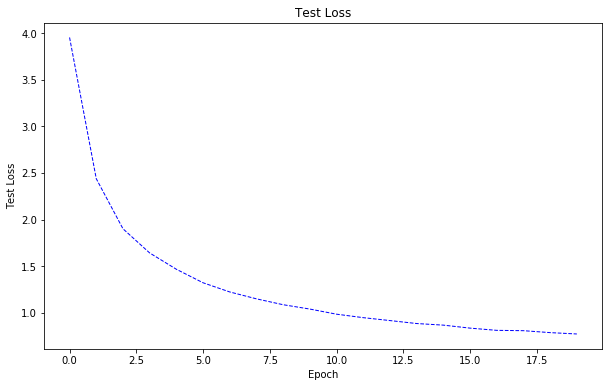

In [20]:
import matplotlib.pyplot as plt
x = []
y = validlosses
for i in range(len(validlosses)):
    x.append(i)
#X轴，Y轴数据   
plt.figure(figsize=(10,6)) #创建绘图对象  
plt.plot(x,y,"b--",linewidth=1)   #在当前绘图对象绘图（X轴，Y轴，蓝色虚线，线宽度）  
plt.xlabel("Epoch") #X轴标签  
plt.ylabel("Test Loss")  #Y轴标签  
plt.title("Test Loss") #图标题  
plt.show()  #显示图  

In [15]:
x

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [16]:
y

[3.954026,
 2.438176,
 1.9007542,
 1.6412312,
 1.4662113,
 1.3211488,
 1.2225612,
 1.1486136,
 1.0855892,
 1.0389531,
 0.98395586,
 0.9466569,
 0.91548145,
 0.8836467,
 0.8664695,
 0.8343302,
 0.81047493,
 0.8068785,
 0.78608614,
 0.77155507]

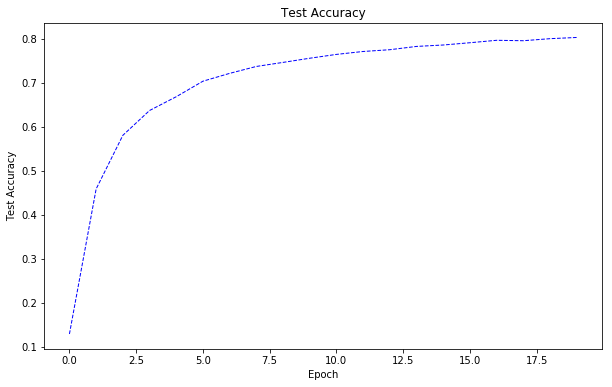

In [17]:
x = []
y = validaccuracies
for i in range(len(validaccuracies)):
    x.append(i)
#X轴，Y轴数据   
plt.figure(figsize=(10,6)) #创建绘图对象  
plt.plot(x,y,"b--",linewidth=1)   #在当前绘图对象绘图（X轴，Y轴，蓝色虚线，线宽度）  
plt.xlabel("Epoch") #X轴标签  
plt.ylabel("Test Accuracy")  #Y轴标签  
plt.title("Test Accuracy") #图标题  
plt.show()  #显示图  

In [18]:
x

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [19]:
y

[0.12900406,
 0.45878956,
 0.58072364,
 0.63720465,
 0.66854304,
 0.7038662,
 0.7216819,
 0.7373897,
 0.74661887,
 0.7561053,
 0.76482034,
 0.771453,
 0.7754893,
 0.7829703,
 0.7861839,
 0.7913512,
 0.7968785,
 0.79592735,
 0.8005805,
 0.80333126]